In [23]:
import numpy as np  
import pandas as pd
from pandas import Series, DataFrame
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.python.ops import confusion_matrix
from tensorflow.python.ops import math_ops

import matplotlib.pyplot as plt

In [24]:
#Data=pd.read_csv('C:/Users/dkoch/Documents/tensorflow/R_Input.csv')
Data=pd.read_csv('R_Input.csv')
Data=Data.fillna(0)

In [25]:

Data['dprio']=Data['dprio']/(1*np.mean(Data['dprio']))

Data['dprio0']=Data['dprio']**0
Data['dprio2']=Data['dprio']**2
Data['dprio3']=Data['dprio']**3
Data=Data.rename(columns={'dprio': 'dprio1'})
Data['pax_total']=Data['pax_total']-Data['group_pax']
Data['pax_total']=Data['pax_total'].apply(lambda x: x if x>0 else 0)

direction=pd.get_dummies(Data['direction'],drop_first=True)
direction.columns=['direction:'+x for x in direction.columns]

whichholiday_left_LUX=pd.get_dummies(Data['whichholiday_left_LUX'],drop_first=True)
whichholiday_left_LUX.columns=['whichholiday_left_LUX:'+x for x in whichholiday_left_LUX.columns]

whichholiday_right_LUX=pd.get_dummies(Data['whichholiday_right_LUX'],drop_first=True)
whichholiday_right_LUX.columns=['whichholiday_right_LUX:'+x for x in whichholiday_right_LUX.columns]

Data=pd.concat([Data,direction,whichholiday_left_LUX,whichholiday_right_LUX],axis=1)

Data.index=Data['calendar_date']+'_'+Data['direction']

Data['weekday']=Data['calendar_date'].apply(lambda x: pd.to_datetime(x).weekday()+1)
Data['yearweek']=Data['calendar_date'].apply(lambda x: pd.to_datetime(x).isocalendar()[1])

In [26]:
dprio=Data[['dprio'+str(i) for i in range(0,4)]].drop_duplicates().transpose()
dprio.columns=range(365,-1,-1)
dprio=dprio[[x for x  in range(0,366)]]

X_data=Data.drop_duplicates(subset=['calendar_date','direction'])[[x for x in Data.columns if 'direction:' in x]\
+['weekday','yearweek']\
+[x for x in Data.columns if 'whichholiday_left_LUX:' in x]\
+[x for x in Data.columns if 'whichholiday_right_LUX:' in x]\
+['holiday_from_left_LUX','holiday_from_right_LUX','holiday_to_left_LUX','holiday_to_right_LUX']]

In [27]:
X_data=X_data[['direction:O','weekday','yearweek',
'holiday_from_left_LUX','holiday_from_right_LUX','holiday_to_left_LUX','holiday_to_right_LUX']]

Data['concat']=Data['calendar_date']+'_'+Data['direction']
y_data=Data[['concat','dprio1','pax_total']].pivot(index='concat',columns='dprio1',values='pax_total')

In [28]:
X_train=X_data.loc[[x for x in X_data.index if '2019' not in x],:]
y_train=y_data.loc[[x for x in y_data.index if '2019' not in x],:]

X_test=X_data.loc[[x for x in X_data.index if '2019' in x],:]

n_input=X_train.shape[1]
n_hidden_1=n_input*2
n_hidden_2=4
n_output=y_train.shape[1]

In [29]:
#dprio.loc['dprio1',:]=(dprio.loc['dprio1',:]-np.mean(dprio.loc['dprio1',:]))/np.std(dprio.loc['dprio1',:])
#dprio.loc['dprio1',:]=-dprio.loc['dprio1',:]

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=1)

X_train=X_train.values
y_train=y_train.values

X_test=X_test.values

# dprio.loc['dprio0',:]=dprio.loc['dprio0',:]/365
# dprio.loc['dprio2',:]=(dprio.loc['dprio1',:]/365)**2
# dprio.loc['dprio3',:]=(dprio.loc['dprio1',:]/365)**3
# dprio.loc['dprio1',:]=dprio.loc['dprio1',:]/365
dprio=dprio.values

In [31]:
# Parameters
learning_rate = 10
training_epochs = 100

X = tf.placeholder("float", [None, n_input])
Z = tf.placeholder("float", [4, 366])
y = tf.placeholder("float", [None, n_output])

keep_prob = tf.placeholder(tf.float32)

# # Dictionary of Weights and Biases
# weights = {
#   'h1': tf.Variable(tf.zeros([n_input, n_hidden_1])),
#   'h2': tf.Variable(tf.zeros([n_hidden_1, n_hidden_2])),
# }

# biases = {
#   'b1': tf.Variable(tf.zeros([n_hidden_1])),
#   'b2': tf.Variable(tf.zeros([n_hidden_2])),
# }

#w1 = tf.placeholder("float", name="w1")
#w2 = tf.placeholder("float", name="w2")

# # Dictionary of Weights and Biases
weights = {
   'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1],mean=0,stddev=1)),
   'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],mean=0,stddev=1)),
   #'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
   #'out': tf.Variable(dprio.reshape(4,366),dtype=tf.float32)  
}

biases = {
   'b1': tf.Variable(tf.random_normal([n_hidden_1],mean=0,stddev=1)),
   'b2': tf.Variable(tf.random_normal([n_hidden_2],mean=0,stddev=1)),
   #'out': tf.Variable(tf.random_normal([n_output]))
}

# Model Forwar§d Propagation step
def forward_propagation(x,z):
    # Hidden layer1
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    #layer_2 = tf.nn.softmax(layer_2)

    # Output fully connected layer
    #out_layer=tf.add(tf.matmul(layer_2, weights['out']),biases['out'])
    out_layer = tf.matmul(layer_2, z)
    out_layer = tf.exp(out_layer)
    return out_layer


# Model Outputs
yhat = forward_propagation(X,Z)

In [32]:
cost = tf.reduce_mean(tf.square(yhat-y))
# our mean squared error cost function
#train = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
#cost=tf.losses.mean_squared_error(y, yhat)
train = tf.train.GradientDescentOptimizer(0.1).minimize(cost)

In [33]:
saver = tf.train.Saver(max_to_keep=1)

# launch a session to run our graph defined above. 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        # get a sample of the dataset and run the optimizer, which calculates a forward pass and then runs the backpropagation algorithm to improve the weights
        train.run(feed_dict = {X: X_train, y: y_train, Z: dprio.reshape(4,366)})
        # every 100 iterations, print out the accuracy
        # accuracy and loss are both functions that take (x, y) pairs as input, and run a forward pass through the network to obtain a prediction, and then compares the prediction with the actual y.
        loss = cost.eval(feed_dict = {X: X_train, y: y_train, Z: dprio.reshape(4,366)})
        pred = sess.run(yhat, feed_dict={X:X_test,Z:dprio.reshape(4,366)})
        print("Epoch: {}, loss: {}".format(i, loss))
        print(pred)
    saver.save(sess, "mymodel")
#     builder.add_meta_graph_and_variables(sess,
#                                        [tf.saved_model.tag_constants.TRAINING],
#                                        signature_def_map=None,
#                                        assets_collection=None)
# builder.save()

Epoch: 0, loss: 2.1791296005249023
[[1.2693341e+00 1.2352711e+00 1.2021011e+00 ... 9.2058035e-06
  8.8422676e-06 8.4926251e-06]
 [1.0830896e+00 1.0549005e+00 1.0274342e+00 ... 2.7545431e-05
  2.6656453e-05 2.5795500e-05]
 [1.4808419e+00 1.4332255e+00 1.3871851e+00 ... 4.5552259e-08
  4.1892335e-08 3.8514344e-08]
 ...
 [2.4883690e-01 2.4320416e-01 2.3765904e-01 ... 2.9805727e-11
  2.6622760e-11 2.3771903e-11]
 [1.7183967e-01 1.6917256e-01 1.6650911e-01 ... 5.2923746e-12
  4.6559354e-12 4.0944223e-12]
 [1.7206119e-01 1.6940722e-01 1.6675632e-01 ... 4.4493389e-12
  3.9082145e-12 3.4315198e-12]]
Epoch: 1, loss: 2.177687168121338
[[1.2545485e+00 1.2209172e+00 1.1881667e+00 ... 9.2265554e-06
  8.8625202e-06 8.5123856e-06]
 [1.0711153e+00 1.0432645e+00 1.0161272e+00 ... 2.7493705e-05
  2.6606573e-05 2.5747402e-05]
 [1.4681396e+00 1.4209659e+00 1.3753526e+00 ... 4.5817153e-08
  4.2137874e-08 3.8741785e-08]
 ...
 [2.4596502e-01 2.4040382e-01 2.3492892e-01 ... 3.0425377e-11
  2.7181370e-11 2.427

Epoch: 17, loss: 2.171307325363159
[[1.2597396e+00 1.2266395e+00 1.1943911e+00 ... 1.3086568e-05
  1.2587163e-05 1.2106191e-05]
 [1.0807542e+00 1.0531868e+00 1.0263139e+00 ... 3.7029509e-05
  3.5870624e-05 3.4747078e-05]
 [1.4772549e+00 1.4304372e+00 1.3851517e+00 ... 6.3136262e-08
  5.8138454e-08 5.3519418e-08]
 ...
 [2.4705410e-01 2.4159361e-01 2.3621461e-01 ... 5.6936168e-11
  5.1056822e-11 4.5770443e-11]
 [1.6707477e-01 1.6459677e-01 1.6211897e-01 ... 5.2240764e-12
  4.5888779e-12 4.0292682e-12]
 [1.6721493e-01 1.6475096e-01 1.6228664e-01 ... 4.3382281e-12
  3.8044585e-12 3.3349760e-12]]
Epoch: 18, loss: 2.171135902404785
[[1.26421642e+00 1.23104334e+00 1.19872284e+00 ... 1.34467000e-05
  1.29348082e-05 1.24417165e-05]
 [1.08486331e+00 1.05722702e+00 1.03028619e+00 ... 3.79351586e-05
  3.67506982e-05 3.56023374e-05]
 [1.48150563e+00 1.43459630e+00 1.38922119e+00 ... 6.46801155e-08
  5.95652061e-08 5.48376278e-08]
 ...
 [2.47933716e-01 2.42462143e-01 2.37072065e-01 ... 5.95511418e-1

Epoch: 33, loss: 2.168654680252075
[[1.3429176e+00 1.3084178e+00 1.2747885e+00 ... 2.0542169e-05
  1.9788775e-05 1.9062085e-05]
 [1.1569990e+00 1.1281207e+00 1.0999563e+00 ... 5.5405915e-05
  5.3738244e-05 5.2119576e-05]
 [1.5539997e+00 1.5054969e+00 1.4585629e+00 ... 9.4365149e-08
  8.7020339e-08 8.0222264e-08]
 ...
 [2.6349902e-01 2.5782207e-01 2.5222623e-01 ... 1.1986855e-10
  1.0793237e-10 9.7156040e-11]
 [1.7414577e-01 1.7170283e-01 1.6925615e-01 ... 4.6172796e-12
  4.0430792e-12 3.5387533e-12]
 [1.7424592e-01 1.7181797e-01 1.6938578e-01 ... 3.8295903e-12
  3.3477988e-12 2.9253314e-12]]
Epoch: 34, loss: 2.1684908866882324
[[1.34858131e+00 1.31398726e+00 1.28026485e+00 ... 2.11485967e-05
  2.03749623e-05 1.96286928e-05]
 [1.16221642e+00 1.13324904e+00 1.10499716e+00 ... 5.68685064e-05
  5.51612320e-05 5.35039871e-05]
 [1.55906212e+00 1.51044989e+00 1.46340871e+00 ... 9.68499876e-08
  8.93199541e-08 8.23500841e-08]
 ...
 [2.64627963e-01 2.58936316e-01 2.53325671e-01 ... 1.25760680e-

Epoch: 49, loss: 2.166001796722412
[[1.4348366e+00 1.3988755e+00 1.3638022e+00 ... 3.3113076e-05
  3.1950549e-05 3.0827305e-05]
 [1.2424212e+00 1.2121409e+00 1.1825942e+00 ... 8.4997024e-05
  8.2546387e-05 8.0164646e-05]
 [1.6332805e+00 1.5831420e+00 1.5346045e+00 ... 1.4457784e-07
  1.3353309e-07 1.2329410e-07]
 ...
 [2.8200984e-01 2.7610284e-01 2.7027595e-01 ... 2.6261268e-10
  2.3747715e-10 2.1468805e-10]
 [1.8210070e-01 1.7970081e-01 1.7729285e-01 ... 4.0822888e-12
  3.5628705e-12 3.1081361e-12]
 [1.8217109e-01 1.7978647e-01 1.7739335e-01 ... 3.4083695e-12
  2.9699763e-12 2.5867663e-12]]
Epoch: 50, loss: 2.1658332347869873
[[1.4405770e+00 1.4045305e+00 1.3693727e+00 ... 3.4147324e-05
  3.2951975e-05 3.1796921e-05]
 [1.2478173e+00 1.2174530e+00 1.1878234e+00 ... 8.7375563e-05
  8.4863546e-05 8.2422019e-05]
 [1.6380100e+00 1.5877807e+00 1.5391542e+00 ... 1.4860382e-07
  1.3726579e-07 1.2675375e-07]
 ...
 [2.8318235e-01 2.7726179e-01 2.7142122e-01 ... 2.7614327e-10
  2.4978128e-10 2.2

Epoch: 66, loss: 2.16306209564209
[[1.5304368e+00 1.4931748e+00 1.4568102e+00 ... 5.6878001e-05
  5.4985649e-05 5.3153879e-05]
 [1.3334451e+00 1.3018422e+00 1.2709870e+00 ... 1.3819305e-04
  1.3441629e-04 1.3074001e-04]
 [1.7079653e+00 1.6565311e+00 1.6067157e+00 ... 2.3403000e-07
  2.1655200e-07 2.0031854e-07]
 ...
 [3.0193630e-01 2.9581818e-01 2.8977799e-01 ... 6.3245520e-10
  5.7468186e-10 5.2205157e-10]
 [1.9022588e-01 1.8789613e-01 1.8555364e-01 ... 3.7630407e-12
  3.2738794e-12 2.8469412e-12]
 [1.9026962e-01 1.8795466e-01 1.8562651e-01 ... 3.1862345e-12
  2.7680002e-12 2.4034956e-12]]
Epoch: 67, loss: 2.1628830432891846
[[1.5358945e+00 1.4985669e+00 1.4621369e+00 ... 5.8795089e-05
  5.6845682e-05 5.4958600e-05]
 [1.3387221e+00 1.3070493e+00 1.2761248e+00 ... 1.4237812e-04
  1.3850046e-04 1.3472572e-04]
 [1.7119387e+00 1.6604459e+00 1.6105723e+00 ... 2.4100913e-07
  2.2303587e-07 2.0634037e-07]
 ...
 [3.0310568e-01 2.9697651e-01 2.9092520e-01 ... 6.6728756e-10
  6.0651167e-10 5.51

Epoch: 82, loss: 2.1600968837738037
[[1.6150355e+00 1.5768833e+00 1.5396273e+00 ... 9.8715886e-05
  9.5626267e-05 9.2629722e-05]
 [1.4164203e+00 1.3838166e+00 1.3519661e+00 ... 2.2722557e-04
  2.2138772e-04 2.1569594e-04]
 [1.7653387e+00 1.7132157e+00 1.6627094e+00 ... 3.8065474e-07
  3.5292177e-07 3.2711165e-07]
 ...
 [3.2062832e-01 3.1435326e-01 3.0815303e-01 ... 1.5412085e-09
  1.4073606e-09 1.2848329e-09]
 [1.9729674e-01 1.9505599e-01 1.9279811e-01 ... 3.8266040e-12
  3.3216574e-12 2.8819180e-12]
 [1.9731914e-01 1.9509214e-01 1.9284755e-01 ... 3.2973862e-12
  2.8585420e-12 2.4768599e-12]]
Epoch: 83, loss: 2.1599032878875732
[[1.6201229e+00 1.5819267e+00 1.5446262e+00 ... 1.0234057e-04
  9.9151308e-05 9.6057309e-05]
 [1.4214959e+00 1.3888383e+00 1.3569340e+00 ... 2.3475595e-04
  2.2875058e-04 2.2289502e-04]
 [1.7684762e+00 1.7163281e+00 1.6657958e+00 ... 3.9289088e-07
  3.6431436e-07 3.3771551e-07]
 ...
 [3.2179737e-01 3.1551391e-01 3.0930507e-01 ... 1.6336789e-09
  1.4922868e-09 1.

Epoch: 99, loss: 2.1566267013549805
[[1.6981525e+00 1.6594455e+00 1.6216216e+00 ... 1.8769983e-04
  1.8228093e-04 1.7701239e-04]
 [1.5008298e+00 1.4674584e+00 1.4348371e+00 ... 4.0686611e-04
  3.9724685e-04 3.8784987e-04]
 [1.8114064e+00 1.7591392e+00 1.7084661e+00 ... 6.6670407e-07
  6.1960969e-07 5.7567229e-07]
 ...
 [3.4061989e-01 3.3422387e-01 3.2789803e-01 ... 4.3665427e-09
  4.0108645e-09 3.6833923e-09]
 [2.0418657e-01 2.0206174e-01 1.9991527e-01 ... 4.4868362e-12
  3.8897045e-12 3.3703255e-12]
 [2.0419031e-01 2.0207770e-01 1.9994318e-01 ... 3.9448592e-12
  3.4160103e-12 2.9565304e-12]]
Epoch: 100, loss: 2.156409502029419
[[1.7028190e+00 1.6640923e+00 1.6262474e+00 ... 1.9534043e-04
  1.8973116e-04 1.8427681e-04]
 [1.5056715e+00 1.4722648e+00 1.4396079e+00 ... 4.2189853e-04
  4.1197965e-04 4.0228863e-04]
 [1.8136384e+00 1.7613814e+00 1.7107164e+00 ... 6.9015744e-07
  6.4150311e-07 5.9610358e-07]
 ...
 [3.4180763e-01 3.3540595e-01 3.2907417e-01 ... 4.6596380e-09
  4.2816777e-09 3.

[[1.7741860e+00 1.7353417e+00 1.6973557e+00 ... 3.8362935e-04
  3.7364609e-04 3.6391261e-04]
 [1.5813448e+00 1.5475303e+00 1.5144532e+00 ... 7.8079599e-04
  7.6424552e-04 7.4803911e-04]
 [1.8423566e+00 1.7905314e+00 1.7402585e+00 ... 1.2337955e-06
  1.1497947e-06 1.0712084e-06]
 ...
 [3.6113852e-01 3.5466850e-01 3.4826279e-01 ... 1.4093947e-08
  1.3033926e-08 1.2051468e-08]
 [2.1048540e-01 2.0849632e-01 2.0648149e-01 ... 6.2829924e-12
  5.4471722e-12 4.7200997e-12]
 [2.1047449e-01 2.0849615e-01 2.0649174e-01 ... 5.6271095e-12
  4.8738717e-12 4.2192395e-12]]
Epoch: 117, loss: 2.152437210083008
[[1.7784461e+00 1.7396067e+00 1.7016243e+00 ... 4.0114543e-04
  3.9077961e-04 3.8067112e-04]
 [1.5859680e+00 1.5521379e+00 1.5190442e+00 ... 8.1334391e-04
  7.9623191e-04 7.7947316e-04]
 [1.8437266e+00 1.7919450e+00 1.7417123e+00 ... 1.2818082e-06
  1.1947470e-06 1.1132805e-06]
 ...
 [3.6237317e-01 3.5590029e-01 3.4949124e-01 ... 1.5173729e-08
  1.4038572e-08 1.2985984e-08]
 [2.1083896e-01 2.08858

  8.17143575e-12 7.08510074e-12]]
Epoch: 133, loss: 2.1480906009674072
[[1.84359217e+00 1.80503547e+00 1.76730239e+00 ... 8.57373932e-04
  8.37944273e-04 8.18939356e-04]
 [1.65846848e+00 1.62454963e+00 1.59134674e+00 ... 1.63317285e-03
  1.60334341e-03 1.57405587e-03]
 [1.85929835e+00 1.80845821e+00 1.75911117e+00 ... 2.44306443e-06
  2.28395697e-06 2.13462317e-06]
 ...
 [3.82766873e-01 3.76269788e-01 3.69829774e-01 ... 5.40329808e-08
  5.03684099e-08 4.69454733e-08]
 [2.16268390e-01 2.14434609e-01 2.12571308e-01 ... 1.07744525e-11
  9.35609749e-12 8.12024233e-12]
 [2.16245234e-01 2.14420930e-01 2.12566823e-01 ... 9.78881212e-12
  8.49314109e-12 7.36510505e-12]]
Epoch: 134, loss: 2.147794008255005
[[1.8474835e+00 1.8089572e+00 1.7712519e+00 ... 9.0179773e-04
  8.8155642e-04 8.6175295e-04]
 [1.6629158e+00 1.6290017e+00 1.5958022e+00 ... 1.7109296e-03
  1.6800035e-03 1.6496357e-03]
 [1.8598911e+00 1.8091246e+00 1.7598473e+00 ... 2.5493528e-06
  2.3838049e-06 2.2283889e-06]
 ...
 [3.84090

  1.8525976e-11 1.6119640e-11]]
Epoch: 151, loss: 2.1421947479248047
[[1.9105340e+00 1.8727599e+00 1.8357617e+00 ... 2.2639637e-03
  2.2222581e-03 2.1813030e-03]
 [1.7371535e+00 1.7035179e+00 1.6705661e+00 ... 4.0057641e-03
  3.9476417e-03 3.8903900e-03]
 [1.8635675e+00 1.8143073e+00 1.7664621e+00 ... 5.5004139e-06
  5.1622201e-06 4.8435272e-06]
 ...
 [4.0780622e-01 4.0133294e-01 3.9490765e-01 ... 2.8780033e-07
  2.7102220e-07 2.5519566e-07]
 [2.2191250e-01 2.2026615e-01 2.1858670e-01 ... 2.4495789e-11
  2.1346584e-11 1.8592702e-11]
 [2.2187638e-01 2.2023869e-01 2.1856773e-01 ... 2.2445011e-11
  1.9544651e-11 1.7010348e-11]]
Epoch: 152, loss: 2.141827344894409
[[1.9140548e+00 1.8763394e+00 1.8393968e+00 ... 2.3990604e-03
  2.3554871e-03 2.3126865e-03]
 [1.7414342e+00 1.7078271e+00 1.6749018e+00 ... 4.2269956e-03
  4.1666366e-03 4.1071689e-03]
 [1.8634149e+00 1.8142580e+00 1.7665110e+00 ... 5.7704947e-06
  5.4169559e-06 5.0837193e-06]
 ...
 [4.0928543e-01 4.0281516e-01 3.9639232e-01 ...

  1.0278354e-10 9.0230254e-11]]
Epoch: 177, loss: 2.130552053451538
[[1.9927380e+00 1.9570975e+00 1.9221449e+00 ... 1.1986446e-02
  1.1856763e-02 1.1728644e-02]
 [1.8426586e+00 1.8103119e+00 1.7785853e+00 ... 1.8973226e-02
  1.8827999e-02 1.8684374e-02]
 [1.8454915e+00 1.7994548e+00 1.7546936e+00 ... 2.1187801e-05
  2.0016847e-05 1.8905916e-05]
 ...
 [4.5033413e-01 4.4400886e-01 4.3771568e-01 ... 6.1757059e-06
  5.9288641e-06 5.6917961e-06]
 [2.2896767e-01 2.2764379e-01 2.2628289e-01 ... 1.3903165e-10
  1.2226095e-10 1.0746156e-10]
 [2.2890358e-01 2.2758865e-01 2.2623654e-01 ... 1.2692557e-10
  1.1152792e-10 9.7950925e-11]]
Epoch: 178, loss: 2.12998366355896
[[1.9953839e+00 1.9598546e+00 1.9250089e+00 ... 1.2894738e-02
  1.2759687e-02 1.2626225e-02]
 [1.8463453e+00 1.8140749e+00 1.7824216e+00 ... 2.0322409e-02
  2.0173274e-02 2.0025784e-02]
 [1.8441559e+00 1.7982671e+00 1.7536479e+00 ... 2.2445100e-05
  2.1210748e-05 2.0039346e-05]
 ...
 [4.5216647e-01 4.4585043e-01 4.3956572e-01 ... 7

Epoch: 191, loss: 2.120957612991333
[[2.0227587e+00 1.9889591e+00 1.9557891e+00 ... 3.8486455e-02
  3.8293477e-02 3.8102672e-02]
 [1.8887918e+00 1.8577740e+00 1.8273318e+00 ... 5.7216279e-02
  5.7086121e-02 5.6958683e-02]
 [1.8206793e+00 1.7769309e+00 1.7343695e+00 ... 5.2858511e-05
  5.0175273e-05 4.7617119e-05]
 ...
 [4.7727963e-01 4.7112304e-01 4.6498841e-01 ... 5.7182737e-05
  5.5702767e-05 5.4263845e-05]
 [2.3135932e-01 2.3024628e-01 2.2909497e-01 ... 5.3903637e-10
  4.7777843e-10 4.2329146e-10]
 [2.3126979e-01 2.3016661e-01 2.2902502e-01 ... 4.8618715e-10
  4.3055559e-10 3.8111658e-10]]
Epoch: 192, loss: 2.1200945377349854
[[2.0239568e+00 1.9903193e+00 1.9573071e+00 ... 4.2515837e-02
  4.2325120e-02 4.2136658e-02]
 [1.8913295e+00 1.8604344e+00 1.8301113e+00 ... 6.2906437e-02
  6.2794529e-02 6.2685557e-02]
 [1.8181902e+00 1.7746290e+00 1.7322478e+00 ... 5.7136785e-05
  5.4259497e-05 5.1515264e-05]
 ...
 [4.7925279e-01 4.7311297e-01 4.6699426e-01 ... 6.8932408e-05
  6.7232286e-05 6

Epoch: 205, loss: 2.1062066555023193
[[2.0093439e+00 1.9784490e+00 1.9481121e+00 ... 1.9459781e-01
  1.9538948e-01 1.9619717e-01]
 [1.8982378e+00 1.8695062e+00 1.8412925e+00 ... 2.6912510e-01
  2.7082351e-01 2.7255273e-01]
 [1.7670770e+00 1.7264469e+00 1.6868955e+00 ... 1.8838432e-04
  1.8013359e-04 1.7220888e-04]
 ...
 [5.0151843e-01 4.9570477e-01 4.8990169e-01 ... 1.1915485e-03
  1.1850330e-03 1.1787300e-03]
 [2.2890617e-01 2.2804829e-01 2.2715257e-01 ... 3.6288605e-09
  3.2554652e-09 2.9193381e-09]
 [2.2878499e-01 2.2793838e-01 2.2705381e-01 ... 3.1999119e-09
  2.8675948e-09 2.5687505e-09]]
Epoch: 206, loss: 2.105004072189331
[[2.0045350e+00 1.9739096e+00 1.9438367e+00 ... 2.1923614e-01
  2.2027814e-01 2.2134012e-01]
 [1.8953887e+00 1.8668785e+00 1.8388814e+00 ... 3.0158019e-01
  3.0367866e-01 3.0581486e-01]
 [1.7610193e+00 1.7206621e+00 1.6813750e+00 ... 2.0710561e-04
  1.9814505e-04 1.8953368e-04]
 ...
 [5.0260204e-01 4.9682400e-01 4.9105570e-01 ... 1.5097676e-03
  1.5039891e-03 1

Epoch: 222, loss: 2.0898749828338623
[[1.8545618e+00 1.8286748e+00 1.8032404e+00 ... 4.1308933e-01
  4.1583100e-01 4.1861743e-01]
 [1.7698178e+00 1.7454610e+00 1.7215297e+00 ... 5.3951955e-01
  5.4409635e-01 5.4875034e-01]
 [1.6317025e+00 1.5960147e+00 1.5612519e+00 ... 3.8184901e-04
  3.6621897e-04 3.5115803e-04]
 ...
 [4.9871677e-01 4.9361500e-01 4.8851132e-01 ... 1.7211432e-02
  1.7436858e-02 1.7669473e-02]
 [2.1060902e-01 2.1007612e-01 2.0950821e-01 ... 8.2199074e-09
  7.4013502e-09 6.6616885e-09]
 [2.1041909e-01 2.0989615e-01 2.0933805e-01 ... 7.2213120e-09
  6.4951688e-09 5.8397376e-09]]
Epoch: 223, loss: 2.0889291763305664
[[1.8449284e+00 1.8193135e+00 1.7941457e+00 ... 4.1525352e-01
  4.1795576e-01 4.2070156e-01]
 [1.7611004e+00 1.7369919e+00 1.7133042e+00 ... 5.4149324e-01
  5.4601121e-01 5.5060500e-01]
 [1.6242132e+00 1.5887864e+00 1.5542765e+00 ... 3.8709899e-04
  3.7124433e-04 3.5596685e-04]
 ...
 [4.9796289e-01 4.9290356e-01 4.8784173e-01 ... 1.9072501e-02
  1.9335689e-02 

Epoch: 239, loss: 2.073364019393921
[[1.7519056e+00 1.7296834e+00 1.7078395e+00 ... 4.6870968e-01
  4.7080219e-01 4.7292221e-01]
 [1.6768036e+00 1.6558197e+00 1.6351938e+00 ... 5.9969223e-01
  6.0341442e-01 6.0718745e-01]
 [1.5469514e+00 1.5146899e+00 1.4832458e+00 ... 4.9028813e-04
  4.6998585e-04 4.5042718e-04]
 ...
 [4.8185316e-01 4.7748879e-01 4.7311342e-01 ... 4.4396784e-02
  4.5205906e-02 4.6041559e-02]
 [2.7347273e-01 2.7355912e-01 2.7360824e-01 ... 1.0753096e-08
  9.5620871e-09 8.4986480e-09]
 [2.2095209e-01 2.2077024e-01 2.2055383e-01 ... 9.6696731e-09
  8.6591143e-09 7.7507218e-09]]
Epoch: 240, loss: 2.0725345611572266
[[1.7499369e+00 1.7278721e+00 1.7061824e+00 ... 4.7280589e-01
  4.7485197e-01 4.7692472e-01]
 [1.6751047e+00 1.6542666e+00 1.6337832e+00 ... 6.0433817e-01
  6.0800421e-01 6.1171949e-01]
 [1.5445956e+00 1.5124761e+00 1.4811692e+00 ... 4.9778185e-04
  4.7715084e-04 4.5727630e-04]
 ...
 [4.8099774e-01 4.7667420e-01 4.7233921e-01 ... 4.5088202e-02
  4.5907669e-02 4

Epoch: 256, loss: 2.063164472579956
[[1.7442292e+00 1.7242930e+00 1.7046903e+00 ... 5.3485274e-01
  5.3592741e-01 5.3701091e-01]
 [1.6724218e+00 1.6535528e+00 1.6350006e+00 ... 6.7394257e-01
  6.7643142e-01 6.7894250e-01]
 [1.5234044e+00 1.4931575e+00 1.4636607e+00 ... 6.3017529e-04
  6.0364936e-04 5.7810766e-04]
 ...
 [4.7578409e-01 4.7201473e-01 4.6822733e-01 ... 5.9416857e-02
  6.0463633e-02 6.1543822e-02]
 [3.5709131e-01 3.5813153e-01 3.5913932e-01 ... 2.2189223e-08
  1.9568366e-08 1.7246508e-08]
 [3.3935946e-01 3.4026864e-01 3.4114459e-01 ... 1.8852845e-08
  1.6635672e-08 1.4670461e-08]]
Epoch: 257, loss: 2.0626819133758545
[[1.7444665e+00 1.7246515e+00 1.7051675e+00 ... 5.3888458e-01
  5.3989172e-01 5.4090655e-01]
 [1.6728073e+00 1.6540505e+00 1.6356084e+00 ... 6.7845953e-01
  6.8086779e-01 6.8329668e-01]
 [1.5224245e+00 1.4922836e+00 1.4628893e+00 ... 6.3962128e-04
  6.1267556e-04 5.8672985e-04]
 ...
 [4.7574890e-01 4.7201017e-01 4.6825305e-01 ... 6.0705103e-02
  6.1774947e-02 6

Epoch: 274, loss: 2.055175542831421
[[1.7412397e+00 1.7234552e+00 1.7059672e+00 ... 6.1783040e-01
  6.1768609e-01 6.1753434e-01]
 [1.6720636e+00 1.6551923e+00 1.6386038e+00 ... 7.6756960e-01
  7.6865083e-01 7.6972967e-01]
 [1.4995115e+00 1.4712048e+00 1.4435865e+00 ... 8.3202258e-04
  7.9667359e-04 7.6264160e-04]
 ...
 [4.7493002e-01 4.7168306e-01 4.6841216e-01 ... 9.3020432e-02
  9.4738044e-02 9.6510150e-02]
 [3.4602895e-01 3.4728044e-01 3.4850526e-01 ... 6.9405665e-08
  6.1615395e-08 5.4667403e-08]
 [3.4249365e-01 3.4373978e-01 3.4495896e-01 ... 5.5497903e-08
  4.9195243e-08 4.3582411e-08]]
Epoch: 275, loss: 2.0547711849212646
[[1.7404908e+00 1.7228246e+00 1.7054532e+00 ... 6.2313700e-01
  6.2292534e-01 6.2270528e-01]
 [1.6714633e+00 1.6547019e+00 1.6382220e+00 ... 7.7359366e-01
  7.7460009e-01 7.7560270e-01]
 [1.4977095e+00 1.4695137e+00 1.4420030e+00 ... 8.4546965e-04
  8.0954353e-04 7.7495625e-04]
 ...
 [4.7477618e-01 4.7155693e-01 4.6831354e-01 ... 9.5496543e-02
  9.7266763e-02 9

Epoch: 289, loss: 2.049569845199585
[[1.7254754e+00 1.7094195e+00 1.6936338e+00 ... 7.0160699e-01
  7.0042539e-01 6.9922543e-01]
 [1.6584475e+00 1.6431863e+00 1.6281836e+00 ... 8.6278009e-01
  8.6273330e-01 8.6266780e-01]
 [1.4687960e+00 1.4421477e+00 1.4161394e+00 ... 1.0604787e-03
  1.0154638e-03 9.7211625e-04]
 ...
 [4.7033647e-01 4.6749613e-01 4.6462852e-01 ... 1.2926751e-01
  1.3174424e-01 1.3429990e-01]
 [3.3302587e-01 3.3435532e-01 3.3566228e-01 ... 2.0824271e-07
  1.8625110e-07 1.6648950e-07]
 [3.3185449e-01 3.3320302e-01 3.3452892e-01 ... 1.6222043e-07
  1.4480193e-07 1.2918079e-07]]
Epoch: 290, loss: 2.049232244491577
[[1.7242169e+00 1.7082713e+00 1.6925943e+00 ... 7.0725560e-01
  7.0600134e-01 7.0472777e-01]
 [1.6573205e+00 1.6421621e+00 1.6272606e+00 ... 8.6919403e-01
  8.6906934e-01 8.6892462e-01]
 [1.4665750e+00 1.4400351e+00 1.4141318e+00 ... 1.0776849e-03
  1.0319494e-03 9.8790950e-04]
 ...
 [4.6985176e-01 4.6703774e-01 4.6419626e-01 ... 1.3117436e-01
  1.3368714e-01 1.

  4.7397157e-07 4.2634440e-07]]
Epoch: 306, loss: 2.0444233417510986
[[1.7038066e+00 1.6895113e+00 1.6754621e+00 ... 7.9362571e-01
  7.9113144e-01 7.8860843e-01]
 [1.6387360e+00 1.6251171e+00 1.6117342e+00 ... 9.6700191e-01
  9.6555257e-01 9.6406776e-01]
 [1.4306898e+00 1.4057975e+00 1.3814957e+00 ... 1.3845701e-03
  1.3261428e-03 1.2698565e-03]
 ...
 [4.6046269e-01 4.5804641e-01 4.5560056e-01 ... 1.4871924e-01
  1.5144664e-01 1.5425837e-01]
 [3.1957421e-01 3.2094857e-01 3.2230443e-01 ... 7.2383500e-07
  6.5310400e-07 5.8898121e-07]
 [3.1911510e-01 3.2051423e-01 3.2189491e-01 ... 5.6517501e-07
  5.0890571e-07 4.5799749e-07]]
Epoch: 307, loss: 2.0441551208496094
[[1.7025597e+00 1.6883605e+00 1.6744058e+00 ... 7.9875934e-01
  7.9618353e-01 7.9357868e-01]
 [1.6375867e+00 1.6240573e+00 1.6107627e+00 ... 9.7280854e-01
  9.7127277e-01 9.6970081e-01]
 [1.4284647e+00 1.4036697e+00 1.3794624e+00 ... 1.4056840e-03
  1.3463914e-03 1.2892702e-03]
 ...
 [4.5984152e-01 4.5744830e-01 4.5502549e-01 ..

  1.4289189e-06 1.2953109e-06]]
Epoch: 323, loss: 2.040266990661621
[[1.6841779e+00 1.6713977e+00 1.6588451e+00 ... 8.7526459e-01
  8.7134409e-01 8.6738735e-01]
 [1.6205982e+00 1.6083925e+00 1.5964053e+00 ... 1.0592376e+00
  1.0562726e+00 1.0532597e+00]
 [1.3941145e+00 1.3707733e+00 1.3479805e+00 ... 1.7705292e-03
  1.6964108e-03 1.6249714e-03]
 ...
 [4.5060056e-01 4.4854587e-01 4.4646028e-01 ... 1.5463832e-01
  1.5725988e-01 1.5995926e-01]
 [3.0914253e-01 3.1055886e-01 3.1195992e-01 ... 2.0754376e-06
  1.8864986e-06 1.7139342e-06]
 [3.0889004e-01 3.1032929e-01 3.1175330e-01 ... 1.6670598e-06
  1.5125229e-06 1.3716378e-06]]
Epoch: 324, loss: 2.040043354034424
[[1.6831524e+00 1.6704540e+00 1.6579821e+00 ... 8.7958705e-01
  8.7558025e-01 8.7153703e-01]
 [1.6196539e+00 1.6075243e+00 1.5956123e+00 ... 1.0641088e+00
  1.0610522e+00 1.0579464e+00]
 [1.3920715e+00 1.3688147e+00 1.3461039e+00 ... 1.7947761e-03
  1.7196788e-03 1.6472932e-03]
 ...
 [4.5008659e-01 4.4805115e-01 4.4598478e-01 ... 

Epoch: 340, loss: 2.0365915298461914
[[1.6683998e+00 1.6569098e+00 1.6456332e+00 ... 9.3872350e-01
  9.3331927e-01 9.2787641e-01]
 [1.6062113e+00 1.5952067e+00 1.5844073e+00 ... 1.1301187e+00
  1.1255598e+00 1.1209444e+00]
 [1.3610762e+00 1.3390749e+00 1.3175865e+00 ... 2.1974815e-03
  2.1061818e-03 2.0181432e-03]
 ...
 [4.4292319e-01 4.4117033e-01 4.3938583e-01 ... 1.5765996e-01
  1.6012150e-01 1.6265312e-01]
 [3.0174327e-01 3.0321696e-01 3.0467811e-01 ... 4.5203979e-06
  4.1303629e-06 3.7722507e-06]
 [3.0156353e-01 3.0305636e-01 3.0453667e-01 ... 3.7659458e-06
  3.4357347e-06 3.1330133e-06]]
Epoch: 341, loss: 2.036383628845215
[[1.6675419e+00 1.6561219e+00 1.6449144e+00 ... 9.4170135e-01
  9.3621004e-01 9.3067974e-01]
 [1.6054413e+00 1.5945019e+00 1.5837668e+00 ... 1.1333961e+00
  1.1287425e+00 1.1240319e+00]
 [1.3592310e+00 1.3373026e+00 1.3158853e+00 ... 2.2232565e-03
  2.1309236e-03 2.0418847e-03]
 ...
 [4.4253176e-01 4.4079512e-01 4.3902677e-01 ... 1.5780485e-01
  1.6025662e-01 1

[[1.6557932e+00 1.6453485e+00 1.6351069e+00 ... 9.7496974e-01
  9.6819568e-01 9.6138453e-01]
 [1.5950918e+00 1.5850589e+00 1.5752213e+00 ... 1.1689970e+00
  1.1629303e+00 1.1568047e+00]
 [1.3332205e+00 1.3123107e+00 1.2918861e+00 ... 2.6113552e-03
  2.5034486e-03 2.3993577e-03]
 ...
 [4.3746972e-01 4.3595803e-01 4.3441415e-01 ... 1.5955070e-01
  1.6185707e-01 1.6422716e-01]
 [2.9670352e-01 2.9824170e-01 2.9976928e-01 ... 7.5710795e-06
  6.9400839e-06 6.3588323e-06]
 [2.9655644e-01 2.9811034e-01 2.9965374e-01 ... 6.5087338e-06
  5.9586914e-06 5.4526563e-06]]
Epoch: 357, loss: 2.0334320068359375
[[1.6551344e+00 1.6447499e+00 1.6345677e+00 ... 9.7656626e-01
  9.6970910e-01 9.6281523e-01]
 [1.5945283e+00 1.5845512e+00 1.5747688e+00 ... 1.1706474e+00
  1.1644881e+00 1.1582701e+00]
 [1.3316288e+00 1.3107817e+00 1.2904181e+00 ... 2.6374254e-03
  2.5284728e-03 2.4233719e-03]
 ...
 [4.3719655e-01 4.3569872e-01 4.3416867e-01 ... 1.5965289e-01
  1.6194969e-01 1.6430980e-01]
 [2.9645148e-01 2.9799

[[1.6475875e+00 1.6380374e+00 1.6286821e+00 ... 9.9549282e-01
  9.8743951e-01 9.7935402e-01]
 [1.5884113e+00 1.5792099e+00 1.5701959e+00 ... 1.1897123e+00
  1.1822124e+00 1.1746556e+00]
 [1.3100997e+00 1.2901162e+00 1.2705941e+00 ... 3.0366774e-03
  2.9117453e-03 2.7911970e-03]
 ...
 [4.3411294e-01 4.3280792e-01 4.3147036e-01 ... 1.6125104e-01
  1.6341145e-01 1.6562983e-01]
 [2.9360926e-01 2.9521942e-01 2.9682085e-01 ... 1.1009302e-05
  1.0113172e-05 9.2859018e-06]
 [2.9348227e-01 2.9510543e-01 2.9671985e-01 ... 9.7141647e-06
  8.9140576e-06 8.1762082e-06]]
Epoch: 373, loss: 2.0311245918273926
[[1.6472266e+00 1.6377281e+00 1.6284238e+00 ... 9.9649626e-01
  9.8836619e-01 9.8020524e-01]
 [1.5881462e+00 1.5789926e+00 1.5700260e+00 ... 1.1906962e+00
  1.1831108e+00 1.1754686e+00]
 [1.3088084e+00 1.2888777e+00 1.2694074e+00 ... 3.0639477e-03
  2.9379260e-03 2.8163260e-03]
 ...
 [4.3396896e-01 4.3267596e-01 4.3135032e-01 ... 1.6136424e-01
  1.6351610e-01 1.6572551e-01]
 [2.9347768e-01 2.9509

Epoch: 387, loss: 2.0293543338775635
[[1.6435726e+00 1.6347491e+00 1.6261141e+00 ... 1.0083114e+00
  9.9916208e-01 9.8998868e-01]
 [1.5858736e+00 1.5773479e+00 1.5690041e+00 ... 1.2019145e+00
  1.1931762e+00 1.1843858e+00]
 [1.2922890e+00 1.2730483e+00 1.2542505e+00 ... 3.4570084e-03
  3.3153652e-03 3.1786584e-03]
 ...
 [4.3260166e-01 4.3146643e-01 4.3029839e-01 ... 1.6307619e-01
  1.6511384e-01 1.6720477e-01]
 [2.9224879e-01 2.9393312e-01 2.9561028e-01 ... 1.4236176e-05
  1.3093910e-05 1.2038058e-05]
 [2.9213431e-01 2.9382977e-01 2.9551798e-01 ... 1.2795566e-05
  1.1758311e-05 1.0800370e-05]]
Epoch: 388, loss: 2.0292322635650635
[[1.64339817e+00 1.63461971e+00 1.62602973e+00 ... 1.00904191e+00
  9.99822676e-01 9.90580857e-01]
 [1.58580065e+00 1.57731712e+00 1.56901503e+00 ... 1.20258522e+00
  1.19376779e+00 1.18489921e+00]
 [1.29121053e+00 1.27201557e+00 1.25326264e+00 ... 3.48601304e-03
  3.34322313e-03 3.20540415e-03]
 ...
 [4.32544619e-01 4.31420058e-01 4.30262655e-01 ... 1.6321031

Epoch: 403, loss: 2.0273985862731934
[[1.64189076e+00 1.63374949e+00 1.62579179e+00 ... 1.01970470e+00
  1.00949240e+00 9.99266446e-01]
 [1.58590794e+00 1.57801807e+00 1.57030535e+00 ... 1.21226120e+00
  1.20231414e+00 1.19232273e+00]
 [1.27644086e+00 1.25788891e+00 1.23976314e+00 ... 3.94100603e-03
  3.78033426e-03 3.62521363e-03]
 ...
 [4.32218611e-01 4.31245714e-01 4.30239767e-01 ... 1.65572628e-01
  1.67497545e-01 1.69471800e-01]
 [2.91949838e-01 2.93718308e-01 2.95480996e-01 ... 1.74548913e-05
  1.60674608e-05 1.47838819e-05]
 [2.91844100e-01 2.93622255e-01 2.95394659e-01 ... 1.59034880e-05
  1.46278735e-05 1.34486618e-05]]
Epoch: 404, loss: 2.027273654937744
[[1.64185369e+00 1.63375235e+00 1.62583447e+00 ... 1.02045023e+00
  1.01017475e+00 9.99885559e-01]
 [1.58598471e+00 1.57813227e+00 1.57045650e+00 ... 1.21294153e+00
  1.20292282e+00 1.19285965e+00]
 [1.27554107e+00 1.25702918e+00 1.23894238e+00 ... 3.97285353e-03
  3.81093775e-03 3.65461363e-03]
 ...
 [4.32227552e-01 4.312642

Epoch: 418, loss: 2.0255417823791504
[[1.6417994e+00 1.6342303e+00 1.6268408e+00 ... 1.0314616e+00
  1.0203346e+00 1.0092026e+00]
 [1.5876136e+00 1.5802581e+00 1.5730761e+00 ... 1.2228824e+00
  1.2118946e+00 1.2008694e+00]
 [1.2637959e+00 1.2458147e+00 1.2282457e+00 ... 4.4397521e-03
  4.2597400e-03 4.0858928e-03]
 ...
 [4.3262181e-01 4.3178791e-01 4.3092078e-01 ... 1.6895419e-01
  1.7079806e-01 1.7268829e-01]
 [2.9235351e-01 2.9420179e-01 2.9604563e-01 ... 2.0512649e-05
  1.8892795e-05 1.7393309e-05]
 [2.9225361e-01 2.9411072e-01 2.9596338e-01 ... 1.8860032e-05
  1.7358361e-05 1.5969264e-05]]
Epoch: 419, loss: 2.0254266262054443
[[1.6418240e+00 1.6342909e+00 1.6269374e+00 ... 1.0322204e+00
  1.0210350e+00 1.0098457e+00]
 [1.5877649e+00 1.5804431e+00 1.5732948e+00 ... 1.2235440e+00
  1.2124894e+00 1.2013987e+00]
 [1.2630123e+00 1.2450670e+00 1.2275331e+00 ... 4.4744071e-03
  4.2930576e-03 4.1179191e-03]
 ...
 [4.3266681e-01 4.3184176e-01 4.3098348e-01 ... 1.6921298e-01
  1.7105226e-01 

Epoch: 434, loss: 2.023858070373535
[[1.6430728e+00 1.6360521e+00 1.6292081e+00 ... 1.0422815e+00
  1.0302632e+00 1.0182505e+00]
 [1.5909516e+00 1.5841103e+00 1.5774392e+00 ... 1.2317559e+00
  1.2197479e+00 1.2077117e+00]
 [1.2522714e+00 1.2348322e+00 1.2177923e+00 ... 5.0098011e-03
  4.8079230e-03 4.6128910e-03]
 ...
 [4.3369877e-01 4.3300101e-01 4.3226999e-01 ... 1.7352882e-01
  1.7530808e-01 1.7713130e-01]
 [2.9334831e-01 2.9527935e-01 2.9720730e-01 ... 2.4232284e-05
  2.2332322e-05 2.0572381e-05]
 [2.9325521e-01 2.9519430e-01 2.9713032e-01 ... 2.2468015e-05
  2.0693138e-05 1.9050127e-05]]
Epoch: 435, loss: 2.0237605571746826
[[1.6432196e+00 1.6362314e+00 1.6294193e+00 ... 1.0428669e+00
  1.0307956e+00 1.0187308e+00]
 [1.5912290e+00 1.5844179e+00 1.5777773e+00 ... 1.2321982e+00
  1.2201293e+00 1.2080331e+00]
 [1.2516181e+00 1.2342105e+00 1.2172017e+00 ... 5.0463784e-03
  4.8431028e-03 4.6467185e-03]
 ...
 [4.3379173e-01 4.3310210e-01 4.3237919e-01 ... 1.7384897e-01
  1.7562486e-01 1

  2.4728162e-05 2.2781671e-05]]
Epoch: 451, loss: 2.022268533706665
[[1.6462940e+00 1.6397971e+00 1.6334739e+00 ... 1.0501891e+00
  1.0373138e+00 1.0244555e+00]
 [1.5964150e+00 1.5900669e+00 1.5838866e+00 ... 1.2366610e+00
  1.2236625e+00 1.2106470e+00]
 [1.2418152e+00 1.2248895e+00 1.2083510e+00 ... 5.6372280e-03
  5.4114391e-03 5.1932400e-03]
 ...
 [4.3559125e-01 4.3502641e-01 4.3442810e-01 ... 1.7963979e-01
  1.8137619e-01 1.8315482e-01]
 [2.9517904e-01 2.9719722e-01 2.9921359e-01 ... 2.9012868e-05
  2.6757236e-05 2.4666311e-05]
 [2.9509407e-01 2.9711944e-01 2.9914317e-01 ... 2.7129166e-05
  2.5005791e-05 2.3038545e-05]]
Epoch: 452, loss: 2.0221786499023438
[[1.6465149e+00 1.6400473e+00 1.6337529e+00 ... 1.0504752e+00
  1.0375530e+00 1.0246485e+00]
 [1.5967703e+00 1.5904498e+00 1.5842971e+00 ... 1.2367244e+00
  1.2236710e+00 1.2106014e+00]
 [1.2412280e+00 1.2243309e+00 1.2078205e+00 ... 5.6740288e-03
  5.4468359e-03 5.2272794e-03]
 ...
 [4.3571886e-01 4.3516147e-01 4.3457070e-01 ...

Epoch: 466, loss: 2.020948648452759
[[1.6496673e+00 1.6435927e+00 1.6376896e+00 ... 1.0513650e+00
  1.0378259e+00 1.0243154e+00]
 [1.6017973e+00 1.5958493e+00 1.5900671e+00 ... 1.2339253e+00
  1.2201477e+00 1.2063643e+00]
 [1.2330483e+00 1.2165406e+00 1.2004104e+00 ... 6.1759660e-03
  5.9296424e-03 5.6915442e-03]
 ...
 [4.3761754e-01 4.3716121e-01 4.3667144e-01 ... 1.8642107e-01
  1.8814775e-01 1.8991610e-01]
 [2.9731837e-01 2.9941344e-01 3.0150792e-01 ... 3.4022440e-05
  3.1398286e-05 2.8964074e-05]
 [2.9724056e-01 2.9934224e-01 3.0144337e-01 ... 3.2031185e-05
  2.9545510e-05 2.7240905e-05]]
Epoch: 467, loss: 2.020862579345703
[[1.6498864e+00 1.6438388e+00 1.6379625e+00 ... 1.0511694e+00
  1.0375903e+00 1.0240400e+00]
 [1.6021506e+00 1.5962281e+00 1.5904715e+00 ... 1.2334187e+00
  1.2195927e+00 1.2057621e+00]
 [1.2324582e+00 1.2159775e+00 1.1998737e+00 ... 6.2104380e-03
  5.9627993e-03 5.7234215e-03]
 ...
 [4.3775883e-01 4.3730947e-01 4.3682665e-01 ... 1.8692628e-01
  1.8865342e-01 1.

  3.5218749e-05 3.2497086e-05]]
Epoch: 483, loss: 2.0195224285125732
[[1.6529447e+00 1.6473117e+00 1.6418481e+00 ... 1.0424125e+00
  1.0282581e+00 1.0141453e+00]
 [1.6073604e+00 1.6018331e+00 1.5964701e+00 ... 1.2186232e+00
  1.2041018e+00 1.1895889e+00]
 [1.2226847e+00 1.2066256e+00 1.1909336e+00 ... 6.7204596e-03
  6.4531607e-03 6.1947387e-03]
 ...
 [4.4004899e-01 4.3970671e-01 4.3933091e-01 ... 1.9597974e-01
  1.9773313e-01 1.9952819e-01]
 [3.0018243e-01 3.0236503e-01 3.0454826e-01 ... 4.0689367e-05
  3.7580117e-05 3.4693538e-05]
 [3.0011249e-01 3.0230105e-01 3.0449039e-01 ... 3.8567880e-05
  3.5604513e-05 3.2854667e-05]]
Epoch: 484, loss: 2.0194404125213623
[[1.6530993e+00 1.6474913e+00 1.6420523e+00 ... 1.0414839e+00
  1.0272985e+00 1.0131559e+00]
 [1.6076498e+00 1.6021464e+00 1.5968071e+00 ... 1.2172514e+00
  1.2026923e+00 1.1881423e+00]
 [1.2220479e+00 1.2060145e+00 1.1903477e+00 ... 6.7492626e-03
  6.4808340e-03 6.2213275e-03]
 ...
 [4.4019216e-01 4.3985629e-01 4.3948692e-01 ..

  4.2337088e-05 3.9098166e-05]]
Epoch: 500, loss: 2.0181543827056885
[[1.6548309e+00 1.6496054e+00 1.6445470e+00 ... 1.0201782e+00
  1.0055857e+00 9.9104905e-01]
 [1.6115071e+00 1.6063706e+00 1.6013964e+00 ... 1.1878457e+00
  1.1727656e+00 1.1577094e+00]
 [1.2113609e+00 1.1957312e+00 1.1804587e+00 ... 7.1485895e-03
  6.8642851e-03 6.5894090e-03]
 ...
 [4.4243726e-01 4.4220015e-01 4.4192949e-01 ... 2.0763306e-01
  2.0945513e-01 2.1132007e-01]
 [3.0339751e-01 3.0566791e-01 3.0794021e-01 ... 4.8587783e-05
  4.4910434e-05 4.1493673e-05]
 [3.0333450e-01 3.0561042e-01 3.0788830e-01 ... 4.6318328e-05
  4.2795309e-05 3.9523293e-05]]
Epoch: 501, loss: 2.0180752277374268
[[1.6548886e+00 1.6496861e+00 1.6446506e+00 ... 1.0184455e+00
  1.0038332e+00 9.8927754e-01]
 [1.6116951e+00 1.6065806e+00 1.6016285e+00 ... 1.1855519e+00
  1.1704452e+00 1.1553633e+00]
 [1.2106615e+00 1.1950566e+00 1.1798081e+00 ... 7.1694604e-03
  6.8843001e-03 6.6086003e-03]
 ...
 [4.4257355e-01 4.4234237e-01 4.4207767e-01 ..

Epoch: 517, loss: 2.01682448387146
[[1.6549151e+00 1.6500654e+00 1.6453810e+00 ... 9.8471427e-01
  9.6987998e-01 9.5511621e-01]
 [1.6137842e+00 1.6090105e+00 1.6043973e+00 ... 1.1419717e+00
  1.1265408e+00 1.1111509e+00]
 [1.1990204e+00 1.1838032e+00 1.1689336e+00 ... 7.4341507e-03
  7.1377065e-03 6.8511232e-03]
 ...
 [4.4465894e-01 4.4451889e-01 4.4434524e-01 ... 2.2126423e-01
  2.2319549e-01 2.2517194e-01]
 [3.0685455e-01 3.0921274e-01 3.1157404e-01 ... 5.7985108e-05
  5.3640040e-05 4.9599512e-05]
 [3.0679777e-01 3.0916107e-01 3.1152752e-01 ... 5.5540346e-05
  5.1359613e-05 4.7473382e-05]]
Epoch: 518, loss: 2.016746997833252
[[1.6548606e+00 1.6500322e+00 1.6453687e+00 ... 9.8225987e-01
  9.6741694e-01 9.5264590e-01]
 [1.6138556e+00 1.6091022e+00 1.6045096e+00 ... 1.1388593e+00
  1.1234143e+00 1.1080117e+00]
 [1.1982676e+00 1.1830740e+00 1.1682277e+00 ... 7.4464083e-03
  7.1494109e-03 6.8622888e-03]
 ...
 [4.4478256e-01 4.4464797e-01 4.4447982e-01 ... 2.2212245e-01
  2.2406131e-01 2.2

Epoch: 534, loss: 2.015526533126831
[[1.6530994e+00 1.6485963e+00 1.6442561e+00 ... 9.3839639e-01
  9.2351413e-01 9.0871775e-01]
 [1.6140635e+00 1.6096257e+00 1.6053468e+00 ... 1.0840193e+00
  1.0684494e+00 1.0529389e+00]
 [1.1859248e+00 1.1711018e+00 1.1566175e+00 ... 7.5785606e-03
  7.2748596e-03 6.9813011e-03]
 ...
 [4.4663763e-01 4.4658732e-01 4.4650337e-01 ... 2.3662226e-01
  2.3869945e-01 2.4082492e-01]
 [3.1042454e-01 3.1286949e-01 3.1531870e-01 ... 6.9192109e-05
  6.4061052e-05 5.9285507e-05]
 [3.1037346e-01 3.1282321e-01 3.1527728e-01 ... 6.6536319e-05
  6.1581653e-05 5.6971810e-05]]
Epoch: 535, loss: 2.0154523849487305
[[1.6529377e+00 1.6484540e+00 1.6441332e+00 ... 9.3540925e-01
  9.2053026e-01 9.0573752e-01]
 [1.6140211e+00 1.6096022e+00 1.6053420e+00 ... 1.0803250e+00
  1.0647535e+00 1.0492420e+00]
 [1.1851401e+00 1.1703398e+00 1.1558776e+00 ... 7.5830719e-03
  7.2790822e-03 6.9852504e-03]
 ...
 [4.4674626e-01 4.4670102e-01 4.4662210e-01 ... 2.3757267e-01
  2.3965940e-01 2

Epoch: 550, loss: 2.014366865158081
[[1.6499708e+00 1.6457677e+00 1.6417258e+00 ... 8.8815123e-01
  8.7338251e-01 8.5871315e-01]
 [1.6127856e+00 1.6086402e+00 1.6046518e+00 ... 1.0224062e+00
  1.0068834e+00 9.9143523e-01]
 [1.1733603e+00 1.1588887e+00 1.1447477e+00 ... 7.6053715e-03
  7.2986637e-03 7.0022848e-03]
 ...
 [4.4830498e-01 4.4833323e-01 4.4832775e-01 ... 2.5233066e-01
  2.5457287e-01 2.5686681e-01]
 [3.1382179e-01 3.1634679e-01 3.1887722e-01 ... 8.1664250e-05
  7.5669908e-05 7.0086215e-05]
 [3.1377560e-01 3.1630513e-01 3.1884009e-01 ... 7.8773752e-05
  7.2969095e-05 6.7563815e-05]]
Epoch: 551, loss: 2.014296770095825
[[1.6497447e+00 1.6455598e+00 1.6415355e+00 ... 8.8487840e-01
  8.7012136e-01 8.5546446e-01]
 [1.6126707e+00 1.6085427e+00 1.6045718e+00 ... 1.0184233e+00
  1.0029079e+00 9.8746920e-01]
 [1.1725800e+00 1.1581296e+00 1.1440094e+00 ... 7.6041347e-03
  7.2973520e-03 7.0008929e-03]
 ...
 [4.4840574e-01 4.4843873e-01 4.4843799e-01 ... 2.5334498e-01
  2.5559819e-01 2.

Epoch: 566, loss: 2.013273000717163
[[1.6460943e+00 1.6421676e+00 1.6383998e+00 ... 8.3491862e-01
  8.2038480e-01 8.0596268e-01]
 [1.6106155e+00 1.6067402e+00 1.6030203e+00 ... 9.5802885e-01
  9.4269150e-01 9.2744464e-01]
 [1.1610451e+00 1.1469026e+00 1.1330829e+00 ... 7.5528817e-03
  7.2460379e-03 6.9496185e-03]
 ...
 [4.4990113e-01 4.5000315e-01 4.5007139e-01 ... 2.6897967e-01
  2.7140814e-01 2.7389234e-01]
 [3.1729633e-01 3.1990016e-01 3.2251054e-01 ... 9.6334275e-05
  8.9337802e-05 8.2815030e-05]
 [3.1725478e-01 3.1986296e-01 3.2247770e-01 ... 9.3169532e-05
  8.6378117e-05 8.0048369e-05]]
Epoch: 567, loss: 2.0132060050964355
[[1.6458367e+00 1.6419264e+00 1.6381752e+00 ... 8.3155876e-01
  8.1704295e-01 8.0263948e-01]
 [1.6104587e+00 1.6065996e+00 1.6028957e+00 ... 9.5399088e-01
  9.3866885e-01 9.2343825e-01]
 [1.1602895e+00 1.1461668e+00 1.1323665e+00 ... 7.5475173e-03
  7.2407466e-03 6.9443947e-03]
 ...
 [4.5000005e-01 4.5010656e-01 4.5017925e-01 ... 2.7004868e-01
  2.7248940e-01 2

  1.03315913e-04 9.58346936e-05]]
Epoch: 584, loss: 2.0120856761932373
[[1.64118838e+00 1.63754666e+00 1.63406181e+00 ... 7.74756312e-01
  7.60593116e-01 7.46553302e-01]
 [1.60745561e+00 1.60385990e+00 1.60041773e+00 ... 8.86067867e-01
  8.71064305e-01 8.56166720e-01]
 [1.14772606e+00 1.13392711e+00 1.12044322e+00 ... 7.42825074e-03
  7.12373201e-03 6.82966737e-03]
 ...
 [4.51657176e-01 4.51837599e-01 4.51984197e-01 ... 2.88669378e-01
  2.91328967e-01 2.94049382e-01]
 [3.21292758e-01 3.23984116e-01 3.26683223e-01 ... 1.16041847e-04
  1.07718195e-04 9.99506010e-05]
 [3.21255863e-01 3.23951364e-01 3.26654673e-01 ... 1.12508518e-04
  1.04410625e-04 9.68555833e-05]]
Epoch: 585, loss: 2.0120203495025635
[[1.64089847e+00 1.63727176e+00 1.63380194e+00 ... 7.71453142e-01
  7.57312775e-01 7.43296742e-01]
 [1.60725760e+00 1.60367680e+00 1.60024929e+00 ... 8.82136583e-01
  8.67154717e-01 8.52279663e-01]
 [1.14700317e+00 1.13322258e+00 1.11975658e+00 ... 7.41979387e-03
  7.11546885e-03 6.82159234e

Epoch: 601, loss: 2.0109660625457764
[[1.63596952e+00 1.63257456e+00 1.62933469e+00 ... 7.19518542e-01
  7.05778956e-01 6.92172945e-01]
 [1.60373831e+00 1.60038543e+00 1.59718442e+00 ... 8.20575297e-01
  8.05977583e-01 7.91497886e-01]
 [1.13566899e+00 1.12217128e+00 1.10898173e+00 ... 7.26789702e-03
  6.96729356e-03 6.67711068e-03]
 ...
 [4.53219831e-01 4.53470647e-01 4.53687608e-01 ... 3.08054179e-01
  3.10950279e-01 3.13912392e-01]
 [3.25042129e-01 3.27814132e-01 3.30595076e-01 ... 1.38431395e-04
  1.28623506e-04 1.19461605e-04]
 [3.25009346e-01 3.27785373e-01 3.30570370e-01 ... 1.34475660e-04
  1.24916682e-04 1.15989846e-04]]
Epoch: 602, loss: 2.0108988285064697
[[1.6356395e+00 1.6322584e+00 1.6290324e+00 ... 7.1634126e-01
  7.0262849e-01 6.8904948e-01]
 [1.6034939e+00 1.6001548e+00 1.5969675e+00 ... 8.1682050e-01
  8.0224860e-01 7.8779584e-01]
 [1.1349741e+00 1.1214935e+00 1.1083206e+00 ... 7.2575286e-03
  6.9571980e-03 6.6672796e-03]
 ...
 [4.5330667e-01 4.5356151e-01 4.5378256e-0

  1.4781620e-04 1.3738098e-04]]
Epoch: 618, loss: 2.009794235229492
[[1.6299111e+00 1.6267433e+00 1.6237289e+00 ... 6.6686618e-01
  6.5360111e-01 6.4047712e-01]
 [1.5990753e+00 1.5959466e+00 1.5929681e+00 ... 7.5855047e-01
  7.4442208e-01 7.3042244e-01]
 [1.1240281e+00 1.1108119e+00 1.0978974e+00 ... 7.0819817e-03
  6.7864200e-03 6.5012216e-03]
 ...
 [4.5457473e-01 4.5489299e-01 4.5517740e-01 ... 3.2805857e-01
  3.3120668e-01 3.3442643e-01]
 [3.2855526e-01 3.3140385e-01 3.3426249e-01 ... 1.6510466e-04
  1.5355639e-04 1.4275842e-04]
 [3.2852644e-01 3.3137900e-01 3.3424157e-01 ... 1.6063915e-04
  1.4936803e-04 1.3883147e-04]]
Epoch: 619, loss: 2.009723663330078
[[1.6295217e+00 1.6263667e+00 1.6233650e+00 ... 6.6385508e-01
  6.5061921e-01 6.3752520e-01]
 [1.5987651e+00 1.5956490e+00 1.5926831e+00 ... 7.5501478e-01
  7.4091542e-01 7.2694576e-01]
 [1.1233541e+00 1.1101539e+00 1.0972549e+00 ... 7.0704725e-03
  6.7752423e-03 6.4903619e-03]
 ...
 [4.5464501e-01 4.5496714e-01 4.5525545e-01 ... 

Epoch: 634, loss: 2.0086522102355957
[[1.6233664e+00 1.6203954e+00 1.6175759e+00 ... 6.1966157e-01
  6.0688055e-01 5.9424675e-01]
 [1.5937648e+00 1.5908306e+00 1.5880450e+00 ... 7.0325816e-01
  6.8961906e-01 6.7611718e-01]
 [1.1134697e+00 1.1005014e+00 1.0878290e+00 ... 6.8906322e-03
  6.6006230e-03 6.3208845e-03]
 ...
 [4.5559934e-01 4.5597869e-01 4.5632422e-01 ... 3.4681290e-01
  3.5020161e-01 3.5366729e-01]
 [3.3143443e-01 3.3434883e-01 3.3727413e-01 ... 1.9403019e-04
  1.8062521e-04 1.6807903e-04]
 [3.3140916e-01 3.3432740e-01 3.3725667e-01 ... 1.8901058e-04
  1.7591246e-04 1.6365631e-04]]
Epoch: 635, loss: 2.0085806846618652
[[1.6229469e+00 1.6199877e+00 1.6171800e+00 ... 6.1677611e-01
  6.0402662e-01 5.9142447e-01]
 [1.5934192e+00 1.5904965e+00 1.5877225e+00 ... 6.9988859e-01
  6.8628144e-01 6.7281199e-01]
 [1.1128311e+00 1.0998777e+00 1.0872198e+00 ... 6.8781837e-03
  6.5885447e-03 6.3091735e-03]
 ...
 [4.5565894e-01 4.5604205e-01 4.5639136e-01 ... 3.4795511e-01
  3.5135844e-01 

  2.0531799e-04 1.9118514e-04]]
Epoch: 651, loss: 2.007495880126953
[[1.6164153e+00 1.6136363e+00 1.6110070e+00 ... 5.7211226e-01
  5.5987084e-01 5.4778212e-01]
 [1.5880289e+00 1.5852847e+00 1.5826874e+00 ... 6.4785635e-01
  6.3477081e-01 6.2182969e-01]
 [1.1030900e+00 1.0903641e+00 1.0779284e+00 ... 6.6756303e-03
  6.3921367e-03 6.1187912e-03]
 ...
 [4.5663428e-01 4.5707715e-01 4.5748624e-01 ... 3.6557949e-01
  3.6920565e-01 3.7291408e-01]
 [3.3409742e-01 3.3707505e-01 3.4006459e-01 ... 2.2813317e-04
  2.1257233e-04 1.9799451e-04]
 [3.3407584e-01 3.3705732e-01 3.4005076e-01 ... 2.2247114e-04
  2.0725123e-04 1.9299598e-04]]
Epoch: 652, loss: 2.0074329376220703
[[1.6160284e+00 1.6132603e+00 1.6106417e+00 ... 5.6944287e-01
  5.5723327e-01 5.4517627e-01]
 [1.5877094e+00 1.5849760e+00 1.5823894e+00 ... 6.4475405e-01
  6.3170123e-01 6.1879283e-01]
 [1.1025134e+00 1.0898011e+00 1.0773786e+00 ... 6.6630114e-03
  6.3799075e-03 6.1069392e-03]
 ...
 [4.5669907e-01 4.5714569e-01 4.5755851e-01 ...

  2.4001153e-04 2.2369657e-04]]
Epoch: 668, loss: 2.006500005722046
[[1.6102526e+00 1.6076510e+00 1.6051977e+00 ... 5.2930641e-01
  5.1758879e-01 5.0602704e-01]
 [1.5829679e+00 1.5803998e+00 1.5779768e+00 ... 5.9818536e-01
  5.8564162e-01 5.7324737e-01]
 [1.0937753e+00 1.0812702e+00 1.0690502e+00 ... 6.4666523e-03
  6.1896336e-03 5.9226369e-03]
 ...
 [4.5781192e-01 4.5831871e-01 4.5879173e-01 ... 3.8270563e-01
  3.8653824e-01 3.9045778e-01]
 [3.3657721e-01 3.3961397e-01 3.4266359e-01 ... 2.6611990e-04
  2.4819348e-04 2.3138413e-04]
 [3.3655900e-01 3.3959961e-01 3.4265316e-01 ... 2.5973222e-04
  2.4218504e-04 2.2573439e-04]]
Epoch: 669, loss: 2.0064454078674316
[[1.6099129e+00 1.6073214e+00 1.6048779e+00 ... 5.2697098e-01
  5.1528293e-01 5.0375098e-01]
 [1.5826901e+00 1.5801319e+00 1.5777190e+00 ... 5.9547752e-01
  5.8296418e-01 5.7060122e-01]
 [1.0932555e+00 1.0807629e+00 1.0685550e+00 ... 6.4548561e-03
  6.1782040e-03 5.9115710e-03]
 ...
 [4.5788512e-01 4.5839572e-01 4.5887253e-01 ...

Epoch: 685, loss: 2.0055923461914062
[[1.6046494e+00 1.6022133e+00 1.5999237e+00 ... 4.9237347e-01
  4.8113477e-01 4.7005448e-01]
 [1.5783660e+00 1.5759621e+00 1.5737021e+00 ... 5.5544168e-01
  5.4339677e-01 5.3150588e-01]
 [1.0852454e+00 1.0729439e+00 1.0609230e+00 ... 6.2750243e-03
  6.0040294e-03 5.7429355e-03]
 ...
 [4.5906806e-01 4.5964083e-01 4.6017987e-01 ... 3.9693487e-01
  4.0091753e-01 4.0499017e-01]
 [3.3892792e-01 3.4202093e-01 3.4512764e-01 ... 3.0914112e-04
  2.8857580e-04 2.6927379e-04]
 [3.3891281e-01 3.4200966e-01 3.4512040e-01 ... 3.0187247e-04
  2.8173212e-04 2.6283297e-04]]
Epoch: 686, loss: 2.005540132522583
[[1.6043270e+00 1.6019003e+00 1.5996200e+00 ... 4.9037915e-01
  4.7916722e-01 4.6811366e-01]
 [1.5781001e+00 1.5757054e+00 1.5734546e+00 ... 5.5313641e-01
  5.4111946e-01 5.2925658e-01]
 [1.0847615e+00 1.0724716e+00 1.0604619e+00 ... 6.2643392e-03
  5.9936829e-03 5.7329219e-03]
 ...
 [4.5914164e-01 4.5971844e-01 4.6026140e-01 ... 3.9762670e-01
  4.0161532e-01 4

[[1.5995557e+00 1.5972650e+00 1.5951195e+00 ... 4.6274835e-01
  4.5191327e-01 4.4123834e-01]
 [1.5741396e+00 1.5718801e+00 1.5697634e+00 ... 5.2122486e-01
  5.0960284e-01 4.9813738e-01]
 [1.0777262e+00 1.0656035e+00 1.0537571e+00 ... 6.1121220e-03
  5.8463113e-03 5.5902950e-03]
 ...
 [4.6023926e-01 4.6087790e-01 4.6148276e-01 ... 4.0505314e-01
  4.0907538e-01 4.1318804e-01]
 [3.4097037e-01 3.4411311e-01 3.4727046e-01 ... 3.5479473e-04
  3.3146996e-04 3.0955946e-04]
 [3.4095794e-01 3.4410471e-01 3.4726608e-01 ... 3.4649280e-04
  3.2364667e-04 3.0219046e-04]]
Epoch: 702, loss: 2.004739999771118
[[1.5992442e+00 1.5969625e+00 1.5948255e+00 ... 4.6105176e-01
  4.5024031e-01 4.3958896e-01]
 [1.5738798e+00 1.5716290e+00 1.5695212e+00 ... 5.1926655e-01
  5.0766933e-01 4.9622893e-01]
 [1.0772731e+00 1.0651612e+00 1.0533252e+00 ... 6.1025033e-03
  5.8369990e-03 5.5812844e-03]
 ...
 [4.6031243e-01 4.6095538e-01 4.6156448e-01 ... 4.0530804e-01
  4.0932792e-01 4.1343814e-01]
 [3.4109315e-01 3.44238

Epoch: 718, loss: 2.004007339477539
[[1.5944159e+00 1.5922697e+00 1.5902673e+00 ... 4.3633258e-01
  4.2587164e-01 4.1557199e-01]
 [1.5698485e+00 1.5677328e+00 1.5657587e+00 ... 4.9075571e-01
  4.7952724e-01 4.6845776e-01]
 [1.0703034e+00 1.0583571e+00 1.0466830e+00 ... 5.9577799e-03
  5.6969314e-03 5.4457709e-03]
 ...
 [4.6150717e-01 4.6222293e-01 4.6290487e-01 ... 4.0380278e-01
  4.0767998e-01 4.1164351e-01]
 [3.4301826e-01 3.4621137e-01 3.4941983e-01 ... 4.0929709e-04
  3.8272637e-04 3.5774440e-04]
 [3.4300876e-01 3.4620601e-01 3.4941870e-01 ... 3.9960095e-04
  3.7358108e-04 3.4912230e-04]]
Epoch: 719, loss: 2.0039634704589844
[[1.5941243e+00 1.5919862e+00 1.5899919e+00 ... 4.3493709e-01
  4.2449623e-01 4.1421682e-01]
 [1.5696046e+00 1.5674971e+00 1.5655310e+00 ... 4.8914760e-01
  4.7794035e-01 4.6689203e-01]
 [1.0698854e+00 1.0579489e+00 1.0462846e+00 ... 5.9493342e-03
  5.6887576e-03 5.4378645e-03]
 ...
 [4.6158379e-01 4.6230441e-01 4.6299124e-01 ... 4.0330189e-01
  4.0716255e-01 4

Epoch: 735, loss: 2.0032801628112793
[[1.5895584e+00 1.5875475e+00 1.5856793e+00 ... 4.1493371e-01
  4.0478426e-01 3.9479691e-01]
 [1.5657679e+00 1.5637870e+00 1.5619464e+00 ... 4.6608847e-01
  4.5518890e-01 4.4444972e-01]
 [1.0634326e+00 1.0516500e+00 1.0401357e+00 ... 5.8234851e-03
  5.5669765e-03 5.3200638e-03]
 ...
 [4.6282649e-01 4.6363166e-01 4.6440303e-01 ... 3.8700765e-01
  3.9045793e-01 3.9398471e-01]
 [3.4502402e-01 3.4826609e-01 3.5152429e-01 ... 4.7120996e-04
  4.4100673e-04 4.1258379e-04]
 [3.4501725e-01 3.4826377e-01 3.5152653e-01 ... 4.5968813e-04
  4.3012947e-04 4.0231971e-04]]
Epoch: 736, loss: 2.0032386779785156
[[1.5892756e+00 1.5872725e+00 1.5854119e+00 ... 4.1382557e-01
  4.0369242e-01 3.9372140e-01]
 [1.5655293e+00 1.5635562e+00 1.5617232e+00 ... 4.6481046e-01
  4.5392793e-01 4.4320637e-01]
 [1.0630428e+00 1.0512695e+00 1.0397643e+00 ... 5.8161980e-03
  5.5599250e-03 5.3132419e-03]
 ...
 [4.6290511e-01 4.6371603e-01 4.6449319e-01 ... 3.8541353e-01
  3.8882837e-01 

Epoch: 752, loss: 2.0025763511657715
[[1.5847292e+00 1.5828456e+00 1.5811034e+00 ... 3.9816785e-01
  3.8826659e-01 3.7852806e-01]
 [1.5616599e+00 1.5598059e+00 1.5580909e+00 ... 4.4674775e-01
  4.3611085e-01 4.2563599e-01]
 [1.0569869e+00 1.0453572e+00 1.0339923e+00 ... 5.7074623e-03
  5.4547219e-03 5.2114930e-03]
 ...
 [4.6417078e-01 4.6508414e-01 4.6596366e-01 ... 3.4948003e-01
  3.5216701e-01 3.5491306e-01]
 [3.4699205e-01 3.5028213e-01 3.5358924e-01 ... 5.4187153e-04
  5.0758378e-04 4.7528834e-04]
 [3.4698841e-01 3.5028338e-01 3.5359532e-01 ... 5.2792294e-04
  4.9440388e-04 4.6283996e-04]]
Epoch: 753, loss: 2.002535343170166
[[1.5844399e+00 1.5825636e+00 1.5808285e+00 ... 3.9731395e-01
  3.8742545e-01 3.7769958e-01]
 [1.5614121e+00 1.5595653e+00 1.5578575e+00 ... 4.4576100e-01
  4.3513760e-01 4.2467627e-01]
 [1.0566192e+00 1.0449982e+00 1.0336417e+00 ... 5.7011163e-03
  5.4485789e-03 5.2055549e-03]
 ...
 [4.6425033e-01 4.6517077e-01 4.6605745e-01 ... 3.4657341e-01
  3.4920561e-01 3

Epoch: 769, loss: 2.0018773078918457
[[1.5797039e+00 1.5779399e+00 1.5763160e+00 ... 3.8536879e-01
  3.7565827e-01 3.6611110e-01]
 [1.5573118e+00 1.5555767e+00 1.5539799e+00 ... 4.3194607e-01
  4.2151195e-01 4.1124073e-01]
 [1.0508914e+00 1.0394047e+00 1.0281795e+00 ... 5.6049139e-03
  5.3555295e-03 5.1155845e-03]
 ...
 [4.6553457e-01 4.6658224e-01 4.6759611e-01 ... 2.9075482e-01
  2.9241654e-01 2.9411605e-01]
 [3.4890622e-01 3.5224345e-01 3.5559845e-01 ... 6.2226714e-04
  5.8340130e-04 5.4676121e-04]
 [3.4890616e-01 3.5224879e-01 3.5560918e-01 ... 6.0509780e-04
  5.6716398e-04 5.3141156e-04]]
Epoch: 770, loss: 2.001836061477661
[[1.5793989e+00 1.5776416e+00 1.5760245e+00 ... 3.8471994e-01
  3.7501919e-01 3.6548162e-01]
 [1.5570456e+00 1.5553173e+00 1.5537271e+00 ... 4.3119425e-01
  4.2077062e-01 4.1050977e-01]
 [1.0505434e+00 1.0390649e+00 1.0278476e+00 ... 5.5991495e-03
  5.3499527e-03 5.1101940e-03]
 ...
 [4.6561617e-01 4.6667263e-01 4.6769539e-01 ... 2.8679138e-01
  2.8838953e-01 2

  6.4400374e-04 6.0388946e-04]]
Epoch: 786, loss: 2.0011720657348633
[[1.5743750e+00 1.5727227e+00 1.5712094e+00 ... 3.7550855e-01
  3.6594591e-01 3.5654688e-01]
 [1.5526252e+00 1.5510015e+00 1.5495150e+00 ... 4.2050540e-01
  4.1022906e-01 4.0011656e-01]
 [1.0451484e+00 1.0337954e+00 1.0227005e+00 ... 5.5077421e-03
  5.2615921e-03 5.0248113e-03]
 ...
 [4.6694958e-01 4.6816212e-01 4.6934104e-01 ... 2.2044015e-01
  2.2107804e-01 2.2173552e-01]
 [3.5076940e-01 3.5415277e-01 3.5755464e-01 ... 7.1323477e-04
  6.6926627e-04 6.2777952e-04]
 [3.5077366e-01 3.5416305e-01 3.5757098e-01 ... 6.9192401e-04
  6.4909435e-04 6.0869317e-04]]
Epoch: 787, loss: 2.0011301040649414
[[1.5740523e+00 1.5724063e+00 1.5708992e+00 ... 3.7499338e-01
  3.6543855e-01 3.5604721e-01]
 [1.5523393e+00 1.5507219e+00 1.5492417e+00 ... 4.1990721e-01
  4.0963939e-01 3.9953524e-01]
 [1.0448225e+00 1.0334771e+00 1.0223897e+00 ... 5.5019907e-03
  5.2560326e-03 5.0194399e-03]
 ...
 [4.6703547e-01 4.6825865e-01 4.6944821e-01 ..

Epoch: 802, loss: 2.0004935264587402
[[1.5690991e+00 1.5675446e+00 1.5661283e+00 ... 3.6779404e-01
  3.5834923e-01 3.4906808e-01]
 [1.5479274e+00 1.5464015e+00 1.5450118e+00 ... 4.1154319e-01
  4.0139300e-01 3.9140737e-01]
 [1.0401249e+00 1.0288886e+00 1.0179077e+00 ... 5.4125334e-03
  5.1696277e-03 4.9360180e-03]
 ...
 [4.6837234e-01 4.6976516e-01 4.7112453e-01 ... 1.5854919e-01
  1.5848622e-01 1.5843305e-01]
 [3.5250825e-01 3.5593396e-01 3.5937890e-01 ... 8.0961536e-04
  7.6032098e-04 7.1377028e-04]
 [3.5251766e-01 3.5595012e-01 3.5940173e-01 ... 7.8358734e-04
  7.3566375e-04 6.9042086e-04]]
Epoch: 803, loss: 2.000450611114502
[[1.5687622e+00 1.5672135e+00 1.5658031e+00 ... 3.6734104e-01
  3.5790324e-01 3.4862927e-01]
 [1.5476271e+00 1.5461071e+00 1.5447230e+00 ... 4.1101778e-01
  4.0087524e-01 3.9089707e-01]
 [1.0398252e+00 1.0285958e+00 1.0176218e+00 ... 5.4063196e-03
  5.1636286e-03 4.9302266e-03]
 ...
 [4.6846497e-01 4.6986961e-01 4.7124091e-01 ... 1.5510835e-01
  1.5501292e-01 1

Epoch: 819, loss: 1.9997457265853882
[[1.5632986e+00 1.5618404e+00 1.5605195e+00 ... 3.6037514e-01
  3.5104734e-01 3.4188354e-01]
 [1.5427179e+00 1.5412883e+00 1.5399938e+00 ... 4.0293679e-01
  3.9291251e-01 3.8305265e-01]
 [1.0352682e+00 1.0241458e+00 1.0132763e+00 ... 5.3016860e-03
  5.0626593e-03 4.8328210e-03]
 ...
 [4.7000900e-01 4.7160724e-01 4.7317246e-01 ... 1.0921389e-01
  1.0876412e-01 1.0832048e-01]
 [3.5439479e-01 3.5786426e-01 3.6135373e-01 ... 9.2526292e-04
  8.6967711e-04 8.1713917e-04]
 [3.5441071e-01 3.5788766e-01 3.6138457e-01 ... 8.9350378e-04
  8.3956408e-04 7.8859739e-04]]
Epoch: 820, loss: 1.999700665473938
[[1.56295228e+00 1.56149960e+00 1.56018388e+00 ... 3.59953344e-01
  3.50632489e-01 3.41475427e-01]
 [1.54240584e+00 1.54098153e+00 1.53969240e+00 ... 4.02448684e-01
  3.92431587e-01 3.82579327e-01]
 [1.03499866e+00 1.02388275e+00 1.01301944e+00 ... 5.29486500e-03
  5.05607529e-03 4.82647587e-03]
 ...
 [4.70108867e-01 4.71719176e-01 4.73296523e-01 ... 1.06942616

  9.4980234e-04 8.9285726e-04]]
Epoch: 836, loss: 1.9989598989486694
[[1.5573320e+00 1.5559626e+00 1.5547289e+00 ... 3.5339639e-01
  3.4418371e-01 3.3513474e-01]
 [1.5373187e+00 1.5359774e+00 1.5347704e+00 ... 3.9487416e-01
  3.8497287e-01 3.7523666e-01]
 [1.0309082e+00 1.0198901e+00 1.0091221e+00 ... 5.1826378e-03
  4.9478547e-03 4.7221542e-03]
 ...
 [4.7174180e-01 4.7353777e-01 4.7530147e-01 ... 7.9584189e-02
  7.8997813e-02 7.8417405e-02]
 [3.5636353e-01 3.5987574e-01 3.6340845e-01 ... 1.0558085e-03
  9.9323702e-04 9.3404407e-04]
 [3.5638705e-01 3.5990730e-01 3.6344826e-01 ... 1.0177107e-03
  9.5708150e-04 8.9974503e-04]]
Epoch: 837, loss: 1.9989126920700073
[[1.5569746e+00 1.5556102e+00 1.5543814e+00 ... 3.5299790e-01
  3.4379190e-01 3.3474967e-01]
 [1.5369935e+00 1.5356573e+00 1.5344551e+00 ... 3.9441580e-01
  3.8452178e-01 3.7479264e-01]
 [1.0306652e+00 1.0196528e+00 1.0088906e+00 ... 5.1755598e-03
  4.9410295e-03 4.7155768e-03]
 ...
 [4.7184494e-01 4.7365183e-01 4.7542644e-01 ..

Epoch: 852, loss: 1.99819016456604
[[1.5514932e+00 1.5502000e+00 1.5490416e+00 ... 3.4723896e-01
  3.3813208e-01 3.2918888e-01]
 [1.5319927e+00 1.5307277e+00 1.5295959e+00 ... 3.8779938e-01
  3.7801176e-01 3.6838886e-01]
 [1.0271517e+00 1.0162237e+00 1.0055438e+00 ... 5.0715310e-03
  4.8407707e-03 4.6189879e-03]
 ...
 [4.7338083e-01 4.7533768e-01 4.7726297e-01 ... 6.6048831e-02
  6.5423898e-02 6.4805433e-02]
 [3.5828713e-01 3.6183870e-01 3.6541140e-01 ... 1.1908318e-03
  1.1211464e-03 1.0551704e-03]
 [3.5831892e-01 3.6187920e-01 3.6546075e-01 ... 1.1461311e-03
  1.0786901e-03 1.0148607e-03]]
Epoch: 853, loss: 1.9981416463851929
[[1.5511179e+00 1.5498292e+00 1.5486754e+00 ... 3.4686938e-01
  3.3776912e-01 3.2883245e-01]
 [1.5316489e+00 1.5303884e+00 1.5292611e+00 ... 3.8737547e-01
  3.7759492e-01 3.6797893e-01]
 [1.0269243e+00 1.0160017e+00 1.0053271e+00 ... 5.0648539e-03
  4.8343372e-03 4.6127895e-03]
 ...
 [4.7348163e-01 4.7544754e-01 4.7738200e-01 ... 6.5544426e-02
  6.4917982e-02 6.

Epoch: 869, loss: 1.9973582029342651
[[1.5448765e+00 1.5436563e+00 1.5425701e+00 ... 3.4114763e-01
  3.3215120e-01 3.2331771e-01]
 [1.5259006e+00 1.5247086e+00 1.5236489e+00 ... 3.8085252e-01
  3.7118268e-01 3.6167723e-01]
 [1.0233152e+00 1.0124767e+00 1.0018841e+00 ... 4.9639456e-03
  4.7371406e-03 4.5192023e-03]
 ...
 [4.7503844e-01 4.7713596e-01 4.7920275e-01 ... 6.1139382e-02
  6.0489316e-02 5.9846144e-02]
 [3.6034718e-01 3.6393991e-01 3.6755449e-01 ... 1.3424822e-03
  1.2649191e-03 1.1914264e-03]
 [3.6038974e-01 3.6399198e-01 3.6761618e-01 ... 1.2897240e-03
  1.2147687e-03 1.1437720e-03]]
Epoch: 870, loss: 1.9973089694976807
[[1.5444667e+00 1.5432506e+00 1.5421683e+00 ... 3.4079829e-01
  3.3180836e-01 3.2298130e-01]
 [1.5255213e+00 1.5243334e+00 1.5232774e+00 ... 3.8045558e-01
  3.7079275e-01 3.6129406e-01]
 [1.0230881e+00 1.0122547e+00 1.0016671e+00 ... 4.9580173e-03
  4.7314335e-03 4.5137061e-03]
 ...
 [4.7513080e-01 4.7723582e-01 4.7931021e-01 ... 6.1038055e-02
  6.0386375e-02 

Epoch: 885, loss: 1.9965835809707642
[[1.5379682e+00 1.5368080e+00 1.5357807e+00 ... 3.3555853e-01
  3.2666996e-01 3.1794363e-01]
 [1.5194666e+00 1.5183344e+00 1.5173335e+00 ... 3.7454176e-01
  3.6498669e-01 3.5559553e-01]
 [1.0195857e+00 1.0088274e+00 9.9831313e-01 ... 4.8737591e-03
  4.6503427e-03 4.4356957e-03]
 ...
 [4.7641492e-01 4.7862697e-01 4.8080918e-01 ... 6.0792539e-02
  6.0114834e-02 5.9444457e-02]
 [3.6219603e-01 3.6582631e-01 3.6947888e-01 ... 1.4884516e-03
  1.4034037e-03 1.3227628e-03]
 [3.6225098e-01 3.6589172e-01 3.6955494e-01 ... 1.4267035e-03
  1.3446662e-03 1.2669093e-03]]
Epoch: 886, loss: 1.9965357780456543
[[1.5375092e+00 1.5363524e+00 1.5353285e+00 ... 3.3520421e-01
  3.2632282e-01 3.1760347e-01]
 [1.5190375e+00 1.5179088e+00 1.5169113e+00 ... 3.7414250e-01
  3.6459500e-01 3.5521138e-01]
 [1.0193444e+00 1.0085912e+00 9.9808156e-01 ... 4.8683984e-03
  4.6451879e-03 4.4307387e-03]
 ...
 [4.7649291e-01 4.7871181e-01 4.8090100e-01 ... 6.0827844e-02
  6.0148280e-02 

Epoch: 902, loss: 1.9957892894744873
[[1.5297036e+00 1.5285960e+00 1.5276201e+00 ... 3.2920903e-01
  3.2045147e-01 3.1185502e-01]
 [1.5116868e+00 1.5106070e+00 1.5096571e+00 ... 3.6745316e-01
  3.5803717e-01 3.4878391e-01]
 [1.0153502e+00 1.0046731e+00 9.9423802e-01 ... 4.7841119e-03
  4.5641651e-03 4.3528853e-03]
 ...
 [4.7757691e-01 4.7990429e-01 4.8220280e-01 ... 6.1559860e-02
  6.0850371e-02 6.0148612e-02]
 [3.6398250e-01 3.6765009e-01 3.7134063e-01 ... 1.6462411e-03
  1.5532048e-03 1.4649304e-03]
 [3.6405349e-01 3.6773276e-01 3.7143517e-01 ... 1.5732417e-03
  1.4837160e-03 1.3988079e-03]]
Epoch: 903, loss: 1.995743751525879
[[1.5291853e+00 1.5280803e+00 1.5271068e+00 ... 3.2880506e-01
  3.2005611e-01 3.1146801e-01]
 [1.5111959e+00 1.5101187e+00 1.5091715e+00 ... 3.6700580e-01
  3.5759884e-01 3.4835458e-01]
 [1.0150918e+00 1.0044193e+00 9.9398869e-01 ... 4.7788359e-03
  4.5590969e-03 4.3480187e-03]
 ...
 [4.7763249e-01 4.7996658e-01 4.8227185e-01 ... 6.1604436e-02
  6.0893081e-02 6

[[1.5209852  1.5199144  1.5189738  ... 0.32214034 0.3135361  0.30509126]
 [1.5033993  1.502356   1.5014414  ... 0.35964382 0.3503899  0.341297  ]
 [1.0111322  1.0005267  0.9901611  ... 0.00469776 0.00448127 0.00427333]
 ...
 [0.47824728 0.4806797  0.48308426 ... 0.0621966  0.06145803 0.06072758]
 [0.3654573  0.36915618 0.3728785  ... 0.00180122 0.00170045 0.00160479]
 [0.36554512 0.36925697 0.3729924  ... 0.00171624 0.00161951 0.00152772]]
Epoch: 919, loss: 1.9950470924377441
[[1.5204124  1.5193435  1.5184046  ... 0.3216503  0.313057   0.30462277]
 [1.5028522  1.5018107  1.5008978  ... 0.35910314 0.34986073 0.34077924]
 [1.0108649  1.0002636  0.98990214 ... 0.00469218 0.00447591 0.00426819]
 ...
 [0.47827208 0.48071083 0.48312178 ... 0.06223327 0.06149293 0.06076072]
 [0.365543   0.36924368 0.3729678  ... 0.00181127 0.00171001 0.00161386]
 [0.36563185 0.36934555 0.37308288 ... 0.0017255  0.00162831 0.00153607]]
Epoch: 920, loss: 1.9950059652328491
[[1.519837   1.5187697  1.5178328  ...

Epoch: 936, loss: 1.9943797588348389
[[1.5103285  1.5092827  1.5083654  ... 0.3122888  0.30390444 0.29567668]
 [1.4931875  1.4921689  1.4912772  ... 0.3488538  0.33983162 0.3309679 ]
 [1.006385   0.99585074 0.9855546  ... 0.00459262 0.00438045 0.00417668]
 ...
 [0.4783565  0.48089823 0.4834132  ... 0.06290037 0.06213107 0.06137035]
 [0.36690748 0.3706358  0.37438795 ... 0.00199125 0.00188117 0.0017766 ]
 [0.367015   0.37075764 0.37452435 ... 0.00189164 0.00178622 0.00168612]]
Epoch: 937, loss: 1.9943430423736572
[[1.5097219  1.508677   1.5077605  ... 0.31167674 0.30330625 0.29509217]
 [1.4926035  1.4915859  1.490695   ... 0.34818676 0.33917895 0.3303295 ]
 [1.0061299  0.9955992  0.98530656 ... 0.00458652 0.0043746  0.00417108]
 ...
 [0.47834122 0.48088866 0.48340935 ... 0.06294454 0.06217362 0.06141127]
 [0.36698353 0.37071335 0.37446696 ... 0.00200246 0.00189184 0.00178675]
 [0.36709213 0.37083635 0.37460458 ... 0.00190201 0.00179609 0.0016955 ]]
Epoch: 938, loss: 1.9943065643310547
[

 [0.36951554 0.3733004  0.3771098  ... 0.00227836 0.00215439 0.00203649]]
Epoch: 970, loss: 1.993273377418518
[[1.4900727  1.4890302  1.4881132  ... 0.28820938 0.2803715  0.27268332]
 [1.4735954  1.4725789  1.4716862  ... 0.3227348  0.3142851  0.3059873 ]
 [0.9989242  0.9884866  0.97828406 ... 0.00437535 0.00417229 0.00397734]
 ...
 [0.47670275 0.47941244 0.48209724 ... 0.06480519 0.06398443 0.06317293]
 [0.36945328 0.37322265 0.37701634 ... 0.00242143 0.00229095 0.0021668 ]
 [0.36959374 0.37337965 0.3771901  ... 0.00229165 0.00216705 0.00204856]]
Epoch: 971, loss: 1.993245005607605
[[1.4895103  1.4884672  1.4875495  ... 0.28741676 0.279597   0.2719267 ]
 [1.4730492  1.4720321  1.4711387  ... 0.32187745 0.31344664 0.30516753]
 [0.9987533  0.98831767 0.978117   ... 0.00436882 0.00416604 0.00397136]
 ...
 [0.4766233  0.4793371  0.4820261  ... 0.0648711  0.06404898 0.06323612]
 [0.36953092 0.37330127 0.37709597 ... 0.00243575 0.0023046  0.00217981]
 [0.36967218 0.3734591  0.37727064 ... 0

 [0.3739831  0.3778124  0.38166654 ... 0.0030914  0.00293036 0.00277684]]
Epoch: 1021, loss: 1.9920002222061157
[[1.465653   1.4645467  1.4635614  ... 0.24491604 0.23807198 0.23136485]
 [1.4496794  1.4485971  1.447634   ... 0.27592117 0.26851013 0.26123852]
 [0.9941775  0.98378617 0.9736274  ... 0.00406122 0.00387161 0.00368962]
 ...
 [0.47121593 0.47408766 0.47693685 ... 0.06834353 0.06746475 0.0665959 ]
 [0.3739099  0.37772146 0.38155752 ... 0.00329077 0.00312117 0.00295939]
 [0.37407976 0.3779098  0.38176468 ... 0.00311028 0.00294841 0.00279408]]
Epoch: 1022, loss: 1.9919782876968384
[[1.465261   1.4641533  1.4631662  ... 0.24404125 0.23721743 0.23053032]
 [1.4492912  1.4482074  1.4472425  ... 0.27497247 0.2675827  0.260332  ]
 [0.9941571  0.9837658  0.97360694 ... 0.00405562 0.00386625 0.0036845 ]
 ...
 [0.4710864  0.47396043 0.47681195 ... 0.06841488 0.06753519 0.06666543]
 [0.3740065  0.37781873 0.38165548 ... 0.00331082 0.00314035 0.00297772]
 [0.37417674 0.37800747 0.38186303 .

Epoch: 1054, loss: 1.9913349151611328
[[1.4542732  1.4531119  1.4520687  ... 0.2162687  0.21008971 0.2040391 ]
 [1.4383447  1.4372061  1.4361837  ... 0.2447923  0.2380776  0.23149407]
 [0.9946137  0.98421144 0.974041   ... 0.00388972 0.00370753 0.0035327 ]
 ...
 [0.46671447 0.46964663 0.47255737 ... 0.07086361 0.06995814 0.06906277]
 [0.37721762 0.381049   0.38490486 ... 0.00401848 0.00381778 0.003626  ]
 [0.37739286 0.3812431  0.38511813 ... 0.00380392 0.00361204 0.0034288 ]]
Epoch: 1055, loss: 1.991316795349121
[[1.4539756  1.4528127  1.4517677  ... 0.21541484 0.20925578 0.20322472]
 [1.4380465  1.4369062  1.4358821  ... 0.24386165 0.23716794 0.23060498]
 [0.9946576  0.9842547  0.97408366 ... 0.00388493 0.00370294 0.00352831]
 ...
 [0.46657324 0.46950677 0.47241893 ... 0.0709478  0.07004157 0.06914549]
 [0.37732092 0.38115284 0.38500917 ... 0.0040427  0.00384098 0.00364823]
 [0.37749594 0.3813467  0.38522226 ... 0.00382714 0.00363428 0.00345009]]
Epoch: 1056, loss: 1.9912983179092407

 [0.37915903 0.38301736 0.38690028 ... 0.00421612 0.00400697 0.00380706]]
Epoch: 1072, loss: 1.9910157918930054
[[1.4493096  1.44812    1.4470471  ... 0.20110448 0.19528057 0.18958034]
 [1.4333326  1.4321651  1.4311123  ... 0.22823296 0.22189122 0.2156758 ]
 [0.99561113 0.9851968  0.975014   ... 0.00380659 0.00362799 0.00345663]
 ...
 [0.46415806 0.4671116  0.47004414 ... 0.07247262 0.0715548  0.07064718]
 [0.37908992 0.38292992 0.38679424 ... 0.00447355 0.00425401 0.00404406]
 [0.37926358 0.38312232 0.38700566 ... 0.00424152 0.00403132 0.00383039]]
Epoch: 1073, loss: 1.9909988641738892
[[1.4490564  1.4478654  1.4467909  ... 0.20027651 0.19447213 0.18879108]
 [1.4330759  1.4319069  1.4308527  ... 0.22732732 0.22100599 0.21481079]
 [0.9956783  0.9852633  0.9750797  ... 0.00380215 0.00362375 0.00345257]
 ...
 [0.464016   0.4669705  0.46990407 ... 0.07256823 0.07164979 0.07074152]
 [0.3791946  0.38303503 0.38689977 ... 0.00450001 0.00427939 0.00406839]
 [0.37936813 0.3832273  0.38711104 .

 [0.38260764 0.38647768 0.39037204 ... 0.00511685 0.00487119 0.00463598]]
Epoch: 1105, loss: 1.9905012845993042
[[1.4421136  1.4408818  1.4397643  ... 0.17487213 0.16966984 0.16458276]
 [1.4259377  1.4247267  1.4236283  ... 0.19943203 0.1937446  0.18817544]
 [0.9982554  0.9878168  0.9776093  ... 0.00366982 0.00349713 0.00333145]
 ...
 [0.45952344 0.46249962 0.46545547 ... 0.07596611 0.07502875 0.07410157]
 [0.38254648 0.38639882 0.39027518 ... 0.00540532 0.00514849 0.00490247]
 [0.38271135 0.38658166 0.39047632 ... 0.00514598 0.00489916 0.00466284]]
Epoch: 1106, loss: 1.990486741065979
[[1.4419289  1.440696   1.4395773  ... 0.17411758 0.16893339 0.16386405]
 [1.425745   1.4245332  1.4234335  ... 0.19860011 0.19293177 0.18738139]
 [0.99834526 0.98790604 0.9776978  ... 0.00366599 0.00349346 0.00332794]
 ...
 [0.459386   0.4623626  0.46531886 ... 0.07608192 0.07514405 0.07421632]
 [0.38265046 0.3865031  0.39037976 ... 0.00543525 0.00517726 0.0049301 ]
 [0.38281503 0.38668564 0.39058056 ..

Epoch: 1139, loss: 1.9900496006011963
[[1.4366485  1.4353912  1.4342461  ... 0.15084969 0.14622812 0.14171354]
 [1.4201585  1.4189214  1.417794   ... 0.17287505 0.1678016  0.16283852]
 [1.0013676  0.99091107 0.980685   ... 0.00355016 0.00338259 0.00322186]
 ...
 [0.4550005  0.45798495 0.4609496  ... 0.08013993 0.07918602 0.0782422 ]
 [0.3859932  0.38985512 0.39374065 ... 0.00646303 0.00616563 0.00588028]
 [0.3861438  0.39002243 0.39392498 ... 0.00618396 0.00589688 0.00562156]]
Epoch: 1140, loss: 1.990037441253662
[[1.4365094  1.4352517  1.434106   ... 0.15019767 0.14559214 0.14109322]
 [1.4200096  1.418772   1.4176441  ... 0.1721515  0.16709499 0.16214854]
 [1.0014577  0.9910008  0.9807744  ... 0.003547   0.00337957 0.00321896]
 ...
 [0.4548726  0.45785716 0.46082193 ... 0.0802689  0.07931454 0.07837029]
 [0.38609093 0.38995305 0.39383882 ... 0.0064951  0.0061965  0.00590998]
 [0.38624105 0.39011988 0.3940226  ... 0.00621561 0.00592733 0.00565085]]
Epoch: 1141, loss: 1.9900249242782593

Epoch: 1172, loss: 1.9896643161773682
[[1.432552   1.4312911  1.43014    ... 0.13107254 0.12694071 0.12290864]
 [1.415696   1.4144545  1.4133205  ... 0.15087426 0.14632069 0.14187054]
 [1.0041305  0.9936714  0.98344207 ... 0.0034583  0.00329464 0.00313768]
 ...
 [0.450956   0.45394146 0.45690742 ... 0.08454921 0.08358206 0.08262486]
 [0.38906378 0.39293298 0.39682555 ... 0.00753567 0.00719872 0.00687499]
 [0.38919908 0.39308366 0.39699185 ... 0.0072458  0.00691917 0.00660548]]
Epoch: 1173, loss: 1.98965322971344
[[1.4324417  1.431181   1.4300302  ... 0.13053045 0.12641226 0.12239357]
 [1.4155742  1.4143329  1.4131991  ... 0.15026893 0.14572984 0.14129393]
 [1.004206   0.9937471  0.9835179  ... 0.00345594 0.00329238 0.00313552]
 ...
 [0.45083946 0.45382494 0.4567909  ... 0.08468822 0.08372071 0.08276311]
 [0.38915125 0.39302066 0.3969134  ... 0.00756838 0.00723025 0.00690537]
 [0.38928613 0.39317086 0.3970792  ... 0.00727831 0.00695049 0.00663564]]
Epoch: 1174, loss: 1.9896422624588013


Epoch: 1204, loss: 1.9893158674240112
[[1.429363   1.4281193  1.426984   ... 0.11538006 0.11164632 0.10800613]
 [1.4121304  1.4109054  1.4097863  ... 0.1333244  0.12919502 0.125163  ]
 [1.0062344  0.9957908  0.9855757  ... 0.00339565 0.00323464 0.00308024]
 ...
 [0.4474362  0.45042142 0.4533874  ... 0.08922718 0.08824828 0.08727909]
 [0.3916848  0.39555982 0.39945784 ... 0.00857808 0.00820403 0.00784424]
 [0.3918059  0.3956949  0.39960718 ... 0.00828456 0.00792062 0.00757067]]
Epoch: 1205, loss: 1.989305019378662
[[1.429275   1.4280323  1.4268976  ... 0.11494397 0.11122139 0.10759223]
 [1.4120308  1.4108067  1.4096885  ... 0.1328353  0.12871781 0.12469763]
 [1.0062894  0.99584645 0.98563206 ... 0.00339413 0.00323318 0.00307884]
 ...
 [0.4473339  0.4503191  0.45328516 ... 0.08938335 0.08840403 0.08743444]
 [0.39176068 0.39563584 0.39953402 ... 0.00861033 0.00823516 0.00787427]
 [0.39188135 0.3957705  0.3996829  ... 0.0083168  0.00795173 0.00760067]]
Epoch: 1206, loss: 1.9892940521240234

Epoch: 1238, loss: 1.988935112953186
[[1.4268258  1.4256229  1.4245267  ... 0.102343   0.09894724 0.09563968]
 [1.409203   1.4080185  1.4069378  ... 0.11868081 0.11491276 0.11123685]
 [1.0076581  0.9972512  0.98707134 ... 0.00335649 0.00319711 0.00304429]
 ...
 [0.44428995 0.44727814 0.4502475  ... 0.09514669 0.0941536  0.09317012]
 [0.39406765 0.3979476  0.40185025 ... 0.00965395 0.00924286 0.00884701]
 [0.3941754  0.39806804 0.40198362 ... 0.00936271 0.00896132 0.00857493]]
Epoch: 1239, loss: 1.98892343044281
[[1.4267656  1.4255644  1.4244695  ... 0.10201334 0.09862626 0.09532716]
 [1.4091321  1.4079491  1.40687    ... 0.11830933 0.11455053 0.11088373]
 [1.0076839  0.99727833 0.9870998  ... 0.00335562 0.00319628 0.00304349]
 ...
 [0.44420922 0.44719762 0.45016718 ... 0.09534475 0.09435122 0.09336723]
 [0.39413202 0.39801213 0.4019149  ... 0.00968476 0.00927263 0.00887576]
 [0.3942393  0.39813203 0.40204766 ... 0.00939369 0.00899125 0.00860383]]
Epoch: 1240, loss: 1.9889113903045654
[

 [0.39521933 0.39911336 0.4030302  ... 0.00988086 0.00946192 0.00905843]]
Epoch: 1256, loss: 1.9887163639068604
[[1.425849   1.4246765  1.4236097  ... 0.09681047 0.09356032 0.09039594]
 [1.408037   1.4068824  1.4058311  ... 0.11244658 0.10883447 0.10531221]
 [1.0079112  0.9975327  0.9873804  ... 0.00334049 0.00318177 0.00302958]
 ...
 [0.44295022 0.44594276 0.44891664 ... 0.09898362 0.0979815  0.09698888]
 [0.39517668 0.3990588  0.40296346 ... 0.01019843 0.00976905 0.00935538]
 [0.39527804 0.39917216 0.40308905 ... 0.00991068 0.00949074 0.00908628]]
Epoch: 1257, loss: 1.988703727722168
[[1.4258008  1.4246302  1.423565   ... 0.09652667 0.09328399 0.09012704]
 [1.4079773  1.4068247  1.4057751  ... 0.11212632 0.10852224 0.10500789]
 [1.00791    0.9975333  0.9873827  ... 0.00333946 0.00318079 0.00302864]
 ...
 [0.44288284 0.4458757  0.44884986 ... 0.09921424 0.09821157 0.09721838]
 [0.3952353  0.3991175  0.40302223 ... 0.01022795 0.00979758 0.00938296]
 [0.39533627 0.39923048 0.4031474  ..

Epoch: 1288, loss: 1.9883233308792114
[[1.4242885  1.4231809  1.4221776  ... 0.08852932 0.08549981 0.08255242]
 [1.4061784  1.4050887  1.4041005  ... 0.10307277 0.09969787 0.09640923]
 [1.0067338  0.99642444 0.98633903 ... 0.00328087 0.00312459 0.00297476]
 ...
 [0.44113216 0.44413745 0.4471244  ... 0.10711093 0.10609101 0.10508044]
 [0.39691788 0.400803   0.40471035 ... 0.01108957 0.01063094 0.01018876]
 [0.39700896 0.400905   0.40482348 ... 0.01081159 0.01036186 0.00992835]]
Epoch: 1289, loss: 1.9883116483688354
[[1.4242331  1.4231277  1.4221265  ... 0.08828675 0.08526377 0.08232281]
 [1.4061141  1.4050266  1.4040406  ... 0.10279685 0.09942897 0.09614728]
 [1.0066525  0.99634564 0.98626274 ... 0.00327764 0.0031215  0.0029718 ]
 ...
 [0.44108438 0.4440902  0.44707757 ... 0.1073803  0.10635984 0.10534871]
 [0.39696833 0.40085354 0.404761   ... 0.01111538 0.01065592 0.01021292]
 [0.3970591  0.4009552  0.40487373 ... 0.01083776 0.01038717 0.00995284]]
Epoch: 1290, loss: 1.988300204277038

[[1.422193   1.4211559  1.4202216  ... 0.08102471 0.07819913 0.07545222]
 [1.4038341  1.4028149  1.4018958  ... 0.09448658 0.09133307 0.08826231]
 [1.0029693  0.99274975 0.9827516  ... 0.00313005 0.00297998 0.00283617]
 ...
 [0.43975616 0.44277674 0.44577923 ... 0.1151462  0.11411183 0.11308678]
 [0.39842838 0.40231663 0.40622687 ... 0.01182994 0.01134768 0.01088243]
 [0.39851055 0.4024088  0.4063292  ... 0.01156413 0.0110902  0.01063309]]
Epoch: 1320, loss: 1.9880049228668213
[[1.4221131  1.4210782  1.4201462  ... 0.08078137 0.0779625  0.07522216]
 [1.4037466  1.4027296  1.4018128  ... 0.09420688 0.09106063 0.0879971 ]
 [1.0028117  0.9925954  0.98260033 ... 0.00312359 0.00297379 0.00283023]
 ...
 [0.43971342 0.44273445 0.44573748 ... 0.11538402 0.11434934 0.11332389]
 [0.39847633 0.40236473 0.40627512 ... 0.01185212 0.01136915 0.01090321]
 [0.3985582  0.40245652 0.40637702 ... 0.01158666 0.01111202 0.01065421]]
Epoch: 1321, loss: 1.9879963397979736
[[1.4220332  1.4210007  1.4200711  .

Epoch: 1352, loss: 1.9877722263336182
[[1.4193177  1.4183605  1.4175044  ... 0.07313986 0.07053365 0.06800207]
 [1.4007034  1.3997641  1.3989232  ... 0.08537765 0.08246433 0.07962991]
 [0.9972052  0.98709536 0.9772038  ... 0.00289158 0.00275143 0.00261719]
 ...
 [0.4382979  0.44133404 0.44435245 ... 0.12201713 0.12097335 0.1199387 ]
 [0.4000069  0.40390104 0.40781698 ... 0.01253039 0.01202618 0.01153949]
 [0.40008044 0.4039837  0.40790892 ... 0.01227689 0.01178049 0.01130142]]
Epoch: 1353, loss: 1.9877656698226929
[[1.4192244  1.4182696  1.4174161  ... 0.07290985 0.07031009 0.06778487]
 [1.4006023  1.3996654  1.3988271  ... 0.08511092 0.0822048  0.07937735]
 [0.9970215  0.9869151  0.9770268  ... 0.00288406 0.00274422 0.00261028]
 ...
 [0.43825117 0.44128773 0.44430658 ... 0.12219445 0.1211504  0.12011561]
 [0.40005425 0.4039486  0.40786475 ... 0.01255092 0.01204607 0.01155876]
 [0.40012756 0.40403104 0.40795642 ... 0.01229776 0.0118007  0.011321  ]]
Epoch: 1354, loss: 1.987759351730346

Epoch: 1386, loss: 1.9875680208206177
[[1.4159882  1.415118   1.4143474  ... 0.06582086 0.06342331 0.06109649]
 [1.3971096  1.3962572  1.3955019  ... 0.07687074 0.07418758 0.07157928]
 [0.9910478  0.98105407 0.9712753  ... 0.00265067 0.00252064 0.00239617]
 ...
 [0.43659037 0.43964002 0.44267222 ... 0.12720203 0.12615313 0.12511335]
 [0.401569   0.4054711  0.4093948  ... 0.01321182 0.01268655 0.01217926]
 [0.40163487 0.40554538 0.40947765 ... 0.01296881 0.01245088 0.01195079]]
Epoch: 1387, loss: 1.9875625371932983
[[1.4158845  1.4150169  1.414249   ... 0.0656227  0.06323086 0.06090962]
 [1.3969985  1.3961487  1.3953959  ... 0.07663991 0.07396307 0.07136098]
 [0.9908723  0.980882   0.9711065  ... 0.00264425 0.00251449 0.00239029]
 ...
 [0.43653613 0.43958613 0.44261873 ... 0.12733203 0.126283   0.1252431 ]
 [0.401613   0.40551534 0.40943927 ... 0.01323133 0.01270546 0.01219759]
 [0.40167877 0.40558952 0.409522   ... 0.01298861 0.01247008 0.01196939]]
Epoch: 1388, loss: 1.987556576728820

Epoch: 1404, loss: 1.987467646598816
[[1.414062   1.4132392  1.4125153  ... 0.06240723 0.0601089  0.05787934]
 [1.3950465  1.3942416  1.3935328  ... 0.07289039 0.07031704 0.06781665]
 [0.98795146 0.9780187  0.96829915 ... 0.0025424  0.00241695 0.00229691]
 ...
 [0.43558046 0.438636   0.4416743  ... 0.12939632 0.12834601 0.1273048 ]
 [0.4023426  0.40624902 0.410177   ... 0.01355885 0.01302297 0.01250532]
 [0.402405   0.40631953 0.41025573 ... 0.01332054 0.0127918  0.01228115]]
Epoch: 1405, loss: 1.9874621629714966
[[1.4139503  1.4131302  1.4124088  ... 0.0622271  0.05993404 0.05770966]
 [1.3949277  1.3941255  1.3934194  ... 0.07268019 0.07011266 0.067618  ]
 [0.98778343 0.977854   0.96813774 ... 0.00253684 0.00241163 0.00229182]
 ...
 [0.43552205 0.43857792 0.44161648 ... 0.12950958 0.12845924 0.12741794]
 [0.40238434 0.406291   0.4102192  ... 0.01357782 0.01304137 0.01252315]
 [0.40244657 0.40636134 0.41029775 ... 0.01333976 0.01281043 0.01229921]]
Epoch: 1406, loss: 1.9874569177627563

Epoch: 1437, loss: 1.9872899055480957
[[1.4101198  1.4093851  1.4087478  ... 0.05696408 0.05482684 0.05275518]
 [1.3908669  1.3901502  1.3895283  ... 0.06652837 0.06413388 0.06180904]
 [0.9826058  0.9727832  0.9631708  ... 0.00238422 0.00226553 0.002152  ]
 ...
 [0.43353742 0.43660137 0.43964833 ... 0.13280758 0.13175654 0.13071446]
 [0.40365428 0.40756828 0.41150355 ... 0.01416693 0.01361271 0.01307712]
 [0.40371114 0.4076327  0.41157573 ... 0.0139361  0.0133887  0.0128598 ]]
Epoch: 1438, loss: 1.987284541130066
[[1.4099905  1.4092586  1.4086239  ... 0.05681483 0.05468206 0.05261477]
 [1.3907305  1.3900166  1.3893973  ... 0.06635339 0.06396388 0.06164391]
 [0.9824496  0.9726303  0.96302116 ... 0.00238021 0.00226169 0.00214833]
 ...
 [0.43347168 0.43653584 0.439583   ... 0.1329022  0.13185114 0.13080911]
 [0.403692   0.40760618 0.4115417  ... 0.01418476 0.01363    0.0130939 ]
 [0.4037487  0.40767044 0.41161364 ... 0.01395412 0.01340618 0.01287675]]
Epoch: 1439, loss: 1.9872792959213257

 [0.40486422 0.40879184 0.41274074 ... 0.01449482 0.01393081 0.01338564]]
Epoch: 1470, loss: 1.9871125221252441
[[1.4055221  1.4048755  1.4043249  ... 0.05245641 0.05045567 0.04851764]
 [1.3860536  1.3854253  1.3848903  ... 0.06124397 0.05900159 0.0568259 ]
 [0.9775981  0.9678837  0.9583766  ... 0.00227397 0.00216002 0.00205108]
 ...
 [0.43125212 0.4343213  0.4373737  ... 0.13577048 0.13472077 0.13368006]
 [0.40484667 0.40876728 0.41270906 ... 0.0147363  0.01416523 0.01361316]
 [0.40489876 0.40882656 0.41277564 ... 0.01451167 0.01394716 0.0134015 ]]
Epoch: 1471, loss: 1.9871070384979248
[[1.4053714  1.4047275  1.4041795  ... 0.05233271 0.05033579 0.04840145]
 [1.3858964  1.385271   1.3847386  ... 0.06109864 0.05886047 0.05668896]
 [0.97745043 0.9677393  0.9582353  ... 0.00227129 0.00215746 0.00204863]
 ...
 [0.43117923 0.4342485  0.43730104 ... 0.13585655 0.13480689 0.1337663 ]
 [0.40488124 0.40880206 0.41274402 ... 0.01475293 0.01418139 0.01362883]
 [0.40493318 0.40886116 0.41281042 .

Epoch: 1487, loss: 1.987019419670105
[[1.4028699  1.4022682  1.4017618  ... 0.05044681 0.04850797 0.04663046]
 [1.3833003  1.3827171  1.3822265  ... 0.05888281 0.05670959 0.05460166]
 [0.9751196  0.96546006 0.95600647 ... 0.00223326 0.00212107 0.00201383]
 ...
 [0.42998132 0.43305185 0.4361058  ... 0.13721132 0.13616319 0.13512397]
 [0.40542603 0.4093497  0.41329446 ... 0.01501441 0.01443525 0.01387525]
 [0.4054759  0.4094066  0.41335848 ... 0.01479255 0.01421981 0.01366611]]
Epoch: 1488, loss: 1.9870136976242065
[[1.4027088  1.4021096  1.4016058  ... 0.05033465 0.04839926 0.04652517]
 [1.3831326  1.382552   1.382064   ... 0.0587508  0.05658145 0.05447735]
 [0.9749757  0.9653194  0.9558689  ... 0.00223117 0.00211907 0.00201192]
 ...
 [0.42990455 0.4329751  0.43602914 ... 0.1372949  0.13624692 0.13520783]
 [0.4054593  0.40938318 0.4133281  ... 0.01503043 0.0144508  0.01389035]
 [0.4055092  0.40944004 0.41339207 ... 0.01480875 0.01423555 0.01368138]]
Epoch: 1489, loss: 1.9870082139968872

Epoch: 1521, loss: 1.986826777458191
[[1.3969994  1.3964856  1.3960658  ... 0.04696213 0.04513224 0.0433613 ]
 [1.3772511  1.3767565  1.3763531  ... 0.05477933 0.05272819 0.05073989]
 [0.97035766 0.9608059  0.9514572  ... 0.00217893 0.00206911 0.00196415]
 ...
 [0.42725533 0.43032596 0.43338022 ... 0.14002588 0.13898258 0.13794816]
 [0.40654427 0.4104735  0.4144236  ... 0.0155399  0.01494569 0.01437094]
 [0.40659043 0.41052637 0.41448325 ... 0.01532314 0.01473513 0.01416646]]
Epoch: 1522, loss: 1.986820936203003
[[1.3968163  1.396305   1.3958876  ... 0.04686931 0.04504235 0.0432743 ]
 [1.377063   1.3765709  1.37617    ... 0.05466972 0.05262187 0.05063681]
 [0.9702218  0.9606732  0.95132756 ... 0.00217782 0.00206805 0.00196313]
 ...
 [0.4271716  0.43024218 0.43329638 ... 0.14010814 0.13906506 0.1380308 ]
 [0.40657684 0.41050625 0.41445652 ... 0.01555474 0.01496011 0.01438494]
 [0.40662286 0.4105589  0.414516   ... 0.01533811 0.01474968 0.01418059]]
Epoch: 1523, loss: 1.986815094947815
[

Epoch: 1554, loss: 1.9866290092468262
[[1.3907007  1.3902694  1.3899305  ... 0.04414727 0.04240714 0.0407239 ]
 [1.3708086  1.3703973  1.3700756  ... 0.05145342 0.04950322 0.04761376]
 [0.9660433  0.9565922  0.94734174 ... 0.00215409 0.00204537 0.00194146]
 ...
 [0.42440328 0.4274707  0.43052197 ... 0.14273565 0.1416994  0.14067195]
 [0.4076263  0.41156048 0.4155153  ... 0.01601206 0.01540464 0.01481693]
 [0.40766913 0.41160968 0.41557103 ... 0.01579979 0.01519837 0.01461655]]
Epoch: 1555, loss: 1.9866228103637695
[[1.3905035  1.3900746  1.3897382  ... 0.04406948 0.04233185 0.04065109]
 [1.3706073  1.3701982  1.369879   ... 0.05136126 0.04941391 0.04752721]
 [0.96591884 0.9564708  0.9472232  ... 0.0021537  0.00204499 0.0019411 ]
 ...
 [0.42431435 0.42738163 0.43043274 ... 0.14281794 0.14178188 0.14075468]
 [0.4076597  0.41159397 0.41554898 ... 0.01602583 0.01541803 0.01482995]
 [0.40770245 0.41164318 0.41560465 ... 0.01581371 0.01521191 0.01462971]]
Epoch: 1556, loss: 1.986616849899292

Epoch: 1572, loss: 1.9865164756774902
[[1.3871231  1.3867352  1.386439   ... 0.04280639 0.04110962 0.03946875]
 [1.3671647  1.3667972  1.3665185  ... 0.04986335 0.04796214 0.0461206 ]
 [0.9638726  0.95447415 0.94527483 ... 0.00214961 0.00204109 0.00193738]
 ...
 [0.4227876  0.4258521  0.4289005  ... 0.14420976 0.14317816 0.14215542]
 [0.40823966 0.41217643 0.4161338  ... 0.01625464 0.01564056 0.01504631]
 [0.4082807  0.41222373 0.41618747 ... 0.01604473 0.01543655 0.0148481 ]]
Epoch: 1573, loss: 1.9865100383758545
[[1.3869231  1.3865374  1.3862436  ... 0.04273552 0.04104106 0.03940243]
 [1.3669618  1.3665967  1.3663205  ... 0.04977906 0.04788047 0.04604147]
 [0.9637567  0.954361   0.94516456 ... 0.00214951 0.00204099 0.00193729]
 ...
 [0.422697   0.42576128 0.4288095  ... 0.14429154 0.14326024 0.14223781]
 [0.40827447 0.41221136 0.41616887 ... 0.01626779 0.01565335 0.01505875]
 [0.4083155  0.41225868 0.4162225  ... 0.01605799 0.01544944 0.01486063]]
Epoch: 1574, loss: 1.986503481864929

 [0.40949947 0.41344735 0.41741574 ... 0.0164665  0.0158469  0.01524723]]
Epoch: 1606, loss: 1.98629629611969
[[1.3804226  1.3801126  1.3798931  ... 0.04057554 0.03895187 0.03738235]
 [1.3603706  1.3600824  1.3598815  ... 0.0472025  0.04538431 0.04362394]
 [0.96026796 0.9509623  0.9418535  ... 0.00215376 0.00204508 0.00194121]
 ...
 [0.4197079  0.4227651  0.42580643 ... 0.146927   0.14590615 0.14489399]
 [0.40950117 0.4134432  0.41740558 ... 0.01668419 0.01605855 0.01545294]
 [0.40953916 0.4134872  0.41745573 ... 0.01647868 0.01585876 0.01525875]]
Epoch: 1607, loss: 1.9862898588180542
[[1.3802315  1.3799238  1.3797064  ... 0.04051499 0.03889334 0.03732576]
 [1.360178   1.3598919  1.3596933  ... 0.04712976 0.04531386 0.04355572]
 [0.9601736  0.9508706  0.9417643  ... 0.00215406 0.00204537 0.00194149]
 ...
 [0.41961813 0.4226751  0.42571622 ... 0.14700393 0.14598341 0.14497156]
 [0.4095411  0.4134833  0.41744587 ... 0.0166962  0.01607024 0.01546432]
 [0.4095791  0.4135273  0.417496   ...

 [0.41097376 0.41492796 0.4189024  ... 0.01686087 0.01623086 0.01562094]]
Epoch: 1640, loss: 1.9860775470733643
[[1.3743217  1.374085   1.3739371  ... 0.03863503 0.03707592 0.03556935]
 [1.3542279  1.3540142  1.3538866  ... 0.04485601 0.04311208 0.04142424]
 [0.95747685 0.94825375 0.9392253  ... 0.00216676 0.00205753 0.00195314]
 ...
 [0.41676334 0.41981262 0.42284614 ... 0.14935702 0.1483481  0.14734778]
 [0.41098619 0.41493475 0.41890353 ... 0.0170726  0.01643677 0.01582114]
 [0.4110211  0.41497552 0.4189502  ... 0.0168718  0.0162415  0.01563131]]
Epoch: 1641, loss: 1.986070990562439
[[1.3741572  1.3739225  1.3737767  ... 0.03858104 0.03702374 0.03551893]
 [1.3540632  1.3538516  1.3537263  ... 0.04479026 0.04304843 0.04136262]
 [0.95740825 0.9481874  0.9391611  ... 0.00216718 0.00205793 0.00195352]
 ...
 [0.416681   0.41973004 0.42276338 ... 0.14942133 0.1484127  0.14741275]
 [0.41103405 0.41498286 0.4189518  ... 0.01708336 0.01644726 0.01583136]
 [0.411069   0.41502365 0.41899848 ..

Epoch: 1657, loss: 1.9859732389450073
[[1.3716409  1.371439   1.3713254  ... 0.0377342  0.03620532 0.03472825]
 [1.3515503  1.3513726  1.3512805  ... 0.04375254 0.04204378 0.04039036]
 [0.95640004 0.9472141  0.938222   ... 0.00217353 0.00206402 0.00195935]
 ...
 [0.4154057  0.41845143 0.42148143 ... 0.15037791 0.14937493 0.14838056]
 [0.41183132 0.41578397 0.41975662 ... 0.01724985 0.01660946 0.01598935]
 [0.41186494 0.41582328 0.41980177 ... 0.01705158 0.01641663 0.01580186]]
Epoch: 1658, loss: 1.9859672784805298
[[1.3714911  1.3712912  1.3711797  ... 0.03768229 0.03615517 0.03467978]
 [1.3514018  1.3512262  1.351136   ... 0.04368848 0.04198177 0.04033034]
 [0.9563429  0.9471591  0.938169   ... 0.0021739  0.00206437 0.00195968]
 ...
 [0.4153287  0.4183742  0.42140406 ... 0.15043312 0.14943044 0.14843643]
 [0.41188312 0.415836   0.41980895 ... 0.01725995 0.0166193  0.01599894]
 [0.41191667 0.41587532 0.41985404 ... 0.01706177 0.01642656 0.01581153]]
Epoch: 1659, loss: 1.985961079597473

Epoch: 1692, loss: 1.9857784509658813
[[1.3668808  1.3667483  1.3667032  ... 0.03596766 0.03449851 0.03307964]
 [1.3468437  1.3467379  1.3467164  ... 0.04156371 0.03992523 0.03834044]
 [0.954705   0.94558895 0.93666476 ... 0.00218321 0.00207329 0.00196823]
 ...
 [0.41291118 0.41595128 0.41897586 ... 0.15200217 0.15101054 0.15002747]
 [0.41374177 0.4177042  0.4216864  ... 0.01758165 0.01693289 0.01630452]
 [0.41377273 0.41774067 0.42172846 ... 0.01738906 0.01674551 0.01612228]]
Epoch: 1693, loss: 1.9857733249664307
[[1.3667569  1.3666265  1.3665832  ... 0.03591867 0.03445117 0.03303393]
 [1.3467224  1.3466187  1.3465991  ... 0.04150244 0.03986594 0.03828309]
 [0.9546638  0.94554967 0.93662727 ... 0.00218337 0.00207345 0.00196838]
 ...
 [0.4128456  0.41588563 0.4189101  ... 0.15203962 0.15104833 0.1500656 ]
 [0.4137986  0.41776133 0.42174387 ... 0.01759059 0.0169416  0.01631301]
 [0.41382945 0.41779768 0.42178577 ... 0.01739814 0.01675437 0.01613092]]
Epoch: 1694, loss: 1.985768079757690

Epoch: 1724, loss: 1.985625147819519
[[1.3631492  1.3630785  1.3630939  ... 0.0344338  0.03301695 0.03164906]
 [1.3432112  1.3431693  1.3432109  ... 0.0396451  0.03806879 0.03654469]
 [0.95351976 0.94446206 0.9355946  ... 0.00218485 0.00207487 0.00196975]
 ...
 [0.41095752 0.41399476 0.41701657 ... 0.15300408 0.15202144 0.15104745]
 [0.41557792 0.4195501  0.42354184 ... 0.01785534 0.0171998  0.01656477]
 [0.41560656 0.41958404 0.42358112 ... 0.0176685  0.017018   0.01638791]]
Epoch: 1725, loss: 1.9856206178665161
[[1.3630383  1.3629695  1.3629868  ... 0.03438705 0.03297179 0.03160548]
 [1.3431036  1.3430638  1.3431072  ... 0.03958645 0.03801205 0.03648981]
 [0.9534856  0.94442964 0.9355639  ... 0.00218478 0.00207481 0.00196969]
 ...
 [0.41090077 0.41393796 0.4169597  ... 0.15302958 0.15204725 0.15107349]
 [0.41563532 0.4196078  0.42359984 ... 0.01786353 0.0172078  0.01657256]
 [0.41566393 0.4196417  0.42363912 ... 0.01767688 0.01702618 0.01639588]]
Epoch: 1726, loss: 1.9856159687042236

Epoch: 1742, loss: 1.985548973083496
[[1.361192   1.3611555  1.3612044  ... 0.03360425 0.03221588 0.03087572]
 [1.3413262  1.3413199  1.3413965  ... 0.0386037  0.03706136 0.03557042]
 [0.9529209  0.94389457 0.93505764 ... 0.00218268 0.0020728  0.00196777]
 ...
 [0.4099719  0.41300833 0.41602945 ... 0.15341754 0.15243942 0.15146981]
 [0.4166065  0.42058414 0.42458123 ... 0.01800051 0.01734143 0.01670291]
 [0.4166341  0.42061692 0.4246193  ... 0.01781705 0.01716291 0.01652922]]
Epoch: 1743, loss: 1.9855449199676514
[[1.361085   1.3610504  1.3611012  ... 0.03355891 0.0321721  0.03083348]
 [1.341224   1.3412197  1.3412981  ... 0.0385466  0.03700612 0.03551702]
 [0.95288825 0.94386363 0.9350283  ... 0.0021825  0.00207263 0.00196761]
 ...
 [0.40991908 0.41295552 0.41597658 ... 0.15343761 0.15245968 0.15149036]
 [0.41666323 0.42064118 0.4246385  ... 0.01800841 0.01734914 0.01671042]
 [0.41669065 0.42067376 0.42467642 ... 0.01782516 0.01717081 0.01653693]]
Epoch: 1744, loss: 1.985540747642517


 [0.41846487 0.4224571  0.42646873 ... 0.0180774  0.01741694 0.01677702]]
Epoch: 1776, loss: 1.985422968864441
[[1.357624   1.3576512  1.3577628  ... 0.03210593 0.03076934 0.02947961]
 [1.3379247  1.3379849  1.3381269  ... 0.03671858 0.0352382  0.03380774]
 [0.951828   0.9428591  0.934078   ... 0.00217318 0.00206372 0.0019591 ]
 ...
 [0.40828782 0.4113242  0.4143453  ... 0.15398598 0.15301518 0.15205301]
 [0.4184934  0.42248094 0.42648774 ... 0.01826214 0.01759677 0.01695204]
 [0.4185189  0.42251143 0.42652333 ... 0.01808507 0.01742442 0.01678433]]
Epoch: 1777, loss: 1.9854196310043335
[[1.3575205  1.3575494  1.3576629  ... 0.03206318 0.03072806 0.02943978]
 [1.3378264  1.3378885  1.3380325  ... 0.03666477 0.03518617 0.03375745]
 [0.95179576 0.94282854 0.934049   ... 0.00217279 0.00206335 0.00195875]
 ...
 [0.4082412  0.41127762 0.41429874 ... 0.15399927 0.1530287  0.15206668]
 [0.4185474  0.4225352  0.4265423  ... 0.01826961 0.01760406 0.01695915]
 [0.41857293 0.42256573 0.4265779  ..

Epoch: 1809, loss: 1.9853192567825317
[[1.3542165  1.354305   1.3544769  ... 0.03073872 0.02944975 0.02820639]
 [1.3347083  1.3348325  1.3350376  ... 0.03499711 0.03357385 0.03219915]
 [0.9507518  0.94183713 0.93310875 ... 0.00215833 0.00204954 0.00194555]
 ...
 [0.4068327  0.40987054 0.41289318 ... 0.15434477 0.15337995 0.15242356]
 [0.42022607 0.42422262 0.4282382  ... 0.01850348 0.01783239 0.01718201]
 [0.42024997 0.4242513  0.42827177 ... 0.01833231 0.01766575 0.01701982]]
Epoch: 1810, loss: 1.9853163957595825
[[1.3541135  1.3542039  1.3543776  ... 0.03069863 0.02941106 0.02816906]
 [1.3346115  1.3347378  1.3349447  ... 0.03494652 0.03352496 0.03215189]
 [0.9507186  0.9418056  0.93307877 ... 0.00215781 0.00204903 0.00194507]
 ...
 [0.40679097 0.4098289  0.41285163 ... 0.15435322 0.15338849 0.15243235]
 [0.42027694 0.42427376 0.42828956 ... 0.01851062 0.01783937 0.01718882]
 [0.42030078 0.42430234 0.4283231  ... 0.0183396  0.01767288 0.01702678]]
Epoch: 1811, loss: 1.985313415527343

[[1.3507125  1.3508642  1.3510978  ... 0.029418   0.02817539 0.02697717]
 [1.3314257  1.3316157  1.3318856  ... 0.03333475 0.03196719 0.03064677]
 [0.9495952  0.9407354  0.9320603  ... 0.00213861 0.00203069 0.00192755]
 ...
 [0.405483   0.40852368 0.41154927 ... 0.15456852 0.1536086  0.15265712]
 [0.42189974 0.42590484 0.42992875 ... 0.01874095 0.01806431 0.01740844]
 [0.42192227 0.425932   0.4299606  ... 0.0185754  0.01790312 0.01725152]]
Epoch: 1844, loss: 1.9852259159088135
[[1.3506092  1.3507626  1.3509982  ... 0.02938051 0.02813921 0.02694229]
 [1.3313291  1.3315212  1.3317928  ... 0.03328753 0.03192156 0.03060268]
 [0.9495602  0.9407021  0.9320285  ... 0.00213797 0.00203008 0.00192697]
 ...
 [0.40544528 0.40848604 0.41151172 ... 0.15457319 0.15361331 0.1526621 ]
 [0.42194727 0.4259526  0.4299768  ... 0.01874778 0.01807098 0.01741495]
 [0.4219698  0.42597976 0.4300086  ... 0.01858241 0.01790996 0.0172582 ]]
Epoch: 1845, loss: 1.985223412513733
[[1.3505064  1.3506616  1.350899   ..

Epoch: 1877, loss: 1.985149621963501
[[1.3472178  1.3474321  1.3477277  ... 0.02818114 0.02698226 0.02582663]
 [1.3281726  1.3284283  1.3287629  ... 0.03178051 0.03046549 0.02919628]
 [0.94838905 0.9395831  0.9309603  ... 0.00211542 0.00200852 0.00190637]
 ...
 [0.40426344 0.40730807 0.41033775 ... 0.15467145 0.1537154  0.15276784]
 [0.42346478 0.4274778  0.43150946 ... 0.01896777 0.01828589 0.01762482]
 [0.4234862  0.4275037  0.4315399  ... 0.01880729 0.01812959 0.01747265]]
Epoch: 1878, loss: 1.9851475954055786
[[1.347116   1.3473322  1.3476297  ... 0.02814594 0.02694833 0.02579389]
 [1.3280773  1.328335   1.3286715  ... 0.03173633 0.0304228  0.02915508]
 [0.948353   0.9395487  0.9309274  ... 0.00211468 0.00200782 0.0019057 ]
 ...
 [0.40422937 0.40727416 0.41030398 ... 0.15467274 0.15371677 0.1527693 ]
 [0.42350933 0.42752257 0.43155444 ... 0.0189743  0.01829226 0.01763105]
 [0.4235307  0.42754838 0.43158478 ... 0.01881396 0.01813611 0.01747902]]
Epoch: 1879, loss: 1.9851452112197876

Epoch: 1911, loss: 1.9850807189941406
[[1.343756   1.3440334  1.3443909  ... 0.02702123 0.02586367 0.02474821]
 [1.3249668  1.3252883  1.3256878  ... 0.03032629 0.02906083 0.02783995]
 [0.94714797 0.93839496 0.9298236  ... 0.00208944 0.00198369 0.00188265]
 ...
 [0.40315872 0.4062084  0.4092432  ... 0.1546694  0.15371624 0.15277159]
 [0.42492956 0.42894998 0.43298882 ... 0.01918432 0.01849747 0.01783151]
 [0.42494997 0.4289747  0.43301794 ... 0.01902842 0.01834562 0.01768364]]
Epoch: 1912, loss: 1.9850788116455078
[[1.343654   1.3439332  1.3442926  ... 0.02698813 0.02583176 0.02471745]
 [1.3248727  1.3251963  1.3255975  ... 0.03028501 0.02902097 0.02780147]
 [0.94711095 0.9383595  0.92978966 ... 0.00208863 0.00198293 0.00188192]
 ...
 [0.40312776 0.4061776  0.4092126  ... 0.15466794 0.15371487 0.15277028]
 [0.4249711  0.42899173 0.43303078 ... 0.01919053 0.01850353 0.01783744]
 [0.42499158 0.4290165  0.43305993 ... 0.01903474 0.0183518  0.01768967]]
Epoch: 1913, loss: 1.985076785087585

 [0.42632017 0.43035167 0.43440154 ... 0.01923951 0.01855189 0.01788513]]
Epoch: 1946, loss: 1.9850175380706787
[[1.3402392  1.3405814  1.341003   ... 0.0259006  0.02478321 0.02370683]
 [1.3217258  1.3221153  1.3225816  ... 0.02892599 0.02770869 0.02653472]
 [0.9458495  0.93714994 0.92863053 ... 0.00206032 0.00195586 0.00185607]
 ...
 [0.40212584 0.40518165 0.40822268 ... 0.15457053 0.15361941 0.15267685]
 [0.42633927 0.4303668  0.43441257 ... 0.01939732 0.01870564 0.0180349 ]
 [0.42635906 0.43039078 0.4344408  ... 0.01924562 0.01855786 0.01789097]]
Epoch: 1947, loss: 1.985015869140625
[[1.3401389  1.3404832  1.3409064  ... 0.02586959 0.02475332 0.02367801]
 [1.3216342  1.3220255  1.3224938  ... 0.02888731 0.02767134 0.02649869]
 [0.94581234 0.93711436 0.92859644 ... 0.00205946 0.00195504 0.00185528]
 ...
 [0.40209776 0.40515375 0.40819496 ... 0.15456662 0.1536155  0.15267292]
 [0.42637825 0.430406   0.43445197 ... 0.01940327 0.01871145 0.01804057]
 [0.4263979  0.43042982 0.43448004 ..

Epoch: 1963, loss: 1.9849891662597656
[[1.3385482  1.3389221  1.3393748  ... 0.02538148 0.02428281 0.0232246 ]
 [1.3201731  1.3205956  1.3210945  ... 0.02827908 0.02708416 0.02593199]
 [0.9452149  0.936541   0.9280465  ... 0.00204545 0.00194166 0.0018425 ]
 ...
 [0.401657   0.40471607 0.40776038 ... 0.15449141 0.15354098 0.15259911]
 [0.42698944 0.43102026 0.43506926 ... 0.0194975  0.01880356 0.01813058]
 [0.42700887 0.4310438  0.435097   ... 0.0193476  0.01865751 0.01798833]]
Epoch: 1964, loss: 1.9849878549575806
[[1.338449   1.3388249  1.3392793  ... 0.02535148 0.02425388 0.02319672]
 [1.3200824  1.3205068  1.3210077  ... 0.02824164 0.02704801 0.02589712]
 [0.9451779  0.9365055  0.92801243 ... 0.00204456 0.00194081 0.00184169]
 ...
 [0.40163    0.40468928 0.40773383 ... 0.15448616 0.15353578 0.15259391]
 [0.42702708 0.43105808 0.43510723 ... 0.01950333 0.01880926 0.01813615]
 [0.42704648 0.4310816  0.43513498 ... 0.01935356 0.01866334 0.01799403]]
Epoch: 1965, loss: 1.984986066818237

Epoch: 1997, loss: 1.9849361181259155
[[1.3351974  1.3356348  1.3361502  ... 0.02438945 0.02332667 0.02230337]
 [1.3171034  1.3175921  1.3181566  ... 0.02704599 0.025894   0.02478362]
 [0.9439436  0.93532026 0.9268749  ... 0.00201464 0.00191222 0.00181437]
 ...
 [0.40077356 0.40383962 0.4068911  ... 0.15427807 0.15332852 0.15238751]
 [0.42822456 0.4322616  0.4363167  ... 0.01969207 0.01899377 0.01831646]
 [0.4282434  0.43228447 0.43634364 ... 0.01954559 0.01885104 0.01817743]]
Epoch: 1998, loss: 1.9849348068237305
[[1.3350999  1.3355392  1.3360562  ... 0.02436115 0.02329938 0.02227709]
 [1.3170136  1.3175043  1.3180707  ... 0.02701089 0.02586012 0.02475094]
 [0.94390607 0.9352842  0.92684025 ... 0.00201372 0.00191134 0.00181353]
 ...
 [0.40074846 0.40381476 0.40686646 ... 0.15427078 0.15332133 0.15238035]
 [0.42825955 0.4322968  0.43635207 ... 0.01969768 0.01899925 0.01832182]
 [0.42827836 0.43231964 0.43637896 ... 0.01955127 0.01885658 0.01818285]]
Epoch: 1999, loss: 1.984933257102966

Epoch: 2031, loss: 1.9848872423171997
[[1.3318797  1.3323809  1.3329589  ... 0.02345495 0.02242619 0.02143596]
 [1.3140721  1.3146274  1.3152575  ... 0.02588916 0.02477774 0.02370688]
 [0.94267327 0.9340996  0.9257025  ... 0.00198284 0.00188183 0.00178535]
 ...
 [0.3999502  0.40302384 0.40608296 ... 0.15400118 0.15305193 0.1521112 ]
 [0.42937616 0.43341908 0.43747985 ... 0.01987958 0.01917709 0.01849566]
 [0.4293946  0.43344146 0.4375062  ... 0.01973612 0.01903729 0.01835945]]
Epoch: 2032, loss: 1.9848860502243042
[[1.3317833  1.3322864  1.3328662  ... 0.02342833 0.02240053 0.02141125]
 [1.3139828  1.3145401  1.3151722  ... 0.0258562  0.02474595 0.02367622]
 [0.9426359  0.93406373 0.925668   ... 0.00198189 0.00188092 0.00178448]
 ...
 [0.3999267  0.40300053 0.40605986 ... 0.15399203 0.15304275 0.15210202]
 [0.42940873 0.43345183 0.43751276 ... 0.01988502 0.01918241 0.01850086]
 [0.42942727 0.43347427 0.4375392  ... 0.01974157 0.01904261 0.01836465]]
Epoch: 2033, loss: 1.984884738922119

Epoch: 2065, loss: 1.9848417043685913
[[1.3285905  1.3291557  1.3297968  ... 0.02257341 0.02157694 0.02061809]
 [1.3110715  1.3116934  1.3123896  ... 0.02480239 0.02372938 0.02269592]
 [0.94141006 0.9328853  0.92453563 ... 0.00195048 0.0018509  0.00175581]
 ...
 [0.39917517 0.40225673 0.4053239  ... 0.15367055 0.15272108 0.1517802 ]
 [0.43045032 0.43449873 0.43856478 ... 0.02006077 0.01935427 0.01866886]
 [0.43046838 0.43452063 0.43859065 ... 0.01991986 0.01921693 0.01853503]]
Epoch: 2066, loss: 1.9848406314849854
[[1.328494   1.3290609  1.3297039  ... 0.02254826 0.02155271 0.02059476]
 [1.3109838  1.3116076  1.3123057  ... 0.02477146 0.02369955 0.02266715]
 [0.941373   0.9328496  0.92450136 ... 0.00194952 0.00184999 0.00175493]
 ...
 [0.39915302 0.40223482 0.40530226 ... 0.15365988 0.15271035 0.15176946]
 [0.4304807  0.43452927 0.43859547 ... 0.02006598 0.01935936 0.01867383]
 [0.43049884 0.4345513  0.4386214  ... 0.01992515 0.01922209 0.01854008]]
Epoch: 2067, loss: 1.984839439392089

 [0.43144256 0.4354998  0.43957457 ... 0.02009228 0.01938552 0.01869983]]
Epoch: 2099, loss: 1.984798789024353
[[1.3253264  1.3259556  1.3266602  ... 0.02174057 0.02077478 0.01984574]
 [1.3080992  1.3087881  1.3095503  ... 0.02378036 0.02274376 0.02174571]
 [0.94015944 0.93168265 0.92337966 ... 0.00191797 0.00181985 0.00172615]
 ...
 [0.39843935 0.40152913 0.40460467 ... 0.15329525 0.15234512 0.15140364]
 [0.43145326 0.43550685 0.43957794 ... 0.02023611 0.01952574 0.01883649]
 [0.43147117 0.43552852 0.43960345 ... 0.02009747 0.01939058 0.01870478]]
Epoch: 2100, loss: 1.984797716140747
[[1.3252307  1.3258619  1.3265681  ... 0.02171671 0.02075181 0.01982363]
 [1.3080118  1.3087026  1.3094668  ... 0.02375118 0.02271562 0.0217186 ]
 [0.9401227  0.93164736 0.9233457  ... 0.00191701 0.00181893 0.00172527]
 ...
 [0.3984182  0.4015082  0.404584   ... 0.15328357 0.15233342 0.15139191]
 [0.43148178 0.4355355  0.4396067  ... 0.0202412  0.01953072 0.01884136]
 [0.43149954 0.43555707 0.43963212 ...

Epoch: 2133, loss: 1.9847582578659058
[[1.3220882  1.3227818  1.3235497  ... 0.02095219 0.02001563 0.01911497]
 [1.3051517  1.3059076  1.3067361  ... 0.02281731 0.02181528 0.02085086]
 [0.93892634 0.9304967  0.9222395  ... 0.00188558 0.0017889  0.0016966 ]
 ...
 [0.39773557 0.4008338  0.40391785 ... 0.15288307 0.15193202 0.15098962]
 [0.43239167 0.43645012 0.44052592 ... 0.02040607 0.01969196 0.01899902]
 [0.43240935 0.43647152 0.4405511  ... 0.02026933 0.01955865 0.01886909]]
Epoch: 2134, loss: 1.9847570657730103
[[1.321994   1.3226894  1.3234591  ... 0.02092966 0.01999393 0.01909409]
 [1.3050661  1.3058239  1.3066545  ... 0.02278983 0.0217888  0.02082534]
 [0.9388906  0.9304623  0.9222064  ... 0.00188463 0.001788   0.00169573]
 ...
 [0.39771533 0.40081382 0.40389815 ... 0.15287049 0.15191944 0.15097699]
 [0.43241835 0.43647692 0.4405529  ... 0.02041096 0.01969675 0.0190037 ]
 [0.4324361  0.43649834 0.4405781  ... 0.02027426 0.01956347 0.0188738 ]]
Epoch: 2135, loss: 1.984755992889404

 [0.43326437 0.43733096 0.44141483 ... 0.02043105 0.01971681 0.01902372]]
Epoch: 2167, loss: 1.984719157218933
[[1.3188794  1.3196372  1.3204687  ... 0.02020488 0.01929617 0.01842256]
 [1.3022312  1.3030541  1.3039489  ... 0.02190882 0.02093964 0.02000718]
 [0.9377164  0.929333   0.92112076 ... 0.00185357 0.00175833 0.0016674 ]
 ...
 [0.39705873 0.4001655  0.40325823 ... 0.15244234 0.15149015 0.15054655]
 [0.43327186 0.4373349  0.44141516 ... 0.02057097 0.01985325 0.01915674]
 [0.4332894  0.4373561  0.4414401  ... 0.02043585 0.01972151 0.01902832]]
Epoch: 2168, loss: 1.9847179651260376
[[1.3187854  1.3195451  1.3203785  ... 0.02018347 0.01927556 0.01840274]
 [1.3021457  1.3029706  1.3038675  ... 0.02188291 0.02091468 0.01998313]
 [0.93768114 0.9292991  0.92108816 ... 0.00185263 0.00175743 0.00166655]
 ...
 [0.39703918 0.40014622 0.40323922 ... 0.15242884 0.15147665 0.15053305]
 [0.43329698 0.43736014 0.44144052 ... 0.02057575 0.01985793 0.01916131]
 [0.4333145  0.43738133 0.44146547 ..

Epoch: 2199, loss: 1.9846842288970947
[[1.3158844  1.3167027  1.317594   ... 0.01953596 0.01865232 0.01780306]
 [1.2995058  1.3003918  1.3013492  ... 0.0210998  0.0201601  0.01925628]
 [0.9366012  0.9282605  0.9200898  ... 0.00182398 0.00173007 0.00164042]
 ...
 [0.39644212 0.39955705 0.40265802 ... 0.15200874 0.15105532 0.15011051]
 [0.43405214 0.43811923 0.44220352 ... 0.02072171 0.02000069 0.01930093]
 [0.43406963 0.43814036 0.44222835 ... 0.02058783 0.01987016 0.01917367]]
Epoch: 2200, loss: 1.9846830368041992
[[1.3157912  1.3166115  1.3175046  ... 0.01951561 0.01863274 0.01778422]
 [1.2994212  1.3003092  1.3012686  ... 0.02107518 0.02013637 0.01923344]
 [0.93656665 0.9282273  0.92005783 ... 0.00182306 0.00172919 0.00163958]
 ...
 [0.39642307 0.39953822 0.40263945 ... 0.1519951  0.15104157 0.15009673]
 [0.43407586 0.43814307 0.44222748 ... 0.02072633 0.02000523 0.01930536]
 [0.4340933  0.43816417 0.44225225 ... 0.0205925  0.01987472 0.01917813]]
Epoch: 2201, loss: 1.984682202339172

 [0.43485233 0.4389272  0.44301915 ... 0.02074485 0.02002374 0.01932386]]
Epoch: 2234, loss: 1.9846469163894653
[[1.312643   1.3135278  1.3144846  ... 0.01883971 0.01798232 0.01715854]
 [1.2965543  1.2975094  1.2985352  ... 0.02026186 0.01935291 0.01847896]
 [0.9354118  0.9271169  0.9189906  ... 0.00179229 0.00169981 0.00161153]
 ...
 [0.3957873  0.39891115 0.40202114 ... 0.15151827 0.15056327 0.14961705]
 [0.43485737 0.43892875 0.44301713 ... 0.02088208 0.02015759 0.01945437]
 [0.43487468 0.43894964 0.44304174 ... 0.02074933 0.02002812 0.01932814]]
Epoch: 2235, loss: 1.9846457242965698
[[1.3125509  1.3134375  1.3143961  ... 0.01882032 0.01796367 0.0171406 ]
 [1.2964704  1.2974275  1.2984551  ... 0.02023859 0.01933048 0.01845738]
 [0.93537855 0.9270849  0.9189599  ... 0.0017914  0.00169895 0.00161072]
 ...
 [0.39576894 0.39889303 0.4020033  ... 0.15150419 0.15054925 0.14960292]
 [0.43487972 0.43895122 0.44303975 ... 0.02088658 0.02016199 0.01945868]
 [0.4348971  0.4389722  0.4430644  .

Epoch: 2267, loss: 1.9846129417419434
[[1.3096201  1.3105674  1.3115859  ... 0.01821422 0.01738054 0.01657978]
 [1.2938004  1.2948205  1.2959106  ... 0.01951303 0.01863176 0.01778471]
 [0.93432224 0.9260696  0.9179845  ... 0.00176313 0.00167196 0.00158495]
 ...
 [0.39518622 0.39831844 0.40143698 ... 0.15104534 0.15008895 0.14914116]
 [0.43557477 0.43964994 0.4437421  ... 0.02102904 0.02030137 0.019595  ]
 [0.43559211 0.4396709  0.44376665 ... 0.0208972  0.02017277 0.01946962]]
Epoch: 2268, loss: 1.9846123456954956
[[1.3095291  1.3104781  1.3114985  ... 0.01819576 0.01736279 0.0165627 ]
 [1.2937173  1.2947394  1.2958314  ... 0.01949103 0.01861057 0.01776432]
 [0.9342895  0.92603815 0.91795427 ... 0.00176226 0.00167113 0.00158416]
 ...
 [0.39516813 0.39830062 0.40141937 ... 0.1510312  0.15007468 0.14912686]
 [0.43559587 0.43967116 0.4437634  ... 0.02103343 0.02030567 0.01959921]
 [0.43561321 0.4396921  0.44378796 ... 0.02090161 0.0201771  0.01947384]]
Epoch: 2269, loss: 1.984611034393310

[[1.3080769  1.3090563  1.3101066  ... 0.01790308 0.01708126 0.01629198]
 [1.2923926  1.2934463  1.2945696  ... 0.01914206 0.01827457 0.01744091]
 [0.9337733  0.9255421  0.9174778  ... 0.00174841 0.0016579  0.00157154]
 ...
 [0.39488184 0.3980184  0.4011413  ... 0.15079948 0.14984229 0.14889373]
 [0.43592978 0.4400069  0.44410086 ... 0.0211032  0.02037393 0.01966597]
 [0.43594703 0.4400277  0.44412532 ... 0.02097172 0.02024568 0.01954092]]
Epoch: 2285, loss: 1.9845950603485107
[[1.3079864  1.3089676  1.31002    ... 0.01788502 0.01706387 0.01627527]
 [1.2923102  1.293366   1.2944912  ... 0.01912051 0.01825382 0.01742094]
 [0.93374133 0.92551136 0.9174483  ... 0.00174755 0.00165708 0.00157075]
 ...
 [0.3948642  0.39800096 0.40112415 ... 0.15078492 0.14982763 0.14887904]
 [0.4359504  0.44002762 0.44412172 ... 0.02110755 0.02037819 0.01967014]
 [0.43596768 0.44004846 0.44414616 ... 0.02097608 0.02024995 0.01954509]]
Epoch: 2286, loss: 1.9845942258834839
[[1.3078958  1.3088789  1.3099331  .

Epoch: 2318, loss: 1.9845629930496216
[[1.3050183  1.306062   1.3071759  ... 0.01730174 0.01650291 0.01573594]
 [1.2896016  1.2907221  1.2919118  ... 0.0184279  0.01758708 0.01677934]
 [0.9327024  0.92451346 0.91649014 ... 0.00171958 0.00163038 0.00154527]
 ...
 [0.3942834  0.3974285  0.40056014 ... 0.15030429 0.14934546 0.14839531]
 [0.43661213 0.44069296 0.4447905  ... 0.02124834 0.02051595 0.01980489]
 [0.43662933 0.4407137  0.44481486 ... 0.02111746 0.02038828 0.01968039]]
Epoch: 2319, loss: 1.9845621585845947
[[1.3049291  1.3059747  1.3070905  ... 0.01728443 0.01648626 0.01571993]
 [1.2895203  1.2906427  1.2918344  ... 0.01840746 0.01756741 0.01676041]
 [0.93267137 0.92448366 0.9164615  ... 0.00171874 0.00162958 0.00154451]
 ...
 [0.39426598 0.39741138 0.4005432  ... 0.15029009 0.1493312  0.14838102]
 [0.43663162 0.44071257 0.4448102  ... 0.0212526  0.02052012 0.01980898]
 [0.43664882 0.44073328 0.4448346  ... 0.02112168 0.02039241 0.01968443]]
Epoch: 2320, loss: 1.984561204910278

Epoch: 2352, loss: 1.9845305681228638
[[1.3019992  1.3031071  1.3042848  ... 0.01672662 0.01594988 0.01520437]
 [1.2868426  1.28803    1.2892859  ... 0.01774867 0.01693341 0.01615047]
 [0.93166775 0.9235201  0.9155369  ... 0.00169158 0.00160366 0.00151977]
 ...
 [0.39369678 0.39685044 0.39999068 ... 0.14980865 0.14884816 0.14789651]
 [0.43726027 0.44134465 0.44544566 ... 0.02138967 0.02065424 0.01994019]
 [0.43727732 0.44136524 0.44546983 ... 0.02125918 0.02052694 0.01981603]]
Epoch: 2353, loss: 1.984529733657837
[[1.3019109  1.3030207  1.3042002  ... 0.01671006 0.01593397 0.01518907]
 [1.2867622  1.2879517  1.2892096  ... 0.01772918 0.01691466 0.01613244]
 [0.9316378  0.92349136 0.91550934 ... 0.00169077 0.00160288 0.00151903]
 ...
 [0.39367956 0.39683348 0.39997396 ... 0.14979433 0.14883386 0.14788201]
 [0.4372789  0.44136336 0.44546446 ... 0.02139379 0.02065827 0.01994414]
 [0.43729585 0.44138384 0.44548854 ... 0.02126328 0.02053095 0.01981995]]
Epoch: 2354, loss: 1.9845285415649414

Epoch: 2386, loss: 1.9844989776611328
[[1.2990215  1.3001935  1.3014348  ... 0.01617585 0.01542042 0.01469555]
 [1.2841183  1.2853726  1.2866948  ... 0.01710173 0.01631098 0.01555185]
 [0.9306702  0.92256296 0.9146191  ... 0.00166443 0.00157774 0.00149505]
 ...
 [0.39312077 0.3962828  0.3994316  ... 0.14931524 0.14835314 0.14739981]
 [0.43787742 0.44196522 0.4460695  ... 0.02152707 0.02078871 0.02007175]
 [0.4378942  0.44198555 0.4460934  ... 0.02139677 0.02066158 0.01994774]]
Epoch: 2387, loss: 1.9844980239868164
[[1.2989352  1.3001091  1.3013523  ... 0.01615996 0.01540516 0.01468088]
 [1.2840389  1.2852951  1.2866192  ... 0.01708316 0.01629313 0.01553467]
 [0.93064135 0.9225353  0.9145925  ... 0.00166364 0.00157699 0.00149433]
 ...
 [0.39310408 0.3962664  0.3994154  ... 0.14930068 0.14833854 0.14738517]
 [0.43789503 0.44198292 0.44608733 ... 0.02153101 0.02079256 0.02007552]
 [0.43791184 0.44200325 0.44611126 ... 0.02140075 0.02066549 0.01995156]]
Epoch: 2388, loss: 1.9844970703125
[

Epoch: 2420, loss: 1.9844682216644287
[[1.2960871  1.2973235  1.2986283  ... 0.01564761 0.01491273 0.01420777]
 [1.2814298  1.2827507  1.2841392  ... 0.01648466 0.01571747 0.01498117]
 [0.92971027 0.92164254 0.91373706 ... 0.00163811 0.00155262 0.00147108]
 ...
 [0.39255464 0.395725   0.3988822  ... 0.14882559 0.14786191 0.14690702]
 [0.43846583 0.44255692 0.44666442 ... 0.02166057 0.02091937 0.02019959]
 [0.43848252 0.44257712 0.44668818 ... 0.02153045 0.02079241 0.02007574]]
Epoch: 2421, loss: 1.9844673871994019
[[1.2960012  1.2972394  1.2985461  ... 0.01563242 0.01489813 0.01419375]
 [1.2813513  1.2826743  1.2840645  ... 0.01646694 0.01570042 0.01496479]
 [0.92968273 0.92161614 0.9137118  ... 0.00163734 0.00155189 0.00147039]
 ...
 [0.39253807 0.39570874 0.39886618 ... 0.14881137 0.1478477  0.1468927 ]
 [0.43848273 0.44257388 0.44668147 ... 0.02166444 0.02092315 0.02020329]
 [0.43849933 0.442594   0.4467052  ... 0.02153431 0.02079619 0.02007944]]
Epoch: 2422, loss: 1.984466433525085

 [0.4390117  0.44310927 0.44722325 ... 0.0216528  0.02091215 0.0201929 ]]
Epoch: 2453, loss: 1.9844393730163574
[[1.2932796  1.2945783  1.2959447  ... 0.015155   0.01443937 0.01375308]
 [1.2788534  1.2802391  1.2816918  ... 0.01591233 0.01516712 0.01445216]
 [0.9288141  0.920784   0.912915   ... 0.00161335 0.001529   0.00144855]
 ...
 [0.3920133  0.39519167 0.39835697 ... 0.14835683 0.14739166 0.14643537]
 [0.43901148 0.44310564 0.44721612 ... 0.02178677 0.02104289 0.02032046]
 [0.43902785 0.44312555 0.4472396  ... 0.02165661 0.02091588 0.02019655]]
Epoch: 2454, loss: 1.984438419342041
[[1.2931956  1.294496   1.2958645  ... 0.01514041 0.01442536 0.01373962]
 [1.2787766  1.2801645  1.281619   ... 0.01589539 0.01515083 0.01443649]
 [0.9287876  0.92075855 0.9128907  ... 0.00161261 0.00152829 0.00144788]
 ...
 [0.3919971  0.3951757  0.39834124 ... 0.14834267 0.14737746 0.14642105]
 [0.4390278  0.44312206 0.44723263 ... 0.02179055 0.02104658 0.02032407]
 [0.43904403 0.44314182 0.44725594 ..

[[1.2909327  1.2922843  1.2937031  ... 0.01475153 0.01405175 0.01338082]
 [1.2766961  1.2781367  1.2796438  ... 0.01544583 0.01471866 0.01402118]
 [0.9280817  0.9200828  0.91224414 ... 0.00159293 0.00150952 0.00142998]
 ...
 [0.39156038 0.3947454  0.3979175  ... 0.14796376 0.14699742 0.14603984]
 [0.43945658 0.44355327 0.4476662  ... 0.02189104 0.02114495 0.02042033]
 [0.43947265 0.44357285 0.44768944 ... 0.02176088 0.02101793 0.02029641]]
Epoch: 2482, loss: 1.9844143390655518
[[1.2908481  1.2922015  1.2936223  ... 0.01473732 0.01403811 0.01336772]
 [1.2766187  1.2780614  1.2795703  ... 0.01542945 0.01470291 0.01400604]
 [0.928056   0.9200582  0.91222066 ... 0.00159221 0.00150883 0.00142932]
 ...
 [0.39154422 0.3947295  0.39790177 ... 0.14794968 0.1469833  0.14602567]
 [0.43947223 0.44356903 0.44768205 ... 0.02189477 0.02114859 0.0204239 ]
 [0.43948817 0.4435885  0.4477051  ... 0.02176453 0.0210215  0.02029991]]
Epoch: 2483, loss: 1.9844133853912354
[[1.2907658  1.2921209  1.2935435  .

Epoch: 2509, loss: 1.984391212463379
[[1.2886138  1.2900181  1.2914892  ... 0.01436063 0.01367627 0.01302029]
 [1.2745616  1.2760572  1.2776188  ... 0.01499591 0.01428622 0.0136057 ]
 [0.92737365 0.9194054  0.91159666 ... 0.00157306 0.00149056 0.0014119 ]
 ...
 [0.3911123  0.3943039  0.39748263 ... 0.1475767  0.14660916 0.14565043]
 [0.43988574 0.44398493 0.44810027 ... 0.02199303 0.02124479 0.02051803]
 [0.43990123 0.4440039  0.44812286 ... 0.02186267 0.02111756 0.0203939 ]]
Epoch: 2510, loss: 1.9843904972076416
[[1.2885314  1.2899375  1.2914106  ... 0.01434688 0.01366308 0.01300761]
 [1.2744856  1.2759831  1.2775466  ... 0.01498011 0.01427103 0.01359111]
 [0.9273486  0.9193815  0.91157377 ... 0.00157236 0.00148989 0.00141126]
 ...
 [0.3910964  0.39428827 0.39746726 ... 0.14756337 0.14659576 0.14563692]
 [0.43990082 0.44400007 0.4481155  ... 0.02199666 0.02124834 0.02052151]
 [0.4399162  0.44401896 0.448138   ... 0.02186629 0.02112111 0.02039737]]
Epoch: 2511, loss: 1.9843895435333252

 [0.4403587  0.4444641  0.44858563 ... 0.02197259 0.02122516 0.02049921]]
Epoch: 2541, loss: 1.9843647480010986
[[1.2860024  1.287467   1.288998   ... 0.0139283  0.0132611  0.01262172]
 [1.272155   1.2737134  1.2753371  ... 0.01450064 0.01381032 0.01314857]
 [0.9265948  0.918661   0.91088563 ... 0.00155098 0.0014695  0.00139182]
 ...
 [0.39060652 0.39380553 0.39699185 ... 0.14714247 0.1461736  0.1452135 ]
 [0.44035828 0.44446015 0.44857818 ... 0.02210664 0.021356   0.02062688]
 [0.44037318 0.44447863 0.44860023 ... 0.02197607 0.02122858 0.02050255]]
Epoch: 2542, loss: 1.9843640327453613
[[1.2859212  1.2873877  1.2889206  ... 0.01391503 0.01324835 0.01260949]
 [1.2720796  1.2736399  1.2752656  ... 0.0144855  0.01379577 0.0131346 ]
 [0.9265709  0.91863817 0.9108638  ... 0.0015503  0.00146886 0.0013912 ]
 ...
 [0.3905908  0.39379007 0.39697656 ... 0.147129   0.14616007 0.1452    ]
 [0.44037274 0.4444747  0.4485928  ... 0.02211009 0.02135938 0.02063019]
 [0.44038764 0.44449317 0.44861487 .

Epoch: 2574, loss: 1.9843379259109497
[[1.2833524  1.2848793  1.2864721  ... 0.01349772 0.01284768 0.01222494]
 [1.2697074  1.2713305  1.2730185  ... 0.01400991 0.0133389  0.01269587]
 [0.92582446 0.9179255  0.91018385 ... 0.00152889 0.00144844 0.00137174]
 ...
 [0.3900913  0.39329788 0.3964918  ... 0.14670376 0.14573355 0.14477226]
 [0.44082668 0.44493136 0.44905204 ... 0.02222053 0.02146751 0.02073602]
 [0.44084078 0.444949   0.44907328 ... 0.02208979 0.0213399  0.0206115 ]]
Epoch: 2575, loss: 1.984337329864502
[[1.2832725  1.2848012  1.2863959  ... 0.01348488 0.01283537 0.01221311]
 [1.2696342  1.2712591  1.272949   ... 0.01399532 0.01332489 0.01268241]
 [0.9258015  0.9179035  0.9101629  ... 0.00152823 0.00144781 0.00137114]
 ...
 [0.39007562 0.3932824  0.39647657 ... 0.14669026 0.14572    0.14475867]
 [0.44084054 0.44494528 0.44906604 ... 0.02222393 0.02147083 0.02073928]
 [0.44085458 0.44496286 0.44908723 ... 0.02209315 0.02134319 0.02061471]]
Epoch: 2576, loss: 1.9843363761901855

Epoch: 2607, loss: 1.9843114614486694
[[1.280746   1.2823353  1.2839898  ... 0.01308174 0.01244838 0.01184178]
 [1.2672969  1.2689846  1.2707367  ... 0.01353823 0.0128859  0.01226097]
 [0.9250864  0.9172214  0.9095129  ... 0.00150747 0.00142801 0.00135227]
 ...
 [0.3895822  0.39279616 0.3959976  ... 0.14627516 0.14530371 0.14434122]
 [0.44127715 0.4453845  0.44950777 ... 0.02233125 0.02157591 0.02084213]
 [0.44129014 0.44540104 0.44952795 ... 0.02220025 0.02144803 0.02071734]]
Epoch: 2608, loss: 1.9843106269836426
[[1.280668   1.2822591  1.2839155  ... 0.01306938 0.01243652 0.01183039]
 [1.267225   1.2689146  1.2706687  ... 0.01352421 0.01287244 0.01224806]
 [0.9250647  0.91720074 0.9094932  ... 0.00150684 0.00142741 0.00135169]
 ...
 [0.38956702 0.39278123 0.3959829  ... 0.14626229 0.14529084 0.14432831]
 [0.44129044 0.44539785 0.4495212  ... 0.02233453 0.02157913 0.02084528]
 [0.44130358 0.44541454 0.4495415  ... 0.02220351 0.02145123 0.02072047]]
Epoch: 2609, loss: 1.984309911727905

Epoch: 2638, loss: 1.9842870235443115
[[1.2783377  1.2799854  1.2816982  ... 0.01270343 0.01208533 0.01149348]
 [1.2650659  1.2668144  1.2686269  ... 0.01311139 0.01247608 0.01186763]
 [0.9244225  0.9165889  0.9089108  ... 0.00148796 0.00140941 0.00133454]
 ...
 [0.3891097  0.39233053 0.39553893 ... 0.14588122 0.14490876 0.14394517]
 [0.44168493 0.4457947  0.44992042 ... 0.02243238 0.02167493 0.02093907]
 [0.4416968  0.44581014 0.44993943 ... 0.02230113 0.02154681 0.02081403]]
Epoch: 2639, loss: 1.9842863082885742
[[1.2782605  1.2799101  1.2816247  ... 0.01269145 0.01207382 0.01148244]
 [1.2649945  1.2667449  1.2685593  ... 0.01309786 0.01246309 0.01185516]
 [0.9244016  0.916569   0.90889186 ... 0.00148734 0.00140882 0.00133398]
 ...
 [0.38909453 0.39231557 0.3955242  ... 0.14586872 0.1448962  0.1439325 ]
 [0.4416978  0.44580767 0.44993344 ... 0.02243559 0.02167808 0.02094215]
 [0.44170967 0.44582307 0.44995248 ... 0.02230435 0.02154996 0.02081711]]
Epoch: 2640, loss: 1.984285354614257

 [0.44210115 0.44621697 0.45034868 ... 0.02240256 0.02164613 0.02091125]]
Epoch: 2671, loss: 1.9842615127563477
[[1.2758155  1.2775257  1.2793002  ... 0.01231345 0.01171114 0.01113457]
 [1.2627258  1.264539   1.2664158  ... 0.01267344 0.0120557  0.01146425]
 [0.92374444 0.91594356 0.90829724 ... 0.0014678  0.00139019 0.00131622]
 ...
 [0.3886119  0.3918399  0.39505556 ... 0.14547268 0.14449903 0.14353435]
 [0.44210306 0.4462154  0.45034352 ... 0.02253708 0.02177746 0.02103944]
 [0.44211352 0.44622946 0.4503612  ... 0.02240571 0.02164922 0.02091427]]
Epoch: 2672, loss: 1.9842609167099
[[1.2757399  1.277452   1.2792284  ... 0.01230182 0.01169998 0.01112388]
 [1.2626555  1.2644705  1.2663493  ... 0.01266043 0.01204322 0.01145228]
 [0.9237245  0.9159246  0.90827924 ... 0.0014672  0.00138962 0.00131568]
 ...
 [0.3885969  0.39182508 0.395041   ... 0.14546083 0.1444872  0.14352247]
 [0.44211563 0.44622803 0.45035625 ... 0.02254022 0.02178052 0.02104244]
 [0.44212592 0.44624192 0.45037374 ... 

 [0.44251508 0.4466335  0.45076767 ... 0.02250728 0.02174867 0.02101164]]
Epoch: 2705, loss: 1.9842357635498047
[[1.2732632  1.2750376  1.2768761  ... 0.01192452 0.01133804 0.01077681]
 [1.2603545  1.2622343  1.2641776  ... 0.01223888 0.01163868 0.01106423]
 [0.9230774  0.91530955 0.90769535 ... 0.00144765 0.00137099 0.00129793]
 ...
 [0.38810495 0.3913402  0.3945632  ... 0.14506328 0.14408866 0.1431228 ]
 [0.44251862 0.44663352 0.4507641  ... 0.02264179 0.02188    0.02113982]
 [0.442527   0.4466455  0.4507797  ... 0.02251032 0.02175165 0.02101455]]
Epoch: 2706, loss: 1.9842348098754883
[[1.2731895  1.274966   1.2768064  ... 0.01191326 0.01132725 0.01076646]
 [1.2602851  1.262167   1.264112   ... 0.01222632 0.01162663 0.01105266]
 [0.9230584  0.91529155 0.90767825 ... 0.00144707 0.00137043 0.0012974 ]
 ...
 [0.38809025 0.3913257  0.39454895 ... 0.14505108 0.14407633 0.14311059]
 [0.44253063 0.44664556 0.45077622 ... 0.02264484 0.02188299 0.02114275]
 [0.44253895 0.44665748 0.4507918  .

Epoch: 2739, loss: 1.98421049118042
[[1.2707585  1.2725974  1.2744999  ... 0.01154798 0.01097693 0.01043061]
 [1.2580225  1.2599691  1.2619786  ... 0.01182024 0.01123706 0.01067906]
 [0.9224413  0.9147059  0.907123   ... 0.00142813 0.00135239 0.00128021]
 ...
 [0.3876041  0.39084646 0.3940767  ... 0.14466442 0.14368877 0.14272201]
 [0.44291925 0.44703662 0.45116967 ... 0.02274326 0.02197937 0.02123712]
 [0.44292518 0.44704613 0.45118284 ... 0.02261181 0.02185104 0.02111186]]
Epoch: 2740, loss: 1.9842097759246826
[[1.2706851  1.2725258  1.2744302  ... 0.01153708 0.01096648 0.0104206 ]
 [1.2579541  1.2599027  1.2619143  ... 0.01180817 0.01122548 0.01066796]
 [0.9224231  0.91468865 0.90710676 ... 0.00142757 0.00135185 0.0012797 ]
 ...
 [0.3875894  0.39083198 0.39406243 ... 0.14465275 0.14367703 0.14271031]
 [0.44293082 0.44704828 0.45118138 ... 0.02274621 0.02198227 0.02123996]
 [0.4429367  0.44705772 0.45119447 ... 0.02261475 0.02185391 0.02111468]]
Epoch: 2741, loss: 1.9842090606689453


Epoch: 2756, loss: 1.984197974205017
[[1.2695235e+00 1.2713947e+00 1.2733290e+00 ... 1.1364259e-02
  1.0800767e-02 1.0261760e-02]
 [1.2568709e+00 1.2588509e+00 1.2608936e+00 ... 1.1616692e-02
  1.1041820e-02 1.0491869e-02]
 [9.2213374e-01 9.1441423e-01 9.0684688e-01 ... 1.4185896e-03
  1.3432935e-03 1.2715464e-03]
 ...
 [3.8735545e-01 3.9060131e-01 3.9383513e-01 ... 1.4446935e-01
  1.4349328e-01 1.4252609e-01]
 [4.4311383e-01 4.4723243e-01 4.5136660e-01 ... 2.2792935e-02
  2.2028027e-02 2.1284763e-02]
 [4.4311842e-01 4.4724059e-01 4.5137849e-01 ... 2.2661526e-02
  2.1899730e-02 2.1159533e-02]]
Epoch: 2757, loss: 1.9841971397399902
[[1.2694509e+00 1.2713239e+00 1.2732602e+00 ... 1.1353556e-02
  1.0790507e-02 1.0251930e-02]
 [1.2568040e+00 1.2587860e+00 1.2608306e+00 ... 1.1604844e-02
  1.1030459e-02 1.0480974e-02]
 [9.2211628e-01 9.1439772e-01 9.0683126e-01 ... 1.4180371e-03
  1.3427670e-03 1.2710445e-03]
 ...
 [3.8734102e-01 3.9058709e-01 3.9382112e-01 ... 1.4445812e-01
  1.4348197e-01

  2.1944873e-02 2.1203738e-02]]
Epoch: 2773, loss: 1.9841850996017456
[[1.2683007e+00 1.2702041e+00 1.2721705e+00 ... 1.1183362e-02
  1.0627335e-02 1.0095549e-02]
 [1.2557305e+00 1.2577440e+00 1.2598200e+00 ... 1.1416785e-02
  1.0850110e-02 1.0308080e-02]
 [9.2183453e-01 9.1413081e-01 9.0657878e-01 ... 1.4092115e-03
  1.3343566e-03 1.2630344e-03]
 ...
 [3.8710871e-01 3.9035809e-01 3.9359543e-01 ... 1.4427717e-01
  1.4330062e-01 1.4233290e-01]
 [4.4330549e-01 4.4742528e-01 4.5156068e-01 ... 2.2841766e-02
  2.2075854e-02 2.1331597e-02]
 [4.4330853e-01 4.4743195e-01 4.5157099e-01 ... 2.2710506e-02
  2.1947699e-02 2.1206502e-02]]
Epoch: 2774, loss: 1.9841842651367188
[[1.2682288e+00 1.2701341e+00 1.2721024e+00 ... 1.1172820e-02
  1.0617225e-02 1.0085858e-02]
 [1.2556639e+00 1.2576792e+00 1.2597573e+00 ... 1.1405159e-02
  1.0838956e-02 1.0297391e-02]
 [9.2181706e-01 9.1411430e-01 9.0656316e-01 ... 1.4086606e-03
  1.3338323e-03 1.2625346e-03]
 ...
 [3.8709420e-01 3.9034379e-01 3.9358133e-01 

Epoch: 2789, loss: 1.9841734170913696
[[1.2671598e+00 1.2690936e+00 1.2710903e+00 ... 1.1015747e-02
  1.0466650e-02 9.9415677e-03]
 [1.2546664e+00 1.2567114e+00 1.2588186e+00 ... 1.1231979e-02
  1.0672898e-02 1.0138217e-02]
 [9.2155898e-01 9.1386998e-01 9.0633225e-01 ... 1.4005071e-03
  1.3260632e-03 1.2551353e-03]
 ...
 [3.8687772e-01 3.9013031e-01 3.9337093e-01 ... 1.4409888e-01
  1.4312190e-01 1.4215386e-01]
 [4.4348255e-01 4.4760346e-01 4.5173997e-01 ... 2.2887230e-02
  2.2120390e-02 2.1375202e-02]
 [4.4348410e-01 4.4760862e-01 4.5174873e-01 ... 2.2756100e-02
  2.1992359e-02 2.1250226e-02]]
Epoch: 2790, loss: 1.9841728210449219
[[1.2670888e+00 1.2690245e+00 1.2710230e+00 ... 1.1005367e-02
  1.0456698e-02 9.9320291e-03]
 [1.2546008e+00 1.2566476e+00 1.2587569e+00 ... 1.1220545e-02
  1.0661932e-02 1.0127704e-02]
 [9.2154205e-01 9.1385394e-01 9.0631706e-01 ... 1.3999669e-03
  1.3255492e-03 1.2546452e-03]
 ...
 [3.8686329e-01 3.9011610e-01 3.9335692e-01 ... 1.4408797e-01
  1.4311093e-0

Epoch: 2806, loss: 1.9841612577438354
[[1.2659594e+00 1.2679255e+00 1.2699542e+00 ... 1.0840305e-02
  1.0298485e-02 9.7804349e-03]
 [1.2535441e+00 1.2556225e+00 1.2577631e+00 ... 1.1038978e-02
  1.0487853e-02 9.9608703e-03]
 [9.2127287e-01 9.1359937e-01 9.0607661e-01 ... 1.3913898e-03
  1.3173772e-03 1.2468633e-03]
 ...
 [3.8663331e-01 3.8988930e-01 3.9313343e-01 ... 1.4391233e-01
  1.4293484e-01 1.4196643e-01]
 [4.4366732e-01 4.4778943e-01 4.5192707e-01 ... 2.2934705e-02
  2.2166885e-02 2.1420734e-02]
 [4.4366696e-01 4.4779265e-01 4.5193395e-01 ... 2.2803808e-02
  2.2039080e-02 2.1295980e-02]]
Epoch: 2807, loss: 1.984160304069519
[[1.2658882e+00 1.2678561e+00 1.2698867e+00 ... 1.0830080e-02
  1.0288684e-02 9.7710472e-03]
 [1.2534785e+00 1.2555588e+00 1.2577014e+00 ... 1.1027740e-02
  1.0477081e-02 9.9505503e-03]
 [9.2125618e-01 9.1358352e-01 9.0606171e-01 ... 1.3908565e-03
  1.3168690e-03 1.2463788e-03]
 ...
 [3.8661909e-01 3.8987532e-01 3.9311963e-01 ... 1.4390139e-01
  1.4292392e-01

Epoch: 2823, loss: 1.9841488599777222
[[1.2647705e+00 1.2667689e+00 1.2688298e+00 ... 1.0667561e-02
  1.0132930e-02 9.6218269e-03]
 [1.2524338e+00 1.2545457e+00 1.2567196e+00 ... 1.0849422e-02
  1.0306139e-02 9.7867418e-03]
 [9.2099434e-01 9.1333610e-01 9.0582824e-01 ... 1.3824254e-03
  1.3088367e-03 1.2387297e-03]
 ...
 [3.8639069e-01 3.8965011e-01 3.9289764e-01 ... 1.4372884e-01
  1.4275102e-01 1.4178212e-01]
 [4.4384933e-01 4.4797257e-01 4.5211136e-01 ... 2.2981312e-02
  2.2212539e-02 2.1465443e-02]
 [4.4384682e-01 4.4797370e-01 4.5211613e-01 ... 2.2850819e-02
  2.2085126e-02 2.1341063e-02]]
Epoch: 2824, loss: 1.9841481447219849
[[1.26470089e+00 1.26670134e+00 1.26876402e+00 ... 1.06575191e-02
  1.01233050e-02 9.61260498e-03]
 [1.25236833e+00 1.25448227e+00 1.25665808e+00 ... 1.08383875e-02
  1.02955643e-02 9.77660716e-03]
 [9.20977831e-01 9.13320541e-01 9.05813575e-01 ... 1.38190226e-03
  1.30833813e-03 1.23825495e-03]
 ...
 [3.86376381e-01 3.89635980e-01 3.92883748e-01 ... 1.43718

Epoch: 2840, loss: 1.984136700630188
[[1.2635930e+00 1.2656238e+00 1.2677169e+00 ... 1.0497514e-02
  9.9699795e-03 9.4657280e-03]
 [1.2513323e+00 1.2534777e+00 1.2556849e+00 ... 1.0663208e-02
  1.0127660e-02 9.6157314e-03]
 [9.2072153e-01 9.1307849e-01 9.0558535e-01 ... 1.3735897e-03
  1.3004204e-03 1.2307150e-03]
 ...
 [3.8614911e-01 3.8941187e-01 3.9266282e-01 ... 1.4354819e-01
  1.4256999e-01 1.4160080e-01]
 [4.4402775e-01 4.4815218e-01 4.5229211e-01 ... 2.3027275e-02
  2.2257561e-02 2.1509532e-02]
 [4.4402304e-01 4.4815108e-01 4.5229462e-01 ... 2.2897169e-02
  2.2130530e-02 2.1385524e-02]]
Epoch: 2841, loss: 1.9841359853744507
[[1.26352429e+00 1.26555693e+00 1.26765192e+00 ... 1.04875779e-02
  9.96045209e-03 9.45660565e-03]
 [1.25126791e+00 1.25341523e+00 1.25562441e+00 ... 1.06523577e-02
  1.01172635e-02 9.60577279e-03]
 [9.20705616e-01 9.13063526e-01 9.05571222e-01 ... 1.37307309e-03
  1.29992818e-03 1.23024674e-03]
 ...
 [3.86134893e-01 3.89397860e-01 3.92648995e-01 ... 1.435376

Epoch: 2857, loss: 1.984124779701233
[[1.2624280e+00 1.2644913e+00 1.2666165e+00 ... 1.0330036e-02
  9.8095052e-03 9.3120281e-03]
 [1.2502416e+00 1.2524205e+00 1.2546611e+00 ... 1.0480214e-02
  9.9522863e-03 9.4477311e-03]
 [9.2045623e-01 9.1282821e-01 9.0534967e-01 ... 1.3648865e-03
  1.2921296e-03 1.2228208e-03]
 ...
 [3.8590914e-01 3.8917524e-01 3.9242956e-01 ... 1.4336994e-01
  1.4239135e-01 1.4142175e-01]
 [4.4420364e-01 4.4832921e-01 4.5247027e-01 ... 2.3072440e-02
  2.2301804e-02 2.1552863e-02]
 [4.4419643e-01 4.4832560e-01 4.5247030e-01 ... 2.2942852e-02
  2.2175275e-02 2.1429347e-02]]
Epoch: 2858, loss: 1.9841240644454956
[[1.2623596e+00 1.2644248e+00 1.2665519e+00 ... 1.0320272e-02
  9.8001547e-03 9.3030678e-03]
 [1.2501779e+00 1.2523588e+00 1.2546012e+00 ... 1.0469590e-02
  9.9421078e-03 9.4379783e-03]
 [9.2044067e-01 9.1281354e-01 9.0533584e-01 ... 1.3643770e-03
  1.2916449e-03 1.2223591e-03]
 ...
 [3.8589507e-01 3.8916138e-01 3.9241591e-01 ... 1.4335932e-01
  1.4238071e-01

  2.22168751e-02 2.14700848e-02]]
Epoch: 2874, loss: 1.9841128587722778
[[1.2612742e+00 1.2633698e+00 1.2655272e+00 ... 1.0165186e-02
  9.6515715e-03 9.1607757e-03]
 [1.2491610e+00 1.2513735e+00 1.2536474e+00 ... 1.0300534e-02
  9.7801127e-03 9.2828078e-03]
 [9.2019725e-01 9.1258413e-01 9.0512002e-01 ... 1.3563160e-03
  1.2839672e-03 1.2150486e-03]
 ...
 [3.8567060e-01 3.8894001e-01 3.9219767e-01 ... 1.4319432e-01
  1.4221537e-01 1.4124542e-01]
 [4.4437647e-01 4.4850320e-01 4.5264533e-01 ... 2.3117010e-02
  2.2345468e-02 2.1595627e-02]
 [4.4436660e-01 4.4849688e-01 4.5264262e-01 ... 2.2987969e-02
  2.2219472e-02 2.1472629e-02]]
Epoch: 2875, loss: 1.9841121435165405
[[1.2612072e+00 1.2633047e+00 1.2654641e+00 ... 1.0155559e-02
  9.6423486e-03 9.1519477e-03]
 [1.2490976e+00 1.2513120e+00 1.2535880e+00 ... 1.0290067e-02
  9.7700870e-03 9.2732077e-03]
 [9.2018205e-01 9.1256982e-01 9.0510654e-01 ... 1.3558221e-03
  1.2834964e-03 1.2146009e-03]
 ...
 [3.8565648e-01 3.8892606e-01 3.9218393e-0

Epoch: 2890, loss: 1.9841018915176392
[[1.2601993e+00 1.2623255e+00 1.2645133e+00 ... 1.0012266e-02
  9.5050875e-03 9.0205064e-03]
 [1.2481534e+00 1.2503976e+00 1.2527030e+00 ... 1.0134226e-02
  9.6207764e-03 9.1302153e-03]
 [9.1995925e-01 9.1236001e-01 9.0490937e-01 ... 1.3483716e-03
  1.2764002e-03 1.2078446e-03]
 ...
 [3.8544717e-01 3.8871962e-01 3.9198041e-01 ... 1.4303216e-01
  1.4205290e-01 1.4108266e-01]
 [4.4453651e-01 4.4866425e-01 4.5280746e-01 ... 2.3158122e-02
  2.2385750e-02 2.1635078e-02]
 [4.4452396e-01 4.4865528e-01 4.5280206e-01 ... 2.3029778e-02
  2.2260427e-02 2.1512732e-02]]
Epoch: 2891, loss: 1.9841012954711914
[[1.2601320e+00 1.2622600e+00 1.2644497e+00 ... 1.0002809e-02
  9.4960220e-03 9.0118302e-03]
 [1.2480905e+00 1.2503364e+00 1.2526438e+00 ... 1.0123919e-02
  9.6108997e-03 9.1207549e-03]
 [9.1994458e-01 9.1234624e-01 9.0489644e-01 ... 1.3478728e-03
  1.2759254e-03 1.2073931e-03]
 ...
 [3.8543329e-01 3.8870597e-01 3.9196694e-01 ... 1.4302185e-01
  1.4204256e-0

Epoch: 2907, loss: 1.984089970588684
[[1.2590685e+00 1.2612271e+00 1.2634472e+00 ... 9.8522147e-03
  9.3517825e-03 8.8737309e-03]
 [1.2470930e+00 1.2493706e+00 1.2517095e+00 ... 9.9605098e-03
  9.4543649e-03 8.9708604e-03]
 [9.1971260e-01 9.1212797e-01 9.0469152e-01 ... 1.3400499e-03
  1.2684749e-03 1.2003003e-03]
 ...
 [3.8521120e-01 3.8848692e-01 3.9175099e-01 ... 1.4286201e-01
  1.4188239e-01 1.4091182e-01]
 [4.4470391e-01 4.4883278e-01 4.5297703e-01 ... 2.3201108e-02
  2.2427863e-02 2.1676324e-02]
 [4.4468820e-01 4.4882062e-01 4.5296851e-01 ... 2.3073591e-02
  2.2303347e-02 2.1554774e-02]]
Epoch: 2908, loss: 1.9840894937515259
[[1.2590020e+00 1.2611625e+00 1.2633846e+00 ... 9.8428708e-03
  9.3428371e-03 8.8651627e-03]
 [1.2470311e+00 1.2493107e+00 1.2516515e+00 ... 9.9503743e-03
  9.4446596e-03 8.9615649e-03]
 [9.1969818e-01 9.1211438e-01 9.0467876e-01 ... 1.3395612e-03
  1.2680098e-03 1.1998574e-03]
 ...
 [3.8519737e-01 3.8847327e-01 3.9173755e-01 ... 1.4285208e-01
  1.4187250e-01

  2.2345858e-02 2.1596406e-02]]
Epoch: 2925, loss: 1.98407781124115
[[1.2578840e+00 1.2600770e+00 1.2623314e+00 ... 9.6854111e-03
  9.1920402e-03 8.7208031e-03]
 [1.2459805e+00 1.2482938e+00 1.2506680e+00 ... 9.7798659e-03
  9.2813428e-03 8.8052042e-03]
 [9.1945827e-01 9.1188896e-01 9.0446734e-01 ... 1.3313662e-03
  1.2602052e-03 1.1924278e-03]
 ...
 [3.8496280e-01 3.8824192e-01 3.9150941e-01 ... 1.4268449e-01
  1.4170456e-01 1.4073367e-01]
 [4.4487819e-01 4.4900823e-01 4.5315358e-01 ... 2.3245983e-02
  2.2471823e-02 2.1719387e-02]
 [4.4485879e-01 4.4899234e-01 4.5314130e-01 ... 2.3119500e-02
  2.2348318e-02 2.1598820e-02]]
Epoch: 2926, loss: 1.9840770959854126
[[1.2578181e+00 1.2600131e+00 1.2622693e+00 ... 9.6762106e-03
  9.1832299e-03 8.7123699e-03]
 [1.2459196e+00 1.2482349e+00 1.2506111e+00 ... 9.7699286e-03
  9.2718238e-03 8.7960893e-03]
 [9.1944420e-01 9.1187572e-01 9.0445495e-01 ... 1.3308864e-03
  1.2597485e-03 1.1919930e-03]
 ...
 [3.8494900e-01 3.8822830e-01 3.9149600e-01 ..

  2.2387810e-02 2.1637496e-02]]
Epoch: 2942, loss: 1.9840658903121948
[[1.2567761e+00 1.2590017e+00 1.2612884e+00 ... 9.5302574e-03
  9.0434747e-03 8.5785976e-03]
 [1.2449410e+00 1.2472880e+00 1.2496957e+00 ... 9.6122567e-03
  9.1208331e-03 8.6515471e-03]
 [9.1922379e-01 9.1166884e-01 9.0426111e-01 ... 1.3233066e-03
  1.2525308e-03 1.1851223e-03]
 ...
 [3.8472944e-01 3.8801169e-01 3.9128244e-01 ... 1.4251994e-01
  1.4153972e-01 1.4056858e-01]
 [4.4504002e-01 4.4917116e-01 4.5331758e-01 ... 2.3287676e-02
  2.2512678e-02 2.1759400e-02]
 [4.4501680e-01 4.4915143e-01 4.5330140e-01 ... 2.3162302e-02
  2.2390254e-02 2.1639891e-02]]
Epoch: 2943, loss: 1.9840654134750366
[[1.2567112e+00 1.2589388e+00 1.2612274e+00 ... 9.5212180e-03
  9.0348199e-03 8.5703135e-03]
 [1.2448806e+00 1.2472295e+00 1.2496392e+00 ... 9.6024899e-03
  9.1114789e-03 8.6425906e-03]
 [9.1921026e-01 9.1165614e-01 9.0424925e-01 ... 1.3228322e-03
  1.2520789e-03 1.1846928e-03]
 ...
 [3.8471574e-01 3.8799819e-01 3.9126915e-01 

Epoch: 2958, loss: 1.9840551614761353
[[1.2557446e+00 1.2580009e+00 1.2603180e+00 ... 9.3864463e-03
  8.9057861e-03 8.4468145e-03]
 [1.2439721e+00 1.2463508e+00 1.2487899e+00 ... 9.4572008e-03
  8.9723617e-03 8.5094320e-03]
 [9.1900909e-01 9.1146755e-01 9.0407276e-01 ... 1.3158246e-03
  1.2454063e-03 1.1783412e-03]
 ...
 [3.8451117e-01 3.8779640e-01 3.9107019e-01 ... 1.4236800e-01
  1.4138755e-01 1.4041609e-01]
 [4.4519019e-01 4.4932231e-01 4.5346975e-01 ... 2.3326335e-02
  2.2550551e-02 2.1796498e-02]
 [4.4516301e-01 4.4929865e-01 4.5344964e-01 ... 2.3202131e-02
  2.2429273e-02 2.1678109e-02]]
Epoch: 2959, loss: 1.984054446220398
[[1.2556804e+00 1.2579386e+00 1.2602577e+00 ... 9.3775261e-03
  8.8972421e-03 8.4386421e-03]
 [1.2439119e+00 1.2462924e+00 1.2487336e+00 ... 9.4475830e-03
  8.9631546e-03 8.5006235e-03]
 [9.1899562e-01 9.1145486e-01 9.0406090e-01 ... 1.3153667e-03
  1.2449705e-03 1.1779272e-03]
 ...
 [3.8449746e-01 3.8778290e-01 3.9105687e-01 ... 1.4235868e-01
  1.4137827e-01

Epoch: 2975, loss: 1.9840437173843384
[[1.2546604e+00 1.2569493e+00 1.2592989e+00 ... 9.2358217e-03
  8.7615876e-03 8.3088279e-03]
 [1.2429520e+00 1.2453642e+00 1.2478371e+00 ... 9.2951125e-03
  8.8171829e-03 8.3609242e-03]
 [9.1878617e-01 9.1125864e-01 9.0387756e-01 ... 1.3079806e-03
  1.2379384e-03 1.1712342e-03]
 ...
 [3.8428041e-01 3.8756880e-01 3.9084575e-01 ... 1.4220831e-01
  1.4122754e-01 1.4025588e-01]
 [4.4534695e-01 4.4948015e-01 4.5362863e-01 ... 2.3366585e-02
  2.2589996e-02 2.1835133e-02]
 [4.4531545e-01 4.4945213e-01 4.5360413e-01 ... 2.3243923e-02
  2.2470213e-02 2.1718211e-02]]
Epoch: 2976, loss: 1.984043002128601
[[1.2545965e+00 1.2568873e+00 1.2592388e+00 ... 9.2270579e-03
  8.7531982e-03 8.3008008e-03]
 [1.2428925e+00 1.2453067e+00 1.2477815e+00 ... 9.2856726e-03
  8.8081434e-03 8.3522731e-03]
 [9.1877329e-01 9.1124666e-01 9.0386635e-01 ... 1.3075211e-03
  1.2375006e-03 1.1708171e-03]
 ...
 [3.8426694e-01 3.8755551e-01 3.9083263e-01 ... 1.4219923e-01
  1.4121848e-01

  2.2508208e-02 2.1755422e-02]]
Epoch: 2992, loss: 1.9840325117111206
[[1.2535862e+00 1.2559078e+00 1.2582898e+00 ... 9.0874927e-03
  8.6196093e-03 8.1729777e-03]
 [1.2419425e+00 1.2443885e+00 1.2468948e+00 ... 9.1358675e-03
  8.6647458e-03 8.2150549e-03]
 [9.1856909e-01 9.1105551e-01 9.0368795e-01 ... 1.3002560e-03
  1.2305841e-03 1.1642345e-03]
 ...
 [3.8405102e-01 3.8734251e-01 3.9062256e-01 ... 1.4205155e-01
  1.4107057e-01 1.4009866e-01]
 [4.4550145e-01 4.4963571e-01 4.5378518e-01 ... 2.3406189e-02
  2.2628792e-02 2.1873150e-02]
 [4.4546503e-01 4.4960272e-01 4.5375571e-01 ... 2.3285106e-02
  2.2510570e-02 2.1757735e-02]]
Epoch: 2993, loss: 1.9840317964553833
[[1.2535237e+00 1.2558471e+00 1.2582312e+00 ... 9.0788351e-03
  8.6113233e-03 8.1650512e-03]
 [1.2418827e+00 1.2443306e+00 1.2468389e+00 ... 9.1265542e-03
  8.6558303e-03 8.2065267e-03]
 [9.1855657e-01 9.1104382e-01 9.0367705e-01 ... 1.2998085e-03
  1.2301581e-03 1.1638292e-03]
 ...
 [3.8403758e-01 3.8732925e-01 3.9060950e-01 

Epoch: 3008, loss: 1.984021782875061
[[1.2525871e+00 1.2549393e+00 1.2573520e+00 ... 8.9499541e-03
  8.4879734e-03 8.0470461e-03]
 [1.2410016e+00 1.2434794e+00 1.2460173e+00 ... 8.9884587e-03
  8.5236533e-03 8.0800671e-03]
 [9.1836983e-01 9.1086930e-01 9.0351433e-01 ... 1.2931041e-03
  1.2237757e-03 1.1577562e-03]
 ...
 [3.8383636e-01 3.8713074e-01 3.9041373e-01 ... 1.4190637e-01
  1.4092517e-01 1.3995308e-01]
 [4.4564471e-01 4.4977996e-01 4.5393041e-01 ... 2.3442820e-02
  2.2664692e-02 2.1908311e-02]
 [4.4560337e-01 4.4974202e-01 4.5389593e-01 ... 2.3323484e-02
  2.2548169e-02 2.1794571e-02]]
Epoch: 3009, loss: 1.9840213060379028
[[1.2525249e+00 1.2548790e+00 1.2572937e+00 ... 8.9414101e-03
  8.4797982e-03 8.0392221e-03]
 [1.2409434e+00 1.2434231e+00 1.2459631e+00 ... 8.9793336e-03
  8.5149193e-03 8.0717150e-03]
 [9.1835773e-01 9.1085804e-01 9.0350384e-01 ... 1.2926603e-03
  1.2233527e-03 1.1573533e-03]
 ...
 [3.8382301e-01 3.8711753e-01 3.9040077e-01 ... 1.4189740e-01
  1.4091617e-01

Epoch: 3026, loss: 1.9840097427368164
[[1.2514746e+00 1.2538614e+00 1.2563086e+00 ... 8.7975413e-03
  8.3421236e-03 7.9075275e-03]
 [1.2399546e+00 1.2424680e+00 1.2450416e+00 ... 8.8254772e-03
  8.3676837e-03 7.9308646e-03]
 [9.1815180e-01 9.1066575e-01 9.0332490e-01 ... 1.2851658e-03
  1.2162189e-03 1.1505653e-03]
 ...
 [3.8359624e-01 3.8689381e-01 3.9018011e-01 ... 1.4174575e-01
  1.4076440e-01 1.3979204e-01]
 [4.4580355e-01 4.4993991e-01 4.5409143e-01 ... 2.3483440e-02
  2.2704493e-02 2.1947306e-02]
 [4.4575620e-01 4.4989592e-01 4.5405084e-01 ... 2.3366272e-02
  2.2590093e-02 2.1835633e-02]]
Epoch: 3027, loss: 1.984009027481079
[[1.2514131e+00 1.2538019e+00 1.2562510e+00 ... 8.7891342e-03
  8.3340760e-03 7.8998320e-03]
 [1.2398961e+00 1.2424116e+00 1.2449871e+00 ... 8.8165021e-03
  8.3590942e-03 7.9226512e-03]
 [9.1813970e-01 9.1065449e-01 9.0331435e-01 ... 1.2847314e-03
  1.2158050e-03 1.1501715e-03]
 ...
 [3.8358295e-01 3.8688073e-01 3.9016718e-01 ... 1.4173712e-01
  1.4075571e-01

Epoch: 3042, loss: 1.983999252319336
[[1.2504981e+00 1.2529156e+00 1.2553935e+00 ... 8.6641051e-03
  8.2144514e-03 7.7854157e-03]
 [1.2390335e+00 1.2415787e+00 1.2441840e+00 ... 8.6830687e-03
  8.2314257e-03 7.8005395e-03]
 [9.1796321e-01 9.1048992e-01 9.0316141e-01 ... 1.2782041e-03
  1.2095921e-03 1.1442597e-03]
 ...
 [3.8338417e-01 3.8668460e-01 3.8997379e-01 ... 1.4160517e-01
  1.4062354e-01 1.3965100e-01]
 [4.4594294e-01 4.5008028e-01 4.5423275e-01 ... 2.3518857e-02
  2.2739202e-02 2.1981308e-02]
 [4.4588962e-01 4.5003030e-01 4.5418608e-01 ... 2.3403896e-02
  2.2626963e-02 2.1871746e-02]]
Epoch: 3043, loss: 1.9839985370635986
[[1.2504371e+00 1.2528567e+00 1.2553363e+00 ... 8.6558135e-03
  8.2065193e-03 7.7778241e-03]
 [1.2389762e+00 1.2415235e+00 1.2441307e+00 ... 8.6742658e-03
  8.2230028e-03 7.7924873e-03]
 [9.1795164e-01 9.1047919e-01 9.0315145e-01 ... 1.2777746e-03
  1.2091838e-03 1.1438708e-03]
 ...
 [3.8337100e-01 3.8667160e-01 3.8996094e-01 ... 1.4159635e-01
  1.4061476e-01

[[1.2495298e+00 1.2519784e+00 1.2544868e+00 ... 8.5325837e-03
  8.0886213e-03 7.6650796e-03]
 [1.2381213e+00 1.2406983e+00 1.2433352e+00 ... 8.5429652e-03
  8.0973888e-03 7.6723564e-03]
 [9.1777891e-01 9.1031832e-01 9.0300214e-01 ... 1.2713524e-03
  1.2030709e-03 1.1380549e-03]
 ...
 [3.8317311e-01 3.8647634e-01 3.8976836e-01 ... 1.4146678e-01
  1.4048502e-01 1.3951229e-01]
 [4.4607991e-01 4.5021823e-01 4.5437163e-01 ... 2.3553770e-02
  2.2773415e-02 2.2014827e-02]
 [4.4602036e-01 4.5016190e-01 4.5431861e-01 ... 2.3441199e-02
  2.2663513e-02 2.1907559e-02]]
Epoch: 3059, loss: 1.9839881658554077
[[1.2494705e+00 1.2519208e+00 1.2544312e+00 ... 8.5244058e-03
  8.0807991e-03 7.6576015e-03]
 [1.2380650e+00 1.2406440e+00 1.2432829e+00 ... 8.5342843e-03
  8.0890842e-03 7.6644141e-03]
 [9.1776747e-01 9.1030765e-01 9.0299219e-01 ... 1.2709287e-03
  1.2026670e-03 1.1376713e-03]
 ...
 [3.8315985e-01 3.8646325e-01 3.8975549e-01 ... 1.4145811e-01
  1.4047630e-01 1.3950361e-01]
 [4.4608843e-01 4.502

Epoch: 3075, loss: 1.9839777946472168
[[1.2485131e+00 1.2509943e+00 1.2535354e+00 ... 8.3949519e-03
  7.9569677e-03 7.5391941e-03]
 [1.2371624e+00 1.2397733e+00 1.2424438e+00 ... 8.3966618e-03
  7.9574380e-03 7.5385361e-03]
 [9.1758788e-01 9.1014063e-01 9.0283734e-01 ... 1.2641768e-03
  1.1962412e-03 1.1315572e-03]
 ...
 [3.8295013e-01 3.8625634e-01 3.8955140e-01 ... 1.4132249e-01
  1.4034055e-01 1.3936761e-01]
 [4.4622350e-01 4.5036277e-01 4.5451722e-01 ... 2.3590285e-02
  2.2809196e-02 2.2049891e-02]
 [4.4615668e-01 4.5029920e-01 4.5445687e-01 ... 2.3480510e-02
  2.2702035e-02 2.1945292e-02]]
Epoch: 3076, loss: 1.983977198600769
[[1.2484541e+00 1.2509372e+00 1.2534802e+00 ... 8.3868857e-03
  7.9492535e-03 7.5318171e-03]
 [1.2371062e+00 1.2397190e+00 1.2423916e+00 ... 8.3881337e-03
  7.9492843e-03 7.5307395e-03]
 [9.1757697e-01 9.1013050e-01 9.0282798e-01 ... 1.2637543e-03
  1.1958397e-03 1.1311752e-03]
 ...
 [3.8293719e-01 3.8624358e-01 3.8953882e-01 ... 1.4131400e-01
  1.4033203e-01

Epoch: 3092, loss: 1.9839670658111572
[[1.2475080e+00 1.2500222e+00 1.2525959e+00 ... 8.2593719e-03
  7.8272959e-03 7.4152132e-03]
 [1.2362133e+00 1.2388580e+00 1.2415624e+00 ... 8.2528051e-03
  7.8198537e-03 7.4069970e-03]
 [9.1740245e-01 9.0996844e-01 9.0267801e-01 ... 1.2570872e-03
  1.1894942e-03 1.1251384e-03]
 ...
 [3.8272855e-01 3.8603771e-01 3.8933575e-01 ... 1.4117961e-01
  1.4019749e-01 1.3922447e-01]
 [4.4636515e-01 4.5050547e-01 4.5466086e-01 ... 2.3626070e-02
  2.2844266e-02 2.2084251e-02]
 [4.4629049e-01 4.5043391e-01 4.5459250e-01 ... 2.3519496e-02
  2.2740230e-02 2.1982713e-02]]
Epoch: 3093, loss: 1.98396635055542
[[1.2474494e+00 1.2499654e+00 1.2525411e+00 ... 8.2514593e-03
  7.8197299e-03 7.4079824e-03]
 [1.2361583e+00 1.2388049e+00 1.2415112e+00 ... 8.2444316e-03
  7.8118406e-03 7.3993402e-03]
 [9.1739166e-01 9.0995842e-01 9.0266871e-01 ... 1.2566743e-03
  1.1891017e-03 1.1247650e-03]
 ...
 [3.8271555e-01 3.8602489e-01 3.8932309e-01 ... 1.4117116e-01
  1.4018901e-01 

[[1.2465135e+00 1.2490604e+00 1.2516668e+00 ... 8.1258919e-03
  7.6996456e-03 7.2931917e-03]
 [1.2352746e+00 1.2379531e+00 1.2406911e+00 ... 8.1114676e-03
  7.6846955e-03 7.2777984e-03]
 [9.1722095e-01 9.0980005e-01 9.0252233e-01 ... 1.2501143e-03
  1.1828584e-03 1.1188264e-03]
 ...
 [3.8250792e-01 3.8582003e-01 3.8912103e-01 ... 1.4103985e-01
  1.4005758e-01 1.3908440e-01]
 [4.4650447e-01 4.5064580e-01 4.5480219e-01 ... 2.3661330e-02
  2.2878829e-02 2.2118112e-02]
 [4.4642141e-01 4.5056579e-01 4.5472524e-01 ... 2.3558151e-02
  2.2778116e-02 2.2019826e-02]]
Epoch: 3110, loss: 1.9839552640914917
[[1.2464548e+00 1.2490036e+00 1.2516119e+00 ... 8.1181154e-03
  7.6922071e-03 7.2860830e-03]
 [1.2352197e+00 1.2379001e+00 1.2406402e+00 ... 8.1032217e-03
  7.6768100e-03 7.2702612e-03]
 [9.1721046e-01 9.0979040e-01 9.0251338e-01 ... 1.2497031e-03
  1.1824676e-03 1.1184540e-03]
 ...
 [3.8249493e-01 3.8580719e-01 3.8910836e-01 ... 1.4103188e-01
  1.4004955e-01 1.3907640e-01]
 [4.4651258e-01 4.506

Epoch: 3127, loss: 1.983944296836853
[[1.2454739e+00 1.2480555e+00 1.2506965e+00 ... 7.9867849e-03
  7.5666374e-03 7.1660597e-03]
 [1.2342929e+00 1.2370071e+00 1.2397809e+00 ... 7.9644602e-03
  7.5441352e-03 7.1434574e-03]
 [9.1703534e-01 9.0962827e-01 9.0236390e-01 ... 1.2428411e-03
  1.1759377e-03 1.1122433e-03]
 ...
 [3.8227630e-01 3.8559145e-01 3.8889554e-01 ... 1.4089458e-01
  1.3991216e-01 1.3893880e-01]
 [4.4665036e-01 4.5079273e-01 4.5495012e-01 ... 2.3697870e-02
  2.2914644e-02 2.2153202e-02]
 [4.4655761e-01 4.5070294e-01 4.5486334e-01 ... 2.3598734e-02
  2.2817884e-02 2.2058781e-02]]
Epoch: 3128, loss: 1.9839437007904053
[[1.2454160e+00 1.2479997e+00 1.2506427e+00 ... 7.9790996e-03
  7.5592878e-03 7.1590343e-03]
 [1.2342385e+00 1.2369549e+00 1.2397306e+00 ... 7.9563409e-03
  7.5363726e-03 7.1360394e-03]
 [9.1702497e-01 9.0961862e-01 9.0235502e-01 ... 1.2424376e-03
  1.1755537e-03 1.1118784e-03]
 ...
 [3.8226336e-01 3.8557869e-01 3.8888294e-01 ... 1.4088640e-01
  1.3990393e-01

Epoch: 3143, loss: 1.9839345216751099
[[1.2445595e+00 1.2471721e+00 1.2498440e+00 ... 7.8650909e-03
  7.4502905e-03 7.0548696e-03]
 [1.2334290e+00 1.2361752e+00 1.2389807e+00 ... 7.8360979e-03
  7.4214214e-03 7.0261923e-03]
 [9.1687375e-01 9.0947878e-01 9.0222621e-01 ... 1.2364660e-03
  1.1698722e-03 1.1064742e-03]
 ...
 [3.8207108e-01 3.8538891e-01 3.8869575e-01 ... 1.4076777e-01
  1.3978517e-01 1.3881172e-01]
 [4.4677785e-01 4.5092112e-01 4.5507947e-01 ... 2.3729898e-02
  2.2946032e-02 2.2183964e-02]
 [4.4667587e-01 4.5082206e-01 4.5498326e-01 ... 2.3634708e-02
  2.2853136e-02 2.2093320e-02]]
Epoch: 3144, loss: 1.9839338064193726
[[1.2445025e+00 1.2471172e+00 1.2497909e+00 ... 7.8575378e-03
  7.4430713e-03 7.0479698e-03]
 [1.2333754e+00 1.2361237e+00 1.2389311e+00 ... 7.8281397e-03
  7.4138134e-03 7.0189228e-03]
 [9.1686374e-01 9.0946954e-01 9.0221763e-01 ... 1.2360698e-03
  1.1694947e-03 1.1061155e-03]
 ...
 [3.8205838e-01 3.8537639e-01 3.8868344e-01 ... 1.4075975e-01
  1.3977717e-0

Epoch: 3160, loss: 1.9839235544204712
[[1.2436004e+00 1.2462460e+00 1.2489505e+00 ... 7.7377027e-03
  7.3285159e-03 6.9385059e-03]
 [1.2325224e+00 1.2353024e+00 1.2381417e+00 ... 7.7019590e-03
  7.2932052e-03 6.9036852e-03]
 [9.1670775e-01 9.0932560e-01 9.0208530e-01 ... 1.2297751e-03
  1.1635057e-03 1.1004191e-03]
 ...
 [3.8185480e-01 3.8517547e-01 3.8848519e-01 ... 1.4063424e-01
  1.3965161e-01 1.3867807e-01]
 [4.4691187e-01 4.5105615e-01 4.5521539e-01 ... 2.3763245e-02
  2.2978727e-02 2.2215996e-02]
 [4.4679928e-01 4.5094633e-01 4.5510840e-01 ... 2.3672633e-02
  2.2890292e-02 2.2129728e-02]]
Epoch: 3161, loss: 1.983923077583313
[[1.2435448e+00 1.2461922e+00 1.2488987e+00 ... 7.7302717e-03
  7.3214150e-03 6.9317203e-03]
 [1.2324693e+00 1.2352514e+00 1.2380925e+00 ... 7.6941368e-03
  7.2857286e-03 6.8965424e-03]
 [9.1669798e-01 9.0931660e-01 9.0207708e-01 ... 1.2293853e-03
  1.1631347e-03 1.1000660e-03]
 ...
 [3.8184220e-01 3.8516304e-01 3.8847291e-01 ... 1.4062642e-01
  1.3964367e-01

Epoch: 3176, loss: 1.9839138984680176
[[1.2427067e+00 1.2453831e+00 1.2481186e+00 ... 7.6196115e-03
  7.2156480e-03 6.8306709e-03]
 [1.2316773e+00 1.2344893e+00 1.2373604e+00 ... 7.5778775e-03
  7.1746176e-03 6.7903921e-03]
 [9.1655439e-01 9.0918422e-01 9.0195554e-01 ... 1.2235831e-03
  1.1576143e-03 1.0948163e-03]
 ...
 [3.8165200e-01 3.8497531e-01 3.8828778e-01 ... 1.4051127e-01
  1.3952853e-01 1.3855490e-01]
 [4.4703579e-01 4.5118099e-01 4.5534113e-01 ... 2.3794223e-02
  2.3009086e-02 2.2245746e-02]
 [4.4691262e-01 4.5106047e-01 4.5522332e-01 ... 2.3708284e-02
  2.2925235e-02 2.2163954e-02]]
Epoch: 3177, loss: 1.9839133024215698
[[1.2426510e+00 1.2453295e+00 1.2480669e+00 ... 7.6122941e-03
  7.2086528e-03 6.8239872e-03]
 [1.2316245e+00 1.2344384e+00 1.2373114e+00 ... 7.5701778e-03
  7.1672625e-03 6.7833662e-03]
 [9.1654509e-01 9.0917563e-01 9.0194768e-01 ... 1.2231970e-03
  1.1572472e-03 1.0944671e-03]
 ...
 [3.8163930e-01 3.8496280e-01 3.8827538e-01 ... 1.4050360e-01
  1.3952081e-0

Epoch: 3194, loss: 1.9839028120040894
[[1.2417141e+00 1.2444255e+00 1.2471957e+00 ... 7.4888747e-03
  7.0907064e-03 6.7113135e-03]
 [1.2307384e+00 1.2335863e+00 1.2364930e+00 ... 7.4407435e-03
  7.0435754e-03 6.6652233e-03]
 [9.1638756e-01 9.0903068e-01 9.0181494e-01 ... 1.2167125e-03
  1.1510785e-03 1.0886007e-03]
 ...
 [3.8142550e-01 3.8475180e-01 3.8806722e-01 ... 1.4037511e-01
  1.3939232e-01 1.3841851e-01]
 [4.4717377e-01 4.5131996e-01 4.5548114e-01 ... 2.3828404e-02
  2.3042586e-02 2.2278581e-02]
 [4.4703764e-01 4.5118642e-01 4.5535010e-01 ... 2.3748208e-02
  2.2964360e-02 2.2202287e-02]]
Epoch: 3195, loss: 1.9839019775390625
[[1.2416599e+00 1.2443732e+00 1.2471453e+00 ... 7.4816938e-03
  7.0838425e-03 6.7047626e-03]
 [1.2306864e+00 1.2335362e+00 1.2364450e+00 ... 7.4331937e-03
  7.0363646e-03 6.6583361e-03]
 [9.1637832e-01 9.0902215e-01 9.0180713e-01 ... 1.2163274e-03
  1.1507124e-03 1.0882525e-03]
 ...
 [3.8141295e-01 3.8473943e-01 3.8805503e-01 ... 1.4036742e-01
  1.3938455e-0

Epoch: 3211, loss: 1.9838920831680298
[[1.2407879e+00 1.2435322e+00 1.2463353e+00 ... 7.3673939e-03
  6.9746263e-03 6.6004405e-03]
 [1.2298616e+00 1.2327434e+00 1.2356839e+00 ... 7.3135155e-03
  6.9220192e-03 6.5491349e-03]
 [9.1623396e-01 9.0888959e-01 9.0168589e-01 ... 1.2103006e-03
  1.1449791e-03 1.0828009e-03]
 ...
 [3.8121265e-01 3.8454175e-01 3.8785997e-01 ... 1.4024840e-01
  1.3926543e-01 1.3829164e-01]
 [4.4730210e-01 4.5144928e-01 4.5561135e-01 ... 2.3860127e-02
  2.3073684e-02 2.2309057e-02]
 [4.4715282e-01 4.5130238e-01 4.5546693e-01 ... 2.3785852e-02
  2.3001250e-02 2.2238430e-02]]
Epoch: 3212, loss: 1.983891487121582
[[1.2407336e+00 1.2434798e+00 1.2462848e+00 ... 7.3603252e-03
  6.9678752e-03 6.5939948e-03]
 [1.2298107e+00 1.2326945e+00 1.2356369e+00 ... 7.3061329e-03
  6.9149728e-03 6.5424023e-03]
 [9.1622519e-01 9.0888149e-01 9.0167856e-01 ... 1.2099302e-03
  1.1446264e-03 1.0824654e-03]
 ...
 [3.8120013e-01 3.8452935e-01 3.8784778e-01 ... 1.4024073e-01
  1.3925780e-01

Epoch: 3227, loss: 1.9838823080062866
[[1.2399262e+00 1.2427015e+00 1.2455355e+00 ... 7.2548646e-03
  6.8671168e-03 6.4977659e-03]
 [1.2290455e+00 1.2319592e+00 1.2349316e+00 ... 7.1959011e-03
  6.8096686e-03 6.4418470e-03]
 [9.1609293e-01 9.0876019e-01 9.0156782e-01 ... 1.2043646e-03
  1.1393324e-03 1.0774316e-03]
 ...
 [3.8101333e-01 3.8434497e-01 3.8766587e-01 ... 1.4013144e-01
  1.3914844e-01 1.3817447e-01]
 [4.4742101e-01 4.5156905e-01 4.5573205e-01 ... 2.3889424e-02
  2.3102406e-02 2.2337208e-02]
 [4.4725856e-01 4.5140889e-01 4.5557413e-01 ... 2.3821212e-02
  2.3035895e-02 2.2272378e-02]]
Epoch: 3228, loss: 1.9838815927505493
[[1.2398726e+00 1.2426499e+00 1.2454858e+00 ... 7.2478727e-03
  6.8604369e-03 6.4913896e-03]
 [1.2289948e+00 1.2319106e+00 1.2348850e+00 ... 7.1885996e-03
  6.8026939e-03 6.4351875e-03]
 [9.1608423e-01 9.0875220e-01 9.0156054e-01 ... 1.2039959e-03
  1.1389821e-03 1.0770983e-03]
 ...
 [3.8100100e-01 3.8433281e-01 3.8765386e-01 ... 1.4012407e-01
  1.3914110e-0

Epoch: 3244, loss: 1.9838719367980957
[[1.2390227e+00 1.2418311e+00 1.2446979e+00 ... 7.1371077e-03
  6.7546298e-03 6.3903537e-03]
 [1.2281904e+00 1.2311380e+00 1.2341442e+00 ... 7.0730485e-03
  6.6923248e-03 6.3298149e-03]
 [9.1594839e-01 9.0862793e-01 9.0144747e-01 ... 1.1981451e-03
  1.1334164e-03 1.0718069e-03]
 ...
 [3.8080335e-01 3.8413772e-01 3.8746139e-01 ... 1.4000900e-01
  1.3902596e-01 1.3805202e-01]
 [4.4754648e-01 4.5169550e-01 4.5585936e-01 ... 2.3919977e-02
  2.3132363e-02 2.2366565e-02]
 [4.4736913e-01 4.5152023e-01 4.5568627e-01 ... 2.3858704e-02
  2.3072639e-02 2.2308372e-02]]
Epoch: 3245, loss: 1.983871340751648
[[1.2389699e+00 1.2417803e+00 1.2446491e+00 ... 7.1302466e-03
  6.7480751e-03 6.3840952e-03]
 [1.2281400e+00 1.2310896e+00 1.2340977e+00 ... 7.0658852e-03
  6.6854833e-03 6.3232835e-03]
 [9.1594011e-01 9.0862036e-01 9.0144056e-01 ... 1.1977812e-03
  1.1330706e-03 1.0714778e-03]
 ...
 [3.8079086e-01 3.8412541e-01 3.8744923e-01 ... 1.4000167e-01
  1.3901861e-01

  2.3109537e-02 2.2344520e-02]]
Epoch: 3262, loss: 1.9838612079620361
[[1.2380769e+00 1.2409203e+00 1.2438219e+00 ... 7.0144963e-03
  6.6375192e-03 6.2785409e-03]
 [1.2272942e+00 1.2302777e+00 1.2333196e+00 ... 6.9453646e-03
  6.5703923e-03 6.2134145e-03]
 [9.1579878e-01 9.0849119e-01 9.0132326e-01 ... 1.1916428e-03
  1.1272321e-03 1.0659272e-03]
 ...
 [3.8058174e-01 3.8391900e-01 3.8724557e-01 ... 1.3988180e-01
  1.3889872e-01 1.3792473e-01]
 [4.4767717e-01 4.5182717e-01 4.5599204e-01 ... 2.3951948e-02
  2.3163699e-02 2.2397276e-02]
 [4.4748268e-01 4.5163462e-01 4.5580143e-01 ... 2.3898561e-02
  2.3111707e-02 2.2346651e-02]]
Epoch: 3263, loss: 1.9838603734970093
[[1.2380252e+00 1.2408704e+00 1.2437739e+00 ... 7.0077530e-03
  6.6310782e-03 6.2723942e-03]
 [1.2272449e+00 1.2302303e+00 1.2332743e+00 ... 6.9383276e-03
  6.5636719e-03 6.2070033e-03]
 [9.1579038e-01 9.0848351e-01 9.0131623e-01 ... 1.1912844e-03
  1.1268919e-03 1.0656030e-03]
 ...
 [3.8056946e-01 3.8390687e-01 3.8723361e-01 

[[1.2371960e+00 1.2400723e+00 1.2430068e+00 ... 6.9006705e-03
  6.5288143e-03 6.1747730e-03]
 [1.2264593e+00 1.2294767e+00 1.2325524e+00 ... 6.8269814e-03
  6.4573563e-03 6.1055273e-03]
 [9.1566163e-01 9.0836614e-01 9.0120983e-01 ... 1.1855942e-03
  1.1214800e-03 1.0604586e-03]
 ...
 [3.8037404e-01 3.8371396e-01 3.8704330e-01 ... 1.3976336e-01
  1.3878018e-01 1.3780613e-01]
 [4.4779888e-01 4.5194981e-01 4.5611557e-01 ... 2.3981564e-02
  2.3192734e-02 2.2425739e-02]
 [4.4758707e-01 4.5173973e-01 4.5590729e-01 ... 2.3936288e-02
  2.3148678e-02 2.2382867e-02]]
Epoch: 3280, loss: 1.983850121498108
[[1.2371445e+00 1.2400227e+00 1.2429591e+00 ... 6.8940236e-03
  6.5224664e-03 6.1687138e-03]
 [1.2264105e+00 1.2294300e+00 1.2325076e+00 ... 6.8201059e-03
  6.4507886e-03 6.0992595e-03]
 [9.1565382e-01 9.0835905e-01 9.0120345e-01 ... 1.1852405e-03
  1.1211436e-03 1.0601390e-03]
 ...
 [3.8036188e-01 3.8370198e-01 3.8703147e-01 ... 1.3975663e-01
  1.3877344e-01 1.3779947e-01]
 [4.4780606e-01 4.5195

[[1.2363769e+00 1.2392843e+00 1.2422497e+00 ... 6.7951921e-03
  6.4281002e-03 6.0786423e-03]
 [1.2256824e+00 1.2287316e+00 1.2318392e+00 ... 6.7175468e-03
  6.3528772e-03 6.0058217e-03]
 [9.1553605e-01 9.0825182e-01 9.0110648e-01 ... 1.1799876e-03
  1.1161482e-03 1.0553898e-03]
 ...
 [3.8017946e-01 3.8352191e-01 3.8685378e-01 ... 1.3965446e-01
  1.3867123e-01 1.3769716e-01]
 [4.4791207e-01 4.5206389e-01 4.5623049e-01 ... 2.4008937e-02
  2.3219585e-02 2.2452049e-02]
 [4.4768295e-01 4.5183632e-01 4.5600447e-01 ... 2.3971971e-02
  2.3183644e-02 2.2417132e-02]]
Epoch: 3296, loss: 1.9838407039642334
[[1.2363257e+00 1.2392352e+00 1.2422025e+00 ... 6.7886729e-03
  6.4218719e-03 6.0726972e-03]
 [1.2256336e+00 1.2286849e+00 1.2317945e+00 ... 6.7107724e-03
  6.3464073e-03 5.9996508e-03]
 [9.1552842e-01 9.0824497e-01 9.0110028e-01 ... 1.1796388e-03
  1.1158168e-03 1.0550753e-03]
 ...
 [3.8016737e-01 3.8350999e-01 3.8684201e-01 ... 1.3964774e-01
  1.3866448e-01 1.3769044e-01]
 [4.4791913e-01 4.520

Epoch: 3312, loss: 1.9838308095932007
[[1.2355171e+00 1.2384576e+00 1.2414559e+00 ... 6.6849669e-03
  6.3228616e-03 5.9782071e-03]
 [1.2248666e+00 1.2279497e+00 1.2310910e+00 ... 6.6033173e-03
  6.2438399e-03 5.9017809e-03]
 [9.1540593e-01 9.0813363e-01 9.0099984e-01 ... 1.1741028e-03
  1.1105522e-03 1.0500703e-03]
 ...
 [3.7997413e-01 3.8331926e-01 3.8665378e-01 ... 1.3954011e-01
  1.3855687e-01 1.3758281e-01]
 [4.4803098e-01 4.5218369e-01 4.5635119e-01 ... 2.4037622e-02
  2.3247691e-02 2.2479609e-02]
 [4.4778222e-01 4.5193624e-01 4.5610508e-01 ... 2.4009962e-02
  2.3220874e-02 2.2453614e-02]]
Epoch: 3313, loss: 1.983830451965332
[[1.2354670e+00 1.2384093e+00 1.2414097e+00 ... 6.6785244e-03
  6.3167112e-03 5.9723374e-03]
 [1.2248193e+00 1.2279044e+00 1.2310477e+00 ... 6.5966551e-03
  6.2374803e-03 5.8957138e-03]
 [9.1539842e-01 9.0812683e-01 9.0099370e-01 ... 1.1737607e-03
  1.1102266e-03 1.0497614e-03]
 ...
 [3.7996203e-01 3.8330731e-01 3.8664201e-01 ... 1.3953322e-01
  1.3854995e-01

Epoch: 3329, loss: 1.9838207960128784
[[1.2346692e+00 1.2376426e+00 1.2406740e+00 ... 6.5764948e-03
  6.2193135e-03 5.8794003e-03]
 [1.2240628e+00 1.2271798e+00 1.2303549e+00 ... 6.4911325e-03
  6.1367671e-03 5.7996335e-03]
 [9.1528070e-01 9.0802020e-01 9.0089786e-01 ... 1.1682981e-03
  1.1050326e-03 1.0448240e-03]
 ...
 [3.7977028e-01 3.8311800e-01 3.8645524e-01 ... 1.3942777e-01
  1.3844450e-01 1.3747036e-01]
 [4.4814882e-01 4.5230243e-01 4.5647085e-01 ... 2.4065800e-02
  2.3275321e-02 2.2506690e-02]
 [4.4787920e-01 4.5203391e-01 4.5620343e-01 ... 2.4048168e-02
  2.3258325e-02 2.2490297e-02]]
Epoch: 3330, loss: 1.9838201999664307
[[1.2346195e+00 1.2375948e+00 1.2406281e+00 ... 6.5701539e-03
  6.2132636e-03 5.8736275e-03]
 [1.2240155e+00 1.2271345e+00 1.2303116e+00 ... 6.4845895e-03
  6.1305226e-03 5.7936744e-03]
 [9.1527337e-01 9.0801358e-01 9.0089190e-01 ... 1.1679588e-03
  1.1047102e-03 1.0445176e-03]
 ...
 [3.7975824e-01 3.8310617e-01 3.8644350e-01 ... 1.3942108e-01
  1.3843781e-0

Epoch: 3346, loss: 1.9838109016418457
[[1.2338316e+00 1.2368381e+00 1.2399023e+00 ... 6.4698849e-03
  6.1175600e-03 5.7823202e-03]
 [1.2232683e+00 1.2264191e+00 1.2296280e+00 ... 6.3810395e-03
  6.0317088e-03 5.6994203e-03]
 [9.1515785e-01 9.0790910e-01 9.0079808e-01 ... 1.1625780e-03
  1.0995935e-03 1.0396544e-03]
 ...
 [3.7956715e-01 3.8291749e-01 3.8625735e-01 ... 1.3931751e-01
  1.3833423e-01 1.3736016e-01]
 [4.4826469e-01 4.5241922e-01 4.5658851e-01 ... 2.4093518e-02
  2.3302499e-02 2.2533327e-02]
 [4.4797304e-01 4.5212841e-01 4.5629856e-01 ... 2.4086673e-02
  2.3296051e-02 2.2527266e-02]]
Epoch: 3347, loss: 1.983810305595398
[[1.2337828e+00 1.2367911e+00 1.2398573e+00 ... 6.4636497e-03
  6.1116093e-03 5.7766428e-03]
 [1.2232212e+00 1.2263740e+00 1.2295849e+00 ... 6.3746283e-03
  6.0255947e-03 5.6935856e-03]
 [9.1515064e-01 9.0790254e-01 9.0079224e-01 ... 1.1622442e-03
  1.0992764e-03 1.0393531e-03]
 ...
 [3.7955534e-01 3.8290584e-01 3.8624588e-01 ... 1.3931116e-01
  1.3832785e-01

Epoch: 3363, loss: 1.983801007270813
[[1.2330056e+00 1.2360451e+00 1.2391423e+00 ... 6.3650394e-03
  6.0175033e-03 5.6868726e-03]
 [1.2224835e+00 1.2256682e+00 1.2289109e+00 ... 6.2729446e-03
  5.9285737e-03 5.6010559e-03]
 [9.1503876e-01 9.0780169e-01 9.0070194e-01 ... 1.1569388e-03
  1.0942328e-03 1.0345598e-03]
 ...
 [3.7936544e-01 3.8271838e-01 3.8606086e-01 ... 1.3920853e-01
  1.3822529e-01 1.3725121e-01]
 [4.4837949e-01 4.5253491e-01 4.5670506e-01 ... 2.4120687e-02
  2.3329144e-02 2.2559442e-02]
 [4.4806415e-01 4.5222011e-01 4.5639089e-01 ... 2.4125386e-02
  2.3333995e-02 2.2564443e-02]]
Epoch: 3364, loss: 1.9838004112243652
[[1.2329566e+00 1.2359980e+00 1.2390971e+00 ... 6.3589024e-03
  6.0116467e-03 5.6812842e-03]
 [1.2224376e+00 1.2256242e+00 1.2288688e+00 ... 6.2666489e-03
  5.9225694e-03 5.5953301e-03]
 [9.1503185e-01 9.0779543e-01 9.0069634e-01 ... 1.1566079e-03
  1.0939182e-03 1.0342608e-03]
 ...
 [3.7935370e-01 3.8270682e-01 3.8604945e-01 ... 1.3920221e-01
  1.3821894e-01

  2.3372374e-02 2.2602037e-02]]
Epoch: 3381, loss: 1.9837905168533325
[[1.2321417e+00 1.2352161e+00 1.2383481e+00 ... 6.2559242e-03
  5.9133871e-03 5.5875657e-03]
 [1.2216635e+00 1.2248839e+00 1.2281623e+00 ... 6.1606769e-03
  5.8214748e-03 5.4989271e-03]
 [9.1491634e-01 9.0769148e-01 9.0060353e-01 ... 1.1510472e-03
  1.0886313e-03 1.0292364e-03]
 ...
 [3.7915313e-01 3.8250881e-01 3.8585407e-01 ... 1.3909572e-01
  1.3811241e-01 1.3713837e-01]
 [4.4849932e-01 4.5265567e-01 4.5682675e-01 ... 2.4149068e-02
  2.3356970e-02 2.2586726e-02]
 [4.4815749e-01 4.5231411e-01 4.5648545e-01 ... 2.4166860e-02
  2.3374636e-02 2.2604257e-02]]
Epoch: 3382, loss: 1.9837896823883057
[[1.2320940e+00 1.2351704e+00 1.2383043e+00 ... 6.2499163e-03
  5.9076571e-03 5.5820988e-03]
 [1.2216179e+00 1.2248404e+00 1.2281208e+00 ... 6.1544962e-03
  5.8155796e-03 5.4933084e-03]
 [9.1490960e-01 9.0768540e-01 9.0059817e-01 ... 1.1507239e-03
  1.0883241e-03 1.0289444e-03]
 ...
 [3.7914139e-01 3.8249719e-01 3.8584256e-01 

Epoch: 3397, loss: 1.9837812185287476
[[1.2313840e+00 1.2344896e+00 1.2376525e+00 ... 6.1606066e-03
  5.8224495e-03 5.5008419e-03]
 [1.2209438e+00 1.2241960e+00 1.2275062e+00 ... 6.0627358e-03
  5.7280576e-03 5.4098601e-03]
 [9.1481000e-01 9.0759593e-01 9.0051848e-01 ... 1.1458771e-03
  1.0837168e-03 1.0245664e-03]
 ...
 [3.7896541e-01 3.8232347e-01 3.8567117e-01 ... 1.3899718e-01
  1.3801396e-01 1.3703994e-01]
 [4.4860440e-01 4.5276162e-01 4.5693350e-01 ... 2.4174005e-02
  2.3381425e-02 2.2610698e-02]
 [4.4823760e-01 4.5239478e-01 4.5656663e-01 ... 2.4204150e-02
  2.3411179e-02 2.2640059e-02]]
Epoch: 3398, loss: 1.983780860900879
[[1.2313372e+00 1.2344446e+00 1.2376096e+00 ... 6.1547076e-03
  5.8168219e-03 5.4954747e-03]
 [1.2208989e+00 1.2241532e+00 1.2274652e+00 ... 6.0566706e-03
  5.7222731e-03 5.4043452e-03]
 [9.1480356e-01 9.0759015e-01 9.0051335e-01 ... 1.1455574e-03
  1.0834124e-03 1.0242772e-03]
 ...
 [3.7895361e-01 3.8231182e-01 3.8565964e-01 ... 1.3899083e-01
  1.3800758e-01

Epoch: 3413, loss: 1.9837725162506104
[[1.2306381e+00 1.2337747e+00 1.2369686e+00 ... 6.0668248e-03
  5.7329899e-03 5.4155383e-03]
 [1.2202346e+00 1.2235186e+00 1.2268604e+00 ... 5.9665050e-03
  5.6362818e-03 5.3223730e-03]
 [9.1470760e-01 9.0750426e-01 9.0043724e-01 ... 1.1407877e-03
  1.0788783e-03 1.0199688e-03]
 ...
 [3.7877917e-01 3.8213959e-01 3.8548970e-01 ... 1.3889979e-01
  1.3791658e-01 1.3694258e-01]
 [4.4870898e-01 4.5286700e-01 4.5703968e-01 ... 2.4198459e-02
  2.3405403e-02 2.2634203e-02]
 [4.4831580e-01 4.5247343e-01 4.5664582e-01 ... 2.4241740e-02
  2.3448020e-02 2.2676151e-02]]
Epoch: 3414, loss: 1.9837719202041626
[[1.2305919e+00 1.2337303e+00 1.2369262e+00 ... 6.0610273e-03
  5.7274569e-03 5.4102624e-03]
 [1.2201908e+00 1.2234768e+00 1.2268205e+00 ... 5.9605618e-03
  5.6306138e-03 5.3169699e-03]
 [9.1470122e-01 9.0749854e-01 9.0043217e-01 ... 1.1404722e-03
  1.0785784e-03 1.0196838e-03]
 ...
 [3.7876752e-01 3.8212812e-01 3.8547838e-01 ... 1.3889349e-01
  1.3791025e-0

Epoch: 3430, loss: 1.983762502670288
[[1.2298543e+00 1.2330238e+00 1.2362506e+00 ... 5.9688529e-03
  5.6395456e-03 5.3264480e-03]
 [1.2194899e+00 1.2228076e+00 1.2261832e+00 ... 5.8661429e-03
  5.5405842e-03 5.2311542e-03]
 [9.1460145e-01 9.0740943e-01 9.0035331e-01 ... 1.1354450e-03
  1.0738004e-03 1.0151438e-03]
 ...
 [3.7858212e-01 3.8194504e-01 3.8529775e-01 ... 1.3879812e-01
  1.3781488e-01 1.3684095e-01]
 [4.4881853e-01 4.5297742e-01 4.5715100e-01 ... 2.4224188e-02
  2.3430634e-02 2.2658942e-02]
 [4.4839570e-01 4.5255387e-01 4.5672673e-01 ... 2.4282243e-02
  2.3487717e-02 2.2715045e-02]]
Epoch: 3431, loss: 1.9837619066238403
[[1.2298086e+00 1.2329800e+00 1.2362088e+00 ... 5.9631602e-03
  5.6341160e-03 5.3212717e-03]
 [1.2194464e+00 1.2227660e+00 1.2261435e+00 ... 5.8603054e-03
  5.5350177e-03 5.2258512e-03]
 [9.1459507e-01 9.0740371e-01 9.0034819e-01 ... 1.1351380e-03
  1.0735085e-03 1.0148665e-03]
 ...
 [3.7857062e-01 3.8193372e-01 3.8528657e-01 ... 1.3879256e-01
  1.3780934e-01

  2.3527971e-02 2.2754483e-02]]
Epoch: 3448, loss: 1.9837526082992554
[[1.2290370e+00 1.2322414e+00 1.2355031e+00 ... 5.8669657e-03
  5.5423807e-03 5.2338243e-03]
 [1.2187126e+00 1.2220659e+00 1.2254770e+00 ... 5.7619419e-03
  5.4412391e-03 5.1364806e-03]
 [9.1449165e-01 9.0731150e-01 9.0026689e-01 ... 1.1298631e-03
  1.0684951e-03 1.0101028e-03]
 ...
 [3.7837484e-01 3.8174045e-01 3.8509583e-01 ... 1.3869292e-01
  1.3770972e-01 1.3673581e-01]
 [4.4893330e-01 4.5309308e-01 4.5726752e-01 ... 2.4251064e-02
  2.3456987e-02 2.2684781e-02]
 [4.4847742e-01 4.5263615e-01 4.5680949e-01 ... 2.4325708e-02
  2.3530308e-02 2.2756774e-02]]
Epoch: 3449, loss: 1.9837520122528076
[[1.2289915e+00 1.2321978e+00 1.2354614e+00 ... 5.8613759e-03
  5.5370503e-03 5.2287453e-03]
 [1.2186699e+00 1.2220252e+00 1.2254382e+00 ... 5.7562133e-03
  5.4357750e-03 5.1312735e-03]
 [9.1448539e-01 9.0730596e-01 9.0026200e-01 ... 1.1295566e-03
  1.0682031e-03 1.0098254e-03]
 ...
 [3.7836343e-01 3.8172916e-01 3.8508469e-01 

Epoch: 3464, loss: 1.98374342918396
[[1.2283206e+00 1.2315559e+00 1.2348486e+00 ... 5.7779681e-03
  5.4575210e-03 5.1529440e-03]
 [1.2180315e+00 1.2214167e+00 1.2248594e+00 ... 5.6710639e-03
  5.3546103e-03 5.0539351e-03]
 [9.1439706e-01 9.0722740e-01 9.0019298e-01 ... 1.1249693e-03
  1.0638433e-03 1.0056841e-03]
 ...
 [3.7819177e-01 3.8155973e-01 3.8491744e-01 ... 1.3860033e-01
  1.3761722e-01 1.3664332e-01]
 [4.4903415e-01 4.5319474e-01 4.5736998e-01 ... 2.4274372e-02
  2.3479845e-02 2.2707189e-02]
 [4.4854724e-01 4.5270640e-01 4.5688015e-01 ... 2.4364714e-02
  2.3568533e-02 2.2794224e-02]]
Epoch: 3465, loss: 1.9837427139282227
[[1.2282760e+00 1.2315133e+00 1.2348078e+00 ... 5.7724630e-03
  5.4522720e-03 5.1479414e-03]
 [1.2179892e+00 1.2213763e+00 1.2248210e+00 ... 5.6654392e-03
  5.3492486e-03 5.0488263e-03]
 [9.1439104e-01 9.0722203e-01 9.0018827e-01 ... 1.1246679e-03
  1.0635572e-03 1.0054118e-03]
 ...
 [3.7818033e-01 3.8154846e-01 3.8490632e-01 ... 1.3859482e-01
  1.3761172e-01 

Epoch: 3481, loss: 1.983733892440796
[[1.2275698e+00 1.2308382e+00 1.2341636e+00 ... 5.6850319e-03
  5.3689172e-03 5.0685043e-03]
 [1.2173179e+00 1.2207366e+00 1.2242129e+00 ... 5.5762990e-03
  5.2642873e-03 4.9678832e-03]
 [9.1429937e-01 9.0714079e-01 9.0011710e-01 ... 1.1198400e-03
  1.0589689e-03 1.0010528e-03]
 ...
 [3.7799847e-01 3.8136891e-01 3.8472915e-01 ... 1.3850375e-01
  1.3752073e-01 1.3654692e-01]
 [4.4914034e-01 4.5330179e-01 4.5747784e-01 ... 2.4299072e-02
  2.3504069e-02 2.2730939e-02]
 [4.4861883e-01 4.5277840e-01 4.5695257e-01 ... 2.4406841e-02
  2.3609813e-02 2.2834672e-02]]
Epoch: 3482, loss: 1.9837334156036377
[[1.2275257e+00 1.2307960e+00 1.2341233e+00 ... 5.6796209e-03
  5.3637587e-03 5.0635887e-03]
 [1.2172751e+00 1.2206959e+00 1.2241740e+00 ... 5.5707898e-03
  5.2590361e-03 4.9628806e-03]
 [9.1429359e-01 9.0713573e-01 9.0011263e-01 ... 1.1195421e-03
  1.0586857e-03 1.0007836e-03]
 ...
 [3.7798712e-01 3.8135770e-01 3.8471809e-01 ... 1.3849805e-01
  1.3751498e-01

Epoch: 3497, loss: 1.98372483253479
[[1.2268730e+00 1.2301723e+00 1.2335286e+00 ... 5.5990508e-03
  5.2869553e-03 4.9904077e-03]
 [1.2166544e+00 1.2201047e+00 1.2236125e+00 ... 5.4887733e-03
  5.1808786e-03 4.8884316e-03]
 [9.1420960e-01 9.0706140e-01 9.0004772e-01 ... 1.1150764e-03
  1.0544416e-03 9.9675264e-04]
 ...
 [3.7781757e-01 3.8119030e-01 3.8455293e-01 ... 1.3841434e-01
  1.3743137e-01 1.3645759e-01]
 [4.4923908e-01 4.5340130e-01 4.5757815e-01 ... 2.4321984e-02
  2.3526540e-02 2.2752970e-02]
 [4.4868344e-01 4.5284337e-01 4.5701787e-01 ... 2.4447130e-02
  2.3649296e-02 2.2873353e-02]]
Epoch: 3498, loss: 1.9837242364883423
[[1.2268295e+00 1.2301307e+00 1.2334890e+00 ... 5.5937455e-03
  5.2818982e-03 4.9855891e-03]
 [1.2166132e+00 1.2200655e+00 1.2235752e+00 ... 5.4833530e-03
  5.1757153e-03 4.8835110e-03]
 [9.1420400e-01 9.0705645e-01 9.0004343e-01 ... 1.1147812e-03
  1.0541616e-03 9.9648652e-04]
 ...
 [3.7780622e-01 3.8117906e-01 3.8454181e-01 ... 1.3840903e-01
  1.3742603e-01 

  2.3689227e-02 2.2912465e-02]]
Epoch: 3514, loss: 1.983715295791626
[[1.2261432e+00 1.2294754e+00 1.2328645e+00 ... 5.5092652e-03
  5.2013816e-03 4.9088798e-03]
 [1.2159600e+00 1.2194438e+00 1.2229850e+00 ... 5.3974893e-03
  5.0939014e-03 4.8055900e-03]
 [9.1411698e-01 9.0697968e-01 8.9997661e-01 ... 1.1100720e-03
  1.0496863e-03 9.9223538e-04]
 ...
 [3.7762654e-01 3.8100171e-01 3.8436678e-01 ... 1.3832110e-01
  1.3733822e-01 1.3636453e-01]
 [4.4934312e-01 4.5350620e-01 4.5768380e-01 ... 2.4345910e-02
  2.3549998e-02 2.2775970e-02]
 [4.4874957e-01 4.5290989e-01 4.5708472e-01 ... 2.4490487e-02
  2.3691781e-02 2.2914972e-02]]
Epoch: 3515, loss: 1.9837146997451782
[[1.2261004e+00 1.2294345e+00 1.2328256e+00 ... 5.5040400e-03
  5.1964009e-03 4.9041375e-03]
 [1.2159200e+00 1.2194058e+00 1.2229490e+00 ... 5.3921877e-03
  5.0888490e-03 4.8007802e-03]
 [9.1411167e-01 9.0697503e-01 8.9997262e-01 ... 1.1097831e-03
  1.0494116e-03 9.9197472e-04]
 ...
 [3.7761539e-01 3.8099071e-01 3.8435590e-01 .

Epoch: 3531, loss: 1.983705997467041
[[1.2254245e+00 1.2287896e+00 1.2322115e+00 ... 5.4210983e-03
  5.1173605e-03 4.8288424e-03]
 [1.2152754e+00 1.2187927e+00 1.2223674e+00 ... 5.3079771e-03
  5.0086235e-03 4.7243815e-03]
 [9.1402721e-01 9.0690088e-01 8.9990830e-01 ... 1.1051459e-03
  1.0450059e-03 9.8778936e-04]
 ...
 [3.7743700e-01 3.8081455e-01 3.8418210e-01 ... 1.3822936e-01
  1.3724655e-01 1.3627289e-01]
 [4.4944647e-01 4.5361033e-01 4.5778880e-01 ... 2.4369493e-02
  2.3573136e-02 2.2798659e-02]
 [4.4881302e-01 4.5297366e-01 4.5714885e-01 ... 2.4534488e-02
  2.3734907e-02 2.2957223e-02]]
Epoch: 3532, loss: 1.9837054014205933
[[1.2253824e+00 1.2287494e+00 1.2321732e+00 ... 5.4159565e-03
  5.1124608e-03 4.8241774e-03]
 [1.2152356e+00 1.2187549e+00 1.2223315e+00 ... 5.3027580e-03
  5.0036535e-03 4.7196485e-03]
 [9.1402191e-01 9.0689617e-01 8.9990419e-01 ... 1.1048582e-03
  1.0447328e-03 9.8753034e-04]
 ...
 [3.7742582e-01 3.8080353e-01 3.8417122e-01 ... 1.3822423e-01
  1.3724138e-01

Epoch: 3547, loss: 1.983697533607483
[[1.2247568e+00 1.2281528e+00 1.2316055e+00 ... 5.3395592e-03
  5.0396668e-03 4.7548423e-03]
 [1.2146397e+00 1.2181884e+00 1.2217946e+00 ... 5.2253059e-03
  4.9298787e-03 4.6494049e-03]
 [9.1394401e-01 9.0682781e-01 8.9984512e-01 ... 1.1005702e-03
  1.0406583e-03 9.8366058e-04]
 ...
 [3.7725917e-01 3.8063899e-01 3.8400882e-01 ... 1.3814421e-01
  1.3716139e-01 1.3618785e-01]
 [4.4954222e-01 4.5370686e-01 4.5788610e-01 ... 2.4391500e-02
  2.3594722e-02 2.2819819e-02]
 [4.4886979e-01 4.5303074e-01 4.5720619e-01 ... 2.4576547e-02
  2.3776121e-02 2.2997595e-02]]
Epoch: 3548, loss: 1.9836969375610352
[[1.2247158e+00 1.2281137e+00 1.2315683e+00 ... 5.3345002e-03
  5.0348463e-03 4.7502532e-03]
 [1.2146006e+00 1.2181513e+00 1.2217596e+00 ... 5.2202004e-03
  4.9250172e-03 4.6447758e-03]
 [9.1393888e-01 9.0682334e-01 8.9984119e-01 ... 1.1002864e-03
  1.0403884e-03 9.8340411e-04]
 ...
 [3.7724805e-01 3.8062805e-01 3.8399801e-01 ... 1.3813889e-01
  1.3715616e-01

Epoch: 3564, loss: 1.9836883544921875
[[1.2240586e+00 1.2274873e+00 1.2309728e+00 ... 5.2544214e-03
  4.9585565e-03 4.6775998e-03]
 [1.2139754e+00 1.2175577e+00 1.2211971e+00 ... 5.1391413e-03
  4.8478139e-03 4.5712786e-03]
 [9.1385829e-01 9.0675282e-01 8.9978051e-01 ... 1.0957611e-03
  1.0360887e-03 9.7932026e-04]
 ...
 [3.7707159e-01 3.8045382e-01 3.8382611e-01 ... 1.3805538e-01
  1.3707268e-01 1.3609917e-01]
 [4.4964346e-01 4.5380890e-01 4.5798892e-01 ... 2.4414558e-02
  2.3617331e-02 2.2841996e-02]
 [4.4892776e-01 4.5308894e-01 4.5726463e-01 ... 2.4621930e-02
  2.3820588e-02 2.3041168e-02]]
Epoch: 3565, loss: 1.9836877584457397
[[1.2240183e+00 1.2274489e+00 1.2309364e+00 ... 5.2494677e-03
  4.9538370e-03 4.6731052e-03]
 [1.2139373e+00 1.2175214e+00 1.2211629e+00 ... 5.1341178e-03
  4.8430311e-03 4.5667253e-03]
 [9.1385353e-01 9.0674871e-01 8.9977694e-01 ... 1.0954795e-03
  1.0358220e-03 9.7906718e-04]
 ...
 [3.7706068e-01 3.8044307e-01 3.8381550e-01 ... 1.3805024e-01
  1.3706750e-0

Epoch: 3581, loss: 1.983678936958313
[[1.2233721e+00 1.2268336e+00 1.2303518e+00 ... 5.1708408e-03
  4.8789396e-03 4.6017920e-03]
 [1.2133209e+00 1.2169363e+00 1.2206092e+00 ... 5.0546289e-03
  4.7673378e-03 4.4946773e-03]
 [9.1377562e-01 9.0668082e-01 8.9971882e-01 ... 1.0910208e-03
  1.0315854e-03 9.7504421e-04]
 ...
 [3.7688565e-01 3.8027027e-01 3.8364497e-01 ... 1.3796821e-01
  1.3698557e-01 1.3601221e-01]
 [4.4974416e-01 4.5391041e-01 4.5809117e-01 ... 2.4437323e-02
  2.3639668e-02 2.2863893e-02]
 [4.4898328e-01 4.5314473e-01 4.5732063e-01 ... 2.4667913e-02
  2.3865651e-02 2.3085317e-02]]
Epoch: 3582, loss: 1.9836784601211548
[[1.2233323e+00 1.2267957e+00 1.2303158e+00 ... 5.1659858e-03
  4.8743123e-03 4.5973877e-03]
 [1.2132827e+00 1.2169002e+00 1.2205750e+00 ... 5.0497171e-03
  4.7626616e-03 4.4902256e-03]
 [9.1377079e-01 9.0667665e-01 8.9971524e-01 ... 1.0907436e-03
  1.0313223e-03 9.7479409e-04]
 ...
 [3.7687466e-01 3.8025942e-01 3.8363427e-01 ... 1.3796338e-01
  1.3698070e-01

Epoch: 3597, loss: 1.9836708307266235
[[1.2227345e+00 1.2262267e+00 1.2297755e+00 ... 5.0935396e-03
  4.8053148e-03 4.5316964e-03]
 [1.2127137e+00 1.2163606e+00 1.2200646e+00 ... 4.9766181e-03
  4.6930620e-03 4.4239894e-03]
 [9.1369861e-01 9.0661383e-01 8.9966148e-01 ... 1.0866217e-03
  1.0274063e-03 9.7107526e-04]
 ...
 [3.7671125e-01 3.8009810e-01 3.8347504e-01 ... 1.3788722e-01
  1.3690467e-01 1.3593136e-01]
 [4.4983774e-01 4.5400470e-01 4.5818624e-01 ... 2.4458552e-02
  2.3660479e-02 2.2884302e-02]
 [4.4903284e-01 4.5319447e-01 4.5737055e-01 ... 2.4711993e-02
  2.3908854e-02 2.3127638e-02]]
Epoch: 3598, loss: 1.9836702346801758
[[1.2226950e+00 1.2261891e+00 1.2297400e+00 ... 5.0887545e-03
  4.8007574e-03 4.5273597e-03]
 [1.2126760e+00 1.2163248e+00 1.2200308e+00 ... 4.9717864e-03
  4.6884613e-03 4.4196099e-03]
 [9.1369408e-01 9.0660989e-01 8.9965814e-01 ... 1.0863461e-03
  1.0271447e-03 9.7082707e-04]
 ...
 [3.7670043e-01 3.8008744e-01 3.8346452e-01 ... 1.3788199e-01
  1.3689947e-0

Epoch: 3614, loss: 1.9836616516113281
[[1.2220672e+00 1.2255921e+00 1.2291738e+00 ... 5.0128959e-03
  4.7285170e-03 4.4585937e-03]
 [1.2120779e+00 1.2157580e+00 1.2194952e+00 ... 4.8952871e-03
  4.6156365e-03 4.3503125e-03]
 [9.1361910e-01 9.0654480e-01 8.9960265e-01 ... 1.0820009e-03
  1.0230169e-03 9.6690754e-04]
 ...
 [3.7652704e-01 3.7991625e-01 3.8329557e-01 ... 1.3780253e-01
  1.3682009e-01 1.3584684e-01]
 [4.4993624e-01 4.5410404e-01 4.5828632e-01 ... 2.4480779e-02
  2.3682287e-02 2.2905681e-02]
 [4.4908294e-01 4.5324478e-01 4.5742100e-01 ... 2.4759490e-02
  2.3955390e-02 2.3173233e-02]]
Epoch: 3615, loss: 1.9836610555648804
[[1.2220286e+00 1.2255555e+00 1.2291390e+00 ... 5.0081937e-03
  4.7240392e-03 4.4543310e-03]
 [1.2120409e+00 1.2157229e+00 1.2194622e+00 ... 4.8905532e-03
  4.6111317e-03 4.3460247e-03]
 [9.1361427e-01 9.0654063e-01 8.9959908e-01 ... 1.0817274e-03
  1.0227578e-03 9.6666091e-04]
 ...
 [3.7651628e-01 3.7990561e-01 3.8328511e-01 ... 1.3779770e-01
  1.3681521e-0

  2.3999678e-02 2.3216616e-02]]
Epoch: 3631, loss: 1.9836525917053223
[[1.2214124e+00 1.2249701e+00 1.2285843e+00 ... 4.9337051e-03
  4.6531134e-03 4.3868246e-03]
 [1.2114536e+00 1.2151668e+00 1.2189373e+00 ... 4.8155682e-03
  4.5397575e-03 4.2781155e-03]
 [9.1354221e-01 9.0647846e-01 8.9954644e-01 ... 1.0774322e-03
  1.0186768e-03 9.6278667e-04]
 ...
 [3.7634462e-01 3.7973613e-01 3.8311785e-01 ... 1.3771921e-01
  1.3673683e-01 1.3576369e-01]
 [4.5003468e-01 4.5420322e-01 4.5838630e-01 ... 2.4502728e-02
  2.3703814e-02 2.2926793e-02]
 [4.4913104e-01 4.5329300e-01 4.5746937e-01 ... 2.4807524e-02
  2.4002459e-02 2.3219347e-02]]
Epoch: 3632, loss: 1.983652114868164
[[1.2213740e+00 1.2249336e+00 1.2285497e+00 ... 4.9290913e-03
  4.6487222e-03 4.3826471e-03]
 [1.2114172e+00 1.2151325e+00 1.2189049e+00 ... 4.8109228e-03
  4.5353370e-03 4.2739129e-03]
 [9.1353768e-01 9.0647453e-01 8.9954311e-01 ... 1.0771640e-03
  1.0184232e-03 9.6254522e-04]
 ...
 [3.7633389e-01 3.7972558e-01 3.8310742e-01 .

Epoch: 3648, loss: 1.9836435317993164
[[1.2207679e+00 1.2243581e+00 1.2280048e+00 ... 4.8559438e-03
  4.5790821e-03 4.3163756e-03]
 [1.2108388e+00 1.2145853e+00 1.2183888e+00 ... 4.7373818e-03
  4.4653509e-03 4.2073354e-03]
 [9.1346717e-01 9.0641379e-01 8.9949185e-01 ... 1.0729241e-03
  1.0143957e-03 9.5872174e-04]
 ...
 [3.7616313e-01 3.7955695e-01 3.8294107e-01 ... 1.3763702e-01
  1.3665470e-01 1.3568169e-01]
 [4.5013201e-01 4.5430136e-01 4.5848516e-01 ... 2.4524271e-02
  2.3724949e-02 2.2947514e-02]
 [4.4917652e-01 4.5333862e-01 4.5751506e-01 ... 2.4856225e-02
  2.4050187e-02 2.3266105e-02]]
Epoch: 3649, loss: 1.983642816543579
[[1.2207302e+00 1.2243223e+00 1.2279710e+00 ... 4.8514050e-03
  4.5747631e-03 4.3122652e-03]
 [1.2108029e+00 1.2145512e+00 1.2183567e+00 ... 4.7328258e-03
  4.4610114e-03 4.2032083e-03]
 [9.1346270e-01 9.0640992e-01 8.9948857e-01 ... 1.0726611e-03
  1.0141461e-03 9.5848448e-04]
 ...
 [3.7615249e-01 3.7954649e-01 3.8293070e-01 ... 1.3763216e-01
  1.3664988e-01

  2.4095880e-02 2.3310862e-02]]
Epoch: 3665, loss: 1.9836347103118896
[[1.2201332e+00 1.2237560e+00 1.2274352e+00 ... 4.7796723e-03
  4.5064804e-03 4.2472929e-03]
 [1.2102333e+00 1.2140129e+00 1.2178494e+00 ... 4.6607810e-03
  4.3924572e-03 4.1380040e-03]
 [9.1339290e-01 9.0634990e-01 8.9943796e-01 ... 1.0684879e-03
  1.0101823e-03 9.5472130e-04]
 ...
 [3.7598249e-01 3.7937865e-01 3.8276511e-01 ... 1.3755657e-01
  1.3657440e-01 1.3560149e-01]
 [4.5022854e-01 4.5439863e-01 4.5858318e-01 ... 2.4545822e-02
  2.3746084e-02 2.2968248e-02]
 [4.4921935e-01 4.5338154e-01 4.5755804e-01 ... 2.4905816e-02
  2.4098787e-02 2.3313720e-02]]
Epoch: 3666, loss: 1.9836337566375732
[[1.2200958e+00 1.2237204e+00 1.2274016e+00 ... 4.7752252e-03
  4.5022471e-03 4.2432668e-03]
 [1.2101980e+00 1.2139795e+00 1.2178180e+00 ... 4.6563186e-03
  4.3882136e-03 4.1339672e-03]
 [9.1338861e-01 9.0634620e-01 8.9943492e-01 ... 1.0682286e-03
  1.0099367e-03 9.5448823e-04]
 ...
 [3.7597197e-01 3.7936828e-01 3.8275486e-01 

Epoch: 3681, loss: 1.9836262464523315
[[1.2195467e+00 1.2232001e+00 1.2269099e+00 ... 4.7091190e-03
  4.4393311e-03 4.1834111e-03]
 [1.2096744e+00 1.2134849e+00 1.2173525e+00 ... 4.5900214e-03
  4.3251379e-03 4.0739826e-03]
 [9.1332531e-01 9.0629202e-01 8.9938951e-01 ... 1.0643502e-03
  1.0062526e-03 9.5099059e-04]
 ...
 [3.7581408e-01 3.7921244e-01 3.8260108e-01 ... 1.3748172e-01
  1.3649961e-01 1.3552682e-01]
 [4.5031920e-01 4.5449001e-01 4.5867524e-01 ... 2.4565715e-02
  2.3765603e-02 2.2987384e-02]
 [4.4925821e-01 4.5342043e-01 4.5759702e-01 ... 2.4952861e-02
  2.4144888e-02 2.3358881e-02]]
Epoch: 3682, loss: 1.9836256504058838
[[1.2195103e+00 1.2231656e+00 1.2268775e+00 ... 4.7047492e-03
  4.4351714e-03 4.1794535e-03]
 [1.2096395e+00 1.2134521e+00 1.2173216e+00 ... 4.5856484e-03
  4.3209782e-03 4.0700254e-03]
 [9.1332120e-01 9.0628850e-01 8.9938653e-01 ... 1.0640960e-03
  1.0060113e-03 9.5076161e-04]
 ...
 [3.7580350e-01 3.7920198e-01 3.8259074e-01 ... 1.3747722e-01
  1.3649514e-0

[[1.2189703e+00 1.2226542e+00 1.2263947e+00 ... 4.6397620e-03
  4.3733283e-03 4.1206256e-03]
 [1.2091242e+00 1.2129657e+00 1.2168643e+00 ... 4.5205709e-03
  4.2590718e-03 4.0111598e-03]
 [9.1325939e-01 9.0623569e-01 8.9934254e-01 ... 1.0602608e-03
  1.0023692e-03 9.4730424e-04]
 ...
 [3.7564668e-01 3.7904719e-01 3.8243800e-01 ... 1.3740763e-01
  1.3642564e-01 1.3545291e-01]
 [4.5040929e-01 4.5458078e-01 4.5876673e-01 ... 2.4585355e-02
  2.3784865e-02 2.3006272e-02]
 [4.4929528e-01 4.5345753e-01 4.5763409e-01 ... 2.5000434e-02
  2.4191508e-02 2.3404561e-02]]
Epoch: 3698, loss: 1.9836170673370361
[[1.2189345e+00 1.2226204e+00 1.2263627e+00 ... 4.6354653e-03
  4.3692389e-03 4.1167354e-03]
 [1.2090902e+00 1.2129338e+00 1.2168343e+00 ... 4.5162663e-03
  4.2549754e-03 4.0072673e-03]
 [9.1325527e-01 9.0623224e-01 8.9933968e-01 ... 1.0600056e-03
  1.0021270e-03 9.4707438e-04]
 ...
 [3.7563628e-01 3.7903690e-01 3.8242787e-01 ... 1.3740315e-01
  1.3642116e-01 1.3544846e-01]
 [4.5041507e-01 4.545

  2.4241613e-02 2.3453649e-02]]
Epoch: 3715, loss: 1.9836082458496094
[[1.2183335e+00 1.2220519e+00 1.2258266e+00 ... 4.5632184e-03
  4.3004951e-03 4.0513538e-03]
 [1.2085160e+00 1.2123924e+00 1.2163259e+00 ... 4.4439733e-03
  4.1862167e-03 3.9418950e-03]
 [9.1318703e-01 9.0617418e-01 8.9929140e-01 ... 1.0557225e-03
  9.9805964e-04 9.4321341e-04]
 ...
 [3.7545988e-01 3.7886280e-01 3.8225609e-01 ... 1.3732603e-01
  1.3634419e-01 1.3537155e-01]
 [4.5051056e-01 4.5468286e-01 4.5886952e-01 ... 2.4607176e-02
  2.3806270e-02 2.3027267e-02]
 [4.4933504e-01 4.5349732e-01 4.5767385e-01 ... 2.5054561e-02
  2.4244549e-02 2.3456529e-02]]
Epoch: 3716, loss: 1.9836077690124512
[[1.2182983e+00 1.2220186e+00 1.2257953e+00 ... 4.5590098e-03
  4.2964919e-03 4.0475461e-03]
 [1.2084829e+00 1.2123612e+00 1.2162967e+00 ... 4.4397670e-03
  4.1822162e-03 3.9380924e-03]
 [9.1318291e-01 9.0617067e-01 8.9928848e-01 ... 1.0554738e-03
  9.9782366e-04 9.4298943e-04]
 ...
 [3.7544960e-01 3.7885267e-01 3.8224608e-01 

Epoch: 3732, loss: 1.9835996627807617
[[1.2177415e+00 1.2214923e+00 1.2252995e+00 ... 4.4922582e-03
  4.2329864e-03 3.9871554e-03]
 [1.2079519e+00 1.2118611e+00 1.2158275e+00 ... 4.3730615e-03
  4.1187792e-03 3.8777904e-03]
 [9.1311872e-01 9.0611601e-01 8.9924306e-01 ... 1.0514953e-03
  9.9404529e-04 9.3940314e-04]
 ...
 [3.7528408e-01 3.7868929e-01 3.8208488e-01 ... 1.3725024e-01
  1.3626848e-01 1.3529599e-01]
 [4.5060486e-01 4.5477784e-01 4.5896527e-01 ... 2.4627373e-02
  2.3826074e-02 2.3046695e-02]
 [4.4937009e-01 4.5353237e-01 4.5770887e-01 ... 2.5106069e-02
  2.4295028e-02 2.3505986e-02]]
Epoch: 3733, loss: 1.9835989475250244
[[1.2177072e+00 1.2214599e+00 1.2252688e+00 ... 4.4881259e-03
  4.2290543e-03 3.9834171e-03]
 [1.2079190e+00 1.2118303e+00 1.2157984e+00 ... 4.3689408e-03
  4.1148630e-03 3.8740663e-03]
 [9.1311479e-01 9.0611267e-01 8.9924026e-01 ... 1.0512467e-03
  9.9380931e-04 9.3917875e-04]
 ...
 [3.7527376e-01 3.7867910e-01 3.8207483e-01 ... 1.3724610e-01
  1.3626431e-0

Epoch: 3749, loss: 1.9835904836654663
[[1.2171626e+00 1.2209458e+00 1.2247853e+00 ... 4.4226144e-03
  4.1667381e-03 3.9241649e-03]
 [1.2073995e+00 1.2113416e+00 1.2153406e+00 ... 4.3035555e-03
  4.0526907e-03 3.8149757e-03]
 [9.1305244e-01 9.0605986e-01 8.9919662e-01 ... 1.0473155e-03
  9.9007692e-04 9.3563675e-04]
 ...
 [3.7510985e-01 3.7851730e-01 3.8191521e-01 ... 1.3717569e-01
  1.3619404e-01 1.3522166e-01]
 [4.5069948e-01 4.5487323e-01 4.5906132e-01 ... 2.4647450e-02
  2.3845777e-02 2.3066018e-02]
 [4.4940418e-01 4.5356643e-01 4.5774287e-01 ... 2.5158115e-02
  2.4346026e-02 2.3555957e-02]]
Epoch: 3750, loss: 1.983590006828308
[[1.2171283e+00 1.2209134e+00 1.2247548e+00 ... 4.4185566e-03
  4.1628792e-03 3.9204955e-03]
 [1.2073671e+00 1.2113110e+00 1.2153120e+00 ... 4.2994963e-03
  4.0488318e-03 3.8113066e-03]
 [9.1304833e-01 9.0605628e-01 8.9919370e-01 ... 1.0470673e-03
  9.8984130e-04 9.3541283e-04]
 ...
 [3.7509972e-01 3.7850729e-01 3.8190532e-01 ... 1.3717085e-01
  1.3618915e-01

Epoch: 3765, loss: 1.9835823774337769
[[1.2166293e+00 1.2204430e+00 1.2243129e+00 ... 4.3582106e-03
  4.1054827e-03 3.8659303e-03]
 [1.2068908e+00 1.2108637e+00 1.2148936e+00 ... 4.2393389e-03
  3.9916369e-03 3.7569567e-03]
 [9.1299266e-01 9.0600944e-01 8.9915544e-01 ... 1.0434210e-03
  9.8637876e-04 9.3212683e-04]
 ...
 [3.7494761e-01 3.7835720e-01 3.8175726e-01 ... 1.3710575e-01
  1.3612412e-01 1.3515188e-01]
 [4.5078880e-01 4.5496318e-01 4.5915198e-01 ... 2.4666021e-02
  2.3863994e-02 2.3083881e-02]
 [4.4943553e-01 4.5359769e-01 4.5777404e-01 ... 2.5207337e-02
  2.4394274e-02 2.3603223e-02]]
Epoch: 3766, loss: 1.9835820198059082
[[1.2165961e+00 1.2204118e+00 1.2242836e+00 ... 4.3542203e-03
  4.1016890e-03 3.8623242e-03]
 [1.2068590e+00 1.2108338e+00 1.2148657e+00 ... 4.2353827e-03
  3.9878776e-03 3.7533846e-03]
 [9.1298866e-01 9.0600610e-01 8.9915258e-01 ... 1.0431787e-03
  9.8614919e-04 9.3190861e-04]
 ...
 [3.7493762e-01 3.7834734e-01 3.8174754e-01 ... 1.3710153e-01
  1.3611996e-0

Epoch: 3781, loss: 1.9835741519927979
[[1.2161043e+00 1.2199484e+00 1.2238487e+00 ... 4.2949105e-03
  4.0452885e-03 3.8087086e-03]
 [1.2063898e+00 1.2103934e+00 1.2144542e+00 ... 4.1763214e-03
  3.9317356e-03 3.7000370e-03]
 [9.1293246e-01 9.0595871e-01 8.9911377e-01 ... 1.0395854e-03
  9.8273752e-04 9.2867127e-04]
 ...
 [3.7478608e-01 3.7819779e-01 3.8159999e-01 ... 1.3703738e-01
  1.3605587e-01 1.3508378e-01]
 [4.5087746e-01 4.5505252e-01 4.5924199e-01 ... 2.4684258e-02
  2.3881890e-02 2.3101427e-02]
 [4.4946533e-01 4.5362744e-01 4.5780364e-01 ... 2.5256822e-02
  2.4442766e-02 2.3650739e-02]]
Epoch: 3782, loss: 1.9835736751556396
[[1.2160723e+00 1.2199184e+00 1.2238206e+00 ... 4.2909845e-03
  4.0415539e-03 3.8051615e-03]
 [1.2063589e+00 1.2103645e+00 1.2144270e+00 ... 4.1724183e-03
  3.9280253e-03 3.6965136e-03]
 [9.1292876e-01 9.0595555e-01 8.9911115e-01 ... 1.0393456e-03
  9.8251028e-04 9.2845561e-04]
 ...
 [3.7477612e-01 3.7818795e-01 3.8159028e-01 ... 1.3703316e-01
  1.3605167e-0

Epoch: 3797, loss: 1.983566403388977
[[1.2155904e+00 1.2194649e+00 1.2233956e+00 ... 4.2326814e-03
  3.9861174e-03 3.7524719e-03]
 [1.2058996e+00 1.2099340e+00 1.2140254e+00 ... 4.1144174e-03
  3.8728972e-03 3.6441395e-03]
 [9.1287363e-01 9.0590924e-01 8.9907330e-01 ... 1.0357854e-03
  9.7913027e-04 9.2524791e-04]
 ...
 [3.7462592e-01 3.7803972e-01 3.8144410e-01 ... 1.3696988e-01
  1.3598853e-01 1.3501644e-01]
 [4.5096609e-01 4.5514184e-01 4.5933193e-01 ... 2.4702173e-02
  2.3899462e-02 2.3118667e-02]
 [4.4949442e-01 4.5365644e-01 4.5783252e-01 ... 2.5306370e-02
  2.4491329e-02 2.3698315e-02]]
Epoch: 3798, loss: 1.9835659265518188
[[1.2155590e+00 1.2194355e+00 1.2233680e+00 ... 4.2288364e-03
  3.9824601e-03 3.7489950e-03]
 [1.2058696e+00 1.2099059e+00 1.2139993e+00 ... 4.1105859e-03
  3.8692553e-03 3.6406799e-03]
 [9.1287011e-01 9.0590626e-01 8.9907092e-01 ... 1.0355478e-03
  9.7890478e-04 9.2503353e-04]
 ...
 [3.7461585e-01 3.7802976e-01 3.8143426e-01 ... 1.3696568e-01
  1.3598427e-01

Epoch: 3812, loss: 1.9835588932037354
[[1.2151179e+00 1.2190210e+00 1.2229801e+00 ... 4.1752900e-03
  3.9315536e-03 3.7006175e-03]
 [1.2054489e+00 1.2095120e+00 1.2136322e+00 ... 4.0573701e-03
  3.8186850e-03 3.5926413e-03]
 [9.1281867e-01 9.0586305e-01 8.9903557e-01 ... 1.0322640e-03
  9.7578746e-04 9.2207547e-04]
 ...
 [3.7447640e-01 3.7789217e-01 3.8129851e-01 ... 1.3690677e-01
  1.3592546e-01 1.3495353e-01]
 [4.5104894e-01 4.5522535e-01 4.5941597e-01 ... 2.4718698e-02
  2.3915673e-02 2.3134571e-02]
 [4.4952083e-01 4.5368272e-01 4.5785871e-01 ... 2.5352947e-02
  2.4536980e-02 2.3743050e-02]]
Epoch: 3813, loss: 1.9835585355758667
[[1.2150871e+00 1.2189920e+00 1.2229531e+00 ... 4.1714953e-03
  3.9279447e-03 3.6971888e-03]
 [1.2054191e+00 1.2094842e+00 1.2136064e+00 ... 4.0536011e-03
  3.8151031e-03 3.5892390e-03]
 [9.1281497e-01 9.0585989e-01 8.9903301e-01 ... 1.0320282e-03
  9.7556319e-04 9.2186267e-04]
 ...
 [3.7446660e-01 3.7788251e-01 3.8128901e-01 ... 1.3690266e-01
  1.3592140e-0

Epoch: 3829, loss: 1.9835505485534668
[[1.2145948e+00 1.2185302e+00 1.2225217e+00 ... 4.1113188e-03
  3.8707408e-03 3.6428347e-03]
 [1.2049495e+00 1.2090454e+00 1.2131983e+00 ... 3.9938474e-03
  3.7583238e-03 3.5353119e-03]
 [9.1275775e-01 9.0581197e-01 8.9899403e-01 ... 1.0283062e-03
  9.7203004e-04 9.1850996e-04]
 ...
 [3.7430871e-01 3.7772673e-01 3.8113534e-01 ... 1.3683634e-01
  1.3585517e-01 1.3488337e-01]
 [4.5114321e-01 4.5532030e-01 4.5951164e-01 ... 2.4737110e-02
  2.3933742e-02 2.3152292e-02]
 [4.4955048e-01 4.5371225e-01 4.5788810e-01 ... 2.5405785e-02
  2.4588767e-02 2.3793787e-02]]
Epoch: 3830, loss: 1.9835498332977295
[[1.2145644e+00 1.2185017e+00 1.2224951e+00 ... 4.1075819e-03
  3.8671894e-03 3.6394596e-03]
 [1.2049199e+00 1.2090178e+00 1.2131726e+00 ... 3.9901449e-03
  3.7548076e-03 3.5319708e-03]
 [9.1275430e-01 9.0580904e-01 8.9899170e-01 ... 1.0280738e-03
  9.7180944e-04 9.1830106e-04]
 ...
 [3.7429875e-01 3.7771690e-01 3.8112566e-01 ... 1.3683216e-01
  1.3585101e-0

Epoch: 3845, loss: 1.9835426807403564
[[1.2141134e+00 1.2180791e+00 1.2221010e+00 ... 4.0521091e-03
  3.8144628e-03 3.5893656e-03]
 [1.2044908e+00 1.2086174e+00 1.2128009e+00 ... 3.9351434e-03
  3.7025521e-03 3.4823464e-03]
 [9.1270190e-01 9.0576535e-01 8.9895636e-01 ... 1.0246260e-03
  9.6853689e-04 9.1519562e-04]
 ...
 [3.7415224e-01 3.7757236e-01 3.8098311e-01 ... 1.3677070e-01
  1.3578963e-01 1.3481791e-01]
 [4.5123225e-01 4.5541000e-01 4.5960200e-01 ... 2.4753794e-02
  2.3950107e-02 2.3168350e-02]
 [4.4957826e-01 4.5373991e-01 4.5791560e-01 ... 2.5455132e-02
  2.4637127e-02 2.3841180e-02]]
Epoch: 3846, loss: 1.9835422039031982
[[1.2140841e+00 1.2180518e+00 1.2220756e+00 ... 4.0484378e-03
  3.8109759e-03 3.5860518e-03]
 [1.2044623e+00 1.2085907e+00 1.2127763e+00 ... 3.9315028e-03
  3.6990934e-03 3.4790619e-03]
 [9.1269827e-01 9.0576226e-01 8.9895386e-01 ... 1.0243973e-03
  9.6832035e-04 9.1499009e-04]
 ...
 [3.7414250e-01 3.7756276e-01 3.8097358e-01 ... 1.3676658e-01
  1.3578553e-0

Epoch: 3862, loss: 1.9835338592529297
[[1.2136149e+00 1.2176130e+00 1.2216672e+00 ... 3.9902823e-03
  3.7557066e-03 3.5335491e-03]
 [1.2040156e+00 1.2081747e+00 1.2123909e+00 ... 3.8738705e-03
  3.6443463e-03 3.4270778e-03]
 [9.1264302e-01 9.0571618e-01 8.9891666e-01 ... 1.0207681e-03
  9.6487504e-04 9.1172155e-04]
 ...
 [3.7398738e-01 3.7740967e-01 3.8082266e-01 ... 1.3670228e-01
  1.3572128e-01 1.3474967e-01]
 [4.5132723e-01 4.5550567e-01 4.5969838e-01 ... 2.4771340e-02
  2.3967326e-02 2.3185236e-02]
 [4.4960788e-01 4.5376939e-01 4.5794490e-01 ... 2.5507580e-02
  2.4688536e-02 2.3891553e-02]]
Epoch: 3863, loss: 1.9835331439971924
[[1.2135864e+00 1.2175864e+00 1.2216426e+00 ... 3.9866837e-03
  3.7522858e-03 3.5303005e-03]
 [1.2039881e+00 1.2081492e+00 1.2123673e+00 ... 3.8702923e-03
  3.6409472e-03 3.4238503e-03]
 [9.1263962e-01 9.0571338e-01 8.9891440e-01 ... 1.0205433e-03
  9.6466206e-04 9.1151893e-04]
 ...
 [3.7397784e-01 3.7740028e-01 3.8081339e-01 ... 1.3669817e-01
  1.3571720e-0

Epoch: 3879, loss: 1.983525276184082
[[1.2131296e+00 1.2171600e+00 1.2212466e+00 ... 3.9294772e-03
  3.6979292e-03 3.4786703e-03]
 [1.2035528e+00 1.2077446e+00 1.2119933e+00 ... 3.8136772e-03
  3.5871738e-03 3.3728005e-03]
 [9.1258472e-01 9.0566766e-01 8.9887750e-01 ... 1.0169485e-03
  9.6124993e-04 9.0828224e-04]
 ...
 [3.7382394e-01 3.7724847e-01 3.8066372e-01 ... 1.3663378e-01
  1.3565288e-01 1.3468134e-01]
 [4.5142251e-01 4.5560160e-01 4.5979503e-01 ... 2.4788255e-02
  2.3983918e-02 2.3201521e-02]
 [4.4963747e-01 4.5379886e-01 4.5797420e-01 ... 2.5559604e-02
  2.4739534e-02 2.3941528e-02]]
Epoch: 3880, loss: 1.9835247993469238
[[1.2131014e+00 1.2171336e+00 1.2212220e+00 ... 3.9259261e-03
  3.6945541e-03 3.4754670e-03]
 [1.2035259e+00 1.2077196e+00 1.2119702e+00 ... 3.8101764e-03
  3.5838501e-03 3.3696434e-03]
 [9.1258115e-01 9.0566468e-01 8.9887506e-01 ... 1.0167250e-03
  9.6103770e-04 9.0808090e-04]
 ...
 [3.7381437e-01 3.7723905e-01 3.8065442e-01 ... 1.3662978e-01
  1.3564891e-01

Epoch: 3896, loss: 1.9835166931152344
[[1.2126566e+00 1.2167194e+00 1.2208382e+00 ... 3.8696576e-03
  3.6410929e-03 3.4246962e-03]
 [1.2031032e+00 1.2073276e+00 1.2116089e+00 ... 3.7545247e-03
  3.5309973e-03 3.3194749e-03]
 [9.1252637e-01 9.0561897e-01 8.9883822e-01 ... 1.0131674e-03
  9.5766125e-04 9.0487709e-04]
 ...
 [3.7366197e-01 3.7708873e-01 3.8050622e-01 ... 1.3656561e-01
  1.3558483e-01 1.3461341e-01]
 [4.5151824e-01 4.5569801e-01 4.5989212e-01 ... 2.4804642e-02
  2.4000010e-02 2.3217304e-02]
 [4.4966757e-01 4.5382881e-01 4.5800397e-01 ... 2.5611095e-02
  2.4789998e-02 2.3990978e-02]]
Epoch: 3897, loss: 1.9835163354873657
[[1.2126293e+00 1.2166939e+00 1.2208147e+00 ... 3.8661826e-03
  3.6377923e-03 3.4215620e-03]
 [1.2030766e+00 1.2073029e+00 1.2115862e+00 ... 3.7510674e-03
  3.5277156e-03 3.3163582e-03]
 [9.1252291e-01 9.0561616e-01 8.9883596e-01 ... 1.0129471e-03
  9.5745217e-04 9.0467907e-04]
 ...
 [3.7365246e-01 3.7707931e-01 3.8049698e-01 ... 1.3656162e-01
  1.3558078e-0

Epoch: 3913, loss: 1.9835081100463867
[[1.2121997e+00 1.2162948e+00 1.2204461e+00 ... 3.8108050e-03
  3.5851849e-03 3.3716075e-03]
 [1.2026676e+00 1.2069247e+00 1.2112386e+00 ... 3.6963567e-03
  3.4757655e-03 3.2670514e-03]
 [9.1246897e-01 9.0557128e-01 8.9879984e-01 ... 1.0094225e-03
  9.5410692e-04 9.0150582e-04]
 ...
 [3.7350172e-01 3.7693065e-01 3.8035041e-01 ... 1.3649830e-01
  1.3551755e-01 1.3454622e-01]
 [4.5161471e-01 4.5579520e-01 4.5998996e-01 ... 2.4820503e-02
  2.4015574e-02 2.3232576e-02]
 [4.4969872e-01 4.5385978e-01 4.5803481e-01 ... 2.5661979e-02
  2.4839874e-02 2.4039863e-02]]
Epoch: 3914, loss: 1.9835076332092285
[[1.2121731e+00 1.2162702e+00 1.2204233e+00 ... 3.8073794e-03
  3.5819316e-03 3.3685188e-03]
 [1.2026426e+00 1.2069016e+00 1.2112174e+00 ... 3.6929725e-03
  3.4725515e-03 3.2640011e-03]
 [9.1246569e-01 9.0556860e-01 8.9879769e-01 ... 1.0092026e-03
  9.5389812e-04 9.0130762e-04]
 ...
 [3.7349230e-01 3.7692139e-01 3.8034129e-01 ... 1.3649420e-01
  1.3551353e-0

Epoch: 3930, loss: 1.9834998846054077
[[1.2117590e+00 1.2158866e+00 1.2200704e+00 ... 3.7528584e-03
  3.5301473e-03 3.3193529e-03]
 [1.2022491e+00 1.2065387e+00 1.2108855e+00 ... 3.6391490e-03
  3.4214528e-03 3.2155081e-03]
 [9.1241401e-01 9.0552592e-01 8.9876378e-01 ... 1.0057172e-03
  9.5059071e-04 8.9817017e-04]
 ...
 [3.7334371e-01 3.7677488e-01 3.8019687e-01 ... 1.3643061e-01
  1.3544999e-01 1.3447875e-01]
 [4.5171300e-01 4.5589420e-01 4.6008965e-01 ... 2.4835579e-02
  2.4030373e-02 2.3247097e-02]
 [4.4973165e-01 4.5389259e-01 4.5806742e-01 ... 2.5712002e-02
  2.4888910e-02 2.4087917e-02]]
Epoch: 3931, loss: 1.9834991693496704
[[1.2117337e+00 1.2158632e+00 1.2200489e+00 ... 3.7494830e-03
  3.5269402e-03 3.3163091e-03]
 [1.2022250e+00 1.2065166e+00 1.2108653e+00 ... 3.6357944e-03
  3.4182679e-03 3.2124857e-03]
 [9.1241068e-01 9.0552312e-01 8.9876151e-01 ... 1.0055006e-03
  9.5038541e-04 8.9797529e-04]
 ...
 [3.7333456e-01 3.7676588e-01 3.8018799e-01 ... 1.3642661e-01
  1.3544607e-0

  2.4934247e-02 2.4132347e-02]]
Epoch: 3947, loss: 1.98349130153656
[[1.2113332e+00 1.2154933e+00 1.2197096e+00 ... 3.6957664e-03
  3.4759261e-03 3.2678803e-03]
 [1.2018449e+00 1.2061673e+00 1.2105470e+00 ... 3.5828266e-03
  3.3679856e-03 3.1647761e-03]
 [9.1235828e-01 9.0547979e-01 8.9872688e-01 ... 1.0020520e-03
  9.4711321e-04 8.9487160e-04]
 ...
 [3.7318733e-01 3.7662074e-01 3.8004497e-01 ... 1.3636339e-01
  1.3538286e-01 1.3441169e-01]
 [4.5181188e-01 4.5599380e-01 4.6018994e-01 ... 2.4849908e-02
  2.4044443e-02 2.3260903e-02]
 [4.4976580e-01 4.5392659e-01 4.5810133e-01 ... 2.5761103e-02
  2.4937052e-02 2.4135090e-02]]
Epoch: 3948, loss: 1.9834907054901123
[[1.2113090e+00 1.2154710e+00 1.2196894e+00 ... 3.6924372e-03
  3.4727636e-03 3.2648805e-03]
 [1.2018212e+00 1.2061456e+00 1.2105271e+00 ... 3.5795495e-03
  3.3648764e-03 3.1618257e-03]
 [9.1235465e-01 9.0547669e-01 8.9872438e-01 ... 1.0018379e-03
  9.4690954e-04 8.9467788e-04]
 ...
 [3.7317812e-01 3.7661165e-01 3.8003600e-01 ..

Epoch: 3962, loss: 1.9834834337234497
[[1.2109721e+00 1.2151611e+00 1.2194061e+00 ... 3.6460534e-03
  3.4287190e-03 3.2230727e-03]
 [1.2015030e+00 1.2058545e+00 1.2102631e+00 ... 3.5338169e-03
  3.3214684e-03 3.1206429e-03]
 [9.1231006e-01 9.0543997e-01 8.9869523e-01 ... 9.9884614e-04
  9.4407104e-04 8.9198572e-04]
 ...
 [3.7305111e-01 3.7648648e-01 3.7991273e-01 ... 1.3630404e-01
  1.3532360e-01 1.3435245e-01]
 [4.5190081e-01 4.5608336e-01 4.6028015e-01 ... 2.4861861e-02
  2.4056174e-02 2.3272425e-02]
 [4.4979793e-01 4.5395866e-01 4.5813325e-01 ... 2.5803443e-02
  2.4978556e-02 2.4175774e-02]]
Epoch: 3963, loss: 1.9834829568862915
[[1.2109489e+00 1.2151399e+00 1.2193869e+00 ... 3.6427653e-03
  3.4255960e-03 3.2201079e-03]
 [1.2014806e+00 1.2058342e+00 1.2102447e+00 ... 3.5305731e-03
  3.3183892e-03 3.1177218e-03]
 [9.1230690e-01 9.0543735e-01 8.9869320e-01 ... 9.9863322e-04
  9.4386894e-04 8.9179439e-04]
 ...
 [3.7304217e-01 3.7647766e-01 3.7990403e-01 ... 1.3630012e-01
  1.3531967e-0

Epoch: 3977, loss: 1.9834760427474976
[[1.2106243e+00 1.2148423e+00 1.2191163e+00 ... 3.5969403e-03
  3.3820868e-03 3.1788161e-03]
 [1.2011743e+00 1.2055550e+00 1.2099925e+00 ... 3.4854114e-03
  3.2755292e-03 3.0770646e-03]
 [9.1226184e-01 9.0540016e-01 8.9866352e-01 ... 9.9566439e-04
  9.4105210e-04 8.8912190e-04]
 ...
 [3.7291640e-01 3.7635374e-01 3.7978196e-01 ... 1.3624424e-01
  1.3526380e-01 1.3429278e-01]
 [4.5199072e-01 4.5617390e-01 4.6037135e-01 ... 2.4873067e-02
  2.4067184e-02 2.3283230e-02]
 [4.4983169e-01 4.5399234e-01 4.5816684e-01 ... 2.5844751e-02
  2.5019055e-02 2.4215467e-02]]
Epoch: 3978, loss: 1.9834755659103394
[[1.2106014e+00 1.2148213e+00 1.2190974e+00 ... 3.5936916e-03
  3.3790031e-03 3.1758889e-03]
 [1.2011524e+00 1.2055349e+00 1.2099746e+00 ... 3.4822202e-03
  3.2725022e-03 3.0741931e-03]
 [9.1225874e-01 9.0539759e-01 8.9866149e-01 ... 9.9545310e-04
  9.4085152e-04 8.8893203e-04]
 ...
 [3.7290749e-01 3.7634492e-01 3.7977332e-01 ... 1.3624045e-01
  1.3526003e-0

Epoch: 3993, loss: 1.983467936515808
[[1.2102702e+00 1.2145191e+00 1.2188241e+00 ... 3.5451453e-03
  3.3329134e-03 3.1321531e-03]
 [1.2008404e+00 1.2052522e+00 1.2097210e+00 ... 3.4344199e-03
  3.2271435e-03 3.0311712e-03]
 [9.1221088e-01 9.0535808e-01 8.9863008e-01 ... 9.9229021e-04
  9.3785004e-04 8.8608515e-04]
 ...
 [3.7277478e-01 3.7621421e-01 3.7964457e-01 ... 1.3617994e-01
  1.3519961e-01 1.3422857e-01]
 [4.5208865e-01 4.5627254e-01 4.6047062e-01 ... 2.4884123e-02
  2.4078038e-02 2.3293890e-02]
 [4.4987032e-01 4.5403090e-01 4.5820528e-01 ... 2.5887549e-02
  2.5061008e-02 2.4256598e-02]]
Epoch: 3994, loss: 1.9834675788879395
[[1.2102491e+00 1.2145000e+00 1.2188070e+00 ... 3.5419231e-03
  3.3298573e-03 3.1292527e-03]
 [1.2008200e+00 1.2052337e+00 1.2097045e+00 ... 3.4312410e-03
  3.2241272e-03 3.0283108e-03]
 [9.1220760e-01 9.0535539e-01 8.9862794e-01 ... 9.9207880e-04
  9.3764928e-04 8.8589464e-04]
 ...
 [3.7276602e-01 3.7620556e-01 3.7963608e-01 ... 1.3617586e-01
  1.3519551e-01

  2.5098870e-02 2.4293713e-02]]
Epoch: 4009, loss: 1.9834595918655396
[[1.2099353e+00 1.2142155e+00 1.2185518e+00 ... 3.4938843e-03
  3.2842546e-03 3.0859839e-03]
 [1.2005244e+00 1.2049676e+00 1.2094678e+00 ... 3.3839724e-03
  3.1792801e-03 2.9857771e-03]
 [9.1216016e-01 9.0531635e-01 8.9859694e-01 ... 9.8893268e-04
  9.3466468e-04 8.8306383e-04]
 ...
 [3.7263539e-01 3.7607694e-01 3.7950945e-01 ... 1.3611452e-01
  1.3513419e-01 1.3416328e-01]
 [4.5218885e-01 4.5637345e-01 4.6057224e-01 ... 2.4893872e-02
  2.4087626e-02 2.3303311e-02]
 [4.4991213e-01 4.5407265e-01 4.5824704e-01 ... 2.5928658e-02
  2.5101323e-02 2.4296118e-02]]
Epoch: 4010, loss: 1.983459234237671
[[1.2099148e+00 1.2141968e+00 1.2185351e+00 ... 3.4906988e-03
  3.2812320e-03 3.0831159e-03]
 [1.2005057e+00 1.2049508e+00 1.2094531e+00 ... 3.3808388e-03
  3.1763054e-03 2.9829566e-03]
 [9.1215682e-01 9.0531355e-01 8.9859468e-01 ... 9.8872476e-04
  9.3446771e-04 8.8287686e-04]
 ...
 [3.7262678e-01 3.7606847e-01 3.7950113e-01 .

Epoch: 4025, loss: 1.9834516048431396
[[1.2096210e+00 1.2139325e+00 1.2183002e+00 ... 3.4431252e-03
  3.2360763e-03 3.0402776e-03]
 [1.2002307e+00 1.2047055e+00 1.2092373e+00 ... 3.3340356e-03
  3.1319051e-03 2.9408538e-03]
 [9.1211164e-01 9.0527666e-01 8.9856583e-01 ... 9.8559493e-04
  9.3149766e-04 8.8006037e-04]
 ...
 [3.7249905e-01 3.7594274e-01 3.7937742e-01 ... 1.3604799e-01
  1.3506764e-01 1.3409679e-01]
 [4.5229271e-01 4.5647806e-01 4.6067762e-01 ... 2.4902504e-02
  2.4096115e-02 2.3311658e-02]
 [4.4995821e-01 4.5411873e-01 4.5829305e-01 ... 2.5968084e-02
  2.5139989e-02 2.4334021e-02]]
Epoch: 4026, loss: 1.9834508895874023
[[1.2096025e+00 1.2139159e+00 1.2182856e+00 ... 3.4399498e-03
  3.2330658e-03 3.0374187e-03]
 [1.2002130e+00 1.2046897e+00 1.2092235e+00 ... 3.3309292e-03
  3.1289586e-03 2.9380603e-03]
 [9.1210860e-01 9.0527415e-01 8.9856392e-01 ... 9.8538632e-04
  9.3129958e-04 8.7987236e-04]
 ...
 [3.7249064e-01 3.7593448e-01 3.7936932e-01 ... 1.3604377e-01
  1.3506348e-0

Epoch: 4042, loss: 1.9834426641464233
[[1.2093110e+00 1.2136562e+00 1.2180575e+00 ... 3.3896039e-03
  3.1852860e-03 2.9920966e-03]
 [1.1999424e+00 1.2044510e+00 1.2090167e+00 ... 3.2814119e-03
  3.0819883e-03 2.8935252e-03]
 [9.1206050e-01 9.0523493e-01 8.9853323e-01 ... 9.8205637e-04
  9.2814001e-04 8.7687554e-04]
 ...
 [3.7235701e-01 3.7580299e-01 3.7923998e-01 ... 1.3597509e-01
  1.3499482e-01 1.3402392e-01]
 [4.5240623e-01 4.5659241e-01 4.6079281e-01 ... 2.4910057e-02
  2.4103545e-02 2.3318972e-02]
 [4.5001146e-01 4.5417207e-01 4.5834643e-01 ... 2.6007801e-02
  2.5178937e-02 2.4372207e-02]]
Epoch: 4043, loss: 1.9834421873092651
[[1.2092944e+00 1.2136415e+00 1.2180450e+00 ... 3.3864761e-03
  3.1823164e-03 2.9892800e-03]
 [1.1999266e+00 1.2044373e+00 1.2090050e+00 ... 3.2783309e-03
  3.0790668e-03 2.8907561e-03]
 [9.1205764e-01 9.0523267e-01 8.9853144e-01 ... 9.8185032e-04
  9.2794490e-04 8.7669038e-04]
 ...
 [3.7234873e-01 3.7579483e-01 3.7923199e-01 ... 1.3597031e-01
  1.3499002e-0

Epoch: 4059, loss: 1.983433723449707
[[1.2090305e+00 1.2134098e+00 1.2178452e+00 ... 3.3364387e-03
  3.1348383e-03 2.9442494e-03]
 [1.1996838e+00 1.2042266e+00 1.2088267e+00 ... 3.2291431e-03
  3.0324145e-03 2.8465306e-03]
 [9.1201103e-01 9.0519488e-01 8.9850223e-01 ... 9.7852305e-04
  9.2478789e-04 8.7369606e-04]
 ...
 [3.7221888e-01 3.7566718e-01 3.7910655e-01 ... 1.3589932e-01
  1.3491905e-01 1.3394818e-01]
 [4.5252508e-01 4.5671222e-01 4.6091345e-01 ... 2.4915533e-02
  2.4108952e-02 2.3324311e-02]
 [4.5007101e-01 4.5423174e-01 4.5840621e-01 ... 2.6044821e-02
  2.5215253e-02 2.4407819e-02]]
Epoch: 4060, loss: 1.9834331274032593
[[1.2090149e+00 1.2133961e+00 1.2178335e+00 ... 3.3333316e-03
  3.1318888e-03 2.9414527e-03]
 [1.1996690e+00 1.2042139e+00 1.2088158e+00 ... 3.2260772e-03
  3.0295081e-03 2.8437739e-03]
 [9.1200817e-01 9.0519249e-01 8.9850038e-01 ... 9.7831537e-04
  9.2459033e-04 8.7350898e-04]
 ...
 [3.7221086e-01 3.7565932e-01 3.7909883e-01 ... 1.3589481e-01
  1.3491450e-01

Epoch: 4076, loss: 1.9834243059158325
[[1.2087816e+00 1.2131953e+00 1.2176653e+00 ... 3.2834874e-03
  3.0845995e-03 2.8966051e-03]
 [1.1994569e+00 1.2040344e+00 1.2086693e+00 ... 3.1770887e-03
  2.9830518e-03 2.7997401e-03]
 [9.1196251e-01 9.0515572e-01 8.9847213e-01 ... 9.7498705e-04
  9.2143245e-04 8.7051356e-04]
 ...
 [3.7208474e-01 3.7553543e-01 3.7897718e-01 ... 1.3581920e-01
  1.3483888e-01 1.3386787e-01]
 [4.5264986e-01 4.5683789e-01 4.6104011e-01 ... 2.4918526e-02
  2.4111930e-02 2.3327265e-02]
 [4.5013756e-01 4.5429850e-01 4.5847318e-01 ... 2.6078666e-02
  2.5248453e-02 2.4440382e-02]]
Epoch: 4077, loss: 1.9834235906600952
[[1.2087681e+00 1.2131840e+00 1.2176560e+00 ... 3.2803700e-03
  3.0816430e-03 2.8938013e-03]
 [1.1994450e+00 1.2040246e+00 1.2086613e+00 ... 3.1740344e-03
  2.9801545e-03 2.7969941e-03]
 [9.1195983e-01 9.0515351e-01 8.9847046e-01 ... 9.7477785e-04
  9.2123385e-04 8.7032549e-04]
 ...
 [3.7207708e-01 3.7552786e-01 3.7896979e-01 ... 1.3581420e-01
  1.3483386e-0

Epoch: 4094, loss: 1.9834139347076416
[[1.2085621e+00 1.2130132e+00 1.2175204e+00 ... 3.2274253e-03
  3.0314184e-03 2.8461765e-03]
 [1.1992617e+00 1.2038766e+00 1.2085488e+00 ... 3.1220047e-03
  2.9308235e-03 2.7502384e-03]
 [9.1191602e-01 9.0511906e-01 8.9844507e-01 ... 9.7122201e-04
  9.1786025e-04 8.6712511e-04]
 ...
 [3.7194955e-01 3.7540278e-01 3.7884718e-01 ... 1.3572742e-01
  1.3474700e-01 1.3377599e-01]
 [4.5279181e-01 4.5698100e-01 4.6118432e-01 ... 2.4918206e-02
  2.4111666e-02 2.3327053e-02]
 [4.5021862e-01 4.5437989e-01 4.5855486e-01 ... 2.6110420e-02
  2.5279613e-02 2.4470951e-02]]
Epoch: 4095, loss: 1.9834133386611938
[[1.2085508e+00 1.2130039e+00 1.2175132e+00 ... 3.2243165e-03
  3.0284682e-03 2.8433809e-03]
 [1.1992526e+00 1.2038696e+00 1.2085440e+00 ... 3.1189411e-03
  2.9279166e-03 2.7474859e-03]
 [9.1191357e-01 9.0511715e-01 8.9844370e-01 ... 9.7100856e-04
  9.1765763e-04 8.6693285e-04]
 ...
 [3.7194216e-01 3.7539554e-01 3.7884009e-01 ... 1.3572234e-01
  1.3474192e-0

Epoch: 4111, loss: 1.9834038019180298
[[1.2084011e+00 1.2128880e+00 1.2174312e+00 ... 3.1743099e-03
  2.9810355e-03 2.7984094e-03]
 [1.1991245e+00 1.2037755e+00 1.2084839e+00 ... 3.0697840e-03
  2.8813141e-03 2.7033235e-03]
 [9.1187549e-01 9.0508789e-01 8.9842284e-01 ... 9.6762751e-04
  9.1444928e-04 8.6388947e-04]
 ...
 [3.7182856e-01 3.7528428e-01 3.7873122e-01 ... 1.3563251e-01
  1.3465196e-01 1.3368082e-01]
 [4.5293698e-01 4.5712733e-01 4.6133181e-01 ... 2.4913818e-02
  2.4107419e-02 2.3322949e-02]
 [4.5030695e-01 4.5446867e-01 4.5864403e-01 ... 2.6135787e-02
  2.5304517e-02 2.4495399e-02]]
Epoch: 4112, loss: 1.9834034442901611
[[1.2083935e+00 1.2128825e+00 1.2174278e+00 ... 3.1711706e-03
  2.9780590e-03 2.7955873e-03]
 [1.1991184e+00 1.2037715e+00 1.2084820e+00 ... 3.0667000e-03
  2.8783921e-03 2.7005547e-03]
 [9.1187340e-01 9.0508634e-01 8.9842188e-01 ... 9.6741301e-04
  9.1424520e-04 8.6369587e-04]
 ...
 [3.7182170e-01 3.7527758e-01 3.7872466e-01 ... 1.3562675e-01
  1.3464619e-0

Epoch: 4127, loss: 1.9833937883377075
[[1.2083033e+00 1.2128248e+00 1.2174028e+00 ... 3.1238766e-03
  2.9332058e-03 2.7530687e-03]
 [1.1990508e+00 1.2037367e+00 1.2084800e+00 ... 3.0202018e-03
  2.8343140e-03 2.6587904e-03]
 [9.1184449e-01 9.0506566e-01 8.9840913e-01 ... 9.6418237e-04
  9.1117912e-04 8.6078700e-04]
 ...
 [3.7172329e-01 3.7518150e-01 3.7863094e-01 ... 1.3553172e-01
  1.3455094e-01 1.3357964e-01]
 [4.5308807e-01 4.5727971e-01 4.6148548e-01 ... 2.4904890e-02
  2.4098735e-02 2.3314493e-02]
 [4.5040467e-01 4.5456693e-01 4.5874292e-01 ... 2.6154483e-02
  2.5322895e-02 2.4513451e-02]]
Epoch: 4128, loss: 1.9833933115005493
[[1.2082990e+00 1.2128227e+00 1.2174029e+00 ... 3.1207069e-03
  2.9301988e-03 2.7502174e-03]
 [1.1990483e+00 1.2037364e+00 1.2084819e+00 ... 3.0170898e-03
  2.8313650e-03 2.6559965e-03]
 [9.1184288e-01 9.0506458e-01 8.9840853e-01 ... 9.6396630e-04
  9.1097411e-04 8.6059247e-04]
 ...
 [3.7171707e-01 3.7517542e-01 3.7862498e-01 ... 1.3552521e-01
  1.3454446e-0

Epoch: 4144, loss: 1.9833821058273315
[[1.2082702e+00 1.2128297e+00 1.2174457e+00 ... 3.0694650e-03
  2.8816082e-03 2.7041603e-03]
 [1.1990446e+00 1.2037687e+00 1.2085505e+00 ... 2.9666820e-03
  2.7835877e-03 2.6107337e-03]
 [9.1182148e-01 9.0505189e-01 8.9840430e-01 ... 9.6042251e-04
  9.0760947e-04 8.5739966e-04]
 ...
 [3.7162352e-01 3.7508449e-01 3.7853670e-01 ... 1.3540813e-01
  1.3442707e-01 1.3345546e-01]
 [4.5326945e-01 4.5746270e-01 4.6167004e-01 ... 2.4888335e-02
  2.4082590e-02 2.3298752e-02]
 [4.5052886e-01 4.5469195e-01 4.5886877e-01 ... 2.6167188e-02
  2.5335407e-02 2.4525769e-02]]
Epoch: 4145, loss: 1.9833816289901733
[[1.2082707e+00 1.2128325e+00 1.2174509e+00 ... 3.0662306e-03
  2.8785416e-03 2.7012541e-03]
 [1.1990472e+00 1.2037736e+00 1.2085576e+00 ... 2.9634996e-03
  2.7805711e-03 2.6078760e-03]
 [9.1182071e-01 9.0505171e-01 8.9840466e-01 ... 9.6019672e-04
  9.0739568e-04 8.5719686e-04]
 ...
 [3.7161815e-01 3.7507927e-01 3.7853166e-01 ... 1.3540013e-01
  1.3441907e-0

  2.5338337e-02 2.4528716e-02]]
Epoch: 4161, loss: 1.9833691120147705
[[1.2083340e+00 1.2129332e+00 1.2175889e+00 ... 3.0136406e-03
  2.8286770e-03 2.6539960e-03]
 [1.1991385e+00 1.2039026e+00 1.2087244e+00 ... 2.9117232e-03
  2.7315049e-03 2.5613976e-03]
 [9.1181612e-01 9.0505582e-01 8.9841717e-01 ... 9.5647975e-04
  9.0386631e-04 8.5384684e-04]
 ...
 [3.7154141e-01 3.7500533e-01 3.7846056e-01 ... 1.3525654e-01
  1.3427505e-01 1.3330306e-01]
 [4.5348296e-01 4.5767820e-01 4.6188754e-01 ... 2.4861392e-02
  2.4056278e-02 2.3273073e-02]
 [4.5068318e-01 4.5484748e-01 4.5902550e-01 ... 2.6169896e-02
  2.5338132e-02 2.4528522e-02]]
Epoch: 4162, loss: 1.983368158340454
[[1.2083417e+00 1.2129433e+00 1.2176014e+00 ... 3.0102942e-03
  2.8255051e-03 2.6509897e-03]
 [1.1991478e+00 1.2039143e+00 1.2087386e+00 ... 2.9084301e-03
  2.7283833e-03 2.5584414e-03]
 [9.1181636e-01 9.0505660e-01 8.9841849e-01 ... 9.5623801e-04
  9.0363616e-04 8.5362868e-04]
 ...
 [3.7153736e-01 3.7500146e-01 3.7845686e-01 .

Epoch: 4178, loss: 1.9833537340164185
[[1.2085358e+00 1.2131768e+00 1.2178745e+00 ... 2.9555163e-03
  2.7735727e-03 2.6017786e-03]
 [1.1993725e+00 1.2041789e+00 1.2090430e+00 ... 2.8544497e-03
  2.6772337e-03 2.5099951e-03]
 [9.1184020e-01 9.0508908e-01 8.9845932e-01 ... 9.5222256e-04
  8.9982228e-04 8.5000676e-04]
 ...
 [3.7148619e-01 3.7495345e-01 3.7841201e-01 ... 1.3506030e-01
  1.3407822e-01 1.3310553e-01]
 [4.5374635e-01 4.5794415e-01 4.6215612e-01 ... 2.4818402e-02
  2.4014279e-02 2.3232054e-02]
 [4.5088333e-01 4.5504940e-01 4.5922911e-01 ... 2.6157707e-02
  2.5326293e-02 2.4517022e-02]]
Epoch: 4179, loss: 1.983352541923523
[[1.2085532e+00 1.2131969e+00 1.2178972e+00 ... 2.9520050e-03
  2.7702446e-03 2.5986242e-03]
 [1.1993924e+00 1.2042013e+00 1.2090681e+00 ... 2.8509849e-03
  2.6739510e-03 2.5068866e-03]
 [9.1184318e-01 9.0509254e-01 8.9846337e-01 ... 9.5195696e-04
  8.9957000e-04 8.4976724e-04]
 ...
 [3.7148422e-01 3.7495166e-01 3.7841046e-01 ... 1.3504709e-01
  1.3406496e-01

Epoch: 4195, loss: 1.983333945274353
[[1.2089449e+00 1.2136312e+00 1.2183741e+00 ... 2.8936081e-03
  2.7148903e-03 2.5461772e-03]
 [1.1998198e+00 1.2046716e+00 1.2095815e+00 ... 2.7933940e-03
  2.6193876e-03 2.4552159e-03]
 [9.1191769e-01 9.0517563e-01 8.9855468e-01 ... 9.4740547e-04
  8.9524378e-04 8.4565714e-04]
 ...
 [3.7147486e-01 3.7494603e-01 3.7840855e-01 ... 1.3478485e-01
  1.3380183e-01 1.3282815e-01]
 [4.5409277e-01 4.5829415e-01 4.6250963e-01 ... 2.4748672e-02
  2.3946140e-02 2.3165483e-02]
 [4.5115915e-01 4.5532784e-01 4.5951018e-01 ... 2.6121136e-02
  2.5290597e-02 2.4482191e-02]]
Epoch: 4196, loss: 1.983332633972168
[[1.2089789e+00 1.2136679e+00 1.2184136e+00 ... 2.8898022e-03
  2.7112821e-03 2.5427593e-03]
 [1.1998553e+00 1.2047100e+00 1.2096226e+00 ... 2.7896310e-03
  2.6158229e-03 2.4518408e-03]
 [9.1192484e-01 9.0518332e-01 8.9856285e-01 ... 9.4709650e-04
  8.9494971e-04 8.4537733e-04]
 ...
 [3.7147617e-01 3.7494758e-01 3.7841034e-01 ... 1.3476501e-01
  1.3378184e-01 

Epoch: 4211, loss: 1.98330819606781
[[1.2096392e+00 1.2143723e+00 1.2191622e+00 ... 2.8294297e-03
  2.6540644e-03 2.4885545e-03]
 [1.2005537e+00 1.2054530e+00 1.2104104e+00 ... 2.7300308e-03
  2.5593662e-03 2.3983857e-03]
 [9.1208261e-01 9.0534890e-01 8.9873600e-01 ... 9.4189384e-04
  8.9000125e-04 8.4067252e-04]
 ...
 [3.7153411e-01 3.7500983e-01 3.7847698e-01 ... 1.3438712e-01
  1.3340259e-01 1.3242757e-01]
 [4.5455459e-01 4.5876092e-01 4.6298143e-01 ... 2.4637803e-02
  2.3837786e-02 2.3059607e-02]
 [4.5154330e-01 4.5571586e-01 4.5990214e-01 ... 2.6044566e-02
  2.5215788e-02 2.4409115e-02]]
Epoch: 4212, loss: 1.9833065271377563
[[1.2096969e+00 1.2144331e+00 1.2192261e+00 ... 2.8251305e-03
  2.6499887e-03 2.4846951e-03]
 [1.2006141e+00 1.2055166e+00 1.2104771e+00 ... 2.7257917e-03
  2.5553505e-03 2.3945835e-03]
 [9.1209745e-01 9.0536422e-01 8.9875180e-01 ... 9.4149960e-04
  8.8962616e-04 8.4031542e-04]
 ...
 [3.7154111e-01 3.7501717e-01 3.7848464e-01 ... 1.3435489e-01
  1.3337027e-01 

Epoch: 4228, loss: 1.9832664728164673
[[1.2109460e+00 1.2157363e+00 1.2205836e+00 ... 2.7494321e-03
  2.5782627e-03 2.4167630e-03]
 [1.2019069e+00 1.2068642e+00 1.2118798e+00 ... 2.6511161e-03
  2.4846313e-03 2.3276408e-03]
 [9.1244686e-01 9.0572155e-01 8.9911669e-01 ... 9.3379332e-04
  8.8228978e-04 8.3333446e-04]
 ...
 [3.7173420e-01 3.7521657e-01 3.7869042e-01 ... 1.3364194e-01
  1.3265491e-01 1.3167734e-01]
 [4.5532346e-01 4.5953831e-01 4.6376735e-01 ... 2.4416927e-02
  2.3621943e-02 2.2848727e-02]
 [4.5221972e-01 4.5639959e-01 4.6059304e-01 ... 2.5858162e-02
  2.5033591e-02 2.4231061e-02]]
Epoch: 4229, loss: 1.9832631349563599
[[1.2110487e+00 1.2158426e+00 1.2206937e+00 ... 2.7441329e-03
  2.5732417e-03 2.4120081e-03]
 [1.2020129e+00 1.2069739e+00 1.2119932e+00 ... 2.6458940e-03
  2.4796862e-03 2.3229606e-03]
 [9.1247737e-01 9.0575248e-01 8.9914811e-01 ... 9.3319418e-04
  8.8171952e-04 8.3279103e-04]
 ...
 [3.7175250e-01 3.7523535e-01 3.7870967e-01 ... 1.3358049e-01
  1.3259321e-0

Epoch: 4245, loss: 1.9832042455673218
[[1.2131376e+00 1.2179960e+00 1.2229118e+00 ... 2.6461489e-03
  2.4804405e-03 2.3241551e-03]
 [1.2041379e+00 1.2091643e+00 1.2142493e+00 ... 2.5498429e-03
  2.3887651e-03 2.2369348e-03]
 [9.1309309e-01 9.0637577e-01 8.9977860e-01 ... 9.2053303e-04
  8.6965930e-04 8.2130724e-04]
 ...
 [3.7215531e-01 3.7564740e-01 3.7913099e-01 ... 1.3215628e-01
  1.3116485e-01 1.3018295e-01]
 [4.5660731e-01 4.6083674e-01 4.6508044e-01 ... 2.3947636e-02
  2.3163507e-02 2.2400992e-02]
 [4.5347363e-01 4.5766759e-01 4.6187520e-01 ... 2.5373138e-02
  2.4559472e-02 2.3767706e-02]]
Epoch: 4246, loss: 1.9832006692886353
[[1.2132885e+00 1.2181513e+00 1.2230715e+00 ... 2.6391554e-03
  2.4738188e-03 2.3178887e-03]
 [1.2042899e+00 1.2093207e+00 1.2144101e+00 ... 2.5430126e-03
  2.3823017e-03 2.2308207e-03]
 [9.1313457e-01 9.0641773e-01 8.9982110e-01 ... 9.1952708e-04
  8.6870062e-04 8.2039449e-04]
 ...
 [3.7218523e-01 3.7567800e-01 3.7916225e-01 ... 1.3203701e-01
  1.3104533e-0

Epoch: 4262, loss: 1.9831563234329224
[[1.2152660e+00 1.2201976e+00 1.2251868e+00 ... 2.5252474e-03
  2.3659987e-03 2.2158765e-03]
 [1.2062658e+00 1.2113658e+00 1.2165248e+00 ... 2.4325922e-03
  2.2778404e-03 2.1320435e-03]
 [9.1341960e-01 9.0671432e-01 9.0012896e-01 ... 9.0249849e-04
  8.5248036e-04 8.0495025e-04]
 ...
 [3.7253326e-01 3.7603569e-01 3.7952974e-01 ... 1.3012116e-01
  1.2912440e-01 1.2813722e-01]
 [4.5817414e-01 4.6242216e-01 4.6668458e-01 ... 2.3195919e-02
  2.2429455e-02 2.1684352e-02]
 [4.5528927e-01 4.5950487e-01 4.6373442e-01 ... 2.4447078e-02
  2.3654286e-02 2.2883117e-02]]
Epoch: 4263, loss: 1.9831544160842896
[[1.2153312e+00 1.2202667e+00 1.2252601e+00 ... 2.5187740e-03
  2.3598715e-03 2.2100811e-03]
 [1.2063297e+00 1.2114336e+00 1.2165968e+00 ... 2.4263514e-03
  2.2719372e-03 2.1264625e-03]
 [9.1339892e-01 9.0669465e-01 9.0011024e-01 ... 9.0156426e-04
  8.5159059e-04 8.0410321e-04]
 ...
 [3.7253806e-01 3.7604094e-01 3.7953544e-01 ... 1.3003094e-01
  1.2903389e-0

Epoch: 4279, loss: 1.9831328392028809
[[1.2153597e+00 1.2203526e+00 1.2254039e+00 ... 2.4337070e-03
  2.2793680e-03 2.1339303e-03]
 [1.2063340e+00 1.2114954e+00 1.2167163e+00 ... 2.3446542e-03
  2.1946656e-03 2.0534121e-03]
 [9.1250378e-01 9.0581936e-01 8.9925438e-01 ... 8.9074805e-04
  8.4129372e-04 7.9430471e-04]
 ...
 [3.7231493e-01 3.7582204e-01 3.7932089e-01 ... 1.2932523e-01
  1.2832475e-01 1.2733388e-01]
 [4.5901763e-01 4.6327734e-01 4.6755159e-01 ... 2.2661492e-02
  2.1907533e-02 2.1174759e-02]
 [4.5650411e-01 4.6073613e-01 4.6498221e-01 ... 2.3702491e-02
  2.2926372e-02 2.2171665e-02]]
Epoch: 4280, loss: 1.9831314086914062
[[1.2153171e+00 1.2203134e+00 1.2253678e+00 ... 2.4293291e-03
  2.2752252e-03 2.1300123e-03]
 [1.2062892e+00 1.2114538e+00 1.2166779e+00 ... 2.3404700e-03
  2.1907093e-03 2.0496713e-03]
 [9.1242617e-01 9.0574312e-01 8.9917946e-01 ... 8.9028390e-04
  8.4085215e-04 7.9388480e-04]
 ...
 [3.7228733e-01 3.7579459e-01 3.7929353e-01 ... 1.2931652e-01
  1.2831590e-0

  2.2530705e-02 2.1784835e-02]]
Epoch: 4296, loss: 1.9831167459487915
[[1.2143741e+00 1.2194183e+00 1.2245209e+00 ... 2.3677899e-03
  2.2169945e-03 2.0749369e-03]
 [1.2053195e+00 1.2105317e+00 1.2158034e+00 ... 2.2816875e-03
  2.1351180e-03 1.9971218e-03]
 [9.1113853e-01 9.0447682e-01 8.9793408e-01 ... 8.8463881e-04
  8.3548418e-04 7.8878208e-04]
 ...
 [3.7175938e-01 3.7526727e-01 3.7876695e-01 ... 1.2940773e-01
  1.2840511e-01 1.2741208e-01]
 [4.5923871e-01 4.6350342e-01 4.6778271e-01 ... 2.2382442e-02
  2.1634892e-02 2.0908436e-02]
 [4.5700657e-01 4.6124706e-01 4.6550176e-01 ... 2.3278546e-02
  2.2511793e-02 2.1766342e-02]]
Epoch: 4297, loss: 1.9831159114837646
[[1.2143086e+00 1.2193556e+00 1.2244610e+00 ... 2.3643363e-03
  2.2137272e-03 2.0718463e-03]
 [1.2052522e+00 1.2104671e+00 1.2157416e+00 ... 2.2783976e-03
  2.1320060e-03 1.9941814e-03]
 [9.1106033e-01 9.0439993e-01 8.9785844e-01 ... 8.8435999e-04
  8.3521928e-04 7.8853045e-04]
 ...
 [3.7172362e-01 3.7523147e-01 3.7873116e-01 

Epoch: 4312, loss: 1.9831045866012573
[[1.2133392e+00 1.2184260e+00 1.2235714e+00 ... 2.3161683e-03
  2.1681602e-03 2.0287605e-03]
 [1.2042575e+00 1.2095116e+00 1.2148257e+00 ... 2.2325402e-03
  2.0886497e-03 1.9532088e-03]
 [9.0998524e-01 9.0334278e-01 8.9681888e-01 ... 8.8071945e-04
  8.3176116e-04 7.8524696e-04]
 ...
 [3.7118566e-01 3.7469304e-01 3.7819237e-01 ... 1.2966633e-01
  1.2866244e-01 1.2766826e-01]
 [4.5921275e-01 4.6347913e-01 4.6776026e-01 ... 2.2228666e-02
  2.1484565e-02 2.0761535e-02]
 [4.5717123e-01 4.6141577e-01 4.6567464e-01 ... 2.3031441e-02
  2.2270087e-02 2.1529973e-02]]
Epoch: 4313, loss: 1.9831037521362305
[[1.2132772e+00 1.2183666e+00 1.2235144e+00 ... 2.3131520e-03
  2.1653066e-03 2.0260634e-03]
 [1.2041939e+00 1.2094506e+00 1.2147672e+00 ... 2.2296805e-03
  2.0859474e-03 1.9506548e-03]
 [9.0992028e-01 9.0327895e-01 8.9675617e-01 ... 8.8050321e-04
  8.3155575e-04 7.8505190e-04]
 ...
 [3.7115031e-01 3.7465766e-01 3.7815696e-01 ... 1.2968336e-01
  1.2867951e-0

Epoch: 4329, loss: 1.9830926656723022
[[1.2123609e+00 1.2174886e+00 1.2226752e+00 ... 2.2677183e-03
  2.1223405e-03 1.9854493e-03]
 [1.2032501e+00 1.2085446e+00 1.2138991e+00 ... 2.1865317e-03
  2.0451648e-03 1.9121268e-03]
 [9.0900058e-01 9.0237588e-01 8.9586926e-01 ... 8.7725028e-04
  8.2846830e-04 7.8212214e-04]
 ...
 [3.7060398e-01 3.7411055e-01 3.7760919e-01 ... 1.2994969e-01
  1.2894511e-01 1.2795013e-01]
 [4.5908260e-01 4.6334916e-01 4.6763051e-01 ... 2.2127058e-02
  2.1385204e-02 2.0664383e-02]
 [4.5719099e-01 4.6143746e-01 4.6569839e-01 ... 2.2859233e-02
  2.2101596e-02 2.1365158e-02]]
Epoch: 4330, loss: 1.9830918312072754
[[1.2123082e+00 1.2174382e+00 1.2226270e+00 ... 2.2650252e-03
  2.1197929e-03 1.9830423e-03]
 [1.2031957e+00 1.2084925e+00 1.2138493e+00 ... 2.1839798e-03
  2.0427525e-03 1.9098488e-03]
 [9.0895009e-01 9.0232635e-01 8.9582068e-01 ... 8.7705790e-04
  8.2828541e-04 7.8194879e-04]
 ...
 [3.7057126e-01 3.7407777e-01 3.7757635e-01 ... 1.2996577e-01
  1.2896110e-0

Epoch: 4346, loss: 1.9830818176269531
[[1.2115424e+00 1.2167075e+00 1.2219315e+00 ... 2.2240072e-03
  2.0810168e-03 1.9464021e-03]
 [1.2024013e+00 1.2077326e+00 1.2131240e+00 ... 2.1451341e-03
  2.0060504e-03 1.8751876e-03]
 [9.0824103e-01 9.0163153e-01 8.9513975e-01 ... 8.7404816e-04
  8.2543044e-04 7.7924167e-04]
 ...
 [3.7007150e-01 3.7357724e-01 3.7707508e-01 ... 1.3020197e-01
  1.2919690e-01 1.2820144e-01]
 [4.5890990e-01 4.6317568e-01 4.6745622e-01 ... 2.2064589e-02
  2.1324072e-02 2.0604569e-02]
 [4.5713043e-01 4.6137744e-01 4.6563894e-01 ... 2.2745702e-02
  2.1990482e-02 2.1256434e-02]]
Epoch: 4347, loss: 1.9830811023712158
[[1.2114989e+00 1.2166660e+00 1.2218921e+00 ... 2.2215608e-03
  2.0787050e-03 1.9442168e-03]
 [1.2023561e+00 1.2076893e+00 1.2130828e+00 ... 2.1428196e-03
  2.0038639e-03 1.8731233e-03]
 [9.0820235e-01 9.0159363e-01 8.9510268e-01 ... 8.7386352e-04
  8.2525529e-04 7.7907555e-04]
 ...
 [3.7004188e-01 3.7354755e-01 3.7704539e-01 ... 1.3021569e-01
  1.2921061e-0

Epoch: 4363, loss: 1.9830718040466309
[[1.2108690e+00 1.2160684e+00 1.2213267e+00 ... 2.1840767e-03
  2.0432814e-03 1.9107560e-03]
 [1.2016979e+00 1.2070628e+00 1.2124881e+00 ... 2.1073923e-03
  1.9704034e-03 1.8415340e-03]
 [9.0766251e-01 9.0106618e-01 8.9458728e-01 ... 8.7093870e-04
  8.2248182e-04 7.7644573e-04]
 ...
 [3.6959118e-01 3.7309620e-01 3.7659335e-01 ... 1.3041861e-01
  1.2941335e-01 1.2841773e-01]
 [4.5872560e-01 4.6299002e-01 4.6726924e-01 ... 2.2027681e-02
  2.1287909e-02 2.0569146e-02]
 [4.5703173e-01 4.6127838e-01 4.6553954e-01 ... 2.2671059e-02
  2.1917386e-02 2.1184873e-02]]
Epoch: 4364, loss: 1.9830710887908936
[[1.2108334e+00 1.2160348e+00 1.2212950e+00 ... 2.1818345e-03
  2.0411625e-03 1.9087545e-03]
 [1.2016609e+00 1.2070276e+00 1.2124547e+00 ... 2.1052761e-03
  1.9684050e-03 1.8396480e-03]
 [9.0763307e-01 9.0103745e-01 8.9455920e-01 ... 8.7075680e-04
  8.2230923e-04 7.7628286e-04]
 ...
 [3.6956447e-01 3.7306944e-01 3.7656659e-01 ... 1.3043055e-01
  1.2942532e-0

Epoch: 4380, loss: 1.9830621480941772
[[1.2103145e+00 1.2155454e+00 1.2208356e+00 ... 2.1472792e-03
  2.0085161e-03 1.8779266e-03]
 [1.2011126e+00 1.2065084e+00 1.2119646e+00 ... 2.0727080e-03
  1.9376540e-03 1.8106269e-03]
 [9.0722406e-01 9.0063936e-01 8.9417171e-01 ... 8.6784689e-04
  8.1954990e-04 7.7366730e-04]
 ...
 [3.6915937e-01 3.7266383e-01 3.7616056e-01 ... 1.3060434e-01
  1.2959900e-01 1.2860334e-01]
 [4.5854473e-01 4.6280754e-01 4.6708506e-01 ... 2.2007911e-02
  2.1268494e-02 2.0550087e-02]
 [4.5691678e-01 4.6116248e-01 4.6542272e-01 ... 2.2623099e-02
  2.1870386e-02 2.1138819e-02]]
Epoch: 4381, loss: 1.9830615520477295
[[1.2102848e+00 1.2155176e+00 1.2208096e+00 ... 2.1452007e-03
  2.0065526e-03 1.8760740e-03]
 [1.2010815e+00 1.2064791e+00 1.2119371e+00 ... 2.0707510e-03
  1.9358060e-03 1.8088820e-03]
 [9.0720189e-01 9.0061784e-01 8.9415079e-01 ... 8.6766237e-04
  8.1937527e-04 7.7350205e-04]
 ...
 [3.6913538e-01 3.7263981e-01 3.7613651e-01 ... 1.3061434e-01
  1.2960902e-0

Epoch: 4396, loss: 1.9830535650253296
[[1.2098801e+00 1.2151389e+00 1.2204567e+00 ... 2.1151423e-03
  1.9781643e-03 1.8492732e-03]
 [1.2006496e+00 1.2060724e+00 1.2115557e+00 ... 2.0424691e-03
  1.9091103e-03 1.7836951e-03]
 [9.0690976e-01 9.0033484e-01 8.9387667e-01 ... 8.6492696e-04
  8.1678235e-04 7.7104510e-04]
 ...
 [3.6879283e-01 3.7229696e-01 3.7579337e-01 ... 1.3075589e-01
  1.2975068e-01 1.2875502e-01]
 [4.5838407e-01 4.6264511e-01 4.6692100e-01 ... 2.2000015e-02
  2.1260692e-02 2.0542383e-02]
 [4.5680475e-01 4.6104926e-01 4.6530834e-01 ... 2.2595167e-02
  2.1842975e-02 2.1111928e-02]]
Epoch: 4397, loss: 1.9830530881881714
[[1.2098554e+00 1.2151158e+00 1.2204353e+00 ... 2.1131996e-03
  1.9763296e-03 1.8475413e-03]
 [1.2006226e+00 1.2060471e+00 1.2115320e+00 ... 2.0406477e-03
  1.9073915e-03 1.7820739e-03]
 [9.0689284e-01 9.0031850e-01 8.9386094e-01 ... 8.6474593e-04
  8.1661099e-04 7.7088259e-04]
 ...
 [3.6877102e-01 3.7227514e-01 3.7577152e-01 ... 1.3076462e-01
  1.2975937e-0

Epoch: 4412, loss: 1.9830453395843506
[[1.2095113e+00 1.2147958e+00 1.2201396e+00 ... 2.0851251e-03
  1.9498216e-03 1.8225242e-03]
 [1.2002516e+00 1.2056997e+00 1.2112082e+00 ... 2.0143024e-03
  1.8825288e-03 1.7586224e-03]
 [9.0666854e-01 9.0010250e-01 8.9365304e-01 ... 8.6200406e-04
  8.1401202e-04 7.6842005e-04]
 ...
 [3.6845994e-01 3.7196383e-01 3.7546009e-01 ... 1.3088907e-01
  1.2988402e-01 1.2888850e-01]
 [4.5823559e-01 4.6249485e-01 4.6676898e-01 ... 2.1999601e-02
  2.1260206e-02 2.0541824e-02]
 [4.5669469e-01 4.6093780e-01 4.6519557e-01 ... 2.2579443e-02
  2.1827504e-02 2.1096718e-02]]
Epoch: 4413, loss: 1.9830446243286133
[[1.2094899e+00 1.2147760e+00 1.2201214e+00 ... 2.0833143e-03
  1.9481116e-03 1.8209103e-03]
 [1.2002286e+00 1.2056781e+00 1.2111883e+00 ... 2.0126021e-03
  1.8809253e-03 1.7571102e-03]
 [9.0665543e-01 9.0008998e-01 8.9364100e-01 ... 8.6182199e-04
  8.1383932e-04 7.6825661e-04]
 ...
 [3.6844039e-01 3.7194431e-01 3.7544054e-01 ... 1.3089688e-01
  1.2989180e-0

Epoch: 4429, loss: 1.9830366373062134
[[1.2091757e+00 1.2144860e+00 1.2198555e+00 ... 2.0553409e-03
  1.9217052e-03 1.7959944e-03]
 [1.1998848e+00 1.2053579e+00 1.2108916e+00 ... 1.9864077e-03
  1.8562119e-03 1.7338054e-03]
 [9.0647364e-01 8.9991641e-01 8.9347535e-01 ... 8.5889938e-04
  8.1106974e-04 7.6563307e-04]
 ...
 [3.6813879e-01 3.7164271e-01 3.7513897e-01 ... 1.3101444e-01
  1.3000947e-01 1.2901418e-01]
 [4.5809197e-01 4.6234933e-01 4.6662155e-01 ... 2.2004921e-02
  2.1265315e-02 2.0546732e-02]
 [4.5658344e-01 4.6082497e-01 4.6508110e-01 ... 2.2572525e-02
  2.1820640e-02 2.1089913e-02]]
Epoch: 4430, loss: 1.9830362796783447
[[1.2091576e+00 1.2144693e+00 1.2198404e+00 ... 2.0536520e-03
  1.9201105e-03 1.7944911e-03]
 [1.1998647e+00 1.2053393e+00 1.2108744e+00 ... 1.9848237e-03
  1.8547176e-03 1.7323963e-03]
 [9.0646392e-01 8.9990717e-01 8.9346659e-01 ... 8.5871835e-04
  8.1089803e-04 7.6547021e-04]
 ...
 [3.6812079e-01 3.7162471e-01 3.7512097e-01 ... 1.3102143e-01
  1.3001651e-0

Epoch: 4446, loss: 1.9830284118652344
[[1.2088851e+00 1.2142196e+00 1.2196134e+00 ... 2.0275139e-03
  1.8954435e-03 1.7712216e-03]
 [1.1995624e+00 1.2050589e+00 1.2106162e+00 ... 1.9603954e-03
  1.8316765e-03 1.7106741e-03]
 [9.0632725e-01 8.9977813e-01 8.9334494e-01 ... 8.5582258e-04
  8.0815429e-04 7.6287182e-04]
 ...
 [3.6784637e-01 3.7135038e-01 3.7484685e-01 ... 1.3112564e-01
  1.3012101e-01 1.2912588e-01]
 [4.5796275e-01 4.6221823e-01 4.6648851e-01 ... 2.2014607e-02
  2.1274701e-02 2.0555820e-02]
 [4.5647925e-01 4.6071908e-01 4.6497354e-01 ... 2.2573091e-02
  2.1821098e-02 2.1090265e-02]]
Epoch: 4447, loss: 1.9830279350280762
[[1.2088684e+00 1.2142043e+00 1.2195995e+00 ... 2.0259232e-03
  1.8939428e-03 1.7698058e-03]
 [1.1995442e+00 1.2050421e+00 1.2106007e+00 ... 1.9589162e-03
  1.8302822e-03 1.7093597e-03]
 [9.0631962e-01 8.9977098e-01 8.9333826e-01 ... 8.5564016e-04
  8.0798165e-04 7.6270849e-04]
 ...
 [3.6783007e-01 3.7133408e-01 3.7483054e-01 ... 1.3113168e-01
  1.3012706e-0

  2.1826599e-02 2.1095561e-02]]
Epoch: 4463, loss: 1.9830199480056763
[[1.2086264e+00 1.2139837e+00 1.2194003e+00 ... 2.0014499e-03
  1.8708507e-03 1.7480280e-03]
 [1.1992730e+00 1.2047915e+00 1.2103709e+00 ... 1.9361015e-03
  1.8087673e-03 1.6890811e-03]
 [9.0621740e-01 8.9967597e-01 8.9325023e-01 ... 8.5277105e-04
  8.0526352e-04 7.6013431e-04]
 ...
 [3.6757886e-01 3.7108314e-01 3.7457985e-01 ... 1.3122532e-01
  1.3022093e-01 1.2922616e-01]
 [4.5784751e-01 4.6210110e-01 4.6636957e-01 ... 2.2027303e-02
  2.1287026e-02 2.0567788e-02]
 [4.5638341e-01 4.6062157e-01 4.6487430e-01 ... 2.2579290e-02
  2.1827072e-02 2.1096019e-02]]
Epoch: 4464, loss: 1.983019471168518
[[1.2086121e+00 1.2139707e+00 1.2193886e+00 ... 1.9999740e-03
  1.8694586e-03 1.7467148e-03]
 [1.1992568e+00 1.2047766e+00 1.2103572e+00 ... 1.9347254e-03
  1.8074706e-03 1.6878588e-03]
 [9.0621179e-01 8.9967084e-01 8.9324546e-01 ... 8.5259217e-04
  8.0509455e-04 7.5997412e-04]
 ...
 [3.6756378e-01 3.7106809e-01 3.7456483e-01 .

Epoch: 4479, loss: 1.9830124378204346
[[1.2084059e+00 1.2137834e+00 1.2192204e+00 ... 1.9784153e-03
  1.8491216e-03 1.7275392e-03]
 [1.1990231e+00 1.2045612e+00 1.2101603e+00 ... 1.9146678e-03
  1.7885600e-03 1.6700380e-03]
 [9.0613949e-01 8.9960498e-01 8.9318585e-01 ... 8.4993662e-04
  8.0257858e-04 7.5759192e-04]
 ...
 [3.6734629e-01 3.7085092e-01 3.7434804e-01 ... 1.3131000e-01
  1.3030583e-01 1.2931135e-01]
 [4.5775023e-01 4.6200213e-01 4.6626884e-01 ... 2.2041444e-02
  2.1300768e-02 2.0581145e-02]
 [4.5630026e-01 4.6053681e-01 4.6478793e-01 ... 2.2589106e-02
  2.1836592e-02 2.1105241e-02]]
Epoch: 4480, loss: 1.9830118417739868
[[1.2083921e+00 1.2137710e+00 1.2192092e+00 ... 1.9770158e-03
  1.8478013e-03 1.7262950e-03]
 [1.1990081e+00 1.2045474e+00 1.2101476e+00 ... 1.9133718e-03
  1.7873382e-03 1.6688869e-03]
 [9.0613532e-01 8.9960122e-01 8.9318252e-01 ... 8.4976322e-04
  8.0241443e-04 7.5743662e-04]
 ...
 [3.6733228e-01 3.7083691e-01 3.7433407e-01 ... 1.3131508e-01
  1.3031098e-0

Epoch: 4496, loss: 1.9830045700073242
[[1.2081878e+00 1.2135859e+00 1.2190434e+00 ... 1.9554063e-03
  1.8274201e-03 1.7070806e-03]
 [1.1987743e+00 1.2043322e+00 1.2099509e+00 ... 1.8933063e-03
  1.7684241e-03 1.6510672e-03]
 [9.0607727e-01 8.9954984e-01 8.9313751e-01 ... 8.4699254e-04
  7.9979014e-04 7.5495220e-04]
 ...
 [3.6711705e-01 3.7062213e-01 3.7411976e-01 ... 1.3139144e-01
  1.3038756e-01 1.2939335e-01]
 [4.5765805e-01 4.6190813e-01 4.6617311e-01 ... 2.2058036e-02
  2.1316908e-02 2.0596838e-02]
 [4.5621943e-01 4.6045429e-01 4.6470374e-01 ... 2.2602651e-02
  2.1849751e-02 2.1118021e-02]]
Epoch: 4497, loss: 1.983003854751587
[[1.2081757e+00 1.2135749e+00 1.2190335e+00 ... 1.9541003e-03
  1.8261884e-03 1.7059195e-03]
 [1.1987609e+00 1.2043198e+00 1.2099396e+00 ... 1.8920960e-03
  1.7672835e-03 1.6499921e-03]
 [9.0607429e-01 8.9954722e-01 8.9313531e-01 ... 8.4681890e-04
  7.9962576e-04 7.5479667e-04]
 ...
 [3.6710405e-01 3.7060922e-01 3.7410688e-01 ... 1.3139607e-01
  1.3039222e-01

Epoch: 4513, loss: 1.982996940612793
[[1.2079827e+00 1.2134001e+00 1.2188771e+00 ... 1.9337902e-03
  1.8070362e-03 1.6878677e-03]
 [1.1985385e+00 1.2041150e+00 1.2097524e+00 ... 1.8732885e-03
  1.7495581e-03 1.6332951e-03]
 [9.0603131e-01 8.9951074e-01 8.9310497e-01 ... 8.4410526e-04
  7.9705619e-04 7.5236399e-04]
 ...
 [3.6690360e-01 3.7040931e-01 3.7390751e-01 ... 1.3146491e-01
  1.3046144e-01 1.2946750e-01]
 [4.5757598e-01 4.6182436e-01 4.6608761e-01 ... 2.2075929e-02
  2.1334324e-02 2.0613777e-02]
 [4.5614573e-01 4.6037889e-01 4.6462661e-01 ... 2.2618741e-02
  2.1865396e-02 2.1133240e-02]]
Epoch: 4514, loss: 1.9829964637756348
[[1.2079706e+00 1.2133892e+00 1.2188673e+00 ... 1.9325595e-03
  1.8058759e-03 1.6867743e-03]
 [1.1985245e+00 1.2041022e+00 1.2097406e+00 ... 1.8721446e-03
  1.7484806e-03 1.6322799e-03]
 [9.0602881e-01 8.9950860e-01 8.9310324e-01 ... 8.4393588e-04
  7.9689582e-04 7.5221225e-04]
 ...
 [3.6689141e-01 3.7039715e-01 3.7389541e-01 ... 1.3146877e-01
  1.3046533e-01

Epoch: 4530, loss: 1.9829895496368408
[[1.2077861e+00 1.2132221e+00 1.2187176e+00 ... 1.9134649e-03
  1.7878726e-03 1.6698086e-03]
 [1.1983111e+00 1.2039055e+00 1.2095606e+00 ... 1.8545089e-03
  1.7318628e-03 1.6166292e-03]
 [9.0599775e-01 8.9948386e-01 8.9308459e-01 ... 8.4129692e-04
  7.9439749e-04 7.4984762e-04]
 ...
 [3.6670411e-01 3.7021047e-01 3.7370938e-01 ... 1.3153088e-01
  1.3052773e-01 1.2953414e-01]
 [4.5750329e-01 4.6175000e-01 4.6601158e-01 ... 2.2094637e-02
  2.1352535e-02 2.0631507e-02]
 [4.5607895e-01 4.6031040e-01 4.6455649e-01 ... 2.2636842e-02
  2.1883018e-02 2.1150384e-02]]
Epoch: 4531, loss: 1.9829890727996826
[[1.2077746e+00 1.2132118e+00 1.2187083e+00 ... 1.9123065e-03
  1.7867809e-03 1.6687802e-03]
 [1.1982980e+00 1.2038933e+00 1.2095494e+00 ... 1.8534472e-03
  1.7308630e-03 1.6156867e-03]
 [9.0599591e-01 8.9948237e-01 8.9308351e-01 ... 8.4113528e-04
  7.9424446e-04 7.4970315e-04]
 ...
 [3.6669281e-01 3.7019920e-01 3.7369820e-01 ... 1.3153504e-01
  1.3053182e-0

Epoch: 4547, loss: 1.9829821586608887
[[1.2075939e+00 1.2130476e+00 1.2185608e+00 ... 1.8943547e-03
  1.7698590e-03 1.6528355e-03]
 [1.1980883e+00 1.2036996e+00 1.2093717e+00 ... 1.8369026e-03
  1.7152760e-03 1.6010095e-03]
 [9.0597272e-01 8.9946544e-01 8.9307249e-01 ... 8.3857263e-04
  7.9181872e-04 7.4740767e-04]
 ...
 [3.6651638e-01 3.7002349e-01 3.7352318e-01 ... 1.3159119e-01
  1.3058834e-01 1.2959506e-01]
 [4.5743850e-01 4.6168360e-01 4.6594355e-01 ... 2.2114079e-02
  2.1371467e-02 2.0649932e-02]
 [4.5601788e-01 4.6024773e-01 4.6449214e-01 ... 2.2656415e-02
  2.1902075e-02 2.1168943e-02]]
Epoch: 4548, loss: 1.98298180103302
[[1.2075827e+00 1.2130375e+00 1.2185518e+00 ... 1.8932638e-03
  1.7688305e-03 1.6518665e-03]
 [1.1980757e+00 1.2036879e+00 1.2093610e+00 ... 1.8359016e-03
  1.7143325e-03 1.6001211e-03]
 [9.0597159e-01 8.9946467e-01 8.9307207e-01 ... 8.3841389e-04
  7.9166843e-04 7.4726553e-04]
 ...
 [3.6650559e-01 3.7001273e-01 3.7351251e-01 ... 1.3159421e-01
  1.3059133e-01 

Epoch: 4564, loss: 1.9829751253128052
[[1.2074049e+00 1.2128755e+00 1.2184056e+00 ... 1.8763585e-03
  1.7528967e-03 1.6368559e-03]
 [1.1978687e+00 1.2034961e+00 1.2091844e+00 ... 1.8203643e-03
  1.6996975e-03 1.5863423e-03]
 [9.0595484e-01 8.9945400e-01 8.9306730e-01 ... 8.3592930e-04
  7.8931672e-04 7.4504036e-04]
 ...
 [3.6633912e-01 3.6984706e-01 3.7334758e-01 ... 1.3164447e-01
  1.3064191e-01 1.2964898e-01]
 [4.5738125e-01 4.6162477e-01 4.6588314e-01 ... 2.2134069e-02
  2.1390930e-02 2.0668887e-02]
 [4.5596260e-01 4.6019080e-01 4.6443364e-01 ... 2.2677232e-02
  2.1922356e-02 2.1188688e-02]]
Epoch: 4565, loss: 1.9829747676849365
[[1.2073929e+00 1.2128646e+00 1.2183958e+00 ... 1.8753334e-03
  1.7519307e-03 1.6359453e-03]
 [1.1978556e+00 1.2034839e+00 1.2091731e+00 ... 1.8194210e-03
  1.6988094e-03 1.5855059e-03]
 [9.0595376e-01 8.9945334e-01 8.9306700e-01 ... 8.3577586e-04
  7.8917184e-04 7.4490323e-04]
 ...
 [3.6632895e-01 3.6983693e-01 3.7333754e-01 ... 1.3164742e-01
  1.3064489e-0

Epoch: 4580, loss: 1.9829683303833008
[[1.2072270e+00 1.2127130e+00 1.2182585e+00 ... 1.8603863e-03
  1.7378454e-03 1.6226780e-03]
 [1.1976632e+00 1.2033052e+00 1.2090080e+00 ... 1.8057192e-03
  1.6859034e-03 1.5733573e-03]
 [9.0594274e-01 8.9944798e-01 8.9306706e-01 ... 8.3352084e-04
  7.8703807e-04 7.4288493e-04]
 ...
 [3.6618066e-01 3.6968940e-01 3.7319082e-01 ... 1.3168974e-01
  1.3068755e-01 1.2969483e-01]
 [4.5733345e-01 4.6157554e-01 4.6583247e-01 ... 2.2153303e-02
  2.1409661e-02 2.0687126e-02]
 [4.5591545e-01 4.6014220e-01 4.6438351e-01 ... 2.2697777e-02
  2.1942377e-02 2.1208197e-02]]
Epoch: 4581, loss: 1.9829678535461426
[[1.2072163e+00 1.2127032e+00 1.2182496e+00 ... 1.8594215e-03
  1.7369349e-03 1.6218208e-03]
 [1.1976504e+00 1.2032932e+00 1.2089969e+00 ... 1.8048343e-03
  1.6850716e-03 1.5725734e-03]
 [9.0594208e-01 8.9944768e-01 8.9306718e-01 ... 8.3337183e-04
  7.8689656e-04 7.4275176e-04]
 ...
 [3.6617106e-01 3.6967987e-01 3.7318134e-01 ... 1.3169263e-01
  1.3069038e-0

Epoch: 4597, loss: 1.9829611778259277
[[1.2070374e+00 1.2125391e+00 1.2181002e+00 ... 1.8443840e-03
  1.7227664e-03 1.6084763e-03]
 [1.1974436e+00 1.2031004e+00 1.2088181e+00 ... 1.7910905e-03
  1.6721281e-03 1.5603914e-03]
 [9.0593350e-01 8.9944518e-01 8.9307040e-01 ... 8.3104719e-04
  7.8469783e-04 7.4067211e-04]
 ...
 [3.6602008e-01 3.6952972e-01 3.7303209e-01 ... 1.3173299e-01
  1.3073105e-01 1.2973869e-01]
 [4.5728815e-01 4.6152875e-01 4.6578416e-01 ... 2.2174027e-02
  2.1429848e-02 2.0706780e-02]
 [4.5586979e-01 4.6009496e-01 4.6433473e-01 ... 2.2720300e-02
  2.1964319e-02 2.1229576e-02]]
Epoch: 4598, loss: 1.98296058177948
[[1.2070266e+00 1.2125292e+00 1.2180912e+00 ... 1.8434678e-03
  1.7219032e-03 1.6076635e-03]
 [1.1974308e+00 1.2030885e+00 1.2088070e+00 ... 1.7902527e-03
  1.6713405e-03 1.5596497e-03]
 [9.0593302e-01 8.9944506e-01 8.9307070e-01 ... 8.3090214e-04
  7.8456057e-04 7.4054219e-04]
 ...
 [3.6601099e-01 3.6952072e-01 3.7302315e-01 ... 1.3173534e-01
  1.3073342e-01 

[[1.2068460e+00 1.2123628e+00 1.2179389e+00 ... 1.8292954e-03
  1.7085514e-03 1.5950901e-03]
 [1.1972224e+00 1.2028934e+00 1.2086252e+00 ... 1.7773402e-03
  1.6591819e-03 1.5482062e-03]
 [9.0592623e-01 8.9944428e-01 8.9307564e-01 ... 8.2866545e-04
  7.8244484e-04 7.3854194e-04]
 ...
 [3.6586666e-01 3.6937729e-01 3.7288064e-01 ... 1.3177134e-01
  1.3076970e-01 1.2977770e-01]
 [4.5724806e-01 4.6148720e-01 4.6574116e-01 ... 2.2194866e-02
  2.1450151e-02 2.0726558e-02]
 [4.5582810e-01 4.6005175e-01 4.6428999e-01 ... 2.2743424e-02
  2.1986865e-02 2.1251544e-02]]
Epoch: 4615, loss: 1.9829540252685547
[[1.2068344e+00 1.2123520e+00 1.2179291e+00 ... 1.8284321e-03
  1.7077385e-03 1.5943253e-03]
 [1.1972094e+00 1.2028812e+00 1.2086139e+00 ... 1.7765607e-03
  1.6584479e-03 1.5475161e-03]
 [9.0592587e-01 8.9944428e-01 8.9307606e-01 ... 8.2852796e-04
  7.8231463e-04 7.3841872e-04]
 ...
 [3.6585784e-01 3.6936855e-01 3.7287197e-01 ... 1.3177341e-01
  1.3077186e-01 1.2977980e-01]
 [4.5724583e-01 4.614

Epoch: 4631, loss: 1.9829472303390503
[[1.2066517e+00 1.2121830e+00 1.2177737e+00 ... 1.8150874e-03
  1.6951673e-03 1.5824884e-03]
 [1.1969991e+00 1.2026838e+00 1.2084293e+00 ... 1.7644340e-03
  1.6470326e-03 1.5367741e-03]
 [9.0592164e-01 8.9944601e-01 8.9308357e-01 ... 8.2636776e-04
  7.8027195e-04 7.3648751e-04]
 ...
 [3.6571980e-01 3.6923146e-01 3.7273586e-01 ... 1.3180493e-01
  1.3080360e-01 1.2981188e-01]
 [4.5721281e-01 4.6145055e-01 4.6570307e-01 ... 2.2215944e-02
  2.1470685e-02 2.0746555e-02]
 [4.5579064e-01 4.6001282e-01 4.6424949e-01 ... 2.2767007e-02
  2.2009853e-02 2.1273945e-02]]
Epoch: 4632, loss: 1.9829468727111816
[[1.2066402e+00 1.2121724e+00 1.2177639e+00 ... 1.8142757e-03
  1.6944027e-03 1.5817687e-03]
 [1.1969854e+00 1.2026709e+00 1.2084173e+00 ... 1.7637014e-03
  1.6463415e-03 1.5361243e-03]
 [9.0592122e-01 8.9944601e-01 8.9308387e-01 ... 8.2623534e-04
  7.8014657e-04 7.3636917e-04]
 ...
 [3.6571118e-01 3.6922294e-01 3.7272739e-01 ... 1.3180675e-01
  1.3080540e-0

Epoch: 4648, loss: 1.982940673828125
[[1.2064550e+00 1.2120001e+00 1.2176049e+00 ... 1.8017044e-03
  1.6825617e-03 1.5706213e-03]
 [1.1967732e+00 1.2024710e+00 1.2082298e+00 ... 1.7523175e-03
  1.6356270e-03 1.5260434e-03]
 [9.0591836e-01 8.9944911e-01 8.9309275e-01 ... 8.2416087e-04
  7.7818561e-04 7.3451578e-04]
 ...
 [3.6557859e-01 3.6909133e-01 3.7259683e-01 ... 1.3183378e-01
  1.3083279e-01 1.2984142e-01]
 [4.5718208e-01 4.6141845e-01 4.6566957e-01 ... 2.2237081e-02
  2.1491278e-02 2.0766612e-02]
 [4.5575696e-01 4.5997766e-01 4.6421292e-01 ... 2.2790968e-02
  2.2033205e-02 2.1296706e-02]]
Epoch: 4649, loss: 1.9829401969909668
[[1.2064435e+00 1.2119896e+00 1.2175951e+00 ... 1.8009373e-03
  1.6818398e-03 1.5699421e-03]
 [1.1967593e+00 1.2024580e+00 1.2082174e+00 ... 1.7516275e-03
  1.6349767e-03 1.5254323e-03]
 [9.0591824e-01 8.9944941e-01 8.9309341e-01 ... 8.2403433e-04
  7.7806576e-04 7.3440303e-04]
 ...
 [3.6557040e-01 3.6908320e-01 3.7258875e-01 ... 1.3183551e-01
  1.3083450e-01

  2.2051321e-02 2.1314364e-02]]
Epoch: 4662, loss: 1.982934832572937
[[1.2062902e+00 1.2118467e+00 1.2174624e+00 ... 1.7912579e-03
  1.6727238e-03 1.5613604e-03]
 [1.1965840e+00 1.2022923e+00 1.2080615e+00 ... 1.7428935e-03
  1.6267569e-03 1.5176988e-03]
 [9.0591609e-01 8.9945209e-01 8.9310074e-01 ... 8.2240452e-04
  7.7652535e-04 7.3294697e-04]
 ...
 [3.6546600e-01 3.6897966e-01 3.7248605e-01 ... 1.3185500e-01
  1.3085425e-01 1.2986308e-01]
 [4.5715949e-01 4.6139473e-01 4.6564478e-01 ... 2.2254664e-02
  2.1508407e-02 2.0783301e-02]
 [4.5573148e-01 4.5995101e-01 4.6418506e-01 ... 2.2810947e-02
  2.2052683e-02 2.1315694e-02]]
Epoch: 4663, loss: 1.9829344749450684
[[1.2062783e+00 1.2118355e+00 1.2174520e+00 ... 1.7905345e-03
  1.6720428e-03 1.5607195e-03]
 [1.1965708e+00 1.2022798e+00 1.2080498e+00 ... 1.7422362e-03
  1.6261380e-03 1.5171170e-03]
 [9.0591621e-01 8.9945257e-01 8.9310163e-01 ... 8.2228024e-04
  7.7640766e-04 7.3283585e-04]
 ...
 [3.6545816e-01 3.6897188e-01 3.7247837e-01 .

Epoch: 4677, loss: 1.9829288721084595
[[1.2061107e+00 1.2116787e+00 1.2173061e+00 ... 1.7806255e-03
  1.6627118e-03 1.5519366e-03]
 [1.1963789e+00 1.2020983e+00 1.2078782e+00 ... 1.7333218e-03
  1.6177489e-03 1.5092256e-03]
 [9.0591466e-01 8.9945626e-01 8.9311039e-01 ... 8.2058931e-04
  7.7480957e-04 7.3132641e-04]
 ...
 [3.6534929e-01 3.6886394e-01 3.7237138e-01 ... 1.3187446e-01
  1.3087395e-01 1.2988299e-01]
 [4.5713830e-01 4.6137238e-01 4.6562123e-01 ... 2.2273444e-02
  2.1526702e-02 2.0801121e-02]
 [4.5570704e-01 4.5992529e-01 4.6415812e-01 ... 2.2832477e-02
  2.2073675e-02 2.1336155e-02]]
Epoch: 4678, loss: 1.9829285144805908
[[1.2060984e+00 1.2116673e+00 1.2172954e+00 ... 1.7799337e-03
  1.6620603e-03 1.5513232e-03]
 [1.1963655e+00 1.2020855e+00 1.2078662e+00 ... 1.7326970e-03
  1.6171612e-03 1.5086730e-03]
 [9.0591449e-01 8.9945650e-01 8.9311093e-01 ... 8.2047115e-04
  7.7469798e-04 7.3122105e-04]
 ...
 [3.6534163e-01 3.6885634e-01 3.7236387e-01 ... 1.3187559e-01
  1.3087513e-0

  2.2113115e-02 2.1374600e-02]]
Epoch: 4706, loss: 1.9829175472259521
[[1.2057552e+00 1.2113450e+00 1.2169938e+00 ... 1.7615868e-03
  1.6447855e-03 1.5350662e-03]
 [1.1959748e+00 1.2017142e+00 1.2075143e+00 ... 1.7162914e-03
  1.6017242e-03 1.4941548e-03]
 [9.0591228e-01 8.9946485e-01 8.9312941e-01 ... 8.1725448e-04
  7.7165896e-04 7.2835089e-04]
 ...
 [3.6513269e-01 3.6864930e-01 3.7215877e-01 ... 1.3190471e-01
  1.3090470e-01 1.2991428e-01]
 [4.5710433e-01 4.6133620e-01 4.6558288e-01 ... 2.2309765e-02
  2.1562099e-02 2.0835603e-02]
 [4.5566562e-01 4.5988151e-01 4.6411198e-01 ... 2.2874340e-02
  2.2114489e-02 2.1375941e-02]]
Epoch: 4707, loss: 1.982917070388794
[[1.2057428e+00 1.2113332e+00 1.2169828e+00 ... 1.7609636e-03
  1.6441997e-03 1.5345151e-03]
 [1.1959609e+00 1.2017009e+00 1.2075016e+00 ... 1.7157416e-03
  1.6012073e-03 1.4936682e-03]
 [9.0591222e-01 8.9946514e-01 8.9313006e-01 ... 8.1714347e-04
  7.7155407e-04 7.2825223e-04]
 ...
 [3.6512548e-01 3.6864215e-01 3.7215167e-01 .

Epoch: 4722, loss: 1.982911467552185
[[1.2055541e+00 1.2111552e+00 1.2168155e+00 ... 1.7518923e-03
  1.6356605e-03 1.5264794e-03]
 [1.1957470e+00 1.2014971e+00 1.2073077e+00 ... 1.7076652e-03
  1.5936092e-03 1.4865238e-03]
 [9.0591127e-01 8.9946985e-01 8.9314020e-01 ... 8.1551675e-04
  7.7001780e-04 7.2680181e-04]
 ...
 [3.6501765e-01 3.6853543e-01 3.7204605e-01 ... 1.3191739e-01
  1.3091761e-01 1.2992741e-01]
 [4.5708910e-01 4.6131980e-01 4.6556526e-01 ... 2.2329863e-02
  2.1581683e-02 2.0854678e-02]
 [4.5564589e-01 4.5986050e-01 4.6408963e-01 ... 2.2897616e-02
  2.2137189e-02 2.1398071e-02]]
Epoch: 4723, loss: 1.9829111099243164
[[1.2055411e+00 1.2111429e+00 1.2168039e+00 ... 1.7513034e-03
  1.6351053e-03 1.5259576e-03]
 [1.1957326e+00 1.2014832e+00 1.2072946e+00 ... 1.7071426e-03
  1.5931177e-03 1.4860617e-03]
 [9.0591109e-01 8.9947009e-01 8.9314079e-01 ... 8.1540982e-04
  7.6991681e-04 7.2670652e-04]
 ...
 [3.6501056e-01 3.6852843e-01 3.7203908e-01 ... 1.3191798e-01
  1.3091822e-01

Epoch: 4745, loss: 1.9829027652740479
[[1.2052584e+00 1.2108753e+00 1.2165514e+00 ... 1.7388798e-03
  1.6234108e-03 1.5149555e-03]
 [1.1954142e+00 1.2011789e+00 1.2070043e+00 ... 1.6961601e-03
  1.5827874e-03 1.4763488e-03]
 [9.0591002e-01 8.9947730e-01 8.9315605e-01 ... 8.1312872e-04
  7.6776370e-04 7.2467455e-04]
 ...
 [3.6485785e-01 3.6837727e-01 3.7188956e-01 ... 1.3193096e-01
  1.3093156e-01 1.2994182e-01]
 [4.5707172e-01 4.6130076e-01 4.6554452e-01 ... 2.2358615e-02
  2.1609697e-02 2.0881968e-02]
 [4.5562166e-01 4.5983446e-01 4.6406183e-01 ... 2.2931069e-02
  2.2169804e-02 2.1429867e-02]]
Epoch: 4746, loss: 1.9829024076461792
[[1.2052453e+00 1.2108628e+00 1.2165396e+00 ... 1.7383361e-03
  1.6228992e-03 1.5144738e-03]
 [1.1953986e+00 1.2011639e+00 1.2069899e+00 ... 1.6956830e-03
  1.5823382e-03 1.4759265e-03]
 [9.0590990e-01 8.9947754e-01 8.9315665e-01 ... 8.1302982e-04
  7.6766999e-04 7.2458613e-04]
 ...
 [3.6485100e-01 3.6837050e-01 3.7188292e-01 ... 1.3193157e-01
  1.3093215e-0

[[1.2049018e+00 1.2105366e+00 1.2162306e+00 ... 1.7249036e-03
  1.6102574e-03 1.5025820e-03]
 [1.1950135e+00 1.2007948e+00 1.2066367e+00 ... 1.6838973e-03
  1.5712542e-03 1.4655074e-03]
 [9.0590835e-01 8.9948595e-01 8.9317453e-01 ... 8.1049756e-04
  7.6528045e-04 7.2233210e-04]
 ...
 [3.6467698e-01 3.6819842e-01 3.7171277e-01 ... 1.3193999e-01
  1.3094102e-01 1.2995164e-01]
 [4.5705652e-01 4.6128365e-01 4.6552551e-01 ... 2.2392193e-02
  2.1642419e-02 2.0913845e-02]
 [4.5559832e-01 4.5980906e-01 4.6403432e-01 ... 2.2970226e-02
  2.2207994e-02 2.1467095e-02]]
Epoch: 4773, loss: 1.9828922748565674
[[1.2048892e+00 1.2105247e+00 1.2162193e+00 ... 1.7244077e-03
  1.6097914e-03 1.5021436e-03]
 [1.1949987e+00 1.2007806e+00 1.2066231e+00 ... 1.6834645e-03
  1.5708475e-03 1.4651245e-03]
 [9.0590847e-01 8.9948642e-01 8.9317542e-01 ... 8.1040524e-04
  7.6519325e-04 7.2225009e-04]
 ...
 [3.6467046e-01 3.6819196e-01 3.7170637e-01 ... 1.3194022e-01
  1.3094126e-01 1.2995192e-01]
 [4.5705616e-01 4.612

Epoch: 4786, loss: 1.9828875064849854
[[1.2047142e+00 1.2103579e+00 1.2160609e+00 ... 1.7181805e-03
  1.6039307e-03 1.4966312e-03]
 [1.1948029e+00 1.2005924e+00 1.2064425e+00 ... 1.6780244e-03
  1.5657323e-03 1.4603175e-03]
 [9.0590847e-01 8.9949143e-01 8.9318520e-01 ... 8.0919656e-04
  7.6405279e-04 7.2117470e-04]
 ...
 [3.6458611e-01 3.6810857e-01 3.7162402e-01 ... 1.3194183e-01
  1.3094307e-01 1.2995388e-01]
 [4.5705113e-01 4.6127731e-01 4.6551818e-01 ... 2.2409480e-02
  2.1659262e-02 2.0930260e-02]
 [4.5558852e-01 4.5979822e-01 4.6402240e-01 ... 2.2990404e-02
  2.2227673e-02 2.1486286e-02]]
Epoch: 4787, loss: 1.9828870296478271
[[1.2047011e+00 1.2103455e+00 1.2160491e+00 ... 1.7177095e-03
  1.6034879e-03 1.4962145e-03]
 [1.1947881e+00 1.2005782e+00 1.2064289e+00 ... 1.6776172e-03
  1.5653494e-03 1.4599576e-03]
 [9.0590858e-01 8.9949191e-01 8.9318603e-01 ... 8.0910593e-04
  7.6396752e-04 7.2109420e-04]
 ...
 [3.6457962e-01 3.6810219e-01 3.7161770e-01 ... 1.3194191e-01
  1.3094313e-0

Epoch: 4809, loss: 1.9828791618347168
[[1.2044001e+00 1.2100581e+00 1.2157754e+00 ... 1.7078395e-03
  1.5942013e-03 1.4874811e-03]
 [1.1944520e+00 1.2002547e+00 1.2061179e+00 ... 1.6690858e-03
  1.5573282e-03 1.4524196e-03]
 [9.0590763e-01 8.9949942e-01 8.9320171e-01 ... 8.0716645e-04
  7.6213846e-04 7.1937020e-04]
 ...
 [3.6444002e-01 3.6796427e-01 3.7148148e-01 ... 1.3194251e-01
  1.3094407e-01 1.2995523e-01]
 [4.5704502e-01 4.6126962e-01 4.6550891e-01 ... 2.2437889e-02
  2.1686949e-02 2.0957232e-02]
 [4.5557514e-01 4.5978314e-01 4.6400559e-01 ... 2.3023602e-02
  2.2260051e-02 2.1517850e-02]]
Epoch: 4810, loss: 1.9828788042068481
[[1.2043861e+00 1.2100449e+00 1.2157626e+00 ... 1.7074111e-03
  1.5937985e-03 1.4871017e-03]
 [1.1944370e+00 1.2002403e+00 1.2061040e+00 ... 1.6687182e-03
  1.5569821e-03 1.4520948e-03]
 [9.0590787e-01 8.9950001e-01 8.9320266e-01 ... 8.0708216e-04
  7.6205924e-04 7.1929576e-04]
 ...
 [3.6443380e-01 3.6795813e-01 3.7147540e-01 ... 1.3194233e-01
  1.3094388e-0

  2.2279637e-02 2.1536954e-02]]
Epoch: 4824, loss: 1.982873558998108
[[1.2041934e+00 1.2098604e+00 1.2155868e+00 ... 1.7015560e-03
  1.5882906e-03 1.4819221e-03]
 [1.1942213e+00 1.2000322e+00 1.2059038e+00 ... 1.6636937e-03
  1.5522593e-03 1.4476569e-03]
 [9.0590870e-01 8.9950627e-01 8.9321405e-01 ... 8.0589845e-04
  7.6094375e-04 7.1824424e-04]
 ...
 [3.6434734e-01 3.6787277e-01 3.7139118e-01 ... 1.3194041e-01
  1.3094214e-01 1.2995356e-01]
 [4.5704332e-01 4.6126688e-01 4.6550518e-01 ... 2.2456307e-02
  2.1704892e-02 2.0974716e-02]
 [4.5556858e-01 4.5977548e-01 4.6399686e-01 ... 2.3045151e-02
  2.2281066e-02 2.1538340e-02]]
Epoch: 4825, loss: 1.9828730821609497
[[1.2041795e+00 1.2098472e+00 1.2155741e+00 ... 1.7011521e-03
  1.5879103e-03 1.4815654e-03]
 [1.1942054e+00 1.2000170e+00 1.2058890e+00 ... 1.6633455e-03
  1.5519322e-03 1.4473491e-03]
 [9.0590870e-01 8.9950663e-01 8.9321482e-01 ... 8.0581586e-04
  7.6086575e-04 7.1817095e-04]
 ...
 [3.6434123e-01 3.6786672e-01 3.7138522e-01 .

  2.2301994e-02 2.1558758e-02]]
Epoch: 4840, loss: 1.982867956161499
[[1.2039692e+00 1.2096460e+00 1.2153817e+00 ... 1.6952278e-03
  1.5823375e-03 1.4763256e-03]
 [1.1939718e+00 1.1997914e+00 1.2056715e+00 ... 1.6582969e-03
  1.5471863e-03 1.4428914e-03]
 [9.0590954e-01 8.9951324e-01 8.9322698e-01 ... 8.0459297e-04
  7.5971358e-04 7.1708555e-04]
 ...
 [3.6425015e-01 3.6777684e-01 3.7129653e-01 ... 1.3193695e-01
  1.3093889e-01 1.2995052e-01]
 [4.5704290e-01 4.6126541e-01 4.6550262e-01 ... 2.2475829e-02
  2.1723919e-02 2.0993251e-02]
 [4.5556307e-01 4.5976880e-01 4.6398902e-01 ... 2.3068015e-02
  2.2303350e-02 2.1560078e-02]]
Epoch: 4841, loss: 1.98286771774292
[[1.2039548e+00 1.2096322e+00 1.2153684e+00 ... 1.6948479e-03
  1.5819799e-03 1.4759891e-03]
 [1.1939561e+00 1.1997764e+00 1.2056570e+00 ... 1.6579767e-03
  1.5468861e-03 1.4426094e-03]
 [9.0590936e-01 8.9951342e-01 8.9322758e-01 ... 8.0451358e-04
  7.5963861e-04 7.1701512e-04]
 ...
 [3.6424416e-01 3.6777091e-01 3.7129068e-01 ...

Epoch: 4856, loss: 1.9828622341156006
[[1.2037414e+00 1.2094274e+00 1.2151723e+00 ... 1.6892694e-03
  1.5767331e-03 1.4710559e-03]
 [1.1937195e+00 1.1995476e+00 1.2054361e+00 ... 1.6532565e-03
  1.5424498e-03 1.4384412e-03]
 [9.0590966e-01 8.9951956e-01 8.9323926e-01 ... 8.0333860e-04
  7.5853139e-04 7.1597274e-04]
 ...
 [3.6415455e-01 3.6768252e-01 3.7120348e-01 ... 1.3193175e-01
  1.3093393e-01 1.2994578e-01]
 [4.5704377e-01 4.6126521e-01 4.6550137e-01 ... 2.2495344e-02
  2.1742940e-02 2.1011785e-02]
 [4.5555887e-01 4.5976347e-01 4.6398249e-01 ... 2.3090722e-02
  2.2325510e-02 2.1581678e-02]]
Epoch: 4857, loss: 1.9828617572784424
[[1.2037270e+00 1.2094135e+00 1.2151591e+00 ... 1.6889095e-03
  1.5763948e-03 1.4707383e-03]
 [1.1937038e+00 1.1995324e+00 1.2054214e+00 ... 1.6529578e-03
  1.5421689e-03 1.4381779e-03]
 [9.0590966e-01 8.9951998e-01 8.9324009e-01 ... 8.0326351e-04
  7.5846084e-04 7.1590615e-04]
 ...
 [3.6414862e-01 3.6767662e-01 3.7119767e-01 ... 1.3193132e-01
  1.3093352e-0

Epoch: 4878, loss: 1.9828548431396484
[[1.2034267e+00 1.2091250e+00 1.2148824e+00 ... 1.6816425e-03
  1.5695604e-03 1.4643136e-03]
 [1.1933709e+00 1.1992104e+00 1.2051102e+00 ... 1.6468747e-03
  1.5364540e-03 1.4328101e-03]
 [9.0591270e-01 8.9953119e-01 8.9325911e-01 ... 8.0170500e-04
  7.5699354e-04 7.1452523e-04]
 ...
 [3.6402631e-01 3.6755598e-01 3.7107876e-01 ... 1.3192181e-01
  1.3092428e-01 1.2993640e-01]
 [4.5704824e-01 4.6126825e-01 4.6550298e-01 ... 2.2521794e-02
  2.1768715e-02 2.1036897e-02]
 [4.5555621e-01 4.5975927e-01 4.6397671e-01 ... 2.3121733e-02
  2.2355748e-02 2.1611162e-02]]
Epoch: 4879, loss: 1.9828543663024902
[[1.2034122e+00 1.2091111e+00 1.2148690e+00 ... 1.6813114e-03
  1.5692483e-03 1.4640205e-03]
 [1.1933545e+00 1.1991943e+00 1.2050946e+00 ... 1.6465959e-03
  1.5361917e-03 1.4325641e-03]
 [9.0591270e-01 8.9953154e-01 8.9325988e-01 ... 8.0163119e-04
  7.5692427e-04 7.1445986e-04]
 ...
 [3.6402053e-01 3.6755028e-01 3.7107313e-01 ... 1.3192125e-01
  1.3092372e-0

Epoch: 4904, loss: 1.9828453063964844
[[1.2030474e+00 1.2087600e+00 1.2145317e+00 ... 1.6734346e-03
  1.5618422e-03 1.4570595e-03]
 [1.1929522e+00 1.1988045e+00 1.2047172e+00 ... 1.6400990e-03
  1.5300880e-03 1.4268329e-03]
 [9.0591586e-01 8.9954442e-01 8.9328212e-01 ... 7.9987367e-04
  7.5526978e-04 7.1290391e-04]
 ...
 [3.6387807e-01 3.6740988e-01 3.7093478e-01 ... 1.3190660e-01
  1.3090943e-01 1.2992193e-01]
 [4.5705622e-01 4.6127456e-01 4.6550763e-01 ... 2.2552896e-02
  2.1799024e-02 2.1066431e-02]
 [4.5555606e-01 4.5975727e-01 4.6397296e-01 ... 2.3158073e-02
  2.2391189e-02 2.1645721e-02]]
Epoch: 4905, loss: 1.9828449487686157
[[1.2030331e+00 1.2087462e+00 1.2145184e+00 ... 1.6731299e-03
  1.5615555e-03 1.4567899e-03]
 [1.1929352e+00 1.1987880e+00 1.2047012e+00 ... 1.6398550e-03
  1.5298590e-03 1.4266178e-03]
 [9.0591598e-01 8.9954495e-01 8.9328301e-01 ... 7.9980615e-04
  7.5520639e-04 7.1284443e-04]
 ...
 [3.6387241e-01 3.6740428e-01 3.7092930e-01 ... 1.3190590e-01
  1.3090871e-0

Epoch: 4920, loss: 1.982839822769165
[[1.2028120e+00 1.2085330e+00 1.2143133e+00 ... 1.6687779e-03
  1.5574640e-03 1.4529453e-03]
 [1.1926923e+00 1.1985523e+00 1.2044725e+00 ... 1.6363158e-03
  1.5265347e-03 1.4234975e-03]
 [9.0591872e-01 8.9955360e-01 8.9329731e-01 ... 7.9879921e-04
  7.5425918e-04 7.1195373e-04]
 ...
 [3.6378869e-01 3.6732179e-01 3.7084806e-01 ... 1.3189530e-01
  1.3089831e-01 1.2991102e-01]
 [4.5706287e-01 4.6128023e-01 4.6551228e-01 ... 2.2571804e-02
  2.1817451e-02 2.1084389e-02]
 [4.5555761e-01 4.5975775e-01 4.6397230e-01 ... 2.3180135e-02
  2.2412708e-02 2.1666709e-02]]
Epoch: 4921, loss: 1.9828391075134277
[[1.2027972e+00 1.2085190e+00 1.2142996e+00 ... 1.6685018e-03
  1.5572042e-03 1.4527014e-03]
 [1.1926758e+00 1.1985364e+00 1.2044572e+00 ... 1.6360903e-03
  1.5263229e-03 1.4232986e-03]
 [9.0591890e-01 8.9955413e-01 8.9329827e-01 ... 7.9873519e-04
  7.5419911e-04 7.1189739e-04]
 ...
 [3.6378312e-01 3.6731625e-01 3.7084264e-01 ... 1.3189490e-01
  1.3089791e-01

Epoch: 4936, loss: 1.9828338623046875
[[1.2025750e+00 1.2083046e+00 1.2140931e+00 ... 1.6644173e-03
  1.5533655e-03 1.4490935e-03]
 [1.1924310e+00 1.1982986e+00 1.2042265e+00 ... 1.6328092e-03
  1.5232415e-03 1.4204064e-03]
 [9.0592253e-01 8.9956367e-01 8.9331347e-01 ... 7.9776533e-04
  7.5328728e-04 7.1104045e-04]
 ...
 [3.6370063e-01 3.6723503e-01 3.7076265e-01 ... 1.3188316e-01
  1.3088642e-01 1.2989932e-01]
 [4.5707092e-01 4.6128729e-01 4.6551830e-01 ... 2.2590648e-02
  2.1835821e-02 2.1102281e-02]
 [4.5556077e-01 4.5975983e-01 4.6397325e-01 ... 2.3202136e-02
  2.2434168e-02 2.1687625e-02]]
Epoch: 4937, loss: 1.9828336238861084
[[1.2025603e+00 1.2082903e+00 1.2140794e+00 ... 1.6641531e-03
  1.5531166e-03 1.4488599e-03]
 [1.1924145e+00 1.1982826e+00 1.2042110e+00 ... 1.6325999e-03
  1.5230454e-03 1.4202221e-03]
 [9.0592277e-01 8.9956433e-01 8.9331448e-01 ... 7.9770217e-04
  7.5322762e-04 7.1098417e-04]
 ...
 [3.6369514e-01 3.6722961e-01 3.7075731e-01 ... 1.3188270e-01
  1.3088590e-0

  2.2454100e-02 2.1707065e-02]]
Epoch: 4952, loss: 1.9828283786773682
[[1.2023377e+00 1.2080755e+00 1.2138722e+00 ... 1.6603327e-03
  1.5495253e-03 1.4454862e-03]
 [1.1921692e+00 1.1980442e+00 1.2039795e+00 ... 1.6295759e-03
  1.5202062e-03 1.4175577e-03]
 [9.0592802e-01 8.9957547e-01 8.9333129e-01 ... 7.9676969e-04
  7.5235142e-04 7.1016117e-04]
 ...
 [3.6361420e-01 3.6714995e-01 3.7067887e-01 ... 1.3187002e-01
  1.3087350e-01 1.2988652e-01]
 [4.5708042e-01 4.6129578e-01 4.6552581e-01 ... 2.2609346e-02
  2.1854045e-02 2.1120040e-02]
 [4.5556536e-01 4.5976335e-01 4.6397567e-01 ... 2.3223959e-02
  2.2455459e-02 2.1708392e-02]]
Epoch: 4953, loss: 1.982828140258789
[[1.2023225e+00 1.2080607e+00 1.2138580e+00 ... 1.6600841e-03
  1.5492918e-03 1.4452671e-03]
 [1.1921527e+00 1.1980282e+00 1.2039640e+00 ... 1.6293817e-03
  1.5200236e-03 1.4173868e-03]
 [9.0592849e-01 8.9957631e-01 8.9333254e-01 ... 7.9671002e-04
  7.5229513e-04 7.1010797e-04]
 ...
 [3.6360887e-01 3.6714470e-01 3.7067372e-01 .

Epoch: 4968, loss: 1.9828228950500488
[[1.2020971e+00 1.2078429e+00 1.2136477e+00 ... 1.6565099e-03
  1.5459333e-03 1.4421114e-03]
 [1.1919049e+00 1.1977872e+00 1.2037297e+00 ... 1.6265893e-03
  1.5174028e-03 1.4149281e-03]
 [9.0593302e-01 8.9958680e-01 8.9334869e-01 ... 7.9580978e-04
  7.5144973e-04 7.0931407e-04]
 ...
 [3.6352861e-01 3.6706567e-01 3.7059596e-01 ... 1.3185588e-01
  1.3085946e-01 1.2987272e-01]
 [4.5709074e-01 4.6130508e-01 4.6553409e-01 ... 2.2627939e-02
  2.1872159e-02 2.1137696e-02]
 [4.5557088e-01 4.5976776e-01 4.6397904e-01 ... 2.3245580e-02
  2.2476543e-02 2.1728953e-02]]
Epoch: 4969, loss: 1.9828226566314697
[[1.2020819e+00 1.2078283e+00 1.2136335e+00 ... 1.6562809e-03
  1.5457174e-03 1.4419092e-03]
 [1.1918885e+00 1.1977712e+00 1.2037141e+00 ... 1.6264140e-03
  1.5172379e-03 1.4147728e-03]
 [9.0593338e-01 8.9958751e-01 8.9334983e-01 ... 7.9575175e-04
  7.5139524e-04 7.0926303e-04]
 ...
 [3.6352330e-01 3.6706048e-01 3.7059081e-01 ... 1.3185483e-01
  1.3085844e-0

Epoch: 4984, loss: 1.9828174114227295
[[1.2018559e+00 1.2076099e+00 1.2134225e+00 ... 1.6529427e-03
  1.5425800e-03 1.4389626e-03]
 [1.1916403e+00 1.1975298e+00 1.2034793e+00 ... 1.6238459e-03
  1.5148291e-03 1.4125134e-03]
 [9.0593922e-01 8.9959931e-01 8.9336729e-01 ... 7.9489278e-04
  7.5058884e-04 7.0850621e-04]
 ...
 [3.6344415e-01 3.6698252e-01 3.7051415e-01 ... 1.3184023e-01
  1.3084403e-01 1.2985745e-01]
 [4.5710254e-01 4.6131593e-01 4.6554396e-01 ... 2.2646321e-02
  2.1890078e-02 2.1155156e-02]
 [4.5557785e-01 4.5977366e-01 4.6398389e-01 ... 2.3266988e-02
  2.2497419e-02 2.1749312e-02]]
Epoch: 4985, loss: 1.9828171730041504
[[1.2018409e+00 1.2075953e+00 1.2134085e+00 ... 1.6527268e-03
  1.5423778e-03 1.4387725e-03]
 [1.1916237e+00 1.1975136e+00 1.2034636e+00 ... 1.6236864e-03
  1.5146788e-03 1.4123733e-03]
 [9.0593970e-01 8.9960015e-01 8.9336848e-01 ... 7.9483743e-04
  7.5053656e-04 7.0845755e-04]
 ...
 [3.6343890e-01 3.6697736e-01 3.7050909e-01 ... 1.3183913e-01
  1.3084295e-0

Epoch: 4999, loss: 1.9828121662139893
[[1.2016282e+00 1.2073896e+00 1.2132096e+00 ... 1.6498229e-03
  1.5396493e-03 1.4362105e-03]
 [1.1913912e+00 1.1972873e+00 1.2032435e+00 ... 1.6214984e-03
  1.5126262e-03 1.4104478e-03]
 [9.0594560e-01 8.9961159e-01 8.9338529e-01 ... 7.9406577e-04
  7.4981223e-04 7.0777780e-04]
 ...
 [3.6336586e-01 3.6690551e-01 3.7043843e-01 ... 1.3182551e-01
  1.3082951e-01 1.2984321e-01]
 [4.5711446e-01 4.6132690e-01 4.6555403e-01 ... 2.2663428e-02
  2.1906748e-02 2.1171402e-02]
 [4.5558524e-01 4.5978007e-01 4.6398929e-01 ... 2.3286916e-02
  2.2516862e-02 2.1768268e-02]]
Epoch: 5000, loss: 1.9828119277954102
[[1.2016137e+00 1.2073755e+00 1.2131960e+00 ... 1.6496239e-03
  1.5394621e-03 1.4360345e-03]
 [1.1913744e+00 1.1972709e+00 1.2032274e+00 ... 1.6213414e-03
  1.5124790e-03 1.4103099e-03]
 [9.0594625e-01 8.9961267e-01 8.9338678e-01 ... 7.9401047e-04
  7.4976037e-04 7.0772925e-04]
 ...
 [3.6336070e-01 3.6690044e-01 3.7043345e-01 ... 1.3182448e-01
  1.3082851e-0

Epoch: 5017, loss: 1.9828063249588013
[[1.2013564e+00 1.2071264e+00 1.2129551e+00 ... 1.6463415e-03
  1.5363792e-03 1.4331394e-03]
 [1.1910932e+00 1.1969969e+00 1.2029608e+00 ... 1.6189242e-03
  1.5102118e-03 1.4081851e-03]
 [9.0595615e-01 8.9962929e-01 8.9340985e-01 ... 7.9310307e-04
  7.4890925e-04 7.0693088e-04]
 ...
 [3.6327380e-01 3.6681497e-01 3.7034941e-01 ... 1.3180637e-01
  1.3081059e-01 1.2982443e-01]
 [4.5713070e-01 4.6134207e-01 4.6556810e-01 ... 2.2683743e-02
  2.1926560e-02 2.1190699e-02]
 [4.5559633e-01 4.5978999e-01 4.6399805e-01 ... 2.3310568e-02
  2.2539936e-02 2.1790767e-02]]
Epoch: 5018, loss: 1.9828059673309326
[[1.2013410e+00 1.2071115e+00 1.2129407e+00 ... 1.6461547e-03
  1.5362033e-03 1.4329741e-03]
 [1.1910765e+00 1.1969807e+00 1.2029450e+00 ... 1.6187875e-03
  1.5100837e-03 1.4080643e-03]
 [9.0595675e-01 8.9963031e-01 8.9341128e-01 ... 7.9305354e-04
  7.4886280e-04 7.0688775e-04]
 ...
 [3.6326858e-01 3.6680984e-01 3.7034437e-01 ... 1.3180521e-01
  1.3080943e-0

Epoch: 5041, loss: 1.9827983379364014
[[1.2009895e+00 1.2067709e+00 1.2126110e+00 ... 1.6421289e-03
  1.5324231e-03 1.4294253e-03]
 [1.1906916e+00 1.1966056e+00 1.2025795e+00 ... 1.6159164e-03
  1.5073923e-03 1.4055427e-03]
 [9.0597069e-01 8.9965338e-01 8.9344311e-01 ... 7.9189043e-04
  7.4777240e-04 7.0586579e-04]
 ...
 [3.6315224e-01 3.6669543e-01 3.7023199e-01 ... 1.3177991e-01
  1.3078439e-01 1.2979852e-01]
 [4.5715371e-01 4.6136367e-01 4.6558824e-01 ... 2.2710605e-02
  2.1952733e-02 2.1216206e-02]
 [4.5561254e-01 4.5980465e-01 4.6401113e-01 ... 2.3341734e-02
  2.2570323e-02 2.1820407e-02]]
Epoch: 5042, loss: 1.9827978610992432
[[1.2009742e+00 1.2067561e+00 1.2125965e+00 ... 1.6419629e-03
  1.5322667e-03 1.4292796e-03]
 [1.1906753e+00 1.1965896e+00 1.2025639e+00 ... 1.6158000e-03
  1.5072831e-03 1.4054402e-03]
 [9.0597141e-01 8.9965445e-01 8.9344460e-01 ... 7.9183909e-04
  7.4772420e-04 7.0582074e-04]
 ...
 [3.6314726e-01 3.6669055e-01 3.7022716e-01 ... 1.3177875e-01
  1.3078317e-0

Epoch: 5055, loss: 1.9827934503555298
[[1.2007748e+00 1.2065628e+00 1.2124093e+00 ... 1.6398855e-03
  1.5303164e-03 1.4274487e-03]
 [1.1904579e+00 1.1963776e+00 1.2023573e+00 ... 1.6143629e-03
  1.5059367e-03 1.4041795e-03]
 [9.0598023e-01 8.9966851e-01 8.9346361e-01 ... 7.9120649e-04
  7.4713153e-04 7.0526561e-04]
 ...
 [3.6308211e-01 3.6662650e-01 3.7016422e-01 ... 1.3176355e-01
  1.3076818e-01 1.2978239e-01]
 [4.5716807e-01 4.6137720e-01 4.6560091e-01 ... 2.2726160e-02
  2.1967901e-02 2.1230988e-02]
 [4.5562309e-01 4.5981431e-01 4.6401989e-01 ... 2.3359735e-02
  2.2587890e-02 2.1837529e-02]]
Epoch: 5056, loss: 1.982792854309082
[[1.2007591e+00 1.2065474e+00 1.2123945e+00 ... 1.6397268e-03
  1.5301676e-03 1.4273084e-03]
 [1.1904405e+00 1.1963607e+00 1.2023408e+00 ... 1.6142598e-03
  1.5058406e-03 1.4040897e-03]
 [9.0598118e-01 8.9966983e-01 8.9346534e-01 ... 7.9115899e-04
  7.4708700e-04 7.0522423e-04]
 ...
 [3.6307722e-01 3.6662170e-01 3.7015951e-01 ... 1.3176244e-01
  1.3076702e-01

Epoch: 5071, loss: 1.9827880859375
[[1.2005291e+00 1.2063243e+00 1.2121782e+00 ... 1.6375023e-03
  1.5280786e-03 1.4253485e-03]
 [1.1901890e+00 1.1961153e+00 1.2021015e+00 ... 1.6127671e-03
  1.5044424e-03 1.4027808e-03]
 [9.0599203e-01 8.9968669e-01 8.9348793e-01 ... 7.9045043e-04
  7.4642326e-04 7.0460275e-04]
 ...
 [3.6300305e-01 3.6654881e-01 3.7008789e-01 ... 1.3174410e-01
  1.3074888e-01 1.2976336e-01]
 [4.5718557e-01 4.6139374e-01 4.6561652e-01 ... 2.2743691e-02
  2.1984983e-02 2.1247633e-02]
 [4.5563623e-01 4.5982644e-01 4.6403098e-01 ... 2.3380144e-02
  2.2607792e-02 2.1856941e-02]]
Epoch: 5072, loss: 1.982787847518921
[[1.2005135e+00 1.2063092e+00 1.2121636e+00 ... 1.6373672e-03
  1.5279518e-03 1.4252302e-03]
 [1.1901722e+00 1.1960988e+00 1.2020855e+00 ... 1.6126741e-03
  1.5043556e-03 1.4026992e-03]
 [9.0599269e-01 8.9968777e-01 8.9348942e-01 ... 7.9040747e-04
  7.4638304e-04 7.0456509e-04]
 ...
 [3.6299816e-01 3.6654401e-01 3.7008318e-01 ... 1.3174313e-01
  1.3074791e-01 1.

Epoch: 5086, loss: 1.982783317565918
[[1.2002982e+00 1.2061003e+00 1.2119610e+00 ... 1.6354476e-03
  1.5261504e-03 1.4235396e-03]
 [1.1899376e+00 1.1958699e+00 1.2018621e+00 ... 1.6114373e-03
  1.5031976e-03 1.4016160e-03]
 [9.0600449e-01 8.9970517e-01 8.9351219e-01 ... 7.8976661e-04
  7.4578286e-04 7.0400396e-04]
 ...
 [3.6292958e-01 3.6647663e-01 3.7001699e-01 ... 1.3172585e-01
  1.3073087e-01 1.2974545e-01]
 [4.5720303e-01 4.6141034e-01 4.6563223e-01 ... 2.2759985e-02
  2.2000864e-02 2.1263115e-02]
 [4.5564958e-01 4.5983884e-01 4.6404240e-01 ... 2.3399036e-02
  2.2626223e-02 2.1874912e-02]]
Epoch: 5087, loss: 1.9827831983566284
[[1.2002834e+00 1.2060859e+00 1.2119472e+00 ... 1.6353158e-03
  1.5260259e-03 1.4234235e-03]
 [1.1899211e+00 1.1958538e+00 1.2018464e+00 ... 1.6113566e-03
  1.5031216e-03 1.4015458e-03]
 [9.0600556e-01 8.9970660e-01 8.9351404e-01 ... 7.8972406e-04
  7.4574340e-04 7.0396700e-04]
 ...
 [3.6292475e-01 3.6647189e-01 3.7001237e-01 ... 1.3172463e-01
  1.3072956e-01

Epoch: 5110, loss: 1.982775092124939
[[1.1999300e+00 1.2057428e+00 1.2116143e+00 ... 1.6324869e-03
  1.5233723e-03 1.4209347e-03]
 [1.1895360e+00 1.1954777e+00 1.2014794e+00 ... 1.6096372e-03
  1.5015141e-03 1.4000423e-03]
 [9.0602815e-01 8.9973843e-01 8.9355475e-01 ... 7.8871852e-04
  7.4480311e-04 7.0308778e-04]
 ...
 [3.6281401e-01 3.6636305e-01 3.6990556e-01 ... 1.3169533e-01
  1.3070057e-01 1.2971543e-01]
 [4.5723307e-01 4.6143895e-01 4.6565944e-01 ... 2.2785764e-02
  2.2025995e-02 2.1287600e-02]
 [4.5567331e-01 4.5986107e-01 4.6406311e-01 ... 2.3428902e-02
  2.2655357e-02 2.1903323e-02]]
Epoch: 5111, loss: 1.9827748537063599
[[1.1999149e+00 1.2057283e+00 1.2116002e+00 ... 1.6323717e-03
  1.5232640e-03 1.4208332e-03]
 [1.1895198e+00 1.1954620e+00 1.2014641e+00 ... 1.6095666e-03
  1.5014482e-03 1.3999809e-03]
 [9.0602922e-01 8.9973992e-01 8.9355659e-01 ... 7.8867789e-04
  7.4476475e-04 7.0305186e-04]
 ...
 [3.6280912e-01 3.6635825e-01 3.6990082e-01 ... 1.3169397e-01
  1.3069917e-01

Epoch: 5137, loss: 1.9827662706375122
[[1.1995134e+00 1.2053382e+00 1.2112216e+00 ... 1.6296069e-03
  1.5206710e-03 1.4184022e-03]
 [1.1890833e+00 1.1950356e+00 1.2010477e+00 ... 1.6080461e-03
  1.5000284e-03 1.3986570e-03]
 [9.0605700e-01 8.9977813e-01 8.9360487e-01 ... 7.8760798e-04
  7.4376469e-04 7.0211786e-04]
 ...
 [3.6268562e-01 3.6623698e-01 3.6978182e-01 ... 1.3166036e-01
  1.3066585e-01 1.2968104e-01]
 [4.5726895e-01 4.6147329e-01 4.6569219e-01 ... 2.2814428e-02
  2.2053929e-02 2.1314820e-02]
 [4.5570245e-01 4.5988855e-01 4.6408892e-01 ... 2.3461988e-02
  2.2687625e-02 2.1934792e-02]]
Epoch: 5138, loss: 1.9827659130096436
[[1.1994982e+00 1.2053235e+00 1.2112072e+00 ... 1.6295060e-03
  1.5205767e-03 1.4183137e-03]
 [1.1890659e+00 1.1950186e+00 1.2010312e+00 ... 1.6079848e-03
  1.4999720e-03 1.3986037e-03]
 [9.0605819e-01 8.9977968e-01 8.9360684e-01 ... 7.8756851e-04
  7.4372778e-04 7.0208334e-04]
 ...
 [3.6268091e-01 3.6623240e-01 3.6977726e-01 ... 1.3165888e-01
  1.3066442e-0

Epoch: 5152, loss: 1.9827615022659302
[[1.1992815e+00 1.2051128e+00 1.2110026e+00 ... 1.6282034e-03
  1.5193555e-03 1.4171691e-03]
 [1.1888307e+00 1.1947888e+00 1.2008066e+00 ... 1.6073408e-03
  1.4993713e-03 1.3980449e-03]
 [9.0607429e-01 8.9980137e-01 8.9363396e-01 ... 7.8701437e-04
  7.4321055e-04 7.0160080e-04]
 ...
 [3.6261487e-01 3.6616758e-01 3.6971366e-01 ... 1.3164018e-01
  1.3064583e-01 1.2966116e-01]
 [4.5728999e-01 4.6149346e-01 4.6571150e-01 ... 2.2830050e-02
  2.2069156e-02 2.1329660e-02]
 [4.5571956e-01 4.5990470e-01 4.6410421e-01 ... 2.3480102e-02
  2.2705298e-02 2.1952026e-02]]
Epoch: 5153, loss: 1.982761025428772
[[1.1992666e+00 1.2050983e+00 1.2109885e+00 ... 1.6281102e-03
  1.5192686e-03 1.4170881e-03]
 [1.1888144e+00 1.1947728e+00 1.2007910e+00 ... 1.6073048e-03
  1.4993391e-03 1.3980143e-03]
 [9.0607560e-01 8.9980310e-01 8.9363611e-01 ... 7.8697765e-04
  7.4317615e-04 7.0156867e-04]
 ...
 [3.6261016e-01 3.6616296e-01 3.6970913e-01 ... 1.3163891e-01
  1.3064462e-01

  2.2736609e-02 2.1982566e-02]]
Epoch: 5180, loss: 1.9827523231506348
[[1.1988509e+00 1.2046943e+00 1.2105960e+00 ... 1.6259348e-03
  1.5172299e-03 1.4151791e-03]
 [1.1883630e+00 1.1943315e+00 1.2003598e+00 ... 1.6063838e-03
  1.4984836e-03 1.3972212e-03]
 [9.0611088e-01 8.9984930e-01 8.9369279e-01 ... 7.8593660e-04
  7.4220437e-04 7.0066203e-04]
 ...
 [3.6248493e-01 3.6603999e-01 3.6958861e-01 ... 1.3160220e-01
  1.3060814e-01 1.2962373e-01]
 [4.5733169e-01 4.6153358e-01 4.6575001e-01 ... 2.2858890e-02
  2.2097267e-02 2.1357052e-02]
 [4.5575446e-01 4.5993793e-01 4.6413565e-01 ... 2.3513384e-02
  2.2737760e-02 2.1983687e-02]]
Epoch: 5181, loss: 1.9827519655227661
[[1.1988357e+00 1.2046795e+00 1.2105817e+00 ... 1.6258650e-03
  1.5171648e-03 1.4151183e-03]
 [1.1883465e+00 1.1943154e+00 1.2003441e+00 ... 1.6063571e-03
  1.4984586e-03 1.3971978e-03]
 [9.0611219e-01 8.9985102e-01 8.9369488e-01 ... 7.8589987e-04
  7.4216968e-04 7.0062990e-04]
 ...
 [3.6248034e-01 3.6603552e-01 3.6958420e-01 

  2.2754962e-02 2.2000462e-02]]
Epoch: 5196, loss: 1.982747197151184
[[1.1986046e+00 1.2044548e+00 1.2103633e+00 ... 1.6248343e-03
  1.5162000e-03 1.4142151e-03]
 [1.1880955e+00 1.1940700e+00 1.2001042e+00 ... 1.6060262e-03
  1.4981534e-03 1.3969168e-03]
 [9.0613312e-01 8.9987803e-01 8.9372772e-01 ... 7.8534917e-04
  7.4165605e-04 7.0015097e-04]
 ...
 [3.6241147e-01 3.6596793e-01 3.6951792e-01 ... 1.3158028e-01
  1.3058633e-01 1.2960209e-01]
 [4.5735660e-01 4.6155757e-01 4.6577314e-01 ... 2.2875218e-02
  2.2113182e-02 2.1372562e-02]
 [4.5577550e-01 4.5995802e-01 4.6415475e-01 ... 2.3532216e-02
  2.2756122e-02 2.2001594e-02]]
Epoch: 5197, loss: 1.9827468395233154
[[1.1985888e+00 1.2044395e+00 1.2103484e+00 ... 1.6247707e-03
  1.5161401e-03 1.4141598e-03]
 [1.1880786e+00 1.1940535e+00 1.2000881e+00 ... 1.6060078e-03
  1.4981370e-03 1.3969014e-03]
 [9.0613461e-01 8.9987993e-01 8.9373004e-01 ... 7.8531698e-04
  7.4162631e-04 7.0012297e-04]
 ...
 [3.6240688e-01 3.6596346e-01 3.6951351e-01 .

  2.2775292e-02 2.2020288e-02]]
Epoch: 5214, loss: 1.982741355895996
[[1.1983292e+00 1.2041869e+00 1.2101030e+00 ... 1.6237523e-03
  1.5151874e-03 1.4132686e-03]
 [1.1877967e+00 1.1937779e+00 1.1998187e+00 ... 1.6057750e-03
  1.4979249e-03 1.3967089e-03]
 [9.0616167e-01 8.9991391e-01 8.9377058e-01 ... 7.8470871e-04
  7.4105931e-04 6.9959502e-04]
 ...
 [3.6232999e-01 3.6588800e-01 3.6943954e-01 ... 1.3155474e-01
  1.3056101e-01 1.2957701e-01]
 [4.5738617e-01 4.6158612e-01 4.6580064e-01 ... 2.2893256e-02
  2.2130767e-02 2.1389695e-02]
 [4.5580098e-01 4.5998240e-01 4.6417806e-01 ... 2.3552984e-02
  2.2776389e-02 2.2021353e-02]]
Epoch: 5215, loss: 1.9827409982681274
[[1.1983142e+00 1.2041723e+00 1.2100887e+00 ... 1.6236942e-03
  1.5151340e-03 1.4132187e-03]
 [1.1877801e+00 1.1937616e+00 1.1998028e+00 ... 1.6057696e-03
  1.4979199e-03 1.3967042e-03]
 [9.0616357e-01 8.9991617e-01 8.9377326e-01 ... 7.8467501e-04
  7.4102788e-04 6.9956563e-04]
 ...
 [3.6232555e-01 3.6588365e-01 3.6943528e-01 .

Epoch: 5230, loss: 1.982736349105835
[[1.1980844e+00 1.2039487e+00 1.2098714e+00 ... 1.6229295e-03
  1.5144182e-03 1.4125505e-03]
 [1.1875314e+00 1.1935183e+00 1.1995649e+00 ... 1.6056853e-03
  1.4978470e-03 1.3966417e-03]
 [9.0618831e-01 8.9994699e-01 8.9380991e-01 ... 7.8415999e-04
  7.4054778e-04 6.9911883e-04]
 ...
 [3.6225805e-01 3.6581746e-01 3.6937037e-01 ... 1.3153188e-01
  1.3053828e-01 1.2955442e-01]
 [4.5741320e-01 4.6161228e-01 4.6582586e-01 ... 2.2909138e-02
  2.2146247e-02 2.1404786e-02]
 [4.5582435e-01 4.6000481e-01 4.6419948e-01 ... 2.3571283e-02
  2.2794235e-02 2.2038754e-02]]
Epoch: 5231, loss: 1.9827359914779663
[[1.1980690e+00 1.2039338e+00 1.2098569e+00 ... 1.6228799e-03
  1.5143726e-03 1.4125080e-03]
 [1.1875148e+00 1.1935021e+00 1.1995491e+00 ... 1.6056808e-03
  1.4978435e-03 1.3966390e-03]
 [9.0619004e-01 8.9994907e-01 8.9381242e-01 ... 7.8412745e-04
  7.4051745e-04 6.9909077e-04]
 ...
 [3.6225355e-01 3.6581305e-01 3.6936605e-01 ... 1.3153081e-01
  1.3053732e-01

Epoch: 5255, loss: 1.9827282428741455
[[1.1977012e+00 1.2035760e+00 1.2095089e+00 ... 1.6218827e-03
  1.5134421e-03 1.4116394e-03]
 [1.1871165e+00 1.1931126e+00 1.1991681e+00 ... 1.6057780e-03
  1.4979442e-03 1.3967436e-03]
 [9.0623188e-01 9.0000075e-01 8.9387345e-01 ... 7.8333484e-04
  7.3977979e-04 6.9840474e-04]
 ...
 [3.6214638e-01 3.6570796e-01 3.6926305e-01 ... 1.3149676e-01
  1.3050340e-01 1.2951975e-01]
 [4.5745677e-01 4.6165445e-01 4.6586663e-01 ... 2.2933677e-02
  2.2170169e-02 2.1428095e-02]
 [4.5586243e-01 4.6004143e-01 4.6423462e-01 ... 2.3599528e-02
  2.2821784e-02 2.2065625e-02]]
Epoch: 5256, loss: 1.9827278852462769
[[1.1976857e+00 1.2035608e+00 1.2094942e+00 ... 1.6218510e-03
  1.5134133e-03 1.4116125e-03]
 [1.1870996e+00 1.1930959e+00 1.1991519e+00 ... 1.6057895e-03
  1.4979556e-03 1.3967543e-03]
 [9.0623355e-01 9.0000278e-01 8.9387596e-01 ... 7.8330270e-04
  7.3974987e-04 6.9837680e-04]
 ...
 [3.6214197e-01 3.6570364e-01 3.6925882e-01 ... 1.3149507e-01
  1.3050175e-0

Epoch: 5280, loss: 1.9827202558517456
[[1.1973191e+00 1.2032042e+00 1.2091472e+00 ... 1.6211211e-03
  1.5127336e-03 1.4109812e-03]
 [1.1867036e+00 1.1927085e+00 1.1987729e+00 ... 1.6061495e-03
  1.4983043e-03 1.3970913e-03]
 [9.0627927e-01 9.0005827e-01 8.9394087e-01 ... 7.8255194e-04
  7.3905208e-04 6.9772871e-04]
 ...
 [3.6203596e-01 3.6559969e-01 3.6915702e-01 ... 1.3146055e-01
  1.3046744e-01 1.2948409e-01]
 [4.5750225e-01 4.6169856e-01 4.6590936e-01 ... 2.2957791e-02
  2.2193667e-02 2.1451000e-02]
 [4.5590240e-01 4.6007988e-01 4.6427161e-01 ... 2.3627231e-02
  2.2848804e-02 2.2091977e-02]]
Epoch: 5281, loss: 1.9827197790145874
[[1.1973042e+00 1.2031896e+00 1.2091331e+00 ... 1.6210941e-03
  1.5127084e-03 1.4109584e-03]
 [1.1866872e+00 1.1926925e+00 1.1987573e+00 ... 1.6061724e-03
  1.4983264e-03 1.3971119e-03]
 [9.0628129e-01 9.0006071e-01 8.9394367e-01 ... 7.8252133e-04
  7.3902356e-04 6.9770211e-04]
 ...
 [3.6203146e-01 3.6559528e-01 3.6915269e-01 ... 1.3145933e-01
  1.3046619e-0

[[1.1971064e+00 1.2029970e+00 1.2089458e+00 ... 1.6208065e-03
  1.5124422e-03 1.4107109e-03]
 [1.1864730e+00 1.1924829e+00 1.1985523e+00 ... 1.6064604e-03
  1.4986022e-03 1.3973771e-03]
 [9.0630704e-01 9.0009177e-01 8.9397991e-01 ... 7.8212295e-04
  7.3865289e-04 6.9735816e-04]
 ...
 [3.6197469e-01 3.6553961e-01 3.6909816e-01 ... 1.3144059e-01
  1.3044760e-01 1.2946433e-01]
 [4.5752841e-01 4.6172395e-01 4.6593398e-01 ... 2.2971086e-02
  2.2206629e-02 2.1463625e-02]
 [4.5592570e-01 4.6010238e-01 4.6429327e-01 ... 2.3642553e-02
  2.2863751e-02 2.2106556e-02]]
Epoch: 5295, loss: 1.9827154874801636
[[1.1970909e+00 1.2029818e+00 1.2089310e+00 ... 1.6207895e-03
  1.5124264e-03 1.4106967e-03]
 [1.1864562e+00 1.1924665e+00 1.1985360e+00 ... 1.6064895e-03
  1.4986300e-03 1.3974038e-03]
 [9.0630907e-01 9.0009427e-01 8.9398277e-01 ... 7.8209455e-04
  7.3862687e-04 6.9733360e-04]
 ...
 [3.6197031e-01 3.6553529e-01 3.6909395e-01 ... 1.3143896e-01
  1.3044602e-01 1.2946275e-01]
 [4.5753035e-01 4.617

Epoch: 5311, loss: 1.9827102422714233
[[1.1968479e+00 1.2027454e+00 1.2087010e+00 ... 1.6205283e-03
  1.5121863e-03 1.4104753e-03]
 [1.1861939e+00 1.1922097e+00 1.1982850e+00 ... 1.6069508e-03
  1.4990710e-03 1.3978237e-03]
 [9.0634280e-01 9.0013450e-01 8.9402932e-01 ... 7.8161887e-04
  7.3818496e-04 6.9692370e-04]
 ...
 [3.6190051e-01 3.6546692e-01 3.6902693e-01 ... 1.3141587e-01
  1.3042299e-01 1.2943992e-01]
 [4.5756111e-01 4.6175569e-01 4.6596473e-01 ... 2.2987034e-02
  2.2222169e-02 2.1478772e-02]
 [4.5595479e-01 4.6013045e-01 4.6432036e-01 ... 2.3660835e-02
  2.2881582e-02 2.2123940e-02]]
Epoch: 5312, loss: 1.9827098846435547
[[1.1968329e+00 1.2027308e+00 1.2086868e+00 ... 1.6205136e-03
  1.5121718e-03 1.4104627e-03]
 [1.1861780e+00 1.1921942e+00 1.1982697e+00 ... 1.6069768e-03
  1.4990960e-03 1.3978477e-03]
 [9.0634501e-01 9.0013713e-01 8.9403236e-01 ... 7.8158866e-04
  7.3815719e-04 6.9689780e-04]
 ...
 [3.6189622e-01 3.6546269e-01 3.6902279e-01 ... 1.3141420e-01
  1.3042139e-0

  2.2898136e-02 2.2140082e-02]]
Epoch: 5328, loss: 1.9827052354812622
[[1.1965929e+00 1.2024972e+00 1.2084597e+00 ... 1.6203600e-03
  1.5120327e-03 1.4103368e-03]
 [1.1859173e+00 1.1919390e+00 1.1980202e+00 ... 1.6075363e-03
  1.4996286e-03 1.3983550e-03]
 [9.0638185e-01 9.0018058e-01 8.9408207e-01 ... 7.8111811e-04
  7.3771982e-04 6.9649215e-04]
 ...
 [3.6182737e-01 3.6539525e-01 3.6895674e-01 ... 1.3139077e-01
  1.3039809e-01 1.2941514e-01]
 [4.5759499e-01 4.6178865e-01 4.6599680e-01 ... 2.3002714e-02
  2.2237454e-02 2.1493670e-02]
 [4.5598519e-01 4.6015990e-01 4.6434876e-01 ... 2.3678865e-02
  2.2899168e-02 2.2141090e-02]]
Epoch: 5329, loss: 1.982704997062683
[[1.1965771e+00 1.2024817e+00 1.2084446e+00 ... 1.6203537e-03
  1.5120276e-03 1.4103322e-03]
 [1.1859014e+00 1.1919235e+00 1.1980050e+00 ... 1.6075746e-03
  1.4996645e-03 1.3983890e-03]
 [9.0638399e-01 9.0018308e-01 8.9408499e-01 ... 7.8108942e-04
  7.3769339e-04 6.9646758e-04]
 ...
 [3.6182302e-01 3.6539099e-01 3.6895257e-01 .

Epoch: 5344, loss: 1.9827001094818115
[[1.1963527e+00 1.2022634e+00 1.2082322e+00 ... 1.6202950e-03
  1.5119765e-03 1.4102884e-03]
 [1.1856589e+00 1.1916863e+00 1.1977729e+00 ... 1.6081857e-03
  1.5002459e-03 1.3989413e-03]
 [9.0642059e-01 9.0022588e-01 8.9413369e-01 ... 7.8065973e-04
  7.3729461e-04 6.9609808e-04]
 ...
 [3.6175922e-01 3.6532855e-01 3.6889139e-01 ... 1.3136715e-01
  1.3037466e-01 1.2939180e-01]
 [4.5762798e-01 4.6182078e-01 4.6602803e-01 ... 2.3017455e-02
  2.2251820e-02 2.1507669e-02]
 [4.5601499e-01 4.6018881e-01 4.6437675e-01 ... 2.3695741e-02
  2.2915635e-02 2.2157148e-02]]
Epoch: 5345, loss: 1.9826997518539429
[[1.1963377e+00 1.2022488e+00 1.2082179e+00 ... 1.6202980e-03
  1.5119801e-03 1.4102918e-03]
 [1.1856427e+00 1.1916704e+00 1.1977575e+00 ... 1.6082255e-03
  1.5002838e-03 1.3989772e-03]
 [9.0642303e-01 9.0022874e-01 8.9413691e-01 ... 7.8063033e-04
  7.3726720e-04 6.9607247e-04]
 ...
 [3.6175495e-01 3.6532435e-01 3.6888728e-01 ... 1.3136594e-01
  1.3037345e-0

Epoch: 5360, loss: 1.9826949834823608
[[1.1961129e+00 1.2020299e+00 1.2080051e+00 ... 1.6203352e-03
  1.5120197e-03 1.4103334e-03]
 [1.1853999e+00 1.1914328e+00 1.1975249e+00 ... 1.6089282e-03
  1.5009508e-03 1.3996104e-03]
 [9.0646052e-01 9.0027237e-01 8.9418650e-01 ... 7.8021613e-04
  7.3688338e-04 6.9571676e-04]
 ...
 [3.6169136e-01 3.6526197e-01 3.6882630e-01 ... 1.3134383e-01
  1.3035147e-01 1.2936883e-01]
 [4.5766136e-01 4.6185330e-01 4.6605968e-01 ... 2.3031909e-02
  2.2265915e-02 2.1521401e-02]
 [4.5604527e-01 4.6021816e-01 4.6440521e-01 ... 2.3712356e-02
  2.2931833e-02 2.2172950e-02]]
Epoch: 5361, loss: 1.9826945066452026
[[1.1960984e+00 1.2020160e+00 1.2079914e+00 ... 1.6203406e-03
  1.5120248e-03 1.4103388e-03]
 [1.1853843e+00 1.1914175e+00 1.1975099e+00 ... 1.6089811e-03
  1.5010008e-03 1.3996578e-03]
 [9.0646321e-01 9.0027547e-01 8.9419001e-01 ... 7.8019046e-04
  7.3685951e-04 6.9569488e-04]
 ...
 [3.6168712e-01 3.6525786e-01 3.6882225e-01 ... 1.3134241e-01
  1.3035007e-0

Epoch: 5374, loss: 1.982690453529358
[[1.1959037e+00 1.2018262e+00 1.2078068e+00 ... 1.6204371e-03
  1.5121199e-03 1.4104324e-03]
 [1.1851739e+00 1.1912116e+00 1.1973084e+00 ... 1.6096495e-03
  1.5016344e-03 1.4002586e-03]
 [9.0649629e-01 9.0031391e-01 8.9423364e-01 ... 7.7983679e-04
  7.3653174e-04 6.9539144e-04]
 ...
 [3.6163187e-01 3.6520380e-01 3.6876929e-01 ... 1.3132322e-01
  1.3033105e-01 1.2934847e-01]
 [4.5769081e-01 4.6188200e-01 4.6608761e-01 ... 2.3044448e-02
  2.2278139e-02 2.1533314e-02]
 [4.5607200e-01 4.6024409e-01 4.6443033e-01 ... 2.3726707e-02
  2.2945834e-02 2.2186603e-02]]
Epoch: 5375, loss: 1.9826902151107788
[[1.1958889e+00 1.2018118e+00 1.2077928e+00 ... 1.6204433e-03
  1.5121264e-03 1.4104384e-03]
 [1.1851578e+00 1.1911958e+00 1.1972930e+00 ... 1.6096993e-03
  1.5016823e-03 1.4003033e-03]
 [9.0649891e-01 9.0031695e-01 8.9423710e-01 ... 7.7981147e-04
  7.3650788e-04 6.9536956e-04]
 ...
 [3.6162767e-01 3.6519963e-01 3.6876521e-01 ... 1.3132194e-01
  1.3032971e-01

Epoch: 5390, loss: 1.9826854467391968
[[1.1956645e+00 1.2015934e+00 1.2075803e+00 ... 1.6206242e-03
  1.5123009e-03 1.4106072e-03]
 [1.1849159e+00 1.1909590e+00 1.1970614e+00 ... 1.6105493e-03
  1.5024875e-03 1.4010661e-03]
 [9.0653831e-01 9.0036249e-01 8.9428866e-01 ... 7.7941373e-04
  7.3613995e-04 6.9502875e-04]
 ...
 [3.6156428e-01 3.6513758e-01 3.6870447e-01 ... 1.3130002e-01
  1.3030790e-01 1.2932552e-01]
 [4.5772502e-01 4.6191531e-01 4.6612012e-01 ... 2.3058534e-02
  2.2291869e-02 2.1546692e-02]
 [4.5610312e-01 4.6027428e-01 4.6445960e-01 ... 2.3742937e-02
  2.2961661e-02 2.2202039e-02]]
Epoch: 5391, loss: 1.9826850891113281
[[1.1956497e+00 1.2015791e+00 1.2075664e+00 ... 1.6206451e-03
  1.5123204e-03 1.4106261e-03]
 [1.1848999e+00 1.1909435e+00 1.1970462e+00 ... 1.6106061e-03
  1.5025411e-03 1.4011175e-03]
 [9.0654129e-01 9.0036589e-01 8.9429241e-01 ... 7.7938806e-04
  7.3611602e-04 6.9500686e-04]
 ...
 [3.6155999e-01 3.6513335e-01 3.6870033e-01 ... 1.3129842e-01
  1.3030635e-0

Epoch: 5405, loss: 1.9826812744140625
[[1.1954429e+00 1.2013777e+00 1.2073704e+00 ... 1.6208753e-03
  1.5125418e-03 1.4108373e-03]
 [1.1846774e+00 1.1907256e+00 1.1968330e+00 ... 1.6114519e-03
  1.5033424e-03 1.4018754e-03]
 [9.0658087e-01 9.0041131e-01 8.9434338e-01 ... 7.7902764e-04
  7.3578232e-04 6.9469842e-04]
 ...
 [3.6150169e-01 3.6507624e-01 3.6864442e-01 ... 1.3127767e-01
  1.3028567e-01 1.2930343e-01]
 [4.5775831e-01 4.6194786e-01 4.6615177e-01 ... 2.3071578e-02
  2.2304580e-02 2.1559076e-02]
 [4.5613375e-01 4.6030408e-01 4.6448851e-01 ... 2.3757908e-02
  2.2976266e-02 2.2216277e-02]]
Epoch: 5406, loss: 1.9826806783676147
[[1.1954283e+00 1.2013636e+00 1.2073566e+00 ... 1.6208993e-03
  1.5125641e-03 1.4108588e-03]
 [1.1846619e+00 1.1907104e+00 1.1968182e+00 ... 1.6115203e-03
  1.5034069e-03 1.4019369e-03]
 [9.0658373e-01 9.0041459e-01 8.9434707e-01 ... 7.7900128e-04
  7.3575811e-04 6.9467589e-04]
 ...
 [3.6149746e-01 3.6507210e-01 3.6864036e-01 ... 1.3127621e-01
  1.3028429e-0

Epoch: 5421, loss: 1.9826761484146118
[[1.1952065e+00 1.2011477e+00 1.2071466e+00 ... 1.6212200e-03
  1.5128707e-03 1.4111515e-03]
 [1.1844221e+00 1.1904759e+00 1.1965888e+00 ... 1.6125011e-03
  1.5043356e-03 1.4028156e-03]
 [9.0662718e-01 9.0046418e-01 8.9440268e-01 ... 7.7861245e-04
  7.3539827e-04 6.9434306e-04]
 ...
 [3.6143482e-01 3.6501071e-01 3.6858034e-01 ... 1.3125414e-01
  1.3026224e-01 1.2928015e-01]
 [4.5779407e-01 4.6198273e-01 4.6618584e-01 ... 2.3085482e-02
  2.2318128e-02 2.1572284e-02]
 [4.5616648e-01 4.6033591e-01 4.6451947e-01 ... 2.3773775e-02
  2.2991741e-02 2.2231366e-02]]
Epoch: 5422, loss: 1.9826759099960327
[[1.1951913e+00 1.2011328e+00 1.2071321e+00 ... 1.6212480e-03
  1.5128974e-03 1.4111770e-03]
 [1.1844062e+00 1.1904602e+00 1.1965734e+00 ... 1.6125703e-03
  1.5044016e-03 1.4028770e-03]
 [9.0663004e-01 9.0046751e-01 8.9440644e-01 ... 7.7858649e-04
  7.3537405e-04 6.9432089e-04]
 ...
 [3.6143070e-01 3.6500669e-01 3.6857641e-01 ... 1.3125286e-01
  1.3026106e-0

  2.3007069e-02 2.2246314e-02]]
Epoch: 5438, loss: 1.9826709032058716
[[1.1949553e+00 1.2009031e+00 1.2069087e+00 ... 1.6216754e-03
  1.5133043e-03 1.4115639e-03]
 [1.1841521e+00 1.1902117e+00 1.1963302e+00 ... 1.6136941e-03
  1.5054643e-03 1.4038829e-03]
 [9.0667737e-01 9.0052152e-01 8.9446682e-01 ... 7.7818485e-04
  7.3500280e-04 6.9397764e-04]
 ...
 [3.6136401e-01 3.6494142e-01 3.6851251e-01 ... 1.3122958e-01
  1.3023783e-01 1.2925586e-01]
 [4.5783240e-01 4.6202019e-01 4.6622235e-01 ... 2.3100045e-02
  2.2332324e-02 2.1586115e-02]
 [4.5620164e-01 4.6037012e-01 4.6455270e-01 ... 2.3790462e-02
  2.3008017e-02 2.2247244e-02]]
Epoch: 5439, loss: 1.9826706647872925
[[1.1949404e+00 1.2008886e+00 1.2068946e+00 ... 1.6217011e-03
  1.5133289e-03 1.4115876e-03]
 [1.1841362e+00 1.1901959e+00 1.1963148e+00 ... 1.6137587e-03
  1.5055253e-03 1.4039411e-03]
 [9.0668029e-01 9.0052485e-01 8.9447057e-01 ... 7.7816041e-04
  7.3497964e-04 6.9395616e-04]
 ...
 [3.6135983e-01 3.6493731e-01 3.6850849e-01 

  2.3023041e-02 2.2261888e-02]]
Epoch: 5455, loss: 1.9826656579971313
[[1.1947063e+00 1.2006607e+00 1.2066729e+00 ... 1.6222021e-03
  1.5138045e-03 1.4120393e-03]
 [1.1838840e+00 1.1899492e+00 1.1960735e+00 ... 1.6149589e-03
  1.5066608e-03 1.4050133e-03]
 [9.0673018e-01 9.0058142e-01 8.9453357e-01 ... 7.7776494e-04
  7.3461421e-04 6.9361867e-04]
 ...
 [3.6129373e-01 3.6487257e-01 3.6844516e-01 ... 1.3120466e-01
  1.3021308e-01 1.2923127e-01]
 [4.5787176e-01 4.6205863e-01 4.6625990e-01 ... 2.3114281e-02
  2.2346204e-02 2.1599639e-02]
 [4.5623803e-01 4.6040553e-01 4.6458715e-01 ... 2.3806792e-02
  2.3023948e-02 2.2262774e-02]]
Epoch: 5456, loss: 1.9826653003692627
[[1.1946914e+00 1.2006462e+00 1.2066588e+00 ... 1.6222300e-03
  1.5138312e-03 1.4120649e-03]
 [1.1838686e+00 1.1899343e+00 1.1960589e+00 ... 1.6150343e-03
  1.5067325e-03 1.4050817e-03]
 [9.0673316e-01 9.0058482e-01 8.9453739e-01 ... 7.7773968e-04
  7.3459075e-04 6.9359719e-04]
 ...
 [3.6128959e-01 3.6486852e-01 3.6844119e-01 

Epoch: 5472, loss: 1.982660174369812
[[1.1944586e+00 1.2004195e+00 1.2064384e+00 ... 1.6227986e-03
  1.5143713e-03 1.4125768e-03]
 [1.1836175e+00 1.1896884e+00 1.1958184e+00 ... 1.6162978e-03
  1.5079272e-03 1.4062104e-03]
 [9.0678477e-01 9.0064305e-01 8.9460212e-01 ... 7.7735708e-04
  7.3423737e-04 6.9327152e-04]
 ...
 [3.6122409e-01 3.6480445e-01 3.6837846e-01 ... 1.3117996e-01
  1.3018849e-01 1.2920682e-01]
 [4.5791224e-01 4.6209818e-01 4.6629858e-01 ... 2.3128288e-02
  2.2359852e-02 2.1612938e-02]
 [4.5627558e-01 4.6044216e-01 4.6462283e-01 ... 2.3822866e-02
  2.3039630e-02 2.2278070e-02]]
Epoch: 5473, loss: 1.9826598167419434
[[1.1944443e+00 1.2004057e+00 1.2064248e+00 ... 1.6228396e-03
  1.5144094e-03 1.4126138e-03]
 [1.1836021e+00 1.1896733e+00 1.1958036e+00 ... 1.6163787e-03
  1.5080033e-03 1.4062828e-03]
 [9.0678805e-01 9.0064681e-01 8.9460623e-01 ... 7.7733339e-04
  7.3421572e-04 6.9325103e-04]
 ...
 [3.6122000e-01 3.6480042e-01 3.6837453e-01 ... 1.3117842e-01
  1.3018700e-01

  2.3053277e-02 2.2291381e-02]]
Epoch: 5488, loss: 1.98265540599823
[[1.1942265e+00 1.2001938e+00 1.2062187e+00 ... 1.6234380e-03
  1.5149772e-03 1.4131507e-03]
 [1.1833675e+00 1.1894438e+00 1.1955792e+00 ... 1.6176270e-03
  1.5091831e-03 1.4073977e-03]
 [9.0683800e-01 9.0070307e-01 8.9466858e-01 ... 7.7698205e-04
  7.3389086e-04 6.9295155e-04]
 ...
 [3.6115873e-01 3.6474043e-01 3.6831588e-01 ... 1.3115701e-01
  1.3016573e-01 1.2918414e-01]
 [4.5795065e-01 4.6213579e-01 4.6633533e-01 ... 2.3141382e-02
  2.2372615e-02 2.1625372e-02]
 [4.5631135e-01 4.6047705e-01 4.6465680e-01 ... 2.3837842e-02
  2.3054235e-02 2.2292309e-02]]
Epoch: 5489, loss: 1.9826549291610718
[[1.1942115e+00 1.2001791e+00 1.2062045e+00 ... 1.6234836e-03
  1.5150206e-03 1.4131925e-03]
 [1.1833525e+00 1.1894292e+00 1.1955649e+00 ... 1.6177197e-03
  1.5092702e-03 1.4074796e-03]
 [9.0684116e-01 9.0070659e-01 8.9467251e-01 ... 7.7695836e-04
  7.3386915e-04 6.9293170e-04]
 ...
 [3.6115468e-01 3.6473644e-01 3.6831200e-01 ..

Epoch: 5502, loss: 1.9826511144638062
[[1.1940244e+00 1.1999971e+00 1.2060275e+00 ... 1.6240419e-03
  1.5155495e-03 1.4136925e-03]
 [1.1831505e+00 1.1892316e+00 1.1953716e+00 ... 1.6188354e-03
  1.5103249e-03 1.4084759e-03]
 [9.0688628e-01 9.0075719e-01 8.9472842e-01 ... 7.7664870e-04
  7.3358300e-04 6.9266744e-04]
 ...
 [3.6110190e-01 3.6468476e-01 3.6826146e-01 ... 1.3113649e-01
  1.3014530e-01 1.2916385e-01]
 [4.5798495e-01 4.6216935e-01 4.6636811e-01 ... 2.3152772e-02
  2.2383716e-02 2.1636195e-02]
 [4.5634326e-01 4.6050820e-01 4.6468720e-01 ... 2.3850877e-02
  2.3066953e-02 2.2304706e-02]]
Epoch: 5503, loss: 1.982650876045227
[[1.1940100e+00 1.1999831e+00 1.2060139e+00 ... 1.6240837e-03
  1.5155885e-03 1.4137303e-03]
 [1.1831350e+00 1.1892164e+00 1.1953567e+00 ... 1.6189242e-03
  1.5104085e-03 1.4085545e-03]
 [9.0688962e-01 9.0076101e-01 8.9473259e-01 ... 7.7662314e-04
  7.3355954e-04 6.9264567e-04]
 ...
 [3.6109781e-01 3.6468077e-01 3.6825752e-01 ... 1.3113484e-01
  1.3014366e-01

Epoch: 5518, loss: 1.982646107673645
[[1.1937951e+00 1.1997739e+00 1.2058105e+00 ... 1.6247925e-03
  1.5162600e-03 1.4143655e-03]
 [1.1829036e+00 1.1889901e+00 1.1951355e+00 ... 1.6202795e-03
  1.5116888e-03 1.4097639e-03]
 [9.0694362e-01 9.0082133e-01 8.9479899e-01 ... 7.7627471e-04
  7.3323783e-04 6.9234916e-04]
 ...
 [3.6103743e-01 3.6462170e-01 3.6819974e-01 ... 1.3111314e-01
  1.3012207e-01 1.2914078e-01]
 [4.5802486e-01 4.6220842e-01 4.6640635e-01 ... 2.3165500e-02
  2.2396121e-02 2.1648280e-02]
 [4.5638058e-01 4.6054462e-01 4.6472272e-01 ... 2.3865458e-02
  2.3081161e-02 2.2318570e-02]]
Epoch: 5519, loss: 1.982645869255066
[[1.1937808e+00 1.1997601e+00 1.2057970e+00 ... 1.6248389e-03
  1.5163041e-03 1.4144073e-03]
 [1.1828890e+00 1.1889758e+00 1.1951215e+00 ... 1.6203676e-03
  1.5117731e-03 1.4098433e-03]
 [9.0694720e-01 9.0082532e-01 8.9480340e-01 ... 7.7625067e-04
  7.3321542e-04 6.9232867e-04]
 ...
 [3.6103341e-01 3.6461776e-01 3.6819592e-01 ... 1.3111167e-01
  1.3012069e-01 

Epoch: 5546, loss: 1.982637643814087
[[1.1933959e+00 1.1993856e+00 1.2054329e+00 ... 1.6262388e-03
  1.5176286e-03 1.4156597e-03]
 [1.1824752e+00 1.1885710e+00 1.1947256e+00 ... 1.6229325e-03
  1.5141950e-03 1.4121302e-03]
 [9.0704846e-01 9.0093803e-01 8.9492714e-01 ... 7.7563978e-04
  7.3265203e-04 6.9180923e-04]
 ...
 [3.6092544e-01 3.6451209e-01 3.6809260e-01 ... 1.3107304e-01
  1.3008220e-01 1.2910110e-01]
 [4.5809636e-01 4.6227846e-01 4.6647492e-01 ... 2.3187436e-02
  2.2417501e-02 2.1669112e-02]
 [4.5644745e-01 4.6060997e-01 4.6478656e-01 ... 2.3890557e-02
  2.3105647e-02 2.2342438e-02]]
Epoch: 5547, loss: 1.9826374053955078
[[1.1933820e+00 1.1993721e+00 1.2054198e+00 ... 1.6262899e-03
  1.5176770e-03 1.4157055e-03]
 [1.1824601e+00 1.1885562e+00 1.1947112e+00 ... 1.6230292e-03
  1.5142874e-03 1.4122170e-03]
 [9.0705228e-01 9.0094227e-01 8.9493179e-01 ... 7.7561761e-04
  7.3263142e-04 6.9179042e-04]
 ...
 [3.6092144e-01 3.6450818e-01 3.6808878e-01 ... 1.3107136e-01
  1.3008046e-01

Epoch: 5569, loss: 1.9826306104660034
[[1.1930717e+00 1.1990703e+00 1.2051265e+00 ... 1.6275491e-03
  1.5188672e-03 1.4168306e-03]
 [1.1821268e+00 1.1882303e+00 1.1943926e+00 ... 1.6252256e-03
  1.5163606e-03 1.4141740e-03]
 [9.0713876e-01 9.0103811e-01 8.9503664e-01 ... 7.7512441e-04
  7.3217670e-04 6.9137162e-04]
 ...
 [3.6083418e-01 3.6442286e-01 3.6800534e-01 ... 1.3104020e-01
  1.3004953e-01 1.2906863e-01]
 [4.5815650e-01 4.6233743e-01 4.6653265e-01 ... 2.3205113e-02
  2.2434723e-02 2.1685895e-02]
 [4.5650384e-01 4.6066511e-01 4.6484041e-01 ... 2.3910798e-02
  2.3125393e-02 2.2361692e-02]]
Epoch: 5570, loss: 1.9826302528381348
[[1.1930574e+00 1.1990564e+00 1.2051129e+00 ... 1.6276065e-03
  1.5189216e-03 1.4168820e-03]
 [1.1821114e+00 1.1882151e+00 1.1943778e+00 ... 1.6253295e-03
  1.5164595e-03 1.4142670e-03]
 [9.0714270e-01 9.0104246e-01 8.9504147e-01 ... 7.7510334e-04
  7.3215680e-04 6.9135346e-04]
 ...
 [3.6083016e-01 3.6441889e-01 3.6800149e-01 ... 1.3103877e-01
  1.3004810e-0

Epoch: 5589, loss: 1.9826244115829468
[[1.1927905e+00 1.1987969e+00 1.2048607e+00 ... 1.6287796e-03
  1.5200301e-03 1.4179295e-03]
 [1.1818253e+00 1.1879355e+00 1.1941044e+00 ... 1.6273147e-03
  1.5183336e-03 1.4160350e-03]
 [9.0722054e-01 9.0112841e-01 8.9513522e-01 ... 7.7467953e-04
  7.3176628e-04 6.9099362e-04]
 ...
 [3.6075506e-01 3.6434543e-01 3.6792964e-01 ... 1.3101222e-01
  1.3002171e-01 1.2904094e-01]
 [4.5820960e-01 4.6238950e-01 4.6658370e-01 ... 2.3220260e-02
  2.2449486e-02 2.1700282e-02]
 [4.5655400e-01 4.6071416e-01 4.6488839e-01 ... 2.3928134e-02
  2.3142304e-02 2.2378176e-02]]
Epoch: 5590, loss: 1.9826240539550781
[[1.1927770e+00 1.1987838e+00 1.2048479e+00 ... 1.6288378e-03
  1.5200851e-03 1.4179810e-03]
 [1.1818103e+00 1.1879208e+00 1.1940901e+00 ... 1.6274195e-03
  1.5184314e-03 1.4161281e-03]
 [9.0722471e-01 9.0113306e-01 8.9514023e-01 ... 7.7465479e-04
  7.3174358e-04 6.9097255e-04]
 ...
 [3.6075106e-01 3.6434153e-01 3.6792582e-01 ... 1.3101077e-01
  1.3002025e-0

  2.3162225e-02 2.2397608e-02]]
Epoch: 5614, loss: 1.982616662979126
[[1.1924434e+00 1.1984593e+00 1.2045327e+00 ... 1.6304090e-03
  1.5215697e-03 1.4193833e-03]
 [1.1814525e+00 1.1875710e+00 1.1937484e+00 ... 1.6300110e-03
  1.5208784e-03 1.4184368e-03]
 [9.0732706e-01 9.0124565e-01 8.9526284e-01 ... 7.7412970e-04
  7.3125947e-04 6.9052685e-04]
 ...
 [3.6065689e-01 3.6424938e-01 3.6783582e-01 ... 1.3097695e-01
  1.2998666e-01 1.2900606e-01]
 [4.5827717e-01 4.6245575e-01 4.6664867e-01 ... 2.3238819e-02
  2.2467572e-02 2.1717900e-02]
 [4.5661783e-01 4.6077669e-01 4.6494955e-01 ... 2.3949400e-02
  2.3163043e-02 2.2398401e-02]]
Epoch: 5615, loss: 1.9826163053512573
[[1.1924298e+00 1.1984462e+00 1.2045201e+00 ... 1.6304775e-03
  1.5216343e-03 1.4194442e-03]
 [1.1814373e+00 1.1875561e+00 1.1937337e+00 ... 1.6301253e-03
  1.5209864e-03 1.4185396e-03]
 [9.0733147e-01 9.0125054e-01 8.9526808e-01 ... 7.7410939e-04
  7.3124061e-04 6.9051009e-04]
 ...
 [3.6065292e-01 3.6424550e-01 3.6783201e-01 .

Epoch: 5630, loss: 1.982612133026123
[[1.1922225e+00 1.1982446e+00 1.2043242e+00 ... 1.6315135e-03
  1.5226126e-03 1.4203684e-03]
 [1.1812155e+00 1.1873394e+00 1.1935220e+00 ... 1.6318006e-03
  1.5225669e-03 1.4200298e-03]
 [9.0739757e-01 9.0132314e-01 8.9534694e-01 ... 7.7378575e-04
  7.3094259e-04 6.9023552e-04]
 ...
 [3.6059409e-01 3.6418796e-01 3.6777574e-01 ... 1.3095497e-01
  1.2996484e-01 1.2898435e-01]
 [4.5832077e-01 4.6249855e-01 4.6669063e-01 ... 2.3250580e-02
  2.2479035e-02 2.1729067e-02]
 [4.5665902e-01 4.6081704e-01 4.6498898e-01 ... 2.3962818e-02
  2.3176122e-02 2.2411158e-02]]
Epoch: 5631, loss: 1.9826116561889648
[[1.1922085e+00 1.1982311e+00 1.2043111e+00 ... 1.6315819e-03
  1.5226780e-03 1.4204293e-03]
 [1.1812010e+00 1.1873252e+00 1.1935081e+00 ... 1.6319172e-03
  1.5226773e-03 1.4201341e-03]
 [9.0740216e-01 9.0132809e-01 8.9535236e-01 ... 7.7376433e-04
  7.3092268e-04 6.9021713e-04]
 ...
 [3.6059022e-01 3.6418417e-01 3.6777204e-01 ... 1.3095371e-01
  1.2996353e-01

Epoch: 5657, loss: 1.9826037883758545
[[1.1918534e+00 1.1978860e+00 1.2039760e+00 ... 1.6334797e-03
  1.5244703e-03 1.4221210e-03]
 [1.1808200e+00 1.1869529e+00 1.1931446e+00 ... 1.6349158e-03
  1.5255065e-03 1.4228027e-03]
 [9.0752089e-01 9.0145814e-01 8.9549333e-01 ... 7.7319413e-04
  7.3039695e-04 6.8973342e-04]
 ...
 [3.6048895e-01 3.6408514e-01 3.6767522e-01 ... 1.3091813e-01
  1.2992813e-01 1.2894794e-01]
 [4.5839596e-01 4.6257237e-01 4.6676305e-01 ... 2.3269854e-02
  2.2497827e-02 2.1747377e-02]
 [4.5673028e-01 4.6088684e-01 4.6505734e-01 ... 2.3984909e-02
  2.3197662e-02 2.2432156e-02]]
Epoch: 5658, loss: 1.9826034307479858
[[1.1918401e+00 1.1978730e+00 1.2039634e+00 ... 1.6335553e-03
  1.5245415e-03 1.4221880e-03]
 [1.1808056e+00 1.1869389e+00 1.1931307e+00 ... 1.6350360e-03
  1.5256207e-03 1.4229105e-03]
 [9.0752572e-01 9.0146339e-01 8.9549899e-01 ... 7.7317271e-04
  7.3037745e-04 6.8971503e-04]
 ...
 [3.6048523e-01 3.6408144e-01 3.6767167e-01 ... 1.3091673e-01
  1.2992676e-0

  2.3208654e-02 2.2442877e-02]]
Epoch: 5672, loss: 1.9825993776321411
[[1.1916515e+00 1.1976899e+00 1.2037857e+00 ... 1.6346165e-03
  1.5255428e-03 1.4231331e-03]
 [1.1806030e+00 1.1867410e+00 1.1929376e+00 ... 1.6366920e-03
  1.5271833e-03 1.4243836e-03]
 [9.0759277e-01 9.0153658e-01 8.9557809e-01 ... 7.7286974e-04
  7.3009817e-04 6.8945787e-04]
 ...
 [3.6043149e-01 3.6402899e-01 3.6762035e-01 ... 1.3089782e-01
  1.2990797e-01 1.2892777e-01]
 [4.5843899e-01 4.6261463e-01 4.6680456e-01 ... 2.3280438e-02
  2.2508139e-02 2.1757418e-02]
 [4.5677119e-01 4.6092695e-01 4.6509665e-01 ... 2.3996983e-02
  2.3209440e-02 2.2443641e-02]]
Epoch: 5673, loss: 1.9825990200042725
[[1.1916376e+00 1.1976764e+00 1.2037725e+00 ... 1.6346930e-03
  1.5256149e-03 1.4232015e-03]
 [1.1805891e+00 1.1867274e+00 1.1929243e+00 ... 1.6368075e-03
  1.5272911e-03 1.4244855e-03]
 [9.0759778e-01 9.0154207e-01 8.9558399e-01 ... 7.7285059e-04
  7.3008076e-04 6.8944215e-04]
 ...
 [3.6042756e-01 3.6402509e-01 3.6761659e-01 

Epoch: 5698, loss: 1.9825915098190308
[[1.1913019e+00 1.1973503e+00 1.2034562e+00 ... 1.6366740e-03
  1.5274849e-03 1.4249651e-03]
 [1.1802295e+00 1.1863762e+00 1.1925815e+00 ... 1.6398581e-03
  1.5301706e-03 1.4272010e-03]
 [9.0772069e-01 9.0167588e-01 8.9572835e-01 ... 7.7231345e-04
  7.2958553e-04 6.8898627e-04]
 ...
 [3.6033162e-01 3.6393127e-01 3.6752498e-01 ... 1.3086349e-01
  1.2987371e-01 1.2889378e-01]
 [4.5851398e-01 4.6268833e-01 4.6687686e-01 ... 2.3298517e-02
  2.2525754e-02 2.1774584e-02]
 [4.5684269e-01 4.6099705e-01 4.6516541e-01 ... 2.4017669e-02
  2.3229618e-02 2.2463311e-02]]
Epoch: 5699, loss: 1.9825912714004517
[[1.1912887e+00 1.1973375e+00 1.2034438e+00 ... 1.6367529e-03
  1.5275592e-03 1.4250358e-03]
 [1.1802148e+00 1.1863618e+00 1.1925675e+00 ... 1.6399762e-03
  1.5302822e-03 1.4273059e-03]
 [9.0772551e-01 9.0168118e-01 8.9573407e-01 ... 7.7229063e-04
  7.2956434e-04 6.8896695e-04]
 ...
 [3.6032775e-01 3.6392748e-01 3.6752129e-01 ... 1.3086192e-01
  1.2987222e-0

  2.3241030e-02 2.2474436e-02]]
Epoch: 5714, loss: 1.9825867414474487
[[1.1910887e+00 1.1971432e+00 1.2032552e+00 ... 1.6379887e-03
  1.5287257e-03 1.4261364e-03]
 [1.1800011e+00 1.1861532e+00 1.1923637e+00 ... 1.6418502e-03
  1.5320490e-03 1.4289728e-03]
 [9.0780157e-01 9.0176392e-01 8.9582318e-01 ... 7.7196292e-04
  7.2926242e-04 6.8868871e-04]
 ...
 [3.6027038e-01 3.6387140e-01 3.6746645e-01 ... 1.3084215e-01
  1.2985253e-01 1.2887268e-01]
 [4.5856076e-01 4.6273428e-01 4.6692204e-01 ... 2.3309428e-02
  2.2536384e-02 2.1784939e-02]
 [4.5688733e-01 4.6104088e-01 4.6520835e-01 ... 2.4030132e-02
  2.3241766e-02 2.2475155e-02]]
Epoch: 5715, loss: 1.98258638381958
[[1.1910756e+00 1.1971306e+00 1.2032430e+00 ... 1.6380748e-03
  1.5288068e-03 1.4262132e-03]
 [1.1799870e+00 1.1861393e+00 1.1923503e+00 ... 1.6419723e-03
  1.5321644e-03 1.4290812e-03]
 [9.0780658e-01 9.0176934e-01 8.9582902e-01 ... 7.7194232e-04
  7.2924327e-04 6.8867131e-04]
 ...
 [3.6026657e-01 3.6386764e-01 3.6746281e-01 ..

  2.3253756e-02 2.2486845e-02]]
Epoch: 5731, loss: 1.9825814962387085
[[1.1908646e+00 1.1969256e+00 1.2030443e+00 ... 1.6394211e-03
  1.5300771e-03 1.4274106e-03]
 [1.1797607e+00 1.1859185e+00 1.1921347e+00 ... 1.6439990e-03
  1.5340762e-03 1.4308833e-03]
 [9.0789002e-01 9.0185988e-01 8.9592648e-01 ... 7.7159383e-04
  7.2892208e-04 6.8837550e-04]
 ...
 [3.6020577e-01 3.6380827e-01 3.6740476e-01 ... 1.3081969e-01
  1.2983018e-01 1.2885040e-01]
 [4.5861122e-01 4.6278387e-01 4.6697077e-01 ... 2.3320824e-02
  2.2547493e-02 2.1795761e-02]
 [4.5693552e-01 4.6108815e-01 4.6525472e-01 ... 2.4043199e-02
  2.3254510e-02 2.2487579e-02]]
Epoch: 5732, loss: 1.9825811386108398
[[1.1908512e+00 1.1969128e+00 1.2030318e+00 ... 1.6395078e-03
  1.5301596e-03 1.4274882e-03]
 [1.1797466e+00 1.1859047e+00 1.1921214e+00 ... 1.6441245e-03
  1.5341947e-03 1.4309953e-03]
 [9.0789539e-01 9.0186566e-01 8.9593267e-01 ... 7.7157142e-04
  7.2890124e-04 6.8835646e-04]
 ...
 [3.6020195e-01 3.6380452e-01 3.6740112e-01 

  2.3265600e-02 2.2498395e-02]]
Epoch: 5747, loss: 1.9825767278671265
[[1.1906550e+00 1.1967225e+00 1.2028472e+00 ... 1.6407999e-03
  1.5313778e-03 1.4286377e-03]
 [1.1795368e+00 1.1856999e+00 1.1919217e+00 ... 1.6460542e-03
  1.5360137e-03 1.4327103e-03]
 [9.0797627e-01 9.0195322e-01 8.9602673e-01 ... 7.7124732e-04
  7.2860275e-04 6.8808143e-04]
 ...
 [3.6014542e-01 3.6374924e-01 3.6734712e-01 ... 1.3079883e-01
  1.2980944e-01 1.2882985e-01]
 [4.5865941e-01 4.6283126e-01 4.6701735e-01 ... 2.3331448e-02
  2.2557838e-02 2.1805845e-02]
 [4.5698163e-01 4.6113342e-01 4.6529913e-01 ... 2.4055310e-02
  2.3266315e-02 2.2499092e-02]]
Epoch: 5748, loss: 1.9825762510299683
[[1.1906419e+00 1.1967096e+00 1.2028348e+00 ... 1.6408898e-03
  1.5314632e-03 1.4287180e-03]
 [1.1795226e+00 1.1856861e+00 1.1919082e+00 ... 1.6461876e-03
  1.5361405e-03 1.4328293e-03]
 [9.0798146e-01 9.0195894e-01 8.9603281e-01 ... 7.7122566e-04
  7.2858256e-04 6.8806275e-04]
 ...
 [3.6014175e-01 3.6374569e-01 3.6734366e-01 

Epoch: 5763, loss: 1.9825719594955444
[[1.1904464e+00 1.1965200e+00 1.2026510e+00 ... 1.6422111e-03
  1.5327104e-03 1.4298931e-03]
 [1.1793134e+00 1.1854819e+00 1.1917090e+00 ... 1.6481418e-03
  1.5379838e-03 1.4345670e-03]
 [9.0806377e-01 9.0204799e-01 8.9612836e-01 ... 7.7089365e-04
  7.2827621e-04 6.8778067e-04]
 ...
 [3.6008519e-01 3.6369038e-01 3.6728963e-01 ... 1.3077843e-01
  1.2978914e-01 1.2880960e-01]
 [4.5870787e-01 4.6287891e-01 4.6706420e-01 ... 2.3341907e-02
  2.2568027e-02 2.1815771e-02]
 [4.5702800e-01 4.6117896e-01 4.6534383e-01 ... 2.4067270e-02
  2.3277985e-02 2.2510469e-02]]
Epoch: 5764, loss: 1.9825716018676758
[[1.1904333e+00 1.1965072e+00 1.2026386e+00 ... 1.6422957e-03
  1.5327893e-03 1.4299680e-03]
 [1.1792996e+00 1.1854684e+00 1.1916959e+00 ... 1.6482723e-03
  1.5381062e-03 1.4346833e-03]
 [9.0806949e-01 9.0205407e-01 8.9613491e-01 ... 7.7087159e-04
  7.2825537e-04 6.8776158e-04]
 ...
 [3.6008143e-01 3.6368671e-01 3.6728609e-01 ... 1.3077709e-01
  1.2978782e-0

Epoch: 5779, loss: 1.9825669527053833
[[1.1902399e+00 1.1963197e+00 1.2024570e+00 ... 1.6436479e-03
  1.5340644e-03 1.4311699e-03]
 [1.1790924e+00 1.1852664e+00 1.1914989e+00 ... 1.6502533e-03
  1.5399754e-03 1.4364440e-03]
 [9.0815425e-01 9.0214562e-01 8.9623296e-01 ... 7.7053421e-04
  7.2794431e-04 6.8747473e-04]
 ...
 [3.6002535e-01 3.6363190e-01 3.6723256e-01 ... 1.3075767e-01
  1.2976848e-01 1.2878904e-01]
 [4.5875722e-01 4.6292749e-01 4.6711192e-01 ... 2.3352195e-02
  2.2578053e-02 2.1825531e-02]
 [4.5707518e-01 4.6122533e-01 4.6538937e-01 ... 2.4078995e-02
  2.3289416e-02 2.2521608e-02]]
Epoch: 5780, loss: 1.9825667142868042
[[1.1902275e+00 1.1963077e+00 1.2024453e+00 ... 1.6437403e-03
  1.5341530e-03 1.4312533e-03]
 [1.1790791e+00 1.1852534e+00 1.1914862e+00 ... 1.6503879e-03
  1.5401016e-03 1.4365639e-03]
 [9.0816015e-01 9.0215200e-01 8.9623976e-01 ... 7.7051361e-04
  7.2792522e-04 6.8745739e-04]
 ...
 [3.6002165e-01 3.6362827e-01 3.6722904e-01 ... 1.3075654e-01
  1.2976736e-0

  2.3299389e-02 2.2531327e-02]]
Epoch: 5794, loss: 1.9825626611709595
[[1.1900480e+00 1.1961336e+00 1.2022767e+00 ... 1.6450153e-03
  1.5353546e-03 1.4323866e-03]
 [1.1788876e+00 1.1850667e+00 1.1913042e+00 ... 1.6522564e-03
  1.5418637e-03 1.4382246e-03]
 [9.0824139e-01 9.0223962e-01 8.9633352e-01 ... 7.7020063e-04
  7.2763651e-04 6.8719091e-04]
 ...
 [3.5996974e-01 3.6357754e-01 3.6717948e-01 ... 1.3073844e-01
  1.2974936e-01 1.2876999e-01]
 [4.5880401e-01 4.6297351e-01 4.6715721e-01 ... 2.3361716e-02
  2.2587329e-02 2.1834571e-02]
 [4.5712021e-01 4.6126956e-01 4.6543279e-01 ... 2.4089981e-02
  2.3300122e-02 2.2532053e-02]]
Epoch: 5795, loss: 1.9825621843338013
[[1.1900353e+00 1.1961215e+00 1.2022649e+00 ... 1.6451095e-03
  1.5354432e-03 1.4324699e-03]
 [1.1788743e+00 1.1850537e+00 1.1912916e+00 ... 1.6523943e-03
  1.5419945e-03 1.4383481e-03]
 [9.0824741e-01 9.0224606e-01 8.9634043e-01 ... 7.7017606e-04
  7.2761357e-04 6.8716961e-04]
 ...
 [3.5996604e-01 3.6357397e-01 3.6717600e-01 

[[1.1898451e+00 1.1959370e+00 1.2020863e+00 ... 1.6465143e-03
  1.5367675e-03 1.4337191e-03]
 [1.1786700e+00 1.1848546e+00 1.1910976e+00 ... 1.6544284e-03
  1.5439119e-03 1.4401557e-03]
 [9.0833658e-01 9.0234208e-01 8.9644301e-01 ... 7.6984341e-04
  7.2730659e-04 6.8688689e-04]
 ...
 [3.5991055e-01 3.6351973e-01 3.6712307e-01 ... 1.3071840e-01
  1.2972943e-01 1.2875019e-01]
 [4.5885423e-01 4.6302295e-01 4.6720582e-01 ... 2.3371762e-02
  2.2597115e-02 2.1844106e-02]
 [4.5716849e-01 4.6131700e-01 4.6547943e-01 ... 2.4101447e-02
  2.3311308e-02 2.2542950e-02]]
Epoch: 5811, loss: 1.9825576543807983
[[1.1898322e+00 1.1959246e+00 1.2020743e+00 ... 1.6466093e-03
  1.5368577e-03 1.4338038e-03]
 [1.1786574e+00 1.1848422e+00 1.1910856e+00 ... 1.6545672e-03
  1.5440430e-03 1.4402786e-03]
 [9.0834272e-01 9.0234870e-01 8.9645004e-01 ... 7.6981989e-04
  7.2728511e-04 6.8686693e-04]
 ...
 [3.5990691e-01 3.6351615e-01 3.6711961e-01 ... 1.3071714e-01
  1.2972811e-01 1.2874888e-01]
 [4.5885739e-01 4.630

Epoch: 5827, loss: 1.9825527667999268
[[1.1896302e+00 1.1957288e+00 1.2018846e+00 ... 1.6481355e-03
  1.5382969e-03 1.4351602e-03]
 [1.1784415e+00 1.1846318e+00 1.1908805e+00 ... 1.6567691e-03
  1.5461191e-03 1.4422352e-03]
 [9.0844035e-01 9.0245366e-01 8.9656210e-01 ... 7.6945365e-04
  7.2694634e-04 6.8655453e-04]
 ...
 [3.5984802e-01 3.6345863e-01 3.6706340e-01 ... 1.3069718e-01
  1.2970828e-01 1.2872913e-01]
 [4.5890841e-01 4.6307629e-01 4.6725833e-01 ... 2.3382334e-02
  2.2607425e-02 2.1854144e-02]
 [4.5722055e-01 4.6136820e-01 4.6552974e-01 ... 2.4113534e-02
  2.3323089e-02 2.2554435e-02]]
Epoch: 5828, loss: 1.982552409172058
[[1.1896179e+00 1.1957169e+00 1.2018732e+00 ... 1.6482322e-03
  1.5383878e-03 1.4352466e-03]
 [1.1784276e+00 1.1846182e+00 1.1908673e+00 ... 1.6569034e-03
  1.5462460e-03 1.4423549e-03]
 [9.0844643e-01 9.0246016e-01 8.9656907e-01 ... 7.6942943e-04
  7.2692451e-04 6.8653421e-04]
 ...
 [3.5984442e-01 3.6345512e-01 3.6706001e-01 ... 1.3069589e-01
  1.2970698e-01

Epoch: 5844, loss: 1.9825475215911865
[[1.1894172e+00 1.1955225e+00 1.2016851e+00 ... 1.6497899e-03
  1.5398564e-03 1.4366303e-03]
 [1.1782132e+00 1.1844094e+00 1.1906639e+00 ... 1.6591431e-03
  1.5483575e-03 1.4443453e-03]
 [9.0854585e-01 9.0256697e-01 8.9668298e-01 ... 7.6906336e-04
  7.2658632e-04 6.8622199e-04]
 ...
 [3.5978565e-01 3.6339775e-01 3.6700398e-01 ... 1.3067682e-01
  1.2968802e-01 1.2870900e-01]
 [4.5896265e-01 4.6312970e-01 4.6731088e-01 ... 2.3392795e-02
  2.2617608e-02 2.1864068e-02]
 [4.5727277e-01 4.6141955e-01 4.6558020e-01 ... 2.4125438e-02
  2.3334701e-02 2.2565756e-02]]
Epoch: 5845, loss: 1.9825472831726074
[[1.1894046e+00 1.1955103e+00 1.2016733e+00 ... 1.6498889e-03
  1.5399504e-03 1.4367186e-03]
 [1.1782000e+00 1.1843965e+00 1.1906514e+00 ... 1.6592809e-03
  1.5484875e-03 1.4444678e-03]
 [9.0855211e-01 9.0257370e-01 8.9669019e-01 ... 7.6904061e-04
  7.2656479e-04 6.8620231e-04]
 ...
 [3.5978192e-01 3.6339408e-01 3.6700040e-01 ... 1.3067536e-01
  1.2968656e-0

Epoch: 5858, loss: 1.9825433492660522
[[1.1892427e+00 1.1953535e+00 1.2015215e+00 ... 1.6511593e-03
  1.5411477e-03 1.4378468e-03]
 [1.1780272e+00 1.1842281e+00 1.1904874e+00 ... 1.6611032e-03
  1.5502060e-03 1.4460867e-03]
 [9.0863520e-01 9.0266281e-01 8.9678514e-01 ... 7.6874107e-04
  7.2628807e-04 6.8594684e-04]
 ...
 [3.5973459e-01 3.6334789e-01 3.6695531e-01 ... 1.3065965e-01
  1.2967090e-01 1.2869194e-01]
 [4.5900777e-01 4.6317410e-01 4.6735460e-01 ... 2.3401156e-02
  2.2625759e-02 2.1872003e-02]
 [4.5731625e-01 4.6146232e-01 4.6562225e-01 ... 2.4135062e-02
  2.3344077e-02 2.2574898e-02]]
Epoch: 5859, loss: 1.982542872428894
[[1.1892308e+00 1.1953419e+00 1.2015104e+00 ... 1.6512601e-03
  1.5412433e-03 1.4379366e-03]
 [1.1780140e+00 1.1842153e+00 1.1904750e+00 ... 1.6612490e-03
  1.5503427e-03 1.4462164e-03]
 [9.0864170e-01 9.0266979e-01 8.9679253e-01 ... 7.6871837e-04
  7.2626688e-04 6.8592757e-04]
 ...
 [3.5973096e-01 3.6334431e-01 3.6695185e-01 ... 1.3065845e-01
  1.2966970e-01

  2.3354728e-02 2.2585278e-02]]
Epoch: 5875, loss: 1.9825383424758911
[[1.1890330e+00 1.1951505e+00 1.2013253e+00 ... 1.6528552e-03
  1.5427477e-03 1.4393538e-03]
 [1.1778033e+00 1.1840100e+00 1.1902752e+00 ... 1.6635128e-03
  1.5524777e-03 1.4482280e-03]
 [9.0874618e-01 9.0278178e-01 8.9691174e-01 ... 7.6833722e-04
  7.2591484e-04 6.8560184e-04]
 ...
 [3.5967287e-01 3.6328760e-01 3.6689648e-01 ... 1.3063908e-01
  1.2965037e-01 1.2867154e-01]
 [4.5906329e-01 4.6322876e-01 4.6740842e-01 ... 2.3411229e-02
  2.2635568e-02 2.1881558e-02]
 [4.5736974e-01 4.6151492e-01 4.6567395e-01 ... 2.4146637e-02
  2.3355369e-02 2.2585897e-02]]
Epoch: 5876, loss: 1.982537865638733
[[1.1890210e+00 1.1951389e+00 1.2013140e+00 ... 1.6529640e-03
  1.5428485e-03 1.4394498e-03]
 [1.1777900e+00 1.1839972e+00 1.1902627e+00 ... 1.6636556e-03
  1.5526124e-03 1.4483550e-03]
 [9.0875280e-01 9.0278882e-01 8.9691925e-01 ... 7.6831487e-04
  7.2589400e-04 6.8558287e-04]
 ...
 [3.5966921e-01 3.6328399e-01 3.6689302e-01 .

Epoch: 5891, loss: 1.98253333568573
[[1.1888369e+00 1.1949608e+00 1.2011418e+00 ... 1.6544820e-03
  1.5442808e-03 1.4407986e-03]
 [1.1775935e+00 1.1838058e+00 1.1900764e+00 ... 1.6658140e-03
  1.5546475e-03 1.4502720e-03]
 [9.0885258e-01 9.0289569e-01 8.9703292e-01 ... 7.6795666e-04
  7.2556251e-04 6.8527635e-04]
 ...
 [3.5961482e-01 3.6323088e-01 3.6684117e-01 ... 1.3062008e-01
  1.2963149e-01 1.2865271e-01]
 [4.5911548e-01 4.6328017e-01 4.6745899e-01 ... 2.3420677e-02
  2.2644771e-02 2.1890521e-02]
 [4.5742020e-01 4.6156457e-01 4.6572274e-01 ... 2.4157405e-02
  2.3365866e-02 2.2596132e-02]]
Epoch: 5892, loss: 1.9825329780578613
[[1.1888242e+00 1.1949484e+00 1.2011299e+00 ... 1.6545900e-03
  1.5443824e-03 1.4408948e-03]
 [1.1775804e+00 1.1837929e+00 1.1900640e+00 ... 1.6659506e-03
  1.5547764e-03 1.4503938e-03]
 [9.0885937e-01 9.0290296e-01 8.9704072e-01 ... 7.6793361e-04
  7.2554103e-04 6.8525673e-04]
 ...
 [3.5961115e-01 3.6322731e-01 3.6683771e-01 ... 1.3061877e-01
  1.2963025e-01 

  2.3376247e-02 2.2606255e-02]]
Epoch: 5908, loss: 1.9825283288955688
[[1.1886292e+00 1.1947597e+00 1.2009475e+00 ... 1.6562288e-03
  1.5459275e-03 1.4423500e-03]
 [1.1773720e+00 1.1835901e+00 1.1898665e+00 ... 1.6682742e-03
  1.5569665e-03 1.4524569e-03]
 [9.0896791e-01 9.0301907e-01 8.9716411e-01 ... 7.6754886e-04
  7.2518515e-04 6.8492745e-04]
 ...
 [3.5955334e-01 3.6317086e-01 3.6678261e-01 ... 1.3060027e-01
  1.2961176e-01 1.2863311e-01]
 [4.5917153e-01 4.6333537e-01 4.6751338e-01 ... 2.3430578e-02
  2.2654422e-02 2.1899918e-02]
 [4.5747426e-01 4.6161774e-01 4.6577507e-01 ... 2.4168743e-02
  2.3376921e-02 2.2606909e-02]]
Epoch: 5909, loss: 1.9825280904769897
[[1.1886165e+00 1.1947476e+00 1.2009356e+00 ... 1.6563338e-03
  1.5460262e-03 1.4424436e-03]
 [1.1773593e+00 1.1835778e+00 1.1898546e+00 ... 1.6684183e-03
  1.5571016e-03 1.4525851e-03]
 [9.0897465e-01 9.0302628e-01 8.9717180e-01 ... 7.6752249e-04
  7.2516059e-04 6.8490487e-04]
 ...
 [3.5954979e-01 3.6316741e-01 3.6677924e-01 

  2.3385858e-02 2.2615619e-02]]
Epoch: 5923, loss: 1.982524037361145
[[1.1884482e+00 1.1945847e+00 1.2007785e+00 ... 1.6577893e-03
  1.5473980e-03 1.4437359e-03]
 [1.1771790e+00 1.1834023e+00 1.1896840e+00 ... 1.6704632e-03
  1.5590296e-03 1.4544016e-03]
 [9.0907234e-01 9.0313071e-01 8.9728272e-01 ... 7.6717965e-04
  7.2484324e-04 6.8461103e-04]
 ...
 [3.5949945e-01 3.6311823e-01 3.6673129e-01 ... 1.3058276e-01
  1.2959437e-01 1.2861575e-01]
 [4.5922142e-01 4.6338454e-01 4.6756178e-01 ... 2.3439165e-02
  2.2662785e-02 2.1908065e-02]
 [4.5752251e-01 4.6166524e-01 4.6582177e-01 ... 2.4178518e-02
  2.3386449e-02 2.2616193e-02]]
Epoch: 5924, loss: 1.9825236797332764
[[1.1884356e+00 1.1945724e+00 1.2007666e+00 ... 1.6578960e-03
  1.5474984e-03 1.4438309e-03]
 [1.1771660e+00 1.1833897e+00 1.1896718e+00 ... 1.6706083e-03
  1.5591664e-03 1.4545306e-03]
 [9.0907913e-01 9.0313798e-01 8.9729041e-01 ... 7.6715369e-04
  7.2481902e-04 6.8458915e-04]
 ...
 [3.5949582e-01 3.6311471e-01 3.6672783e-01 .

Epoch: 5938, loss: 1.982519507408142
[[1.1882682e+00 1.1944107e+00 1.2006103e+00 ... 1.6593734e-03
  1.5488907e-03 1.4451423e-03]
 [1.1769869e+00 1.1832155e+00 1.1895024e+00 ... 1.6726728e-03
  1.5611118e-03 1.4563636e-03]
 [9.0917826e-01 9.0324384e-01 8.9740282e-01 ... 7.6680660e-04
  7.2449737e-04 6.8429118e-04]
 ...
 [3.5944563e-01 3.6306572e-01 3.6668003e-01 ... 1.3056630e-01
  1.2957796e-01 1.2859944e-01]
 [4.5927167e-01 4.6343404e-01 4.6761054e-01 ... 2.3447696e-02
  2.2671096e-02 2.1916158e-02]
 [4.5757109e-01 4.6171305e-01 4.6586880e-01 ... 2.4188278e-02
  2.3395957e-02 2.2625461e-02]]
Epoch: 5939, loss: 1.9825191497802734
[[1.1882559e+00 1.1943989e+00 1.2005988e+00 ... 1.6594724e-03
  1.5489837e-03 1.4452299e-03]
 [1.1769742e+00 1.1832031e+00 1.1894903e+00 ... 1.6728219e-03
  1.5612532e-03 1.4564969e-03]
 [9.0918571e-01 9.0325177e-01 8.9741123e-01 ... 7.6678285e-04
  7.2447560e-04 6.8427064e-04]
 ...
 [3.5944217e-01 3.6306232e-01 3.6667672e-01 ... 1.3056518e-01
  1.2957685e-01

Epoch: 5954, loss: 1.98251473903656
[[1.1880789e+00 1.1942278e+00 1.2004339e+00 ... 1.6610636e-03
  1.5504839e-03 1.4466426e-03]
 [1.1767853e+00 1.1830195e+00 1.1893120e+00 ... 1.6750385e-03
  1.5633428e-03 1.4584651e-03]
 [9.0929514e-01 9.0336853e-01 8.9753497e-01 ... 7.6640374e-04
  7.2412402e-04 6.8394508e-04]
 ...
 [3.5938901e-01 3.6301041e-01 3.6662614e-01 ... 1.3054828e-01
  1.2956002e-01 1.2858157e-01]
 [4.5932615e-01 4.6348771e-01 4.6766341e-01 ... 2.3456585e-02
  2.2679750e-02 2.1924593e-02]
 [4.5762393e-01 4.6176508e-01 4.6592003e-01 ... 2.4198465e-02
  2.3405898e-02 2.2635147e-02]]
Epoch: 5955, loss: 1.9825146198272705
[[1.1880670e+00 1.1942163e+00 1.2004226e+00 ... 1.6611682e-03
  1.5505822e-03 1.4467357e-03]
 [1.1767724e+00 1.1830069e+00 1.1892997e+00 ... 1.6751847e-03
  1.5634807e-03 1.4585943e-03]
 [9.0930247e-01 9.0337634e-01 8.9754325e-01 ... 7.6637894e-04
  7.2410121e-04 6.8392418e-04]
 ...
 [3.5938546e-01 3.6300695e-01 3.6662275e-01 ... 1.3054697e-01
  1.2955871e-01 

Epoch: 5969, loss: 1.9825100898742676
[[1.1879032e+00 1.1940581e+00 1.2002701e+00 ... 1.6626833e-03
  1.5520098e-03 1.4480802e-03]
 [1.1765981e+00 1.1828375e+00 1.1891351e+00 ... 1.6772796e-03
  1.5654546e-03 1.4604540e-03]
 [9.0940726e-01 9.0348798e-01 8.9766151e-01 ... 7.6602271e-04
  7.2377082e-04 6.8361836e-04]
 ...
 [3.5933638e-01 3.6295903e-01 3.6657614e-01 ... 1.3053162e-01
  1.2954347e-01 1.2856507e-01]
 [4.5937780e-01 4.6353862e-01 4.6771359e-01 ... 2.3464886e-02
  2.2687841e-02 2.1932466e-02]
 [4.5767391e-01 4.6181428e-01 4.6596846e-01 ... 2.4207946e-02
  2.3415143e-02 2.2644155e-02]]
Epoch: 5970, loss: 1.9825100898742676
[[1.1878917e+00 1.1940470e+00 1.2002593e+00 ... 1.6627824e-03
  1.5521031e-03 1.4481685e-03]
 [1.1765854e+00 1.1828252e+00 1.1891233e+00 ... 1.6774276e-03
  1.5655942e-03 1.4605863e-03]
 [9.0941483e-01 9.0349603e-01 8.9767003e-01 ... 7.6599751e-04
  7.2374707e-04 6.8359618e-04]
 ...
 [3.5933286e-01 3.6295563e-01 3.6657271e-01 ... 1.3053028e-01
  1.2954210e-0

  2.3424869e-02 2.2653639e-02]]
Epoch: 5986, loss: 1.9825050830841064
[[1.1877048e+00 1.1938665e+00 1.2000854e+00 ... 1.6645110e-03
  1.5537315e-03 1.4497023e-03]
 [1.1763868e+00 1.1826322e+00 1.1889359e+00 ... 1.6798344e-03
  1.5678616e-03 1.4627225e-03]
 [9.0953666e-01 9.0362573e-01 8.9780736e-01 ... 7.6557242e-04
  7.2335301e-04 6.8323058e-04]
 ...
 [3.5927683e-01 3.6290097e-01 3.6651948e-01 ... 1.3051292e-01
  1.2952481e-01 1.2854651e-01]
 [4.5943642e-01 4.6359640e-01 4.6777055e-01 ... 2.3474120e-02
  2.2696828e-02 2.1941222e-02]
 [4.5773095e-01 4.6187046e-01 4.6602380e-01 ... 2.4218511e-02
  2.3425434e-02 2.2654189e-02]]
Epoch: 5987, loss: 1.982504963874817
[[1.1876938e+00 1.1938559e+00 1.2000751e+00 ... 1.6646198e-03
  1.5538344e-03 1.4497992e-03]
 [1.1763742e+00 1.1826199e+00 1.1889238e+00 ... 1.6799835e-03
  1.5680022e-03 1.4628551e-03]
 [9.0954447e-01 9.0363401e-01 8.9781612e-01 ... 7.6554401e-04
  7.2332646e-04 6.8320613e-04]
 ...
 [3.5927331e-01 3.6289757e-01 3.6651611e-01 .

Epoch: 6002, loss: 1.982500672340393
[[1.1875204e+00 1.1936885e+00 1.1999137e+00 ... 1.6662716e-03
  1.5553911e-03 1.4512655e-03]
 [1.1761904e+00 1.1824415e+00 1.1887506e+00 ... 1.6822584e-03
  1.5701472e-03 1.4648752e-03]
 [9.0966135e-01 9.0375841e-01 8.9794773e-01 ... 7.6514727e-04
  7.2295789e-04 6.8286445e-04]
 ...
 [3.5922089e-01 3.6284643e-01 3.6646628e-01 ... 1.3049597e-01
  1.2950788e-01 1.2852971e-01]
 [4.5949206e-01 4.6365130e-01 4.6782464e-01 ... 2.3482773e-02
  2.2705255e-02 2.1949425e-02]
 [4.5778492e-01 4.6192366e-01 4.6607614e-01 ... 2.4228439e-02
  2.3435114e-02 2.2663621e-02]]
Epoch: 6003, loss: 1.982500433921814
[[1.1875088e+00 1.1936774e+00 1.1999030e+00 ... 1.6663829e-03
  1.5554958e-03 1.4513638e-03]
 [1.1761779e+00 1.1824293e+00 1.1887388e+00 ... 1.6824085e-03
  1.5702880e-03 1.4650086e-03]
 [9.0966922e-01 9.0376675e-01 8.9795661e-01 ... 7.6511881e-04
  7.2293164e-04 6.8284007e-04]
 ...
 [3.5921738e-01 3.6284301e-01 3.6646295e-01 ... 1.3049488e-01
  1.2950687e-01 

Epoch: 6019, loss: 1.9824955463409424
[[1.1873254e+00 1.1935004e+00 1.1997325e+00 ... 1.6681541e-03
  1.5571640e-03 1.4529356e-03]
 [1.1759824e+00 1.1822394e+00 1.1885548e+00 ... 1.6848482e-03
  1.5725876e-03 1.4671744e-03]
 [9.0979654e-01 9.0390211e-01 8.9809966e-01 ... 7.6468592e-04
  7.2252948e-04 6.8246666e-04]
 ...
 [3.5916176e-01 3.6278868e-01 3.6641008e-01 ... 1.3047867e-01
  1.2949072e-01 1.2851258e-01]
 [4.5955151e-01 4.6370992e-01 4.6788242e-01 ... 2.3491800e-02
  2.2714054e-02 2.1957994e-02]
 [4.5784265e-01 4.6198049e-01 4.6613213e-01 ... 2.4238706e-02
  2.3445118e-02 2.2673372e-02]]
Epoch: 6020, loss: 1.9824950695037842
[[1.1873138e+00 1.1934892e+00 1.1997217e+00 ... 1.6682646e-03
  1.5572695e-03 1.4530340e-03]
 [1.1759701e+00 1.1822274e+00 1.1885431e+00 ... 1.6850074e-03
  1.5727369e-03 1.4673150e-03]
 [9.0980452e-01 9.0391064e-01 8.9810872e-01 ... 7.6465704e-04
  7.2250259e-04 6.8244163e-04]
 ...
 [3.5915834e-01 3.6278537e-01 3.6640680e-01 ... 1.3047737e-01
  1.2948945e-0

Epoch: 6034, loss: 1.98249089717865
[[1.1871549e+00 1.1933359e+00 1.1995741e+00 ... 1.6698262e-03
  1.5587404e-03 1.4544190e-03]
 [1.1758010e+00 1.1820633e+00 1.1883839e+00 ... 1.6871516e-03
  1.5747577e-03 1.4692186e-03]
 [9.0991843e-01 9.0403163e-01 8.9823657e-01 ... 7.6426484e-04
  7.2213786e-04 6.8210327e-04]
 ...
 [3.5910979e-01 3.6273801e-01 3.6636066e-01 ... 1.3046318e-01
  1.2947528e-01 1.2849720e-01]
 [4.5960417e-01 4.6376184e-01 4.6793360e-01 ... 2.3499683e-02
  2.2721728e-02 2.1965466e-02]
 [4.5789385e-01 4.6203092e-01 4.6618178e-01 ... 2.4247706e-02
  2.3453895e-02 2.2681925e-02]]
Epoch: 6035, loss: 1.9824905395507812
[[1.1871437e+00 1.1933252e+00 1.1995637e+00 ... 1.6699368e-03
  1.5588445e-03 1.4545175e-03]
 [1.1757883e+00 1.1820509e+00 1.1883719e+00 ... 1.6873053e-03
  1.5749035e-03 1.4693553e-03]
 [9.0992659e-01 9.0404028e-01 8.9824569e-01 ... 7.6423679e-04
  7.2211167e-04 6.8207888e-04]
 ...
 [3.5910630e-01 3.6273462e-01 3.6635739e-01 ... 1.3046218e-01
  1.2947427e-01 

  2.3463089e-02 2.2690881e-02]]
Epoch: 6051, loss: 1.9824857711791992
[[1.1869632e+00 1.1931512e+00 1.1993963e+00 ... 1.6717310e-03
  1.5605357e-03 1.4561093e-03]
 [1.1755967e+00 1.1818652e+00 1.1881918e+00 ... 1.6897731e-03
  1.5772287e-03 1.4715450e-03]
 [9.1005903e-01 9.0418088e-01 8.9839423e-01 ... 7.6377997e-04
  7.2168687e-04 6.8168383e-04]
 ...
 [3.5905129e-01 3.6268097e-01 3.6630505e-01 ... 1.3044597e-01
  1.2945813e-01 1.2848011e-01]
 [4.5966431e-01 4.6382111e-01 4.6799207e-01 ... 2.3508400e-02
  2.2730220e-02 2.1973731e-02]
 [4.5795235e-01 4.6208858e-01 4.6623856e-01 ... 2.4257720e-02
  2.3463650e-02 2.2691434e-02]]
Epoch: 6052, loss: 1.9824855327606201
[[1.1869522e+00 1.1931406e+00 1.1993861e+00 ... 1.6718458e-03
  1.5606422e-03 1.4562107e-03]
 [1.1755846e+00 1.1818534e+00 1.1881803e+00 ... 1.6899278e-03
  1.5773738e-03 1.4716825e-03]
 [9.1006750e-01 9.0418988e-01 8.9840370e-01 ... 7.6375337e-04
  7.2166213e-04 6.8166107e-04]
 ...
 [3.5904789e-01 3.6267763e-01 3.6630186e-01 

Epoch: 6067, loss: 1.9824811220169067
[[1.1867858e+00 1.1929803e+00 1.1992319e+00 ... 1.6735431e-03
  1.5622422e-03 1.4577169e-03]
 [1.1754078e+00 1.1816819e+00 1.1880143e+00 ... 1.6922508e-03
  1.5795634e-03 1.4737450e-03]
 [9.1019571e-01 9.0432590e-01 8.9854717e-01 ... 7.6331431e-04
  7.2125345e-04 6.8128086e-04]
 ...
 [3.5899681e-01 3.6262786e-01 3.6625338e-01 ... 1.3043024e-01
  1.2944238e-01 1.2846446e-01]
 [4.5972171e-01 4.6387777e-01 4.6804789e-01 ... 2.3516525e-02
  2.2738133e-02 2.1981440e-02]
 [4.5800817e-01 4.6214360e-01 4.6629277e-01 ... 2.4266947e-02
  2.3472646e-02 2.2700200e-02]]
Epoch: 6068, loss: 1.9824808835983276
[[1.1867744e+00 1.1929693e+00 1.1992213e+00 ... 1.6736613e-03
  1.5623524e-03 1.4578205e-03]
 [1.1753958e+00 1.1816704e+00 1.1880031e+00 ... 1.6924099e-03
  1.5797133e-03 1.4738855e-03]
 [9.1020435e-01 9.0433502e-01 8.9855683e-01 ... 7.6328515e-04
  7.2122662e-04 6.8125589e-04]
 ...
 [3.5899341e-01 3.6262456e-01 3.6625013e-01 ... 1.3042912e-01
  1.2944134e-0

  2.3481619e-02 2.2708941e-02]]
Epoch: 6084, loss: 1.9824762344360352
[[1.1865981e+00 1.1927996e+00 1.1990581e+00 ... 1.6754810e-03
  1.5640669e-03 1.4594349e-03]
 [1.1752080e+00 1.1814883e+00 1.1878266e+00 ... 1.6948988e-03
  1.5820584e-03 1.4760947e-03]
 [9.1034383e-01 9.0448284e-01 8.9871275e-01 ... 7.6280453e-04
  7.2077865e-04 6.8083889e-04]
 ...
 [3.5893932e-01 3.6257184e-01 3.6619878e-01 ... 1.3041386e-01
  1.2942615e-01 1.2844822e-01]
 [4.5978320e-01 4.6393844e-01 4.6810773e-01 ... 2.3525054e-02
  2.2746440e-02 2.1989523e-02]
 [4.5806804e-01 4.6220264e-01 4.6635097e-01 ... 2.4276737e-02
  2.3482190e-02 2.2709500e-02]]
Epoch: 6085, loss: 1.9824758768081665
[[1.1865870e+00 1.1927888e+00 1.1990478e+00 ... 1.6755969e-03
  1.5641757e-03 1.4595378e-03]
 [1.1751965e+00 1.1814771e+00 1.1878159e+00 ... 1.6950605e-03
  1.5822108e-03 1.4762382e-03]
 [9.1035259e-01 9.0449214e-01 8.9872253e-01 ... 7.6277182e-04
  7.2074810e-04 6.8081031e-04]
 ...
 [3.5893595e-01 3.6256856e-01 3.6619562e-01 

  2.3490528e-02 2.2717623e-02]]
Epoch: 6100, loss: 1.9824715852737427
[[1.1864228e+00 1.1926309e+00 1.1988959e+00 ... 1.6773212e-03
  1.5658003e-03 1.4610670e-03]
 [1.1750216e+00 1.1813077e+00 1.1876519e+00 ... 1.6974142e-03
  1.5844281e-03 1.4783263e-03]
 [9.1048592e-01 9.0463340e-01 8.9887142e-01 ... 7.6231436e-04
  7.2032202e-04 6.8041374e-04]
 ...
 [3.5888553e-01 3.6251938e-01 3.6614782e-01 ... 1.3039881e-01
  1.2941112e-01 1.2843327e-01]
 [4.5984125e-01 4.6399572e-01 4.6816424e-01 ... 2.3533065e-02
  2.2754241e-02 2.1997115e-02]
 [4.5812458e-01 4.6225837e-01 4.6640587e-01 ... 2.4285868e-02
  2.3491088e-02 2.2718165e-02]]
Epoch: 6101, loss: 1.9824711084365845
[[1.1864117e+00 1.1926202e+00 1.1988857e+00 ... 1.6774364e-03
  1.5659092e-03 1.4611694e-03]
 [1.1750103e+00 1.1812968e+00 1.1876413e+00 ... 1.6975680e-03
  1.5845732e-03 1.4784629e-03]
 [9.1049498e-01 9.0464300e-01 8.9888155e-01 ... 7.6228241e-04
  7.2029210e-04 6.8038586e-04]
 ...
 [3.5888216e-01 3.6251611e-01 3.6614460e-01 

Epoch: 6115, loss: 1.9824668169021606
[[1.1862600e+00 1.1924741e+00 1.1987454e+00 ... 1.6790553e-03
  1.5674334e-03 1.4626046e-03]
 [1.1748487e+00 1.1811402e+00 1.1874897e+00 ... 1.6997744e-03
  1.5866517e-03 1.4804213e-03]
 [9.1062188e-01 9.0477735e-01 8.9902312e-01 ... 7.6184416e-04
  7.1988354e-04 6.8000570e-04]
 ...
 [3.5883528e-01 3.6247045e-01 3.6610010e-01 ... 1.3038485e-01
  1.2939721e-01 1.2841934e-01]
 [4.5989576e-01 4.6404949e-01 4.6821722e-01 ... 2.3540270e-02
  2.2761256e-02 2.2003949e-02]
 [4.5817783e-01 4.6231085e-01 4.6645764e-01 ... 2.4294127e-02
  2.3499131e-02 2.2725999e-02]]
Epoch: 6116, loss: 1.982466697692871
[[1.1862488e+00 1.1924633e+00 1.1987350e+00 ... 1.6791682e-03
  1.5675402e-03 1.4627051e-03]
 [1.1748366e+00 1.1811285e+00 1.1874784e+00 ... 1.6999276e-03
  1.5867963e-03 1.4805568e-03]
 [9.1063112e-01 9.0478712e-01 8.9903343e-01 ... 7.6181360e-04
  7.1985542e-04 6.7997910e-04]
 ...
 [3.5883206e-01 3.6246735e-01 3.6609709e-01 ... 1.3038413e-01
  1.2939647e-01

Epoch: 6131, loss: 1.9824622869491577
[[1.1860869e+00 1.1923077e+00 1.1985856e+00 ... 1.6809162e-03
  1.5691862e-03 1.4642543e-03]
 [1.1746647e+00 1.1809621e+00 1.1873175e+00 ... 1.7022978e-03
  1.5890291e-03 1.4826594e-03]
 [9.1076988e-01 9.0493399e-01 8.9918810e-01 ... 7.6132739e-04
  7.1940140e-04 6.7955581e-04]
 ...
 [3.5878187e-01 3.6241847e-01 3.6604953e-01 ... 1.3037045e-01
  1.2938283e-01 1.2840502e-01]
 [4.5995417e-01 4.6410713e-01 4.6827412e-01 ... 2.3548033e-02
  2.2768810e-02 2.2011301e-02]
 [4.5823473e-01 4.6236694e-01 4.6651292e-01 ... 2.4302943e-02
  2.3507729e-02 2.2734378e-02]]
Epoch: 6132, loss: 1.9824618101119995
[[1.1860764e+00 1.1922977e+00 1.1985759e+00 ... 1.6810340e-03
  1.5692969e-03 1.4643590e-03]
 [1.1746536e+00 1.1809514e+00 1.1873071e+00 ... 1.7024617e-03
  1.5891845e-03 1.4828057e-03]
 [9.1077906e-01 9.0494370e-01 8.9919835e-01 ... 7.6129474e-04
  7.1937055e-04 6.7952729e-04]
 ...
 [3.5877866e-01 3.6241531e-01 3.6604643e-01 ... 1.3036950e-01
  1.2938188e-0

  2.3515543e-02 2.2741992e-02]]
Epoch: 6147, loss: 1.9824573993682861
[[1.1859174e+00 1.1921448e+00 1.1984292e+00 ... 1.6827903e-03
  1.5709515e-03 1.4659156e-03]
 [1.1744843e+00 1.1807874e+00 1.1871487e+00 ... 1.7048405e-03
  1.5914246e-03 1.4849149e-03]
 [9.1092199e-01 9.0509486e-01 8.9935744e-01 ... 7.6079974e-04
  7.1890897e-04 6.7909644e-04]
 ...
 [3.5872918e-01 3.6236715e-01 3.6599961e-01 ... 1.3035628e-01
  1.2936871e-01 1.2839097e-01]
 [4.6001315e-01 4.6416533e-01 4.6833152e-01 ... 2.3555567e-02
  2.2776157e-02 2.2018449e-02]
 [4.5829228e-01 4.6242371e-01 4.6656886e-01 ... 2.4311531e-02
  2.3516098e-02 2.2742530e-02]]
Epoch: 6148, loss: 1.9824570417404175
[[1.1859065e+00 1.1921344e+00 1.1984192e+00 ... 1.6829035e-03
  1.5710579e-03 1.4660163e-03]
 [1.1744729e+00 1.1807764e+00 1.1871381e+00 ... 1.7049997e-03
  1.5915749e-03 1.4850566e-03]
 [9.1093183e-01 9.0510523e-01 8.9936835e-01 ... 7.6076633e-04
  7.1887742e-04 6.7906734e-04]
 ...
 [3.5872591e-01 3.6236393e-01 3.6599648e-01 

  2.3531796e-02 2.2757825e-02]]
Epoch: 6178, loss: 1.9824481010437012
[[1.1855927e+00 1.1918330e+00 1.1981302e+00 ... 1.6864453e-03
  1.5743922e-03 1.4691555e-03]
 [1.1741396e+00 1.1804541e+00 1.1868267e+00 ... 1.7097926e-03
  1.5960907e-03 1.4893087e-03]
 [9.1122687e-01 9.0541691e-01 8.9969605e-01 ... 7.5973751e-04
  7.1791653e-04 6.7816966e-04]
 ...
 [3.5862833e-01 3.6226898e-01 3.6590415e-01 ... 1.3033037e-01
  1.2934285e-01 1.2836516e-01]
 [4.6012929e-01 4.6427998e-01 4.6844465e-01 ... 2.3570050e-02
  2.2790264e-02 2.2032183e-02]
 [4.5840579e-01 4.6253568e-01 4.6667930e-01 ... 2.4328167e-02
  2.3532301e-02 2.2758320e-02]]
Epoch: 6179, loss: 1.982447624206543
[[1.1855822e+00 1.1918229e+00 1.1981206e+00 ... 1.6865579e-03
  1.5744987e-03 1.4692551e-03]
 [1.1741284e+00 1.1804433e+00 1.1868162e+00 ... 1.7099499e-03
  1.5962383e-03 1.4894478e-03]
 [9.1123694e-01 9.0542752e-01 8.9970726e-01 ... 7.5970200e-04
  7.1788335e-04 6.7813898e-04]
 ...
 [3.5862505e-01 3.6226571e-01 3.6590105e-01 .

Epoch: 6193, loss: 1.9824435710906982
[[1.1854371e+00 1.1916837e+00 1.1979873e+00 ... 1.6882187e-03
  1.5760626e-03 1.4707270e-03]
 [1.1739743e+00 1.1802943e+00 1.1866724e+00 ... 1.7121896e-03
  1.5983488e-03 1.4914356e-03]
 [9.1137844e-01 9.0557694e-01 8.9986432e-01 ... 7.5920188e-04
  7.1741559e-04 6.7770190e-04]
 ...
 [3.5857990e-01 3.6222181e-01 3.6585838e-01 ... 1.3031860e-01
  1.2933102e-01 1.2835339e-01]
 [4.6018586e-01 4.6433580e-01 4.6849975e-01 ... 2.3577048e-02
  2.2797067e-02 2.2038806e-02]
 [4.5846123e-01 4.6259037e-01 4.6673322e-01 ... 2.4336051e-02
  2.3539983e-02 2.2765804e-02]]
Epoch: 6194, loss: 1.9824432134628296
[[1.1854265e+00 1.1916735e+00 1.1979775e+00 ... 1.6883337e-03
  1.5761708e-03 1.4708287e-03]
 [1.1739637e+00 1.1802840e+00 1.1866626e+00 ... 1.7123513e-03
  1.5985006e-03 1.4915785e-03]
 [9.1138881e-01 9.0558785e-01 8.9987576e-01 ... 7.5916608e-04
  7.1738241e-04 6.7767093e-04]
 ...
 [3.5857674e-01 3.6221874e-01 3.6585534e-01 ... 1.3031794e-01
  1.2933040e-0

Epoch: 6208, loss: 1.9824391603469849
[[1.1852843e+00 1.1915371e+00 1.1978471e+00 ... 1.6900091e-03
  1.5777485e-03 1.4723128e-03]
 [1.1738126e+00 1.1801382e+00 1.1865218e+00 ... 1.7146138e-03
  1.6006316e-03 1.4935841e-03]
 [9.1153443e-01 9.0574145e-01 9.0003717e-01 ... 7.5865799e-04
  7.1690709e-04 6.7722640e-04]
 ...
 [3.5853213e-01 3.6217535e-01 3.6581320e-01 ... 1.3030663e-01
  1.2931909e-01 1.2834145e-01]
 [4.6024311e-01 4.6439233e-01 4.6855554e-01 ... 2.3583867e-02
  2.2803698e-02 2.2045266e-02]
 [4.5851722e-01 4.6264562e-01 4.6678770e-01 ... 2.4343837e-02
  2.3547571e-02 2.2773197e-02]]
Epoch: 6209, loss: 1.9824388027191162
[[1.1852744e+00 1.1915277e+00 1.1978379e+00 ... 1.6901284e-03
  1.5778606e-03 1.4724196e-03]
 [1.1738015e+00 1.1801275e+00 1.1865115e+00 ... 1.7147756e-03
  1.6007851e-03 1.4937294e-03]
 [9.1154498e-01 9.0575260e-01 9.0004879e-01 ... 7.5862219e-04
  7.1687321e-04 6.7719509e-04]
 ...
 [3.5852894e-01 3.6217231e-01 3.6581022e-01 ... 1.3030604e-01
  1.2931854e-0

  2.3555551e-02 2.2780968e-02]]
Epoch: 6225, loss: 1.9824339151382446
[[1.1851120e+00 1.1913720e+00 1.1976891e+00 ... 1.6920355e-03
  1.5796567e-03 1.4741090e-03]
 [1.1736296e+00 1.1799616e+00 1.1863515e+00 ... 1.7173458e-03
  1.6032058e-03 1.4960091e-03]
 [9.1171479e-01 9.0593171e-01 9.0023685e-01 ... 7.5801357e-04
  7.1630359e-04 6.7666185e-04]
 ...
 [3.5847837e-01 3.6212307e-01 3.6576241e-01 ... 1.3029374e-01
  1.2930626e-01 1.2832859e-01]
 [4.6030810e-01 4.6445650e-01 4.6861890e-01 ... 2.3591511e-02
  2.2811143e-02 2.2052508e-02]
 [4.5858097e-01 4.6270856e-01 4.6684977e-01 ... 2.4352551e-02
  2.3556069e-02 2.2781461e-02]]
Epoch: 6226, loss: 1.9824336767196655
[[1.1851025e+00 1.1913630e+00 1.1976805e+00 ... 1.6921556e-03
  1.5797698e-03 1.4742152e-03]
 [1.1736189e+00 1.1799512e+00 1.1863415e+00 ... 1.7175039e-03
  1.6033541e-03 1.4961482e-03]
 [9.1172558e-01 9.0594304e-01 9.0024877e-01 ... 7.5797527e-04
  7.1626774e-04 6.7662832e-04]
 ...
 [3.5847509e-01 3.6211988e-01 3.6575931e-01 

Epoch: 6240, loss: 1.9824296236038208
[[1.1849613e+00 1.1912278e+00 1.1975511e+00 ... 1.6938397e-03
  1.5813540e-03 1.4757069e-03]
 [1.1734693e+00 1.1798068e+00 1.1862024e+00 ... 1.7197740e-03
  1.6054924e-03 1.4981613e-03]
 [9.1187716e-01 9.0610284e-01 9.0041649e-01 ... 7.5743475e-04
  7.1576145e-04 6.7615451e-04]
 ...
 [3.5843128e-01 3.6207727e-01 3.6571795e-01 ... 1.3028298e-01
  1.2929550e-01 1.2831786e-01]
 [4.6036574e-01 4.6451342e-01 4.6867508e-01 ... 2.3598183e-02
  2.2817643e-02 2.2058835e-02]
 [4.5863730e-01 4.6276411e-01 4.6690458e-01 ... 2.4360130e-02
  2.3563448e-02 2.2788655e-02]]
Epoch: 6241, loss: 1.9824292659759521
[[1.1849511e+00 1.1912179e+00 1.1975417e+00 ... 1.6939543e-03
  1.5814633e-03 1.4758089e-03]
 [1.1734586e+00 1.1797965e+00 1.1861924e+00 ... 1.7199354e-03
  1.6056448e-03 1.4983050e-03]
 [9.1188806e-01 9.0611434e-01 9.0042859e-01 ... 7.5739616e-04
  7.1572559e-04 6.7612098e-04]
 ...
 [3.5842806e-01 3.6207417e-01 3.6571494e-01 ... 1.3028212e-01
  1.2929466e-0

  2.3571197e-02 2.2796208e-02]]
Epoch: 6257, loss: 1.9824243783950806
[[1.1847916e+00 1.1910651e+00 1.1973957e+00 ... 1.6958883e-03
  1.5832833e-03 1.4775228e-03]
 [1.1732893e+00 1.1796333e+00 1.1860352e+00 ... 1.7225356e-03
  1.6080936e-03 1.5006100e-03]
 [9.1206509e-01 9.0630090e-01 9.0062433e-01 ... 7.5675716e-04
  7.1512652e-04 6.7555992e-04]
 ...
 [3.5837820e-01 3.6202568e-01 3.6566791e-01 ... 1.3027135e-01
  1.2928385e-01 1.2830627e-01]
 [4.6043119e-01 4.6457806e-01 4.6873888e-01 ... 2.3605598e-02
  2.2824857e-02 2.2065857e-02]
 [4.5870158e-01 4.6282756e-01 4.6696717e-01 ... 2.4368577e-02
  2.3571674e-02 2.2796670e-02]]
Epoch: 6258, loss: 1.982424020767212
[[1.1847814e+00 1.1910554e+00 1.1973864e+00 ... 1.6960064e-03
  1.5833942e-03 1.4776271e-03]
 [1.1732789e+00 1.1796232e+00 1.1860255e+00 ... 1.7226925e-03
  1.6082416e-03 1.5007489e-03]
 [9.1207612e-01 9.0631253e-01 9.0063655e-01 ... 7.5671746e-04
  7.1508903e-04 6.7552482e-04]
 ...
 [3.5837507e-01 3.6202267e-01 3.6566496e-01 .

Epoch: 6273, loss: 1.9824196100234985
[[1.1846344e+00 1.1909149e+00 1.1972523e+00 ... 1.6978239e-03
  1.5851052e-03 1.4792372e-03]
 [1.1731226e+00 1.1794726e+00 1.1858805e+00 ... 1.7251372e-03
  1.6105439e-03 1.5029174e-03]
 [9.1224658e-01 9.0649205e-01 9.0082484e-01 ... 7.5609854e-04
  7.1450893e-04 6.7498127e-04]
 ...
 [3.5832882e-01 3.6197776e-01 3.6562136e-01 ... 1.3026084e-01
  1.2927334e-01 1.2829576e-01]
 [4.6049327e-01 4.6463937e-01 4.6879941e-01 ... 2.3612585e-02
  2.2831662e-02 2.2072472e-02]
 [4.5876247e-01 4.6288767e-01 4.6702647e-01 ... 2.4376513e-02
  2.3579409e-02 2.2804204e-02]]
Epoch: 6274, loss: 1.9824191331863403
[[1.1846242e+00 1.1909051e+00 1.1972429e+00 ... 1.6979404e-03
  1.5852149e-03 1.4793396e-03]
 [1.1731122e+00 1.1794626e+00 1.1858709e+00 ... 1.7253001e-03
  1.6106975e-03 1.5030622e-03]
 [9.1225803e-01 9.0650409e-01 9.0083748e-01 ... 7.5605744e-04
  7.1447040e-04 6.7494524e-04]
 ...
 [3.5832569e-01 3.6197472e-01 3.6561841e-01 ... 1.3026026e-01
  1.2927282e-0

Epoch: 6288, loss: 1.982414722442627
[[1.1844871e+00 1.1907740e+00 1.1971178e+00 ... 1.6996561e-03
  1.5868295e-03 1.4808590e-03]
 [1.1729668e+00 1.1793225e+00 1.1857362e+00 ... 1.7275978e-03
  1.6128618e-03 1.5050990e-03]
 [9.1242033e-01 9.0667498e-01 9.0101665e-01 ... 7.5547327e-04
  7.1392243e-04 6.7443145e-04]
 ...
 [3.5828274e-01 3.6193305e-01 3.6557800e-01 ... 1.3025199e-01
  1.2926456e-01 1.2828696e-01]
 [4.6055162e-01 4.6469697e-01 4.6885625e-01 ... 2.3618845e-02
  2.2837747e-02 2.2078402e-02]
 [4.5881954e-01 4.6294397e-01 4.6708202e-01 ... 2.4383664e-02
  2.3586370e-02 2.2810984e-02]]
Epoch: 6289, loss: 1.9824144840240479
[[1.1844774e+00 1.1907647e+00 1.1971090e+00 ... 1.6997777e-03
  1.5869453e-03 1.4809670e-03]
 [1.1729567e+00 1.1793127e+00 1.1857266e+00 ... 1.7277575e-03
  1.6130125e-03 1.5052410e-03]
 [9.1243190e-01 9.0668714e-01 9.0102941e-01 ... 7.5542752e-04
  7.1387959e-04 6.7439128e-04]
 ...
 [3.5827971e-01 3.6193001e-01 3.6557510e-01 ... 1.3025138e-01
  1.2926394e-01

Epoch: 6305, loss: 1.9824094772338867
[[1.1843230e+00 1.1906171e+00 1.1969682e+00 ... 1.7017119e-03
  1.5887647e-03 1.4826792e-03]
 [1.1727929e+00 1.1791550e+00 1.1855751e+00 ... 1.7303580e-03
  1.6154610e-03 1.5075462e-03]
 [9.1262180e-01 9.0688699e-01 9.0123892e-01 ... 7.5472868e-04
  7.1322359e-04 6.7377568e-04]
 ...
 [3.5823110e-01 3.6188284e-01 3.6552936e-01 ... 1.3024175e-01
  1.2925424e-01 1.2827666e-01]
 [4.6061811e-01 4.6476263e-01 4.6892110e-01 ... 2.3625981e-02
  2.2844702e-02 2.2085164e-02]
 [4.5888489e-01 4.6300849e-01 4.6714571e-01 ... 2.4391716e-02
  2.3594216e-02 2.2818621e-02]]
Epoch: 6306, loss: 1.9824092388153076
[[1.1843138e+00 1.1906084e+00 1.1969600e+00 ... 1.7018327e-03
  1.5888792e-03 1.4827866e-03]
 [1.1727830e+00 1.1791456e+00 1.1855661e+00 ... 1.7305288e-03
  1.6156220e-03 1.5076979e-03]
 [9.1263425e-01 9.0690005e-01 9.0125257e-01 ... 7.5468584e-04
  7.1318308e-04 6.7373813e-04]
 ...
 [3.5822821e-01 3.6188003e-01 3.6552665e-01 ... 1.3024125e-01
  1.2925377e-0

Epoch: 6321, loss: 1.9824049472808838
[[1.1841695e+00 1.1904706e+00 1.1968286e+00 ... 1.7036595e-03
  1.5905977e-03 1.4844039e-03]
 [1.1726308e+00 1.1789991e+00 1.1854253e+00 ... 1.7329789e-03
  1.6179286e-03 1.5098691e-03]
 [9.1281629e-01 9.0709162e-01 9.0145326e-01 ... 7.5400819e-04
  7.1254710e-04 6.7314116e-04]
 ...
 [3.5818315e-01 3.6183631e-01 3.6548424e-01 ... 1.3023245e-01
  1.2924495e-01 1.2826736e-01]
 [4.6068135e-01 4.6482512e-01 4.6898282e-01 ... 2.3632606e-02
  2.2851147e-02 2.2091435e-02]
 [4.5894706e-01 4.6306989e-01 4.6720630e-01 ... 2.4399288e-02
  2.3601592e-02 2.2825804e-02]]
Epoch: 6322, loss: 1.9824044704437256
[[1.1841600e+00 1.1904615e+00 1.1968199e+00 ... 1.7037799e-03
  1.5907114e-03 1.4845114e-03]
 [1.1726201e+00 1.1789887e+00 1.1854153e+00 ... 1.7331350e-03
  1.6180760e-03 1.5100080e-03]
 [9.1282862e-01 9.0710455e-01 9.0146685e-01 ... 7.5396290e-04
  7.1250426e-04 6.7310105e-04]
 ...
 [3.5818020e-01 3.6183348e-01 3.6548150e-01 ... 1.3023196e-01
  1.2924449e-0

Epoch: 6338, loss: 1.9823997020721436
[[1.1840080e+00 1.1903164e+00 1.1966817e+00 ... 1.7057381e-03
  1.5925549e-03 1.4862453e-03]
 [1.1724595e+00 1.1788343e+00 1.1852670e+00 ... 1.7357618e-03
  1.6205499e-03 1.5123363e-03]
 [9.1302782e-01 9.0731400e-01 9.0168625e-01 ... 7.5322227e-04
  7.1180851e-04 6.7244755e-04]
 ...
 [3.5813266e-01 3.6178738e-01 3.6543685e-01 ... 1.3022359e-01
  1.2923606e-01 1.2825842e-01]
 [4.6074864e-01 4.6489158e-01 4.6904844e-01 ... 2.3639515e-02
  2.2857865e-02 2.2097977e-02]
 [4.5901325e-01 4.6313524e-01 4.6727079e-01 ... 2.4407137e-02
  2.3609228e-02 2.2833247e-02]]
Epoch: 6339, loss: 1.9823994636535645
[[1.1839986e+00 1.1903073e+00 1.1966732e+00 ... 1.7058618e-03
  1.5926710e-03 1.4863544e-03]
 [1.1724499e+00 1.1788251e+00 1.1852583e+00 ... 1.7359223e-03
  1.6207007e-03 1.5124790e-03]
 [9.1304052e-01 9.0732735e-01 9.0170020e-01 ... 7.5317774e-04
  7.1176677e-04 6.7240844e-04]
 ...
 [3.5812977e-01 3.6178458e-01 3.6543417e-01 ... 1.3022305e-01
  1.2923554e-0

[[1.1838491e+00 1.1901648e+00 1.1965375e+00 ... 1.7078223e-03
  1.5945161e-03 1.4880905e-03]
 [1.1722907e+00 1.1786720e+00 1.1851113e+00 ... 1.7385549e-03
  1.6231794e-03 1.5148118e-03]
 [9.1324484e-01 9.0754211e-01 9.0192509e-01 ... 7.5240416e-04
  7.1103976e-04 6.7172520e-04]
 ...
 [3.5808301e-01 3.6173928e-01 3.6539030e-01 ... 1.3021532e-01
  1.2922783e-01 1.2825011e-01]
 [4.6081662e-01 4.6495876e-01 4.6911478e-01 ... 2.3646425e-02
  2.2864597e-02 2.2104528e-02]
 [4.5908004e-01 4.6320120e-01 4.6733594e-01 ... 2.4414953e-02
  2.3616852e-02 2.2840668e-02]]
Epoch: 6356, loss: 1.9823944568634033
[[1.1838396e+00 1.1901557e+00 1.1965289e+00 ... 1.7079454e-03
  1.5946317e-03 1.4881990e-03]
 [1.1722813e+00 1.1786629e+00 1.1851026e+00 ... 1.7387199e-03
  1.6233351e-03 1.5149578e-03]
 [9.1325784e-01 9.0755576e-01 9.0193939e-01 ... 7.5235649e-04
  7.1099470e-04 6.7168294e-04]
 ...
 [3.5808015e-01 3.6173648e-01 3.6538762e-01 ... 1.3021505e-01
  1.2922746e-01 1.2824981e-01]
 [4.6082073e-01 4.649

Epoch: 6371, loss: 1.9823899269104004
[[1.1837003e+00 1.1900231e+00 1.1964027e+00 ... 1.7097902e-03
  1.5963678e-03 1.4898321e-03]
 [1.1721342e+00 1.1785216e+00 1.1849670e+00 ... 1.7411873e-03
  1.6256588e-03 1.5171445e-03]
 [9.1345465e-01 9.0776253e-01 9.0215576e-01 ... 7.5161172e-04
  7.1029423e-04 6.7102478e-04]
 ...
 [3.5803699e-01 3.6169469e-01 3.6534721e-01 ... 1.3020858e-01
  1.2922099e-01 1.2824327e-01]
 [4.6088088e-01 4.6502227e-01 4.6917751e-01 ... 2.3652803e-02
  2.2870801e-02 2.2110557e-02]
 [4.5914331e-01 4.6326369e-01 4.6739763e-01 ... 2.4422208e-02
  2.3623908e-02 2.2847541e-02]]
Epoch: 6372, loss: 1.9823896884918213
[[1.1836914e+00 1.1900145e+00 1.1963947e+00 ... 1.7099124e-03
  1.5964827e-03 1.4899401e-03]
 [1.1721243e+00 1.1785122e+00 1.1849580e+00 ... 1.7413534e-03
  1.6258147e-03 1.5172921e-03]
 [9.1346800e-01 9.0777653e-01 9.0217042e-01 ... 7.5156079e-04
  7.1024650e-04 6.7097961e-04]
 ...
 [3.5803413e-01 3.6169195e-01 3.6534452e-01 ... 1.3020821e-01
  1.2922068e-0

Epoch: 6399, loss: 1.9823811054229736
[[1.1834440e+00 1.1897790e+00 1.1961710e+00 ... 1.7132359e-03
  1.5996100e-03 1.4928814e-03]
 [1.1718632e+00 1.1782616e+00 1.1847180e+00 ... 1.7458014e-03
  1.6300033e-03 1.5212338e-03]
 [9.1383398e-01 9.0816087e-01 9.0257251e-01 ... 7.5016305e-04
  7.0893101e-04 6.6974224e-04]
 ...
 [3.5795760e-01 3.6161783e-01 3.6527294e-01 ... 1.3019821e-01
  1.2921052e-01 1.2823269e-01]
 [4.6099398e-01 4.6513399e-01 4.6928790e-01 ... 2.3663774e-02
  2.2881474e-02 2.2120945e-02]
 [4.5925459e-01 4.6337360e-01 4.6750614e-01 ... 2.4434585e-02
  2.3635965e-02 2.2859275e-02]]
Epoch: 6400, loss: 1.982380747795105
[[1.1834350e+00 1.1897703e+00 1.1961627e+00 ... 1.7133591e-03
  1.5997267e-03 1.4929911e-03]
 [1.1718532e+00 1.1782520e+00 1.1847088e+00 ... 1.7459613e-03
  1.6301533e-03 1.5213760e-03]
 [9.1384751e-01 9.0817511e-01 9.0258741e-01 ... 7.5010903e-04
  7.0888025e-04 6.6969468e-04]
 ...
 [3.5795465e-01 3.6161500e-01 3.6527020e-01 ... 1.3019772e-01
  1.2921011e-01

Epoch: 6416, loss: 1.9823758602142334
[[1.1832910e+00 1.1896334e+00 1.1960328e+00 ... 1.7153457e-03
  1.6015959e-03 1.4947484e-03]
 [1.1717007e+00 1.1781057e+00 1.1845688e+00 ... 1.7486190e-03
  1.6326567e-03 1.5237312e-03]
 [9.1407228e-01 9.0841103e-01 9.0283412e-01 ... 7.4924855e-04
  7.0806983e-04 6.6893187e-04]
 ...
 [3.5791028e-01 3.6157206e-01 3.6522877e-01 ... 1.3019331e-01
  1.2920558e-01 1.2822773e-01]
 [4.6106318e-01 4.6520239e-01 4.6935543e-01 ... 2.3670234e-02
  2.2887759e-02 2.2127058e-02]
 [4.5932284e-01 4.6344101e-01 4.6757272e-01 ... 2.4441861e-02
  2.3643054e-02 2.2866171e-02]]
Epoch: 6417, loss: 1.9823753833770752
[[1.1832819e+00 1.1896248e+00 1.1960247e+00 ... 1.7154724e-03
  1.6017143e-03 1.4948610e-03]
 [1.1716918e+00 1.1780972e+00 1.1845608e+00 ... 1.7487833e-03
  1.6328108e-03 1.5238764e-03]
 [9.1408640e-01 9.0842581e-01 9.0284961e-01 ... 7.4919249e-04
  7.0801715e-04 6.6888245e-04]
 ...
 [3.5790747e-01 3.6156937e-01 3.6522615e-01 ... 1.3019304e-01
  1.2920527e-0

[[1.1831484e+00 1.1894979e+00 1.1959045e+00 ... 1.7173196e-03
  1.6034527e-03 1.4964957e-03]
 [1.1715502e+00 1.1779616e+00 1.1844310e+00 ... 1.7512626e-03
  1.6351452e-03 1.5260732e-03]
 [9.1430253e-01 9.0865254e-01 9.0308666e-01 ... 7.4835448e-04
  7.0722762e-04 6.6813908e-04]
 ...
 [3.5786659e-01 3.6152986e-01 3.6518800e-01 ... 1.3018943e-01
  1.2920167e-01 1.2822373e-01]
 [4.6112895e-01 4.6526742e-01 4.6941972e-01 ... 2.3676347e-02
  2.2893708e-02 2.2132840e-02]
 [4.5938775e-01 4.6350512e-01 4.6763605e-01 ... 2.4448767e-02
  2.3649786e-02 2.2872726e-02]]
Epoch: 6433, loss: 1.9823706150054932
[[1.1831388e+00 1.1894889e+00 1.1958958e+00 ... 1.7174490e-03
  1.6035736e-03 1.4966091e-03]
 [1.1715406e+00 1.1779524e+00 1.1844221e+00 ... 1.7514203e-03
  1.6352941e-03 1.5262137e-03]
 [9.1431695e-01 9.0866774e-01 9.0310252e-01 ... 7.4829778e-04
  7.0717465e-04 6.6808879e-04]
 ...
 [3.5786378e-01 3.6152714e-01 3.6518541e-01 ... 1.3018924e-01
  1.2920146e-01 1.2822348e-01]
 [4.6113297e-01 4.652

Epoch: 6449, loss: 1.9823660850524902
[[1.1829983e+00 1.1893554e+00 1.1957694e+00 ... 1.7194311e-03
  1.6054381e-03 1.4983627e-03]
 [1.1713923e+00 1.1778104e+00 1.1842865e+00 ... 1.7540748e-03
  1.6377928e-03 1.5285647e-03]
 [9.1455388e-01 9.0891618e-01 9.0336215e-01 ... 7.4737030e-04
  7.0630049e-04 6.6726544e-04]
 ...
 [3.5782075e-01 3.6148560e-01 3.6514539e-01 ... 1.3018626e-01
  1.2919840e-01 1.2822045e-01]
 [4.6119907e-01 4.6533668e-01 4.6948817e-01 ... 2.3682799e-02
  2.2899985e-02 2.2138946e-02]
 [4.5945689e-01 4.6357343e-01 4.6770352e-01 ... 2.4456009e-02
  2.3656825e-02 2.2879582e-02]]
Epoch: 6450, loss: 1.982365608215332
[[1.1829896e+00 1.1893471e+00 1.1957617e+00 ... 1.7195566e-03
  1.6055568e-03 1.4984743e-03]
 [1.1713823e+00 1.1778009e+00 1.1842773e+00 ... 1.7542454e-03
  1.6379529e-03 1.5287163e-03]
 [9.1456831e-01 9.0893137e-01 9.0337807e-01 ... 7.4731075e-04
  7.0624426e-04 6.6721265e-04]
 ...
 [3.5781801e-01 3.6148292e-01 3.6514279e-01 ... 1.3018611e-01
  1.2919822e-01

  2.3662968e-02 2.2885555e-02]]
Epoch: 6465, loss: 1.98236083984375
[[1.1828587e+00 1.1892229e+00 1.1956441e+00 ... 1.7214321e-03
  1.6073217e-03 1.5001337e-03]
 [1.1712444e+00 1.1776688e+00 1.1841513e+00 ... 1.7567441e-03
  1.6403055e-03 1.5309295e-03]
 [9.1479605e-01 9.0917021e-01 9.0362763e-01 ... 7.4641616e-04
  7.0540083e-04 6.6641771e-04]
 ...
 [3.5777849e-01 3.6144483e-01 3.6510614e-01 ... 1.3018444e-01
  1.2919649e-01 1.2821844e-01]
 [4.6126556e-01 4.6540242e-01 4.6955311e-01 ... 2.3688741e-02
  2.2905769e-02 2.2144575e-02]
 [4.5952246e-01 4.6363825e-01 4.6776751e-01 ... 2.4462715e-02
  2.3663357e-02 2.2885943e-02]]
Epoch: 6466, loss: 1.9823603630065918
[[1.1828500e+00 1.1892146e+00 1.1956363e+00 ... 1.7215494e-03
  1.6074320e-03 1.5002366e-03]
 [1.1712346e+00 1.1776594e+00 1.1841422e+00 ... 1.7569066e-03
  1.6404588e-03 1.5310734e-03]
 [9.1481096e-01 9.0918589e-01 9.0364397e-01 ... 7.4635353e-04
  7.0534158e-04 6.6636177e-04]
 ...
 [3.5777587e-01 3.6144230e-01 3.6510366e-01 ..

Epoch: 6481, loss: 1.9823559522628784
[[1.1827204e+00 1.1890918e+00 1.1955202e+00 ... 1.7234295e-03
  1.6091997e-03 1.5018993e-03]
 [1.1710985e+00 1.1775293e+00 1.1840181e+00 ... 1.7594007e-03
  1.6428072e-03 1.5332834e-03]
 [9.1504467e-01 9.0943080e-01 9.0389985e-01 ... 7.4543164e-04
  7.0447207e-04 6.6554255e-04]
 ...
 [3.5773695e-01 3.6140481e-01 3.6506763e-01 ... 1.3018376e-01
  1.2919566e-01 1.2821752e-01]
 [4.6133220e-01 4.6546832e-01 4.6961820e-01 ... 2.3694700e-02
  2.2911564e-02 2.2150207e-02]
 [4.5958838e-01 4.6370336e-01 4.6783185e-01 ... 2.4469389e-02
  2.3669858e-02 2.2892263e-02]]
Epoch: 6482, loss: 1.9823555946350098
[[1.1827118e+00 1.1890836e+00 1.1955123e+00 ... 1.7235486e-03
  1.6093126e-03 1.5020047e-03]
 [1.1710896e+00 1.1775209e+00 1.1840101e+00 ... 1.7595736e-03
  1.6429701e-03 1.5334369e-03]
 [9.1506040e-01 9.0944731e-01 9.0391713e-01 ... 7.4536761e-04
  7.0441159e-04 6.6548539e-04]
 ...
 [3.5773438e-01 3.6140236e-01 3.6506522e-01 ... 1.3018365e-01
  1.2919563e-0

Epoch: 6498, loss: 1.982350468635559
[[1.1825745e+00 1.1889535e+00 1.1953895e+00 ... 1.7255378e-03
  1.6111829e-03 1.5037647e-03]
 [1.1709449e+00 1.1773826e+00 1.1838783e+00 ... 1.7622235e-03
  1.6454649e-03 1.5357838e-03]
 [9.1531587e-01 9.0971506e-01 9.0419674e-01 ... 7.4434117e-04
  7.0344319e-04 6.6457212e-04]
 ...
 [3.5769346e-01 3.6136293e-01 3.6502731e-01 ... 1.3018373e-01
  1.2919554e-01 1.2821728e-01]
 [4.6140319e-01 4.6553844e-01 4.6968755e-01 ... 2.3700848e-02
  2.2917541e-02 2.2156022e-02]
 [4.5965847e-01 4.6377265e-01 4.6790028e-01 ... 2.4476245e-02
  2.3676528e-02 2.2898758e-02]]
Epoch: 6499, loss: 1.9823501110076904
[[1.1825668e+00 1.1889462e+00 1.1953826e+00 ... 1.7256654e-03
  1.6113035e-03 1.5038772e-03]
 [1.1709358e+00 1.1773738e+00 1.1838698e+00 ... 1.7623891e-03
  1.6456202e-03 1.5359302e-03]
 [9.1533232e-01 9.0973228e-01 9.0421474e-01 ... 7.4427767e-04
  7.0338347e-04 6.6451571e-04]
 ...
 [3.5769099e-01 3.6136055e-01 3.6502507e-01 ... 1.3018376e-01
  1.2919557e-01

Epoch: 6515, loss: 1.9823453426361084
[[1.1824305e+00 1.1888171e+00 1.1952608e+00 ... 1.7276669e-03
  1.6131863e-03 1.5056474e-03]
 [1.1707932e+00 1.1772376e+00 1.1837401e+00 ... 1.7650559e-03
  1.6481300e-03 1.5382918e-03]
 [9.1559482e-01 9.1000736e-01 9.0450197e-01 ... 7.4321870e-04
  7.0238370e-04 6.6357275e-04]
 ...
 [3.5765111e-01 3.6132222e-01 3.6498827e-01 ... 1.3018499e-01
  1.2919675e-01 1.2821838e-01]
 [4.6147478e-01 4.6560922e-01 4.6975750e-01 ... 2.3706844e-02
  2.2923373e-02 2.2161692e-02]
 [4.5972914e-01 4.6384245e-01 4.6796930e-01 ... 2.4482980e-02
  2.3683082e-02 2.2905141e-02]]
Epoch: 6516, loss: 1.9823451042175293
[[1.1824224e+00 1.1888095e+00 1.1952536e+00 ... 1.7277963e-03
  1.6133070e-03 1.5057608e-03]
 [1.1707845e+00 1.1772294e+00 1.1837323e+00 ... 1.7652243e-03
  1.6482888e-03 1.5384407e-03]
 [9.1561133e-01 9.1002458e-01 9.0451998e-01 ... 7.4315420e-04
  7.0232281e-04 6.6351518e-04]
 ...
 [3.5764843e-01 3.6131966e-01 3.6498576e-01 ... 1.3018484e-01
  1.2919655e-0

Epoch: 6532, loss: 1.982339859008789
[[1.1822886e+00 1.1886830e+00 1.1951343e+00 ... 1.7298069e-03
  1.6151983e-03 1.5075390e-03]
 [1.1706433e+00 1.1770947e+00 1.1836041e+00 ... 1.7678996e-03
  1.6508065e-03 1.5408106e-03]
 [9.1588145e-01 9.1030759e-01 9.0481538e-01 ... 7.4206316e-04
  7.0129277e-04 6.6254265e-04]
 ...
 [3.5760945e-01 3.6128217e-01 3.6494997e-01 ... 1.3018757e-01
  1.2919918e-01 1.2822069e-01]
 [4.6154669e-01 4.6568033e-01 4.6982774e-01 ... 2.3712803e-02
  2.2929166e-02 2.2167321e-02]
 [4.5980030e-01 4.6391279e-01 4.6803877e-01 ... 2.4489582e-02
  2.3689516e-02 2.2911396e-02]]
Epoch: 6533, loss: 1.9823397397994995
[[1.1822796e+00 1.1886743e+00 1.1951262e+00 ... 1.7299363e-03
  1.6153201e-03 1.5076540e-03]
 [1.1706346e+00 1.1770865e+00 1.1835963e+00 ... 1.7680665e-03
  1.6509640e-03 1.5409575e-03]
 [9.1589856e-01 9.1032547e-01 9.0483409e-01 ... 7.4199418e-04
  7.0122787e-04 6.6248141e-04]
 ...
 [3.5760695e-01 3.6127979e-01 3.6494762e-01 ... 1.3018772e-01
  1.2919936e-01

Epoch: 6548, loss: 1.982335090637207
[[1.1821554e+00 1.1885570e+00 1.1950157e+00 ... 1.7318148e-03
  1.6170864e-03 1.5093142e-03]
 [1.1705036e+00 1.1769615e+00 1.1834774e+00 ... 1.7705689e-03
  1.6533188e-03 1.5431737e-03]
 [9.1615903e-01 9.1059822e-01 9.0511870e-01 ... 7.4092578e-04
  7.0021843e-04 6.6152809e-04]
 ...
 [3.5757110e-01 3.6124533e-01 3.6491469e-01 ... 1.3019142e-01
  1.2920290e-01 1.2822431e-01]
 [4.6161452e-01 4.6574739e-01 4.6989405e-01 ... 2.3718275e-02
  2.2934496e-02 2.2172505e-02]
 [4.5986754e-01 4.6397924e-01 4.6810445e-01 ... 2.4495754e-02
  2.3695519e-02 2.2917235e-02]]
Epoch: 6549, loss: 1.9823346138000488
[[1.1821476e+00 1.1885498e+00 1.1950088e+00 ... 1.7319330e-03
  1.6171974e-03 1.5094185e-03]
 [1.1704948e+00 1.1769531e+00 1.1834694e+00 ... 1.7707285e-03
  1.6534694e-03 1.5433150e-03]
 [9.1617632e-01 9.1061640e-01 9.0513772e-01 ... 7.4085331e-04
  7.0015003e-04 6.6146371e-04]
 ...
 [3.5756874e-01 3.6124313e-01 3.6491257e-01 ... 1.3019176e-01
  1.2920325e-01

Epoch: 6565, loss: 1.9823296070098877
[[1.1820149e+00 1.1884242e+00 1.1948906e+00 ... 1.7339492e-03
  1.6190932e-03 1.5112002e-03]
 [1.1703559e+00 1.1768209e+00 1.1833438e+00 ... 1.7734028e-03
  1.6559863e-03 1.5456828e-03]
 [9.1646135e-01 9.1091478e-01 9.0544909e-01 ... 7.3967647e-04
  6.9903780e-04 6.6041329e-04]
 ...
 [3.5753134e-01 3.6120731e-01 3.6487830e-01 ... 1.3019735e-01
  1.2920870e-01 1.2822993e-01]
 [4.6168706e-01 4.6581909e-01 4.6996495e-01 ... 2.3724146e-02
  2.2940200e-02 2.2178050e-02]
 [4.5993930e-01 4.6405020e-01 4.6817455e-01 ... 2.4502290e-02
  2.3701876e-02 2.2923427e-02]]
Epoch: 6566, loss: 1.9823293685913086
[[1.1820074e+00 1.1884172e+00 1.1948841e+00 ... 1.7340707e-03
  1.6192074e-03 1.5113082e-03]
 [1.1703476e+00 1.1768129e+00 1.1833361e+00 ... 1.7735711e-03
  1.6561451e-03 1.5458324e-03]
 [9.1647947e-01 9.1093373e-01 9.0546888e-01 ... 7.3960278e-04
  6.9896813e-04 6.6034746e-04]
 ...
 [3.5752898e-01 3.6120501e-01 3.6487615e-01 ... 1.3019741e-01
  1.2920879e-0

Epoch: 6582, loss: 1.982324242591858
[[1.1818773e+00 1.1882944e+00 1.1947687e+00 ... 1.7360961e-03
  1.6211127e-03 1.5130979e-03]
 [1.1702106e+00 1.1766825e+00 1.1832124e+00 ... 1.7762616e-03
  1.6586772e-03 1.5482137e-03]
 [9.1677278e-01 9.1124082e-01 9.0578926e-01 ... 7.3839020e-04
  6.9782219e-04 6.5926486e-04]
 ...
 [3.5749251e-01 3.6117011e-01 3.6484283e-01 ... 1.3020402e-01
  1.2921520e-01 1.2823632e-01]
 [4.6175987e-01 4.6589106e-01 4.7003609e-01 ... 2.3729814e-02
  2.2945713e-02 2.2183409e-02]
 [4.6001160e-01 4.6412164e-01 4.6824518e-01 ... 2.4508560e-02
  2.3707975e-02 2.2929357e-02]]
Epoch: 6583, loss: 1.9823238849639893
[[1.1818694e+00 1.1882870e+00 1.1947618e+00 ... 1.7362203e-03
  1.6212293e-03 1.5132077e-03]
 [1.1702021e+00 1.1766744e+00 1.1832048e+00 ... 1.7764252e-03
  1.6588307e-03 1.5483591e-03]
 [9.1679138e-01 9.1126025e-01 9.0580958e-01 ... 7.3831313e-04
  6.9774903e-04 6.5919571e-04]
 ...
 [3.5749030e-01 3.6116803e-01 3.6484084e-01 ... 1.3020448e-01
  1.2921569e-01

  2.3713967e-02 2.2935186e-02]]
Epoch: 6600, loss: 1.982318639755249
[[1.1817312e+00 1.1881567e+00 1.1946392e+00 ... 1.7383741e-03
  1.6232537e-03 1.5151108e-03]
 [1.1700574e+00 1.1765367e+00 1.1830741e+00 ... 1.7792846e-03
  1.6615215e-03 1.5508898e-03]
 [9.1711211e-01 9.1159594e-01 9.0615976e-01 ... 7.3697441e-04
  6.9648318e-04 6.5799954e-04]
 ...
 [3.5745239e-01 3.6113185e-01 3.6480635e-01 ... 1.3021383e-01
  1.2922481e-01 1.2824580e-01]
 [4.6183708e-01 4.6596748e-01 4.7011158e-01 ... 2.3735709e-02
  2.2951443e-02 2.2188984e-02]
 [4.6008816e-01 4.6419731e-01 4.6831998e-01 ... 2.4515064e-02
  2.3714306e-02 2.2935513e-02]]
Epoch: 6601, loss: 1.9823181629180908
[[1.1817230e+00 1.1881489e+00 1.1946318e+00 ... 1.7384944e-03
  1.6233667e-03 1.5152178e-03]
 [1.1700497e+00 1.1765294e+00 1.1830672e+00 ... 1.7794534e-03
  1.6616808e-03 1.5510393e-03]
 [9.1713148e-01 9.1161621e-01 9.0618092e-01 ... 7.3689147e-04
  6.9640484e-04 6.5792515e-04]
 ...
 [3.5745019e-01 3.6112970e-01 3.6480433e-01 .

[[1.1816034e+00 1.1880363e+00 1.1945263e+00 ... 1.7403854e-03
  1.6251458e-03 1.5168884e-03]
 [1.1699233e+00 1.1764094e+00 1.1829534e+00 ... 1.7819541e-03
  1.6640341e-03 1.5532536e-03]
 [9.1742313e-01 9.1192138e-01 9.0649915e-01 ... 7.3566299e-04
  6.9524324e-04 6.5682677e-04]
 ...
 [3.5741788e-01 3.6109889e-01 3.6477506e-01 ... 1.3022368e-01
  1.2923448e-01 1.2825525e-01]
 [4.6190608e-01 4.6603569e-01 4.7017902e-01 ... 2.3740735e-02
  2.2956325e-02 2.2193724e-02]
 [4.6015662e-01 4.6426502e-01 4.6838686e-01 ... 2.4520682e-02
  2.3719773e-02 2.2940829e-02]]
Epoch: 6617, loss: 1.9823129177093506
[[1.1815947e+00 1.1880281e+00 1.1945184e+00 ... 1.7405133e-03
  1.6252651e-03 1.5170006e-03]
 [1.1699146e+00 1.1764009e+00 1.1829454e+00 ... 1.7821282e-03
  1.6641967e-03 1.5534062e-03]
 [9.1744268e-01 9.1194189e-01 9.0652055e-01 ... 7.3557917e-04
  6.9516333e-04 6.5675133e-04]
 ...
 [3.5741574e-01 3.6109680e-01 3.6477312e-01 ... 1.3022445e-01
  1.2923528e-01 1.2825601e-01]
 [4.6191049e-01 4.660

Epoch: 6633, loss: 1.9823075532913208
[[1.1814692e+00 1.1879098e+00 1.1944077e+00 ... 1.7425304e-03
  1.6271619e-03 1.5187825e-03]
 [1.1697822e+00 1.1762754e+00 1.1828264e+00 ... 1.7848096e-03
  1.6667206e-03 1.5557798e-03]
 [9.1776276e-01 9.1227674e-01 9.0686977e-01 ... 7.3422445e-04
  6.9388165e-04 6.5553922e-04]
 ...
 [3.5738242e-01 3.6106515e-01 3.6474305e-01 ... 1.3023631e-01
  1.2924697e-01 1.2826751e-01]
 [4.6197993e-01 4.6610868e-01 4.7025123e-01 ... 2.3746114e-02
  2.2961553e-02 2.2198800e-02]
 [4.6022987e-01 4.6433747e-01 4.6845847e-01 ... 2.4526576e-02
  2.3725502e-02 2.2946402e-02]]
Epoch: 6634, loss: 1.9823073148727417
[[1.1814606e+00 1.1879017e+00 1.1944001e+00 ... 1.7426541e-03
  1.6272775e-03 1.5188919e-03]
 [1.1697737e+00 1.1762673e+00 1.1828188e+00 ... 1.7849680e-03
  1.6668692e-03 1.5559201e-03]
 [9.1778326e-01 9.1229808e-01 9.0689206e-01 ... 7.3413725e-04
  6.9379929e-04 6.5546110e-04]
 ...
 [3.5738036e-01 3.6106318e-01 3.6474121e-01 ... 1.3023709e-01
  1.2924770e-0

Epoch: 6650, loss: 1.9823020696640015
[[1.1813350e+00 1.1877837e+00 1.1942894e+00 ... 1.7446771e-03
  1.6291789e-03 1.5206790e-03]
 [1.1696423e+00 1.1761426e+00 1.1827008e+00 ... 1.7876578e-03
  1.6694003e-03 1.5583013e-03]
 [9.1811264e-01 9.1264272e-01 9.0725136e-01 ... 7.3273486e-04
  6.9247163e-04 6.5420556e-04]
 ...
 [3.5734808e-01 3.6103255e-01 3.6471230e-01 ... 1.3025084e-01
  1.2926129e-01 1.2828158e-01]
 [4.6205395e-01 4.6618190e-01 4.7032365e-01 ... 2.3751378e-02
  2.2966672e-02 2.2203775e-02]
 [4.6030337e-01 4.6441013e-01 4.6853030e-01 ... 2.4532329e-02
  2.3731092e-02 2.2951841e-02]]
Epoch: 6651, loss: 1.9823018312454224
[[1.1813276e+00 1.1877767e+00 1.1942830e+00 ... 1.7448043e-03
  1.6292986e-03 1.5207913e-03]
 [1.1696346e+00 1.1761353e+00 1.1826940e+00 ... 1.7878283e-03
  1.6695603e-03 1.5584513e-03]
 [9.1813344e-01 9.1266447e-01 9.0727407e-01 ... 7.3264365e-04
  6.9238548e-04 6.5412384e-04]
 ...
 [3.5734612e-01 3.6103070e-01 3.6471057e-01 ... 1.3025162e-01
  1.2926203e-0

Epoch: 6667, loss: 1.9822967052459717
[[1.1812035e+00 1.1876601e+00 1.1941739e+00 ... 1.7468573e-03
  1.6312294e-03 1.5226046e-03]
 [1.1695040e+00 1.1760116e+00 1.1825769e+00 ... 1.7905456e-03
  1.6721177e-03 1.5608565e-03]
 [9.1847324e-01 9.1301984e-01 9.0764451e-01 ... 7.3119497e-04
  6.9101434e-04 6.5282633e-04]
 ...
 [3.5731497e-01 3.6100125e-01 3.6468273e-01 ... 1.3026740e-01
  1.2927756e-01 1.2829770e-01]
 [4.6212834e-01 4.6625552e-01 4.7039640e-01 ... 2.3756545e-02
  2.2971693e-02 2.2208657e-02]
 [4.6037740e-01 4.6448332e-01 4.6860266e-01 ... 2.4538063e-02
  2.3736678e-02 2.2957265e-02]]
Epoch: 6668, loss: 1.982296347618103
[[1.1811956e+00 1.1876527e+00 1.1941669e+00 ... 1.7469830e-03
  1.6313477e-03 1.5227157e-03]
 [1.1694957e+00 1.1760036e+00 1.1825695e+00 ... 1.7907181e-03
  1.6722804e-03 1.5610083e-03]
 [9.1849458e-01 9.1304219e-01 9.0766788e-01 ... 7.3110359e-04
  6.9092773e-04 6.5274414e-04]
 ...
 [3.5731310e-01 3.6099949e-01 3.6468107e-01 ... 1.3026869e-01
  1.2927888e-01

  2.3741934e-02 2.2962384e-02]]
Epoch: 6685, loss: 1.9822908639907837
[[1.1810647e+00 1.1875299e+00 1.1940522e+00 ... 1.7491610e-03
  1.6333940e-03 1.5246382e-03]
 [1.1693588e+00 1.1758739e+00 1.1824471e+00 ... 1.7935903e-03
  1.6749818e-03 1.5635501e-03]
 [9.1886663e-01 9.1343117e-01 9.0807337e-01 ... 7.2949997e-04
  6.8940921e-04 6.5130682e-04]
 ...
 [3.5728142e-01 3.6096954e-01 3.6465299e-01 ... 1.3028762e-01
  1.2929754e-01 1.2831743e-01]
 [4.6220756e-01 4.6633384e-01 4.7047389e-01 ... 2.3761857e-02
  2.2976859e-02 2.2213666e-02]
 [4.6045610e-01 4.6456119e-01 4.6867964e-01 ... 2.4543878e-02
  2.3742320e-02 2.2962756e-02]]
Epoch: 6686, loss: 1.982290506362915
[[1.1810569e+00 1.1875225e+00 1.1940453e+00 ... 1.7492838e-03
  1.6335093e-03 1.5247472e-03]
 [1.1693506e+00 1.1758661e+00 1.1824397e+00 ... 1.7937596e-03
  1.6751415e-03 1.5636992e-03]
 [9.1888887e-01 9.1345441e-01 9.0809762e-01 ... 7.2940363e-04
  6.8931788e-04 6.5122044e-04]
 ...
 [3.5727948e-01 3.6096776e-01 3.6465129e-01 .

  2.3747262e-02 2.2967558e-02]]
Epoch: 6702, loss: 1.9822850227355957
[[1.1809351e+00 1.1874084e+00 1.1939387e+00 ... 1.7513402e-03
  1.6354423e-03 1.5265631e-03]
 [1.1692235e+00 1.1757460e+00 1.1823262e+00 ... 1.7964774e-03
  1.6776980e-03 1.5661034e-03]
 [9.1925037e-01 9.1383237e-01 9.0849149e-01 ... 7.2784018e-04
  6.8783673e-04 6.4981810e-04]
 ...
 [3.5725099e-01 3.6094099e-01 3.6462626e-01 ... 1.3030961e-01
  1.2931927e-01 1.2833887e-01]
 [4.6228254e-01 4.6640801e-01 4.7054723e-01 ... 2.3766883e-02
  2.2981733e-02 2.2218406e-02]
 [4.6053082e-01 4.6463507e-01 4.6875271e-01 ... 2.4549298e-02
  2.3747591e-02 2.2967882e-02]]
Epoch: 6703, loss: 1.9822847843170166
[[1.1809276e+00 1.1874013e+00 1.1939321e+00 ... 1.7514697e-03
  1.6355631e-03 1.5266766e-03]
 [1.1692158e+00 1.1757386e+00 1.1823194e+00 ... 1.7966487e-03
  1.6778588e-03 1.5662550e-03]
 [9.1927320e-01 9.1385627e-01 9.0851641e-01 ... 7.2774093e-04
  6.8774296e-04 6.4972916e-04]
 ...
 [3.5724929e-01 3.6093938e-01 3.6462474e-01 

Epoch: 6718, loss: 1.9822797775268555
[[1.1808141e+00 1.1872950e+00 1.1938329e+00 ... 1.7533974e-03
  1.6373750e-03 1.5283781e-03]
 [1.1690974e+00 1.1756266e+00 1.1822139e+00 ... 1.7991915e-03
  1.6802510e-03 1.5685047e-03]
 [9.1962200e-01 9.1422093e-01 9.0889645e-01 ... 7.2621740e-04
  6.8629952e-04 6.4836215e-04]
 ...
 [3.5722375e-01 3.6091548e-01 3.6460248e-01 ... 1.3033283e-01
  1.2934218e-01 1.2836152e-01]
 [4.6235359e-01 4.6647829e-01 4.7061676e-01 ... 2.3771400e-02
  2.2986118e-02 2.2222666e-02]
 [4.6060160e-01 4.6470505e-01 4.6882191e-01 ... 2.4554163e-02
  2.3752324e-02 2.2972476e-02]]
Epoch: 6719, loss: 1.9822795391082764
[[1.1808066e+00 1.1872880e+00 1.1938264e+00 ... 1.7535270e-03
  1.6374976e-03 1.5284932e-03]
 [1.1690894e+00 1.1756190e+00 1.1822067e+00 ... 1.7993674e-03
  1.6804169e-03 1.5686603e-03]
 [9.1964573e-01 9.1424572e-01 9.0892231e-01 ... 7.2611350e-04
  6.8620068e-04 6.4826850e-04]
 ...
 [3.5722214e-01 3.6091396e-01 3.6460105e-01 ... 1.3033466e-01
  1.2934403e-0

Epoch: 6734, loss: 1.9822742938995361
[[1.1806937e+00 1.1871822e+00 1.1937279e+00 ... 1.7554604e-03
  1.6393140e-03 1.5301998e-03]
 [1.1689715e+00 1.1755077e+00 1.1821018e+00 ... 1.8019252e-03
  1.6828225e-03 1.5709216e-03]
 [9.2000490e-01 9.1462111e-01 9.0931350e-01 ... 7.2454329e-04
  6.8471290e-04 6.4685917e-04]
 ...
 [3.5719776e-01 3.6089122e-01 3.6458001e-01 ... 1.3035868e-01
  1.2936778e-01 1.2838687e-01]
 [4.6242473e-01 4.6654868e-01 4.7068635e-01 ... 2.3775786e-02
  2.2990383e-02 2.2226803e-02]
 [4.6067256e-01 4.6477526e-01 4.6889129e-01 ... 2.4558906e-02
  2.3756936e-02 2.2976957e-02]]
Epoch: 6735, loss: 1.982273817062378
[[1.1806864e+00 1.1871753e+00 1.1937214e+00 ... 1.7555926e-03
  1.6394383e-03 1.5303164e-03]
 [1.1689638e+00 1.1755004e+00 1.1820949e+00 ... 1.8020953e-03
  1.6829822e-03 1.5710721e-03]
 [9.2002916e-01 9.1464651e-01 9.0933996e-01 ... 7.2443689e-04
  6.8461202e-04 6.4676360e-04]
 ...
 [3.5719624e-01 3.6088982e-01 3.6457872e-01 ... 1.3036038e-01
  1.2936945e-01

Epoch: 6750, loss: 1.9822688102722168
[[1.1805747e+00 1.1870708e+00 1.1936241e+00 ... 1.7575284e-03
  1.6412560e-03 1.5320235e-03]
 [1.1688482e+00 1.1753912e+00 1.1819923e+00 ... 1.8046561e-03
  1.6853914e-03 1.5733370e-03]
 [9.2039871e-01 9.1503274e-01 9.0974241e-01 ... 7.2280999e-04
  6.8306999e-04 6.4530247e-04]
 ...
 [3.5717303e-01 3.6086828e-01 3.6455888e-01 ... 1.3038687e-01
  1.2939572e-01 1.2841451e-01]
 [4.6249619e-01 4.6661937e-01 4.7075626e-01 ... 2.3779981e-02
  2.2994455e-02 2.2230757e-02]
 [4.6074393e-01 4.6484587e-01 4.6896115e-01 ... 2.4563495e-02
  2.3761394e-02 2.2981286e-02]]
Epoch: 6751, loss: 1.9822683334350586
[[1.1805674e+00 1.1870641e+00 1.1936178e+00 ... 1.7576641e-03
  1.6413844e-03 1.5321440e-03]
 [1.1688404e+00 1.1753838e+00 1.1819854e+00 ... 1.8048300e-03
  1.6855546e-03 1.5734908e-03]
 [9.2042369e-01 9.1505879e-01 9.0976954e-01 ... 7.2270178e-04
  6.8296737e-04 6.4520497e-04]
 ...
 [3.5717154e-01 3.6086690e-01 3.6455762e-01 ... 1.3038899e-01
  1.2939771e-0

  2.3765409e-02 2.2985186e-02]]
Epoch: 6766, loss: 1.9822635650634766
[[1.1804568e+00 1.1869607e+00 1.1935217e+00 ... 1.7596089e-03
  1.6432113e-03 1.5338596e-03]
 [1.1687245e+00 1.1752746e+00 1.1818826e+00 ... 1.8074025e-03
  1.6879740e-03 1.5757651e-03]
 [9.2080414e-01 9.1545641e-01 9.1018385e-01 ... 7.2101993e-04
  6.8137248e-04 6.4369367e-04]
 ...
 [3.5714984e-01 3.6084685e-01 3.6453930e-01 ... 1.3041775e-01
  1.2942627e-01 1.2844470e-01]
 [4.6256801e-01 4.6669042e-01 4.7082654e-01 ... 2.3784190e-02
  2.2998545e-02 2.2234723e-02]
 [4.6081549e-01 4.6491665e-01 4.6903116e-01 ... 2.4567952e-02
  2.3765717e-02 2.2985483e-02]]
Epoch: 6767, loss: 1.9822630882263184
[[1.1804492e+00 1.1869537e+00 1.1935152e+00 ... 1.7597473e-03
  1.6433415e-03 1.5339818e-03]
 [1.1687169e+00 1.1752675e+00 1.1818759e+00 ... 1.8075696e-03
  1.6881317e-03 1.5759139e-03]
 [9.2082989e-01 9.1548330e-01 9.1021186e-01 ... 7.2090514e-04
  6.8126369e-04 6.4359058e-04]
 ...
 [3.5714853e-01 3.6084563e-01 3.6453819e-01 

Epoch: 6782, loss: 1.9822580814361572
[[1.1803391e+00 1.1868508e+00 1.1934196e+00 ... 1.7617102e-03
  1.6451848e-03 1.5357127e-03]
 [1.1686023e+00 1.1751595e+00 1.1817745e+00 ... 1.8101581e-03
  1.6905653e-03 1.5782014e-03]
 [9.2122155e-01 9.1589260e-01 9.1063833e-01 ... 7.1916578e-04
  6.7961414e-04 6.4202672e-04]
 ...
 [3.5712802e-01 3.6082691e-01 3.6452118e-01 ... 1.3045204e-01
  1.2946016e-01 1.2847830e-01]
 [4.6263999e-01 4.6676165e-01 4.7089696e-01 ... 2.3788238e-02
  2.3002461e-02 2.2238530e-02]
 [4.6088749e-01 4.6498787e-01 4.6910161e-01 ... 2.4572253e-02
  2.3769898e-02 2.2989538e-02]]
Epoch: 6783, loss: 1.982257604598999
[[1.1803316e+00 1.1868438e+00 1.1934130e+00 ... 1.7618396e-03
  1.6453072e-03 1.5358276e-03]
 [1.1685948e+00 1.1751523e+00 1.1817678e+00 ... 1.8103316e-03
  1.6907289e-03 1.5783550e-03]
 [9.2124784e-01 9.1592014e-01 9.1066694e-01 ... 7.1904785e-04
  6.7950232e-04 6.4192084e-04]
 ...
 [3.5712665e-01 3.6082566e-01 3.6452004e-01 ... 1.3045426e-01
  1.2946245e-01

Epoch: 6800, loss: 1.9822514057159424
[[1.1802078e+00 1.1867282e+00 1.1933059e+00 ... 1.7640841e-03
  1.6474158e-03 1.5378069e-03]
 [1.1684654e+00 1.1750304e+00 1.1816535e+00 ... 1.8132707e-03
  1.6934932e-03 1.5809536e-03]
 [9.2170596e-01 9.1639882e-01 9.1116565e-01 ... 7.1701163e-04
  6.7757105e-04 6.4008991e-04]
 ...
 [3.5710517e-01 3.6080611e-01 3.6450249e-01 ... 1.3049407e-01
  1.2950183e-01 1.2851954e-01]
 [4.6272135e-01 4.6684214e-01 4.7097659e-01 ... 2.3792600e-02
  2.3006700e-02 2.2242634e-02]
 [4.6096885e-01 4.6506840e-01 4.6918127e-01 ... 2.4576869e-02
  2.3774382e-02 2.2993891e-02]]
Epoch: 6801, loss: 1.9822511672973633
[[1.1802005e+00 1.1867213e+00 1.1932995e+00 ... 1.7642153e-03
  1.6475392e-03 1.5379228e-03]
 [1.1684582e+00 1.1750237e+00 1.1816472e+00 ... 1.8134488e-03
  1.6936612e-03 1.5811104e-03]
 [9.2173326e-01 9.1642731e-01 9.1119540e-01 ... 7.1688998e-04
  6.7745574e-04 6.3998008e-04]
 ...
 [3.5710397e-01 3.6080503e-01 3.6450154e-01 ... 1.3049622e-01
  1.2950391e-0

  2.3778066e-02 2.2997465e-02]]
Epoch: 6816, loss: 1.982245683670044
[[1.1800919e+00 1.1866200e+00 1.1932055e+00 ... 1.7662110e-03
  1.6494130e-03 1.5396824e-03]
 [1.1683458e+00 1.1749178e+00 1.1815481e+00 ... 1.8160631e-03
  1.6961189e-03 1.5834207e-03]
 [9.2215043e-01 9.1686314e-01 9.1164935e-01 ... 7.1503245e-04
  6.7569292e-04 6.3830870e-04]
 ...
 [3.5708687e-01 3.6078972e-01 3.6448801e-01 ... 1.3053486e-01
  1.2954220e-01 1.2855956e-01]
 [4.6279418e-01 4.6691424e-01 4.7104791e-01 ... 2.3796480e-02
  2.3010470e-02 2.2246294e-02]
 [4.6104166e-01 4.6514040e-01 4.6925253e-01 ... 2.4580883e-02
  2.3778275e-02 2.2997668e-02]]
Epoch: 6817, loss: 1.9822455644607544
[[1.1800852e+00 1.1866139e+00 1.1931999e+00 ... 1.7663407e-03
  1.6495342e-03 1.5397969e-03]
 [1.1683381e+00 1.1749105e+00 1.1815412e+00 ... 1.8162389e-03
  1.6962839e-03 1.5835762e-03]
 [9.2217863e-01 9.1689265e-01 9.1168004e-01 ... 7.1490626e-04
  6.7557342e-04 6.3819549e-04]
 ...
 [3.5708576e-01 3.6078873e-01 3.6448714e-01 .

Epoch: 6832, loss: 1.9822399616241455
[[1.1799774e+00 1.1865135e+00 1.1931069e+00 ... 1.7683430e-03
  1.6514151e-03 1.5415623e-03]
 [1.1682272e+00 1.1748064e+00 1.1814437e+00 ... 1.8188632e-03
  1.6987518e-03 1.5858961e-03]
 [9.2260820e-01 9.1734141e-01 9.1214752e-01 ... 7.1298383e-04
  6.7374937e-04 6.3646509e-04]
 ...
 [3.5707030e-01 3.6077505e-01 3.6447531e-01 ... 1.3057978e-01
  1.2958671e-01 1.2860370e-01]
 [4.6286741e-01 4.6698669e-01 4.7111964e-01 ... 2.3800163e-02
  2.3014035e-02 2.2249751e-02]
 [4.6111491e-01 4.6521291e-01 4.6932429e-01 ... 2.4584774e-02
  2.3782045e-02 2.3001332e-02]]
Epoch: 6833, loss: 1.9822396039962769
[[1.1799701e+00 1.1865067e+00 1.1931007e+00 ... 1.7684780e-03
  1.6515411e-03 1.5416807e-03]
 [1.1682198e+00 1.1747994e+00 1.1814373e+00 ... 1.8190349e-03
  1.6989131e-03 1.5860474e-03]
 [9.2263728e-01 9.1737181e-01 9.1217917e-01 ... 7.1285293e-04
  6.7362504e-04 6.3634734e-04]
 ...
 [3.5706931e-01 3.6077425e-01 3.6447459e-01 ... 1.3058287e-01
  1.2958974e-0

  2.3785595e-02 2.3004770e-02]]
Epoch: 6849, loss: 1.982234001159668
[[1.1798559e+00 1.1864005e+00 1.1930023e+00 ... 1.7706414e-03
  1.6535735e-03 1.5435887e-03]
 [1.1681013e+00 1.1746881e+00 1.1813332e+00 ... 1.8218665e-03
  1.7015755e-03 1.5885496e-03]
 [9.2310923e-01 9.1786486e-01 9.1269279e-01 ... 7.1073440e-04
  6.7161443e-04 6.3443976e-04]
 ...
 [3.5705447e-01 3.6076134e-01 3.6446363e-01 ... 1.3063197e-01
  1.2963846e-01 1.2865502e-01]
 [4.6294513e-01 4.6706364e-01 4.7119573e-01 ... 2.3803908e-02
  2.3017664e-02 2.2253264e-02]
 [4.6119297e-01 4.6529019e-01 4.6940070e-01 ... 2.4588685e-02
  2.3785839e-02 2.3005005e-02]]
Epoch: 6850, loss: 1.9822336435317993
[[1.1798488e+00 1.1863937e+00 1.1929960e+00 ... 1.7707766e-03
  1.6537004e-03 1.5437080e-03]
 [1.1680936e+00 1.1746808e+00 1.1813263e+00 ... 1.8220429e-03
  1.7017410e-03 1.5887057e-03]
 [9.2313910e-01 9.1789603e-01 9.1272527e-01 ... 7.1060052e-04
  6.7148730e-04 6.3431909e-04]
 ...
 [3.5705358e-01 3.6076057e-01 3.6446303e-01 .

Epoch: 6866, loss: 1.9822278022766113
[[1.1797346e+00 1.1862875e+00 1.1928978e+00 ... 1.7729700e-03
  1.6557606e-03 1.5456408e-03]
 [1.1679757e+00 1.1745702e+00 1.1812229e+00 ... 1.8248965e-03
  1.7044242e-03 1.5912266e-03]
 [9.2362595e-01 9.1840458e-01 9.1325498e-01 ... 7.0841360e-04
  6.6941150e-04 6.3234946e-04]
 ...
 [3.5704064e-01 3.6074954e-01 3.6445409e-01 ... 1.3068913e-01
  1.2969516e-01 1.2871122e-01]
 [4.6302330e-01 4.6714097e-01 4.7127223e-01 ... 2.3807507e-02
  2.3021154e-02 2.2256639e-02]
 [4.6127129e-01 4.6536773e-01 4.6947742e-01 ... 2.4592366e-02
  2.3789406e-02 2.3008462e-02]]
Epoch: 6867, loss: 1.9822274446487427
[[1.1797272e+00 1.1862807e+00 1.1928915e+00 ... 1.7731043e-03
  1.6558861e-03 1.5457601e-03]
 [1.1679685e+00 1.1745635e+00 1.1812166e+00 ... 1.8250801e-03
  1.7045974e-03 1.5913896e-03]
 [9.2365646e-01 9.1843659e-01 9.1328830e-01 ... 7.0827716e-04
  6.6928193e-04 6.3222647e-04]
 ...
 [3.5703981e-01 3.6074889e-01 3.6445349e-01 ... 1.3069259e-01
  1.2969857e-0

Epoch: 6882, loss: 1.9822219610214233
[[1.1796203e+00 1.1861813e+00 1.1927996e+00 ... 1.7751821e-03
  1.6578375e-03 1.5475906e-03]
 [1.1678582e+00 1.1744601e+00 1.1811199e+00 ... 1.8277731e-03
  1.7071279e-03 1.5937681e-03]
 [9.2412633e-01 9.1892737e-01 9.1379952e-01 ... 7.0616137e-04
  6.6727342e-04 6.3032011e-04]
 ...
 [3.5702944e-01 3.6074039e-01 3.6444700e-01 ... 1.3074741e-01
  1.2975298e-01 1.2876852e-01]
 [4.6309692e-01 4.6721384e-01 4.7134438e-01 ... 2.3810770e-02
  2.3024309e-02 2.2259705e-02]
 [4.6134520e-01 4.6544087e-01 4.6954980e-01 ... 2.4595685e-02
  2.3792623e-02 2.3011576e-02]]
Epoch: 6883, loss: 1.9822216033935547
[[1.1796141e+00 1.1861756e+00 1.1927943e+00 ... 1.7753234e-03
  1.6579704e-03 1.5477154e-03]
 [1.1678513e+00 1.1744535e+00 1.1811138e+00 ... 1.8279508e-03
  1.7072955e-03 1.5939254e-03]
 [9.2415804e-01 9.1896051e-01 9.1383404e-01 ... 7.0601760e-04
  6.6713663e-04 6.3019060e-04]
 ...
 [3.5702884e-01 3.6073995e-01 3.6444664e-01 ... 1.3075143e-01
  1.2975690e-0

[[1.1795080e+00 1.1860770e+00 1.1927034e+00 ... 1.7774123e-03
  1.6599314e-03 1.5495563e-03]
 [1.1677419e+00 1.1743510e+00 1.1810182e+00 ... 1.8306706e-03
  1.7098521e-03 1.5963267e-03]
 [9.2464173e-01 9.1946578e-01 9.1436040e-01 ... 7.0383411e-04
  6.6506350e-04 6.2822271e-04]
 ...
 [3.5702044e-01 3.6073348e-01 3.6444211e-01 ... 1.3081062e-01
  1.2981567e-01 1.2883067e-01]
 [4.6317086e-01 4.6728700e-01 4.7141680e-01 ... 2.3813847e-02
  2.3027290e-02 2.2262588e-02]
 [4.6141946e-01 4.6551436e-01 4.6962255e-01 ... 2.4598770e-02
  2.3795612e-02 2.3014469e-02]]
Epoch: 6899, loss: 1.9822156429290771
[[1.1795009e+00 1.1860704e+00 1.1926973e+00 ... 1.7775504e-03
  1.6600612e-03 1.5496782e-03]
 [1.1677345e+00 1.1743439e+00 1.1810117e+00 ... 1.8308521e-03
  1.7100226e-03 1.5964872e-03]
 [9.2467439e-01 9.1949999e-01 9.1439599e-01 ... 7.0368545e-04
  6.6492241e-04 6.2808848e-04]
 ...
 [3.5701987e-01 3.6073303e-01 3.6444181e-01 ... 1.3081458e-01
  1.2981960e-01 1.2883461e-01]
 [4.6317554e-01 4.672

Epoch: 6915, loss: 1.98220956325531
[[1.1793878e+00 1.1859653e+00 1.1926003e+00 ... 1.7797962e-03
  1.6621697e-03 1.5516562e-03]
 [1.1676186e+00 1.1742355e+00 1.1809106e+00 ... 1.8337652e-03
  1.7127604e-03 1.5990601e-03]
 [9.2520583e-01 9.2005515e-01 9.1497427e-01 ... 7.0127635e-04
  6.6263427e-04 6.2591676e-04]
 ...
 [3.5701302e-01 3.6072832e-01 3.6443919e-01 ... 1.3088302e-01
  1.2988749e-01 1.2890196e-01]
 [4.6324968e-01 4.6736506e-01 4.7149405e-01 ... 2.3816852e-02
  2.3030195e-02 2.2265395e-02]
 [4.6149877e-01 4.6559286e-01 4.6970025e-01 ... 2.4601731e-02
  2.3798473e-02 2.3017235e-02]]
Epoch: 6916, loss: 1.9822092056274414
[[1.1793809e+00 1.1859590e+00 1.1925944e+00 ... 1.7799414e-03
  1.6623052e-03 1.5517834e-03]
 [1.1676114e+00 1.1742287e+00 1.1809042e+00 ... 1.8339443e-03
  1.7129286e-03 1.5992180e-03]
 [9.2523950e-01 9.2009038e-01 9.1501093e-01 ... 7.0112321e-04
  6.6248898e-04 6.2577886e-04]
 ...
 [3.5701263e-01 3.6072806e-01 3.6443910e-01 ... 1.3088782e-01
  1.2989229e-01 

  2.3801044e-02 2.3019716e-02]]
Epoch: 6933, loss: 1.9822027683258057
[[1.1792616e+00 1.1858482e+00 1.1924924e+00 ... 1.7823619e-03
  1.6645778e-03 1.5539159e-03]
 [1.1674893e+00 1.1741145e+00 1.1807979e+00 ... 1.8370760e-03
  1.7158724e-03 1.6019831e-03]
 [9.2582238e-01 9.2069924e-01 9.1564518e-01 ... 6.9848768e-04
  6.5998582e-04 6.2340219e-04]
 ...
 [3.5700792e-01 3.6072561e-01 3.6443892e-01 ... 1.3096674e-01
  1.2997054e-01 1.2898441e-01]
 [4.6333367e-01 4.6744823e-01 4.7157633e-01 ... 2.3819730e-02
  2.3032978e-02 2.2268081e-02]
 [4.6158326e-01 4.6567655e-01 4.6978304e-01 ... 2.4604589e-02
  2.3801230e-02 2.3019895e-02]]
Epoch: 6934, loss: 1.982202172279358
[[1.1792547e+00 1.1858419e+00 1.1924865e+00 ... 1.7825107e-03
  1.6647174e-03 1.5540471e-03]
 [1.1674820e+00 1.1741077e+00 1.1807916e+00 ... 1.8372705e-03
  1.7160550e-03 1.6021542e-03]
 [9.2585701e-01 9.2073542e-01 9.1568291e-01 ... 6.9832953e-04
  6.5983535e-04 6.2325958e-04]
 ...
 [3.5700765e-01 3.6072546e-01 3.6443895e-01 .

  2.3803409e-02 2.3021998e-02]]
Epoch: 6950, loss: 1.9821958541870117
[[1.1791420e+00 1.1857374e+00 1.1923902e+00 ... 1.7848300e-03
  1.6668946e-03 1.5560900e-03]
 [1.1673663e+00 1.1739993e+00 1.1806908e+00 ... 1.8402480e-03
  1.7188533e-03 1.6047829e-03]
 [9.2642218e-01 9.2132592e-01 9.1629803e-01 ... 6.9577253e-04
  6.5740617e-04 6.2095223e-04]
 ...
 [3.5700554e-01 3.6072552e-01 3.6444128e-01 ... 1.3105223e-01
  1.3005544e-01 1.2906863e-01]
 [4.6341315e-01 4.6752685e-01 4.7165421e-01 ... 2.3822309e-02
  2.3035467e-02 2.2270482e-02]
 [4.6166331e-01 4.6575576e-01 4.6986151e-01 ... 2.4606988e-02
  2.3803551e-02 2.3022130e-02]]
Epoch: 6951, loss: 1.9821956157684326
[[1.1791351e+00 1.1857309e+00 1.1923842e+00 ... 1.7849782e-03
  1.6670338e-03 1.5562206e-03]
 [1.1673594e+00 1.1739929e+00 1.1806847e+00 ... 1.8404411e-03
  1.7190352e-03 1.6049544e-03]
 [9.2645818e-01 9.2136347e-01 9.1633719e-01 ... 6.9561030e-04
  6.5725192e-04 6.2080601e-04]
 ...
 [3.5700542e-01 3.6072552e-01 3.6444145e-01 

  2.3805508e-02 2.3024011e-02]]
Epoch: 6967, loss: 1.9821892976760864
[[1.1790221e+00 1.1856261e+00 1.1922878e+00 ... 1.7873161e-03
  1.6692283e-03 1.5582789e-03]
 [1.1672443e+00 1.1738853e+00 1.1805847e+00 ... 1.8434485e-03
  1.7218606e-03 1.6076091e-03]
 [9.2703986e-01 9.2197126e-01 9.1697037e-01 ... 6.9296942e-04
  6.5474294e-04 6.1842287e-04]
 ...
 [3.5700583e-01 3.6072823e-01 3.6444634e-01 ... 1.3114469e-01
  1.3014722e-01 1.2915975e-01]
 [4.6349281e-01 4.6760571e-01 4.7173226e-01 ... 2.3824591e-02
  2.3037668e-02 2.2272600e-02]
 [4.6174368e-01 4.6583533e-01 4.6994030e-01 ... 2.4609111e-02
  2.3805588e-02 2.3024095e-02]]
Epoch: 6968, loss: 1.9821888208389282
[[1.1790154e+00 1.1856201e+00 1.1922822e+00 ... 1.7874636e-03
  1.6693660e-03 1.5584083e-03]
 [1.1672369e+00 1.1738784e+00 1.1805781e+00 ... 1.8436339e-03
  1.7220355e-03 1.6077724e-03]
 [9.2707688e-01 9.2200994e-01 9.1701061e-01 ... 6.9279992e-04
  6.5458217e-04 6.1827013e-04]
 ...
 [3.5700589e-01 3.6072844e-01 3.6444676e-01 

Epoch: 6983, loss: 1.9821826219558716
[[1.1789103e+00 1.1855226e+00 1.1921924e+00 ... 1.7897022e-03
  1.6714672e-03 1.5603795e-03]
 [1.1671293e+00 1.1737778e+00 1.1804847e+00 ... 1.8465021e-03
  1.7247309e-03 1.6103043e-03]
 [9.2763782e-01 9.2259610e-01 9.1762137e-01 ... 6.9025462e-04
  6.5216329e-04 6.1597308e-04]
 ...
 [3.5700855e-01 3.6073327e-01 3.6445367e-01 ... 1.3123871e-01
  1.3024053e-01 1.2925242e-01]
 [4.6356812e-01 4.6768031e-01 4.7180605e-01 ... 2.3826633e-02
  2.3039630e-02 2.2274496e-02]
 [4.6181980e-01 4.6591076e-01 4.7001496e-01 ... 2.4610907e-02
  2.3807313e-02 2.3025742e-02]]
Epoch: 6984, loss: 1.982182264328003
[[1.1789026e+00 1.1855155e+00 1.1921859e+00 ... 1.7898541e-03
  1.6716099e-03 1.5605134e-03]
 [1.1671220e+00 1.1737710e+00 1.1804783e+00 ... 1.8466914e-03
  1.7249077e-03 1.6104709e-03]
 [9.2767578e-01 9.2263573e-01 9.1766262e-01 ... 6.9008220e-04
  6.5199943e-04 6.1581715e-04]
 ...
 [3.5700881e-01 3.6073363e-01 3.6445427e-01 ... 1.3124497e-01
  1.3024671e-01

Epoch: 7000, loss: 1.9821758270263672
[[1.1787903e+00 1.1854115e+00 1.1920902e+00 ... 1.7922822e-03
  1.6738888e-03 1.5626512e-03]
 [1.1670071e+00 1.1736636e+00 1.1803786e+00 ... 1.8497909e-03
  1.7278201e-03 1.6132055e-03]
 [9.2829120e-01 9.2327887e-01 9.1833276e-01 ... 6.8729051e-04
  6.4934639e-04 6.1329699e-04]
 ...
 [3.5701433e-01 3.6074150e-01 3.6446452e-01 ... 1.3134614e-01
  1.3034715e-01 1.2935834e-01]
 [4.6364868e-01 4.6776009e-01 4.7188503e-01 ... 2.3828609e-02
  2.3041535e-02 2.2276323e-02]
 [4.6190122e-01 4.6599135e-01 4.7009477e-01 ... 2.4612568e-02
  2.3808904e-02 2.3027275e-02]]
Epoch: 7001, loss: 1.9821749925613403
[[1.1787829e+00 1.1854047e+00 1.1920838e+00 ... 1.7924352e-03
  1.6740324e-03 1.5627861e-03]
 [1.1669997e+00 1.1736567e+00 1.1803721e+00 ... 1.8499867e-03
  1.7280048e-03 1.6133795e-03]
 [9.2833006e-01 9.2331946e-01 9.1837502e-01 ... 6.8711356e-04
  6.4917823e-04 6.1313703e-04]
 ...
 [3.5701463e-01 3.6074197e-01 3.6446512e-01 ... 1.3135250e-01
  1.3035351e-0

Epoch: 7017, loss: 1.982168436050415
[[1.1786698e+00 1.1852998e+00 1.1919874e+00 ... 1.7948984e-03
  1.6763434e-03 1.5649538e-03]
 [1.1668841e+00 1.1735487e+00 1.1802719e+00 ... 1.8531219e-03
  1.7309505e-03 1.6161451e-03]
 [9.2896265e-01 9.2398059e-01 9.1906399e-01 ... 6.8424677e-04
  6.4645341e-04 6.1054807e-04]
 ...
 [3.5702285e-01 3.6075261e-01 3.6447817e-01 ... 1.3146153e-01
  1.3046181e-01 1.2947214e-01]
 [4.6372914e-01 4.6783975e-01 4.7196388e-01 ... 2.3830291e-02
  2.3043144e-02 2.2277862e-02]
 [4.6198279e-01 4.6607217e-01 4.7017479e-01 ... 2.4613876e-02
  2.3810152e-02 2.3028459e-02]]
Epoch: 7018, loss: 1.9821679592132568
[[1.1786623e+00 1.1852928e+00 1.1919810e+00 ... 1.7950636e-03
  1.6764984e-03 1.5650986e-03]
 [1.1668774e+00 1.1735425e+00 1.1802661e+00 ... 1.8533190e-03
  1.7311362e-03 1.6163194e-03]
 [9.2900276e-01 9.2402250e-01 9.1910762e-01 ... 6.8406574e-04
  6.4628141e-04 6.1038474e-04]
 ...
 [3.5702345e-01 3.6075336e-01 3.6447906e-01 ... 1.3146842e-01
  1.3046865e-01

Epoch: 7034, loss: 1.982161283493042
[[1.1785486e+00 1.1851875e+00 1.1918840e+00 ... 1.7975742e-03
  1.6788543e-03 1.5673077e-03]
 [1.1667610e+00 1.1734338e+00 1.1801651e+00 ... 1.8565094e-03
  1.7341328e-03 1.6191341e-03]
 [9.2965263e-01 9.2470175e-01 9.1981560e-01 ... 6.8112370e-04
  6.4348499e-04 6.0772768e-04]
 ...
 [3.5703427e-01 3.6076665e-01 3.6449480e-01 ... 1.3158605e-01
  1.3058548e-01 1.2959498e-01]
 [4.6380976e-01 4.6791959e-01 4.7204295e-01 ... 2.3831718e-02
  2.3044508e-02 2.2279166e-02]
 [4.6206450e-01 4.6615312e-01 4.7025490e-01 ... 2.4614956e-02
  2.3811173e-02 2.3029421e-02]]
Epoch: 7035, loss: 1.9821608066558838
[[1.1785411e+00 1.1851805e+00 1.1918776e+00 ... 1.7977362e-03
  1.6790056e-03 1.5674513e-03]
 [1.1667538e+00 1.1734271e+00 1.1801587e+00 ... 1.8567076e-03
  1.7343189e-03 1.6193087e-03]
 [9.2969376e-01 9.2474473e-01 9.1986036e-01 ... 6.8093598e-04
  6.4330641e-04 6.0755789e-04]
 ...
 [3.5703504e-01 3.6076757e-01 3.6449593e-01 ... 1.3159376e-01
  1.3059320e-01

  2.3811901e-02 2.3030095e-02]]
Epoch: 7052, loss: 1.9821534156799316
[[1.1784185e+00 1.1850669e+00 1.1917729e+00 ... 1.8004660e-03
  1.6815680e-03 1.5698537e-03]
 [1.1666292e+00 1.1733106e+00 1.1800506e+00 ... 1.8601567e-03
  1.7375578e-03 1.6223507e-03]
 [9.3040299e-01 9.2548621e-01 9.2063332e-01 ... 6.7772425e-04
  6.4025325e-04 6.0465676e-04]
 ...
 [3.5704952e-01 3.6078471e-01 3.6451578e-01 ... 1.3172811e-01
  1.3072662e-01 1.2973513e-01]
 [4.6389526e-01 4.6800423e-01 4.7212675e-01 ... 2.3833070e-02
  2.3045793e-02 2.2280391e-02]
 [4.6215123e-01 4.6623901e-01 4.7033998e-01 ... 2.4615772e-02
  2.3811935e-02 2.3030128e-02]]
Epoch: 7053, loss: 1.9821527004241943
[[1.1784112e+00 1.1850601e+00 1.1917667e+00 ... 1.8006300e-03
  1.6817211e-03 1.5699975e-03]
 [1.1666218e+00 1.1733038e+00 1.1800442e+00 ... 1.8603579e-03
  1.7377485e-03 1.6225294e-03]
 [9.3044531e-01 9.2553043e-01 9.2067939e-01 ... 6.7753001e-04
  6.4006855e-04 6.0448120e-04]
 ...
 [3.5705039e-01 3.6078566e-01 3.6451697e-01 

  2.3812331e-02 2.3030486e-02]]
Epoch: 7069, loss: 1.9821457862854004
[[1.1782938e+00 1.1849513e+00 1.1916664e+00 ... 1.8032471e-03
  1.6841776e-03 1.5723004e-03]
 [1.1665040e+00 1.1731937e+00 1.1799419e+00 ... 1.8636511e-03
  1.7408419e-03 1.6254333e-03]
 [9.3113089e-01 9.2624730e-01 9.2142671e-01 ... 6.7443529e-04
  6.3712616e-04 6.0168456e-04]
 ...
 [3.5706693e-01 3.6080483e-01 3.6453873e-01 ... 1.3187185e-01
  1.3086936e-01 1.2987702e-01]
 [4.6397611e-01 4.6808431e-01 4.7220600e-01 ... 2.3834102e-02
  2.3046773e-02 2.2281311e-02]
 [4.6223328e-01 4.6632028e-01 4.7042051e-01 ... 2.4616236e-02
  2.3812350e-02 2.3030501e-02]]
Epoch: 7070, loss: 1.9821454286575317
[[1.1782866e+00 1.1849445e+00 1.1916602e+00 ... 1.8034106e-03
  1.6843294e-03 1.5724429e-03]
 [1.1664965e+00 1.1731868e+00 1.1799355e+00 ... 1.8638590e-03
  1.7410370e-03 1.6256162e-03]
 [9.3117440e-01 9.2629278e-01 9.2147422e-01 ... 6.7423913e-04
  6.3693960e-04 6.0150761e-04]
 ...
 [3.5706812e-01 3.6080620e-01 3.6454025e-01 

Epoch: 7085, loss: 1.9821385145187378
[[1.1781757e+00 1.1848416e+00 1.1915654e+00 ... 1.8059139e-03
  1.6866785e-03 1.5746459e-03]
 [1.1663846e+00 1.1730821e+00 1.1798382e+00 ... 1.8669963e-03
  1.7439834e-03 1.6283828e-03]
 [9.3183279e-01 9.2698133e-01 9.2219216e-01 ... 6.7126891e-04
  6.3411525e-04 5.9882295e-04]
 ...
 [3.5708609e-01 3.6082661e-01 3.6456320e-01 ... 1.3201630e-01
  1.3101287e-01 1.3001961e-01]
 [4.6405193e-01 4.6815941e-01 4.7228038e-01 ... 2.3834758e-02
  2.3047382e-02 2.2281874e-02]
 [4.6231070e-01 4.6639699e-01 4.7049648e-01 ... 2.4616364e-02
  2.3812439e-02 2.3030557e-02]]
Epoch: 7086, loss: 1.9821380376815796
[[1.1781685e+00 1.1848350e+00 1.1915591e+00 ... 1.8060809e-03
  1.6868354e-03 1.5747931e-03]
 [1.1663768e+00 1.1730748e+00 1.1798314e+00 ... 1.8672091e-03
  1.7441838e-03 1.6285707e-03]
 [9.3187702e-01 9.2702758e-01 9.2224038e-01 ... 6.7107147e-04
  6.3392753e-04 5.9864449e-04]
 ...
 [3.5708746e-01 3.6082816e-01 3.6456484e-01 ... 1.3202590e-01
  1.3102242e-0

Epoch: 7102, loss: 1.982130527496338
[[1.1780479e+00 1.1847229e+00 1.1914557e+00 ... 1.8088182e-03
  1.6894032e-03 1.5772008e-03]
 [1.1662560e+00 1.1729617e+00 1.1797261e+00 ... 1.8706152e-03
  1.7473821e-03 1.6315741e-03]
 [9.3259627e-01 9.2777997e-01 9.2302507e-01 ... 6.6784065e-04
  6.3085568e-04 5.9572456e-04]
 ...
 [3.5710946e-01 3.6085287e-01 3.6459237e-01 ... 1.3218065e-01
  1.3117611e-01 1.3018186e-01]
 [4.6413267e-01 4.6823934e-01 4.7235948e-01 ... 2.3835359e-02
  2.3047931e-02 2.2282384e-02]
 [4.6239302e-01 4.6647853e-01 4.7057724e-01 ... 2.4616277e-02
  2.3812326e-02 2.3030415e-02]]
Epoch: 7103, loss: 1.9821300506591797
[[1.1780400e+00 1.1847156e+00 1.1914489e+00 ... 1.8089829e-03
  1.6895571e-03 1.5773452e-03]
 [1.1662482e+00 1.1729544e+00 1.1797193e+00 ... 1.8708328e-03
  1.7475871e-03 1.6317655e-03]
 [9.3264174e-01 9.2782760e-01 9.2307472e-01 ... 6.6763524e-04
  6.3066016e-04 5.9553882e-04]
 ...
 [3.5711092e-01 3.6085451e-01 3.6459413e-01 ... 1.3219051e-01
  1.3118596e-01

Epoch: 7119, loss: 1.9821221828460693
[[1.1779177e+00 1.1846019e+00 1.1913439e+00 ... 1.8117721e-03
  1.6921734e-03 1.5797984e-03]
 [1.1661251e+00 1.1728392e+00 1.1796120e+00 ... 1.8742929e-03
  1.7508359e-03 1.6348169e-03]
 [9.3337786e-01 9.2859769e-01 9.2387807e-01 ... 6.6433416e-04
  6.2752061e-04 5.9255410e-04]
 ...
 [3.5713571e-01 3.6088207e-01 3.6462447e-01 ... 1.3235521e-01
  1.3134971e-01 1.3035430e-01]
 [4.6421331e-01 4.6831918e-01 4.7243854e-01 ... 2.3835666e-02
  2.3048196e-02 2.2282608e-02]
 [4.6247545e-01 4.6656021e-01 4.7065812e-01 ... 2.4615820e-02
  2.3811843e-02 2.3029905e-02]]
Epoch: 7120, loss: 1.9821218252182007
[[1.1779096e+00 1.1845944e+00 1.1913369e+00 ... 1.8119474e-03
  1.6923380e-03 1.5799528e-03]
 [1.1661166e+00 1.1728313e+00 1.1796045e+00 ... 1.8745145e-03
  1.7510445e-03 1.6350118e-03]
 [9.3342417e-01 9.2864621e-01 9.2392862e-01 ... 6.6412636e-04
  6.2732317e-04 5.9236650e-04]
 ...
 [3.5713732e-01 3.6088383e-01 3.6462644e-01 ... 1.3236599e-01
  1.3136038e-0

[[1.1777837e+00 1.1844771e+00 1.1912283e+00 ... 1.8147915e-03
  1.6950064e-03 1.5824545e-03]
 [1.1659912e+00 1.1727138e+00 1.1794951e+00 ... 1.8780422e-03
  1.7543575e-03 1.6381216e-03]
 [9.3417680e-01 9.2943382e-01 9.2475051e-01 ... 6.6076324e-04
  6.2412437e-04 5.8932544e-04]
 ...
 [3.5716498e-01 3.6091435e-01 3.6465982e-01 ... 1.3254118e-01
  1.3153452e-01 1.3053797e-01]
 [4.6429381e-01 4.6839890e-01 4.7251749e-01 ... 2.3835910e-02
  2.3048405e-02 2.2282775e-02]
 [4.6255788e-01 4.6664187e-01 4.7073901e-01 ... 2.4615174e-02
  2.3811173e-02 2.3029212e-02]]
Epoch: 7137, loss: 1.9821135997772217
[[1.1777754e+00 1.1844692e+00 1.1912210e+00 ... 1.8149749e-03
  1.6951778e-03 1.5826153e-03]
 [1.1659832e+00 1.1727064e+00 1.1794881e+00 ... 1.8782625e-03
  1.7545641e-03 1.6383161e-03]
 [9.3422431e-01 9.2948353e-01 9.2480236e-01 ... 6.6055346e-04
  6.2392501e-04 5.8913580e-04]
 ...
 [3.5716665e-01 3.6091620e-01 3.6466187e-01 ... 1.3255243e-01
  1.3154571e-01 1.3054903e-01]
 [4.6429855e-01 4.684

Epoch: 7153, loss: 1.9821059703826904
[[1.1776471e+00 1.1843497e+00 1.1911101e+00 ... 1.8178755e-03
  1.6978984e-03 1.5851657e-03]
 [1.1658547e+00 1.1725857e+00 1.1793754e+00 ... 1.8818458e-03
  1.7579290e-03 1.6414744e-03]
 [9.3499362e-01 9.3028885e-01 9.2564273e-01 ... 6.5713504e-04
  6.2067341e-04 5.8604451e-04]
 ...
 [3.5719711e-01 3.6094955e-01 3.6469811e-01 ... 1.3273855e-01
  1.3173066e-01 1.3073285e-01]
 [4.6437442e-01 4.6847871e-01 4.7259653e-01 ... 2.3835927e-02
  2.3048393e-02 2.2282729e-02]
 [4.6264064e-01 4.6672386e-01 4.7082028e-01 ... 2.4614252e-02
  2.3810243e-02 2.3028268e-02]]
Epoch: 7154, loss: 1.9821054935455322
[[1.1776388e+00 1.1843419e+00 1.1911029e+00 ... 1.8180576e-03
  1.6980700e-03 1.5853259e-03]
 [1.1658466e+00 1.1725782e+00 1.1793685e+00 ... 1.8820773e-03
  1.7581461e-03 1.6416787e-03]
 [9.3504238e-01 9.3033987e-01 9.2569602e-01 ... 6.5692049e-04
  6.2046951e-04 5.8585062e-04]
 ...
 [3.5719907e-01 3.6095172e-01 3.6470047e-01 ... 1.3275063e-01
  1.3174269e-0

Epoch: 7170, loss: 1.9820973873138428
[[1.1775060e+00 1.1842177e+00 1.1909873e+00 ... 1.8210222e-03
  1.7008495e-03 1.5879332e-03]
 [1.1657144e+00 1.1724539e+00 1.1792521e+00 ... 1.8857262e-03
  1.7615733e-03 1.6448953e-03]
 [9.3582702e-01 9.3116146e-01 9.2655367e-01 ... 6.5344886e-04
  6.1716704e-04 5.8271043e-04]
 ...
 [3.5723186e-01 3.6098737e-01 3.6473921e-01 ... 1.3294761e-01
  1.3193843e-01 1.3093942e-01]
 [4.6445486e-01 4.6855837e-01 4.7267535e-01 ... 2.3835905e-02
  2.3048326e-02 2.2282638e-02]
 [4.6272328e-01 4.6680573e-01 4.7090134e-01 ... 2.4613202e-02
  2.3809176e-02 2.3027191e-02]]
Epoch: 7171, loss: 1.9820969104766846
[[1.1774971e+00 1.1842095e+00 1.1909797e+00 ... 1.8212125e-03
  1.7010280e-03 1.5880996e-03]
 [1.1657056e+00 1.1724455e+00 1.1792443e+00 ... 1.8859493e-03
  1.7617824e-03 1.6450906e-03]
 [9.3587661e-01 9.3121338e-01 9.2660785e-01 ... 6.5322925e-04
  6.1695813e-04 5.8251177e-04]
 ...
 [3.5723400e-01 3.6098975e-01 3.6474174e-01 ... 1.3296039e-01
  1.3195106e-0

Epoch: 7187, loss: 1.9820886850357056
[[1.1773587e+00 1.1840798e+00 1.1908587e+00 ... 1.8242310e-03
  1.7038594e-03 1.5907539e-03]
 [1.1655681e+00 1.1723161e+00 1.1791229e+00 ... 1.8896589e-03
  1.7652655e-03 1.6483603e-03]
 [9.3667525e-01 9.3204999e-01 9.2748147e-01 ... 6.4970687e-04
  6.1360735e-04 5.7932542e-04]
 ...
 [3.5726872e-01 3.6102748e-01 3.6478251e-01 ... 1.3316791e-01
  1.3215742e-01 1.3115716e-01]
 [4.6453458e-01 4.6863726e-01 4.7275347e-01 ... 2.3835791e-02
  2.3048185e-02 2.2282459e-02]
 [4.6280545e-01 4.6688712e-01 4.7098193e-01 ... 2.4611976e-02
  2.3807932e-02 2.3025945e-02]]
Epoch: 7188, loss: 1.9820882081985474
[[1.1773503e+00 1.1840719e+00 1.1908514e+00 ... 1.8244172e-03
  1.7040333e-03 1.5909177e-03]
 [1.1655588e+00 1.1723073e+00 1.1791146e+00 ... 1.8898896e-03
  1.7654819e-03 1.6485631e-03]
 [9.3672556e-01 9.3210268e-01 9.2753649e-01 ... 6.4948446e-04
  6.1339582e-04 5.7912437e-04]
 ...
 [3.5727090e-01 3.6102983e-01 3.6478502e-01 ... 1.3318136e-01
  1.3217078e-0

Epoch: 7204, loss: 1.9820799827575684
[[1.1772054e+00 1.1839358e+00 1.1907240e+00 ... 1.8274863e-03
  1.7069122e-03 1.5936161e-03]
 [1.1654155e+00 1.1721721e+00 1.1789874e+00 ... 1.8936503e-03
  1.7690128e-03 1.6518775e-03]
 [9.3753767e-01 9.3295366e-01 9.2842543e-01 ... 6.4592250e-04
  6.1000738e-04 5.7590188e-04]
 ...
 [3.5730749e-01 3.6106950e-01 3.6482781e-01 ... 1.3339962e-01
  1.3238776e-01 1.3138610e-01]
 [4.6461368e-01 4.6871558e-01 4.7283092e-01 ... 2.3835540e-02
  2.3047904e-02 2.2282150e-02]
 [4.6288726e-01 4.6696815e-01 4.7106218e-01 ... 2.4610491e-02
  2.3806440e-02 2.3024447e-02]]
Epoch: 7205, loss: 1.9820795059204102
[[1.1771964e+00 1.1839272e+00 1.1907160e+00 ... 1.8276841e-03
  1.7070969e-03 1.5937893e-03]
 [1.1654066e+00 1.1721635e+00 1.1789794e+00 ... 1.8938859e-03
  1.7692337e-03 1.6520855e-03]
 [9.3758881e-01 9.3300724e-01 9.2848140e-01 ... 6.4569927e-04
  6.0979510e-04 5.7570008e-04]
 ...
 [3.5730982e-01 3.6107200e-01 3.6483055e-01 ... 1.3341352e-01
  1.3240159e-0

Epoch: 7221, loss: 1.9820706844329834
[[1.1770464e+00 1.1837859e+00 1.1905836e+00 ... 1.8308024e-03
  1.7100218e-03 1.5965307e-03]
 [1.1652575e+00 1.1720226e+00 1.1788465e+00 ... 1.8976962e-03
  1.7728119e-03 1.6554432e-03]
 [9.3841350e-01 9.3387169e-01 9.2938477e-01 ... 6.4210570e-04
  6.0637586e-04 5.7244860e-04]
 ...
 [3.5734808e-01 3.6111337e-01 3.6487511e-01 ... 1.3364229e-01
  1.3262896e-01 1.3162589e-01]
 [4.6469265e-01 4.6879372e-01 4.7290826e-01 ... 2.3835393e-02
  2.3047723e-02 2.2281943e-02]
 [4.6296912e-01 4.6704921e-01 4.7114250e-01 ... 2.4609037e-02
  2.3804981e-02 2.3022979e-02]]
Epoch: 7222, loss: 1.9820703268051147
[[1.1770368e+00 1.1837769e+00 1.1905750e+00 ... 1.8309953e-03
  1.7102020e-03 1.5967004e-03]
 [1.1652486e+00 1.1720141e+00 1.1788386e+00 ... 1.8979316e-03
  1.7730325e-03 1.6556500e-03]
 [9.3846518e-01 9.3392587e-01 9.2944145e-01 ... 6.4188067e-04
  6.0616195e-04 5.7224499e-04]
 ...
 [3.5735050e-01 3.6111602e-01 3.6487794e-01 ... 1.3365676e-01
  1.3264342e-0

Epoch: 7238, loss: 1.982061743736267
[[1.1768794e+00 1.1836281e+00 1.1904351e+00 ... 1.8341455e-03
  1.7131566e-03 1.5994689e-03]
 [1.1650929e+00 1.1718665e+00 1.1786990e+00 ... 1.9017817e-03
  1.7766471e-03 1.6590420e-03]
 [9.3930060e-01 9.3480200e-01 9.3035722e-01 ... 6.3826120e-04
  6.0271833e-04 5.6897016e-04]
 ...
 [3.5739005e-01 3.6115876e-01 3.6492386e-01 ... 1.3389501e-01
  1.3288024e-01 1.3187574e-01]
 [4.6477124e-01 4.6887147e-01 4.7298515e-01 ... 2.3835309e-02
  2.3047596e-02 2.2281785e-02]
 [4.6305072e-01 4.6713004e-01 4.7122249e-01 ... 2.4607558e-02
  2.3803499e-02 2.3021493e-02]]
Epoch: 7239, loss: 1.9820612668991089
[[1.1768696e+00 1.1836190e+00 1.1904265e+00 ... 1.8343432e-03
  1.7133428e-03 1.5996436e-03]
 [1.1650833e+00 1.1718572e+00 1.1786902e+00 ... 1.9020193e-03
  1.7768699e-03 1.6592508e-03]
 [9.3935299e-01 9.3485695e-01 9.3041474e-01 ... 6.3803210e-04
  6.0250022e-04 5.6876265e-04]
 ...
 [3.5739246e-01 3.6116141e-01 3.6492670e-01 ... 1.3391040e-01
  1.3289554e-01

Epoch: 7255, loss: 1.9820525646209717
[[1.1767040e+00 1.1834620e+00 1.1902783e+00 ... 1.8375289e-03
  1.7163290e-03 1.6024431e-03]
 [1.1649195e+00 1.1717016e+00 1.1785426e+00 ... 1.9058951e-03
  1.7805093e-03 1.6626659e-03]
 [9.4019628e-01 9.3574172e-01 9.3134004e-01 ... 6.3438684e-04
  5.9903198e-04 5.6546379e-04]
 ...
 [3.5743254e-01 3.6120465e-01 3.6497325e-01 ... 1.3415745e-01
  1.3314120e-01 1.3213514e-01]
 [4.6484882e-01 4.6894822e-01 4.7306105e-01 ... 2.3835309e-02
  2.3047568e-02 2.2281714e-02]
 [4.6313167e-01 4.6721017e-01 4.7130182e-01 ... 2.4606073e-02
  2.3802012e-02 2.3019999e-02]]
Epoch: 7256, loss: 1.9820520877838135
[[1.1766934e+00 1.1834521e+00 1.1902689e+00 ... 1.8377288e-03
  1.7165164e-03 1.6026188e-03]
 [1.1649091e+00 1.1716917e+00 1.1785331e+00 ... 1.9061441e-03
  1.7807428e-03 1.6628864e-03]
 [9.4024938e-01 9.3579745e-01 9.3139833e-01 ... 6.3416001e-04
  5.9881608e-04 5.6525867e-04]
 ...
 [3.5743502e-01 3.6120737e-01 3.6497611e-01 ... 1.3417301e-01
  1.3315666e-0

[[1.1765416e+00 1.1833076e+00 1.1901321e+00 ... 1.8405368e-03
  1.7191500e-03 1.6050867e-03]
 [1.1647595e+00 1.1715490e+00 1.1783975e+00 ... 1.9095528e-03
  1.7839435e-03 1.6658895e-03]
 [9.4099265e-01 9.3657768e-01 9.3221468e-01 ... 6.3096214e-04
  5.9577345e-04 5.6236453e-04]
 ...
 [3.5747039e-01 3.6124557e-01 3.6501724e-01 ... 1.3439640e-01
  1.3337879e-01 1.3237135e-01]
 [4.6491697e-01 4.6901563e-01 4.7312769e-01 ... 2.3835478e-02
  2.3047695e-02 2.2281814e-02]
 [4.6320286e-01 4.6728066e-01 4.7137159e-01 ... 2.4604829e-02
  2.3800759e-02 2.3018744e-02]]
Epoch: 7271, loss: 1.9820438623428345
[[1.1765301e+00 1.1832968e+00 1.1901219e+00 ... 1.8407360e-03
  1.7193370e-03 1.6052620e-03]
 [1.1647485e+00 1.1715385e+00 1.1783875e+00 ... 1.9097914e-03
  1.7841671e-03 1.6660992e-03]
 [9.4104582e-01 9.3663347e-01 9.3227309e-01 ... 6.3073385e-04
  5.9555616e-04 5.6215783e-04]
 ...
 [3.5747284e-01 3.6124820e-01 3.6502007e-01 ... 1.3441247e-01
  1.3339469e-01 1.3238722e-01]
 [4.6492144e-01 4.690

Epoch: 7287, loss: 1.9820350408554077
[[1.1763486e+00 1.1831238e+00 1.1899575e+00 ... 1.8439443e-03
  1.7223451e-03 1.6080814e-03]
 [1.1645694e+00 1.1713673e+00 1.1782243e+00 ... 1.9137012e-03
  1.7878377e-03 1.6695427e-03]
 [9.4189912e-01 9.3752968e-01 9.3321121e-01 ... 6.2708091e-04
  5.9208018e-04 5.5885146e-04]
 ...
 [3.5751301e-01 3.6129165e-01 3.6506683e-01 ... 1.3467453e-01
  1.3365524e-01 1.3264623e-01]
 [4.6499354e-01 4.6909133e-01 4.7320253e-01 ... 2.3835864e-02
  2.3048036e-02 2.2282109e-02]
 [4.6328300e-01 4.6735999e-01 4.7145009e-01 ... 2.4603510e-02
  2.3799425e-02 2.3017399e-02]]
Epoch: 7288, loss: 1.9820343255996704
[[1.1763369e+00 1.1831127e+00 1.1899470e+00 ... 1.8441438e-03
  1.7225323e-03 1.6082563e-03]
 [1.1645581e+00 1.1713564e+00 1.1782140e+00 ... 1.9139431e-03
  1.7880645e-03 1.6697561e-03]
 [9.4195265e-01 9.3758595e-01 9.3327010e-01 ... 6.2685431e-04
  5.9186446e-04 5.5864657e-04]
 ...
 [3.5751548e-01 3.6129433e-01 3.6506975e-01 ... 1.3469113e-01
  1.3367173e-0

Epoch: 7304, loss: 1.9820257425308228
[[1.1761453e+00 1.1829298e+00 1.1897726e+00 ... 1.8473563e-03
  1.7255436e-03 1.6110793e-03]
 [1.1643705e+00 1.1711769e+00 1.1780424e+00 ... 1.9178413e-03
  1.7917234e-03 1.6731889e-03]
 [9.4280750e-01 9.3848425e-01 9.3421102e-01 ... 6.2320812e-04
  5.8839488e-04 5.5534625e-04]
 ...
 [3.5755512e-01 3.6133727e-01 3.6511597e-01 ... 1.3495897e-01
  1.3393809e-01 1.3292736e-01]
 [4.6506968e-01 4.6916658e-01 4.7327691e-01 ... 2.3836445e-02
  2.3048574e-02 2.2282597e-02]
 [4.6336317e-01 4.6743932e-01 4.7152862e-01 ... 2.4602342e-02
  2.3798246e-02 2.3016203e-02]]
Epoch: 7305, loss: 1.9820250272750854
[[1.1761333e+00 1.1829183e+00 1.1897618e+00 ... 1.8475581e-03
  1.7257329e-03 1.6112559e-03]
 [1.1643575e+00 1.1711644e+00 1.1780304e+00 ... 1.9180854e-03
  1.7919524e-03 1.6734035e-03]
 [9.4286102e-01 9.3854052e-01 9.3426991e-01 ... 6.2298082e-04
  5.8817863e-04 5.5514055e-04]
 ...
 [3.5755754e-01 3.6133990e-01 3.6511886e-01 ... 1.3497567e-01
  1.3395466e-0

Epoch: 7321, loss: 1.9820162057876587
[[1.1759329e+00 1.1827264e+00 1.1895784e+00 ... 1.8507332e-03
  1.7287093e-03 1.6140458e-03]
 [1.1641611e+00 1.1709757e+00 1.1778497e+00 ... 1.9219572e-03
  1.7955867e-03 1.6768142e-03]
 [9.4371402e-01 9.3943757e-01 9.3520999e-01 ... 6.1935483e-04
  5.8472808e-04 5.5185833e-04]
 ...
 [3.5759592e-01 3.6138153e-01 3.6516386e-01 ... 1.3524839e-01
  1.3422573e-01 1.3321340e-01]
 [4.6514559e-01 4.6924162e-01 4.7335103e-01 ... 2.3837404e-02
  2.3049470e-02 2.2283431e-02]
 [4.6344316e-01 4.6751851e-01 4.7160691e-01 ... 2.4601534e-02
  2.3797411e-02 2.3015346e-02]]
Epoch: 7322, loss: 1.9820154905319214
[[1.1759199e+00 1.1827140e+00 1.1895666e+00 ... 1.8509353e-03
  1.7288990e-03 1.6142236e-03]
 [1.1641484e+00 1.1709635e+00 1.1778380e+00 ... 1.9221965e-03
  1.7958110e-03 1.6770245e-03]
 [9.4376731e-01 9.3949360e-01 9.3526876e-01 ... 6.1912864e-04
  5.8451289e-04 5.5165362e-04]
 ...
 [3.5759830e-01 3.6138415e-01 3.6516669e-01 ... 1.3526551e-01
  1.3424282e-0

Epoch: 7338, loss: 1.9820067882537842
[[1.1757095e+00 1.1825120e+00 1.1893731e+00 ... 1.8540791e-03
  1.7318462e-03 1.6169854e-03]
 [1.1639423e+00 1.1707653e+00 1.1776475e+00 ... 1.9260379e-03
  1.7994172e-03 1.6804081e-03]
 [9.4461596e-01 9.4038665e-01 9.3620527e-01 ... 6.1552826e-04
  5.8108667e-04 5.4839463e-04]
 ...
 [3.5763517e-01 3.6142433e-01 3.6521024e-01 ... 1.3554122e-01
  1.3451688e-01 1.3350287e-01]
 [4.6522141e-01 4.6931654e-01 4.7342503e-01 ... 2.3838740e-02
  2.3050733e-02 2.2284631e-02]
 [4.6352306e-01 4.6759754e-01 4.7168511e-01 ... 2.4600904e-02
  2.3796748e-02 2.3014661e-02]]
Epoch: 7339, loss: 1.9820061922073364
[[1.1756957e+00 1.1824988e+00 1.1893604e+00 ... 1.8542728e-03
  1.7320280e-03 1.6171550e-03]
 [1.1639290e+00 1.1707524e+00 1.1776351e+00 ... 1.9262694e-03
  1.7996342e-03 1.6806108e-03]
 [9.4466865e-01 9.4044209e-01 9.3626344e-01 ... 6.1530288e-04
  5.8087223e-04 5.4819073e-04]
 ...
 [3.5763744e-01 3.6142677e-01 3.6521286e-01 ... 1.3555853e-01
  1.3453406e-0

Epoch: 7354, loss: 1.9819978475570679
[[1.1754897e+00 1.1823008e+00 1.1891704e+00 ... 1.8571805e-03
  1.7347530e-03 1.6197079e-03]
 [1.1637266e+00 1.1705573e+00 1.1774473e+00 ... 1.9298154e-03
  1.8029626e-03 1.6837334e-03]
 [9.4545686e-01 9.4127220e-01 9.3713450e-01 ... 6.1196252e-04
  5.7769346e-04 5.4516661e-04]
 ...
 [3.5766995e-01 3.6146241e-01 3.6525166e-01 ... 1.3581866e-01
  1.3479266e-01 1.3377701e-01]
 [4.6529251e-01 4.6938676e-01 4.7349441e-01 ... 2.3840332e-02
  2.3052257e-02 2.2286082e-02]
 [4.6359840e-01 4.6767205e-01 4.7175881e-01 ... 2.4600612e-02
  2.3796430e-02 2.3014311e-02]]
Epoch: 7355, loss: 1.9819973707199097
[[1.1754752e+00 1.1822867e+00 1.1891569e+00 ... 1.8573691e-03
  1.7349293e-03 1.6198747e-03]
 [1.1637129e+00 1.1705441e+00 1.1774346e+00 ... 1.9300538e-03
  1.8031861e-03 1.6839431e-03]
 [9.4550902e-01 9.4132715e-01 9.3719220e-01 ... 6.1174080e-04
  5.7748222e-04 5.4496573e-04]
 ...
 [3.5767201e-01 3.6146468e-01 3.6525410e-01 ... 1.3583578e-01
  1.3480972e-0

Epoch: 7371, loss: 1.9819884300231934
[[1.1752462e+00 1.1820662e+00 1.1889447e+00 ... 1.8603952e-03
  1.7377667e-03 1.6225325e-03]
 [1.1634886e+00 1.1703274e+00 1.1772256e+00 ... 1.9337727e-03
  1.8066762e-03 1.6872175e-03]
 [9.4633889e-01 9.4220185e-01 9.3811077e-01 ... 6.0822139e-04
  5.7413336e-04 5.4178009e-04]
 ...
 [3.5770434e-01 3.6150029e-01 3.6529309e-01 ... 1.3611355e-01
  1.3508578e-01 1.3406834e-01]
 [4.6536773e-01 4.6946108e-01 4.7356778e-01 ... 2.3842502e-02
  2.3054339e-02 2.2288080e-02]
 [4.6367824e-01 4.6775103e-01 4.7183689e-01 ... 2.4600729e-02
  2.3796499e-02 2.3014331e-02]]
Epoch: 7372, loss: 1.9819878339767456
[[1.1752322e+00 1.1820526e+00 1.1889317e+00 ... 1.8605931e-03
  1.7379522e-03 1.6227058e-03]
 [1.1634743e+00 1.1703136e+00 1.1772122e+00 ... 1.9340060e-03
  1.8068949e-03 1.6874226e-03]
 [9.4639063e-01 9.4225639e-01 9.3816805e-01 ... 6.0800306e-04
  5.7392562e-04 5.4158247e-04]
 ...
 [3.5770631e-01 3.6150247e-01 3.6529547e-01 ... 1.3613085e-01
  1.3510297e-0

Epoch: 7388, loss: 1.9819790124893188
[[1.1749935e+00 1.1818223e+00 1.1887097e+00 ... 1.8635311e-03
  1.7407050e-03 1.6252846e-03]
 [1.1632410e+00 1.1700879e+00 1.1769943e+00 ... 1.9376272e-03
  1.8102928e-03 1.6906104e-03]
 [9.4720626e-01 9.4311684e-01 9.3907237e-01 ... 6.0453051e-04
  5.7062099e-04 5.3843897e-04]
 ...
 [3.5773557e-01 3.6153501e-01 3.6533135e-01 ... 1.3640693e-01
  1.3537733e-01 1.3435815e-01]
 [4.6544343e-01 4.6953580e-01 4.7364157e-01 ... 2.3845101e-02
  2.3056841e-02 2.2290481e-02]
 [4.6375847e-01 4.6783033e-01 4.7191530e-01 ... 2.4601240e-02
  2.3796951e-02 2.3014737e-02]]
Epoch: 7389, loss: 1.981978416442871
[[1.1749781e+00 1.1818074e+00 1.1886953e+00 ... 1.8637115e-03
  1.7408736e-03 1.6254426e-03]
 [1.1632261e+00 1.1700735e+00 1.1769804e+00 ... 1.9378517e-03
  1.8105044e-03 1.6908080e-03]
 [9.4725662e-01 9.4317001e-01 9.3912828e-01 ... 6.0431520e-04
  5.7041587e-04 5.3824385e-04]
 ...
 [3.5773733e-01 3.6153698e-01 3.6533350e-01 ... 1.3642386e-01
  1.3539428e-01

Epoch: 7405, loss: 1.9819697141647339
[[1.1747317e+00 1.1815692e+00 1.1884654e+00 ... 1.8665486e-03
  1.7435327e-03 1.6279325e-03]
 [1.1629853e+00 1.1698402e+00 1.1767546e+00 ... 1.9413700e-03
  1.8138052e-03 1.6939043e-03]
 [9.4805551e-01 9.4401360e-01 9.4001561e-01 ... 6.0090329e-04
  5.6716887e-04 5.3515518e-04]
 ...
 [3.5776362e-01 3.6156648e-01 3.6536634e-01 ... 1.3669705e-01
  1.3566574e-01 1.3464478e-01]
 [4.6551943e-01 4.6961081e-01 4.7371560e-01 ... 2.3848187e-02
  2.3059815e-02 2.2293352e-02]
 [4.6383941e-01 4.6791041e-01 4.7199449e-01 ... 2.4602138e-02
  2.3797786e-02 2.3015507e-02]]
Epoch: 7406, loss: 1.9819693565368652
[[1.1747162e+00 1.1815541e+00 1.1884508e+00 ... 1.8667266e-03
  1.7436990e-03 1.6280885e-03]
 [1.1629698e+00 1.1698251e+00 1.1767401e+00 ... 1.9415838e-03
  1.8140059e-03 1.6940917e-03]
 [9.4810498e-01 9.4406587e-01 9.4007063e-01 ... 6.0069154e-04
  5.6696741e-04 5.3496362e-04]
 ...
 [3.5776520e-01 3.6156827e-01 3.6536831e-01 ... 1.3671397e-01
  1.3568260e-0

Epoch: 7422, loss: 1.9819605350494385
[[1.1744623e+00 1.1813084e+00 1.1882133e+00 ... 1.8694586e-03
  1.7462585e-03 1.6304853e-03]
 [1.1627216e+00 1.1695845e+00 1.1765069e+00 ... 1.9449864e-03
  1.8171979e-03 1.6970857e-03]
 [9.4888455e-01 9.4488984e-01 9.4093817e-01 ... 5.9734395e-04
  5.6378194e-04 5.3193333e-04]
 ...
 [3.5778818e-01 3.6159447e-01 3.6539778e-01 ... 1.3698307e-01
  1.3594991e-01 1.3492715e-01]
 [4.6559623e-01 4.6968669e-01 4.7379047e-01 ... 2.3851754e-02
  2.3063257e-02 2.2296675e-02]
 [4.6392122e-01 4.6799129e-01 4.7207445e-01 ... 2.4603579e-02
  2.3799147e-02 2.3016796e-02]]
Epoch: 7423, loss: 1.9819599390029907
[[1.1744460e+00 1.1812925e+00 1.1881980e+00 ... 1.8696235e-03
  1.7464133e-03 1.6306307e-03]
 [1.1627054e+00 1.1695688e+00 1.1764915e+00 ... 1.9451969e-03
  1.8173954e-03 1.6972709e-03]
 [9.4893247e-01 9.4494063e-01 9.4099158e-01 ... 5.9713749e-04
  5.6358543e-04 5.3174619e-04]
 ...
 [3.5778946e-01 3.6159593e-01 3.6539942e-01 ... 1.3699952e-01
  1.3596626e-0

  2.3800798e-02 2.3018371e-02]]
Epoch: 7438, loss: 1.9819517135620117
[[1.1742015e+00 1.1810555e+00 1.1879685e+00 ... 1.8720857e-03
  1.7487191e-03 1.6327890e-03]
 [1.1624668e+00 1.1693369e+00 1.1762667e+00 ... 1.9482862e-03
  1.8202940e-03 1.6999884e-03]
 [9.4964290e-01 9.4569236e-01 9.4178385e-01 ... 5.9406908e-04
  5.6066539e-04 5.2896864e-04]
 ...
 [3.5780764e-01 3.6161709e-01 3.6542362e-01 ... 1.3724664e-01
  1.3621177e-01 1.3518730e-01]
 [4.6566930e-01 4.6975884e-01 4.7386166e-01 ... 2.3855723e-02
  2.3067094e-02 2.2300389e-02]
 [4.6399888e-01 4.6806809e-01 4.7215033e-01 ... 2.4605457e-02
  2.3800939e-02 2.3018507e-02]]
Epoch: 7439, loss: 1.981951355934143
[[1.1741849e+00 1.1810395e+00 1.1879530e+00 ... 1.8722401e-03
  1.7488634e-03 1.6329237e-03]
 [1.1624507e+00 1.1693213e+00 1.1762515e+00 ... 1.9484841e-03
  1.8204788e-03 1.7001620e-03]
 [9.4968945e-01 9.4574165e-01 9.4183582e-01 ... 5.9386570e-04
  5.6047185e-04 5.2878453e-04]
 ...
 [3.5780865e-01 3.6161831e-01 3.6542505e-01 .

Epoch: 7455, loss: 1.9819427728652954
[[1.1739166e+00 1.1807791e+00 1.1877006e+00 ... 1.8747371e-03
  1.7512016e-03 1.6351131e-03]
 [1.1621884e+00 1.1690663e+00 1.1760038e+00 ... 1.9516420e-03
  1.8234414e-03 1.7029400e-03]
 [9.5042253e-01 9.4651842e-01 9.4265532e-01 ... 5.9066794e-04
  5.5742892e-04 5.2589003e-04]
 ...
 [3.5782391e-01 3.6163670e-01 3.6544663e-01 ... 1.3752012e-01
  1.3648346e-01 1.3545720e-01]
 [4.6574745e-01 4.6983594e-01 4.7393781e-01 ... 2.3860473e-02
  2.3071699e-02 2.2304846e-02]
 [4.6408203e-01 4.6815029e-01 4.7223163e-01 ... 2.4607910e-02
  2.3803296e-02 2.3020763e-02]]
Epoch: 7456, loss: 1.9819424152374268
[[1.1738991e+00 1.1807621e+00 1.1876841e+00 ... 1.8748890e-03
  1.7513444e-03 1.6352464e-03]
 [1.1621717e+00 1.1690501e+00 1.1759881e+00 ... 1.9518308e-03
  1.8236188e-03 1.7031064e-03]
 [9.5046747e-01 9.4656605e-01 9.4270563e-01 ... 5.9047085e-04
  5.5724126e-04 5.2571180e-04]
 ...
 [3.5782477e-01 3.6163777e-01 3.6544782e-01 ... 1.3753603e-01
  1.3649932e-0

Epoch: 7472, loss: 1.981933832168579
[[1.1736242e+00 1.1804950e+00 1.1874249e+00 ... 1.8772382e-03
  1.7535437e-03 1.6373040e-03]
 [1.1619033e+00 1.1687889e+00 1.1757342e+00 ... 1.9548421e-03
  1.8264417e-03 1.7057527e-03]
 [9.5117319e-01 9.4731486e-01 9.4349670e-01 ... 5.8734708e-04
  5.5426901e-04 5.2288425e-04]
 ...
 [3.5783547e-01 3.6165154e-01 3.6546475e-01 ... 1.3778605e-01
  1.3674760e-01 1.3571954e-01]
 [4.6582568e-01 4.6991318e-01 4.7401401e-01 ... 2.3865713e-02
  2.3076776e-02 2.2309765e-02]
 [4.6416563e-01 4.6823293e-01 4.7231326e-01 ... 2.4610896e-02
  2.3806173e-02 2.3023531e-02]]
Epoch: 7473, loss: 1.9819332361221313
[[1.1736066e+00 1.1804781e+00 1.1874084e+00 ... 1.8773815e-03
  1.7536775e-03 1.6374289e-03]
 [1.1618860e+00 1.1687720e+00 1.1757177e+00 ... 1.9550193e-03
  1.8266081e-03 1.7059089e-03]
 [9.5121628e-01 9.4736063e-01 9.4354504e-01 ... 5.8715354e-04
  5.5408455e-04 5.2270899e-04]
 ...
 [3.5783604e-01 3.6165228e-01 3.6546570e-01 ... 1.3780132e-01
  1.3676272e-01

Epoch: 7489, loss: 1.9819246530532837
[[1.1733272e+00 1.1802064e+00 1.1871448e+00 ... 1.8795911e-03
  1.7557458e-03 1.6393641e-03]
 [1.1616136e+00 1.1685066e+00 1.1754596e+00 ... 1.9578824e-03
  1.8292927e-03 1.7084251e-03]
 [9.5189470e-01 9.4808149e-01 9.4430751e-01 ... 5.8411475e-04
  5.5119296e-04 5.1995862e-04]
 ...
 [3.5784265e-01 3.6166191e-01 3.6547843e-01 ... 1.3804363e-01
  1.3700335e-01 1.3597350e-01]
 [4.6590528e-01 4.6999177e-01 4.7409153e-01 ... 2.3871262e-02
  2.3082163e-02 2.2314988e-02]
 [4.6425048e-01 4.6831679e-01 4.7239617e-01 ... 2.4614140e-02
  2.3809301e-02 2.3026545e-02]]
Epoch: 7490, loss: 1.9819241762161255
[[1.1733098e+00 1.1801895e+00 1.1871283e+00 ... 1.8797283e-03
  1.7558740e-03 1.6394836e-03]
 [1.1615965e+00 1.1684902e+00 1.1754434e+00 ... 1.9580598e-03
  1.8294593e-03 1.7085806e-03]
 [9.5193607e-01 9.4812548e-01 9.4435406e-01 ... 5.8392703e-04
  5.5101456e-04 5.1978877e-04]
 ...
 [3.5784292e-01 3.6166239e-01 3.6547902e-01 ... 1.3805836e-01
  1.3701802e-0

Epoch: 7506, loss: 1.981916069984436
[[1.1730261e+00 1.1799135e+00 1.1868601e+00 ... 1.8817883e-03
  1.7578008e-03 1.6412858e-03]
 [1.1613200e+00 1.1682205e+00 1.1751810e+00 ... 1.9607665e-03
  1.8319971e-03 1.7109581e-03]
 [9.5258528e-01 9.4881642e-01 9.4508588e-01 ... 5.8097002e-04
  5.4820091e-04 5.1711267e-04]
 ...
 [3.5784507e-01 3.6166751e-01 3.6548716e-01 ... 1.3829054e-01
  1.3724852e-01 1.3621688e-01]
 [4.6598601e-01 4.7007143e-01 4.7417015e-01 ... 2.3877569e-02
  2.3088278e-02 2.2320926e-02]
 [4.6433654e-01 4.6840188e-01 4.7248030e-01 ... 2.4618126e-02
  2.3813149e-02 2.3030266e-02]]
Epoch: 7507, loss: 1.9819153547286987
[[1.1730077e+00 1.1798956e+00 1.1868427e+00 ... 1.8819112e-03
  1.7579156e-03 1.6413939e-03]
 [1.1613026e+00 1.1682036e+00 1.1751646e+00 ... 1.9609255e-03
  1.8321456e-03 1.7110984e-03]
 [9.5262474e-01 9.4885844e-01 9.4513047e-01 ... 5.8078719e-04
  5.4802711e-04 5.1694724e-04]
 ...
 [3.5784507e-01 3.6166766e-01 3.6548752e-01 ... 1.3830481e-01
  1.3726269e-01

  2.3817079e-02 2.3034060e-02]]
Epoch: 7523, loss: 1.9819072484970093
[[1.1727202e+00 1.1796159e+00 1.1865706e+00 ... 1.8838182e-03
  1.7596986e-03 1.6430602e-03]
 [1.1610219e+00 1.1679301e+00 1.1748980e+00 ... 1.9634760e-03
  1.8345366e-03 1.7133380e-03]
 [9.5324379e-01 9.4951838e-01 9.4583052e-01 ... 5.7790673e-04
  5.4528622e-04 5.1434070e-04]
 ...
 [3.5784286e-01 3.6166835e-01 3.6549118e-01 ... 1.3852799e-01
  1.3748410e-01 1.3645075e-01]
 [4.6606770e-01 4.7015205e-01 4.7424972e-01 ... 2.3884173e-02
  2.3094703e-02 2.2327160e-02]
 [4.6442360e-01 4.6848798e-01 4.7256535e-01 ... 2.4622422e-02
  2.3817306e-02 2.3034280e-02]]
Epoch: 7524, loss: 1.9819066524505615
[[1.1727024e+00 1.1795985e+00 1.1865537e+00 ... 1.8839260e-03
  1.7598001e-03 1.6431542e-03]
 [1.1610042e+00 1.1679127e+00 1.1748811e+00 ... 1.9636268e-03
  1.8346774e-03 1.7134703e-03]
 [9.5328140e-01 9.4955856e-01 9.4587314e-01 ... 5.7773065e-04
  5.4511853e-04 5.1418104e-04]
 ...
 [3.5784256e-01 3.6166823e-01 3.6549127e-01 

Epoch: 7539, loss: 1.9818991422653198
[[1.1724298e+00 1.1793330e+00 1.1862954e+00 ... 1.8855787e-03
  1.7613440e-03 1.6445965e-03]
 [1.1607389e+00 1.1676539e+00 1.1746289e+00 ... 1.9658650e-03
  1.8367746e-03 1.7154347e-03]
 [9.5383364e-01 9.5014840e-01 9.4649982e-01 ... 5.7510991e-04
  5.4262526e-04 5.1180978e-04]
 ...
 [3.5783613e-01 3.6166444e-01 3.6549023e-01 ... 1.3874218e-01
  1.3769670e-01 1.3666163e-01]
 [4.6614531e-01 4.7022867e-01 4.7432530e-01 ... 2.3890831e-02
  2.3101162e-02 2.2333438e-02]
 [4.6450648e-01 4.6856990e-01 4.7264633e-01 ... 2.4626873e-02
  2.3821617e-02 2.3038454e-02]]
Epoch: 7540, loss: 1.9818984270095825
[[1.1724116e+00 1.1793152e+00 1.1862781e+00 ... 1.8856840e-03
  1.7614431e-03 1.6446891e-03]
 [1.1607212e+00 1.1676366e+00 1.1746119e+00 ... 1.9660085e-03
  1.8369087e-03 1.7155590e-03]
 [9.5386988e-01 9.5018709e-01 9.4654101e-01 ... 5.7493744e-04
  5.4246123e-04 5.1165384e-04]
 ...
 [3.5783565e-01 3.6166412e-01 3.6549008e-01 ... 1.3875507e-01
  1.3770953e-0

Epoch: 7556, loss: 1.9818904399871826
[[1.1721212e+00 1.1790324e+00 1.1860029e+00 ... 1.8872753e-03
  1.7629287e-03 1.6460762e-03]
 [1.1604389e+00 1.1673613e+00 1.1743436e+00 ... 1.9682304e-03
  1.8389901e-03 1.7175080e-03]
 [9.5443130e-01 9.5078778e-01 9.4718015e-01 ... 5.7221198e-04
  5.3986814e-04 5.0918781e-04]
 ...
 [3.5782534e-01 3.6165661e-01 3.6548543e-01 ... 1.3895831e-01
  1.3791105e-01 1.3687423e-01]
 [4.6623015e-01 4.7031242e-01 4.7440797e-01 ... 2.3898209e-02
  2.3108335e-02 2.2340409e-02]
 [4.6459672e-01 4.6865910e-01 4.7273454e-01 ... 2.4631888e-02
  2.3826472e-02 2.3043156e-02]]
Epoch: 7557, loss: 1.9818899631500244
[[1.1721032e+00 1.1790149e+00 1.1859858e+00 ... 1.8873742e-03
  1.7630211e-03 1.6461625e-03]
 [1.1604208e+00 1.1673435e+00 1.1743263e+00 ... 1.9683619e-03
  1.8391130e-03 1.7176234e-03]
 [9.5446545e-01 9.5082438e-01 9.4721907e-01 ... 5.7204475e-04
  5.3970882e-04 5.0903636e-04]
 ...
 [3.5782450e-01 3.6165598e-01 3.6548495e-01 ... 1.3897096e-01
  1.3792364e-0

Epoch: 7572, loss: 1.9818824529647827
[[1.1718283e+00 1.1787469e+00 1.1857250e+00 ... 1.8887328e-03
  1.7642885e-03 1.6473451e-03]
 [1.1601541e+00 1.1670833e+00 1.1740725e+00 ... 1.9702897e-03
  1.8409186e-03 1.7193131e-03]
 [9.5496380e-01 9.5135874e-01 9.4778872e-01 ... 5.6956493e-04
  5.3734967e-04 5.0679292e-04]
 ...
 [3.5781083e-01 3.6164480e-01 3.6547643e-01 ... 1.3915193e-01
  1.3810304e-01 1.3706462e-01]
 [4.6631071e-01 4.7039196e-01 4.7448647e-01 ... 2.3905605e-02
  2.3115519e-02 2.2347393e-02]
 [4.6468261e-01 4.6874407e-01 4.7281849e-01 ... 2.4637051e-02
  2.3831477e-02 2.3048013e-02]]
Epoch: 7573, loss: 1.9818822145462036
[[1.1718100e+00 1.1787292e+00 1.1857077e+00 ... 1.8888121e-03
  1.7643626e-03 1.6474142e-03]
 [1.1601362e+00 1.1670657e+00 1.1740553e+00 ... 1.9704204e-03
  1.8410406e-03 1.7194271e-03]
 [9.5499635e-01 9.5139360e-01 9.4782591e-01 ... 5.6940253e-04
  5.3719542e-04 5.0664623e-04]
 ...
 [3.5780978e-01 3.6164397e-01 3.6547571e-01 ... 1.3916390e-01
  1.3811490e-0

  2.3836870e-02 2.3053240e-02]]
Epoch: 7589, loss: 1.9818742275238037
[[1.1715146e+00 1.1784413e+00 1.1854273e+00 ... 1.8901194e-03
  1.7655812e-03 1.6485490e-03]
 [1.1598492e+00 1.1667856e+00 1.1737820e+00 ... 1.9723342e-03
  1.8428323e-03 1.7211030e-03]
 [9.5549732e-01 9.5193207e-01 9.4840115e-01 ... 5.6683249e-04
  5.3475040e-04 5.0432124e-04]
 ...
 [3.5779026e-01 3.6162710e-01 3.6546156e-01 ... 1.3934764e-01
  1.3829702e-01 1.3725688e-01]
 [4.6639705e-01 4.7047722e-01 4.7457060e-01 ... 2.3913957e-02
  2.3123644e-02 2.2355296e-02]
 [4.6477440e-01 4.6883479e-01 4.7290820e-01 ... 2.4642972e-02
  2.3837229e-02 2.3053586e-02]]
Epoch: 7590, loss: 1.981873869895935
[[1.1714971e+00 1.1784241e+00 1.1854106e+00 ... 1.8901941e-03
  1.7656510e-03 1.6486142e-03]
 [1.1598315e+00 1.1667683e+00 1.1737652e+00 ... 1.9724453e-03
  1.8429351e-03 1.7211997e-03]
 [9.5552772e-01 9.5196480e-01 9.4843614e-01 ... 5.6667440e-04
  5.3460000e-04 5.0417817e-04]
 ...
 [3.5778907e-01 3.6162609e-01 3.6546069e-01 .

Epoch: 7605, loss: 1.9818662405014038
[[1.1712207e+00 1.1781547e+00 1.1851481e+00 ... 1.8912824e-03
  1.7666642e-03 1.6495570e-03]
 [1.1595627e+00 1.1665058e+00 1.1735090e+00 ... 1.9740937e-03
  1.8444781e-03 1.7226415e-03]
 [9.5597124e-01 9.5244259e-01 9.4894761e-01 ... 5.6433730e-04
  5.3237716e-04 5.0206436e-04]
 ...
 [3.5776722e-01 3.6160666e-01 3.6544377e-01 ... 1.3952190e-01
  1.3846962e-01 1.3742797e-01]
 [4.6647981e-01 4.7055891e-01 4.7465128e-01 ... 2.3922065e-02
  2.3131531e-02 2.2362961e-02]
 [4.6486235e-01 4.6892181e-01 4.7299421e-01 ... 2.4648871e-02
  2.3842953e-02 2.3059145e-02]]
Epoch: 7606, loss: 1.981865644454956
[[1.1712025e+00 1.1781371e+00 1.1851310e+00 ... 1.8913436e-03
  1.7667215e-03 1.6496105e-03]
 [1.1595449e+00 1.1664884e+00 1.1734921e+00 ... 1.9742020e-03
  1.8445792e-03 1.7227369e-03]
 [9.5599979e-01 9.5247340e-01 9.4898063e-01 ... 5.6418421e-04
  5.3223118e-04 5.0192577e-04]
 ...
 [3.5776573e-01 3.6160535e-01 3.6544263e-01 ... 1.3953236e-01
  1.3848004e-01

Epoch: 7620, loss: 1.9818589687347412
[[1.1709442e+00 1.1778851e+00 1.1848855e+00 ... 1.8922368e-03
  1.7675523e-03 1.6503823e-03]
 [1.1592939e+00 1.1662433e+00 1.1732528e+00 ... 1.9756109e-03
  1.8458964e-03 1.7239678e-03]
 [9.5638984e-01 9.5289475e-01 9.4943261e-01 ... 5.6205492e-04
  5.3020578e-04 4.9999997e-04]
 ...
 [3.5774186e-01 3.6158371e-01 3.6542326e-01 ... 1.3967699e-01
  1.3862333e-01 1.3758008e-01]
 [4.6655810e-01 4.7063622e-01 4.7472757e-01 ... 2.3929931e-02
  2.3139192e-02 2.2370409e-02]
 [4.6494558e-01 4.6900409e-01 4.7307557e-01 ... 2.4654614e-02
  2.3848530e-02 2.3064554e-02]]
Epoch: 7621, loss: 1.9818586111068726
[[1.1709257e+00 1.1778671e+00 1.1848680e+00 ... 1.8922981e-03
  1.7676096e-03 1.6504350e-03]
 [1.1592762e+00 1.1662260e+00 1.1732360e+00 ... 1.9757077e-03
  1.8459870e-03 1.7240525e-03]
 [9.5641696e-01 9.5292407e-01 9.4946408e-01 ... 5.6190614e-04
  5.3006446e-04 4.9986551e-04]
 ...
 [3.5773998e-01 3.6158198e-01 3.6542171e-01 ... 1.3968706e-01
  1.3863322e-0

Epoch: 7636, loss: 1.98185133934021
[[1.1706495e+00 1.1775978e+00 1.1846055e+00 ... 1.8931275e-03
  1.7683794e-03 1.6511498e-03]
 [1.1590083e+00 1.1659644e+00 1.1729805e+00 ... 1.9770940e-03
  1.8472823e-03 1.7252623e-03]
 [9.5681059e-01 9.5335042e-01 9.4992250e-01 ... 5.5969175e-04
  5.2795839e-04 4.9786305e-04]
 ...
 [3.5771099e-01 3.6155534e-01 3.6539739e-01 ... 1.3983282e-01
  1.3877754e-01 1.3773276e-01]
 [4.6664271e-01 4.7071975e-01 4.7481003e-01 ... 2.3938594e-02
  2.3147624e-02 2.2378609e-02]
 [4.6503553e-01 4.6909305e-01 4.7316352e-01 ... 2.4661081e-02
  2.3854814e-02 2.3070659e-02]]
Epoch: 7637, loss: 1.9818507432937622
[[1.1706312e+00 1.1775799e+00 1.1845881e+00 ... 1.8931762e-03
  1.7684241e-03 1.6511907e-03]
 [1.1589901e+00 1.1659466e+00 1.1729633e+00 ... 1.9771818e-03
  1.8473634e-03 1.7253379e-03]
 [9.5683593e-01 9.5337790e-01 9.4995219e-01 ... 5.5954553e-04
  5.2781921e-04 4.9773086e-04]
 ...
 [3.5770887e-01 3.6155337e-01 3.6539555e-01 ... 1.3984214e-01
  1.3878675e-01 

Epoch: 7652, loss: 1.9818437099456787
[[1.1703569e+00 1.1773124e+00 1.1843276e+00 ... 1.8938705e-03
  1.7690659e-03 1.6517845e-03]
 [1.1587240e+00 1.1656866e+00 1.1727097e+00 ... 1.9784239e-03
  1.8485239e-03 1.7264209e-03]
 [9.5720613e-01 9.5378000e-01 9.5038551e-01 ... 5.5738533e-04
  5.2576471e-04 4.9577758e-04]
 ...
 [3.5767680e-01 3.6152357e-01 3.6536813e-01 ... 1.3997921e-01
  1.3892233e-01 1.3787597e-01]
 [4.6672893e-01 4.7080490e-01 4.7489411e-01 ... 2.3947481e-02
  2.3156267e-02 2.2387024e-02]
 [4.6512696e-01 4.6918344e-01 4.7325292e-01 ... 2.4667719e-02
  2.3861259e-02 2.3076925e-02]]
Epoch: 7653, loss: 1.9818432331085205
[[1.1703392e+00 1.1772953e+00 1.1843109e+00 ... 1.8939166e-03
  1.7691097e-03 1.6518255e-03]
 [1.1587068e+00 1.1656699e+00 1.1726934e+00 ... 1.9785003e-03
  1.8485944e-03 1.7264868e-03]
 [9.5723027e-01 9.5380622e-01 9.5041382e-01 ... 5.5724499e-04
  5.2563136e-04 4.9565092e-04]
 ...
 [3.5767466e-01 3.6152160e-01 3.6536628e-01 ... 1.3998818e-01
  1.3893120e-0

Epoch: 7667, loss: 1.9818366765975952
[[1.1700846e+00 1.1770470e+00 1.1840689e+00 ... 1.8944577e-03
  1.7696084e-03 1.6522856e-03]
 [1.1584593e+00 1.1654283e+00 1.1724575e+00 ... 1.9795478e-03
  1.8495714e-03 1.7273976e-03]
 [9.5755452e-01 9.5415956e-01 9.5079559e-01 ... 5.5528141e-04
  5.2376388e-04 4.9387559e-04]
 ...
 [3.5764170e-01 3.6149070e-01 3.6533758e-01 ... 1.4010943e-01
  1.3905117e-01 1.3800338e-01]
 [4.6681100e-01 4.7088599e-01 4.7497416e-01 ... 2.3956064e-02
  2.3164626e-02 2.2395160e-02]
 [4.6521413e-01 4.6926969e-01 4.7333819e-01 ... 2.4674214e-02
  2.3867568e-02 2.3083055e-02]]
Epoch: 7668, loss: 1.981836199760437
[[1.1700668e+00 1.1770297e+00 1.1840521e+00 ... 1.8944992e-03
  1.7696463e-03 1.6523201e-03]
 [1.1584420e+00 1.1654114e+00 1.1724410e+00 ... 1.9796223e-03
  1.8496419e-03 1.7274626e-03]
 [9.5757687e-01 9.5418394e-01 9.5082206e-01 ... 5.5514346e-04
  5.2363251e-04 4.9375079e-04]
 ...
 [3.5763925e-01 3.6148840e-01 3.6533546e-01 ... 1.4011779e-01
  1.3905942e-01

Epoch: 7683, loss: 1.981829285621643
[[1.1697942e+00 1.1767639e+00 1.1837932e+00 ... 1.8949690e-03
  1.7700784e-03 1.6527165e-03]
 [1.1581783e+00 1.1651539e+00 1.1721897e+00 ... 1.9806325e-03
  1.8505823e-03 1.7283384e-03]
 [9.5790136e-01 9.5453876e-01 9.5120662e-01 ... 5.5309595e-04
  5.2168535e-04 4.9189996e-04]
 ...
 [3.5760057e-01 3.6145192e-01 3.6530113e-01 ... 1.4023922e-01
  1.3917941e-01 1.3813008e-01]
 [4.6689928e-01 4.7097316e-01 4.7506022e-01 ... 2.3965444e-02
  2.3173759e-02 2.2404049e-02]
 [4.6530759e-01 4.6936214e-01 4.7342959e-01 ... 2.4681356e-02
  2.3874512e-02 2.3089796e-02]]
Epoch: 7684, loss: 1.9818285703659058
[[1.1697764e+00 1.1767466e+00 1.1837763e+00 ... 1.8949871e-03
  1.7700936e-03 1.6527307e-03]
 [1.1581603e+00 1.1651363e+00 1.1721725e+00 ... 1.9806882e-03
  1.8506343e-03 1.7283863e-03]
 [9.5792234e-01 9.5456171e-01 9.5123154e-01 ... 5.5296149e-04
  5.2155752e-04 4.9177848e-04]
 ...
 [3.5759789e-01 3.6144936e-01 3.6529878e-01 ... 1.4024730e-01
  1.3918737e-01

Epoch: 7697, loss: 1.9818227291107178
[[1.1695411e+00 1.1765171e+00 1.1835527e+00 ... 1.8953106e-03
  1.7703890e-03 1.6529995e-03]
 [1.1579322e+00 1.1649135e+00 1.1719552e+00 ... 1.9814742e-03
  1.8513652e-03 1.7290672e-03]
 [9.5818472e-01 9.5484978e-01 9.5154476e-01 ... 5.5123057e-04
  5.1991176e-04 4.9021380e-04]
 ...
 [3.5756168e-01 3.6141503e-01 3.6526632e-01 ... 1.4034620e-01
  1.3928501e-01 1.3823439e-01]
 [4.6697715e-01 4.7105008e-01 4.7513616e-01 ... 2.3973800e-02
  2.3181893e-02 2.2411965e-02]
 [4.6539009e-01 4.6944371e-01 4.7351024e-01 ... 2.4687760e-02
  2.3880746e-02 2.3095859e-02]]
Epoch: 7698, loss: 1.98182213306427
[[1.1695232e+00 1.1764997e+00 1.1835358e+00 ... 1.8953350e-03
  1.7704119e-03 1.6530200e-03]
 [1.1579149e+00 1.1648966e+00 1.1719388e+00 ... 1.9815224e-03
  1.8514103e-03 1.7291084e-03]
 [9.5820439e-01 9.5487142e-01 9.5156831e-01 ... 5.5109966e-04
  5.1978731e-04 4.9009558e-04]
 ...
 [3.5755879e-01 3.6141229e-01 3.6526370e-01 ... 1.4035355e-01
  1.3929231e-01 

Epoch: 7714, loss: 1.9818146228790283
[[1.1692371e+00 1.1762208e+00 1.1832643e+00 ... 1.8956062e-03
  1.7706549e-03 1.6532383e-03]
 [1.1576374e+00 1.1646258e+00 1.1716745e+00 ... 1.9823476e-03
  1.8521766e-03 1.7298192e-03]
 [9.5850605e-01 9.5520389e-01 9.5193100e-01 ... 5.4902391e-04
  5.1781343e-04 4.8821955e-04]
 ...
 [3.5751143e-01 3.6136711e-01 3.6522084e-01 ... 1.4046793e-01
  1.3940519e-01 1.3835295e-01]
 [4.6707308e-01 4.7114486e-01 4.7522980e-01 ... 2.3984274e-02
  2.3192087e-02 2.2421889e-02]
 [4.6549171e-01 4.6954426e-01 4.7360969e-01 ... 2.4695884e-02
  2.3888644e-02 2.3103537e-02]]
Epoch: 7715, loss: 1.9818141460418701
[[1.1692193e+00 1.1762034e+00 1.1832473e+00 ... 1.8956116e-03
  1.7706600e-03 1.6532415e-03]
 [1.1576200e+00 1.1646087e+00 1.1716579e+00 ... 1.9823890e-03
  1.8522155e-03 1.7298555e-03]
 [9.5852423e-01 9.5522398e-01 9.5195299e-01 ... 5.4889510e-04
  5.1769096e-04 4.8810316e-04]
 ...
 [3.5750830e-01 3.6136413e-01 3.6521801e-01 ... 1.4047495e-01
  1.3941202e-0

Epoch: 7737, loss: 1.9818038940429688
[[1.1688288e+00 1.1758229e+00 1.1828768e+00 ... 1.8957797e-03
  1.7708018e-03 1.6533606e-03]
 [1.1572419e+00 1.1642398e+00 1.1712980e+00 ... 1.9833194e-03
  1.8530759e-03 1.7306517e-03]
 [9.5890039e-01 9.5564115e-01 9.5241040e-01 ... 5.4613111e-04
  5.1506324e-04 4.8560568e-04]
 ...
 [3.5743758e-01 3.6129639e-01 3.6515331e-01 ... 1.4061889e-01
  1.3955396e-01 1.3849962e-01]
 [4.6720472e-01 4.7127488e-01 4.7535822e-01 ... 2.3998477e-02
  2.3205921e-02 2.2435360e-02]
 [4.6563089e-01 4.6968192e-01 4.7374588e-01 ... 2.4706932e-02
  2.3899393e-02 2.3113988e-02]]
Epoch: 7738, loss: 1.9818034172058105
[[1.1688111e+00 1.1758056e+00 1.1828600e+00 ... 1.8957824e-03
  1.7708036e-03 1.6533621e-03]
 [1.1572251e+00 1.1642233e+00 1.1712821e+00 ... 1.9833592e-03
  1.8531131e-03 1.7306856e-03]
 [9.5891666e-01 9.5565921e-01 9.5243025e-01 ... 5.4600794e-04
  5.1494612e-04 4.8549456e-04]
 ...
 [3.5743427e-01 3.6129320e-01 3.6515027e-01 ... 1.4062524e-01
  1.3956021e-0

[[1.1683912e+00 1.1753966e+00 1.1824619e+00 ... 1.8957128e-03
  1.7707208e-03 1.6532675e-03]
 [1.1568179e+00 1.1638260e+00 1.1708946e+00 ... 1.9841054e-03
  1.8537998e-03 1.7313178e-03]
 [9.5927954e-01 9.5606512e-01 9.5287836e-01 ... 5.4310571e-04
  5.1218719e-04 4.8287274e-04]
 ...
 [3.5735047e-01 3.6121255e-01 3.6507279e-01 ... 1.4076604e-01
  1.3969882e-01 1.3864228e-01]
 [4.6735016e-01 4.7141856e-01 4.7550014e-01 ... 2.4014387e-02
  2.3221416e-02 2.2450455e-02]
 [4.6578458e-01 4.6983400e-01 4.7389627e-01 ... 2.4719412e-02
  2.3911528e-02 2.3125796e-02]]
Epoch: 7763, loss: 1.9817923307418823
[[1.1683735e+00 1.1753793e+00 1.1824450e+00 ... 1.8957120e-03
  1.7707183e-03 1.6532644e-03]
 [1.1568013e+00 1.1638098e+00 1.1708789e+00 ... 1.9841320e-03
  1.8538237e-03 1.7313393e-03]
 [9.5929390e-01 9.5608121e-01 9.5289624e-01 ... 5.4298737e-04
  5.1207462e-04 4.8276590e-04]
 ...
 [3.5734689e-01 3.6120909e-01 3.6506945e-01 ... 1.4077164e-01
  1.3970432e-01 1.3864766e-01]
 [4.6735609e-01 4.714

  2.3918334e-02 2.3132417e-02]]
Epoch: 7777, loss: 1.9817860126495361
[[1.1681322e+00 1.1751443e+00 1.1822164e+00 ... 1.8955384e-03
  1.7705453e-03 1.6530917e-03]
 [1.1565682e+00 1.1635824e+00 1.1706574e+00 ... 1.9844328e-03
  1.8540968e-03 1.7315878e-03]
 [9.5948458e-01 9.5629621e-01 9.5313501e-01 ... 5.4134364e-04
  5.1051209e-04 4.8128108e-04]
 ...
 [3.5729533e-01 3.6115938e-01 3.6502153e-01 ... 1.4084630e-01
  1.3977775e-01 1.3871981e-01]
 [4.6743894e-01 4.7150633e-01 4.7558680e-01 ... 2.4023991e-02
  2.3230776e-02 2.2459561e-02]
 [4.6587834e-01 4.6992674e-01 4.7398803e-01 ... 2.4726909e-02
  2.3918832e-02 2.3132892e-02]]
Epoch: 7778, loss: 1.9817854166030884
[[1.1681148e+00 1.1751273e+00 1.1821998e+00 ... 1.8955240e-03
  1.7705308e-03 1.6530784e-03]
 [1.1565515e+00 1.1635662e+00 1.1706415e+00 ... 1.9844528e-03
  1.8541163e-03 1.7316052e-03]
 [9.5949757e-01 9.5631093e-01 9.5315146e-01 ... 5.4122828e-04
  5.1040255e-04 4.8117715e-04]
 ...
 [3.5729155e-01 3.6115569e-01 3.6501801e-01 

Epoch: 7792, loss: 1.9817792177200317
[[1.1678772e+00 1.1748961e+00 1.1819750e+00 ... 1.8952835e-03
  1.7702945e-03 1.6528458e-03]
 [1.1563212e+00 1.1633415e+00 1.1704227e+00 ... 1.9846722e-03
  1.8543126e-03 1.7317811e-03]
 [9.5967364e-01 9.5651066e-01 9.5337445e-01 ... 5.3962105e-04
  5.0887471e-04 4.7972536e-04]
 ...
 [3.5723835e-01 3.6110422e-01 3.6496842e-01 ... 1.4092091e-01
  1.3985099e-01 1.3879177e-01]
 [4.6752921e-01 4.7159550e-01 4.7567496e-01 ... 2.4033695e-02
  2.3240227e-02 2.2468768e-02]
 [4.6597338e-01 4.7002077e-01 4.7408104e-01 ... 2.4734532e-02
  2.3926247e-02 2.3140114e-02]]
Epoch: 7793, loss: 1.9817785024642944
[[1.1678600e+00 1.1748794e+00 1.1819588e+00 ... 1.8952582e-03
  1.7702701e-03 1.6528221e-03]
 [1.1563051e+00 1.1633259e+00 1.1704074e+00 ... 1.9846845e-03
  1.8543232e-03 1.7317901e-03]
 [9.5968568e-01 9.5652437e-01 9.5338976e-01 ... 5.3950888e-04
  5.0876819e-04 4.7962426e-04]
 ...
 [3.5723448e-01 3.6110049e-01 3.6496475e-01 ... 1.4092527e-01
  1.3985533e-0

Epoch: 7807, loss: 1.9817720651626587
[[1.1676235e+00 1.1746492e+00 1.1817350e+00 ... 1.8949284e-03
  1.7699492e-03 1.6525108e-03]
 [1.1560762e+00 1.1631029e+00 1.1701902e+00 ... 1.9848105e-03
  1.8544329e-03 1.7318842e-03]
 [9.5984596e-01 9.5670778e-01 9.5359588e-01 ... 5.3793623e-04
  5.0727359e-04 4.7820428e-04]
 ...
 [3.5717899e-01 3.6104673e-01 3.6491278e-01 ... 1.4099023e-01
  1.3991900e-01 1.3885842e-01]
 [4.6761996e-01 4.7168517e-01 4.7576356e-01 ... 2.4043566e-02
  2.3249842e-02 2.2478133e-02]
 [4.6606913e-01 4.7011557e-01 4.7417480e-01 ... 2.4742424e-02
  2.3933925e-02 2.3147585e-02]]
Epoch: 7808, loss: 1.9817718267440796
[[1.1676066e+00 1.1746328e+00 1.1817191e+00 ... 1.8949049e-03
  1.7699265e-03 1.6524888e-03]
 [1.1560597e+00 1.1630868e+00 1.1701746e+00 ... 1.9848170e-03
  1.8544372e-03 1.7318892e-03]
 [9.5985699e-01 9.5672047e-01 9.5361012e-01 ... 5.3782569e-04
  5.0716859e-04 4.7810443e-04]
 ...
 [3.5717499e-01 3.6104280e-01 3.6490902e-01 ... 1.4099473e-01
  1.3992339e-0

Epoch: 7821, loss: 1.981765866279602
[[1.1673890e+00 1.1744211e+00 1.1815132e+00 ... 1.8945246e-03
  1.7695585e-03 1.6521342e-03]
 [1.1558495e+00 1.1628819e+00 1.1699750e+00 ... 1.9848493e-03
  1.8544602e-03 1.7319007e-03]
 [9.5999259e-01 9.5687705e-01 9.5378733e-01 ... 5.3639553e-04
  5.0580938e-04 4.7681332e-04]
 ...
 [3.5712165e-01 3.6099103e-01 3.6485884e-01 ... 1.4105025e-01
  1.3997778e-01 1.3891597e-01]
 [4.6770513e-01 4.7176942e-01 4.7584674e-01 ... 2.4052761e-02
  2.3258796e-02 2.2486854e-02]
 [4.6615881e-01 4.7020432e-01 4.7426262e-01 ... 2.4749728e-02
  2.3941025e-02 2.3154495e-02]]
Epoch: 7822, loss: 1.9817655086517334
[[1.1673722e+00 1.1744047e+00 1.1814973e+00 ... 1.8944920e-03
  1.7695273e-03 1.6521043e-03]
 [1.1558334e+00 1.1628661e+00 1.1699598e+00 ... 1.9848568e-03
  1.8544656e-03 1.7319066e-03]
 [9.6000254e-01 9.5688856e-01 9.5380044e-01 ... 5.3628610e-04
  5.0570542e-04 4.7671443e-04]
 ...
 [3.5711747e-01 3.6098698e-01 3.6485487e-01 ... 1.4105445e-01
  1.3998190e-01

Epoch: 7847, loss: 1.9817543029785156
[[1.1669608e+00 1.1740047e+00 1.1811087e+00 ... 1.8935825e-03
  1.7686526e-03 1.6512632e-03]
 [1.1554362e+00 1.1624794e+00 1.1695833e+00 ... 1.9847441e-03
  1.8543435e-03 1.7317752e-03]
 [9.6023101e-01 9.5715606e-01 9.5410633e-01 ... 5.3361995e-04
  5.0317164e-04 4.7430780e-04]
 ...
 [3.5701096e-01 3.6088341e-01 3.6475438e-01 ... 1.4115162e-01
  1.4007689e-01 1.3901286e-01]
 [4.6786535e-01 4.7192776e-01 4.7600326e-01 ... 2.4070077e-02
  2.3275670e-02 2.2503288e-02]
 [4.6632743e-01 4.7037116e-01 4.7442773e-01 ... 2.4763517e-02
  2.3954455e-02 2.3167560e-02]]
Epoch: 7848, loss: 1.9817538261413574
[[1.1669441e+00 1.1739885e+00 1.1810930e+00 ... 1.8935482e-03
  1.7686205e-03 1.6512317e-03]
 [1.1554201e+00 1.1624637e+00 1.1695681e+00 ... 1.9847348e-03
  1.8543338e-03 1.7317653e-03]
 [9.6023935e-01 9.5716602e-01 9.5411772e-01 ... 5.3351535e-04
  5.0307257e-04 4.7421371e-04]
 ...
 [3.5700661e-01 3.6087918e-01 3.6475027e-01 ... 1.4115533e-01
  1.4008051e-0

Epoch: 7864, loss: 1.9817465543746948
[[1.1666851e+00 1.1737367e+00 1.1808484e+00 ... 1.8928350e-03
  1.7679358e-03 1.6505775e-03]
 [1.1551704e+00 1.1622207e+00 1.1693318e+00 ... 1.9845341e-03
  1.8541331e-03 1.7315655e-03]
 [9.6036416e-01 9.5731497e-01 9.5429045e-01 ... 5.3185673e-04
  5.0149637e-04 4.7271643e-04]
 ...
 [3.5693577e-01 3.6081022e-01 3.6468315e-01 ... 1.4121003e-01
  1.4013386e-01 1.3906831e-01]
 [4.6797138e-01 4.7203258e-01 4.7610685e-01 ... 2.4081539e-02
  2.3286834e-02 2.2514166e-02]
 [4.6643913e-01 4.7048175e-01 4.7453713e-01 ... 2.4772663e-02
  2.3963355e-02 2.3176229e-02]]
Epoch: 7865, loss: 1.9817461967468262
[[1.1666691e+00 1.1737212e+00 1.1808333e+00 ... 1.8927881e-03
  1.7678920e-03 1.6505350e-03]
 [1.1551553e+00 1.1622059e+00 1.1693175e+00 ... 1.9845180e-03
  1.8541181e-03 1.7315507e-03]
 [9.6037167e-01 9.5732397e-01 9.5430088e-01 ... 5.3175428e-04
  5.0139904e-04 4.7262426e-04]
 ...
 [3.5693127e-01 3.6080581e-01 3.6467886e-01 ... 1.4121325e-01
  1.4013699e-0

Epoch: 7880, loss: 1.9817392826080322
[[1.1664289e+00 1.1734879e+00 1.1806070e+00 ... 1.8920400e-03
  1.7671764e-03 1.6498512e-03]
 [1.1549232e+00 1.1619802e+00 1.1690979e+00 ... 1.9842379e-03
  1.8538431e-03 1.7312831e-03]
 [9.6047366e-01 9.5744807e-01 9.5444667e-01 ... 5.3023204e-04
  4.9995276e-04 4.7125062e-04]
 ...
 [3.5686311e-01 3.6073932e-01 3.6461407e-01 ... 1.4126019e-01
  1.4018269e-01 1.3911580e-01]
 [4.6807200e-01 4.7213209e-01 4.7620514e-01 ... 2.4092129e-02
  2.3297150e-02 2.2524217e-02]
 [4.6654493e-01 4.7058645e-01 4.7464079e-01 ... 2.4781076e-02
  2.3971548e-02 2.3184191e-02]]
Epoch: 7881, loss: 1.9817389249801636
[[1.1664132e+00 1.1734725e+00 1.1805922e+00 ... 1.8919904e-03
  1.7671293e-03 1.6498064e-03]
 [1.1549079e+00 1.1619654e+00 1.1690836e+00 ... 1.9842181e-03
  1.8538246e-03 1.7312642e-03]
 [9.6048027e-01 9.5745611e-01 9.5445615e-01 ... 5.3013267e-04
  4.9985835e-04 4.7116098e-04]
 ...
 [3.5685855e-01 3.6073488e-01 3.6460978e-01 ... 1.4126323e-01
  1.4018562e-0

Epoch: 7897, loss: 1.9817317724227905
[[1.1661617e+00 1.1732283e+00 1.1803552e+00 ... 1.8911002e-03
  1.7662792e-03 1.6489956e-03]
 [1.1546654e+00 1.1617293e+00 1.1688544e+00 ... 1.9838188e-03
  1.8534365e-03 1.7308886e-03]
 [9.6057421e-01 9.5757300e-01 9.5459557e-01 ... 5.2854151e-04
  4.9834664e-04 4.6972529e-04]
 ...
 [3.5678422e-01 3.6066231e-01 3.6453903e-01 ... 1.4130880e-01
  1.4022987e-01 1.3916151e-01]
 [4.6817964e-01 4.7223848e-01 4.7631034e-01 ... 2.4103653e-02
  2.3308385e-02 2.2535153e-02]
 [4.6665803e-01 4.7069842e-01 4.7475153e-01 ... 2.4790354e-02
  2.3980575e-02 2.3192978e-02]]
Epoch: 7898, loss: 1.9817312955856323
[[1.1661457e+00 1.1732128e+00 1.1803402e+00 ... 1.8910506e-03
  1.7662313e-03 1.6489499e-03]
 [1.1546500e+00 1.1617144e+00 1.1688398e+00 ... 1.9837904e-03
  1.8534091e-03 1.7308622e-03]
 [9.6057987e-01 9.5758003e-01 9.5460397e-01 ... 5.2844349e-04
  4.9825374e-04 4.6963705e-04]
 ...
 [3.5677961e-01 3.6065784e-01 3.6453465e-01 ... 1.4131166e-01
  1.4023256e-0

Epoch: 7915, loss: 1.981723666191101
[[1.1658819e+00 1.1729568e+00 1.1800921e+00 ... 1.8900022e-03
  1.7652326e-03 1.6479980e-03]
 [1.1543963e+00 1.1614678e+00 1.1686004e+00 ... 1.9832703e-03
  1.8529072e-03 1.7303786e-03]
 [9.6066409e-01 9.5768797e-01 9.5473528e-01 ... 5.2679336e-04
  4.9668649e-04 4.6814888e-04]
 ...
 [3.5669893e-01 3.6057901e-01 3.6445773e-01 ... 1.4135560e-01
  1.4027508e-01 1.3920528e-01]
 [4.6829465e-01 4.7235221e-01 4.7642276e-01 ... 2.4115777e-02
  2.3320191e-02 2.2546660e-02]
 [4.6677896e-01 4.7081810e-01 4.7487003e-01 ... 2.4800001e-02
  2.3989959e-02 2.3202114e-02]]
Epoch: 7916, loss: 1.9817233085632324
[[1.1658665e+00 1.1729419e+00 1.1800777e+00 ... 1.8899328e-03
  1.7651654e-03 1.6479343e-03]
 [1.1543815e+00 1.1614536e+00 1.1685866e+00 ... 1.9832277e-03
  1.8528666e-03 1.7303398e-03]
 [9.6066850e-01 9.5769376e-01 9.5474237e-01 ... 5.2669691e-04
  4.9659458e-04 4.6806183e-04]
 ...
 [3.5669413e-01 3.6057431e-01 3.6445317e-01 ... 1.4135806e-01
  1.4027750e-01

Epoch: 7933, loss: 1.9817153215408325
[[1.1656075e+00 1.1726906e+00 1.1798344e+00 ... 1.8887805e-03
  1.7640690e-03 1.6468896e-03]
 [1.1541325e+00 1.1612117e+00 1.1683519e+00 ... 1.9825848e-03
  1.8522490e-03 1.7297483e-03]
 [9.6073723e-01 9.5778555e-01 9.5485681e-01 ... 5.2507746e-04
  4.9505639e-04 4.6660131e-04]
 ...
 [3.5661203e-01 3.6049402e-01 3.6437476e-01 ... 1.4139678e-01
  1.4031474e-01 1.3924345e-01]
 [4.6841076e-01 4.7246701e-01 4.7653624e-01 ... 2.4127791e-02
  2.3331903e-02 2.2558063e-02]
 [4.6690091e-01 4.7093883e-01 4.7498947e-01 ... 2.4809629e-02
  2.3999341e-02 2.3211244e-02]]
Epoch: 7934, loss: 1.9817150831222534
[[1.1655930e+00 1.1726767e+00 1.1798208e+00 ... 1.8887166e-03
  1.7640076e-03 1.6468314e-03]
 [1.1541178e+00 1.1611974e+00 1.1683381e+00 ... 1.9825459e-03
  1.8522120e-03 1.7297120e-03]
 [9.6074080e-01 9.5779049e-01 9.5486307e-01 ... 5.2498409e-04
  4.9496786e-04 4.6651723e-04]
 ...
 [3.5660714e-01 3.6048925e-01 3.6437011e-01 ... 1.4139919e-01
  1.4031707e-0

  2.4008241e-02 2.3219906e-02]]
Epoch: 7951, loss: 1.9817073345184326
[[1.1653383e+00 1.1724298e+00 1.1795818e+00 ... 1.8874813e-03
  1.7628311e-03 1.6457136e-03]
 [1.1538730e+00 1.1609597e+00 1.1681076e+00 ... 1.9818069e-03
  1.8515037e-03 1.7290342e-03]
 [9.6079379e-01 9.5786595e-01 9.5496058e-01 ... 5.2340335e-04
  4.9346650e-04 4.6509193e-04]
 ...
 [3.5652345e-01 3.6040735e-01 3.6429003e-01 ... 1.4143483e-01
  1.4035131e-01 1.3927849e-01]
 [4.6852773e-01 4.7258267e-01 4.7665060e-01 ... 2.4139890e-02
  2.3343693e-02 2.2569545e-02]
 [4.6702367e-01 4.7106040e-01 4.7510979e-01 ... 2.4819236e-02
  2.4008691e-02 2.3220338e-02]]
Epoch: 7952, loss: 1.981706976890564
[[1.1653230e+00 1.1724149e+00 1.1795675e+00 ... 1.8874012e-03
  1.7627556e-03 1.6456414e-03]
 [1.1538587e+00 1.1609459e+00 1.1680942e+00 ... 1.9817653e-03
  1.8514650e-03 1.7289963e-03]
 [9.6079642e-01 9.5786983e-01 9.5496577e-01 ... 5.2331178e-04
  4.9337943e-04 4.6500922e-04]
 ...
 [3.5651848e-01 3.6040246e-01 3.6428523e-01 .

Epoch: 7969, loss: 1.9816994667053223
[[1.1650721e+00 1.1721720e+00 1.1793324e+00 ... 1.8860500e-03
  1.7614708e-03 1.6444201e-03]
 [1.1536181e+00 1.1607125e+00 1.1678681e+00 ... 1.9809150e-03
  1.8506503e-03 1.7282190e-03]
 [9.6083534e-01 9.5793062e-01 9.5504797e-01 ... 5.2176224e-04
  4.9190794e-04 4.6361217e-04]
 ...
 [3.5643345e-01 3.6031920e-01 3.6420378e-01 ... 1.4146721e-01
  1.4038219e-01 1.3930795e-01]
 [4.6864557e-01 4.7269922e-01 4.7676584e-01 ... 2.4151923e-02
  2.3355413e-02 2.2580966e-02]
 [4.6714738e-01 4.7118285e-01 4.7523102e-01 ... 2.4828896e-02
  2.4018094e-02 2.3229491e-02]]
Epoch: 7970, loss: 1.981698751449585
[[1.1650579e+00 1.1721582e+00 1.1793191e+00 ... 1.8859708e-03
  1.7613943e-03 1.6443479e-03]
 [1.1536039e+00 1.1606988e+00 1.1678548e+00 ... 1.9808593e-03
  1.8505973e-03 1.7281687e-03]
 [9.6083695e-01 9.5793349e-01 9.5505208e-01 ... 5.2167266e-04
  4.9182301e-04 4.6353173e-04]
 ...
 [3.5642838e-01 3.6031425e-01 3.6419898e-01 ... 1.4146894e-01
  1.4038381e-01

Epoch: 7985, loss: 1.9816919565200806
[[1.1648412e+00 1.1719486e+00 1.1791165e+00 ... 1.8847176e-03
  1.7602047e-03 1.6432169e-03]
 [1.1533957e+00 1.1604970e+00 1.1676594e+00 ... 1.9800330e-03
  1.8498086e-03 1.7274157e-03]
 [9.6085989e-01 9.5797527e-01 9.5511228e-01 ... 5.2032917e-04
  4.9054727e-04 4.6232075e-04]
 ...
 [3.5635263e-01 3.6024004e-01 3.6412632e-01 ... 1.4149323e-01
  1.4040692e-01 1.3933133e-01]
 [4.6875107e-01 4.7280359e-01 4.7686902e-01 ... 2.4162577e-02
  2.3365799e-02 2.2591077e-02]
 [4.6725804e-01 4.7129241e-01 4.7533950e-01 ... 2.4837326e-02
  2.4026301e-02 2.3237478e-02]]
Epoch: 7986, loss: 1.981691598892212
[[1.1648265e+00 1.1719342e+00 1.1791027e+00 ... 1.8846350e-03
  1.7601249e-03 1.6431417e-03]
 [1.1533816e+00 1.1604834e+00 1.1676462e+00 ... 1.9799848e-03
  1.8497627e-03 1.7273721e-03]
 [9.6086138e-01 9.5797801e-01 9.5511627e-01 ... 5.2024133e-04
  4.9046398e-04 4.6224182e-04]
 ...
 [3.5634768e-01 3.6023521e-01 3.6412156e-01 ... 1.4149448e-01
  1.4040808e-01

Epoch: 8002, loss: 1.9816839694976807
[[1.1645994e+00 1.1717148e+00 1.1788907e+00 ... 1.8831842e-03
  1.7587482e-03 1.6418345e-03]
 [1.1531643e+00 1.1602728e+00 1.1674427e+00 ... 1.9789834e-03
  1.8488086e-03 1.7264622e-03]
 [9.6087492e-01 9.5801103e-01 9.5516849e-01 ... 5.1883073e-04
  4.8912456e-04 4.6097045e-04]
 ...
 [3.5626614e-01 3.6015528e-01 3.6404330e-01 ... 1.4151742e-01
  1.4042966e-01 1.3935269e-01]
 [4.6886402e-01 4.7291529e-01 4.7697943e-01 ... 2.4173867e-02
  2.3376789e-02 2.2601789e-02]
 [4.6737650e-01 4.7140971e-01 4.7545561e-01 ... 2.4846353e-02
  2.4035089e-02 2.3246028e-02]]
Epoch: 8003, loss: 1.9816834926605225
[[1.1645857e+00 1.1717016e+00 1.1788779e+00 ... 1.8830899e-03
  1.7586584e-03 1.6417492e-03]
 [1.1531510e+00 1.1602601e+00 1.1674304e+00 ... 1.9789238e-03
  1.8487513e-03 1.7264078e-03]
 [9.6087551e-01 9.5801282e-01 9.5517147e-01 ... 5.1874341e-04
  4.8904179e-04 4.6089198e-04]
 ...
 [3.5626093e-01 3.6015019e-01 3.6403832e-01 ... 1.4151880e-01
  1.4043102e-0

Epoch: 8020, loss: 1.9816759824752808
[[1.1643491e+00 1.1714728e+00 1.1786572e+00 ... 1.8814895e-03
  1.7571388e-03 1.6403078e-03]
 [1.1529237e+00 1.1600400e+00 1.1672177e+00 ... 1.9777995e-03
  1.8476796e-03 1.7253881e-03]
 [9.6087730e-01 9.5803487e-01 9.5521337e-01 ... 5.1727495e-04
  4.8764743e-04 4.5956869e-04]
 ...
 [3.5617363e-01 3.6006457e-01 3.6395448e-01 ... 1.4154041e-01
  1.4045124e-01 1.3937272e-01]
 [4.6898419e-01 4.7303414e-01 4.7709697e-01 ... 2.4185777e-02
  2.3388395e-02 2.2613091e-02]
 [4.6750259e-01 4.7153455e-01 4.7557917e-01 ... 2.4855744e-02
  2.4044225e-02 2.3254920e-02]]
Epoch: 8021, loss: 1.9816755056381226
[[1.1643349e+00 1.1714591e+00 1.1786441e+00 ... 1.8813917e-03
  1.7570457e-03 1.6402195e-03]
 [1.1529102e+00 1.1600270e+00 1.1672051e+00 ... 1.9777333e-03
  1.8476171e-03 1.7253280e-03]
 [9.6087694e-01 9.5803571e-01 9.5521539e-01 ... 5.1718962e-04
  4.8756652e-04 4.5949177e-04]
 ...
 [3.5616839e-01 3.6005944e-01 3.6394945e-01 ... 1.4154163e-01
  1.4045230e-0

  2.4051735e-02 2.3262229e-02]]
Epoch: 8036, loss: 1.9816687107086182
[[1.1641299e+00 1.1712612e+00 1.1784532e+00 ... 1.8798915e-03
  1.7556220e-03 1.6388693e-03]
 [1.1527138e+00 1.1598371e+00 1.1670218e+00 ... 1.9766472e-03
  1.8465831e-03 1.7243444e-03]
 [9.6086872e-01 9.5804483e-01 9.5524162e-01 ... 5.1591493e-04
  4.8635650e-04 4.5834380e-04]
 ...
 [3.5609102e-01 3.5998350e-01 3.6387509e-01 ... 1.4155808e-01
  1.4046757e-01 1.3938785e-01]
 [4.6909183e-01 4.7314060e-01 4.7720230e-01 ... 2.4196215e-02
  2.3398567e-02 2.2623003e-02]
 [4.6761549e-01 4.7164637e-01 4.7568986e-01 ... 2.4864007e-02
  2.4052262e-02 2.3262745e-02]]
Epoch: 8037, loss: 1.98166823387146
[[1.1641165e+00 1.1712482e+00 1.1784408e+00 ... 1.8797893e-03
  1.7555241e-03 1.6387763e-03]
 [1.1527013e+00 1.1598250e+00 1.1670101e+00 ... 1.9765699e-03
  1.8465100e-03 1.7242753e-03]
 [9.6086770e-01 9.5804501e-01 9.5524287e-01 ... 5.1583035e-04
  4.8627626e-04 4.5826752e-04]
 ...
 [3.5608578e-01 3.5997841e-01 3.6387008e-01 ..

Epoch: 8053, loss: 1.9816609621047974
[[1.1639017e+00 1.1710410e+00 1.1782411e+00 ... 1.8781102e-03
  1.7539317e-03 1.6372665e-03]
 [1.1524960e+00 1.1596266e+00 1.1668187e+00 ... 1.9753301e-03
  1.8453297e-03 1.7231542e-03]
 [9.6084893e-01 9.5804429e-01 9.5525998e-01 ... 5.1448809e-04
  4.8500218e-04 4.5705854e-04]
 ...
 [3.5600287e-01 3.5989705e-01 3.6379033e-01 ... 1.4157441e-01
  1.4048252e-01 1.3940138e-01]
 [4.6920678e-01 4.7325429e-01 4.7731477e-01 ... 2.4207415e-02
  2.3409477e-02 2.2633625e-02]
 [4.6773601e-01 4.7176570e-01 4.7580805e-01 ... 2.4872866e-02
  2.4060890e-02 2.3271136e-02]]
Epoch: 8054, loss: 1.9816604852676392
[[1.1638888e+00 1.1710286e+00 1.1782293e+00 ... 1.8780081e-03
  1.7538348e-03 1.6371743e-03]
 [1.1524831e+00 1.1596142e+00 1.1668067e+00 ... 1.9752518e-03
  1.8452567e-03 1.7230836e-03]
 [9.6084738e-01 9.5804387e-01 9.5526063e-01 ... 5.1440543e-04
  4.8492377e-04 4.5698421e-04]
 ...
 [3.5599768e-01 3.5989195e-01 3.6378536e-01 ... 1.4157534e-01
  1.4048333e-0

  2.4068370e-02 2.3278419e-02]]
Epoch: 8069, loss: 1.9816534519195557
[[1.1636913e+00 1.1708382e+00 1.1780461e+00 ... 1.8763799e-03
  1.7522908e-03 1.6357105e-03]
 [1.1522942e+00 1.1594318e+00 1.1666310e+00 ... 1.9740297e-03
  1.8440938e-03 1.7219796e-03]
 [9.6082008e-01 9.5803320e-01 9.5526624e-01 ... 5.1317824e-04
  4.8375910e-04 4.5587926e-04]
 ...
 [3.5591954e-01 3.5981530e-01 3.6371022e-01 ... 1.4158770e-01
  1.4049445e-01 1.3941205e-01]
 [4.6931541e-01 4.7336179e-01 4.7742099e-01 ... 2.4217900e-02
  2.3419688e-02 2.2643574e-02]
 [4.6784982e-01 4.7187841e-01 4.7591963e-01 ... 2.4881061e-02
  2.4068870e-02 2.3278899e-02]]
Epoch: 8070, loss: 1.9816529750823975
[[1.1636777e+00 1.1708251e+00 1.1780335e+00 ... 1.8762663e-03
  1.7521831e-03 1.6356083e-03]
 [1.1522815e+00 1.1594195e+00 1.1666192e+00 ... 1.9739440e-03
  1.8440129e-03 1.7219025e-03]
 [9.6081799e-01 9.5803213e-01 9.5526630e-01 ... 5.1309582e-04
  4.8368066e-04 4.5580490e-04]
 ...
 [3.5591435e-01 3.5981017e-01 3.6370519e-01 

Epoch: 8083, loss: 1.981647253036499
[[1.1635097e+00 1.1706634e+00 1.1778779e+00 ... 1.8747818e-03
  1.7507757e-03 1.6342744e-03]
 [1.1521213e+00 1.1592650e+00 1.1664704e+00 ... 1.9728036e-03
  1.8429291e-03 1.7208732e-03]
 [9.6078759e-01 9.5801580e-01 9.5526373e-01 ... 5.1203778e-04
  4.8267658e-04 4.5485242e-04]
 ...
 [3.5584676e-01 3.5974389e-01 3.6364019e-01 ... 1.4159757e-01
  1.4050321e-01 1.3941965e-01]
 [4.6941108e-01 4.7345641e-01 4.7751459e-01 ... 2.4226811e-02
  2.3428377e-02 2.2652034e-02]
 [4.6795031e-01 4.7197795e-01 4.7601816e-01 ... 2.4888087e-02
  2.4075694e-02 2.3285540e-02]]
Epoch: 8084, loss: 1.9816467761993408
[[1.1634972e+00 1.1706513e+00 1.1778663e+00 ... 1.8746628e-03
  1.7506630e-03 1.6341684e-03]
 [1.1521086e+00 1.1592529e+00 1.1664586e+00 ... 1.9727105e-03
  1.8428402e-03 1.7207895e-03]
 [9.6078515e-01 9.5801443e-01 9.5526338e-01 ... 5.1195791e-04
  4.8260088e-04 4.5478062e-04]
 ...
 [3.5584164e-01 3.5973883e-01 3.6363524e-01 ... 1.4159822e-01
  1.4050379e-01

Epoch: 8101, loss: 1.9816389083862305
[[1.1632814e+00 1.1704438e+00 1.1776670e+00 ... 1.8726473e-03
  1.7487516e-03 1.6323570e-03]
 [1.1519028e+00 1.1590546e+00 1.1662679e+00 ... 1.9711440e-03
  1.8413523e-03 1.7193763e-03]
 [9.6073550e-01 9.5798272e-01 9.5524931e-01 ... 5.1059731e-04
  4.8130978e-04 4.5355572e-04]
 ...
 [3.5575318e-01 3.5965204e-01 3.6355019e-01 ... 1.4160861e-01
  1.4051276e-01 1.3942780e-01]
 [4.6953472e-01 4.7357872e-01 4.7763562e-01 ... 2.4238504e-02
  2.3439763e-02 2.2663129e-02]
 [4.6807989e-01 4.7210628e-01 4.7614524e-01 ... 2.4897233e-02
  2.4084598e-02 2.3294207e-02]]
Epoch: 8102, loss: 1.9816381931304932
[[1.1632690e+00 1.1704319e+00 1.1776556e+00 ... 1.8725250e-03
  1.7486357e-03 1.6322472e-03]
 [1.1518909e+00 1.1590431e+00 1.1662568e+00 ... 1.9710499e-03
  1.8412636e-03 1.7192918e-03]
 [9.6073216e-01 9.5798039e-01 9.5524806e-01 ... 5.1051693e-04
  4.8123358e-04 4.5348352e-04]
 ...
 [3.5574788e-01 3.5964686e-01 3.6354506e-01 ... 1.4160903e-01
  1.4051309e-0

Epoch: 8118, loss: 1.9816310405731201
[[1.1630704e+00 1.1702409e+00 1.1774724e+00 ... 1.8705456e-03
  1.7467597e-03 1.6304713e-03]
 [1.1517015e+00 1.1588608e+00 1.1660818e+00 ... 1.9694867e-03
  1.8397786e-03 1.7178839e-03]
 [9.6067625e-01 9.5794100e-01 9.5522481e-01 ... 5.0925266e-04
  4.8003381e-04 4.5234559e-04]
 ...
 [3.5566482e-01 3.5956532e-01 3.6346516e-01 ... 1.4161718e-01
  1.4051996e-01 1.3943361e-01]
 [4.6965185e-01 4.7369465e-01 4.7775021e-01 ... 2.4249462e-02
  2.3450440e-02 2.2673523e-02]
 [4.6820265e-01 4.7222781e-01 4.7626561e-01 ... 2.4905775e-02
  2.4092909e-02 2.3302283e-02]]
Epoch: 8119, loss: 1.9816304445266724
[[1.1630578e+00 1.1702288e+00 1.1774608e+00 ... 1.8704162e-03
  1.7466374e-03 1.6303547e-03]
 [1.1516902e+00 1.1588500e+00 1.1660713e+00 ... 1.9693768e-03
  1.8396751e-03 1.7177848e-03]
 [9.6067256e-01 9.5793831e-01 9.5522308e-01 ... 5.0917256e-04
  4.7995782e-04 4.5227355e-04]
 ...
 [3.5565954e-01 3.5956016e-01 3.6346006e-01 ... 1.4161740e-01
  1.4052016e-0

Epoch: 8135, loss: 1.9816229343414307
[[1.1628644e+00 1.1700432e+00 1.1772830e+00 ... 1.8683580e-03
  1.7446879e-03 1.6285086e-03]
 [1.1515057e+00 1.1586726e+00 1.1659012e+00 ... 1.9677340e-03
  1.8381153e-03 1.7163062e-03]
 [9.6060830e-01 9.5789009e-01 9.5519066e-01 ... 5.0792709e-04
  4.7877606e-04 4.5115285e-04]
 ...
 [3.5557687e-01 3.5947901e-01 3.6338049e-01 ... 1.4162344e-01
  1.4052488e-01 1.3943714e-01]
 [4.6976969e-01 4.7381121e-01 4.7786555e-01 ... 2.4260260e-02
  2.3460958e-02 2.2683769e-02]
 [4.6832627e-01 4.7235027e-01 4.7638682e-01 ... 2.4914168e-02
  2.4101079e-02 2.3310229e-02]]
Epoch: 8136, loss: 1.981622576713562
[[1.1628522e+00 1.1700314e+00 1.1772717e+00 ... 1.8682217e-03
  1.7445581e-03 1.6283859e-03]
 [1.1514946e+00 1.1586620e+00 1.1658911e+00 ... 1.9676224e-03
  1.8380100e-03 1.7162055e-03]
 [9.6060401e-01 9.5788682e-01 9.5518833e-01 ... 5.0784840e-04
  4.7870143e-04 4.5108207e-04]
 ...
 [3.5557169e-01 3.5947394e-01 3.6337551e-01 ... 1.4162382e-01
  1.4052516e-01

Epoch: 8152, loss: 1.9816150665283203
[[1.1626620e+00 1.1698490e+00 1.1770972e+00 ... 1.8660983e-03
  1.7425470e-03 1.6264815e-03]
 [1.1513134e+00 1.1584879e+00 1.1657242e+00 ... 1.9659016e-03
  1.8363780e-03 1.7146579e-03]
 [9.6053010e-01 9.5782852e-01 9.5514542e-01 ... 5.0662016e-04
  4.7753641e-04 4.4997744e-04]
 ...
 [3.5548916e-01 3.5939294e-01 3.6329609e-01 ... 1.4162882e-01
  1.4052893e-01 1.3943979e-01]
 [4.6988770e-01 4.7392797e-01 4.7798100e-01 ... 2.4270974e-02
  2.3471400e-02 2.2693928e-02]
 [4.6845016e-01 4.7247297e-01 4.7650832e-01 ... 2.4922419e-02
  2.4109103e-02 2.3318034e-02]]
Epoch: 8153, loss: 1.981614351272583
[[1.1626501e+00 1.1698376e+00 1.1770862e+00 ... 1.8659657e-03
  1.7424215e-03 1.6263621e-03]
 [1.1513019e+00 1.1584768e+00 1.1657135e+00 ... 1.9657898e-03
  1.8362711e-03 1.7145565e-03]
 [9.6052527e-01 9.5782465e-01 9.5514250e-01 ... 5.0654361e-04
  4.7746379e-04 4.4990834e-04]
 ...
 [3.5548404e-01 3.5938790e-01 3.6329114e-01 ... 1.4162937e-01
  1.4052932e-01

  2.4116013e-02 2.3324756e-02]]
Epoch: 8168, loss: 1.981607437133789
[[1.1624756e+00 1.1696703e+00 1.1769265e+00 ... 1.8639017e-03
  1.7404660e-03 1.6245120e-03]
 [1.1511365e+00 1.1583183e+00 1.1655618e+00 ... 1.9640913e-03
  1.8346598e-03 1.7130299e-03]
 [9.6044827e-01 9.5776200e-01 9.5509386e-01 ... 5.0540431e-04
  4.7638334e-04 4.4888383e-04]
 ...
 [3.5540694e-01 3.5931224e-01 3.6321697e-01 ... 1.4163305e-01
  1.4053178e-01 1.3944136e-01]
 [4.6999925e-01 4.7403833e-01 4.7809020e-01 ... 2.4280887e-02
  2.3481043e-02 2.2703327e-02]
 [4.6856707e-01 4.7258878e-01 4.7662303e-01 ... 2.4929956e-02
  2.4116432e-02 2.3325168e-02]]
Epoch: 8169, loss: 1.9816068410873413
[[1.1624638e+00 1.1696590e+00 1.1769156e+00 ... 1.8637639e-03
  1.7403357e-03 1.6243889e-03]
 [1.1511250e+00 1.1583072e+00 1.1655512e+00 ... 1.9639770e-03
  1.8345523e-03 1.7129270e-03]
 [9.6044260e-01 9.5775729e-01 9.5509011e-01 ... 5.0532818e-04
  4.7631087e-04 4.4881535e-04]
 ...
 [3.5540175e-01 3.5930714e-01 3.6321199e-01 .

  2.4123259e-02 2.3331802e-02]]
Epoch: 8184, loss: 1.9815995693206787
[[1.1622937e+00 1.1694964e+00 1.1767604e+00 ... 1.8616243e-03
  1.7383103e-03 1.6224714e-03]
 [1.1509633e+00 1.1581523e+00 1.1654031e+00 ... 1.9622087e-03
  1.8328761e-03 1.7113391e-03]
 [9.6035838e-01 9.5768702e-01 9.5503354e-01 ... 5.0420320e-04
  4.7524393e-04 4.4780356e-04]
 ...
 [3.5532534e-01 3.5923216e-01 3.6313850e-01 ... 1.4163646e-01
  1.4053386e-01 1.3944219e-01]
 [4.7011119e-01 4.7414911e-01 4.7819978e-01 ... 2.4290720e-02
  2.3490623e-02 2.2712652e-02]
 [4.6868476e-01 4.7270536e-01 4.7673845e-01 ... 2.4937440e-02
  2.4123717e-02 2.3332242e-02]]
Epoch: 8185, loss: 1.981598973274231
[[1.1622826e+00 1.1694858e+00 1.1767503e+00 ... 1.8614796e-03
  1.7381727e-03 1.6223422e-03]
 [1.1509527e+00 1.1581422e+00 1.1653935e+00 ... 1.9620890e-03
  1.8327616e-03 1.7112306e-03]
 [9.6035272e-01 9.5768231e-01 9.5502973e-01 ... 5.0412840e-04
  4.7517300e-04 4.4773653e-04]
 ...
 [3.5532027e-01 3.5922724e-01 3.6313367e-01 .

Epoch: 8202, loss: 1.9815912246704102
[[1.1620939e+00 1.1693056e+00 1.1765784e+00 ... 1.8589586e-03
  1.7357866e-03 1.6200833e-03]
 [1.1507745e+00 1.1579717e+00 1.1652308e+00 ... 1.9599774e-03
  1.8307605e-03 1.7093353e-03]
 [9.6024948e-01 9.5759451e-01 9.5495713e-01 ... 5.0286652e-04
  4.7397611e-04 4.4660171e-04]
 ...
 [3.5523468e-01 3.5914326e-01 3.6305138e-01 ... 1.4163873e-01
  1.4053465e-01 1.3944152e-01]
 [4.7023788e-01 4.7427446e-01 4.7832379e-01 ... 2.4301669e-02
  2.3501284e-02 2.2723034e-02]
 [4.6881765e-01 4.7283697e-01 4.7686884e-01 ... 2.4945669e-02
  2.4131713e-02 2.3340020e-02]]
Epoch: 8203, loss: 1.981590747833252
[[1.1620835e+00 1.1692955e+00 1.1765690e+00 ... 1.8588116e-03
  1.7356466e-03 1.6199512e-03]
 [1.1507647e+00 1.1579623e+00 1.1652219e+00 ... 1.9598494e-03
  1.8306392e-03 1.7092195e-03]
 [9.6024299e-01 9.5758891e-01 9.5495248e-01 ... 5.0279079e-04
  4.7390448e-04 4.4653402e-04]
 ...
 [3.5522965e-01 3.5913834e-01 3.6304653e-01 ... 1.4163880e-01
  1.4053462e-01

Epoch: 8217, loss: 1.9815839529037476
[[1.1619327e+00 1.1691518e+00 1.1764321e+00 ... 1.8566801e-03
  1.7336293e-03 1.6180421e-03]
 [1.1506214e+00 1.1578256e+00 1.1650916e+00 ... 1.9580543e-03
  1.8289369e-03 1.7076082e-03]
 [9.6015167e-01 9.5750993e-01 9.5488566e-01 ... 5.0175854e-04
  4.7292566e-04 4.4560598e-04]
 ...
 [3.5516018e-01 3.5907018e-01 3.6297977e-01 ... 1.4164007e-01
  1.4053476e-01 1.3944039e-01]
 [4.7034377e-01 4.7437921e-01 4.7842744e-01 ... 2.4310727e-02
  2.3510110e-02 2.2731628e-02]
 [4.6892893e-01 4.7294724e-01 4.7697800e-01 ... 2.4952473e-02
  2.4138331e-02 2.3346461e-02]]
Epoch: 8218, loss: 1.9815834760665894
[[1.1619222e+00 1.1691417e+00 1.1764226e+00 ... 1.8565217e-03
  1.7334797e-03 1.6179016e-03]
 [1.1506121e+00 1.1578166e+00 1.1650832e+00 ... 1.9579206e-03
  1.8288114e-03 1.7074886e-03]
 [9.6014494e-01 9.5750415e-01 9.5488071e-01 ... 5.0168531e-04
  4.7285622e-04 4.4554012e-04]
 ...
 [3.5515529e-01 3.5906544e-01 3.6297509e-01 ... 1.4164013e-01
  1.4053473e-0

  2.4143886e-02 2.3351856e-02]]
Epoch: 8231, loss: 1.9815771579742432
[[1.1617857e+00 1.1690117e+00 1.1762991e+00 ... 1.8544877e-03
  1.7315547e-03 1.6160804e-03]
 [1.1504829e+00 1.1576934e+00 1.1649659e+00 ... 1.9561867e-03
  1.8271683e-03 1.7059334e-03]
 [9.6005529e-01 9.5742577e-01 9.5481342e-01 ... 5.0073408e-04
  4.7195426e-04 4.4468540e-04]
 ...
 [3.5509145e-01 3.5900286e-01 3.6291385e-01 ... 1.4164008e-01
  1.4053370e-01 1.3943814e-01]
 [4.7044307e-01 4.7447750e-01 4.7852466e-01 ... 2.4319045e-02
  2.3518212e-02 2.2739511e-02]
 [4.6903318e-01 4.7305050e-01 4.7708032e-01 ... 2.4958590e-02
  2.4144277e-02 2.3352232e-02]]
Epoch: 8232, loss: 1.981576681137085
[[1.1617752e+00 1.1690017e+00 1.1762897e+00 ... 1.8543276e-03
  1.7314028e-03 1.6159364e-03]
 [1.1504730e+00 1.1576841e+00 1.1649570e+00 ... 1.9560514e-03
  1.8270402e-03 1.7058114e-03]
 [9.6004802e-01 9.5741934e-01 9.5480782e-01 ... 5.0066202e-04
  4.7188587e-04 4.4462053e-04]
 ...
 [3.5508662e-01 3.5899812e-01 3.6290920e-01 .

Epoch: 8247, loss: 1.9815692901611328
[[1.1616211e+00 1.1688552e+00 1.1761507e+00 ... 1.8519197e-03
  1.7291233e-03 1.6137811e-03]
 [1.1503276e+00 1.1575456e+00 1.1648254e+00 ... 1.9539923e-03
  1.8250898e-03 1.7039643e-03]
 [9.5993870e-01 9.5732272e-01 9.5472366e-01 ... 4.9957290e-04
  4.7085329e-04 4.4364168e-04]
 ...
 [3.5501403e-01 3.5892695e-01 3.6283955e-01 ... 1.4164019e-01
  1.4053243e-01 1.3943550e-01]
 [4.7055706e-01 4.7459030e-01 4.7863626e-01 ... 2.4328485e-02
  2.3527399e-02 2.2748457e-02]
 [4.6915296e-01 4.7316915e-01 4.7719783e-01 ... 2.4965566e-02
  2.4151053e-02 2.3358820e-02]]
Epoch: 8248, loss: 1.9815690517425537
[[1.1616113e+00 1.1688459e+00 1.1761419e+00 ... 1.8517589e-03
  1.7289715e-03 1.6136379e-03]
 [1.1503177e+00 1.1575360e+00 1.1648165e+00 ... 1.9538468e-03
  1.8249514e-03 1.7038335e-03]
 [9.5993096e-01 9.5731580e-01 9.5471758e-01 ... 4.9950142e-04
  4.7078548e-04 4.4357759e-04]
 ...
 [3.5500923e-01 3.5892224e-01 3.6283499e-01 ... 1.4163989e-01
  1.4053203e-0

  2.4157256e-02 2.3364848e-02]]
Epoch: 8263, loss: 1.9815616607666016
[[1.1614606e+00 1.1687027e+00 1.1760063e+00 ... 1.8492776e-03
  1.7266243e-03 1.6114181e-03]
 [1.1501770e+00 1.1574024e+00 1.1646899e+00 ... 1.9517033e-03
  1.8229206e-03 1.7019123e-03]
 [9.5981532e-01 9.5721263e-01 9.5462656e-01 ... 4.9842219e-04
  4.6976248e-04 4.4260803e-04]
 ...
 [3.5493773e-01 3.5885227e-01 3.6276644e-01 ... 1.4163935e-01
  1.4053023e-01 1.3943209e-01]
 [4.7067145e-01 4.7470349e-01 4.7874823e-01 ... 2.4337837e-02
  2.3536503e-02 2.2757316e-02]
 [4.6927309e-01 4.7328818e-01 4.7731569e-01 ... 2.4972400e-02
  2.4157694e-02 2.3365276e-02]]
Epoch: 8264, loss: 1.9815610647201538
[[1.1614507e+00 1.1686933e+00 1.1759974e+00 ... 1.8491101e-03
  1.7264662e-03 1.6112683e-03]
 [1.1501676e+00 1.1573935e+00 1.1646813e+00 ... 1.9515628e-03
  1.8227885e-03 1.7017865e-03]
 [9.5980722e-01 9.5720530e-01 9.5462006e-01 ... 4.9835019e-04
  4.6969418e-04 4.4254345e-04]
 ...
 [3.5493314e-01 3.5884777e-01 3.6276203e-01 

Epoch: 8279, loss: 1.9815537929534912
[[1.1613042e+00 1.1685543e+00 1.1758661e+00 ... 1.8465637e-03
  1.7240567e-03 1.6089894e-03]
 [1.1500297e+00 1.1572626e+00 1.1645575e+00 ... 1.9493493e-03
  1.8206923e-03 1.6998020e-03]
 [9.5968485e-01 9.5709503e-01 9.5452166e-01 ... 4.9727748e-04
  4.6867755e-04 4.4158014e-04]
 ...
 [3.5486257e-01 3.5877866e-01 3.6269450e-01 ... 1.4163813e-01
  1.4052770e-01 1.3942823e-01]
 [4.7078586e-01 4.7481671e-01 4.7886032e-01 ... 2.4347071e-02
  2.3545496e-02 2.2766069e-02]
 [4.6939334e-01 4.7340733e-01 4.7743374e-01 ... 2.4979103e-02
  2.4164215e-02 2.3371611e-02]]
Epoch: 8280, loss: 1.981553316116333
[[1.1612945e+00 1.1685450e+00 1.1758573e+00 ... 1.8463964e-03
  1.7238980e-03 1.6088400e-03]
 [1.1500205e+00 1.1572539e+00 1.1645494e+00 ... 1.9491978e-03
  1.8205491e-03 1.6996666e-03]
 [9.5967650e-01 9.5708746e-01 9.5451486e-01 ... 4.9720635e-04
  4.6860985e-04 4.4151611e-04]
 ...
 [3.5485792e-01 3.5877413e-01 3.6269006e-01 ... 1.4163834e-01
  1.4052786e-01

  2.4170639e-02 2.3377847e-02]]
Epoch: 8296, loss: 1.981545329093933
[[1.1611431e+00 1.1684017e+00 1.1757221e+00 ... 1.8436164e-03
  1.7212696e-03 1.6063539e-03]
 [1.1498778e+00 1.1571187e+00 1.1644217e+00 ... 1.9467707e-03
  1.8182510e-03 1.6974919e-03]
 [9.5953929e-01 9.5696288e-01 9.5440269e-01 ... 4.9607770e-04
  4.6754029e-04 4.4050254e-04]
 ...
 [3.5478419e-01 3.5870194e-01 3.6261952e-01 ... 1.4163768e-01
  1.4052586e-01 1.3942491e-01]
 [4.7090778e-01 4.7493738e-01 4.7897965e-01 ... 2.4356831e-02
  2.3554996e-02 2.2775315e-02]
 [4.6952161e-01 4.7353438e-01 4.7755963e-01 ... 2.4986114e-02
  2.4171030e-02 2.3378227e-02]]
Epoch: 8297, loss: 1.981544852256775
[[1.1611333e+00 1.1683925e+00 1.1757135e+00 ... 1.8434362e-03
  1.7210980e-03 1.6061923e-03]
 [1.1498693e+00 1.1571107e+00 1.1644142e+00 ... 1.9466100e-03
  1.8180984e-03 1.6973487e-03]
 [9.5953053e-01 9.5695490e-01 9.5439541e-01 ... 4.9600744e-04
  4.6747364e-04 4.4043930e-04]
 ...
 [3.5477948e-01 3.5869738e-01 3.6261499e-01 ..

Epoch: 8311, loss: 1.9815382957458496
[[1.1610041e+00 1.1682705e+00 1.1755986e+00 ... 1.8409379e-03
  1.7187352e-03 1.6039598e-03]
 [1.1497478e+00 1.1569957e+00 1.1643058e+00 ... 1.9444124e-03
  1.8160180e-03 1.6953798e-03]
 [9.5940477e-01 9.5683986e-01 9.5429093e-01 ... 4.9502548e-04
  4.6654305e-04 4.3955768e-04]
 ...
 [3.5471618e-01 3.5863549e-01 3.6255455e-01 ... 1.4163658e-01
  1.4052343e-01 1.3942125e-01]
 [4.7101530e-01 4.7504377e-01 4.7908491e-01 ... 2.4365246e-02
  2.3563191e-02 2.2783292e-02]
 [4.6963486e-01 4.7364658e-01 4.7767073e-01 ... 2.4992054e-02
  2.4176799e-02 2.3383828e-02]]
Epoch: 8312, loss: 1.9815378189086914
[[1.1609950e+00 1.1682619e+00 1.1755905e+00 ... 1.8407588e-03
  1.7185656e-03 1.6037992e-03]
 [1.1497395e+00 1.1569878e+00 1.1642984e+00 ... 1.9442575e-03
  1.8158717e-03 1.6952408e-03]
 [9.5939547e-01 9.5683134e-01 9.5428318e-01 ... 4.9495534e-04
  4.6647651e-04 4.3949462e-04]
 ...
 [3.5471165e-01 3.5863101e-01 3.6255020e-01 ... 1.4163654e-01
  1.4052334e-0

Epoch: 8329, loss: 1.9815293550491333
[[1.1608433e+00 1.1681188e+00 1.1754562e+00 ... 1.8376586e-03
  1.7156344e-03 1.6010278e-03]
 [1.1495979e+00 1.1568544e+00 1.1641731e+00 ... 1.9415098e-03
  1.8132715e-03 1.6927803e-03]
 [9.5923615e-01 9.5668471e-01 9.5414901e-01 ... 4.9376965e-04
  4.6535282e-04 4.3843046e-04]
 ...
 [3.5463640e-01 3.5855746e-01 3.6247849e-01 ... 1.4163508e-01
  1.4052035e-01 1.3941672e-01]
 [4.7114486e-01 4.7517198e-01 4.7921175e-01 ... 2.4375182e-02
  2.3572860e-02 2.2792703e-02]
 [4.6977118e-01 4.7378165e-01 4.7780454e-01 ... 2.4999052e-02
  2.4183590e-02 2.3390420e-02]]
Epoch: 8330, loss: 1.9815287590026855
[[1.1608346e+00 1.1681106e+00 1.1754485e+00 ... 1.8374712e-03
  1.7154568e-03 1.6008599e-03]
 [1.1495894e+00 1.1568464e+00 1.1641656e+00 ... 1.9413459e-03
  1.8131151e-03 1.6926334e-03]
 [9.5922667e-01 9.5667595e-01 9.5414102e-01 ... 4.9370161e-04
  4.6528847e-04 4.3836943e-04]
 ...
 [3.5463202e-01 3.5855314e-01 3.6247429e-01 ... 1.4163476e-01
  1.4052001e-0

Epoch: 8346, loss: 1.9815208911895752
[[1.1606966e+00 1.1679809e+00 1.1753272e+00 ... 1.8344683e-03
  1.7126183e-03 1.5981775e-03]
 [1.1494610e+00 1.1567255e+00 1.1640525e+00 ... 1.9386789e-03
  1.8105924e-03 1.6902469e-03]
 [9.5907050e-01 9.5653147e-01 9.5400798e-01 ... 4.9259310e-04
  4.6423823e-04 4.3737472e-04]
 ...
 [3.5456300e-01 3.5848576e-01 3.6240858e-01 ... 1.4163327e-01
  1.4051719e-01 1.3941200e-01]
 [4.7126767e-01 4.7529355e-01 4.7933206e-01 ... 2.4384297e-02
  2.3581732e-02 2.2801328e-02]
 [4.6990061e-01 4.7390991e-01 4.7793159e-01 ... 2.5005311e-02
  2.4189662e-02 2.3396313e-02]]
Epoch: 8347, loss: 1.9815205335617065
[[1.1606877e+00 1.1679726e+00 1.1753192e+00 ... 1.8342864e-03
  1.7124452e-03 1.5980144e-03]
 [1.1494534e+00 1.1567184e+00 1.1640458e+00 ... 1.9385125e-03
  1.8104335e-03 1.6900969e-03]
 [9.5906073e-01 9.5652241e-01 9.5399958e-01 ... 4.9252686e-04
  4.6417536e-04 4.3731509e-04]
 ...
 [3.5455880e-01 3.5848168e-01 3.6240458e-01 ... 1.4163353e-01
  1.4051734e-0

Epoch: 8363, loss: 1.9815126657485962
[[1.1605549e+00 1.1678480e+00 1.1752031e+00 ... 1.8312128e-03
  1.7095391e-03 1.5952674e-03]
 [1.1493298e+00 1.1566025e+00 1.1639377e+00 ... 1.9357682e-03
  1.8078377e-03 1.6876415e-03]
 [9.5889908e-01 9.5637208e-01 9.5386040e-01 ... 4.9142312e-04
  4.6312963e-04 4.3632466e-04]
 ...
 [3.5449171e-01 3.5841626e-01 3.6234087e-01 ... 1.4163186e-01
  1.4051430e-01 1.3940775e-01]
 [4.7139096e-01 4.7541553e-01 4.7945279e-01 ... 2.4393216e-02
  2.3590408e-02 2.2809777e-02]
 [4.7003040e-01 4.7403848e-01 4.7805896e-01 ... 2.5011344e-02
  2.4195518e-02 2.3401994e-02]]
Epoch: 8364, loss: 1.9815120697021484
[[1.1605470e+00 1.1678406e+00 1.1751962e+00 ... 1.8310215e-03
  1.7093590e-03 1.5950971e-03]
 [1.1493225e+00 1.1565957e+00 1.1639314e+00 ... 1.9355891e-03
  1.8076688e-03 1.6874814e-03]
 [9.5888883e-01 9.5636255e-01 9.5385152e-01 ... 4.9135467e-04
  4.6306470e-04 4.3626328e-04]
 ...
 [3.5448760e-01 3.5841221e-01 3.6233693e-01 ... 1.4163192e-01
  1.4051419e-0

Epoch: 8381, loss: 1.9815033674240112
[[1.1604109e+00 1.1677134e+00 1.1750779e+00 ... 1.8276667e-03
  1.7061871e-03 1.5921001e-03]
 [1.1491971e+00 1.1564784e+00 1.1638224e+00 ... 1.9325697e-03
  1.8048119e-03 1.6847807e-03]
 [9.5871109e-01 9.5619655e-01 9.5369709e-01 ... 4.9018837e-04
  4.6195977e-04 4.3521693e-04]
 ...
 [3.5441837e-01 3.5834479e-01 3.6227125e-01 ... 1.4163011e-01
  1.4051098e-01 1.3940284e-01]
 [4.7152191e-01 4.7554517e-01 4.7958103e-01 ... 2.4402460e-02
  2.3599397e-02 2.2818513e-02]
 [4.7016847e-01 4.7417533e-01 4.7819453e-01 ... 2.5017451e-02
  2.4201449e-02 2.3407742e-02]]
Epoch: 8382, loss: 1.9815030097961426
[[1.1604029e+00 1.1677059e+00 1.1750709e+00 ... 1.8274601e-03
  1.7059919e-03 1.5919156e-03]
 [1.1491898e+00 1.1564717e+00 1.1638161e+00 ... 1.9323928e-03
  1.8046441e-03 1.6846217e-03]
 [9.5870048e-01 9.5618659e-01 9.5368779e-01 ... 4.9012032e-04
  4.6189546e-04 4.3515590e-04]
 ...
 [3.5441434e-01 3.5834086e-01 3.6226743e-01 ... 1.4163002e-01
  1.4051086e-0

  2.4206780e-02 2.3412909e-02]]
Epoch: 8399, loss: 1.9814947843551636
[[1.1602721e+00 1.1675841e+00 1.1749580e+00 ... 1.8240561e-03
  1.7027743e-03 1.5888753e-03]
 [1.1490690e+00 1.1563592e+00 1.1637118e+00 ... 1.9293121e-03
  1.8017293e-03 1.6818654e-03]
 [9.5851707e-01 9.5601463e-01 9.5352697e-01 ... 4.8896158e-04
  4.6079772e-04 4.3411655e-04]
 ...
 [3.5434729e-01 3.5827559e-01 3.6220402e-01 ... 1.4162904e-01
  1.4050834e-01 1.3939860e-01]
 [4.7165331e-01 4.7567520e-01 4.7970974e-01 ... 2.4411410e-02
  2.3608103e-02 2.2826985e-02]
 [4.7030711e-01 4.7431269e-01 4.7833061e-01 ... 2.5023280e-02
  2.4207098e-02 2.3413222e-02]]
Epoch: 8400, loss: 1.9814939498901367
[[1.1602648e+00 1.1675773e+00 1.1749518e+00 ... 1.8238561e-03
  1.7025851e-03 1.5886966e-03]
 [1.1490624e+00 1.1563531e+00 1.1637063e+00 ... 1.9291318e-03
  1.8015592e-03 1.6817050e-03]
 [9.5850611e-01 9.5600432e-01 9.5351738e-01 ... 4.8889301e-04
  4.6073290e-04 4.3405508e-04]
 ...
 [3.5434341e-01 3.5827184e-01 3.6220038e-01 

  2.4211526e-02 2.3417505e-02]]
Epoch: 8415, loss: 1.9814866781234741
[[1.1601546e+00 1.1674747e+00 1.1748573e+00 ... 1.8207974e-03
  1.6996934e-03 1.5859656e-03]
 [1.1489607e+00 1.1562587e+00 1.1636193e+00 ... 1.9263520e-03
  1.7989299e-03 1.6792186e-03]
 [9.5834005e-01 9.5584804e-01 9.5337069e-01 ... 4.8787883e-04
  4.5977230e-04 4.3314556e-04]
 ...
 [3.5428619e-01 3.5821623e-01 3.6214644e-01 ... 1.4162797e-01
  1.4050587e-01 1.3939479e-01]
 [4.7177055e-01 4.7579128e-01 4.7982457e-01 ... 2.4419129e-02
  2.3615614e-02 2.2834286e-02]
 [4.7043064e-01 4.7443509e-01 4.7845191e-01 ... 2.5028154e-02
  2.4211820e-02 2.3417793e-02]]
Epoch: 8416, loss: 1.9814863204956055
[[1.1601474e+00 1.1674683e+00 1.1748512e+00 ... 1.8205864e-03
  1.6994940e-03 1.5857766e-03]
 [1.1489536e+00 1.1562520e+00 1.1636131e+00 ... 1.9261638e-03
  1.7987514e-03 1.6790505e-03]
 [9.5832872e-01 9.5583737e-01 9.5336068e-01 ... 4.8781183e-04
  4.5970874e-04 4.3308546e-04]
 ...
 [3.5428244e-01 3.5821256e-01 3.6214289e-01 

Epoch: 8432, loss: 1.9814784526824951
[[1.1600339e+00 1.1673632e+00 1.1747546e+00 ... 1.8172697e-03
  1.6963599e-03 1.5828160e-03]
 [1.1488503e+00 1.1561567e+00 1.1635256e+00 ... 1.9231454e-03
  1.7958959e-03 1.6763505e-03]
 [9.5814723e-01 9.5566607e-01 9.5319939e-01 ... 4.8673514e-04
  4.5868923e-04 4.3212005e-04]
 ...
 [3.5422325e-01 3.5815513e-01 3.6208725e-01 ... 1.4162718e-01
  1.4050359e-01 1.3939098e-01]
 [4.7189528e-01 4.7591472e-01 4.7994676e-01 ... 2.4427006e-02
  2.3623277e-02 2.2841729e-02]
 [4.7056222e-01 4.7456551e-01 4.7858110e-01 ... 2.5033012e-02
  2.4216518e-02 2.3422346e-02]]
Epoch: 8433, loss: 1.9814777374267578
[[1.1600270e+00 1.1673568e+00 1.1747488e+00 ... 1.8170653e-03
  1.6961666e-03 1.5826334e-03]
 [1.1488439e+00 1.1561507e+00 1.1635201e+00 ... 1.9229546e-03
  1.7957168e-03 1.6761811e-03]
 [9.5813572e-01 9.5565522e-01 9.5318913e-01 ... 4.8666805e-04
  4.5862561e-04 4.3205990e-04]
 ...
 [3.5421965e-01 3.5815161e-01 3.6208385e-01 ... 1.4162718e-01
  1.4050347e-0

Epoch: 8450, loss: 1.981469750404358
[[1.1599115e+00 1.1672503e+00 1.1746513e+00 ... 1.8134861e-03
  1.6927836e-03 1.5794376e-03]
 [1.1487391e+00 1.1560541e+00 1.1634320e+00 ... 1.9196921e-03
  1.7926301e-03 1.6732630e-03]
 [9.5793849e-01 9.5546854e-01 9.5301282e-01 ... 4.8553717e-04
  4.5755462e-04 4.3104621e-04]
 ...
 [3.5415888e-01 3.5809273e-01 3.6202687e-01 ... 1.4162730e-01
  1.4050208e-01 1.3938785e-01]
 [4.7202769e-01 4.7604579e-01 4.8007646e-01 ... 2.4435125e-02
  2.3631163e-02 2.2849398e-02]
 [4.7070196e-01 4.7470400e-01 4.7871834e-01 ... 2.5037913e-02
  2.4221266e-02 2.3426931e-02]]
Epoch: 8451, loss: 1.9814693927764893
[[1.1599046e+00 1.1672438e+00 1.1746454e+00 ... 1.8132733e-03
  1.6925826e-03 1.5792479e-03]
 [1.1487328e+00 1.1560484e+00 1.1634268e+00 ... 1.9195036e-03
  1.7924523e-03 1.6730955e-03]
 [9.5792675e-01 9.5545739e-01 9.5300233e-01 ... 4.8547026e-04
  4.5749114e-04 4.3098620e-04]
 ...
 [3.5415533e-01 3.5808927e-01 3.6202353e-01 ... 1.4162691e-01
  1.4050156e-01

[[1.1598003e+00 1.1671480e+00 1.1745582e+00 ... 1.8098707e-03
  1.6893662e-03 1.5762099e-03]
 [1.1486385e+00 1.1559620e+00 1.1633483e+00 ... 1.9163860e-03
  1.7895035e-03 1.6703079e-03]
 [9.5773703e-01 9.5527738e-01 9.5283180e-01 ... 4.8441096e-04
  4.5648831e-04 4.3003677e-04]
 ...
 [3.5410011e-01 3.5803580e-01 3.6197188e-01 ... 1.4162686e-01
  1.4050002e-01 1.3938431e-01]
 [4.7215274e-01 4.7616959e-01 4.8019898e-01 ... 2.4442427e-02
  2.3638263e-02 2.2856295e-02]
 [4.7083408e-01 4.7483492e-01 4.7884810e-01 ... 2.5042128e-02
  2.4225336e-02 2.3430869e-02]]
Epoch: 8468, loss: 1.9814610481262207
[[1.1597942e+00 1.1671425e+00 1.1745532e+00 ... 1.8096542e-03
  1.6891616e-03 1.5760168e-03]
 [1.1486328e+00 1.1559567e+00 1.1633437e+00 ... 1.9161894e-03
  1.7893183e-03 1.6701327e-03]
 [9.5772517e-01 9.5526612e-01 9.5282114e-01 ... 4.8434583e-04
  4.5642670e-04 4.2997854e-04]
 ...
 [3.5409674e-01 3.5803258e-01 3.6196873e-01 ... 1.4162660e-01
  1.4049971e-01 1.3938388e-01]
 [4.7216016e-01 4.761

Epoch: 8485, loss: 1.9814525842666626
[[1.1596886e+00 1.1670460e+00 1.1744658e+00 ... 1.8059914e-03
  1.6857008e-03 1.5727482e-03]
 [1.1485375e+00 1.1558700e+00 1.1632653e+00 ... 1.9128235e-03
  1.7861343e-03 1.6671243e-03]
 [9.5752019e-01 9.5507121e-01 9.5263606e-01 ... 4.8323089e-04
  4.5537108e-04 4.2897937e-04]
 ...
 [3.5404003e-01 3.5797778e-01 3.6191589e-01 ... 1.4162721e-01
  1.4049882e-01 1.3938142e-01]
 [4.7228566e-01 4.7630119e-01 4.8032922e-01 ... 2.4449788e-02
  2.3645416e-02 2.2863245e-02]
 [4.7097430e-01 4.7497392e-01 4.7898582e-01 ... 2.5046224e-02
  2.4229294e-02 2.3434684e-02]]
Epoch: 8486, loss: 1.981452226638794
[[1.1596828e+00 1.1670406e+00 1.1744609e+00 ... 1.8057709e-03
  1.6854927e-03 1.5725510e-03]
 [1.1485320e+00 1.1558651e+00 1.1632609e+00 ... 1.9126211e-03
  1.7859427e-03 1.6669431e-03]
 [9.5750809e-01 9.5505971e-01 9.5262516e-01 ... 4.8316593e-04
  4.5530940e-04 4.2892087e-04]
 ...
 [3.5403675e-01 3.5797462e-01 3.6191285e-01 ... 1.4162731e-01
  1.4049880e-01

  2.4232529e-02 2.3437813e-02]]
Epoch: 8502, loss: 1.9814443588256836
[[1.1595873e+00 1.1669538e+00 1.1743827e+00 ... 1.8023007e-03
  1.6822135e-03 1.5694541e-03]
 [1.1484468e+00 1.1557878e+00 1.1631917e+00 ... 1.9094335e-03
  1.7829280e-03 1.6640936e-03]
 [9.5731252e-01 9.5487338e-01 9.5244789e-01 ... 4.8212637e-04
  4.5432523e-04 4.2798964e-04]
 ...
 [3.5398537e-01 3.5792503e-01 3.6186516e-01 ... 1.4162841e-01
  1.4049834e-01 1.3937944e-01]
 [4.7241157e-01 4.7642583e-01 4.8045257e-01 ... 2.4456538e-02
  2.3651969e-02 2.2869606e-02]
 [4.7110718e-01 4.7510561e-01 4.7911632e-01 ... 2.5049753e-02
  2.4232697e-02 2.3437975e-02]]
Epoch: 8503, loss: 1.9814438819885254
[[1.1595819e+00 1.1669489e+00 1.1743784e+00 ... 1.8020842e-03
  1.6820082e-03 1.5692611e-03]
 [1.1484417e+00 1.1557832e+00 1.1631875e+00 ... 1.9092341e-03
  1.7827402e-03 1.6639158e-03]
 [9.5730025e-01 9.5486164e-01 9.5243675e-01 ... 4.8206109e-04
  4.5426330e-04 4.2793088e-04]
 ...
 [3.5398227e-01 3.5792208e-01 3.6186230e-01 

Epoch: 8519, loss: 1.9814362525939941
[[1.1594908e+00 1.1668664e+00 1.1743046e+00 ... 1.7985782e-03
  1.6786958e-03 1.5661318e-03]
 [1.1483607e+00 1.1557102e+00 1.1631227e+00 ... 1.9060040e-03
  1.7796868e-03 1.6610287e-03]
 [9.5710212e-01 9.5467257e-01 9.5225656e-01 ... 4.8103216e-04
  4.5328960e-04 4.2700954e-04]
 ...
 [3.5393253e-01 3.5787416e-01 3.6181629e-01 ... 1.4162996e-01
  1.4049831e-01 1.3937777e-01]
 [4.7253743e-01 4.7655040e-01 4.8057592e-01 ... 2.4462895e-02
  2.3658143e-02 2.2875600e-02]
 [4.7124022e-01 4.7523749e-01 4.7924697e-01 ... 2.5052978e-02
  2.4235804e-02 2.3440959e-02]]
Epoch: 8520, loss: 1.981436014175415
[[1.1594853e+00 1.1668614e+00 1.1743002e+00 ... 1.7983569e-03
  1.6784861e-03 1.5659339e-03]
 [1.1483557e+00 1.1557057e+00 1.1631186e+00 ... 1.9058005e-03
  1.7794933e-03 1.6608466e-03]
 [9.5708966e-01 9.5466065e-01 9.5224512e-01 ... 4.8096772e-04
  4.5322842e-04 4.2695153e-04]
 ...
 [3.5392946e-01 3.5787117e-01 3.6181343e-01 ... 1.4162982e-01
  1.4049810e-01

[[1.1593982e+00 1.1667830e+00 1.1742303e+00 ... 1.7948548e-03
  1.6751775e-03 1.5628091e-03]
 [1.1482791e+00 1.1556370e+00 1.1630582e+00 ... 1.9025754e-03
  1.7764438e-03 1.6579648e-03]
 [9.5688939e-01 9.5446926e-01 9.5206243e-01 ... 4.7995074e-04
  4.5226578e-04 4.2604064e-04]
 ...
 [3.5388106e-01 3.5782465e-01 3.6176884e-01 ... 1.4163174e-01
  1.4049849e-01 1.3937637e-01]
 [4.7266325e-01 4.7667497e-01 4.8069918e-01 ... 2.4469102e-02
  2.3664163e-02 2.2881448e-02]
 [4.7137308e-01 4.7536913e-01 4.7937748e-01 ... 2.5056066e-02
  2.4238775e-02 2.3443814e-02]]
Epoch: 8537, loss: 1.9814279079437256
[[1.1593930e+00 1.1667782e+00 1.1742262e+00 ... 1.7946366e-03
  1.6749722e-03 1.5626147e-03]
 [1.1482743e+00 1.1556329e+00 1.1630545e+00 ... 1.9023730e-03
  1.7762523e-03 1.6577838e-03]
 [9.5687681e-01 9.5445722e-01 9.5205092e-01 ... 4.7988803e-04
  4.5220647e-04 4.2598456e-04]
 ...
 [3.5387802e-01 3.5782176e-01 3.6176604e-01 ... 1.4163178e-01
  1.4049849e-01 1.3937625e-01]
 [4.7267061e-01 4.766

  2.4241347e-02 2.3446286e-02]]
Epoch: 8554, loss: 1.9814200401306152
[[1.1593045e+00 1.1666989e+00 1.1741562e+00 ... 1.7909042e-03
  1.6714449e-03 1.5592838e-03]
 [1.1481968e+00 1.1555640e+00 1.1629941e+00 ... 1.8989191e-03
  1.7729860e-03 1.6546967e-03]
 [9.5666194e-01 9.5425153e-01 9.5185429e-01 ... 4.7882355e-04
  4.5119890e-04 4.2503115e-04]
 ...
 [3.5382831e-01 3.5777402e-01 3.6172032e-01 ... 1.4163420e-01
  1.4049931e-01 1.3937551e-01]
 [4.7279623e-01 4.7680661e-01 4.8082945e-01 ... 2.4475317e-02
  2.3670195e-02 2.2887290e-02]
 [4.7151372e-01 4.7550854e-01 4.7951561e-01 ... 2.5058873e-02
  2.4241468e-02 2.3446398e-02]]
Epoch: 8555, loss: 1.981419324874878
[[1.1592994e+00 1.1666943e+00 1.1741521e+00 ... 1.7906873e-03
  1.6712401e-03 1.5590906e-03]
 [1.1481924e+00 1.1555600e+00 1.1629907e+00 ... 1.8987199e-03
  1.7727984e-03 1.6545191e-03]
 [9.5664936e-01 9.5423949e-01 9.5184278e-01 ... 4.7876145e-04
  4.5114016e-04 4.2497582e-04]
 ...
 [3.5382533e-01 3.5777116e-01 3.6171758e-01 .

[[1.1592247e+00 1.1666279e+00 1.1740937e+00 ... 1.7873885e-03
  1.6681231e-03 1.5561464e-03]
 [1.1481267e+00 1.1555020e+00 1.1629403e+00 ... 1.8956695e-03
  1.7699130e-03 1.6517924e-03]
 [9.5645869e-01 9.5405680e-01 9.5166790e-01 ... 4.7783070e-04
  4.5025925e-04 4.2414217e-04]
 ...
 [3.5378271e-01 3.5773030e-01 3.6167857e-01 ... 1.4163692e-01
  1.4050046e-01 1.3937512e-01]
 [4.7291467e-01 4.7692382e-01 4.8094550e-01 ... 2.4480393e-02
  2.3675118e-02 2.2892062e-02]
 [4.7163874e-01 4.7563246e-01 4.7963840e-01 ... 2.5060924e-02
  2.4243422e-02 2.3448266e-02]]
Epoch: 8571, loss: 1.9814121723175049
[[1.1592196e+00 1.1666234e+00 1.1740898e+00 ... 1.7871712e-03
  1.6679179e-03 1.5559527e-03]
 [1.1481230e+00 1.1554987e+00 1.1629376e+00 ... 1.8954688e-03
  1.7697231e-03 1.6516128e-03]
 [9.5644605e-01 9.5404470e-01 9.5165628e-01 ... 4.7777078e-04
  4.5020255e-04 4.2408856e-04]
 ...
 [3.5377973e-01 3.5772747e-01 3.6167586e-01 ... 1.4163767e-01
  1.4050104e-01 1.3937564e-01]
 [4.7292200e-01 4.769

Epoch: 8587, loss: 1.9814046621322632
[[1.1591434e+00 1.1665559e+00 1.1740310e+00 ... 1.7836696e-03
  1.6646087e-03 1.5528271e-03]
 [1.1480570e+00 1.1554407e+00 1.1628878e+00 ... 1.8922259e-03
  1.7666566e-03 1.6487141e-03]
 [9.5624149e-01 9.5384848e-01 9.5146829e-01 ... 4.7679580e-04
  4.4927979e-04 4.2321568e-04]
 ...
 [3.5373533e-01 3.5768497e-01 3.6163530e-01 ... 1.4164172e-01
  1.4050360e-01 1.3937664e-01]
 [4.7304031e-01 4.7704825e-01 4.8106861e-01 ... 2.4485514e-02
  2.3680083e-02 2.2896869e-02]
 [4.7177160e-01 4.7576410e-01 4.7976890e-01 ... 2.5062926e-02
  2.4245335e-02 2.3450088e-02]]
Epoch: 8588, loss: 1.981404185295105
[[1.1591382e+00 1.1665511e+00 1.1740270e+00 ... 1.7834484e-03
  1.6643999e-03 1.5526302e-03]
 [1.1480527e+00 1.1554370e+00 1.1628846e+00 ... 1.8920202e-03
  1.7664628e-03 1.6485316e-03]
 [9.5622855e-01 9.5383608e-01 9.5145637e-01 ... 4.7673512e-04
  4.4922237e-04 4.2316137e-04]
 ...
 [3.5373253e-01 3.5768223e-01 3.6163270e-01 ... 1.4164186e-01
  1.4050359e-01

  2.4246687e-02 2.3451362e-02]]
Epoch: 8605, loss: 1.9813966751098633
[[1.1590604e+00 1.1664826e+00 1.1739677e+00 ... 1.7797139e-03
  1.6608704e-03 1.5492977e-03]
 [1.1479855e+00 1.1553785e+00 1.1628346e+00 ... 1.8885734e-03
  1.7632027e-03 1.6454500e-03]
 [9.5601058e-01 9.5362681e-01 9.5125568e-01 ... 4.7570645e-04
  4.4824879e-04 4.2224047e-04]
 ...
 [3.5368633e-01 3.5763812e-01 3.6159068e-01 ... 1.4164668e-01
  1.4050682e-01 1.3937807e-01]
 [4.7317314e-01 4.7717974e-01 4.8119879e-01 ... 2.4490451e-02
  2.3684856e-02 2.2901494e-02]
 [4.7191197e-01 4.7590324e-01 4.7990671e-01 ... 2.5064461e-02
  2.4246786e-02 2.3451451e-02]]
Epoch: 8606, loss: 1.9813963174819946
[[1.1590562e+00 1.1664789e+00 1.1739646e+00 ... 1.7794959e-03
  1.6606653e-03 1.5491034e-03]
 [1.1479819e+00 1.1553754e+00 1.1628321e+00 ... 1.8883654e-03
  1.7630060e-03 1.6452648e-03]
 [9.5599765e-01 9.5361441e-01 9.5124376e-01 ... 4.7564632e-04
  4.4819215e-04 4.2218671e-04]
 ...
 [3.5368359e-01 3.5763550e-01 3.6158818e-01 

  2.4247723e-02 2.3452325e-02]]
Epoch: 8621, loss: 1.9813894033432007
[[1.1589892e+00 1.1664201e+00 1.1739140e+00 ... 1.7762396e-03
  1.6575877e-03 1.5461965e-03]
 [1.1479253e+00 1.1553264e+00 1.1627909e+00 ... 1.8853541e-03
  1.7601585e-03 1.6425729e-03]
 [9.5580465e-01 9.5342898e-01 9.5106572e-01 ... 4.7476034e-04
  4.4735367e-04 4.2139387e-04]
 ...
 [3.5364339e-01 3.5759711e-01 3.6155164e-01 ... 1.4165249e-01
  1.4051099e-01 1.3938069e-01]
 [4.7329080e-01 4.7729620e-01 4.8131403e-01 ... 2.4494534e-02
  2.3688808e-02 2.2905316e-02]
 [4.7203642e-01 4.7602659e-01 4.8002899e-01 ... 2.5065519e-02
  2.4247775e-02 2.3452381e-02]]
Epoch: 8622, loss: 1.981389045715332
[[1.1589848e+00 1.1664162e+00 1.1739106e+00 ... 1.7760237e-03
  1.6573837e-03 1.5460041e-03]
 [1.1479218e+00 1.1553234e+00 1.1627884e+00 ... 1.8851544e-03
  1.7599696e-03 1.6423943e-03]
 [9.5579171e-01 9.5341659e-01 9.5105380e-01 ... 4.7470263e-04
  4.4729927e-04 4.2134224e-04]
 ...
 [3.5364079e-01 3.5759467e-01 3.6154932e-01 .

  2.4248682e-02 2.3453224e-02]]
Epoch: 8637, loss: 1.981382131576538
[[1.1589206e+00 1.1663603e+00 1.1738629e+00 ... 1.7727839e-03
  1.6543226e-03 1.5431134e-03]
 [1.1478670e+00 1.1552763e+00 1.1627491e+00 ... 1.8821608e-03
  1.7571388e-03 1.6397182e-03]
 [9.5559847e-01 9.5323074e-01 9.5087534e-01 ... 4.7382721e-04
  4.4647077e-04 4.2055879e-04]
 ...
 [3.5360119e-01 3.5755688e-01 3.6151341e-01 ... 1.4165913e-01
  1.4051610e-01 1.3938423e-01]
 [4.7340849e-01 4.7741270e-01 4.8142934e-01 ... 2.4498587e-02
  2.3692723e-02 2.2909101e-02]
 [4.7216073e-01 4.7614980e-01 4.8015103e-01 ... 2.5066534e-02
  2.4248717e-02 2.3453252e-02]]
Epoch: 8638, loss: 1.9813817739486694
[[1.1589158e+00 1.1663560e+00 1.1738592e+00 ... 1.7725752e-03
  1.6541255e-03 1.5429265e-03]
 [1.1478636e+00 1.1552733e+00 1.1627467e+00 ... 1.8819624e-03
  1.7569510e-03 1.6395415e-03]
 [9.5558536e-01 9.5321816e-01 9.5086324e-01 ... 4.7376845e-04
  4.4641522e-04 4.2050605e-04]
 ...
 [3.5359854e-01 3.5755432e-01 3.6151099e-01 .

Epoch: 8652, loss: 1.9813756942749023
[[1.1588576e+00 1.1663054e+00 1.1738163e+00 ... 1.7695738e-03
  1.6512892e-03 1.5402478e-03]
 [1.1478145e+00 1.1552315e+00 1.1627119e+00 ... 1.8791808e-03
  1.7543207e-03 1.6370550e-03]
 [9.5540476e-01 9.5304441e-01 9.5069623e-01 ... 4.7296850e-04
  4.4565849e-04 4.1979045e-04]
 ...
 [3.5356182e-01 3.5751933e-01 3.6147773e-01 ... 1.4166595e-01
  1.4052130e-01 1.3938795e-01]
 [4.7351831e-01 4.7752142e-01 4.8153692e-01 ... 2.4501935e-02
  2.3695961e-02 2.2912227e-02]
 [4.7227675e-01 4.7626477e-01 4.8026496e-01 ... 2.5067061e-02
  2.4249190e-02 2.3453671e-02]]
Epoch: 8653, loss: 1.9813750982284546
[[1.1588534e+00 1.1663018e+00 1.1738133e+00 ... 1.7693543e-03
  1.6510821e-03 1.5400525e-03]
 [1.1478107e+00 1.1552281e+00 1.1627091e+00 ... 1.8789845e-03
  1.7541350e-03 1.6368793e-03]
 [9.5539206e-01 9.5303220e-01 9.5068449e-01 ... 4.7291056e-04
  4.4560365e-04 4.1973859e-04]
 ...
 [3.5355920e-01 3.5751683e-01 3.6147535e-01 ... 1.4166650e-01
  1.4052184e-0

Epoch: 8668, loss: 1.9813687801361084
[[1.1587921e+00 1.1662487e+00 1.1737685e+00 ... 1.7661656e-03
  1.6480680e-03 1.5372058e-03]
 [1.1477605e+00 1.1551857e+00 1.1626743e+00 ... 1.8760248e-03
  1.7513360e-03 1.6342324e-03]
 [9.5519847e-01 9.5284593e-01 9.5050532e-01 ... 4.7206253e-04
  4.4480141e-04 4.1897994e-04]
 ...
 [3.5352021e-01 3.5747969e-01 3.6144009e-01 ... 1.4167455e-01
  1.4052829e-01 1.3939336e-01]
 [4.7363532e-01 4.7763723e-01 4.8165151e-01 ... 2.4505123e-02
  2.3699040e-02 2.2915192e-02]
 [4.7240037e-01 4.7638726e-01 4.8038635e-01 ... 2.5067264e-02
  2.4249341e-02 2.3453772e-02]]
Epoch: 8669, loss: 1.9813683032989502
[[1.1587882e+00 1.1662453e+00 1.1737657e+00 ... 1.7659534e-03
  1.6478668e-03 1.5370152e-03]
 [1.1477567e+00 1.1551822e+00 1.1626714e+00 ... 1.8758315e-03
  1.7511523e-03 1.6340594e-03]
 [9.5518547e-01 9.5283335e-01 9.5049328e-01 ... 4.7200627e-04
  4.4474818e-04 4.1892938e-04]
 ...
 [3.5351759e-01 3.5747722e-01 3.6143774e-01 ... 1.4167506e-01
  1.4052872e-0

Epoch: 8684, loss: 1.9813616275787354
[[1.1587285e+00 1.1661938e+00 1.1737225e+00 ... 1.7628160e-03
  1.6449024e-03 1.5342152e-03]
 [1.1477082e+00 1.1551416e+00 1.1626385e+00 ... 1.8729402e-03
  1.7484173e-03 1.6314745e-03]
 [9.5499235e-01 9.5264745e-01 9.5031440e-01 ... 4.7117894e-04
  4.4396569e-04 4.1818953e-04]
 ...
 [3.5347861e-01 3.5744005e-01 3.6140248e-01 ... 1.4168365e-01
  1.4053585e-01 1.3939925e-01]
 [4.7375202e-01 4.7775272e-01 4.8176581e-01 ... 2.4508279e-02
  2.3702074e-02 2.2918120e-02]
 [4.7252372e-01 4.7650951e-01 4.8050749e-01 ... 2.5067437e-02
  2.4249468e-02 2.3453850e-02]]
Epoch: 8685, loss: 1.9813615083694458
[[1.1587248e+00 1.1661906e+00 1.1737199e+00 ... 1.7626050e-03
  1.6447032e-03 1.5340263e-03]
 [1.1477045e+00 1.1551384e+00 1.1626358e+00 ... 1.8727464e-03
  1.7482347e-03 1.6313018e-03]
 [9.5497948e-01 9.5263505e-01 9.5030248e-01 ... 4.7112300e-04
  4.4391275e-04 4.1813948e-04]
 ...
 [3.5347605e-01 3.5743761e-01 3.6140016e-01 ... 1.4168437e-01
  1.4053643e-0

Epoch: 8701, loss: 1.9813544750213623
[[1.1586616e+00 1.1661363e+00 1.1736743e+00 ... 1.7592942e-03
  1.6415739e-03 1.5310711e-03]
 [1.1476530e+00 1.1550950e+00 1.1626008e+00 ... 1.8696922e-03
  1.7453453e-03 1.6285691e-03]
 [9.5477313e-01 9.5243627e-01 9.5011115e-01 ... 4.7025600e-04
  4.4309266e-04 4.1736418e-04]
 ...
 [3.5343438e-01 3.5739791e-01 3.6136252e-01 ... 1.4169453e-01
  1.4054501e-01 1.3940662e-01]
 [4.7387519e-01 4.7787461e-01 4.8188645e-01 ... 2.4511393e-02
  2.3705075e-02 2.2921005e-02]
 [4.7265399e-01 4.7663859e-01 4.8063534e-01 ... 2.5067324e-02
  2.4249306e-02 2.3453644e-02]]
Epoch: 8702, loss: 1.9813541173934937
[[1.1586579e+00 1.1661332e+00 1.1736717e+00 ... 1.7590912e-03
  1.6413821e-03 1.5308894e-03]
 [1.1476502e+00 1.1550927e+00 1.1625991e+00 ... 1.8695014e-03
  1.7451646e-03 1.6283983e-03]
 [9.5476025e-01 9.5242393e-01 9.5009923e-01 ... 4.7020218e-04
  4.4304173e-04 4.1731584e-04]
 ...
 [3.5343176e-01 3.5739541e-01 3.6136013e-01 ... 1.4169535e-01
  1.4054568e-0

Epoch: 8719, loss: 1.9813467264175415
[[1.1585933e+00 1.1660779e+00 1.1736257e+00 ... 1.7556170e-03
  1.6380973e-03 1.5277865e-03]
 [1.1475978e+00 1.1550491e+00 1.1625640e+00 ... 1.8662941e-03
  1.7421307e-03 1.6255302e-03]
 [9.5454264e-01 9.5221424e-01 9.4989741e-01 ... 4.6929723e-04
  4.4218570e-04 4.1650672e-04]
 ...
 [3.5338750e-01 3.5735321e-01 3.6132014e-01 ... 1.4170773e-01
  1.4055631e-01 1.3941610e-01]
 [4.7400570e-01 4.7800377e-01 4.8201421e-01 ... 2.4514288e-02
  2.3707855e-02 2.2923673e-02]
 [4.7279191e-01 4.7677529e-01 4.8077074e-01 ... 2.5066923e-02
  2.4248855e-02 2.3453152e-02]]
Epoch: 8720, loss: 1.9813462495803833
[[1.1585889e+00 1.1660740e+00 1.1736225e+00 ... 1.7554160e-03
  1.6379084e-03 1.5276072e-03]
 [1.1475942e+00 1.1550459e+00 1.1625615e+00 ... 1.8661143e-03
  1.7419604e-03 1.6253690e-03]
 [9.5452970e-01 9.5220178e-01 9.4988537e-01 ... 4.6924644e-04
  4.4213762e-04 4.1646103e-04]
 ...
 [3.5338485e-01 3.5735071e-01 3.6131769e-01 ... 1.4170884e-01
  1.4055724e-0

  2.4248388e-02 2.3452643e-02]]
Epoch: 8737, loss: 1.9813390970230103
[[1.1585250e+00 1.1660193e+00 1.1735773e+00 ... 1.7520167e-03
  1.6346945e-03 1.5245713e-03]
 [1.1475428e+00 1.1550033e+00 1.1625277e+00 ... 1.8629874e-03
  1.7390018e-03 1.6225711e-03]
 [9.5431221e-01 9.5199215e-01 9.4968343e-01 ... 4.6836433e-04
  4.4130353e-04 4.1567261e-04]
 ...
 [3.5334003e-01 3.5730797e-01 3.6127710e-01 ... 1.4172274e-01
  1.4056945e-01 1.3942742e-01]
 [4.7413528e-01 4.7813201e-01 4.8214111e-01 ... 2.4517139e-02
  2.3710592e-02 2.2926301e-02]
 [4.7292894e-01 4.7691101e-01 4.8090523e-01 ... 2.5066487e-02
  2.4248376e-02 2.3452627e-02]]
Epoch: 8738, loss: 1.9813387393951416
[[1.1585212e+00 1.1660161e+00 1.1735746e+00 ... 1.7518162e-03
  1.6345051e-03 1.5243925e-03]
 [1.1475401e+00 1.1550010e+00 1.1625259e+00 ... 1.8628035e-03
  1.7388277e-03 1.6224071e-03]
 [9.5429951e-01 9.5197994e-01 9.4967169e-01 ... 4.6831297e-04
  4.4125473e-04 4.1562645e-04]
 ...
 [3.5333738e-01 3.5730547e-01 3.6127469e-01 

  2.4247434e-02 2.3451660e-02]]
Epoch: 8755, loss: 1.9813315868377686
[[1.1584574e+00 1.1659616e+00 1.1735294e+00 ... 1.7484822e-03
  1.6313532e-03 1.5214137e-03]
 [1.1474892e+00 1.1549588e+00 1.1624925e+00 ... 1.8597434e-03
  1.7359322e-03 1.6196693e-03]
 [9.5408261e-01 9.5177078e-01 9.4947022e-01 ... 4.6745178e-04
  4.4044058e-04 4.1485680e-04]
 ...
 [3.5329196e-01 3.5726216e-01 3.6123353e-01 ... 1.4173965e-01
  1.4058450e-01 1.3944052e-01]
 [4.7426429e-01 4.7825968e-01 4.8226741e-01 ... 2.4519496e-02
  2.3712847e-02 2.2928454e-02]
 [4.7306532e-01 4.7704613e-01 4.8103908e-01 ... 2.5065500e-02
  2.4247352e-02 2.3451574e-02]]
Epoch: 8756, loss: 1.9813311100006104
[[1.1584538e+00 1.1659586e+00 1.1735270e+00 ... 1.7482889e-03
  1.6311696e-03 1.5212410e-03]
 [1.1474864e+00 1.1549567e+00 1.1624908e+00 ... 1.8595606e-03
  1.7357600e-03 1.6195056e-03]
 [9.5406985e-01 9.5175856e-01 9.4945842e-01 ... 4.6740254e-04
  4.4039395e-04 4.1481270e-04]
 ...
 [3.5328919e-01 3.5725948e-01 3.6123097e-01 

Epoch: 8771, loss: 1.9813250303268433
[[1.1583993e+00 1.1659124e+00 1.1734890e+00 ... 1.7453844e-03
  1.6284239e-03 1.5186464e-03]
 [1.1474432e+00 1.1549211e+00 1.1624629e+00 ... 1.8569016e-03
  1.7332432e-03 1.6171250e-03]
 [9.5387989e-01 9.5157540e-01 9.4928199e-01 ... 4.6665763e-04
  4.3968976e-04 4.1414704e-04]
 ...
 [3.5324880e-01 3.5722095e-01 3.6119437e-01 ... 1.4175607e-01
  1.4059916e-01 1.3945356e-01]
 [4.7437888e-01 4.7837305e-01 4.8237959e-01 ... 2.4521478e-02
  2.3714747e-02 2.2930264e-02]
 [4.7318652e-01 4.7716621e-01 4.8115802e-01 ... 2.5064550e-02
  2.4246376e-02 2.3450568e-02]]
Epoch: 8772, loss: 1.9813247919082642
[[1.1583954e+00 1.1659089e+00 1.1734861e+00 ... 1.7451937e-03
  1.6282438e-03 1.5184770e-03]
 [1.1474407e+00 1.1549190e+00 1.1624615e+00 ... 1.8567262e-03
  1.7330771e-03 1.6169669e-03]
 [9.5386720e-01 9.5156318e-01 9.4927019e-01 ... 4.6660844e-04
  4.3964302e-04 4.1410301e-04]
 ...
 [3.5324606e-01 3.5721833e-01 3.6119187e-01 ... 1.4175728e-01
  1.4060026e-0

  2.4245393e-02 2.3449568e-02]]
Epoch: 8785, loss: 1.9813193082809448
[[1.1583472e+00 1.1658678e+00 1.1734521e+00 ... 1.7427356e-03
  1.6259202e-03 1.5162802e-03]
 [1.1474024e+00 1.1548874e+00 1.1624366e+00 ... 1.8544770e-03
  1.7309488e-03 1.6149542e-03]
 [9.5370215e-01 9.5140398e-01 9.4911677e-01 ... 4.6597855e-04
  4.3904761e-04 4.1354023e-04]
 ...
 [3.5321021e-01 3.5718411e-01 3.6115927e-01 ... 1.4177157e-01
  1.4061323e-01 1.3946617e-01]
 [4.7447836e-01 4.7847152e-01 4.8247692e-01 ... 2.4523066e-02
  2.3716256e-02 2.2931708e-02]
 [4.7329161e-01 4.7727031e-01 4.8126107e-01 ... 2.5063487e-02
  2.4245296e-02 2.3449473e-02]]
Epoch: 8786, loss: 1.9813188314437866
[[1.1583434e+00 1.1658647e+00 1.1734495e+00 ... 1.7425462e-03
  1.6257410e-03 1.5161111e-03]
 [1.1473993e+00 1.1548849e+00 1.1624346e+00 ... 1.8543019e-03
  1.7307829e-03 1.6147972e-03]
 [9.5368963e-01 9.5139188e-01 9.4910508e-01 ... 4.6593032e-04
  4.3900197e-04 4.1349704e-04]
 ...
 [3.5320747e-01 3.5718143e-01 3.6115676e-01 

Epoch: 8800, loss: 1.9813132286071777
[[1.1582918e+00 1.1658206e+00 1.1734132e+00 ... 1.7399257e-03
  1.6232638e-03 1.5137692e-03]
 [1.1473588e+00 1.1548516e+00 1.1624085e+00 ... 1.8519073e-03
  1.7285165e-03 1.6126534e-03]
 [9.5351291e-01 9.5122153e-01 9.4894087e-01 ... 4.6526539e-04
  4.3837319e-04 4.1290303e-04]
 ...
 [3.5316825e-01 3.5714394e-01 3.6112100e-01 ... 1.4178959e-01
  1.4062957e-01 1.3948099e-01]
 [4.7458464e-01 4.7857663e-01 4.8258093e-01 ... 2.4524430e-02
  2.3717545e-02 2.2932928e-02]
 [4.7340402e-01 4.7738168e-01 4.8137143e-01 ... 2.5062202e-02
  2.4243988e-02 2.3448147e-02]]
Epoch: 8801, loss: 1.981312870979309
[[1.1582880e+00 1.1658174e+00 1.1734105e+00 ... 1.7397449e-03
  1.6230920e-03 1.5136075e-03]
 [1.1473559e+00 1.1548492e+00 1.1624066e+00 ... 1.8517448e-03
  1.7283616e-03 1.6125073e-03]
 [9.5350021e-01 9.5120919e-01 9.4892901e-01 ... 4.6521812e-04
  4.3832866e-04 4.1286068e-04]
 ...
 [3.5316539e-01 3.5714123e-01 3.6111838e-01 ... 1.4179087e-01
  1.4063077e-01

Epoch: 8817, loss: 1.9813064336776733
[[1.1582290e+00 1.1657671e+00 1.1733691e+00 ... 1.7368132e-03
  1.6203197e-03 1.5109868e-03]
 [1.1473101e+00 1.1548116e+00 1.1623772e+00 ... 1.8490687e-03
  1.7258283e-03 1.6101100e-03]
 [9.5329928e-01 9.5101541e-01 9.4874221e-01 ... 4.6447205e-04
  4.3762338e-04 4.1219423e-04]
 ...
 [3.5311976e-01 3.5709757e-01 3.6107671e-01 ... 1.4181094e-01
  1.4064912e-01 1.3949868e-01]
 [4.7470480e-01 4.7869551e-01 4.8269853e-01 ... 2.4525892e-02
  2.3718925e-02 2.2934228e-02]
 [4.7353101e-01 4.7750747e-01 4.8149598e-01 ... 2.5060529e-02
  2.4242301e-02 2.3446448e-02]]
Epoch: 8818, loss: 1.981305718421936
[[1.1582253e+00 1.1657640e+00 1.1733664e+00 ... 1.7366310e-03
  1.6201467e-03 1.5108241e-03]
 [1.1473074e+00 1.1548092e+00 1.1623755e+00 ... 1.8489091e-03
  1.7256778e-03 1.6099673e-03]
 [9.5328683e-01 9.5100343e-01 9.4873065e-01 ... 4.6442598e-04
  4.3757979e-04 4.1215296e-04]
 ...
 [3.5311690e-01 3.5709476e-01 3.6107409e-01 ... 1.4181261e-01
  1.4065072e-01

Epoch: 8834, loss: 1.9812990427017212
[[1.1581663e+00 1.1657137e+00 1.1733249e+00 ... 1.7337839e-03
  1.6174535e-03 1.5082774e-03]
 [1.1472620e+00 1.1547720e+00 1.1623466e+00 ... 1.8463110e-03
  1.7232175e-03 1.6076390e-03]
 [9.5308667e-01 9.5081037e-01 9.4854456e-01 ... 4.6370240e-04
  4.3689593e-04 4.1150689e-04]
 ...
 [3.5307005e-01 3.5704988e-01 3.6103117e-01 ... 1.4183484e-01
  1.4067119e-01 1.3951887e-01]
 [4.7482434e-01 4.7881377e-01 4.8281547e-01 ... 2.4527229e-02
  2.3720186e-02 2.2935409e-02]
 [4.7365737e-01 4.7763261e-01 4.8161989e-01 ... 2.5058784e-02
  2.4240544e-02 2.3444677e-02]]
Epoch: 8835, loss: 1.981298565864563
[[1.1581622e+00 1.1657101e+00 1.1733220e+00 ... 1.7336028e-03
  1.6172831e-03 1.5081163e-03]
 [1.1472586e+00 1.1547693e+00 1.1623442e+00 ... 1.8461464e-03
  1.7230613e-03 1.6074911e-03]
 [9.5307398e-01 9.5079815e-01 9.4853276e-01 ... 4.6365728e-04
  4.3685304e-04 4.1146646e-04]
 ...
 [3.5306701e-01 3.5704696e-01 3.6102843e-01 ... 1.4183582e-01
  1.4067209e-01

Epoch: 8850, loss: 1.9812928438186646
[[1.1581062e+00 1.1656623e+00 1.1732824e+00 ... 1.7309728e-03
  1.6147948e-03 1.5057637e-03]
 [1.1472156e+00 1.1547339e+00 1.1623166e+00 ... 1.8437649e-03
  1.7208067e-03 1.6053569e-03]
 [9.5288736e-01 9.5061809e-01 9.4835919e-01 ... 4.6299206e-04
  4.3622439e-04 4.1087240e-04]
 ...
 [3.5302207e-01 3.5700378e-01 3.6098716e-01 ... 1.4185783e-01
  1.4069244e-01 1.3953850e-01]
 [4.7493625e-01 4.7892445e-01 4.8292497e-01 ... 2.4528183e-02
  2.3721080e-02 2.2936236e-02]
 [4.7377571e-01 4.7774979e-01 4.8173597e-01 ... 2.5056913e-02
  2.4238659e-02 2.3442786e-02]]
Epoch: 8851, loss: 1.9812922477722168
[[1.1581029e+00 1.1656594e+00 1.1732801e+00 ... 1.7307970e-03
  1.6146293e-03 1.5056072e-03]
 [1.1472131e+00 1.1547319e+00 1.1623150e+00 ... 1.8436050e-03
  1.7206549e-03 1.6052130e-03]
 [9.5287532e-01 9.5060647e-01 9.4834799e-01 ... 4.6294878e-04
  4.3618362e-04 4.1083380e-04]
 ...
 [3.5301912e-01 3.5700098e-01 3.6098444e-01 ... 1.4185956e-01
  1.4069407e-0

Epoch: 8867, loss: 1.9812856912612915
[[1.1580433e+00 1.1656085e+00 1.1732379e+00 ... 1.7280575e-03
  1.6120375e-03 1.5031567e-03]
 [1.1471677e+00 1.1546946e+00 1.1622859e+00 ... 1.8411231e-03
  1.7183042e-03 1.6029887e-03]
 [9.5267773e-01 9.5041591e-01 9.4816428e-01 ... 4.6225372e-04
  4.3552666e-04 4.1021325e-04]
 ...
 [3.5297021e-01 3.5695398e-01 3.6093944e-01 ... 1.4188425e-01
  1.4071703e-01 1.3956122e-01]
 [4.7505507e-01 4.7904199e-01 4.8304117e-01 ... 2.4529189e-02
  2.3722002e-02 2.2937093e-02]
 [4.7390154e-01 4.7787440e-01 4.8185939e-01 ... 2.5054829e-02
  2.4236567e-02 2.3440691e-02]]
Epoch: 8868, loss: 1.9812854528427124
[[1.1580393e+00 1.1656051e+00 1.1732351e+00 ... 1.7278894e-03
  1.6118784e-03 1.5030062e-03]
 [1.1471648e+00 1.1546922e+00 1.1622841e+00 ... 1.8409800e-03
  1.7181681e-03 1.6028604e-03]
 [9.5266533e-01 9.5040399e-01 9.4815278e-01 ... 4.6220963e-04
  4.3548492e-04 4.1017396e-04]
 ...
 [3.5296708e-01 3.5695097e-01 3.6093655e-01 ... 1.4188603e-01
  1.4071873e-0

[[1.1579828e+00 1.1655568e+00 1.1731949e+00 ... 1.7254063e-03
  1.6095289e-03 1.5007847e-03]
 [1.1471218e+00 1.1546569e+00 1.1622565e+00 ... 1.8387386e-03
  1.7160451e-03 1.6008492e-03]
 [9.5248121e-01 9.5022631e-01 9.4798154e-01 ... 4.6158128e-04
  4.3489123e-04 4.0961301e-04]
 ...
 [3.5291994e-01 3.5690561e-01 3.6089307e-01 ... 1.4191113e-01
  1.4074218e-01 1.3958466e-01]
 [4.7516653e-01 4.7915220e-01 4.8315018e-01 ... 2.4530003e-02
  2.3722749e-02 2.2937778e-02]
 [4.7401929e-01 4.7799101e-01 4.8197478e-01 ... 2.5052726e-02
  2.4234464e-02 2.3438584e-02]]
Epoch: 8884, loss: 1.9812790155410767
[[1.1579789e+00 1.1655533e+00 1.1731920e+00 ... 1.7252457e-03
  1.6093770e-03 1.5006409e-03]
 [1.1471188e+00 1.1546544e+00 1.1622546e+00 ... 1.8385877e-03
  1.7159019e-03 1.6007141e-03]
 [9.5246893e-01 9.5021451e-01 9.4797015e-01 ... 4.6153902e-04
  4.3485122e-04 4.0957512e-04]
 ...
 [3.5291687e-01 3.5690266e-01 3.6089021e-01 ... 1.4191283e-01
  1.4074378e-01 1.3958615e-01]
 [4.7517347e-01 4.791

Epoch: 8900, loss: 1.9812726974487305
[[1.1579181e+00 1.1655012e+00 1.1731486e+00 ... 1.7226449e-03
  1.6069155e-03 1.4983128e-03]
 [1.1470728e+00 1.1546165e+00 1.1622248e+00 ... 1.8362554e-03
  1.7136926e-03 1.5986210e-03]
 [9.5227343e-01 9.5002592e-01 9.4778836e-01 ... 4.6087991e-04
  4.3422834e-04 4.0898690e-04]
 ...
 [3.5286513e-01 3.5685283e-01 3.6084235e-01 ... 1.4194109e-01
  1.4077020e-01 1.3961084e-01]
 [4.7528446e-01 4.7926885e-01 4.8326555e-01 ... 2.4530739e-02
  2.3723427e-02 2.2938389e-02]
 [4.7414410e-01 4.7811460e-01 4.8209715e-01 ... 2.5050439e-02
  2.4232171e-02 2.3436287e-02]]
Epoch: 8901, loss: 1.9812722206115723
[[1.1579144e+00 1.1654981e+00 1.1731460e+00 ... 1.7224855e-03
  1.6067645e-03 1.4981707e-03]
 [1.1470698e+00 1.1546140e+00 1.1622229e+00 ... 1.8361048e-03
  1.7135495e-03 1.5984869e-03]
 [9.5226109e-01 9.5001405e-01 9.4777685e-01 ... 4.6083838e-04
  4.3418922e-04 4.0895003e-04]
 ...
 [3.5286185e-01 3.5684967e-01 3.6083928e-01 ... 1.4194247e-01
  1.4077158e-0

[[1.1578556e+00 1.1654474e+00 1.1731035e+00 ... 1.7200978e-03
  1.6045052e-03 1.4960333e-03]
 [1.1470252e+00 1.1545770e+00 1.1621934e+00 ... 1.8339742e-03
  1.7115308e-03 1.5965741e-03]
 [9.5207798e-01 9.4983739e-01 9.4760656e-01 ... 4.6023272e-04
  4.3361713e-04 4.0840945e-04]
 ...
 [3.5281196e-01 3.5680157e-01 3.6079299e-01 ... 1.4197041e-01
  1.4079788e-01 1.3963674e-01]
 [4.7539490e-01 4.7937807e-01 4.8337355e-01 ... 2.4531266e-02
  2.3723891e-02 2.2938799e-02]
 [4.7426084e-01 4.7823018e-01 4.8221159e-01 ... 2.5048122e-02
  2.4229854e-02 2.3433968e-02]]
Epoch: 8917, loss: 1.981265664100647
[[1.1578518e+00 1.1654441e+00 1.1731007e+00 ... 1.7199421e-03
  1.6043575e-03 1.4958935e-03]
 [1.1470226e+00 1.1545749e+00 1.1621919e+00 ... 1.8338377e-03
  1.7114012e-03 1.5964515e-03]
 [9.5206583e-01 9.4982558e-01 9.4759524e-01 ... 4.6019169e-04
  4.3357827e-04 4.0837305e-04]
 ...
 [3.5280851e-01 3.5679820e-01 3.6078978e-01 ... 1.4197241e-01
  1.4079970e-01 1.3963854e-01]
 [4.7540176e-01 4.7938

Epoch: 8933, loss: 1.9812594652175903
[[1.1577888e+00 1.1653897e+00 1.1730549e+00 ... 1.7174605e-03
  1.6020084e-03 1.4936711e-03]
 [1.1469750e+00 1.1545353e+00 1.1621605e+00 ... 1.8316101e-03
  1.7092896e-03 1.5944507e-03]
 [9.5187181e-01 9.4963843e-01 9.4741476e-01 ... 4.5956430e-04
  4.3298551e-04 4.0781320e-04]
 ...
 [3.5275385e-01 3.5674542e-01 3.6073887e-01 ... 1.4200293e-01
  1.4082849e-01 1.3966548e-01]
 [4.7551182e-01 4.7949368e-01 4.8348778e-01 ... 2.4531722e-02
  2.3724288e-02 2.2939140e-02]
 [4.7438449e-01 4.7835261e-01 4.8233283e-01 ... 2.5045566e-02
  2.4227295e-02 2.3431417e-02]]
Epoch: 8934, loss: 1.9812589883804321
[[1.1577853e+00 1.1653867e+00 1.1730525e+00 ... 1.7173066e-03
  1.6018625e-03 1.4935329e-03]
 [1.1469719e+00 1.1545329e+00 1.1621585e+00 ... 1.8314739e-03
  1.7091609e-03 1.5943290e-03]
 [9.5185965e-01 9.4962674e-01 9.4740343e-01 ... 4.5952640e-04
  4.3294980e-04 4.0777936e-04]
 ...
 [3.5275039e-01 3.5674208e-01 3.6073565e-01 ... 1.4200483e-01
  1.4083031e-0

Epoch: 8949, loss: 1.9812530279159546
[[1.1577257e+00 1.1653351e+00 1.1730090e+00 ... 1.7150422e-03
  1.5997190e-03 1.4915046e-03]
 [1.1469274e+00 1.1544958e+00 1.1621290e+00 ... 1.8294576e-03
  1.7072492e-03 1.5925176e-03]
 [9.5167863e-01 9.4945210e-01 9.4723511e-01 ... 4.5895047e-04
  4.3240574e-04 4.0726579e-04]
 ...
 [3.5269755e-01 3.5669094e-01 3.6068636e-01 ... 1.4203516e-01
  1.4085892e-01 1.3969421e-01]
 [4.7562137e-01 4.7960204e-01 4.8359489e-01 ... 2.4532160e-02
  2.3724671e-02 2.2939468e-02]
 [4.7450039e-01 4.7846738e-01 4.8244640e-01 ... 2.5043130e-02
  2.4224862e-02 2.3428991e-02]]
Epoch: 8950, loss: 1.9812525510787964
[[1.1577218e+00 1.1653318e+00 1.1730063e+00 ... 1.7148926e-03
  1.5995780e-03 1.4913708e-03]
 [1.1469246e+00 1.1544936e+00 1.1621274e+00 ... 1.8293242e-03
  1.7071222e-03 1.5923977e-03]
 [9.5166659e-01 9.4944054e-01 9.4722390e-01 ... 4.5891284e-04
  4.3237029e-04 4.0723218e-04]
 ...
 [3.5269400e-01 3.5668755e-01 3.6068302e-01 ... 1.4203702e-01
  1.4086068e-0

Epoch: 8966, loss: 1.9812462329864502
[[1.1576586e+00 1.1652772e+00 1.1729603e+00 ... 1.7125171e-03
  1.5973279e-03 1.4892425e-03]
 [1.1468773e+00 1.1544542e+00 1.1620961e+00 ... 1.8272136e-03
  1.7051209e-03 1.5905006e-03]
 [9.5147485e-01 9.4925547e-01 9.4704556e-01 ... 4.5830992e-04
  4.3180079e-04 4.0669445e-04]
 ...
 [3.5263610e-01 3.5663152e-01 3.6062884e-01 ... 1.4207068e-01
  1.4089264e-01 1.3972603e-01]
 [4.7573757e-01 4.7971690e-01 4.8370850e-01 ... 2.4532640e-02
  2.3725085e-02 2.2939818e-02]
 [4.7462347e-01 4.7858924e-01 4.8256701e-01 ... 2.5040634e-02
  2.4222374e-02 2.3426495e-02]]
Epoch: 8967, loss: 1.981245756149292
[[1.1576544e+00 1.1652735e+00 1.1729572e+00 ... 1.7123725e-03
  1.5971917e-03 1.4891140e-03]
 [1.1468740e+00 1.1544514e+00 1.1620939e+00 ... 1.8270812e-03
  1.7049956e-03 1.5903822e-03]
 [9.5146298e-01 9.4924408e-01 9.4703454e-01 ... 4.5827212e-04
  4.3176496e-04 4.0666072e-04]
 ...
 [3.5263240e-01 3.5662788e-01 3.6062545e-01 ... 1.4207278e-01
  1.4089458e-01

Epoch: 8983, loss: 1.9812395572662354
[[1.1575904e+00 1.1652181e+00 1.1729103e+00 ... 1.7100682e-03
  1.5950096e-03 1.4870478e-03]
 [1.1468267e+00 1.1544123e+00 1.1620629e+00 ... 1.8250506e-03
  1.7030699e-03 1.5885564e-03]
 [9.5127249e-01 9.4906032e-01 9.4685739e-01 ... 4.5768468e-04
  4.3121027e-04 4.0613709e-04]
 ...
 [3.5257298e-01 3.5657030e-01 3.6056966e-01 ... 1.4210780e-01
  1.4092787e-01 1.3975938e-01]
 [4.7585329e-01 4.7983134e-01 4.8382157e-01 ... 2.4533072e-02
  2.3725457e-02 2.2940135e-02]
 [4.7474599e-01 4.7871050e-01 4.8268703e-01 ... 2.5038037e-02
  2.4219764e-02 2.3423897e-02]]
Epoch: 8984, loss: 1.9812389612197876
[[1.1575860e+00 1.1652142e+00 1.1729070e+00 ... 1.7099214e-03
  1.5948712e-03 1.4869173e-03]
 [1.1468239e+00 1.1544099e+00 1.1620610e+00 ... 1.8249183e-03
  1.7029449e-03 1.5884375e-03]
 [9.5126051e-01 9.4904882e-01 9.4684631e-01 ... 4.5764889e-04
  4.3117657e-04 4.0610533e-04]
 ...
 [3.5256919e-01 3.5656664e-01 3.6056611e-01 ... 1.4210993e-01
  1.4092989e-0

Epoch: 9001, loss: 1.9812325239181519
[[1.1575166e+00 1.1651539e+00 1.1728559e+00 ... 1.7075357e-03
  1.5926111e-03 1.4847775e-03]
 [1.1467723e+00 1.1543667e+00 1.1620264e+00 ... 1.8228067e-03
  1.7009411e-03 1.5865375e-03]
 [9.5105886e-01 9.4885427e-01 9.4665879e-01 ... 4.5704481e-04
  4.3060599e-04 4.0556677e-04]
 ...
 [3.5250390e-01 3.5650322e-01 3.6050469e-01 ... 1.4214832e-01
  1.4096643e-01 1.3979594e-01]
 [4.7597536e-01 4.7995198e-01 4.8394081e-01 ... 2.4533294e-02
  2.3725616e-02 2.2940239e-02]
 [4.7487512e-01 4.7883832e-01 4.8281354e-01 ... 2.5035046e-02
  2.4216795e-02 2.3420926e-02]]
Epoch: 9002, loss: 1.9812320470809937
[[1.1575122e+00 1.1651500e+00 1.1728525e+00 ... 1.7073916e-03
  1.5924744e-03 1.4846488e-03]
 [1.1467693e+00 1.1543643e+00 1.1620245e+00 ... 1.8226912e-03
  1.7008317e-03 1.5864338e-03]
 [9.5104665e-01 9.4884247e-01 9.4664741e-01 ... 4.5700950e-04
  4.3057272e-04 4.0553528e-04]
 ...
 [3.5249996e-01 3.5649937e-01 3.6050093e-01 ... 1.4215037e-01
  1.4096832e-0

Epoch: 9017, loss: 1.9812260866165161
[[1.1574510e+00 1.1650968e+00 1.1728073e+00 ... 1.7053209e-03
  1.5905134e-03 1.4827915e-03]
 [1.1467246e+00 1.1543272e+00 1.1619949e+00 ... 1.8208608e-03
  1.6990945e-03 1.5847872e-03]
 [9.5087010e-01 9.4867218e-01 9.4648325e-01 ... 4.5648438e-04
  4.3007697e-04 4.0506737e-04]
 ...
 [3.5244089e-01 3.5644203e-01 3.6044532e-01 ... 1.4218517e-01
  1.4100146e-01 1.3982923e-01]
 [4.7608364e-01 4.8005903e-01 4.8404661e-01 ... 2.4533430e-02
  2.3725701e-02 2.2940271e-02]
 [4.7498983e-01 4.7895187e-01 4.8292589e-01 ... 2.5032379e-02
  2.4214122e-02 2.3418270e-02]]
Epoch: 9018, loss: 1.981225609779358
[[1.1574473e+00 1.1650937e+00 1.1728048e+00 ... 1.7051892e-03
  1.5903884e-03 1.4826735e-03]
 [1.1467214e+00 1.1543244e+00 1.1619928e+00 ... 1.8207410e-03
  1.6989803e-03 1.5846790e-03]
 [9.5085818e-01 9.4866073e-01 9.4647223e-01 ... 4.5644978e-04
  4.3004437e-04 4.0503647e-04]
 ...
 [3.5243690e-01 3.5643810e-01 3.6044151e-01 ... 1.4218740e-01
  1.4100353e-01

Epoch: 9033, loss: 1.98121976852417
[[1.1573852e+00 1.1650395e+00 1.1727587e+00 ... 1.7031641e-03
  1.5884701e-03 1.4808562e-03]
 [1.1466765e+00 1.1542871e+00 1.1619630e+00 ... 1.8189664e-03
  1.6972969e-03 1.5830810e-03]
 [9.5068264e-01 9.4849139e-01 9.4630903e-01 ... 4.5592990e-04
  4.2955333e-04 4.0457322e-04]
 ...
 [3.5237616e-01 3.5637903e-01 3.6038411e-01 ... 1.4222269e-01
  1.4103723e-01 1.3986325e-01]
 [4.7619161e-01 4.8016578e-01 4.8415211e-01 ... 2.4533540e-02
  2.3725769e-02 2.2940289e-02]
 [4.7510424e-01 4.7906512e-01 4.8303801e-01 ... 2.5029646e-02
  2.4211397e-02 2.3415551e-02]]
Epoch: 9034, loss: 1.9812192916870117
[[1.1573811e+00 1.1650358e+00 1.1727556e+00 ... 1.7030293e-03
  1.5883420e-03 1.4807362e-03]
 [1.1466734e+00 1.1542845e+00 1.1619608e+00 ... 1.8188492e-03
  1.6971852e-03 1.5829760e-03]
 [9.5067096e-01 9.4848013e-01 9.4629812e-01 ... 4.5589576e-04
  4.2952114e-04 4.0454292e-04]
 ...
 [3.5237211e-01 3.5637507e-01 3.6038029e-01 ... 1.4222524e-01
  1.4103967e-01 

  2.4208644e-02 2.3412809e-02]]
Epoch: 9050, loss: 1.9812132120132446
[[1.1573154e+00 1.1649786e+00 1.1727070e+00 ... 1.7009315e-03
  1.5863536e-03 1.4788522e-03]
 [1.1466260e+00 1.1542451e+00 1.1619295e+00 ... 1.8170211e-03
  1.6954502e-03 1.5813292e-03]
 [9.5048541e-01 9.4830120e-01 9.4612575e-01 ... 4.5535914e-04
  4.2901456e-04 4.0406481e-04]
 ...
 [3.5230595e-01 3.5631067e-01 3.6031765e-01 ... 1.4226449e-01
  1.4107713e-01 1.3990130e-01]
 [4.7630650e-01 4.8027930e-01 4.8426434e-01 ... 2.4533670e-02
  2.3725837e-02 2.2940304e-02]
 [4.7522590e-01 4.7918555e-01 4.8315713e-01 ... 2.5026705e-02
  2.4208460e-02 2.3412630e-02]]
Epoch: 9051, loss: 1.9812127351760864
[[1.1573112e+00 1.1649750e+00 1.1727037e+00 ... 1.7008025e-03
  1.5862319e-03 1.4787365e-03]
 [1.1466230e+00 1.1542426e+00 1.1619275e+00 ... 1.8169067e-03
  1.6953410e-03 1.5812258e-03]
 [9.5047373e-01 9.4828993e-01 9.4611490e-01 ... 4.5532614e-04
  4.2898345e-04 4.0403553e-04]
 ...
 [3.5230178e-01 3.5630661e-01 3.6031377e-01 

  2.4205793e-02 2.3409963e-02]]
Epoch: 9066, loss: 1.9812067747116089
[[1.1572487e+00 1.1649203e+00 1.1726573e+00 ... 1.6988677e-03
  1.5843980e-03 1.4770002e-03]
 [1.1465784e+00 1.1542054e+00 1.1618979e+00 ... 1.8152181e-03
  1.6937379e-03 1.5797049e-03]
 [9.5030057e-01 9.4812298e-01 9.4595397e-01 ... 4.5483376e-04
  4.2851875e-04 4.0359687e-04]
 ...
 [3.5223788e-01 3.5624427e-01 3.6025310e-01 ... 1.4230439e-01
  1.4111528e-01 1.3993767e-01]
 [4.7641417e-01 4.8038575e-01 4.8436949e-01 ... 2.4533652e-02
  2.3725763e-02 2.2940189e-02]
 [4.7533983e-01 4.7929829e-01 4.8326871e-01 ... 2.5023876e-02
  2.4205644e-02 2.3409817e-02]]
Epoch: 9067, loss: 1.9812062978744507
[[1.1572446e+00 1.1649168e+00 1.1726542e+00 ... 1.6987389e-03
  1.5842763e-03 1.4768853e-03]
 [1.1465752e+00 1.1542028e+00 1.1618958e+00 ... 1.8151056e-03
  1.6936313e-03 1.5796033e-03]
 [9.5028913e-01 9.4811195e-01 9.4594336e-01 ... 4.5480102e-04
  4.2848769e-04 4.0356783e-04]
 ...
 [3.5223362e-01 3.5624015e-01 3.6024907e-01 

Epoch: 9082, loss: 1.9812004566192627
[[1.1571822e+00 1.1648624e+00 1.1726078e+00 ... 1.6968542e-03
  1.5824892e-03 1.4751926e-03]
 [1.1465310e+00 1.1541660e+00 1.1618665e+00 ... 1.8134566e-03
  1.6920653e-03 1.5781171e-03]
 [9.5011723e-01 9.4794619e-01 9.4578362e-01 ... 4.5431810e-04
  4.2803210e-04 4.0313796e-04]
 ...
 [3.5216814e-01 3.5617626e-01 3.6018682e-01 ... 1.4234513e-01
  1.4115420e-01 1.3997480e-01]
 [4.7652155e-01 4.8049188e-01 4.8447436e-01 ... 2.4533646e-02
  2.3725718e-02 2.2940084e-02]
 [4.7545370e-01 4.7941098e-01 4.8338026e-01 ... 2.5021043e-02
  2.4202822e-02 2.3407005e-02]]
Epoch: 9083, loss: 1.981200098991394
[[1.1571783e+00 1.1648589e+00 1.1726048e+00 ... 1.6967215e-03
  1.5823640e-03 1.4750730e-03]
 [1.1465281e+00 1.1541637e+00 1.1618648e+00 ... 1.8133442e-03
  1.6919579e-03 1.5780155e-03]
 [9.5010555e-01 9.4793499e-01 9.4577283e-01 ... 4.5428690e-04
  4.2800250e-04 4.0311008e-04]
 ...
 [3.5216373e-01 3.5617197e-01 3.6018258e-01 ... 1.4234748e-01
  1.4115645e-01

Epoch: 9098, loss: 1.9811939001083374
[[1.1571157e+00 1.1648043e+00 1.1725582e+00 ... 1.6948625e-03
  1.5806016e-03 1.4734042e-03]
 [1.1464841e+00 1.1541271e+00 1.1618357e+00 ... 1.8117289e-03
  1.6904233e-03 1.5765587e-03]
 [9.4993508e-01 9.4777066e-01 9.4561452e-01 ... 4.5381035e-04
  4.2755294e-04 4.0268572e-04]
 ...
 [3.5209686e-01 3.5610667e-01 3.6011899e-01 ... 1.4238603e-01
  1.4119329e-01 1.4001215e-01]
 [4.7662881e-01 4.8059791e-01 4.8457912e-01 ... 2.4533384e-02
  2.3725407e-02 2.2939742e-02]
 [4.7556749e-01 4.7952360e-01 4.8349166e-01 ... 2.5017910e-02
  2.4199700e-02 2.3403902e-02]]
Epoch: 9099, loss: 1.9811936616897583
[[1.1571112e+00 1.1648003e+00 1.1725546e+00 ... 1.6947389e-03
  1.5804848e-03 1.4732932e-03]
 [1.1464813e+00 1.1541249e+00 1.1618339e+00 ... 1.8116201e-03
  1.6903202e-03 1.5764610e-03]
 [9.4992381e-01 9.4775981e-01 9.4560409e-01 ... 4.5377854e-04
  4.2752296e-04 4.0265766e-04]
 ...
 [3.5209227e-01 3.5610217e-01 3.6011457e-01 ... 1.4238867e-01
  1.4119589e-0

[[1.1570486e+00 1.1647456e+00 1.1725080e+00 ... 1.6929240e-03
  1.5787644e-03 1.4716629e-03]
 [1.1464374e+00 1.1540884e+00 1.1618049e+00 ... 1.8100572e-03
  1.6888354e-03 1.5750506e-03]
 [9.4975382e-01 9.4759589e-01 9.4544613e-01 ... 4.5331055e-04
  4.2708122e-04 4.0224104e-04]
 ...
 [3.5202366e-01 3.5603517e-01 3.6004913e-01 ... 1.4242812e-01
  1.4123362e-01 1.4005074e-01]
 [4.7673592e-01 4.8070374e-01 4.8468375e-01 ... 2.4533395e-02
  2.3725368e-02 2.2939652e-02]
 [4.7568089e-01 4.7963580e-01 4.8360267e-01 ... 2.5015049e-02
  2.4196850e-02 2.3401063e-02]]
Epoch: 9115, loss: 1.9811872243881226
[[1.1570444e+00 1.1647420e+00 1.1725048e+00 ... 1.6928053e-03
  1.5786508e-03 1.4715549e-03]
 [1.1464344e+00 1.1540859e+00 1.1618030e+00 ... 1.8099493e-03
  1.6887323e-03 1.5749531e-03]
 [9.4974244e-01 9.4758493e-01 9.4543558e-01 ... 4.5327985e-04
  4.2705232e-04 4.0221363e-04]
 ...
 [3.5201907e-01 3.5603064e-01 3.6004478e-01 ... 1.4243093e-01
  1.4123634e-01 1.4005335e-01]
 [4.7674257e-01 4.807

Epoch: 9130, loss: 1.981181025505066
[[1.1569819e+00 1.1646874e+00 1.1724582e+00 ... 1.6910192e-03
  1.5769565e-03 1.4699502e-03]
 [1.1463913e+00 1.1540502e+00 1.1617749e+00 ... 1.8084119e-03
  1.6872714e-03 1.5735658e-03]
 [9.4957435e-01 9.4742292e-01 9.4527954e-01 ... 4.5282251e-04
  4.2662083e-04 4.0180667e-04]
 ...
 [3.5194892e-01 3.5596204e-01 3.5997778e-01 ... 1.4247045e-01
  1.4127414e-01 1.4008951e-01]
 [4.7684291e-01 4.8080951e-01 4.8478821e-01 ... 2.4533086e-02
  2.3725016e-02 2.2939261e-02]
 [4.7579443e-01 4.7974819e-01 4.8371390e-01 ... 2.5011916e-02
  2.4193730e-02 2.3397960e-02]]
Epoch: 9131, loss: 1.9811806678771973
[[1.1569779e+00 1.1646838e+00 1.1724553e+00 ... 1.6908982e-03
  1.5768430e-03 1.4698423e-03]
 [1.1463883e+00 1.1540477e+00 1.1617728e+00 ... 1.8083033e-03
  1.6871684e-03 1.5734675e-03]
 [9.4956315e-01 9.4741213e-01 9.4526917e-01 ... 4.5279230e-04
  4.2659254e-04 4.0178001e-04]
 ...
 [3.5194433e-01 3.5595754e-01 3.5997334e-01 ... 1.4247322e-01
  1.4127685e-01

Epoch: 9146, loss: 1.9811748266220093
[[1.1569149e+00 1.1646289e+00 1.1724082e+00 ... 1.6891430e-03
  1.5751784e-03 1.4682640e-03]
 [1.1463464e+00 1.1540134e+00 1.1617460e+00 ... 1.8067872e-03
  1.6857266e-03 1.5720988e-03]
 [9.4939595e-01 9.4725102e-01 9.4511402e-01 ... 4.5234169e-04
  4.2616721e-04 4.0137905e-04]
 ...
 [3.5187256e-01 3.5588729e-01 3.5990471e-01 ... 1.4251319e-01
  1.4131516e-01 1.4012873e-01]
 [4.7694975e-01 4.8091507e-01 4.8489252e-01 ... 2.4532927e-02
  2.3724813e-02 2.2939008e-02]
 [4.7590777e-01 4.7986037e-01 4.8382488e-01 ... 2.5008911e-02
  2.4190735e-02 2.3394976e-02]]
Epoch: 9147, loss: 1.981174349784851
[[1.1569110e+00 1.1646254e+00 1.1724054e+00 ... 1.6890222e-03
  1.5750634e-03 1.4681555e-03]
 [1.1463434e+00 1.1540108e+00 1.1617439e+00 ... 1.8066848e-03
  1.6856301e-03 1.5720066e-03]
 [9.4938493e-01 9.4724035e-01 9.4510376e-01 ... 4.5231215e-04
  4.2613939e-04 4.0135265e-04]
 ...
 [3.5186774e-01 3.5588259e-01 3.5990012e-01 ... 1.4251600e-01
  1.4131787e-01

  2.4187598e-02 2.3391852e-02]]
Epoch: 9163, loss: 1.9811679124832153
[[1.1568446e+00 1.1645675e+00 1.1723558e+00 ... 1.6871725e-03
  1.5733092e-03 1.4664924e-03]
 [1.1462991e+00 1.1539744e+00 1.1617157e+00 ... 1.8050908e-03
  1.6841141e-03 1.5705666e-03]
 [9.4920850e-01 9.4707042e-01 9.4494015e-01 ... 4.5183921e-04
  4.2569338e-04 4.0093201e-04]
 ...
 [3.5178977e-01 3.5580623e-01 3.5982537e-01 ... 1.4255919e-01
  1.4135921e-01 1.4017090e-01]
 [4.7706330e-01 4.8102728e-01 4.8500341e-01 ... 2.4532575e-02
  2.3724411e-02 2.2938572e-02]
 [4.7602817e-01 4.7997949e-01 4.8394275e-01 ... 2.5005490e-02
  2.4187326e-02 2.3391597e-02]]
Epoch: 9164, loss: 1.9811675548553467
[[1.1568407e+00 1.1645640e+00 1.1723529e+00 ... 1.6870687e-03
  1.5732101e-03 1.4663987e-03]
 [1.1462963e+00 1.1539721e+00 1.1617138e+00 ... 1.8049970e-03
  1.6840257e-03 1.5704819e-03]
 [9.4919735e-01 9.4705963e-01 9.4492978e-01 ... 4.5180967e-04
  4.2566538e-04 4.0090582e-04]
 ...
 [3.5178480e-01 3.5580134e-01 3.5982054e-01 

Epoch: 9179, loss: 1.9811614751815796
[[1.1567781e+00 1.1645093e+00 1.1723062e+00 ... 1.6853826e-03
  1.5716109e-03 1.4648829e-03]
 [1.1462550e+00 1.1539383e+00 1.1616875e+00 ... 1.8035516e-03
  1.6826499e-03 1.5691757e-03]
 [9.4903314e-01 9.4690144e-01 9.4477749e-01 ... 4.5137599e-04
  4.2525638e-04 4.0052022e-04]
 ...
 [3.5171002e-01 3.5572803e-01 3.5974881e-01 ... 1.4260279e-01
  1.4140102e-01 1.4021102e-01]
 [4.7716996e-01 4.8113272e-01 4.8510754e-01 ... 2.4532447e-02
  2.3724236e-02 2.2938352e-02]
 [4.7614139e-01 4.8009151e-01 4.8405358e-01 ... 2.5002485e-02
  2.4184341e-02 2.3388617e-02]]
Epoch: 9180, loss: 1.9811609983444214
[[1.1567740e+00 1.1645057e+00 1.1723032e+00 ... 1.6852645e-03
  1.5714985e-03 1.4647760e-03]
 [1.1462522e+00 1.1539359e+00 1.1616857e+00 ... 1.8034535e-03
  1.6825576e-03 1.5690874e-03]
 [9.4902205e-01 9.4689083e-01 9.4476724e-01 ... 4.5134738e-04
  4.2522940e-04 4.0049464e-04]
 ...
 [3.5170487e-01 3.5572299e-01 3.5974389e-01 ... 1.4260556e-01
  1.4140373e-0

Epoch: 9196, loss: 1.9811545610427856
[[1.1567067e+00 1.1644468e+00 1.1722527e+00 ... 1.6834919e-03
  1.5698171e-03 1.4631809e-03]
 [1.1462080e+00 1.1538999e+00 1.1616577e+00 ... 1.8019355e-03
  1.6811142e-03 1.5677144e-03]
 [9.4884747e-01 9.4672263e-01 9.4460535e-01 ... 4.5088917e-04
  4.2479712e-04 4.0008713e-04]
 ...
 [3.5162309e-01 3.5564280e-01 3.5966524e-01 ... 1.4264964e-01
  1.4144604e-01 1.4025408e-01]
 [4.7728261e-01 4.8124400e-01 4.8521748e-01 ... 2.4532124e-02
  2.3723869e-02 2.2937937e-02]
 [4.7626087e-01 4.8020977e-01 4.8417053e-01 ... 2.4999075e-02
  2.4180951e-02 2.3385245e-02]]
Epoch: 9197, loss: 1.9811540842056274
[[1.1567025e+00 1.1644431e+00 1.1722496e+00 ... 1.6833786e-03
  1.5697093e-03 1.4630790e-03]
 [1.1462054e+00 1.1538978e+00 1.1616560e+00 ... 1.8018427e-03
  1.6810251e-03 1.5676306e-03]
 [9.4883657e-01 9.4671214e-01 9.4459528e-01 ... 4.5086103e-04
  4.2477058e-04 4.0006213e-04]
 ...
 [3.5161793e-01 3.5563773e-01 3.5966030e-01 ... 1.4265224e-01
  1.4144847e-0

Epoch: 9212, loss: 1.9811480045318604
[[1.1566406e+00 1.1643891e+00 1.1722035e+00 ... 1.6817267e-03
  1.5681420e-03 1.4615931e-03]
 [1.1461651e+00 1.1538649e+00 1.1616307e+00 ... 1.8004153e-03
  1.6796679e-03 1.5663395e-03]
 [9.4867420e-01 9.4655573e-01 9.4444472e-01 ... 4.5043661e-04
  4.2437034e-04 3.9968480e-04]
 ...
 [3.5153973e-01 3.5556096e-01 3.5958505e-01 ... 1.4269330e-01
  1.4148790e-01 1.4029421e-01]
 [4.7738868e-01 4.8134881e-01 4.8532104e-01 ... 2.4531744e-02
  2.3723444e-02 2.2937471e-02]
 [4.7637370e-01 4.8032138e-01 4.8428097e-01 ... 2.4995780e-02
  2.4177665e-02 2.3381982e-02]]
Epoch: 9213, loss: 1.9811476469039917
[[1.1566367e+00 1.1643858e+00 1.1722007e+00 ... 1.6816193e-03
  1.5680395e-03 1.4614961e-03]
 [1.1461627e+00 1.1538630e+00 1.1616293e+00 ... 1.8003182e-03
  1.6795758e-03 1.5662528e-03]
 [9.4866353e-01 9.4654548e-01 9.4443488e-01 ... 4.5040698e-04
  4.2434264e-04 3.9965849e-04]
 ...
 [3.5153440e-01 3.5555574e-01 3.5957989e-01 ... 1.4269592e-01
  1.4149049e-0

Epoch: 9229, loss: 1.981141209602356
[[1.1565707e+00 1.1643281e+00 1.1721516e+00 ... 1.6798842e-03
  1.5663933e-03 1.4599345e-03]
 [1.1461211e+00 1.1538293e+00 1.1616038e+00 ... 1.7988372e-03
  1.6781660e-03 1.5649120e-03]
 [9.4849169e-01 9.4637996e-01 9.4427556e-01 ... 4.4996649e-04
  4.2392721e-04 3.9926707e-04]
 ...
 [3.5144925e-01 3.5547215e-01 3.5949779e-01 ... 1.4273994e-01
  1.4153261e-01 1.4033704e-01]
 [4.7750098e-01 4.8145974e-01 4.8543066e-01 ... 2.4531271e-02
  2.3722930e-02 2.2936914e-02]
 [4.7649303e-01 4.8043945e-01 4.8439777e-01 ... 2.4992263e-02
  2.4174176e-02 2.3378504e-02]]
Epoch: 9230, loss: 1.9811410903930664
[[1.1565666e+00 1.1643245e+00 1.1721485e+00 ... 1.6797800e-03
  1.5662946e-03 1.4598414e-03]
 [1.1461183e+00 1.1538271e+00 1.1616020e+00 ... 1.7987437e-03
  1.6780772e-03 1.5648284e-03]
 [9.4848073e-01 9.4636941e-01 9.4426543e-01 ... 4.4993902e-04
  4.2390113e-04 3.9924250e-04]
 ...
 [3.5144386e-01 3.5546678e-01 3.5949260e-01 ... 1.4274296e-01
  1.4153560e-01

Epoch: 9246, loss: 1.9811345338821411
[[1.1565017e+00 1.1642680e+00 1.1721004e+00 ... 1.6780875e-03
  1.5646875e-03 1.4583162e-03]
 [1.1460781e+00 1.1537949e+00 1.1615778e+00 ... 1.7972974e-03
  1.6766998e-03 1.5635181e-03]
 [9.4831055e-01 9.4620562e-01 9.4410783e-01 ... 4.4950648e-04
  4.2349345e-04 3.9885813e-04]
 ...
 [3.5135692e-01 3.5538137e-01 3.5940874e-01 ... 1.4278719e-01
  1.4157802e-01 1.4038059e-01]
 [4.7761330e-01 4.8157075e-01 4.8554030e-01 ... 2.4530798e-02
  2.3722414e-02 2.2936361e-02]
 [4.7661239e-01 4.8055756e-01 4.8451459e-01 ... 2.4988599e-02
  2.4170529e-02 2.3374887e-02]]
Epoch: 9247, loss: 1.981134057044983
[[1.1564972e+00 1.1642642e+00 1.1720971e+00 ... 1.6779811e-03
  1.5645868e-03 1.4582203e-03]
 [1.1460757e+00 1.1537929e+00 1.1615764e+00 ... 1.7972116e-03
  1.6766184e-03 1.5634412e-03]
 [9.4829977e-01 9.4619519e-01 9.4409776e-01 ... 4.4948014e-04
  4.2346859e-04 3.9883493e-04]
 ...
 [3.5135144e-01 3.5537601e-01 3.5940340e-01 ... 1.4279011e-01
  1.4158088e-01

Epoch: 9262, loss: 1.9811277389526367
[[1.1564382e+00 1.1642129e+00 1.1720538e+00 ... 1.6764096e-03
  1.5630946e-03 1.4568053e-03]
 [1.1460402e+00 1.1537650e+00 1.1615560e+00 ... 1.7958556e-03
  1.6753285e-03 1.5622131e-03]
 [9.4814265e-01 9.4604403e-01 9.4395238e-01 ... 4.4907673e-04
  4.2308835e-04 3.9847661e-04]
 ...
 [3.5126898e-01 3.5529491e-01 3.5932377e-01 ... 1.4283082e-01
  1.4161992e-01 1.4042071e-01]
 [4.7771943e-01 4.8167562e-01 4.8564389e-01 ... 2.4530405e-02
  2.3721974e-02 2.2935880e-02]
 [4.7672525e-01 4.8066923e-01 4.8462513e-01 ... 2.4985269e-02
  2.4167215e-02 2.3371594e-02]]
Epoch: 9263, loss: 1.981127381324768
[[1.1564344e+00 1.1642097e+00 1.1720511e+00 ... 1.6763010e-03
  1.5629918e-03 1.4567079e-03]
 [1.1460379e+00 1.1537632e+00 1.1615548e+00 ... 1.7957699e-03
  1.6752462e-03 1.5621356e-03]
 [9.4813198e-01 9.4603372e-01 9.4394249e-01 ... 4.4905060e-04
  4.2306352e-04 3.9845324e-04]
 ...
 [3.5126340e-01 3.5528940e-01 3.5931841e-01 ... 1.4283361e-01
  1.4162259e-01

Epoch: 9279, loss: 1.9811208248138428
[[1.1563717e+00 1.1641555e+00 1.1720054e+00 ... 1.6746328e-03
  1.5614080e-03 1.4552057e-03]
 [1.1460007e+00 1.1537340e+00 1.1615337e+00 ... 1.7943345e-03
  1.6738807e-03 1.5608370e-03]
 [9.4796538e-01 9.4587338e-01 9.4378835e-01 ... 4.4862489e-04
  4.2266227e-04 3.9807512e-04]
 ...
 [3.5117349e-01 3.5520095e-01 3.5923141e-01 ... 1.4287803e-01
  1.4166519e-01 1.4046413e-01]
 [4.7783199e-01 4.8178685e-01 4.8575377e-01 ... 2.4529804e-02
  2.3721334e-02 2.2935202e-02]
 [4.7684491e-01 4.8078763e-01 4.8474225e-01 ... 2.4981510e-02
  2.4163483e-02 2.3367889e-02]]
Epoch: 9280, loss: 1.9811203479766846
[[1.1563678e+00 1.1641520e+00 1.1720026e+00 ... 1.6745306e-03
  1.5613105e-03 1.4551126e-03]
 [1.1459990e+00 1.1537327e+00 1.1615329e+00 ... 1.7942524e-03
  1.6738018e-03 1.5607611e-03]
 [9.4795513e-01 9.4586354e-01 9.4377887e-01 ... 4.4859838e-04
  4.2263750e-04 3.9805158e-04]
 ...
 [3.5116786e-01 3.5519543e-01 3.5922599e-01 ... 1.4288098e-01
  1.4166810e-0

Epoch: 9295, loss: 1.9811142683029175
[[1.1563091e+00 1.1641014e+00 1.1719598e+00 ... 1.6729839e-03
  1.5598424e-03 1.4537193e-03]
 [1.1459653e+00 1.1537066e+00 1.1615143e+00 ... 1.7929199e-03
  1.6725332e-03 1.5595545e-03]
 [9.4779962e-01 9.4571388e-01 9.4363499e-01 ... 4.4820560e-04
  4.2226704e-04 3.9770268e-04]
 ...
 [3.5108203e-01 3.5511094e-01 3.5914290e-01 ... 1.4292222e-01
  1.4170763e-01 1.4050482e-01]
 [4.7793770e-01 4.8189130e-01 4.8585695e-01 ... 2.4529276e-02
  2.3720769e-02 2.2934601e-02]
 [4.7695738e-01 4.8089892e-01 4.8485231e-01 ... 2.4978019e-02
  2.4160014e-02 2.3364440e-02]]
Epoch: 9296, loss: 1.9811135530471802
[[1.1563056e+00 1.1640983e+00 1.1719571e+00 ... 1.6728770e-03
  1.5597412e-03 1.4536238e-03]
 [1.1459632e+00 1.1537049e+00 1.1615132e+00 ... 1.7928284e-03
  1.6724454e-03 1.5594712e-03]
 [9.4778949e-01 9.4570416e-01 9.4362569e-01 ... 4.4817911e-04
  4.2224207e-04 3.9767916e-04]
 ...
 [3.5107630e-01 3.5510528e-01 3.5913730e-01 ... 1.4292483e-01
  1.4171013e-0

  2.4156421e-02 2.3360871e-02]]
Epoch: 9312, loss: 1.9811071157455444
[[1.1562434e+00 1.1640446e+00 1.1719120e+00 ... 1.6712473e-03
  1.5581935e-03 1.4521549e-03]
 [1.1459283e+00 1.1536781e+00 1.1614945e+00 ... 1.7914346e-03
  1.6711190e-03 1.5582091e-03]
 [9.4762474e-01 9.4554567e-01 9.4347322e-01 ... 4.4776470e-04
  4.2185164e-04 3.9731129e-04]
 ...
 [3.5098290e-01 3.5501328e-01 3.5904682e-01 ... 1.4296837e-01
  1.4175197e-01 1.4054731e-01]
 [4.7804952e-01 4.8200175e-01 4.8596606e-01 ... 2.4528645e-02
  2.3720097e-02 2.2933889e-02]
 [4.7707656e-01 4.8101687e-01 4.8496896e-01 ... 2.4974205e-02
  2.4156231e-02 2.3360681e-02]]
Epoch: 9313, loss: 1.9811067581176758
[[1.1562394e+00 1.1640410e+00 1.1719091e+00 ... 1.6711437e-03
  1.5580954e-03 1.4520616e-03]
 [1.1459258e+00 1.1536760e+00 1.1614929e+00 ... 1.7913501e-03
  1.6710376e-03 1.5581318e-03]
 [9.4761395e-01 9.4553530e-01 9.4346327e-01 ... 4.4773865e-04
  4.2182690e-04 3.9728798e-04]
 ...
 [3.5097694e-01 3.5500741e-01 3.5904104e-01 

Epoch: 9328, loss: 1.9811004400253296
[[1.1561816e+00 1.1639912e+00 1.1718671e+00 ... 1.6696319e-03
  1.5566599e-03 1.4506995e-03]
 [1.1458950e+00 1.1536528e+00 1.1614773e+00 ... 1.7900454e-03
  1.6697960e-03 1.5569495e-03]
 [9.4746065e-01 9.4538778e-01 9.4332147e-01 ... 4.4735303e-04
  4.2146340e-04 3.9694560e-04]
 ...
 [3.5088784e-01 3.5491961e-01 3.5895461e-01 ... 1.4301252e-01
  1.4179431e-01 1.4058790e-01]
 [4.7815454e-01 4.8210552e-01 4.8606852e-01 ... 2.4528038e-02
  2.3719445e-02 2.2933200e-02]
 [4.7718850e-01 4.8112756e-01 4.8507854e-01 ... 2.4970535e-02
  2.4152584e-02 2.3357067e-02]]
Epoch: 9329, loss: 1.981100082397461
[[1.1561780e+00 1.1639881e+00 1.1718646e+00 ... 1.6695340e-03
  1.5565665e-03 1.4506103e-03]
 [1.1458931e+00 1.1536514e+00 1.1614765e+00 ... 1.7899617e-03
  1.6697155e-03 1.5568738e-03]
 [9.4745058e-01 9.4537812e-01 9.4331223e-01 ... 4.4732893e-04
  4.2144090e-04 3.9692421e-04]
 ...
 [3.5088193e-01 3.5491380e-01 3.5894886e-01 ... 1.4301528e-01
  1.4179695e-01

Epoch: 9345, loss: 1.981093168258667
[[1.1561179e+00 1.1639365e+00 1.1718216e+00 ... 1.6679186e-03
  1.5550330e-03 1.4491549e-03]
 [1.1458617e+00 1.1536282e+00 1.1614615e+00 ... 1.7885728e-03
  1.6683936e-03 1.5556151e-03]
 [9.4728810e-01 9.4522184e-01 9.4316202e-01 ... 4.4692724e-04
  4.2106226e-04 3.9656763e-04]
 ...
 [3.5078517e-01 3.5481840e-01 3.5885486e-01 ... 1.4305860e-01
  1.4183852e-01 1.4063023e-01]
 [4.7826609e-01 4.8221570e-01 4.8617738e-01 ... 2.4527360e-02
  2.3718728e-02 2.2932447e-02]
 [4.7730756e-01 4.8124540e-01 4.8519507e-01 ... 2.4966653e-02
  2.4148727e-02 2.3353234e-02]]
Epoch: 9346, loss: 1.9810925722122192
[[1.1561143e+00 1.1639335e+00 1.1718191e+00 ... 1.6678169e-03
  1.5549358e-03 1.4490631e-03]
 [1.1458600e+00 1.1536268e+00 1.1614606e+00 ... 1.7884858e-03
  1.6683108e-03 1.5555365e-03]
 [9.4727784e-01 9.4521195e-01 9.4315255e-01 ... 4.4690081e-04
  4.2103737e-04 3.9654417e-04]
 ...
 [3.5077912e-01 3.5481238e-01 3.5884896e-01 ... 1.4306159e-01
  1.4184144e-01

  2.4144905e-02 2.3349438e-02]]
Epoch: 9362, loss: 1.9810861349105835
[[1.1560560e+00 1.1638836e+00 1.1717777e+00 ... 1.6662168e-03
  1.5534159e-03 1.4476203e-03]
 [1.1458310e+00 1.1536061e+00 1.1614480e+00 ... 1.7871030e-03
  1.6669931e-03 1.5542820e-03]
 [9.4711709e-01 9.4505739e-01 9.4300407e-01 ... 4.4650421e-04
  4.2066368e-04 3.9619225e-04]
 ...
 [3.5068083e-01 3.5471553e-01 3.5875350e-01 ... 1.4310369e-01
  1.4188179e-01 1.4067164e-01]
 [4.7837788e-01 4.8232618e-01 4.8628646e-01 ... 2.4526570e-02
  2.3717906e-02 2.2931594e-02]
 [4.7742665e-01 4.8136321e-01 4.8531163e-01 ... 2.4962589e-02
  2.4144687e-02 2.3349226e-02]]
Epoch: 9363, loss: 1.9810855388641357
[[1.1560528e+00 1.1638808e+00 1.1717756e+00 ... 1.6661166e-03
  1.5533210e-03 1.4475307e-03]
 [1.1458292e+00 1.1536047e+00 1.1614472e+00 ... 1.7870135e-03
  1.6669082e-03 1.5542021e-03]
 [9.4710732e-01 9.4504803e-01 9.4299501e-01 ... 4.4647994e-04
  4.2064083e-04 3.9617071e-04]
 ...
 [3.5067469e-01 3.5470942e-01 3.5874748e-01 

Epoch: 9378, loss: 1.9810792207717896
[[1.1559989e+00 1.1638349e+00 1.1717378e+00 ... 1.6646245e-03
  1.5519040e-03 1.4461853e-03]
 [1.1458044e+00 1.1535877e+00 1.1614379e+00 ... 1.7857299e-03
  1.6656853e-03 1.5530374e-03]
 [9.4695777e-01 9.4490427e-01 9.4285691e-01 ... 4.4611518e-04
  4.2029718e-04 3.9584705e-04]
 ...
 [3.5058117e-01 3.5461709e-01 3.5865653e-01 ... 1.4314628e-01
  1.4192261e-01 1.4071073e-01]
 [4.7848308e-01 4.8243010e-01 4.8638913e-01 ... 2.4525827e-02
  2.3717133e-02 2.2930784e-02]
 [4.7753897e-01 4.8147434e-01 4.8542157e-01 ... 2.4958769e-02
  2.4140898e-02 2.3345470e-02]]
Epoch: 9379, loss: 1.9810787439346313
[[1.1559955e+00 1.1638322e+00 1.1717354e+00 ... 1.6645340e-03
  1.5518174e-03 1.4461032e-03]
 [1.1458030e+00 1.1535867e+00 1.1614375e+00 ... 1.7856464e-03
  1.6656059e-03 1.5529619e-03]
 [9.4694787e-01 9.4489479e-01 9.4284785e-01 ... 4.4609094e-04
  4.2027433e-04 3.9582554e-04]
 ...
 [3.5057488e-01 3.5461092e-01 3.5865045e-01 ... 1.4314884e-01
  1.4192499e-0

Epoch: 9394, loss: 1.9810723066329956
[[1.1559440e+00 1.1637886e+00 1.1717000e+00 ... 1.6630401e-03
  1.5503981e-03 1.4447558e-03]
 [1.1457798e+00 1.1535712e+00 1.1614296e+00 ... 1.7843501e-03
  1.6643722e-03 1.5517871e-03]
 [9.4679958e-01 9.4475222e-01 9.4271094e-01 ... 4.4572607e-04
  4.1993058e-04 3.9550179e-04]
 ...
 [3.5048002e-01 3.5451728e-01 3.5855806e-01 ... 1.4318809e-01
  1.4196268e-01 1.4074904e-01]
 [4.7858807e-01 4.8253387e-01 4.8649162e-01 ... 2.4525119e-02
  2.3716386e-02 2.2930007e-02]
 [4.7765115e-01 4.8158535e-01 4.8553139e-01 ... 2.4954943e-02
  2.4137100e-02 2.3341700e-02]]
Epoch: 9395, loss: 1.981071949005127
[[1.1559399e+00 1.1637851e+00 1.1716970e+00 ... 1.6629340e-03
  1.5502983e-03 1.4446607e-03]
 [1.1457784e+00 1.1535703e+00 1.1614293e+00 ... 1.7842650e-03
  1.6642911e-03 1.5517102e-03]
 [9.4678968e-01 9.4474274e-01 9.4270182e-01 ... 4.4570182e-04
  4.1990777e-04 3.9548028e-04]
 ...
 [3.5047358e-01 3.5451090e-01 3.5855180e-01 ... 1.4319029e-01
  1.4196476e-01

Epoch: 9409, loss: 1.9810657501220703
[[1.1558927e+00 1.1637454e+00 1.1716648e+00 ... 1.6615444e-03
  1.5489778e-03 1.4434075e-03]
 [1.1457591e+00 1.1535583e+00 1.1614244e+00 ... 1.7830548e-03
  1.6631377e-03 1.5506125e-03]
 [9.4665229e-01 9.4461071e-01 9.4257504e-01 ... 4.4536425e-04
  4.1958972e-04 3.9518092e-04]
 ...
 [3.5038391e-01 3.5442233e-01 3.5846442e-01 ... 1.4322627e-01
  1.4199920e-01 1.4078401e-01]
 [4.7868657e-01 4.8263115e-01 4.8658773e-01 ... 2.4524411e-02
  2.3715645e-02 2.2929236e-02]
 [4.7775626e-01 4.8168933e-01 4.8563424e-01 ... 2.4951249e-02
  2.4133435e-02 2.3338068e-02]]
Epoch: 9410, loss: 1.981065273284912
[[1.1558895e+00 1.1637427e+00 1.1716627e+00 ... 1.6614485e-03
  1.5488870e-03 1.4433216e-03]
 [1.1457574e+00 1.1535571e+00 1.1614238e+00 ... 1.7829671e-03
  1.6630536e-03 1.5505326e-03]
 [9.4664246e-01 9.4460124e-01 9.4256598e-01 ... 4.4534047e-04
  4.1956731e-04 3.9515982e-04]
 ...
 [3.5037738e-01 3.5441592e-01 3.5845804e-01 ... 1.4322937e-01
  1.4200218e-01

  2.4129458e-02 2.3334123e-02]]
Epoch: 9426, loss: 1.9810583591461182
[[1.1558374e+00 1.1636992e+00 1.1716278e+00 ... 1.6598562e-03
  1.5473744e-03 1.4418860e-03]
 [1.1457381e+00 1.1535461e+00 1.1614212e+00 ... 1.7815760e-03
  1.6617291e-03 1.5492719e-03]
 [9.4648701e-01 9.4445187e-01 9.4242263e-01 ... 4.4495583e-04
  4.1920514e-04 3.9481872e-04]
 ...
 [3.5027328e-01 3.5431311e-01 3.5835654e-01 ... 1.4326963e-01
  1.4204070e-01 1.4082363e-01]
 [4.7879797e-01 4.8274121e-01 4.8669642e-01 ... 2.4523534e-02
  2.3714729e-02 2.2928286e-02]
 [4.7787544e-01 4.8180729e-01 4.8575091e-01 ... 2.4946976e-02
  2.4129201e-02 2.3333866e-02]]
Epoch: 9427, loss: 1.9810580015182495
[[1.1558340e+00 1.1636962e+00 1.1716254e+00 ... 1.6597604e-03
  1.5472844e-03 1.4418000e-03]
 [1.1457363e+00 1.1535448e+00 1.1614203e+00 ... 1.7814902e-03
  1.6616475e-03 1.5491943e-03]
 [9.4647723e-01 9.4444251e-01 9.4241363e-01 ... 4.4493124e-04
  4.1918177e-04 3.9479672e-04]
 ...
 [3.5026672e-01 3.5430658e-01 3.5835013e-01 

Epoch: 9443, loss: 1.9810508489608765
[[1.1557837e+00 1.1636544e+00 1.1715924e+00 ... 1.6581751e-03
  1.5457786e-03 1.4403700e-03]
 [1.1457194e+00 1.1535361e+00 1.1614201e+00 ... 1.7801018e-03
  1.6603247e-03 1.5479345e-03]
 [9.4632339e-01 9.4429475e-01 9.4227177e-01 ... 4.4455164e-04
  4.1882411e-04 3.9446005e-04]
 ...
 [3.5016125e-01 3.5420239e-01 3.5824722e-01 ... 1.4331126e-01
  1.4208049e-01 1.4086157e-01]
 [4.7890955e-01 4.8285145e-01 4.8680532e-01 ... 2.4522629e-02
  2.3713790e-02 2.2927318e-02]
 [4.7799480e-01 4.8192537e-01 4.8586774e-01 ... 2.4942707e-02
  2.4124961e-02 2.3329668e-02]]
Epoch: 9444, loss: 1.9810503721237183
[[1.1557808e+00 1.1636522e+00 1.1715907e+00 ... 1.6580771e-03
  1.5456842e-03 1.4402814e-03]
 [1.1457186e+00 1.1535358e+00 1.1614203e+00 ... 1.7800152e-03
  1.6602424e-03 1.5478563e-03]
 [9.4631386e-01 9.4428563e-01 9.4226307e-01 ... 4.4452809e-04
  4.1880214e-04 3.9443938e-04]
 ...
 [3.5015470e-01 3.5419589e-01 3.5824084e-01 ... 1.4331339e-01
  1.4208253e-0

Epoch: 9461, loss: 1.9810429811477661
[[1.1557291e+00 1.1636096e+00 1.1715573e+00 ... 1.6563836e-03
  1.5440761e-03 1.4387548e-03]
 [1.1457033e+00 1.1535293e+00 1.1614227e+00 ... 1.7785195e-03
  1.6588180e-03 1.5465011e-03]
 [9.4615197e-01 9.4413018e-01 9.4211394e-01 ... 4.4412428e-04
  4.1842170e-04 3.9408106e-04]
 ...
 [3.5004097e-01 3.5408348e-01 3.5812977e-01 ... 1.4335474e-01
  1.4212200e-01 1.4090118e-01]
 [4.7902760e-01 4.8296803e-01 4.8692051e-01 ... 2.4521634e-02
  2.3712762e-02 2.2926252e-02]
 [4.7812122e-01 4.8205048e-01 4.8599154e-01 ... 2.4938051e-02
  2.4120342e-02 2.3325089e-02]]
Epoch: 9462, loss: 1.9810426235198975
[[1.1557261e+00 1.1636072e+00 1.1715555e+00 ... 1.6562889e-03
  1.5439863e-03 1.4386696e-03]
 [1.1457021e+00 1.1535287e+00 1.1614227e+00 ... 1.7784397e-03
  1.6587421e-03 1.5464288e-03]
 [9.4614226e-01 9.4412082e-01 9.4210494e-01 ... 4.4409992e-04
  4.1839876e-04 3.9405943e-04]
 ...
 [3.5003430e-01 3.5407692e-01 3.5812324e-01 ... 1.4335708e-01
  1.4212430e-0

Epoch: 9477, loss: 1.9810359477996826
[[1.1556830e+00 1.1635723e+00 1.1715288e+00 ... 1.6547976e-03
  1.5425697e-03 1.4373250e-03]
 [1.1456925e+00 1.1535269e+00 1.1614288e+00 ... 1.7771232e-03
  1.6574882e-03 1.5452354e-03]
 [9.4600141e-01 9.4398564e-01 9.4197536e-01 ... 4.4374791e-04
  4.1806709e-04 3.9374726e-04]
 ...
 [3.4993276e-01 3.5397646e-01 3.5802403e-01 ... 1.4339277e-01
  1.4215827e-01 1.4093578e-01]
 [4.7913274e-01 4.8307195e-01 4.8702309e-01 ... 2.4520786e-02
  2.3711886e-02 2.2925345e-02]
 [4.7823393e-01 4.8216200e-01 4.8610187e-01 ... 2.4933938e-02
  2.4116270e-02 2.3321053e-02]]
Epoch: 9478, loss: 1.981035590171814
[[1.1556801e+00 1.1635698e+00 1.1715269e+00 ... 1.6546990e-03
  1.5424755e-03 1.4372360e-03]
 [1.1456918e+00 1.1535267e+00 1.1614292e+00 ... 1.7770343e-03
  1.6574035e-03 1.5451544e-03]
 [9.4599193e-01 9.4397652e-01 9.4196659e-01 ... 4.4372506e-04
  4.1804579e-04 3.9372718e-04]
 ...
 [3.4992579e-01 3.5396957e-01 3.5801721e-01 ... 1.4339484e-01
  1.4216031e-01

Epoch: 9494, loss: 1.98102867603302
[[1.1556358e+00 1.1635343e+00 1.1715001e+00 ... 1.6531209e-03
  1.5409766e-03 1.4358126e-03]
 [1.1456834e+00 1.1535268e+00 1.1614377e+00 ... 1.7756349e-03
  1.6560701e-03 1.5438861e-03]
 [9.4584262e-01 9.4383323e-01 9.4182920e-01 ... 4.4336022e-04
  4.1770225e-04 3.9340364e-04]
 ...
 [3.4981608e-01 3.5386106e-01 3.5790992e-01 ... 1.4343232e-01
  1.4219601e-01 1.4097168e-01]
 [4.7924429e-01 4.8318216e-01 4.8713198e-01 ... 2.4519876e-02
  2.3710936e-02 2.2924360e-02]
 [4.7835356e-01 4.8228034e-01 4.8621896e-01 ... 2.4929473e-02
  2.4111845e-02 2.3316666e-02]]
Epoch: 9495, loss: 1.9810280799865723
[[1.1556334e+00 1.1635325e+00 1.1714989e+00 ... 1.6530216e-03
  1.5408818e-03 1.4357229e-03]
 [1.1456831e+00 1.1535270e+00 1.1614385e+00 ... 1.7755469e-03
  1.6559863e-03 1.5438059e-03]
 [9.4583356e-01 9.4382459e-01 9.4182092e-01 ... 4.4333632e-04
  4.1767975e-04 3.9338245e-04]
 ...
 [3.4980923e-01 3.5385427e-01 3.5790318e-01 ... 1.4343473e-01
  1.4219831e-01 

  2.4107372e-02 2.3312241e-02]]
Epoch: 9512, loss: 1.981020212173462
[[1.1555873e+00 1.1634957e+00 1.1714715e+00 ... 1.6513222e-03
  1.5392684e-03 1.4341909e-03]
 [1.1456771e+00 1.1535300e+00 1.1614506e+00 ... 1.7740346e-03
  1.6545459e-03 1.5424350e-03]
 [9.4567519e-01 9.4367260e-01 9.4167519e-01 ... 4.4294752e-04
  4.1731365e-04 3.9303800e-04]
 ...
 [3.4969065e-01 3.5373691e-01 3.5778713e-01 ... 1.4347333e-01
  1.4223504e-01 1.4100881e-01]
 [4.7936201e-01 4.8329842e-01 4.8724684e-01 ... 2.4518911e-02
  2.3709936e-02 2.2923334e-02]
 [4.7847998e-01 4.8240548e-01 4.8634276e-01 ... 2.4924688e-02
  2.4107102e-02 2.3311969e-02]]
Epoch: 9513, loss: 1.9810196161270142
[[1.1555847e+00 1.1634936e+00 1.1714699e+00 ... 1.6512285e-03
  1.5391789e-03 1.4341061e-03]
 [1.1456767e+00 1.1535301e+00 1.1614512e+00 ... 1.7739483e-03
  1.6544631e-03 1.5423563e-03]
 [9.4566619e-01 9.4366395e-01 9.4166696e-01 ... 4.4292430e-04
  4.1729177e-04 3.9301740e-04]
 ...
 [3.4968376e-01 3.5373011e-01 3.5778040e-01 .

Epoch: 9529, loss: 1.9810123443603516
[[1.1555433e+00 1.1634611e+00 1.1714463e+00 ... 1.6496293e-03
  1.5376604e-03 1.4326646e-03]
 [1.1456732e+00 1.1535351e+00 1.1614648e+00 ... 1.7725151e-03
  1.6530989e-03 1.5410574e-03]
 [9.4551772e-01 9.4352150e-01 9.4153035e-01 ... 4.4256370e-04
  4.1695204e-04 3.9269781e-04]
 ...
 [3.4957027e-01 3.5361776e-01 3.5766929e-01 ... 1.4351149e-01
  1.4227143e-01 1.4104335e-01]
 [4.7947246e-01 4.8340756e-01 4.8735464e-01 ... 2.4517922e-02
  2.3708906e-02 2.2922274e-02]
 [4.7859880e-01 4.8252305e-01 4.8645908e-01 ... 2.4920095e-02
  2.4102550e-02 2.3307461e-02]]
Epoch: 9530, loss: 1.9810117483139038
[[1.1555412e+00 1.1634594e+00 1.1714453e+00 ... 1.6495334e-03
  1.5375694e-03 1.4325778e-03]
 [1.1456736e+00 1.1535361e+00 1.1614664e+00 ... 1.7724264e-03
  1.6530144e-03 1.5409780e-03]
 [9.4550836e-01 9.4351256e-01 9.4152176e-01 ... 4.4254176e-04
  4.1693155e-04 3.9267834e-04]
 ...
 [3.4956312e-01 3.5361066e-01 3.5766226e-01 ... 1.4351383e-01
  1.4227372e-0

[[1.1555032e+00 1.1634302e+00 1.1714250e+00 ... 1.6479194e-03
  1.5360364e-03 1.4311229e-03]
 [1.1456745e+00 1.1535455e+00 1.1614844e+00 ... 1.7709733e-03
  1.6516317e-03 1.5396618e-03]
 [9.4536263e-01 9.4337279e-01 9.4138783e-01 ... 4.4218465e-04
  4.1659531e-04 3.9236201e-04]
 ...
 [3.4944844e-01 3.5349715e-01 3.5754988e-01 ... 1.4354785e-01
  1.4230607e-01 1.4107613e-01]
 [4.7958338e-01 4.8351714e-01 4.8746285e-01 ... 2.4516784e-02
  2.3707747e-02 2.2921082e-02]
 [4.7871801e-01 4.8264098e-01 4.8657578e-01 ... 2.4915326e-02
  2.4097821e-02 2.3302784e-02]]
Epoch: 9547, loss: 1.9810041189193726
[[1.1555009e+00 1.1634285e+00 1.1714238e+00 ... 1.6478134e-03
  1.5359346e-03 1.4310267e-03]
 [1.1456749e+00 1.1535466e+00 1.1614860e+00 ... 1.7708796e-03
  1.6515411e-03 1.5395752e-03]
 [9.4535339e-01 9.4336396e-01 9.4137937e-01 ... 4.4216187e-04
  4.1657386e-04 3.9234181e-04]
 ...
 [3.4944129e-01 3.5349005e-01 3.5754284e-01 ... 1.4354996e-01
  1.4230800e-01 1.4107803e-01]
 [4.7958988e-01 4.835

Epoch: 9563, loss: 1.9809963703155518
[[1.1554657e+00 1.1634022e+00 1.1714065e+00 ... 1.6461790e-03
  1.5343827e-03 1.4295535e-03]
 [1.1456800e+00 1.1535603e+00 1.1615084e+00 ... 1.7693948e-03
  1.6501282e-03 1.5382308e-03]
 [9.4520879e-01 9.4322532e-01 9.4124657e-01 ... 4.4180171e-04
  4.1623472e-04 3.9202243e-04]
 ...
 [3.4932533e-01 3.5337520e-01 3.5742915e-01 ... 1.4358212e-01
  1.4233848e-01 1.4110678e-01]
 [4.7969434e-01 4.8362678e-01 4.8757115e-01 ... 2.4515562e-02
  2.3706499e-02 2.2919808e-02]
 [4.7883746e-01 4.8275924e-01 4.8669276e-01 ... 2.4910372e-02
  2.4092920e-02 2.3297934e-02]]
Epoch: 9564, loss: 1.9809958934783936
[[1.1554641e+00 1.1634011e+00 1.1714060e+00 ... 1.6460777e-03
  1.5342869e-03 1.4294628e-03]
 [1.1456805e+00 1.1535614e+00 1.1615101e+00 ... 1.7692979e-03
  1.6500361e-03 1.5381436e-03]
 [9.4520003e-01 9.4321692e-01 9.4123852e-01 ... 4.4177979e-04
  4.1621408e-04 3.9200298e-04]
 ...
 [3.4931803e-01 3.5336795e-01 3.5742199e-01 ... 1.4358447e-01
  1.4234072e-0

  2.4088264e-02 2.3293318e-02]]
Epoch: 9580, loss: 1.9809882640838623
[[1.1554326e+00 1.1633787e+00 1.1713926e+00 ... 1.6444318e-03
  1.5327234e-03 1.4279784e-03]
 [1.1456895e+00 1.1535790e+00 1.1615367e+00 ... 1.7678052e-03
  1.6486150e-03 1.5367917e-03]
 [9.4505739e-01 9.4308019e-01 9.4110763e-01 ... 4.4142309e-04
  4.1587820e-04 3.9168700e-04]
 ...
 [3.4920105e-01 3.5325205e-01 3.5730723e-01 ... 1.4361534e-01
  1.4236993e-01 1.4113645e-01]
 [4.7980559e-01 4.8373669e-01 4.8767972e-01 ... 2.4514316e-02
  2.3705222e-02 2.2918507e-02]
 [4.7895747e-01 4.8287797e-01 4.8681030e-01 ... 2.4905354e-02
  2.4087958e-02 2.3293013e-02]]
Epoch: 9581, loss: 1.9809879064559937
[[1.1554302e+00 1.1633768e+00 1.1713912e+00 ... 1.6443292e-03
  1.5326263e-03 1.4278864e-03]
 [1.1456907e+00 1.1535807e+00 1.1615388e+00 ... 1.7677066e-03
  1.6485214e-03 1.5367023e-03]
 [9.4504881e-01 9.4307196e-01 9.4109982e-01 ... 4.4140118e-04
  4.1585759e-04 3.9166759e-04]
 ...
 [3.4919369e-01 3.5324475e-01 3.5730001e-01 

  2.4082866e-02 2.3287982e-02]]
Epoch: 9598, loss: 1.9809796810150146
[[1.1554002e+00 1.1633563e+00 1.1713805e+00 ... 1.6425565e-03
  1.5309427e-03 1.4262893e-03]
 [1.1457056e+00 1.1536050e+00 1.1615726e+00 ... 1.7660797e-03
  1.6469728e-03 1.5352294e-03]
 [9.4489920e-01 9.4292867e-01 9.4096267e-01 ... 4.4102271e-04
  4.1550142e-04 3.9133232e-04]
 ...
 [3.4906796e-01 3.5312015e-01 3.5717660e-01 ... 1.4364840e-01
  1.4240104e-01 1.4116563e-01]
 [4.7992355e-01 4.8385322e-01 4.8779485e-01 ... 2.4512861e-02
  2.3703746e-02 2.2917010e-02]
 [4.7908464e-01 4.8300385e-01 4.8693484e-01 ... 2.4899920e-02
  2.4082582e-02 2.3287699e-02]]
Epoch: 9599, loss: 1.9809792041778564
[[1.1553980e+00 1.1633549e+00 1.1713796e+00 ... 1.6424492e-03
  1.5308419e-03 1.4261927e-03]
 [1.1457062e+00 1.1536062e+00 1.1615744e+00 ... 1.7659811e-03
  1.6468785e-03 1.5351402e-03]
 [9.4489044e-01 9.4292027e-01 9.4095463e-01 ... 4.4100103e-04
  4.1548081e-04 3.9131311e-04]
 ...
 [3.4906051e-01 3.5311276e-01 3.5716927e-01 

Epoch: 9615, loss: 1.980971336364746
[[1.1553726e+00 1.1633384e+00 1.1713723e+00 ... 1.6407678e-03
  1.5292449e-03 1.4246784e-03]
 [1.1457243e+00 1.1536331e+00 1.1616102e+00 ... 1.7644248e-03
  1.6453974e-03 1.5337317e-03]
 [9.4475144e-01 9.4278717e-01 9.4082737e-01 ... 4.4064497e-04
  4.1514571e-04 3.9099768e-04]
 ...
 [3.4894073e-01 3.5299402e-01 3.5705167e-01 ... 1.4367950e-01
  1.4243031e-01 1.4119324e-01]
 [4.8003483e-01 4.8396319e-01 4.8790348e-01 ... 2.4511551e-02
  2.3702407e-02 2.2915646e-02]
 [4.7920483e-01 4.8312280e-01 4.8705259e-01 ... 2.4894722e-02
  2.4077434e-02 2.3282608e-02]]
Epoch: 9616, loss: 1.980970859527588
[[1.1553711e+00 1.1633375e+00 1.1713719e+00 ... 1.6406630e-03
  1.5291451e-03 1.4245833e-03]
 [1.1457255e+00 1.1536349e+00 1.1616125e+00 ... 1.7643297e-03
  1.6453064e-03 1.5336454e-03]
 [9.4474268e-01 9.4277877e-01 9.4081926e-01 ... 4.4062396e-04
  4.1512592e-04 3.9097905e-04]
 ...
 [3.4893319e-01 3.5298654e-01 3.5704425e-01 ... 1.4368099e-01
  1.4243171e-01 

Epoch: 9632, loss: 1.9809629917144775
[[1.1553475e+00 1.1633230e+00 1.1713667e+00 ... 1.6389857e-03
  1.5275526e-03 1.4230720e-03]
 [1.1457462e+00 1.1536645e+00 1.1616513e+00 ... 1.7627698e-03
  1.6438219e-03 1.5322339e-03]
 [9.4460362e-01 9.4264567e-01 9.4069195e-01 ... 4.4027509e-04
  4.1479745e-04 3.9067006e-04]
 ...
 [3.4881169e-01 3.5286605e-01 3.5692483e-01 ... 1.4370894e-01
  1.4245801e-01 1.4121912e-01]
 [4.8014548e-01 4.8407254e-01 4.8801151e-01 ... 2.4510283e-02
  2.3701113e-02 2.2914328e-02]
 [4.7932449e-01 4.8324126e-01 4.8716980e-01 ... 2.4889529e-02
  2.4072297e-02 2.3277529e-02]]
Epoch: 9633, loss: 1.9809625148773193
[[1.1553457e+00 1.1633219e+00 1.1713661e+00 ... 1.6388786e-03
  1.5274506e-03 1.4229757e-03]
 [1.1457477e+00 1.1536666e+00 1.1616539e+00 ... 1.7626765e-03
  1.6437334e-03 1.5321492e-03]
 [9.4459498e-01 9.4263732e-01 9.4068396e-01 ... 4.4025431e-04
  4.1477790e-04 3.9065164e-04]
 ...
 [3.4880412e-01 3.5285857e-01 3.5691744e-01 ... 1.4371046e-01
  1.4245950e-0

  2.4067052e-02 2.3272341e-02]]
Epoch: 9650, loss: 1.9809539318084717
[[1.1553247e+00 1.1633108e+00 1.1713649e+00 ... 1.6370573e-03
  1.5257210e-03 1.4213345e-03]
 [1.1457754e+00 1.1537039e+00 1.1617010e+00 ... 1.7609678e-03
  1.6421077e-03 1.5306040e-03]
 [9.4444966e-01 9.4249827e-01 9.4055098e-01 ... 4.3988289e-04
  4.1442836e-04 3.9032279e-04]
 ...
 [3.4867373e-01 3.5272926e-01 3.5678923e-01 ... 1.4373833e-01
  1.4248547e-01 1.4124475e-01]
 [4.8026243e-01 4.8418808e-01 4.8812565e-01 ... 2.4508828e-02
  2.3699632e-02 2.2912826e-02]
 [4.7945136e-01 4.8336682e-01 4.8729411e-01 ... 2.4883904e-02
  2.4066729e-02 2.3272019e-02]]
Epoch: 9651, loss: 1.980953574180603
[[1.1553235e+00 1.1633101e+00 1.1713648e+00 ... 1.6369433e-03
  1.5256142e-03 1.4212329e-03]
 [1.1457775e+00 1.1537066e+00 1.1617042e+00 ... 1.7608645e-03
  1.6420099e-03 1.5305106e-03]
 [9.4444120e-01 9.4249016e-01 9.4054329e-01 ... 4.3986129e-04
  4.1440799e-04 3.9030361e-04]
 ...
 [3.4866604e-01 3.5272163e-01 3.5678169e-01 .

  2.4061549e-02 2.3266898e-02]]
Epoch: 9667, loss: 1.9809452295303345
[[1.1553061e+00 1.1633018e+00 1.1713660e+00 ... 1.6352137e-03
  1.5239710e-03 1.4196751e-03]
 [1.1458070e+00 1.1537452e+00 1.1617520e+00 ... 1.7592422e-03
  1.6404658e-03 1.5290428e-03]
 [9.4430500e-01 9.4235981e-01 9.4041872e-01 ... 4.3951892e-04
  4.1408584e-04 3.9000038e-04]
 ...
 [3.4854180e-01 3.5259831e-01 3.5665944e-01 ... 1.4376484e-01
  1.4251029e-01 1.4126778e-01]
 [4.8037291e-01 4.8429728e-01 4.8823351e-01 ... 2.4507390e-02
  2.3698170e-02 2.2911340e-02]
 [4.7957107e-01 4.8348537e-01 4.8741138e-01 ... 2.4878345e-02
  2.4061233e-02 2.3266595e-02]]
Epoch: 9668, loss: 1.9809446334838867
[[1.1553053e+00 1.1633016e+00 1.1713663e+00 ... 1.6351123e-03
  1.5238750e-03 1.4195836e-03]
 [1.1458089e+00 1.1537477e+00 1.1617551e+00 ... 1.7591356e-03
  1.6403649e-03 1.5289467e-03]
 [9.4429666e-01 9.4235188e-01 9.4041109e-01 ... 4.3949712e-04
  4.1406509e-04 3.8998103e-04]
 ...
 [3.4853399e-01 3.5259059e-01 3.5665172e-01 

Epoch: 9684, loss: 1.9809365272521973
[[1.1552920e+00 1.1632978e+00 1.1713719e+00 ... 1.6333543e-03
  1.5222068e-03 1.4180013e-03]
 [1.1458447e+00 1.1537927e+00 1.1618094e+00 ... 1.7574773e-03
  1.6387872e-03 1.5274470e-03]
 [9.4416273e-01 9.4222379e-01 9.4028872e-01 ... 4.3915943e-04
  4.1374733e-04 3.8968213e-04]
 ...
 [3.4840852e-01 3.5246611e-01 3.5652825e-01 ... 1.4378916e-01
  1.4253283e-01 1.4128861e-01]
 [4.8048362e-01 4.8440665e-01 4.8834160e-01 ... 2.4505837e-02
  2.3696605e-02 2.2909757e-02]
 [4.7969124e-01 4.8360428e-01 4.8752910e-01 ... 2.4872705e-02
  2.4055652e-02 2.3261074e-02]]
Epoch: 9685, loss: 1.98093581199646
[[1.1552916e+00 1.1632979e+00 1.1713728e+00 ... 1.6332406e-03
  1.5220987e-03 1.4178985e-03]
 [1.1458466e+00 1.1537952e+00 1.1618124e+00 ... 1.7573708e-03
  1.6386856e-03 1.5273509e-03]
 [9.4415438e-01 9.4221580e-01 9.4028109e-01 ... 4.3913786e-04
  4.1372722e-04 3.8966298e-04]
 ...
 [3.4840065e-01 3.5245830e-01 3.5652053e-01 ... 1.4379050e-01
  1.4253405e-01 

Epoch: 9701, loss: 1.9809274673461914
[[1.1552830e+00 1.1632987e+00 1.1713830e+00 ... 1.6314535e-03
  1.5204034e-03 1.4162902e-03]
 [1.1458882e+00 1.1538460e+00 1.1618727e+00 ... 1.7556639e-03
  1.6370628e-03 1.5258084e-03]
 [9.4402218e-01 9.4208938e-01 9.4016039e-01 ... 4.3880148e-04
  4.1341071e-04 3.8936525e-04]
 ...
 [3.4827423e-01 3.5233283e-01 3.5639602e-01 ... 1.4381182e-01
  1.4255372e-01 1.4130770e-01]
 [4.8059452e-01 4.8451626e-01 4.8844984e-01 ... 2.4504289e-02
  2.3695027e-02 2.2908166e-02]
 [4.7981185e-01 4.8372373e-01 4.8764729e-01 ... 2.4866946e-02
  2.4049969e-02 2.3255464e-02]]
Epoch: 9702, loss: 1.9809269905090332
[[1.1552823e+00 1.1632987e+00 1.1713836e+00 ... 1.6313392e-03
  1.5202940e-03 1.4161862e-03]
 [1.1458907e+00 1.1538491e+00 1.1618764e+00 ... 1.7555559e-03
  1.6369604e-03 1.5257109e-03]
 [9.4401389e-01 9.4208145e-01 9.4015282e-01 ... 4.3878035e-04
  4.1339081e-04 3.8934671e-04]
 ...
 [3.4826621e-01 3.5232484e-01 3.5638815e-01 ... 1.4381337e-01
  1.4255521e-0

Epoch: 9719, loss: 1.9809181690216064
[[1.1552751e+00 1.1633016e+00 1.1713967e+00 ... 1.6294073e-03
  1.5184609e-03 1.4144478e-03]
 [1.1459383e+00 1.1539067e+00 1.1619442e+00 ... 1.7537051e-03
  1.6352005e-03 1.5240393e-03]
 [9.4387406e-01 9.4194782e-01 9.4002521e-01 ... 4.3842461e-04
  4.1305603e-04 3.8903177e-04]
 ...
 [3.4813017e-01 3.5218975e-01 3.5625410e-01 ... 1.4383470e-01
  1.4257476e-01 1.4132693e-01]
 [4.8071140e-01 4.8463175e-01 4.8856395e-01 ... 2.4502559e-02
  2.3693282e-02 2.2906404e-02]
 [4.7993916e-01 4.8384976e-01 4.8777208e-01 ... 2.4860729e-02
  2.4043817e-02 2.3249388e-02]]
Epoch: 9720, loss: 1.9809175729751587
[[1.1552749e+00 1.1633019e+00 1.1713978e+00 ... 1.6292946e-03
  1.5183545e-03 1.4143472e-03]
 [1.1459416e+00 1.1539108e+00 1.1619487e+00 ... 1.7535965e-03
  1.6350975e-03 1.5239404e-03]
 [9.4386572e-01 9.4193983e-01 9.4001758e-01 ... 4.3840348e-04
  4.1303612e-04 3.8901303e-04]
 ...
 [3.4812200e-01 3.5218167e-01 3.5624605e-01 ... 1.4383566e-01
  1.4257556e-0

Epoch: 9737, loss: 1.9809085130691528
[[1.1552739e+00 1.1633112e+00 1.1714174e+00 ... 1.6273302e-03
  1.5164907e-03 1.4125793e-03]
 [1.1459954e+00 1.1539745e+00 1.1620227e+00 ... 1.7516994e-03
  1.6332936e-03 1.5222279e-03]
 [9.4372791e-01 9.4180816e-01 9.3989193e-01 ... 4.3805034e-04
  4.1270381e-04 3.8870060e-04]
 ...
 [3.4798461e-01 3.5204524e-01 3.5611063e-01 ... 1.4385483e-01
  1.4259301e-01 1.4134336e-01]
 [4.8082873e-01 4.8474771e-01 4.8867854e-01 ... 2.4500724e-02
  2.3691434e-02 2.2904541e-02]
 [4.8006701e-01 4.8397639e-01 4.8789743e-01 ... 2.4854310e-02
  2.4037484e-02 2.3243129e-02]]
Epoch: 9738, loss: 1.980907917022705
[[1.1552732e+00 1.1633111e+00 1.1714178e+00 ... 1.6272131e-03
  1.5163793e-03 1.4124743e-03]
 [1.1459992e+00 1.1539789e+00 1.1620277e+00 ... 1.7515874e-03
  1.6331868e-03 1.5221263e-03]
 [9.4371986e-01 9.4180048e-01 9.3988466e-01 ... 4.3802947e-04
  4.1268434e-04 3.8868206e-04]
 ...
 [3.4797657e-01 3.5203725e-01 3.5610271e-01 ... 1.4385594e-01
  1.4259410e-01

Epoch: 9754, loss: 1.9808989763259888
[[1.1552774e+00 1.1633251e+00 1.1714416e+00 ... 1.6253209e-03
  1.5145843e-03 1.4107727e-03]
 [1.1460569e+00 1.1540463e+00 1.1621048e+00 ... 1.7497526e-03
  1.6314434e-03 1.5204701e-03]
 [9.4359255e-01 9.4167894e-01 9.3976873e-01 ... 4.3769664e-04
  4.1237095e-04 3.8838747e-04]
 ...
 [3.4784624e-01 3.5190782e-01 3.5597420e-01 ... 1.4387225e-01
  1.4260876e-01 1.4135736e-01]
 [4.8093989e-01 4.8485759e-01 4.8878711e-01 ... 2.4498828e-02
  2.3689520e-02 2.2902612e-02]
 [4.8018816e-01 4.8409632e-01 4.8801619e-01 ... 2.4848023e-02
  2.4031278e-02 2.3237001e-02]]
Epoch: 9755, loss: 1.980898380279541
[[1.1552773e+00 1.1633255e+00 1.1714427e+00 ... 1.6252031e-03
  1.5144723e-03 1.4106664e-03]
 [1.1460606e+00 1.1540506e+00 1.1621097e+00 ... 1.7496282e-03
  1.6313259e-03 1.5203578e-03]
 [9.4358468e-01 9.4167143e-01 9.3976164e-01 ... 4.3767536e-04
  4.1235110e-04 3.8836879e-04]
 ...
 [3.4783807e-01 3.5189968e-01 3.5596615e-01 ... 1.4387283e-01
  1.4260918e-01

  2.4025396e-02 2.3231201e-02]]
Epoch: 9771, loss: 1.9808892011642456
[[1.1552851e+00 1.1633433e+00 1.1714704e+00 ... 1.6232978e-03
  1.5126644e-03 1.4089528e-03]
 [1.1461236e+00 1.1541235e+00 1.1621925e+00 ... 1.7477721e-03
  1.6295619e-03 1.5186833e-03]
 [9.4345856e-01 9.4155103e-01 9.3964684e-01 ... 4.3734867e-04
  4.1204371e-04 3.8807961e-04]
 ...
 [3.4770650e-01 3.5176897e-01 3.5583633e-01 ... 1.4388809e-01
  1.4262286e-01 1.4136980e-01]
 [4.8105082e-01 4.8496723e-01 4.8889548e-01 ... 2.4496969e-02
  2.3687651e-02 2.2900734e-02]
 [4.8030958e-01 4.8421660e-01 4.8813531e-01 ... 2.4841739e-02
  2.4025068e-02 2.3230875e-02]]
Epoch: 9772, loss: 1.9808887243270874
[[1.1552850e+00 1.1633438e+00 1.1714715e+00 ... 1.6231709e-03
  1.5125447e-03 1.4088394e-03]
 [1.1461276e+00 1.1541280e+00 1.1621976e+00 ... 1.7476463e-03
  1.6294422e-03 1.5185697e-03]
 [9.4345069e-01 9.4154358e-01 9.3963969e-01 ... 4.3732760e-04
  4.1202386e-04 3.8806093e-04]
 ...
 [3.4769815e-01 3.5176069e-01 3.5582811e-01 

Epoch: 9788, loss: 1.980879545211792
[[1.1552951e+00 1.1633638e+00 1.1715015e+00 ... 1.6212147e-03
  1.5106894e-03 1.4070810e-03]
 [1.1461953e+00 1.1542056e+00 1.1622851e+00 ... 1.7457198e-03
  1.6276111e-03 1.5168313e-03]
 [9.4332469e-01 9.4142330e-01 9.3952513e-01 ... 4.3699719e-04
  4.1171297e-04 3.8776867e-04]
 ...
 [3.4756464e-01 3.5162801e-01 3.5569632e-01 ... 1.4390171e-01
  1.4263481e-01 1.4138006e-01]
 [4.8116118e-01 4.8507631e-01 4.8900330e-01 ... 2.4495047e-02
  2.3685709e-02 2.2898786e-02]
 [4.8043042e-01 4.8433626e-01 4.8825377e-01 ... 2.4835248e-02
  2.4018660e-02 2.3224546e-02]]
Epoch: 9789, loss: 1.9808788299560547
[[1.1552958e+00 1.1633651e+00 1.1715035e+00 ... 1.6210887e-03
  1.5105705e-03 1.4069676e-03]
 [1.1461995e+00 1.1542103e+00 1.1622905e+00 ... 1.7455925e-03
  1.6274909e-03 1.5167170e-03]
 [9.4331670e-01 9.4141573e-01 9.3951786e-01 ... 4.3697740e-04
  4.1169432e-04 3.8775112e-04]
 ...
 [3.4755623e-01 3.5161966e-01 3.5568801e-01 ... 1.4390233e-01
  1.4263536e-01

[[1.1553111e+00 1.1633905e+00 1.1715391e+00 ... 1.6190964e-03
  1.5086802e-03 1.4051767e-03]
 [1.1462731e+00 1.1542940e+00 1.1623844e+00 ... 1.7436250e-03
  1.6256217e-03 1.5149433e-03]
 [9.4319272e-01 9.4129741e-01 9.3940520e-01 ... 4.3665039e-04
  4.1138660e-04 3.8746186e-04]
 ...
 [3.4742159e-01 3.5148585e-01 3.5555506e-01 ... 1.4391321e-01
  1.4264454e-01 1.4138815e-01]
 [4.8127130e-01 4.8518518e-01 4.8911083e-01 ... 2.4492828e-02
  2.3683488e-02 2.2896558e-02]
 [4.8055133e-01 4.8445600e-01 4.8837239e-01 ... 2.4828369e-02
  2.4011869e-02 2.3217851e-02]]
Epoch: 9806, loss: 1.9808690547943115
[[1.1553121e+00 1.1633919e+00 1.1715411e+00 ... 1.6189720e-03
  1.5085622e-03 1.4050649e-03]
 [1.1462777e+00 1.1542993e+00 1.1623902e+00 ... 1.7434903e-03
  1.6254946e-03 1.5148219e-03]
 [9.4318509e-01 9.4129014e-01 9.3939829e-01 ... 4.3662958e-04
  4.1136719e-04 3.8744340e-04]
 ...
 [3.4741309e-01 3.5147741e-01 3.5554671e-01 ... 1.4391361e-01
  1.4264491e-01 1.4138842e-01]
 [4.8127782e-01 4.851

Epoch: 9823, loss: 1.9808591604232788
[[1.1553326e+00 1.1634234e+00 1.1715834e+00 ... 1.6167958e-03
  1.5064991e-03 1.4031099e-03]
 [1.1463621e+00 1.1543944e+00 1.1624962e+00 ... 1.7413301e-03
  1.6234426e-03 1.5128751e-03]
 [9.4305450e-01 9.4116569e-01 9.3927974e-01 ... 4.3628138e-04
  4.1103957e-04 3.8713537e-04]
 ...
 [3.4726870e-01 3.5133386e-01 3.5540408e-01 ... 1.4392246e-01
  1.4265205e-01 1.4139387e-01]
 [4.8138827e-01 4.8530078e-01 4.8922512e-01 ... 2.4490371e-02
  2.3681033e-02 2.2894101e-02]
 [4.8067978e-01 4.8458326e-01 4.8849845e-01 ... 2.4820946e-02
  2.4004541e-02 2.3210630e-02]]
Epoch: 9824, loss: 1.980858564376831
[[1.1553338e+00 1.1634251e+00 1.1715858e+00 ... 1.6166694e-03
  1.5063791e-03 1.4029961e-03]
 [1.1463674e+00 1.1544003e+00 1.1625028e+00 ... 1.7411998e-03
  1.6233188e-03 1.5127575e-03]
 [9.4304681e-01 9.4115835e-01 9.3927282e-01 ... 4.3626057e-04
  4.1101995e-04 3.8711689e-04]
 ...
 [3.4726024e-01 3.5132545e-01 3.5539567e-01 ... 1.4392291e-01
  1.4265239e-01

  2.3997681e-02 2.3203861e-02]]
Epoch: 9840, loss: 1.9808489084243774
[[1.1553591e+00 1.1634609e+00 1.1716319e+00 ... 1.6145754e-03
  1.5043943e-03 1.4011161e-03]
 [1.1464553e+00 1.1544985e+00 1.1626114e+00 ... 1.7391021e-03
  1.6213276e-03 1.5108688e-03]
 [9.4292653e-01 9.4104379e-01 9.3916380e-01 ... 4.3593557e-04
  4.1071433e-04 3.8682940e-04]
 ...
 [3.4712321e-01 3.5118920e-01 3.5526025e-01 ... 1.4392975e-01
  1.4265767e-01 1.4139782e-01]
 [4.8149917e-01 4.8541045e-01 4.8933357e-01 ... 2.4487779e-02
  2.3678448e-02 2.2891521e-02]
 [4.8080182e-01 4.8470417e-01 4.8861822e-01 ... 2.4813563e-02
  2.3997270e-02 2.3203459e-02]]
Epoch: 9841, loss: 1.9808480739593506
[[1.1553609e+00 1.1634632e+00 1.1716349e+00 ... 1.6144461e-03
  1.5042718e-03 1.4010000e-03]
 [1.1464609e+00 1.1545048e+00 1.1626183e+00 ... 1.7389753e-03
  1.6212062e-03 1.5107535e-03]
 [9.4291914e-01 9.4103676e-01 9.3915713e-01 ... 4.3591560e-04
  4.1069553e-04 3.8681188e-04]
 ...
 [3.4711474e-01 3.5118079e-01 3.5525191e-01 

Epoch: 9857, loss: 1.9808382987976074
[[1.1553897e+00 1.1635025e+00 1.1716846e+00 ... 1.6123150e-03
  1.5022517e-03 1.3990866e-03]
 [1.1465535e+00 1.1546078e+00 1.1627319e+00 ... 1.7368215e-03
  1.6191627e-03 1.5088140e-03]
 [9.4279927e-01 9.4092256e-01 9.3904853e-01 ... 4.3559313e-04
  4.1039209e-04 3.8652663e-04]
 ...
 [3.4697598e-01 3.5104281e-01 3.5511476e-01 ... 1.4393488e-01
  1.4266108e-01 1.4139958e-01]
 [4.8160952e-01 4.8551959e-01 4.8944145e-01 ... 2.4485150e-02
  2.3675811e-02 2.2888895e-02]
 [4.8092344e-01 4.8482466e-01 4.8873758e-01 ... 2.4806045e-02
  2.3989856e-02 2.3196151e-02]]
Epoch: 9858, loss: 1.9808375835418701
[[1.1553915e+00 1.1635048e+00 1.1716877e+00 ... 1.6121813e-03
  1.5021249e-03 1.3989665e-03]
 [1.1465596e+00 1.1546146e+00 1.1627393e+00 ... 1.7366906e-03
  1.6190392e-03 1.5086967e-03]
 [9.4279188e-01 9.4091558e-01 9.3904185e-01 ... 4.3557235e-04
  4.1037251e-04 3.8650804e-04]
 ...
 [3.4696731e-01 3.5103416e-01 3.5510615e-01 ... 1.4393516e-01
  1.4266130e-0

Epoch: 9875, loss: 1.9808268547058105
[[1.1554279e+00 1.1635525e+00 1.1717467e+00 ... 1.6098636e-03
  1.4999283e-03 1.3968861e-03]
 [1.1466656e+00 1.1547318e+00 1.1628678e+00 ... 1.7343321e-03
  1.6168003e-03 1.5065739e-03]
 [9.4266635e-01 9.4079608e-01 9.3892831e-01 ... 4.3523000e-04
  4.1005036e-04 3.8620536e-04]
 ...
 [3.4681877e-01 3.5088640e-01 3.5495928e-01 ... 1.4393812e-01
  1.4266257e-01 1.4139934e-01]
 [4.8172647e-01 4.8563519e-01 4.8955581e-01 ... 2.4482179e-02
  2.3672853e-02 2.2885948e-02]
 [4.8105267e-01 4.8495272e-01 4.8886451e-01 ... 2.4797790e-02
  2.3981724e-02 2.3188140e-02]]
Epoch: 9876, loss: 1.9808261394500732
[[1.1554298e+00 1.1635551e+00 1.1717501e+00 ... 1.6097270e-03
  1.4997995e-03 1.3967643e-03]
 [1.1466724e+00 1.1547393e+00 1.1628760e+00 ... 1.7341973e-03
  1.6166731e-03 1.5064531e-03]
 [9.4265920e-01 9.4078928e-01 9.3892187e-01 ... 4.3520966e-04
  4.1003141e-04 3.8618749e-04]
 ...
 [3.4680998e-01 3.5087767e-01 3.5495061e-01 ... 1.4393833e-01
  1.4266273e-0

  2.3973681e-02 2.3180218e-02]]
Epoch: 9893, loss: 1.9808154106140137
[[1.1554724e+00 1.1636090e+00 1.1718154e+00 ... 1.6073469e-03
  1.4975442e-03 1.3946278e-03]
 [1.1467867e+00 1.1548650e+00 1.1630133e+00 ... 1.7317686e-03
  1.6143676e-03 1.5042666e-03]
 [9.4253635e-01 9.4067246e-01 9.3881094e-01 ... 4.3486696e-04
  4.0970891e-04 3.8588414e-04]
 ...
 [3.4666008e-01 3.5072854e-01 3.5480231e-01 ... 1.4393881e-01
  1.4266160e-01 1.4139657e-01]
 [4.8184371e-01 4.8575121e-01 4.8967046e-01 ... 2.4478905e-02
  2.3669597e-02 2.2882707e-02]
 [4.8118228e-01 4.8508120e-01 4.8899180e-01 ... 2.4789112e-02
  2.3973171e-02 2.3179715e-02]]
Epoch: 9894, loss: 1.9808146953582764
[[1.1554754e+00 1.1636126e+00 1.1718197e+00 ... 1.6071952e-03
  1.4974007e-03 1.3944923e-03]
 [1.1467941e+00 1.1548731e+00 1.1630220e+00 ... 1.7316126e-03
  1.6142204e-03 1.5041275e-03]
 [9.4252890e-01 9.4066536e-01 9.3880421e-01 ... 4.3484705e-04
  4.0969037e-04 3.8586665e-04]
 ...
 [3.4665126e-01 3.5071972e-01 3.5479355e-01 

Epoch: 9910, loss: 1.9808039665222168
[[1.1555191e+00 1.1636673e+00 1.1718853e+00 ... 1.6048977e-03
  1.4952238e-03 1.3924318e-03]
 [1.1469076e+00 1.1549975e+00 1.1631575e+00 ... 1.7292494e-03
  1.6119783e-03 1.5020018e-03]
 [9.4241303e-01 9.4055516e-01 9.3869960e-01 ... 4.3452642e-04
  4.0938865e-04 3.8558303e-04]
 ...
 [3.4650832e-01 3.5057753e-01 3.5465211e-01 ... 1.4393677e-01
  1.4265788e-01 1.4139125e-01]
 [4.8195338e-01 4.8585963e-01 4.8977774e-01 ... 2.4475578e-02
  2.3666291e-02 2.2879418e-02]
 [4.8130396e-01 4.8520181e-01 4.8911136e-01 ... 2.4780709e-02
  2.3964886e-02 2.3171559e-02]]
Epoch: 9911, loss: 1.9808030128479004
[[1.1555222e+00 1.1636711e+00 1.1718898e+00 ... 1.6047508e-03
  1.4950848e-03 1.3922997e-03]
 [1.1469145e+00 1.1550051e+00 1.1631658e+00 ... 1.7291076e-03
  1.6118438e-03 1.5018743e-03]
 [9.4240606e-01 9.4054854e-01 9.3869328e-01 ... 4.3450756e-04
  4.0937087e-04 3.8556629e-04]
 ...
 [3.4649932e-01 3.5056859e-01 3.5464317e-01 ... 1.4393675e-01
  1.4265776e-0

Epoch: 9927, loss: 1.9807922840118408
[[1.1555724e+00 1.1637323e+00 1.1719621e+00 ... 1.6023850e-03
  1.4928437e-03 1.3901782e-03]
 [1.1470363e+00 1.1551380e+00 1.1633101e+00 ... 1.7266704e-03
  1.6095320e-03 1.4996830e-03]
 [9.4229239e-01 9.4044054e-01 9.3859088e-01 ... 4.3418817e-04
  4.0907058e-04 3.8528402e-04]
 ...
 [3.4635541e-01 3.5042530e-01 3.5450068e-01 ... 1.4393295e-01
  1.4265239e-01 1.4138420e-01]
 [4.8206338e-01 4.8596850e-01 4.8988539e-01 ... 2.4472062e-02
  2.3662793e-02 2.2875953e-02]
 [4.8142630e-01 4.8532313e-01 4.8923162e-01 ... 2.4771949e-02
  2.3956265e-02 2.3163069e-02]]
Epoch: 9928, loss: 1.9807913303375244
[[1.1555759e+00 1.1637363e+00 1.1719668e+00 ... 1.6022376e-03
  1.4927041e-03 1.3900455e-03]
 [1.1470444e+00 1.1551468e+00 1.1633196e+00 ... 1.7265091e-03
  1.6093793e-03 1.4995385e-03]
 [9.4228536e-01 9.4043386e-01 9.3858451e-01 ... 4.3416809e-04
  4.0905166e-04 3.8526618e-04]
 ...
 [3.4634638e-01 3.5041633e-01 3.5449171e-01 ... 1.4393240e-01
  1.4265175e-0

  2.3947163e-02 2.3154113e-02]]
Epoch: 9945, loss: 1.9807791709899902
[[1.1556354e+00 1.1638077e+00 1.1720502e+00 ... 1.5996413e-03
  1.4902456e-03 1.3877198e-03]
 [1.1471821e+00 1.1552964e+00 1.1634812e+00 ... 1.7238174e-03
  1.6068274e-03 1.4971201e-03]
 [9.4216657e-01 9.4032109e-01 9.3847764e-01 ... 4.3382705e-04
  4.0873073e-04 3.8496446e-04]
 ...
 [3.4619194e-01 3.5026258e-01 3.5433874e-01 ... 1.4392598e-01
  1.4264373e-01 1.4137389e-01]
 [4.8218006e-01 4.8608392e-01 4.8999959e-01 ... 2.4467900e-02
  2.3658674e-02 2.2871871e-02]
 [4.8155597e-01 4.8545170e-01 4.8935908e-01 ... 2.4762165e-02
  2.3946632e-02 2.3153590e-02]]
Epoch: 9946, loss: 1.980778455734253
[[1.1556394e+00 1.1638124e+00 1.1720556e+00 ... 1.5994865e-03
  1.4900992e-03 1.3875808e-03]
 [1.1471906e+00 1.1553056e+00 1.1634912e+00 ... 1.7236613e-03
  1.6066788e-03 1.4969795e-03]
 [9.4215971e-01 9.4031459e-01 9.3847150e-01 ... 4.3380677e-04
  4.0871161e-04 3.8494647e-04]
 ...
 [3.4618282e-01 3.5025352e-01 3.5432971e-01 .

Epoch: 9961, loss: 1.9807677268981934
[[1.1556976e+00 1.1638813e+00 1.1721351e+00 ... 1.5971391e-03
  1.4878755e-03 1.3854769e-03]
 [1.1473196e+00 1.1554455e+00 1.1636418e+00 ... 1.7212145e-03
  1.6043591e-03 1.4947818e-03]
 [9.4205618e-01 9.4021636e-01 9.3837845e-01 ... 4.3350633e-04
  4.0842895e-04 3.8468078e-04]
 ...
 [3.4604532e-01 3.5011661e-01 3.5419342e-01 ... 1.4391743e-01
  1.4263375e-01 1.4136232e-01]
 [4.8228380e-01 4.8618659e-01 4.9010116e-01 ... 2.4464022e-02
  2.3654828e-02 2.2868063e-02]
 [4.8167154e-01 4.8556632e-01 4.8947278e-01 ... 2.4753198e-02
  2.3937806e-02 2.3144908e-02]]
Epoch: 9962, loss: 1.980767011642456
[[1.1557009e+00 1.1638854e+00 1.1721400e+00 ... 1.5969776e-03
  1.4877237e-03 1.3853330e-03]
 [1.1473281e+00 1.1554548e+00 1.1636519e+00 ... 1.7210430e-03
  1.6041968e-03 1.4946286e-03]
 [9.4204921e-01 9.4020975e-01 9.3837219e-01 ... 4.3348523e-04
  4.0840928e-04 3.8466207e-04]
 ...
 [3.4603605e-01 3.5010737e-01 3.5418430e-01 ... 1.4391692e-01
  1.4263314e-01

  2.3927854e-02 2.3135122e-02]]
Epoch: 9979, loss: 1.980754017829895
[[1.1557730e+00 1.1639696e+00 1.1722367e+00 ... 1.5942378e-03
  1.4851296e-03 1.3828791e-03]
 [1.1474823e+00 1.1556213e+00 1.1638310e+00 ... 1.7181829e-03
  1.6014860e-03 1.4920608e-03]
 [9.4193345e-01 9.4009995e-01 9.3826824e-01 ... 4.3314701e-04
  4.0809117e-04 3.8436303e-04]
 ...
 [3.4587863e-01 3.4995061e-01 3.5402822e-01 ... 1.4390582e-01
  1.4262043e-01 1.4134733e-01]
 [4.8240048e-01 4.8630205e-01 4.9021545e-01 ... 2.4459135e-02
  2.3650000e-02 2.2863287e-02]
 [4.8180178e-01 4.8569548e-01 4.8960090e-01 ... 2.4742471e-02
  2.3927256e-02 2.3134530e-02]]
Epoch: 9980, loss: 1.9807533025741577
[[1.1557777e+00 1.1639750e+00 1.1722428e+00 ... 1.5940751e-03
  1.4849759e-03 1.3827333e-03]
 [1.1474919e+00 1.1556318e+00 1.1638422e+00 ... 1.7180044e-03
  1.6013164e-03 1.4919001e-03]
 [9.4192672e-01 9.4009364e-01 9.3826228e-01 ... 4.3312571e-04
  4.0807115e-04 3.8434434e-04]
 ...
 [3.4586927e-01 3.4994131e-01 3.5401896e-01 .

Epoch: 9996, loss: 1.9807409048080444
[[1.1558514e+00 1.1640605e+00 1.1723400e+00 ... 1.5914177e-03
  1.4824606e-03 1.3803539e-03]
 [1.1476446e+00 1.1557963e+00 1.1640188e+00 ... 1.7152122e-03
  1.5986713e-03 1.4893953e-03]
 [9.4181943e-01 9.3999195e-01 9.3816614e-01 ... 4.3280591e-04
  4.0777022e-04 3.8406128e-04]
 ...
 [3.4571984e-01 3.4979245e-01 3.5387078e-01 ... 1.4389198e-01
  1.4260502e-01 1.4133041e-01]
 [4.8251072e-01 4.8641121e-01 4.9032348e-01 ... 2.4454102e-02
  2.3645021e-02 2.2858372e-02]
 [4.8192519e-01 4.8581794e-01 4.8972234e-01 ... 2.4731873e-02
  2.3916824e-02 2.3124279e-02]]
Epoch: 9997, loss: 1.9807403087615967
[[1.1558559e+00 1.1640656e+00 1.1723459e+00 ... 1.5912493e-03
  1.4823009e-03 1.3802032e-03]
 [1.1476547e+00 1.1558070e+00 1.1640303e+00 ... 1.7150348e-03
  1.5985037e-03 1.4892361e-03]
 [9.4181275e-01 9.3998557e-01 9.3816012e-01 ... 4.3278799e-04
  4.0775351e-04 3.8404553e-04]
 ...
 [3.4571040e-01 3.4978306e-01 3.5386139e-01 ... 1.4389084e-01
  1.4260380e-0

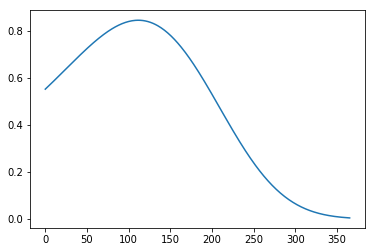

In [54]:
plt.plot(pred[30])

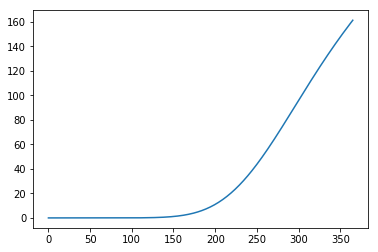

In [96]:
plt.plot(np.cumsum(pred[25][[x for x in range(365,-1,-1)]]))

In [35]:
check_sum=[]
for i in range(len(pred)):
    check_sum.append(np.sum(pred[i]))

In [84]:
oos_index=list([x for x in Data.index if '2019' in x])

In [86]:
oos_index_unique=[]
for i in oos_index:
    if i not in oos_index_unique:
        oos_index_unique.append(i)

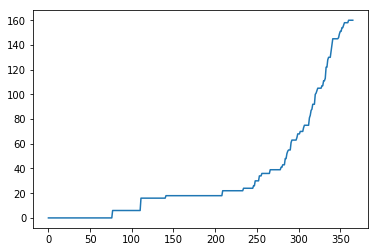

In [97]:
plt.plot(np.cumsum(Data.loc[oos_index_unique[25],'pax_total'].tolist()))

In [79]:
np.cumsum(Data.loc[oos_in§dex[40],'pax_total'].tolist())

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   6.,
         6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   8.,   8.,
         8.,   8.,   8.,   8.,   8.,   9.,   9.,   9.,   9.,   9.,   9.,
         9.,   9.,   9.,   9.,   9.,   9.,   9.,   

In [82]:
test

['2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I',
 '2019-01-06_O',
 '2019-01-06_I